In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.applications import VGG19

In [3]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [4]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [5]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [6]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [7]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [8]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [9]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
n=1000
lr_list = os.listdir("D:/Desktop/Improv/Formal Coding/Jupyter Notebooks/Minor Project/SRDataset/flickr30k_images/lr_5000")[:n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("D:/Desktop/Improv/Formal Coding/Jupyter Notebooks/Minor Project/SRDataset/flickr30k_images/lr_5000/" + img)
    img_lr = cv2.cvtColor(img_lr,cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr) 

In [11]:
hr_list = os.listdir("D:/Desktop/Improv/Formal Coding/Jupyter Notebooks/Minor Project/SRDataset/flickr30k_images/hr_5000")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("D:/Desktop/Improv/Formal Coding/Jupyter Notebooks/Minor Project/SRDataset/flickr30k_images/hr_5000/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

In [12]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

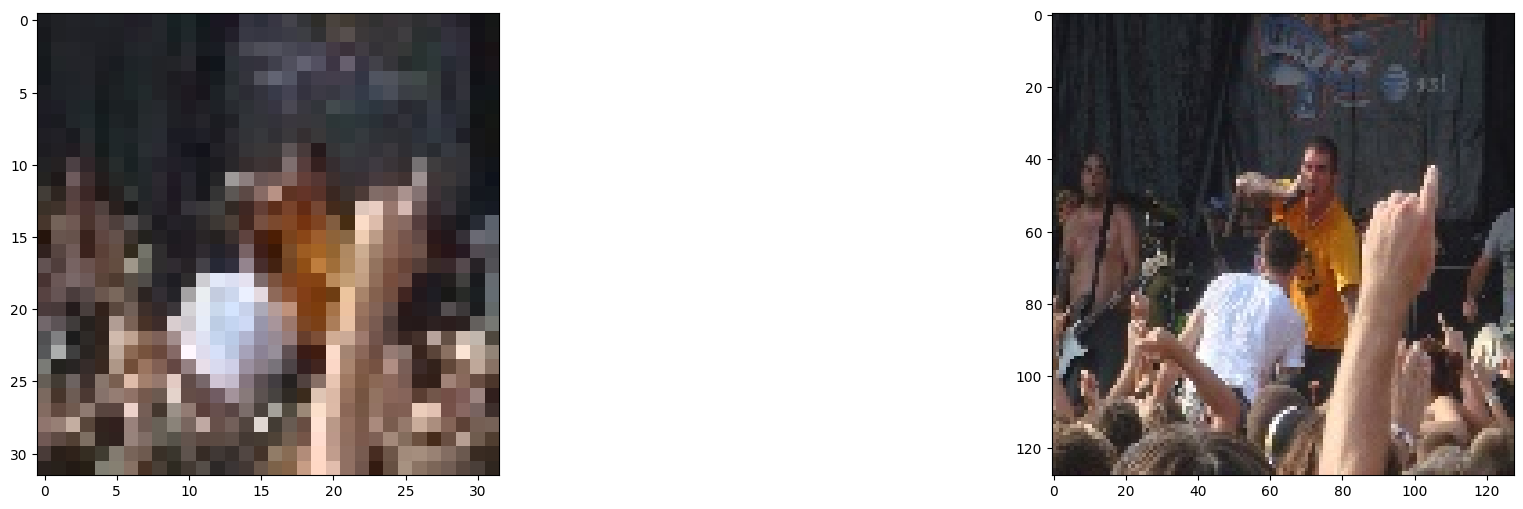

In [13]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(24,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [14]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 64)   36928       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_6 (PReLU)              (None, 32, 32, 64)   64          ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_6[0][0]']              
                                                                                                  
 batch_nor

 conv2d_22 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_11[0][0]']             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_10 (Add)                   (None, 32, 32, 64)   0           ['add_9[0][0]',                  
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 64)   36928       ['add_10[0][0]']                 
                                                                                                  
 batch_nor

 conv2d_33 (Conv2D)             (None, 32, 32, 64)   36928       ['add_15[0][0]']                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 32, 32, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 32, 32, 64)   0           ['batch_normalization_32[0][0]', 
                                                                  'p_re_lu[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 256)  147712      ['add_16[0][0]']                 
                                                                                                  
 up_sampli

 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
 block3_conv4 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
Total params: 2,325,568
Trainable params: 2,325,568
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to

In [15]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    

In [15]:
epochs = 10
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 191ms/step


  0%|                                                                                | 1/670 [00:19<3:36:16, 19.40s/it]

1/1 [==============================] - 0s 141ms/step


  0%|▏                                                                               | 2/670 [00:25<2:09:45, 11.65s/it]

1/1 [==============================] - 0s 146ms/step


  0%|▎                                                                               | 3/670 [00:30<1:37:05,  8.73s/it]

1/1 [==============================] - 0s 109ms/step


  1%|▍                                                                               | 4/670 [00:34<1:16:18,  6.87s/it]

1/1 [==============================] - 0s 125ms/step


  1%|▌                                                                               | 5/670 [00:38<1:05:01,  5.87s/it]

1/1 [==============================] - 0s 109ms/step


  1%|▋                                                                                 | 6/670 [00:43<58:40,  5.30s/it]

1/1 [==============================] - 0s 125ms/step


  1%|▊                                                                                 | 7/670 [00:47<53:54,  4.88s/it]

1/1 [==============================] - 0s 109ms/step


  1%|▉                                                                                 | 8/670 [00:50<46:37,  4.23s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                                 | 9/670 [00:52<39:26,  3.58s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                               | 10/670 [00:54<34:33,  3.14s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▎                                                                               | 11/670 [00:56<31:22,  2.86s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                               | 12/670 [00:58<29:13,  2.66s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                               | 13/670 [01:00<27:38,  2.52s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▋                                                                               | 14/670 [01:03<26:32,  2.43s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                               | 15/670 [01:05<25:42,  2.35s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▉                                                                               | 16/670 [01:07<25:11,  2.31s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██                                                                               | 17/670 [01:09<24:54,  2.29s/it]

1/1 [==============================] - 0s 69ms/step


  3%|██▏                                                                              | 18/670 [01:12<24:36,  2.27s/it]

1/1 [==============================] - 0s 64ms/step


  3%|██▎                                                                              | 19/670 [01:14<24:39,  2.27s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                              | 20/670 [01:16<24:43,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                              | 21/670 [01:18<24:51,  2.30s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                              | 22/670 [01:21<25:01,  2.32s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▊                                                                              | 23/670 [01:23<24:57,  2.32s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                              | 24/670 [01:25<24:56,  2.32s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                              | 25/670 [01:28<25:34,  2.38s/it]

1/1 [==============================] - 0s 68ms/step


  4%|███▏                                                                             | 26/670 [01:30<25:22,  2.36s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▎                                                                             | 27/670 [01:33<25:25,  2.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▍                                                                             | 28/670 [01:35<25:16,  2.36s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▌                                                                             | 29/670 [01:37<25:08,  2.35s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▋                                                                             | 30/670 [01:40<24:58,  2.34s/it]

1/1 [==============================] - 0s 63ms/step


  5%|███▋                                                                             | 31/670 [01:42<24:51,  2.33s/it]

1/1 [==============================] - 0s 62ms/step


  5%|███▊                                                                             | 32/670 [01:44<24:53,  2.34s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                             | 33/670 [01:47<24:44,  2.33s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████                                                                             | 34/670 [01:49<24:41,  2.33s/it]

1/1 [==============================] - 0s 67ms/step


  5%|████▏                                                                            | 35/670 [01:51<24:34,  2.32s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                            | 36/670 [01:54<24:34,  2.33s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                            | 37/670 [01:56<24:34,  2.33s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                            | 38/670 [01:58<24:50,  2.36s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                            | 39/670 [02:01<24:46,  2.36s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▊                                                                            | 40/670 [02:03<24:41,  2.35s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                            | 41/670 [02:06<24:49,  2.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|█████                                                                            | 42/670 [02:08<24:45,  2.37s/it]

1/1 [==============================] - 0s 47ms/step


  6%|█████▏                                                                           | 43/670 [02:10<24:36,  2.36s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▎                                                                           | 44/670 [02:13<24:39,  2.36s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▍                                                                           | 45/670 [02:15<24:39,  2.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                           | 46/670 [02:17<24:44,  2.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▋                                                                           | 47/670 [02:20<24:39,  2.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▊                                                                           | 48/670 [02:22<24:32,  2.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▉                                                                           | 49/670 [02:24<24:38,  2.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 50/670 [02:27<24:53,  2.41s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▏                                                                          | 51/670 [02:29<24:44,  2.40s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▎                                                                          | 52/670 [02:32<24:41,  2.40s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▍                                                                          | 53/670 [02:34<24:39,  2.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▌                                                                          | 54/670 [02:37<24:34,  2.39s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 55/670 [02:39<24:33,  2.40s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 56/670 [02:41<24:25,  2.39s/it]

1/1 [==============================] - 0s 62ms/step


  9%|██████▉                                                                          | 57/670 [02:44<24:21,  2.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████                                                                          | 58/670 [02:46<24:18,  2.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▏                                                                         | 59/670 [02:48<24:22,  2.39s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 60/670 [02:51<24:29,  2.41s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 61/670 [02:53<24:28,  2.41s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▍                                                                         | 62/670 [02:56<24:28,  2.41s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▌                                                                         | 63/670 [02:58<24:41,  2.44s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▋                                                                         | 64/670 [03:01<24:42,  2.45s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 65/670 [03:03<24:40,  2.45s/it]

1/1 [==============================] - 0s 67ms/step


 10%|███████▉                                                                         | 66/670 [03:06<24:39,  2.45s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████                                                                         | 67/670 [03:08<24:32,  2.44s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▏                                                                        | 68/670 [03:10<24:34,  2.45s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▎                                                                        | 69/670 [03:13<24:47,  2.48s/it]

1/1 [==============================] - 0s 55ms/step


 10%|████████▍                                                                        | 70/670 [03:16<24:51,  2.49s/it]

1/1 [==============================] - 0s 69ms/step


 11%|████████▌                                                                        | 71/670 [03:18<24:49,  2.49s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                        | 72/670 [03:21<24:52,  2.50s/it]

1/1 [==============================] - 0s 62ms/step


 11%|████████▊                                                                        | 73/670 [03:23<24:42,  2.48s/it]

1/1 [==============================] - 0s 62ms/step


 11%|████████▉                                                                        | 74/670 [03:25<24:37,  2.48s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 75/670 [03:28<24:35,  2.48s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████▏                                                                       | 76/670 [03:30<24:32,  2.48s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████▎                                                                       | 77/670 [03:33<24:34,  2.49s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▍                                                                       | 78/670 [03:35<24:33,  2.49s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▌                                                                       | 79/670 [03:38<24:32,  2.49s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 80/670 [03:40<24:29,  2.49s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▊                                                                       | 81/670 [03:43<24:29,  2.49s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▉                                                                       | 82/670 [03:45<24:24,  2.49s/it]

1/1 [==============================] - 0s 62ms/step


 12%|██████████                                                                       | 83/670 [03:48<24:25,  2.50s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▏                                                                      | 84/670 [03:50<24:23,  2.50s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 85/670 [03:53<24:29,  2.51s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▍                                                                      | 86/670 [03:55<24:27,  2.51s/it]

1/1 [==============================] - 0s 69ms/step


 13%|██████████▌                                                                      | 87/670 [03:58<25:10,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▋                                                                      | 88/670 [04:01<25:11,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▊                                                                      | 89/670 [04:03<25:01,  2.59s/it]

1/1 [==============================] - 0s 85ms/step


 13%|██████████▉                                                                      | 90/670 [04:06<25:32,  2.64s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████                                                                      | 91/670 [04:09<25:38,  2.66s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████                                                                      | 92/670 [04:12<25:37,  2.66s/it]

1/1 [==============================] - 0s 67ms/step


 14%|███████████▏                                                                     | 93/670 [04:14<25:38,  2.67s/it]

1/1 [==============================] - 0s 67ms/step


 14%|███████████▎                                                                     | 94/670 [04:17<25:35,  2.67s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 95/670 [04:20<25:35,  2.67s/it]

1/1 [==============================] - 0s 68ms/step


 14%|███████████▌                                                                     | 96/670 [04:22<25:38,  2.68s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▋                                                                     | 97/670 [04:25<25:32,  2.68s/it]

1/1 [==============================] - 0s 67ms/step


 15%|███████████▊                                                                     | 98/670 [04:28<25:31,  2.68s/it]

1/1 [==============================] - 0s 62ms/step


 15%|███████████▉                                                                     | 99/670 [04:30<25:33,  2.69s/it]

1/1 [==============================] - 0s 62ms/step


 15%|███████████▉                                                                    | 100/670 [04:33<25:35,  2.69s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                    | 101/670 [04:36<25:31,  2.69s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████▏                                                                   | 102/670 [04:38<25:36,  2.71s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▎                                                                   | 103/670 [04:41<25:36,  2.71s/it]

1/1 [==============================] - 0s 77ms/step


 16%|████████████▍                                                                   | 104/670 [04:44<25:33,  2.71s/it]

1/1 [==============================] - 0s 67ms/step


 16%|████████████▌                                                                   | 105/670 [04:47<25:32,  2.71s/it]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▋                                                                   | 106/670 [04:49<25:18,  2.69s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▊                                                                   | 107/670 [04:52<25:20,  2.70s/it]

1/1 [==============================] - 0s 68ms/step


 16%|████████████▉                                                                   | 108/670 [04:55<26:38,  2.84s/it]

1/1 [==============================] - 0s 85ms/step


 16%|█████████████                                                                   | 109/670 [04:58<27:55,  2.99s/it]

1/1 [==============================] - 0s 80ms/step


 16%|█████████████▏                                                                  | 110/670 [05:02<28:23,  3.04s/it]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▎                                                                  | 111/670 [05:05<28:18,  3.04s/it]

1/1 [==============================] - 0s 72ms/step


 17%|█████████████▎                                                                  | 112/670 [05:08<27:49,  2.99s/it]

1/1 [==============================] - 0s 76ms/step


 17%|█████████████▍                                                                  | 113/670 [05:11<28:21,  3.05s/it]

1/1 [==============================] - 0s 109ms/step


 17%|█████████████▌                                                                  | 114/670 [05:14<29:13,  3.15s/it]

1/1 [==============================] - 0s 76ms/step


 17%|█████████████▋                                                                  | 115/670 [05:17<28:42,  3.10s/it]

1/1 [==============================] - 0s 95ms/step


 17%|█████████████▊                                                                  | 116/670 [05:20<28:22,  3.07s/it]

1/1 [==============================] - 0s 72ms/step


 17%|█████████████▉                                                                  | 117/670 [05:23<27:38,  3.00s/it]

1/1 [==============================] - 0s 92ms/step


 18%|██████████████                                                                  | 118/670 [05:26<28:34,  3.11s/it]

1/1 [==============================] - 0s 150ms/step


 18%|██████████████▏                                                                 | 119/670 [05:32<34:53,  3.80s/it]

1/1 [==============================] - 0s 150ms/step


 18%|██████████████▎                                                                 | 120/670 [05:38<42:37,  4.65s/it]

1/1 [==============================] - 0s 151ms/step


 18%|██████████████▍                                                                 | 121/670 [05:45<47:44,  5.22s/it]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████▌                                                                 | 122/670 [05:52<51:29,  5.64s/it]

1/1 [==============================] - 0s 153ms/step


 18%|██████████████▋                                                                 | 123/670 [05:58<54:02,  5.93s/it]

1/1 [==============================] - 0s 156ms/step


 19%|██████████████▊                                                                 | 124/670 [06:04<53:23,  5.87s/it]

1/1 [==============================] - 0s 110ms/step


 19%|██████████████▉                                                                 | 125/670 [06:08<49:55,  5.50s/it]

1/1 [==============================] - 0s 109ms/step


 19%|███████████████                                                                 | 126/670 [06:13<46:20,  5.11s/it]

1/1 [==============================] - 0s 125ms/step


 19%|███████████████▏                                                                | 127/670 [06:17<43:53,  4.85s/it]

1/1 [==============================] - 0s 125ms/step


 19%|███████████████▎                                                                | 128/670 [06:21<42:20,  4.69s/it]

1/1 [==============================] - 0s 109ms/step


 19%|███████████████▍                                                                | 129/670 [06:26<41:12,  4.57s/it]

1/1 [==============================] - 0s 110ms/step


 19%|███████████████▌                                                                | 130/670 [06:30<40:06,  4.46s/it]

1/1 [==============================] - 0s 109ms/step


 20%|███████████████▋                                                                | 131/670 [06:34<39:25,  4.39s/it]

1/1 [==============================] - 0s 117ms/step


 20%|███████████████▊                                                                | 132/670 [06:38<38:58,  4.35s/it]

1/1 [==============================] - 0s 109ms/step


 20%|███████████████▉                                                                | 133/670 [06:42<38:22,  4.29s/it]

1/1 [==============================] - 0s 109ms/step


 20%|████████████████                                                                | 134/670 [06:46<37:50,  4.24s/it]

1/1 [==============================] - 0s 109ms/step


 20%|████████████████                                                                | 135/670 [06:51<37:32,  4.21s/it]

1/1 [==============================] - 0s 110ms/step


 20%|████████████████▏                                                               | 136/670 [06:55<37:34,  4.22s/it]

1/1 [==============================] - 0s 125ms/step


 20%|████████████████▎                                                               | 137/670 [06:59<38:03,  4.28s/it]

1/1 [==============================] - 0s 109ms/step


 21%|████████████████▍                                                               | 138/670 [07:04<38:43,  4.37s/it]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████▌                                                               | 139/670 [07:08<37:55,  4.28s/it]

1/1 [==============================] - 0s 109ms/step


 21%|████████████████▋                                                               | 140/670 [07:12<37:16,  4.22s/it]

1/1 [==============================] - 0s 116ms/step


 21%|████████████████▊                                                               | 141/670 [07:17<37:50,  4.29s/it]

1/1 [==============================] - 0s 109ms/step


 21%|████████████████▉                                                               | 142/670 [07:21<37:41,  4.28s/it]

1/1 [==============================] - 0s 125ms/step


 21%|█████████████████                                                               | 143/670 [07:25<36:59,  4.21s/it]

1/1 [==============================] - 0s 110ms/step


 21%|█████████████████▏                                                              | 144/670 [07:29<36:40,  4.18s/it]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▎                                                              | 145/670 [07:33<36:25,  4.16s/it]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▍                                                              | 146/670 [07:37<35:52,  4.11s/it]

1/1 [==============================] - 0s 110ms/step


 22%|█████████████████▌                                                              | 147/670 [07:41<35:41,  4.10s/it]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▋                                                              | 148/670 [07:45<35:31,  4.08s/it]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▊                                                              | 149/670 [07:49<35:13,  4.06s/it]

1/1 [==============================] - 0s 110ms/step


 22%|█████████████████▉                                                              | 150/670 [07:53<35:07,  4.05s/it]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████                                                              | 151/670 [07:58<35:49,  4.14s/it]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████▏                                                             | 152/670 [08:02<37:44,  4.37s/it]

1/1 [==============================] - 0s 122ms/step


 23%|██████████████████▎                                                             | 153/670 [08:07<36:54,  4.28s/it]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▍                                                             | 154/670 [08:11<36:57,  4.30s/it]

1/1 [==============================] - 0s 117ms/step


 23%|██████████████████▌                                                             | 155/670 [08:15<36:16,  4.23s/it]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▋                                                             | 156/670 [08:19<35:34,  4.15s/it]

1/1 [==============================] - 0s 94ms/step


 23%|██████████████████▋                                                             | 157/670 [08:23<34:38,  4.05s/it]

1/1 [==============================] - 0s 125ms/step


 24%|██████████████████▊                                                             | 158/670 [08:27<34:18,  4.02s/it]

1/1 [==============================] - 0s 125ms/step


 24%|██████████████████▉                                                             | 159/670 [08:31<34:35,  4.06s/it]

1/1 [==============================] - 0s 120ms/step


 24%|███████████████████                                                             | 160/670 [08:35<34:40,  4.08s/it]

1/1 [==============================] - 0s 109ms/step


 24%|███████████████████▏                                                            | 161/670 [08:39<34:47,  4.10s/it]

1/1 [==============================] - 0s 125ms/step


 24%|███████████████████▎                                                            | 162/670 [08:43<34:10,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 24%|███████████████████▍                                                            | 163/670 [08:47<34:01,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 24%|███████████████████▌                                                            | 164/670 [08:51<33:52,  4.02s/it]

1/1 [==============================] - 0s 110ms/step


 25%|███████████████████▋                                                            | 165/670 [08:55<33:34,  3.99s/it]

1/1 [==============================] - 0s 115ms/step


 25%|███████████████████▊                                                            | 166/670 [08:59<34:04,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 25%|███████████████████▉                                                            | 167/670 [09:03<34:51,  4.16s/it]

1/1 [==============================] - 0s 125ms/step


 25%|████████████████████                                                            | 168/670 [09:07<34:23,  4.11s/it]

1/1 [==============================] - 0s 114ms/step


 25%|████████████████████▏                                                           | 169/670 [09:12<34:18,  4.11s/it]

1/1 [==============================] - 0s 131ms/step


 25%|████████████████████▎                                                           | 170/670 [09:17<37:45,  4.53s/it]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▍                                                           | 171/670 [09:21<37:12,  4.47s/it]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▌                                                           | 172/670 [09:25<35:58,  4.34s/it]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▋                                                           | 173/670 [09:29<34:58,  4.22s/it]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▊                                                           | 174/670 [09:33<34:25,  4.16s/it]

1/1 [==============================] - 0s 120ms/step


 26%|████████████████████▉                                                           | 175/670 [09:38<34:24,  4.17s/it]

1/1 [==============================] - 0s 109ms/step


 26%|█████████████████████                                                           | 176/670 [09:42<33:52,  4.12s/it]

1/1 [==============================] - 0s 114ms/step


 26%|█████████████████████▏                                                          | 177/670 [09:46<33:14,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▎                                                          | 178/670 [09:49<32:44,  3.99s/it]

1/1 [==============================] - 0s 126ms/step


 27%|█████████████████████▎                                                          | 179/670 [09:53<32:09,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▍                                                          | 180/670 [09:57<32:05,  3.93s/it]

1/1 [==============================] - 0s 115ms/step


 27%|█████████████████████▌                                                          | 181/670 [10:01<32:13,  3.95s/it]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▋                                                          | 182/670 [10:05<32:29,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▊                                                          | 183/670 [10:09<32:27,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▉                                                          | 184/670 [10:13<32:02,  3.96s/it]

1/1 [==============================] - 0s 125ms/step


 28%|██████████████████████                                                          | 185/670 [10:17<31:51,  3.94s/it]

1/1 [==============================] - 0s 110ms/step


 28%|██████████████████████▏                                                         | 186/670 [10:21<31:24,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 28%|██████████████████████▎                                                         | 187/670 [10:25<31:27,  3.91s/it]

1/1 [==============================] - 0s 110ms/step


 28%|██████████████████████▍                                                         | 188/670 [10:29<31:29,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 28%|██████████████████████▌                                                         | 189/670 [10:33<31:36,  3.94s/it]

1/1 [==============================] - 0s 125ms/step


 28%|██████████████████████▋                                                         | 190/670 [10:37<31:26,  3.93s/it]

1/1 [==============================] - 0s 117ms/step


 29%|██████████████████████▊                                                         | 191/670 [10:40<31:20,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 29%|██████████████████████▉                                                         | 192/670 [10:44<31:20,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 29%|███████████████████████                                                         | 193/670 [10:48<31:20,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 29%|███████████████████████▏                                                        | 194/670 [10:52<30:52,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 29%|███████████████████████▎                                                        | 195/670 [10:56<31:04,  3.92s/it]

1/1 [==============================] - 0s 126ms/step


 29%|███████████████████████▍                                                        | 196/670 [11:00<31:16,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 29%|███████████████████████▌                                                        | 197/670 [11:04<31:07,  3.95s/it]

1/1 [==============================] - 0s 109ms/step


 30%|███████████████████████▋                                                        | 198/670 [11:08<30:48,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 30%|███████████████████████▊                                                        | 199/670 [11:12<30:19,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 30%|███████████████████████▉                                                        | 200/670 [11:16<30:57,  3.95s/it]

1/1 [==============================] - 0s 109ms/step


 30%|████████████████████████                                                        | 201/670 [11:20<31:05,  3.98s/it]

1/1 [==============================] - 0s 127ms/step


 30%|████████████████████████                                                        | 202/670 [11:24<31:35,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 30%|████████████████████████▏                                                       | 203/670 [11:28<31:12,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 30%|████████████████████████▎                                                       | 204/670 [11:32<31:06,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▍                                                       | 205/670 [11:36<30:34,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▌                                                       | 206/670 [11:40<30:10,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▋                                                       | 207/670 [11:43<30:02,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▊                                                       | 208/670 [11:47<30:07,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▉                                                       | 209/670 [11:51<29:59,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 31%|█████████████████████████                                                       | 210/670 [11:55<29:46,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 31%|█████████████████████████▏                                                      | 211/670 [11:59<29:48,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 32%|█████████████████████████▎                                                      | 212/670 [12:03<29:51,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 32%|█████████████████████████▍                                                      | 213/670 [12:07<29:49,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 32%|█████████████████████████▌                                                      | 214/670 [12:11<29:36,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 32%|█████████████████████████▋                                                      | 215/670 [12:15<29:13,  3.85s/it]

1/1 [==============================] - 0s 110ms/step


 32%|█████████████████████████▊                                                      | 216/670 [12:19<29:25,  3.89s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████████████▉                                                      | 217/670 [12:22<29:26,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████                                                      | 218/670 [12:26<29:20,  3.90s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▏                                                     | 219/670 [12:30<28:55,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████▎                                                     | 220/670 [12:34<28:27,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████▍                                                     | 221/670 [12:38<28:23,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████▌                                                     | 222/670 [12:42<28:43,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████▋                                                     | 223/670 [12:46<28:57,  3.89s/it]

1/1 [==============================] - 0s 130ms/step


 33%|██████████████████████████▋                                                     | 224/670 [12:49<28:42,  3.86s/it]

1/1 [==============================] - 0s 110ms/step


 34%|██████████████████████████▊                                                     | 225/670 [12:53<28:21,  3.82s/it]

1/1 [==============================] - 0s 118ms/step


 34%|██████████████████████████▉                                                     | 226/670 [12:57<28:43,  3.88s/it]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████                                                     | 227/670 [13:02<30:34,  4.14s/it]

1/1 [==============================] - 0s 106ms/step


 34%|███████████████████████████▏                                                    | 228/670 [13:07<32:19,  4.39s/it]

1/1 [==============================] - 0s 125ms/step


 34%|███████████████████████████▎                                                    | 229/670 [13:11<31:19,  4.26s/it]

1/1 [==============================] - 0s 132ms/step


 34%|███████████████████████████▍                                                    | 230/670 [13:15<30:33,  4.17s/it]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████▌                                                    | 231/670 [13:19<30:18,  4.14s/it]

1/1 [==============================] - 0s 109ms/step


 35%|███████████████████████████▋                                                    | 232/670 [13:23<30:19,  4.15s/it]

1/1 [==============================] - 0s 109ms/step


 35%|███████████████████████████▊                                                    | 233/670 [13:27<29:33,  4.06s/it]

1/1 [==============================] - 0s 114ms/step


 35%|███████████████████████████▉                                                    | 234/670 [13:31<29:10,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 35%|████████████████████████████                                                    | 235/670 [13:35<28:39,  3.95s/it]

1/1 [==============================] - 0s 109ms/step


 35%|████████████████████████████▏                                                   | 236/670 [13:38<28:06,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 35%|████████████████████████████▎                                                   | 237/670 [13:42<27:46,  3.85s/it]

1/1 [==============================] - 0s 110ms/step


 36%|████████████████████████████▍                                                   | 238/670 [13:46<27:36,  3.83s/it]

1/1 [==============================] - 0s 109ms/step


 36%|████████████████████████████▌                                                   | 239/670 [13:50<27:24,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 36%|████████████████████████████▋                                                   | 240/670 [13:53<27:11,  3.79s/it]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████▊                                                   | 241/670 [13:57<27:16,  3.81s/it]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████▉                                                   | 242/670 [14:02<28:24,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 36%|█████████████████████████████                                                   | 243/670 [14:06<29:02,  4.08s/it]

1/1 [==============================] - 0s 109ms/step


 36%|█████████████████████████████▏                                                  | 244/670 [14:10<28:56,  4.08s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▎                                                  | 245/670 [14:14<28:28,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▎                                                  | 246/670 [14:18<28:04,  3.97s/it]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▍                                                  | 247/670 [14:22<27:48,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▌                                                  | 248/670 [14:25<27:27,  3.90s/it]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▋                                                  | 249/670 [14:29<27:10,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▊                                                  | 250/670 [14:33<27:03,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▉                                                  | 251/670 [14:37<26:48,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████                                                  | 252/670 [14:41<26:39,  3.83s/it]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▏                                                 | 253/670 [14:44<26:40,  3.84s/it]

1/1 [==============================] - 0s 110ms/step


 38%|██████████████████████████████▎                                                 | 254/670 [14:48<26:43,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▍                                                 | 255/670 [14:52<26:46,  3.87s/it]

1/1 [==============================] - 0s 114ms/step


 38%|██████████████████████████████▌                                                 | 256/670 [14:56<27:22,  3.97s/it]

1/1 [==============================] - 0s 126ms/step


 38%|██████████████████████████████▋                                                 | 257/670 [15:01<28:31,  4.14s/it]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████▊                                                 | 258/670 [15:05<28:51,  4.20s/it]

1/1 [==============================] - 0s 109ms/step


 39%|██████████████████████████████▉                                                 | 259/670 [15:09<28:08,  4.11s/it]

1/1 [==============================] - 0s 109ms/step


 39%|███████████████████████████████                                                 | 260/670 [15:13<27:44,  4.06s/it]

1/1 [==============================] - 0s 112ms/step


 39%|███████████████████████████████▏                                                | 261/670 [15:17<28:06,  4.12s/it]

1/1 [==============================] - 0s 109ms/step


 39%|███████████████████████████████▎                                                | 262/670 [15:21<27:32,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 39%|███████████████████████████████▍                                                | 263/670 [15:25<26:58,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 39%|███████████████████████████████▌                                                | 264/670 [15:29<26:44,  3.95s/it]

1/1 [==============================] - 0s 110ms/step


 40%|███████████████████████████████▋                                                | 265/670 [15:33<26:22,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▊                                                | 266/670 [15:37<26:11,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▉                                                | 267/670 [15:40<25:55,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████                                                | 268/670 [15:44<26:04,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████                                                | 269/670 [15:48<26:01,  3.89s/it]

1/1 [==============================] - 0s 114ms/step


 40%|████████████████████████████████▏                                               | 270/670 [15:52<25:57,  3.89s/it]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████▎                                               | 271/670 [15:56<25:51,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▍                                               | 272/670 [16:00<26:00,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▌                                               | 273/670 [16:04<26:30,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▋                                               | 274/670 [16:08<26:13,  3.97s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▊                                               | 275/670 [16:12<25:51,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▉                                               | 276/670 [16:16<25:33,  3.89s/it]

1/1 [==============================] - 0s 125ms/step


 41%|█████████████████████████████████                                               | 277/670 [16:20<25:18,  3.86s/it]

1/1 [==============================] - 0s 110ms/step


 41%|█████████████████████████████████▏                                              | 278/670 [16:23<25:05,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▎                                              | 279/670 [16:27<24:59,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▍                                              | 280/670 [16:31<24:50,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▌                                              | 281/670 [16:35<24:38,  3.80s/it]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▋                                              | 282/670 [16:39<24:38,  3.81s/it]

1/1 [==============================] - 0s 110ms/step


 42%|█████████████████████████████████▊                                              | 283/670 [16:43<24:49,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▉                                              | 284/670 [16:46<24:33,  3.82s/it]

1/1 [==============================] - 0s 125ms/step


 43%|██████████████████████████████████                                              | 285/670 [16:50<24:27,  3.81s/it]

1/1 [==============================] - 0s 109ms/step


 43%|██████████████████████████████████▏                                             | 286/670 [16:54<24:27,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 43%|██████████████████████████████████▎                                             | 287/670 [16:58<24:24,  3.82s/it]

1/1 [==============================] - 0s 123ms/step


 43%|██████████████████████████████████▍                                             | 288/670 [17:02<25:03,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 43%|██████████████████████████████████▌                                             | 289/670 [17:06<24:58,  3.93s/it]

1/1 [==============================] - 0s 125ms/step


 43%|██████████████████████████████████▋                                             | 290/670 [17:10<24:51,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 43%|██████████████████████████████████▋                                             | 291/670 [17:14<24:50,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▊                                             | 292/670 [17:18<24:48,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▉                                             | 293/670 [17:21<24:29,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████                                             | 294/670 [17:25<24:18,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████▏                                            | 295/670 [17:29<24:11,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████▎                                            | 296/670 [17:33<24:09,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████▍                                            | 297/670 [17:37<24:03,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████▌                                            | 298/670 [17:41<23:52,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████▋                                            | 299/670 [17:44<23:31,  3.80s/it]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████▊                                            | 300/670 [17:48<23:26,  3.80s/it]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████▉                                            | 301/670 [17:52<23:22,  3.80s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████████████████████████████████████                                            | 302/670 [17:56<23:53,  3.90s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████████████████████████████████████▏                                           | 303/670 [18:01<24:55,  4.07s/it]

1/1 [==============================] - 0s 109ms/step


 45%|████████████████████████████████████▎                                           | 304/670 [18:05<24:47,  4.06s/it]

1/1 [==============================] - 0s 113ms/step


 46%|████████████████████████████████████▍                                           | 305/670 [18:09<24:24,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 46%|████████████████████████████████████▌                                           | 306/670 [18:12<24:11,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 46%|████████████████████████████████████▋                                           | 307/670 [18:16<24:00,  3.97s/it]

1/1 [==============================] - 0s 114ms/step


 46%|████████████████████████████████████▊                                           | 308/670 [18:20<23:36,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 46%|████████████████████████████████████▉                                           | 309/670 [18:24<23:09,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 46%|█████████████████████████████████████                                           | 310/670 [18:28<23:19,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 46%|█████████████████████████████████████▏                                          | 311/670 [18:32<23:35,  3.94s/it]

1/1 [==============================] - 0s 110ms/step


 47%|█████████████████████████████████████▎                                          | 312/670 [18:36<23:30,  3.94s/it]

1/1 [==============================] - 0s 114ms/step


 47%|█████████████████████████████████████▎                                          | 313/670 [18:40<23:07,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▍                                          | 314/670 [18:43<22:51,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▌                                          | 315/670 [18:47<22:46,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▋                                          | 316/670 [18:51<22:37,  3.83s/it]

1/1 [==============================] - 0s 126ms/step


 47%|█████████████████████████████████████▊                                          | 317/670 [18:56<24:12,  4.11s/it]

1/1 [==============================] - 0s 130ms/step


 47%|█████████████████████████████████████▉                                          | 318/670 [19:00<23:44,  4.05s/it]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████████████████████████                                          | 319/670 [19:04<23:34,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 48%|██████████████████████████████████████▏                                         | 320/670 [19:08<23:06,  3.96s/it]

1/1 [==============================] - 0s 110ms/step


 48%|██████████████████████████████████████▎                                         | 321/670 [19:11<22:53,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 48%|██████████████████████████████████████▍                                         | 322/670 [19:16<23:21,  4.03s/it]

1/1 [==============================] - 0s 126ms/step


 48%|██████████████████████████████████████▌                                         | 323/670 [19:20<23:15,  4.02s/it]

1/1 [==============================] - 0s 115ms/step


 48%|██████████████████████████████████████▋                                         | 324/670 [19:24<23:06,  4.01s/it]

1/1 [==============================] - 0s 118ms/step


 49%|██████████████████████████████████████▊                                         | 325/670 [19:28<22:56,  3.99s/it]

1/1 [==============================] - 0s 125ms/step


 49%|██████████████████████████████████████▉                                         | 326/670 [19:32<22:47,  3.98s/it]

1/1 [==============================] - 0s 114ms/step


 49%|███████████████████████████████████████                                         | 327/670 [19:35<22:24,  3.92s/it]

1/1 [==============================] - 0s 110ms/step


 49%|███████████████████████████████████████▏                                        | 328/670 [19:39<22:11,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 49%|███████████████████████████████████████▎                                        | 329/670 [19:43<22:00,  3.87s/it]

1/1 [==============================] - 0s 111ms/step


 49%|███████████████████████████████████████▍                                        | 330/670 [19:47<21:32,  3.80s/it]

1/1 [==============================] - 0s 114ms/step


 49%|███████████████████████████████████████▌                                        | 331/670 [19:50<21:22,  3.78s/it]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▋                                        | 332/670 [19:54<21:40,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 50%|███████████████████████████████████████▊                                        | 333/670 [19:58<21:33,  3.84s/it]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████████████████████████▉                                        | 334/670 [20:02<21:55,  3.91s/it]

1/1 [==============================] - 0s 110ms/step


 50%|████████████████████████████████████████                                        | 335/670 [20:06<21:53,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 50%|████████████████████████████████████████                                        | 336/670 [20:10<21:34,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 50%|████████████████████████████████████████▏                                       | 337/670 [20:14<21:08,  3.81s/it]

1/1 [==============================] - 0s 109ms/step


 50%|████████████████████████████████████████▎                                       | 338/670 [20:17<20:56,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████▍                                       | 339/670 [20:21<20:54,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████▌                                       | 340/670 [20:25<20:50,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████▋                                       | 341/670 [20:29<20:36,  3.76s/it]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████▊                                       | 342/670 [20:32<20:30,  3.75s/it]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████▉                                       | 343/670 [20:36<20:25,  3.75s/it]

1/1 [==============================] - 0s 109ms/step


 51%|█████████████████████████████████████████                                       | 344/670 [20:40<20:22,  3.75s/it]

1/1 [==============================] - 0s 116ms/step


 51%|█████████████████████████████████████████▏                                      | 345/670 [20:44<20:19,  3.75s/it]

1/1 [==============================] - 0s 109ms/step


 52%|█████████████████████████████████████████▎                                      | 346/670 [20:47<20:29,  3.79s/it]

1/1 [==============================] - 0s 109ms/step


 52%|█████████████████████████████████████████▍                                      | 347/670 [20:51<20:33,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 52%|█████████████████████████████████████████▌                                      | 348/670 [20:55<20:25,  3.80s/it]

1/1 [==============================] - 0s 116ms/step


 52%|█████████████████████████████████████████▋                                      | 349/670 [20:59<20:48,  3.89s/it]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▊                                      | 350/670 [21:04<22:36,  4.24s/it]

1/1 [==============================] - 0s 109ms/step


 52%|█████████████████████████████████████████▉                                      | 351/670 [21:08<22:02,  4.14s/it]

1/1 [==============================] - 0s 125ms/step


 53%|██████████████████████████████████████████                                      | 352/670 [21:12<21:27,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▏                                     | 353/670 [21:16<21:16,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▎                                     | 354/670 [21:20<20:56,  3.98s/it]

1/1 [==============================] - 0s 110ms/step


 53%|██████████████████████████████████████████▍                                     | 355/670 [21:24<20:40,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▌                                     | 356/670 [21:28<20:43,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▋                                     | 357/670 [21:32<20:31,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▋                                     | 358/670 [21:35<20:20,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 54%|██████████████████████████████████████████▊                                     | 359/670 [21:39<20:06,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▉                                     | 360/670 [21:43<20:07,  3.90s/it]

1/1 [==============================] - 0s 115ms/step


 54%|███████████████████████████████████████████                                     | 361/670 [21:47<20:40,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 54%|███████████████████████████████████████████▏                                    | 362/670 [21:52<21:30,  4.19s/it]

1/1 [==============================] - 0s 125ms/step


 54%|███████████████████████████████████████████▎                                    | 363/670 [21:56<21:11,  4.14s/it]

1/1 [==============================] - 0s 109ms/step


 54%|███████████████████████████████████████████▍                                    | 364/670 [22:00<21:04,  4.13s/it]

1/1 [==============================] - 0s 110ms/step


 54%|███████████████████████████████████████████▌                                    | 365/670 [22:04<20:46,  4.09s/it]

1/1 [==============================] - 0s 109ms/step


 55%|███████████████████████████████████████████▋                                    | 366/670 [22:08<20:14,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 55%|███████████████████████████████████████████▊                                    | 367/670 [22:12<19:53,  3.94s/it]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▉                                    | 368/670 [22:16<20:19,  4.04s/it]

1/1 [==============================] - 0s 110ms/step


 55%|████████████████████████████████████████████                                    | 369/670 [22:20<20:04,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 55%|████████████████████████████████████████████▏                                   | 370/670 [22:24<19:52,  3.98s/it]

1/1 [==============================] - 0s 116ms/step


 55%|████████████████████████████████████████████▎                                   | 371/670 [22:28<19:43,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▍                                   | 372/670 [22:32<19:34,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▌                                   | 373/670 [22:36<19:19,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▋                                   | 374/670 [22:39<18:59,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▊                                   | 375/670 [22:43<18:50,  3.83s/it]

1/1 [==============================] - 0s 113ms/step


 56%|████████████████████████████████████████████▉                                   | 376/670 [22:47<18:42,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 56%|█████████████████████████████████████████████                                   | 377/670 [22:50<18:26,  3.78s/it]

1/1 [==============================] - 0s 109ms/step


 56%|█████████████████████████████████████████████▏                                  | 378/670 [22:54<18:35,  3.82s/it]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▎                                  | 379/670 [22:59<19:10,  3.95s/it]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▎                                  | 380/670 [23:03<19:45,  4.09s/it]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▍                                  | 381/670 [23:07<19:40,  4.08s/it]

1/1 [==============================] - 0s 110ms/step


 57%|█████████████████████████████████████████████▌                                  | 382/670 [23:11<19:22,  4.04s/it]

1/1 [==============================] - 0s 126ms/step


 57%|█████████████████████████████████████████████▋                                  | 383/670 [23:15<19:19,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 57%|█████████████████████████████████████████████▊                                  | 384/670 [23:19<18:55,  3.97s/it]

1/1 [==============================] - 0s 130ms/step


 57%|█████████████████████████████████████████████▉                                  | 385/670 [23:23<18:36,  3.92s/it]

1/1 [==============================] - 0s 110ms/step


 58%|██████████████████████████████████████████████                                  | 386/670 [23:27<18:36,  3.93s/it]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████████████████████████████▏                                 | 387/670 [23:31<18:34,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████████████████████████████▎                                 | 388/670 [23:34<18:22,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████████████████████████████▍                                 | 389/670 [23:38<18:10,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████████████████████████████▌                                 | 390/670 [23:42<18:01,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████████████████████████████▋                                 | 391/670 [23:46<17:59,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████████████████████████████▊                                 | 392/670 [23:50<18:06,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████████████████████████████▉                                 | 393/670 [23:54<18:13,  3.95s/it]

1/1 [==============================] - 0s 126ms/step


 59%|███████████████████████████████████████████████                                 | 394/670 [23:58<18:22,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 59%|███████████████████████████████████████████████▏                                | 395/670 [24:02<18:35,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 59%|███████████████████████████████████████████████▎                                | 396/670 [24:06<18:10,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 59%|███████████████████████████████████████████████▍                                | 397/670 [24:10<18:01,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 59%|███████████████████████████████████████████████▌                                | 398/670 [24:14<17:49,  3.93s/it]

1/1 [==============================] - 0s 117ms/step


 60%|███████████████████████████████████████████████▋                                | 399/670 [24:18<18:13,  4.03s/it]

1/1 [==============================] - 0s 126ms/step


 60%|███████████████████████████████████████████████▊                                | 400/670 [24:22<18:18,  4.07s/it]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████▉                                | 401/670 [24:26<17:59,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 60%|████████████████████████████████████████████████                                | 402/670 [24:30<17:45,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 60%|████████████████████████████████████████████████                                | 403/670 [24:34<17:25,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 60%|████████████████████████████████████████████████▏                               | 404/670 [24:38<17:12,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 60%|████████████████████████████████████████████████▎                               | 405/670 [24:42<17:13,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▍                               | 406/670 [24:45<17:00,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▌                               | 407/670 [24:49<16:47,  3.83s/it]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▋                               | 408/670 [24:53<16:58,  3.89s/it]

1/1 [==============================] - 0s 128ms/step


 61%|████████████████████████████████████████████████▊                               | 409/670 [24:58<18:41,  4.30s/it]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▉                               | 410/670 [25:03<18:55,  4.37s/it]

1/1 [==============================] - 0s 109ms/step


 61%|█████████████████████████████████████████████████                               | 411/670 [25:07<18:15,  4.23s/it]

1/1 [==============================] - 0s 114ms/step


 61%|█████████████████████████████████████████████████▏                              | 412/670 [25:11<17:46,  4.13s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████████████████████▎                              | 413/670 [25:15<17:35,  4.11s/it]

1/1 [==============================] - 0s 109ms/step


 62%|█████████████████████████████████████████████████▍                              | 414/670 [25:19<17:08,  4.02s/it]

1/1 [==============================] - 0s 110ms/step


 62%|█████████████████████████████████████████████████▌                              | 415/670 [25:23<17:00,  4.00s/it]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▋                              | 416/670 [25:27<17:07,  4.05s/it]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▊                              | 417/670 [25:31<16:52,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 62%|█████████████████████████████████████████████████▉                              | 418/670 [25:34<16:30,  3.93s/it]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████████████████                              | 419/670 [25:38<16:11,  3.87s/it]

1/1 [==============================] - 0s 110ms/step


 63%|██████████████████████████████████████████████████▏                             | 420/670 [25:42<15:54,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 63%|██████████████████████████████████████████████████▎                             | 421/670 [25:46<15:50,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 63%|██████████████████████████████████████████████████▍                             | 422/670 [25:49<15:37,  3.78s/it]

1/1 [==============================] - 0s 109ms/step


 63%|██████████████████████████████████████████████████▌                             | 423/670 [25:53<15:32,  3.78s/it]

1/1 [==============================] - 0s 110ms/step


 63%|██████████████████████████████████████████████████▋                             | 424/670 [25:57<15:42,  3.83s/it]

1/1 [==============================] - 0s 125ms/step


 63%|██████████████████████████████████████████████████▋                             | 425/670 [26:01<16:03,  3.93s/it]

1/1 [==============================] - 0s 105ms/step


 64%|██████████████████████████████████████████████████▊                             | 426/670 [26:05<15:57,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 64%|██████████████████████████████████████████████████▉                             | 427/670 [26:09<15:45,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 64%|███████████████████████████████████████████████████                             | 428/670 [26:13<15:39,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 64%|███████████████████████████████████████████████████▏                            | 429/670 [26:17<15:28,  3.85s/it]

1/1 [==============================] - 0s 98ms/step


 64%|███████████████████████████████████████████████████▎                            | 430/670 [26:21<15:30,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 64%|███████████████████████████████████████████████████▍                            | 431/670 [26:25<15:31,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 64%|███████████████████████████████████████████████████▌                            | 432/670 [26:28<15:30,  3.91s/it]

1/1 [==============================] - 0s 125ms/step


 65%|███████████████████████████████████████████████████▋                            | 433/670 [26:32<15:16,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▊                            | 434/670 [26:36<15:11,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▉                            | 435/670 [26:40<15:09,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 65%|████████████████████████████████████████████████████                            | 436/670 [26:44<15:06,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 65%|████████████████████████████████████████████████████▏                           | 437/670 [26:48<14:57,  3.85s/it]

1/1 [==============================] - 0s 110ms/step


 65%|████████████████████████████████████████████████████▎                           | 438/670 [26:51<14:51,  3.84s/it]

1/1 [==============================] - 0s 125ms/step


 66%|████████████████████████████████████████████████████▍                           | 439/670 [26:56<15:11,  3.95s/it]

1/1 [==============================] - 0s 110ms/step


 66%|████████████████████████████████████████████████████▌                           | 440/670 [27:00<15:17,  3.99s/it]

1/1 [==============================] - 0s 126ms/step


 66%|████████████████████████████████████████████████████▋                           | 441/670 [27:04<16:04,  4.21s/it]

1/1 [==============================] - 0s 110ms/step


 66%|████████████████████████████████████████████████████▊                           | 442/670 [27:09<16:25,  4.32s/it]

1/1 [==============================] - 0s 109ms/step


 66%|████████████████████████████████████████████████████▉                           | 443/670 [27:13<16:11,  4.28s/it]

1/1 [==============================] - 0s 130ms/step


 66%|█████████████████████████████████████████████████████                           | 444/670 [27:17<15:59,  4.24s/it]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████████████████████████████████▏                          | 445/670 [27:21<15:27,  4.12s/it]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▎                          | 446/670 [27:25<15:07,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▎                          | 447/670 [27:29<14:48,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▍                          | 448/670 [27:33<14:33,  3.93s/it]

1/1 [==============================] - 0s 122ms/step


 67%|█████████████████████████████████████████████████████▌                          | 449/670 [27:37<14:37,  3.97s/it]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▋                          | 450/670 [27:41<14:36,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▊                          | 451/670 [27:45<14:44,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▉                          | 452/670 [27:49<14:31,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████                          | 453/670 [27:53<14:19,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████▏                         | 454/670 [27:57<14:26,  4.01s/it]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████████████████████████████████▎                         | 455/670 [28:01<14:34,  4.07s/it]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████▍                         | 456/670 [28:05<14:24,  4.04s/it]

1/1 [==============================] - 0s 115ms/step


 68%|██████████████████████████████████████████████████████▌                         | 457/670 [28:09<14:21,  4.04s/it]

1/1 [==============================] - 0s 114ms/step


 68%|██████████████████████████████████████████████████████▋                         | 458/670 [28:13<14:05,  3.99s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████████████████████▊                         | 459/670 [28:17<13:58,  3.97s/it]

1/1 [==============================] - 0s 109ms/step


 69%|██████████████████████████████████████████████████████▉                         | 460/670 [28:21<13:41,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████                         | 461/670 [28:24<13:30,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▏                        | 462/670 [28:28<13:23,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 69%|███████████████████████████████████████████████████████▎                        | 463/670 [28:32<13:13,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▍                        | 464/670 [28:36<13:06,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▌                        | 465/670 [28:40<13:09,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 70%|███████████████████████████████████████████████████████▋                        | 466/670 [28:44<13:16,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 70%|███████████████████████████████████████████████████████▊                        | 467/670 [28:48<13:08,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 70%|███████████████████████████████████████████████████████▉                        | 468/670 [28:51<12:57,  3.85s/it]

1/1 [==============================] - 0s 114ms/step


 70%|████████████████████████████████████████████████████████                        | 469/670 [28:55<12:57,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 70%|████████████████████████████████████████████████████████                        | 470/670 [29:00<13:29,  4.05s/it]

1/1 [==============================] - 0s 148ms/step


 70%|████████████████████████████████████████████████████████▏                       | 471/670 [29:05<14:38,  4.41s/it]

1/1 [==============================] - 0s 114ms/step


 70%|████████████████████████████████████████████████████████▎                       | 472/670 [29:09<13:59,  4.24s/it]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▍                       | 473/670 [29:13<13:47,  4.20s/it]

1/1 [==============================] - 0s 109ms/step


 71%|████████████████████████████████████████████████████████▌                       | 474/670 [29:17<13:59,  4.29s/it]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▋                       | 475/670 [29:22<13:40,  4.21s/it]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▊                       | 476/670 [29:26<13:25,  4.15s/it]

1/1 [==============================] - 0s 130ms/step


 71%|████████████████████████████████████████████████████████▉                       | 477/670 [29:30<13:12,  4.10s/it]

1/1 [==============================] - 0s 109ms/step


 71%|█████████████████████████████████████████████████████████                       | 478/670 [29:34<13:03,  4.08s/it]

1/1 [==============================] - 0s 130ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 479/670 [29:38<12:54,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 480/670 [29:42<12:45,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 481/670 [29:45<12:30,  3.97s/it]

1/1 [==============================] - 0s 109ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 482/670 [29:49<12:13,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 483/670 [29:53<12:05,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 484/670 [29:57<12:04,  3.89s/it]

1/1 [==============================] - 0s 125ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 485/670 [30:01<12:18,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 73%|██████████████████████████████████████████████████████████                      | 486/670 [30:05<12:22,  4.03s/it]

1/1 [==============================] - 0s 125ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 487/670 [30:09<12:13,  4.01s/it]

1/1 [==============================] - 0s 125ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 488/670 [30:13<12:12,  4.02s/it]

1/1 [==============================] - 0s 110ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 489/670 [30:17<12:08,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 490/670 [30:21<11:53,  3.97s/it]

1/1 [==============================] - 0s 125ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 491/670 [30:25<11:49,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 492/670 [30:29<11:38,  3.93s/it]

1/1 [==============================] - 0s 110ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 493/670 [30:33<11:24,  3.87s/it]

1/1 [==============================] - 0s 105ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 494/670 [30:36<11:12,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 74%|███████████████████████████████████████████████████████████                     | 495/670 [30:40<11:12,  3.84s/it]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 496/670 [30:44<11:10,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 497/670 [30:48<11:05,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 498/670 [30:52<11:02,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 499/670 [30:56<10:58,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 500/670 [31:00<11:01,  3.89s/it]

1/1 [==============================] - 0s 116ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 501/670 [31:04<11:05,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 502/670 [31:08<11:02,  3.94s/it]

1/1 [==============================] - 0s 109ms/step


 75%|████████████████████████████████████████████████████████████                    | 503/670 [31:12<10:56,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 504/670 [31:16<10:59,  3.97s/it]

1/1 [==============================] - 0s 132ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 505/670 [31:21<11:50,  4.31s/it]

1/1 [==============================] - 0s 134ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 506/670 [31:26<12:35,  4.61s/it]

1/1 [==============================] - 0s 114ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 507/670 [31:31<12:47,  4.71s/it]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 508/670 [31:35<11:58,  4.43s/it]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 509/670 [31:38<11:21,  4.23s/it]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 510/670 [31:42<10:54,  4.09s/it]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████████████████████████████████████                   | 511/670 [31:46<10:35,  4.00s/it]

1/1 [==============================] - 0s 115ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 512/670 [31:50<10:26,  3.96s/it]

1/1 [==============================] - 0s 118ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 513/670 [31:54<10:17,  3.93s/it]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 514/670 [31:58<10:09,  3.91s/it]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 515/670 [32:02<10:14,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 516/670 [32:06<10:11,  3.97s/it]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 517/670 [32:10<10:06,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 518/670 [32:13<09:55,  3.92s/it]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 519/670 [32:17<09:44,  3.87s/it]

1/1 [==============================] - 0s 110ms/step


 78%|██████████████████████████████████████████████████████████████                  | 520/670 [32:21<09:39,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 521/670 [32:25<09:33,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 522/670 [32:29<09:33,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 523/670 [32:33<09:29,  3.88s/it]

1/1 [==============================] - 0s 126ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 524/670 [32:37<09:24,  3.87s/it]

1/1 [==============================] - 0s 114ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 525/670 [32:40<09:19,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 526/670 [32:44<09:12,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 527/670 [32:48<09:05,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 79%|███████████████████████████████████████████████████████████████                 | 528/670 [32:52<09:00,  3.80s/it]

1/1 [==============================] - 0s 110ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 529/670 [32:56<09:04,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 530/670 [33:00<09:26,  4.05s/it]

1/1 [==============================] - 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 531/670 [33:04<09:28,  4.09s/it]

1/1 [==============================] - 0s 109ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 532/670 [33:08<09:14,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 533/670 [33:12<09:15,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 534/670 [33:17<09:19,  4.11s/it]

1/1 [==============================] - 0s 125ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 535/670 [33:21<09:19,  4.14s/it]

1/1 [==============================] - 0s 110ms/step


 80%|████████████████████████████████████████████████████████████████                | 536/670 [33:25<09:09,  4.10s/it]

1/1 [==============================] - 0s 109ms/step


 80%|████████████████████████████████████████████████████████████████                | 537/670 [33:29<09:04,  4.09s/it]

1/1 [==============================] - 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 538/670 [33:33<08:56,  4.06s/it]

1/1 [==============================] - 0s 110ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 539/670 [33:37<08:47,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 540/670 [33:41<08:37,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 541/670 [33:45<08:33,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 542/670 [33:49<08:27,  3.97s/it]

1/1 [==============================] - 0s 125ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 543/670 [33:52<08:18,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 544/670 [33:57<08:21,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████               | 545/670 [34:01<08:29,  4.08s/it]

1/1 [==============================] - 0s 110ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 546/670 [34:05<08:23,  4.06s/it]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 547/670 [34:09<08:12,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 548/670 [34:13<08:05,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 549/670 [34:17<08:02,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 550/670 [34:21<07:59,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 551/670 [34:25<07:56,  4.00s/it]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 552/670 [34:29<07:51,  3.99s/it]

1/1 [==============================] - 0s 128ms/step


 83%|██████████████████████████████████████████████████████████████████              | 553/670 [34:33<07:49,  4.01s/it]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 554/670 [34:37<07:48,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 555/670 [34:41<07:52,  4.11s/it]

1/1 [==============================] - 0s 125ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 556/670 [34:45<07:45,  4.08s/it]

1/1 [==============================] - 0s 107ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 557/670 [34:49<07:38,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 558/670 [34:53<07:36,  4.07s/it]

1/1 [==============================] - 0s 110ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 559/670 [34:57<07:35,  4.10s/it]

1/1 [==============================] - 0s 141ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 560/670 [35:02<07:44,  4.22s/it]

1/1 [==============================] - 0s 109ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 561/670 [35:06<07:38,  4.21s/it]

1/1 [==============================] - 0s 109ms/step


 84%|███████████████████████████████████████████████████████████████████             | 562/670 [35:10<07:37,  4.23s/it]

1/1 [==============================] - 0s 127ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 563/670 [35:15<07:46,  4.36s/it]

1/1 [==============================] - 0s 125ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 564/670 [35:19<07:33,  4.28s/it]

1/1 [==============================] - 0s 126ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 565/670 [35:23<07:23,  4.23s/it]

1/1 [==============================] - 0s 125ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 566/670 [35:27<07:10,  4.14s/it]

1/1 [==============================] - 0s 125ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 567/670 [35:31<07:07,  4.15s/it]

1/1 [==============================] - 0s 109ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 568/670 [35:36<07:30,  4.41s/it]

1/1 [==============================] - 0s 120ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 569/670 [35:40<07:13,  4.29s/it]

1/1 [==============================] - 0s 110ms/step


 85%|████████████████████████████████████████████████████████████████████            | 570/670 [35:44<06:58,  4.18s/it]

1/1 [==============================] - 0s 109ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 571/670 [35:48<06:44,  4.09s/it]

1/1 [==============================] - 0s 125ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 572/670 [35:52<06:34,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 573/670 [35:56<06:26,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 574/670 [36:00<06:26,  4.02s/it]

1/1 [==============================] - 0s 125ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 575/670 [36:04<06:28,  4.09s/it]

1/1 [==============================] - 0s 110ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 576/670 [36:08<06:21,  4.05s/it]

1/1 [==============================] - 0s 109ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 577/670 [36:12<06:12,  4.00s/it]

1/1 [==============================] - 0s 125ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 578/670 [36:16<06:06,  3.98s/it]

1/1 [==============================] - 0s 125ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 579/670 [36:20<05:59,  3.95s/it]

1/1 [==============================] - 0s 109ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 580/670 [36:24<05:53,  3.93s/it]

1/1 [==============================] - 0s 109ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 581/670 [36:28<05:49,  3.93s/it]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 582/670 [36:32<06:00,  4.09s/it]

1/1 [==============================] - 0s 109ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 583/670 [36:37<06:09,  4.24s/it]

1/1 [==============================] - 0s 110ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 584/670 [36:41<06:11,  4.32s/it]

1/1 [==============================] - 0s 109ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 585/670 [36:45<05:59,  4.22s/it]

1/1 [==============================] - 0s 125ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 586/670 [36:49<05:49,  4.17s/it]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 587/670 [36:53<05:39,  4.09s/it]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 588/670 [36:57<05:31,  4.04s/it]

1/1 [==============================] - 0s 127ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 589/670 [37:01<05:31,  4.09s/it]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 590/670 [37:05<05:26,  4.08s/it]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 591/670 [37:10<05:21,  4.07s/it]

1/1 [==============================] - 0s 111ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 592/670 [37:14<05:18,  4.09s/it]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 593/670 [37:18<05:17,  4.13s/it]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 594/670 [37:22<05:08,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 595/670 [37:26<05:02,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 596/670 [37:30<04:56,  4.01s/it]

1/1 [==============================] - 0s 129ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 597/670 [37:34<05:02,  4.15s/it]

1/1 [==============================] - 0s 109ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 598/670 [37:39<05:06,  4.26s/it]

1/1 [==============================] - 0s 109ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 599/670 [37:43<04:56,  4.18s/it]

1/1 [==============================] - 0s 109ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 600/670 [37:47<04:46,  4.09s/it]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 601/670 [37:50<04:38,  4.03s/it]

1/1 [==============================] - 0s 130ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 602/670 [37:55<04:35,  4.05s/it]

1/1 [==============================] - 0s 126ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 603/670 [37:59<04:42,  4.21s/it]

1/1 [==============================] - 0s 161ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 604/670 [38:04<04:55,  4.47s/it]

1/1 [==============================] - 0s 156ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 605/670 [38:09<04:49,  4.46s/it]

1/1 [==============================] - 0s 156ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 606/670 [38:13<04:43,  4.43s/it]

1/1 [==============================] - 0s 142ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 607/670 [38:17<04:34,  4.35s/it]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 608/670 [38:22<04:29,  4.35s/it]

1/1 [==============================] - 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 609/670 [38:26<04:27,  4.39s/it]

1/1 [==============================] - 0s 172ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 610/670 [38:30<04:22,  4.38s/it]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 611/670 [38:35<04:17,  4.36s/it]

1/1 [==============================] - 0s 156ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 612/670 [38:39<04:13,  4.37s/it]

1/1 [==============================] - 0s 141ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 613/670 [38:43<04:06,  4.33s/it]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 614/670 [38:48<04:05,  4.38s/it]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 615/670 [38:52<04:02,  4.40s/it]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 616/670 [38:57<03:57,  4.40s/it]

1/1 [==============================] - 0s 172ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 617/670 [39:01<03:53,  4.41s/it]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 618/670 [39:06<03:50,  4.44s/it]

1/1 [==============================] - 0s 168ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 619/670 [39:10<03:48,  4.47s/it]

1/1 [==============================] - 0s 183ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 620/670 [39:15<03:45,  4.51s/it]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 621/670 [39:19<03:39,  4.48s/it]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 622/670 [39:24<03:33,  4.45s/it]

1/1 [==============================] - 0s 157ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 623/670 [39:28<03:27,  4.41s/it]

1/1 [==============================] - 0s 172ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 624/670 [39:32<03:25,  4.47s/it]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 625/670 [39:37<03:18,  4.40s/it]

1/1 [==============================] - 0s 160ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 626/670 [39:41<03:13,  4.41s/it]

1/1 [==============================] - 0s 141ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 627/670 [39:46<03:09,  4.41s/it]

1/1 [==============================] - 0s 156ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 628/670 [39:50<03:04,  4.40s/it]

1/1 [==============================] - 0s 172ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 629/670 [39:55<03:03,  4.49s/it]

1/1 [==============================] - 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 630/670 [39:59<02:56,  4.41s/it]

1/1 [==============================] - 0s 157ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 631/670 [40:03<02:53,  4.45s/it]

1/1 [==============================] - 0s 156ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 632/670 [40:08<02:47,  4.42s/it]

1/1 [==============================] - 0s 161ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 633/670 [40:12<02:45,  4.47s/it]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 634/670 [40:17<02:39,  4.43s/it]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 635/670 [40:21<02:33,  4.38s/it]

1/1 [==============================] - 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 636/670 [40:25<02:29,  4.39s/it]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 637/670 [40:30<02:25,  4.40s/it]

1/1 [==============================] - 0s 161ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 638/670 [40:34<02:21,  4.42s/it]

1/1 [==============================] - 0s 145ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 639/670 [40:39<02:17,  4.42s/it]

1/1 [==============================] - 0s 157ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 640/670 [40:43<02:12,  4.42s/it]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 641/670 [40:47<02:07,  4.39s/it]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 642/670 [40:52<02:03,  4.43s/it]

1/1 [==============================] - 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 643/670 [40:56<01:59,  4.44s/it]

1/1 [==============================] - 0s 172ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 644/670 [41:01<01:56,  4.47s/it]

1/1 [==============================] - 0s 172ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 645/670 [41:05<01:52,  4.50s/it]

1/1 [==============================] - 0s 203ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 646/670 [41:10<01:48,  4.54s/it]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 647/670 [41:15<01:44,  4.56s/it]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 648/670 [41:19<01:40,  4.55s/it]

1/1 [==============================] - 0s 157ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 649/670 [41:24<01:35,  4.52s/it]

1/1 [==============================] - 0s 161ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 650/670 [41:28<01:30,  4.51s/it]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 651/670 [41:33<01:25,  4.48s/it]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 652/670 [41:37<01:20,  4.50s/it]

1/1 [==============================] - 0s 162ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 653/670 [41:42<01:17,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 654/670 [41:46<01:12,  4.51s/it]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 655/670 [41:51<01:07,  4.51s/it]

1/1 [==============================] - 0s 172ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 656/670 [41:55<01:03,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 657/670 [42:00<00:59,  4.57s/it]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 658/670 [42:05<00:54,  4.58s/it]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 659/670 [42:09<00:50,  4.58s/it]

1/1 [==============================] - 0s 172ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 660/670 [42:14<00:45,  4.55s/it]

1/1 [==============================] - 0s 156ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 661/670 [42:18<00:40,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 662/670 [42:23<00:36,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 663/670 [42:27<00:31,  4.51s/it]

1/1 [==============================] - 0s 177ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 664/670 [42:32<00:27,  4.55s/it]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 665/670 [42:36<00:22,  4.54s/it]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 666/670 [42:41<00:18,  4.54s/it]

1/1 [==============================] - 0s 157ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 667/670 [42:45<00:13,  4.55s/it]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 668/670 [42:50<00:09,  4.51s/it]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████▉| 669/670 [42:54<00:04,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [42:59<00:00,  3.85s/it]


epoch: 1 g_loss: 85.81778247036151 d_loss: [3.05177085 0.78432836]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


  0%|                                                                                  | 1/670 [00:04<53:05,  4.76s/it]

1/1 [==============================] - 0s 173ms/step


  0%|▏                                                                                 | 2/670 [00:09<52:08,  4.68s/it]

1/1 [==============================] - 0s 203ms/step


  0%|▎                                                                                 | 3/670 [00:14<52:11,  4.70s/it]

1/1 [==============================] - 0s 192ms/step


  1%|▍                                                                                 | 4/670 [00:18<52:09,  4.70s/it]

1/1 [==============================] - 0s 161ms/step


  1%|▌                                                                                 | 5/670 [00:23<51:36,  4.66s/it]

1/1 [==============================] - 0s 172ms/step


  1%|▋                                                                                 | 6/670 [00:27<51:18,  4.64s/it]

1/1 [==============================] - 0s 156ms/step


  1%|▊                                                                                 | 7/670 [00:32<50:19,  4.55s/it]

1/1 [==============================] - 0s 172ms/step


  1%|▉                                                                                 | 8/670 [00:36<50:19,  4.56s/it]

1/1 [==============================] - 0s 156ms/step


  1%|█                                                                                 | 9/670 [00:41<49:55,  4.53s/it]

1/1 [==============================] - 0s 141ms/step


  1%|█▏                                                                               | 10/670 [00:45<49:29,  4.50s/it]

1/1 [==============================] - 0s 172ms/step


  2%|█▎                                                                               | 11/670 [00:50<49:26,  4.50s/it]

1/1 [==============================] - 0s 161ms/step


  2%|█▍                                                                               | 12/670 [00:55<49:57,  4.56s/it]

1/1 [==============================] - 0s 197ms/step


  2%|█▌                                                                               | 13/670 [00:59<50:56,  4.65s/it]

1/1 [==============================] - 0s 155ms/step


  2%|█▋                                                                               | 14/670 [01:04<51:59,  4.76s/it]

1/1 [==============================] - 0s 173ms/step


  2%|█▊                                                                               | 15/670 [01:09<51:29,  4.72s/it]

1/1 [==============================] - 0s 157ms/step


  2%|█▉                                                                               | 16/670 [01:14<50:58,  4.68s/it]

1/1 [==============================] - 0s 156ms/step


  3%|██                                                                               | 17/670 [01:18<50:25,  4.63s/it]

1/1 [==============================] - 0s 150ms/step


  3%|██▏                                                                              | 18/670 [01:23<49:57,  4.60s/it]

1/1 [==============================] - 0s 156ms/step


  3%|██▎                                                                              | 19/670 [01:27<49:47,  4.59s/it]

1/1 [==============================] - 0s 156ms/step


  3%|██▍                                                                              | 20/670 [01:32<49:37,  4.58s/it]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                              | 21/670 [01:36<49:41,  4.59s/it]

1/1 [==============================] - 0s 156ms/step


  3%|██▋                                                                              | 22/670 [01:41<49:16,  4.56s/it]

1/1 [==============================] - 0s 172ms/step


  3%|██▊                                                                              | 23/670 [01:45<49:09,  4.56s/it]

1/1 [==============================] - 0s 141ms/step


  4%|██▉                                                                              | 24/670 [01:50<48:47,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


  4%|███                                                                              | 25/670 [01:54<48:36,  4.52s/it]

1/1 [==============================] - 0s 156ms/step


  4%|███▏                                                                             | 26/670 [01:59<48:36,  4.53s/it]

1/1 [==============================] - 0s 173ms/step


  4%|███▎                                                                             | 27/670 [02:04<49:21,  4.61s/it]

1/1 [==============================] - 0s 161ms/step


  4%|███▍                                                                             | 28/670 [02:08<48:50,  4.56s/it]

1/1 [==============================] - 0s 177ms/step


  4%|███▌                                                                             | 29/670 [02:13<49:42,  4.65s/it]

1/1 [==============================] - 0s 172ms/step


  4%|███▋                                                                             | 30/670 [02:18<49:41,  4.66s/it]

1/1 [==============================] - 0s 172ms/step


  5%|███▋                                                                             | 31/670 [02:22<49:24,  4.64s/it]

1/1 [==============================] - 0s 156ms/step


  5%|███▊                                                                             | 32/670 [02:27<49:06,  4.62s/it]

1/1 [==============================] - 0s 172ms/step


  5%|███▉                                                                             | 33/670 [02:31<48:54,  4.61s/it]

1/1 [==============================] - 0s 172ms/step


  5%|████                                                                             | 34/670 [02:36<48:31,  4.58s/it]

1/1 [==============================] - 0s 156ms/step


  5%|████▏                                                                            | 35/670 [02:40<48:12,  4.56s/it]

1/1 [==============================] - 0s 157ms/step


  5%|████▎                                                                            | 36/670 [02:45<48:01,  4.54s/it]

1/1 [==============================] - 0s 157ms/step


  6%|████▍                                                                            | 37/670 [02:50<47:48,  4.53s/it]

1/1 [==============================] - 0s 156ms/step


  6%|████▌                                                                            | 38/670 [02:54<47:34,  4.52s/it]

1/1 [==============================] - 0s 159ms/step


  6%|████▋                                                                            | 39/670 [02:59<47:48,  4.55s/it]

1/1 [==============================] - 0s 172ms/step


  6%|████▊                                                                            | 40/670 [03:03<48:01,  4.57s/it]

1/1 [==============================] - 0s 172ms/step


  6%|████▉                                                                            | 41/670 [03:08<48:15,  4.60s/it]

1/1 [==============================] - 0s 172ms/step


  6%|█████                                                                            | 42/670 [03:13<48:12,  4.61s/it]

1/1 [==============================] - 0s 156ms/step


  6%|█████▏                                                                           | 43/670 [03:17<47:53,  4.58s/it]

1/1 [==============================] - 0s 165ms/step


  7%|█████▎                                                                           | 44/670 [03:22<47:55,  4.59s/it]

1/1 [==============================] - 0s 172ms/step


  7%|█████▍                                                                           | 45/670 [03:26<48:02,  4.61s/it]

1/1 [==============================] - 0s 175ms/step


  7%|█████▌                                                                           | 46/670 [03:31<47:37,  4.58s/it]

1/1 [==============================] - 0s 156ms/step


  7%|█████▋                                                                           | 47/670 [03:35<47:20,  4.56s/it]

1/1 [==============================] - 0s 156ms/step


  7%|█████▊                                                                           | 48/670 [03:40<47:42,  4.60s/it]

1/1 [==============================] - 0s 173ms/step


  7%|█████▉                                                                           | 49/670 [03:45<47:22,  4.58s/it]

1/1 [==============================] - 0s 168ms/step


  7%|██████                                                                           | 50/670 [03:49<47:33,  4.60s/it]

1/1 [==============================] - 0s 174ms/step


  8%|██████▏                                                                          | 51/670 [03:54<48:23,  4.69s/it]

1/1 [==============================] - 0s 222ms/step


  8%|██████▎                                                                          | 52/670 [04:00<50:25,  4.90s/it]

1/1 [==============================] - 0s 187ms/step


  8%|██████▍                                                                          | 53/670 [04:05<50:55,  4.95s/it]

1/1 [==============================] - 0s 157ms/step


  8%|██████▌                                                                          | 54/670 [04:09<49:57,  4.87s/it]

1/1 [==============================] - 0s 172ms/step


  8%|██████▋                                                                          | 55/670 [04:14<49:36,  4.84s/it]

1/1 [==============================] - 0s 172ms/step


  8%|██████▊                                                                          | 56/670 [04:19<49:07,  4.80s/it]

1/1 [==============================] - 0s 156ms/step


  9%|██████▉                                                                          | 57/670 [04:23<48:35,  4.76s/it]

1/1 [==============================] - 0s 161ms/step


  9%|███████                                                                          | 58/670 [04:28<48:26,  4.75s/it]

1/1 [==============================] - 0s 94ms/step


  9%|███████▏                                                                         | 59/670 [04:32<44:40,  4.39s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 60/670 [04:34<38:54,  3.83s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 61/670 [04:37<34:52,  3.44s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▍                                                                         | 62/670 [04:39<32:02,  3.16s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▌                                                                         | 63/670 [04:42<30:18,  3.00s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▋                                                                         | 64/670 [04:44<28:51,  2.86s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 65/670 [04:47<28:05,  2.79s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▉                                                                         | 66/670 [04:50<27:34,  2.74s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████                                                                         | 67/670 [04:52<27:11,  2.71s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▏                                                                        | 68/670 [04:55<27:03,  2.70s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▎                                                                        | 69/670 [04:58<26:56,  2.69s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 70/670 [05:01<27:35,  2.76s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▌                                                                        | 71/670 [05:03<27:22,  2.74s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▋                                                                        | 72/670 [05:06<27:20,  2.74s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▊                                                                        | 73/670 [05:09<27:31,  2.77s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▉                                                                        | 74/670 [05:12<27:45,  2.79s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 75/670 [05:14<27:44,  2.80s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████▏                                                                       | 76/670 [05:17<27:53,  2.82s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████▎                                                                       | 77/670 [05:20<27:57,  2.83s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▍                                                                       | 78/670 [05:23<28:00,  2.84s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▌                                                                       | 79/670 [05:26<27:57,  2.84s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▋                                                                       | 80/670 [05:29<28:05,  2.86s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▊                                                                       | 81/670 [05:32<28:05,  2.86s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▉                                                                       | 82/670 [05:35<28:13,  2.88s/it]

1/1 [==============================] - 0s 94ms/step


 12%|██████████                                                                       | 83/670 [05:37<28:13,  2.88s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▏                                                                      | 84/670 [05:40<28:12,  2.89s/it]

1/1 [==============================] - 0s 98ms/step


 13%|██████████▎                                                                      | 85/670 [05:43<28:24,  2.91s/it]

1/1 [==============================] - 0s 118ms/step


 13%|██████████▍                                                                      | 86/670 [05:46<28:40,  2.95s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▌                                                                      | 87/670 [05:49<28:43,  2.96s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▋                                                                      | 88/670 [05:52<28:33,  2.94s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▊                                                                      | 89/670 [05:55<28:25,  2.93s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▉                                                                      | 90/670 [05:58<28:27,  2.94s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████                                                                      | 91/670 [06:01<28:31,  2.96s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████                                                                      | 92/670 [06:04<28:29,  2.96s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████▏                                                                     | 93/670 [06:07<28:38,  2.98s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████▎                                                                     | 94/670 [06:10<28:25,  2.96s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████▍                                                                     | 95/670 [06:13<28:32,  2.98s/it]

1/1 [==============================] - 0s 129ms/step


 14%|███████████▌                                                                     | 96/670 [06:18<33:44,  3.53s/it]

1/1 [==============================] - 0s 219ms/step


 14%|███████████▋                                                                     | 97/670 [06:24<41:21,  4.33s/it]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▊                                                                     | 98/670 [06:29<44:23,  4.66s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▉                                                                     | 99/670 [06:35<46:31,  4.89s/it]

1/1 [==============================] - 0s 192ms/step


 15%|███████████▉                                                                    | 100/670 [06:40<47:11,  4.97s/it]

1/1 [==============================] - 0s 187ms/step


 15%|████████████                                                                    | 101/670 [06:45<47:26,  5.00s/it]

1/1 [==============================] - 0s 192ms/step


 15%|████████████▏                                                                   | 102/670 [06:50<47:12,  4.99s/it]

1/1 [==============================] - 0s 192ms/step


 15%|████████████▎                                                                   | 103/670 [06:55<47:07,  4.99s/it]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▍                                                                   | 104/670 [07:00<47:11,  5.00s/it]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▌                                                                   | 105/670 [07:05<47:34,  5.05s/it]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▋                                                                   | 106/670 [07:10<47:04,  5.01s/it]

1/1 [==============================] - 0s 177ms/step


 16%|████████████▊                                                                   | 107/670 [07:15<46:42,  4.98s/it]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▉                                                                   | 108/670 [07:20<46:45,  4.99s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█████████████                                                                   | 109/670 [07:25<46:40,  4.99s/it]

1/1 [==============================] - 0s 172ms/step


 16%|█████████████▏                                                                  | 110/670 [07:30<46:17,  4.96s/it]

1/1 [==============================] - 0s 192ms/step


 17%|█████████████▎                                                                  | 111/670 [07:35<46:11,  4.96s/it]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████▎                                                                  | 112/670 [07:40<45:32,  4.90s/it]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████▍                                                                  | 113/670 [07:45<45:15,  4.88s/it]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▌                                                                  | 114/670 [07:49<45:11,  4.88s/it]

1/1 [==============================] - 0s 203ms/step


 17%|█████████████▋                                                                  | 115/670 [07:54<45:13,  4.89s/it]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████▊                                                                  | 116/670 [07:59<45:31,  4.93s/it]

1/1 [==============================] - 0s 208ms/step


 17%|█████████████▉                                                                  | 117/670 [08:04<45:54,  4.98s/it]

1/1 [==============================] - 0s 187ms/step


 18%|██████████████                                                                  | 118/670 [08:09<45:18,  4.93s/it]

1/1 [==============================] - 0s 187ms/step


 18%|██████████████▏                                                                 | 119/670 [08:14<45:21,  4.94s/it]

1/1 [==============================] - 0s 208ms/step


 18%|██████████████▎                                                                 | 120/670 [08:19<46:08,  5.03s/it]

1/1 [==============================] - 0s 187ms/step


 18%|██████████████▍                                                                 | 121/670 [08:24<45:26,  4.97s/it]

1/1 [==============================] - 0s 172ms/step


 18%|██████████████▌                                                                 | 122/670 [08:29<45:12,  4.95s/it]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▋                                                                 | 123/670 [08:34<44:41,  4.90s/it]

1/1 [==============================] - 0s 172ms/step


 19%|██████████████▊                                                                 | 124/670 [08:39<44:28,  4.89s/it]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▉                                                                 | 125/670 [08:44<44:23,  4.89s/it]

1/1 [==============================] - 0s 187ms/step


 19%|███████████████                                                                 | 126/670 [08:49<44:24,  4.90s/it]

1/1 [==============================] - 0s 172ms/step


 19%|███████████████▏                                                                | 127/670 [08:54<44:20,  4.90s/it]

1/1 [==============================] - 0s 192ms/step


 19%|███████████████▎                                                                | 128/670 [08:59<44:22,  4.91s/it]

1/1 [==============================] - 0s 187ms/step


 19%|███████████████▍                                                                | 129/670 [09:04<44:44,  4.96s/it]

1/1 [==============================] - 0s 187ms/step


 19%|███████████████▌                                                                | 130/670 [09:09<44:38,  4.96s/it]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                                | 131/670 [09:13<44:23,  4.94s/it]

1/1 [==============================] - 0s 187ms/step


 20%|███████████████▊                                                                | 132/670 [09:18<44:03,  4.91s/it]

1/1 [==============================] - 0s 187ms/step


 20%|███████████████▉                                                                | 133/670 [09:23<43:57,  4.91s/it]

1/1 [==============================] - 0s 187ms/step


 20%|████████████████                                                                | 134/670 [09:28<43:52,  4.91s/it]

1/1 [==============================] - 0s 187ms/step


 20%|████████████████                                                                | 135/670 [09:33<43:54,  4.92s/it]

1/1 [==============================] - 0s 204ms/step


 20%|████████████████▏                                                               | 136/670 [09:38<44:01,  4.95s/it]

1/1 [==============================] - 0s 187ms/step


 20%|████████████████▎                                                               | 137/670 [09:43<44:03,  4.96s/it]

1/1 [==============================] - 0s 172ms/step


 21%|████████████████▍                                                               | 138/670 [09:48<44:09,  4.98s/it]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▌                                                               | 139/670 [09:53<44:37,  5.04s/it]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▋                                                               | 140/670 [09:58<44:23,  5.03s/it]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████▊                                                               | 141/670 [10:04<45:41,  5.18s/it]

1/1 [==============================] - 0s 209ms/step


 21%|████████████████▉                                                               | 142/670 [10:10<48:22,  5.50s/it]

1/1 [==============================] - 1s 510ms/step


 21%|████████████████▋                                                             | 143/670 [10:22<1:04:59,  7.40s/it]

1/1 [==============================] - 0s 199ms/step


 21%|█████████████████▏                                                              | 144/670 [10:27<59:00,  6.73s/it]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▎                                                              | 145/670 [10:32<54:27,  6.22s/it]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▍                                                              | 146/670 [10:37<50:55,  5.83s/it]

1/1 [==============================] - 0s 208ms/step


 22%|█████████████████▌                                                              | 147/670 [10:42<48:20,  5.55s/it]

1/1 [==============================] - 0s 193ms/step


 22%|█████████████████▋                                                              | 148/670 [10:47<47:02,  5.41s/it]

1/1 [==============================] - 0s 193ms/step


 22%|█████████████████▊                                                              | 149/670 [10:52<45:44,  5.27s/it]

1/1 [==============================] - 0s 233ms/step


 22%|█████████████████▉                                                              | 150/670 [10:57<45:01,  5.19s/it]

1/1 [==============================] - 0s 225ms/step


 23%|██████████████████                                                              | 151/670 [11:02<44:42,  5.17s/it]

1/1 [==============================] - 0s 203ms/step


 23%|██████████████████▏                                                             | 152/670 [11:07<44:45,  5.18s/it]

1/1 [==============================] - 0s 187ms/step


 23%|██████████████████▎                                                             | 153/670 [11:12<44:31,  5.17s/it]

1/1 [==============================] - 0s 192ms/step


 23%|██████████████████▍                                                             | 154/670 [11:17<43:52,  5.10s/it]

1/1 [==============================] - 0s 187ms/step


 23%|██████████████████▌                                                             | 155/670 [11:22<43:44,  5.10s/it]

1/1 [==============================] - 0s 203ms/step


 23%|██████████████████▋                                                             | 156/670 [11:27<43:10,  5.04s/it]

1/1 [==============================] - 0s 187ms/step


 23%|██████████████████▋                                                             | 157/670 [11:32<43:02,  5.03s/it]

1/1 [==============================] - 0s 172ms/step


 24%|██████████████████▊                                                             | 158/670 [11:37<42:39,  5.00s/it]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▉                                                             | 159/670 [11:42<42:29,  4.99s/it]

1/1 [==============================] - 0s 203ms/step


 24%|███████████████████                                                             | 160/670 [11:47<42:48,  5.04s/it]

1/1 [==============================] - 0s 187ms/step


 24%|███████████████████▏                                                            | 161/670 [11:52<42:45,  5.04s/it]

1/1 [==============================] - 0s 207ms/step


 24%|███████████████████▎                                                            | 162/670 [11:58<42:49,  5.06s/it]

1/1 [==============================] - 0s 219ms/step


 24%|███████████████████▍                                                            | 163/670 [12:03<43:09,  5.11s/it]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████▌                                                            | 164/670 [12:08<42:49,  5.08s/it]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                            | 165/670 [12:13<42:45,  5.08s/it]

1/1 [==============================] - 0s 211ms/step


 25%|███████████████████▊                                                            | 166/670 [12:18<42:45,  5.09s/it]

1/1 [==============================] - 0s 192ms/step


 25%|███████████████████▉                                                            | 167/670 [12:23<42:25,  5.06s/it]

1/1 [==============================] - 0s 203ms/step


 25%|████████████████████                                                            | 168/670 [12:28<42:17,  5.05s/it]

1/1 [==============================] - 0s 187ms/step


 25%|████████████████████▏                                                           | 169/670 [12:33<42:05,  5.04s/it]

1/1 [==============================] - 0s 192ms/step


 25%|████████████████████▎                                                           | 170/670 [12:38<41:47,  5.01s/it]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                           | 171/670 [12:43<41:39,  5.01s/it]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▌                                                           | 172/670 [12:48<41:34,  5.01s/it]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▋                                                           | 173/670 [12:53<41:32,  5.01s/it]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▊                                                           | 174/670 [12:58<41:39,  5.04s/it]

1/1 [==============================] - 0s 203ms/step


 26%|████████████████████▉                                                           | 175/670 [13:03<41:51,  5.07s/it]

1/1 [==============================] - 0s 196ms/step


 26%|█████████████████████                                                           | 176/670 [13:09<42:30,  5.16s/it]

1/1 [==============================] - 0s 198ms/step


 26%|█████████████████████▏                                                          | 177/670 [13:14<43:16,  5.27s/it]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▎                                                          | 178/670 [13:19<42:39,  5.20s/it]

1/1 [==============================] - 0s 187ms/step


 27%|█████████████████████▎                                                          | 179/670 [13:24<42:15,  5.16s/it]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▍                                                          | 180/670 [13:29<41:49,  5.12s/it]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▌                                                          | 181/670 [13:34<41:41,  5.12s/it]

1/1 [==============================] - 0s 208ms/step


 27%|█████████████████████▋                                                          | 182/670 [13:39<41:23,  5.09s/it]

1/1 [==============================] - 0s 204ms/step


 27%|█████████████████████▊                                                          | 183/670 [13:44<41:08,  5.07s/it]

1/1 [==============================] - 0s 187ms/step


 27%|█████████████████████▉                                                          | 184/670 [13:49<41:00,  5.06s/it]

1/1 [==============================] - 0s 189ms/step


 28%|██████████████████████                                                          | 185/670 [13:55<40:57,  5.07s/it]

1/1 [==============================] - 0s 187ms/step


 28%|██████████████████████▏                                                         | 186/670 [14:00<40:55,  5.07s/it]

1/1 [==============================] - 0s 187ms/step


 28%|██████████████████████▎                                                         | 187/670 [14:05<41:07,  5.11s/it]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▍                                                         | 188/670 [14:10<40:56,  5.10s/it]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▌                                                         | 189/670 [14:15<41:18,  5.15s/it]

1/1 [==============================] - 0s 208ms/step


 28%|██████████████████████▋                                                         | 190/670 [14:20<41:25,  5.18s/it]

1/1 [==============================] - 0s 187ms/step


 29%|██████████████████████▊                                                         | 191/670 [14:25<41:01,  5.14s/it]

1/1 [==============================] - 0s 187ms/step


 29%|██████████████████████▉                                                         | 192/670 [14:31<40:50,  5.13s/it]

1/1 [==============================] - 0s 187ms/step


 29%|███████████████████████                                                         | 193/670 [14:36<40:37,  5.11s/it]

1/1 [==============================] - 0s 192ms/step


 29%|███████████████████████▏                                                        | 194/670 [14:41<40:23,  5.09s/it]

1/1 [==============================] - 0s 192ms/step


 29%|███████████████████████▎                                                        | 195/670 [14:46<40:13,  5.08s/it]

1/1 [==============================] - 0s 205ms/step


 29%|███████████████████████▍                                                        | 196/670 [14:51<40:24,  5.12s/it]

1/1 [==============================] - 0s 203ms/step


 29%|███████████████████████▌                                                        | 197/670 [14:56<40:16,  5.11s/it]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▋                                                        | 198/670 [15:01<40:23,  5.14s/it]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████▊                                                        | 199/670 [15:06<40:14,  5.13s/it]

1/1 [==============================] - 0s 203ms/step


 30%|███████████████████████▉                                                        | 200/670 [15:11<40:06,  5.12s/it]

1/1 [==============================] - 0s 220ms/step


 30%|████████████████████████                                                        | 201/670 [15:17<39:59,  5.12s/it]

1/1 [==============================] - 0s 203ms/step


 30%|████████████████████████                                                        | 202/670 [15:22<39:39,  5.08s/it]

1/1 [==============================] - 0s 187ms/step


 30%|████████████████████████▏                                                       | 203/670 [15:27<39:48,  5.11s/it]

1/1 [==============================] - 0s 187ms/step


 30%|████████████████████████▎                                                       | 204/670 [15:32<39:46,  5.12s/it]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▍                                                       | 205/670 [15:37<39:40,  5.12s/it]

1/1 [==============================] - 0s 192ms/step


 31%|████████████████████████▌                                                       | 206/670 [15:42<39:32,  5.11s/it]

1/1 [==============================] - 0s 187ms/step


 31%|████████████████████████▋                                                       | 207/670 [15:47<39:28,  5.12s/it]

1/1 [==============================] - 0s 192ms/step


 31%|████████████████████████▊                                                       | 208/670 [15:52<39:09,  5.08s/it]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▉                                                       | 209/670 [15:57<39:08,  5.09s/it]

1/1 [==============================] - 0s 234ms/step


 31%|█████████████████████████                                                       | 210/670 [16:03<40:04,  5.23s/it]

1/1 [==============================] - 0s 243ms/step


 31%|█████████████████████████▏                                                      | 211/670 [16:09<43:05,  5.63s/it]

1/1 [==============================] - 0s 203ms/step


 32%|█████████████████████████▎                                                      | 212/670 [16:15<43:57,  5.76s/it]

1/1 [==============================] - 1s 608ms/step


 32%|████████████████████████▊                                                     | 213/670 [16:29<1:01:39,  8.10s/it]

1/1 [==============================] - 0s 243ms/step


 32%|█████████████████████████▌                                                      | 214/670 [16:36<58:30,  7.70s/it]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▋                                                      | 215/670 [16:41<53:12,  7.02s/it]

1/1 [==============================] - 0s 203ms/step


 32%|█████████████████████████▊                                                      | 216/670 [16:47<49:23,  6.53s/it]

1/1 [==============================] - 0s 193ms/step


 32%|█████████████████████████▉                                                      | 217/670 [16:52<47:47,  6.33s/it]

1/1 [==============================] - 0s 250ms/step


 33%|██████████████████████████                                                      | 218/670 [16:59<47:18,  6.28s/it]

1/1 [==============================] - 0s 251ms/step


 33%|██████████████████████████▏                                                     | 219/670 [17:05<46:40,  6.21s/it]

1/1 [==============================] - 0s 234ms/step


 33%|██████████████████████████▎                                                     | 220/670 [17:11<45:41,  6.09s/it]

1/1 [==============================] - 0s 187ms/step


 33%|██████████████████████████▍                                                     | 221/670 [17:16<43:32,  5.82s/it]

1/1 [==============================] - 0s 203ms/step


 33%|██████████████████████████▌                                                     | 222/670 [17:21<41:55,  5.61s/it]

1/1 [==============================] - 0s 204ms/step


 33%|██████████████████████████▋                                                     | 223/670 [17:26<40:47,  5.48s/it]

1/1 [==============================] - 0s 203ms/step


 33%|██████████████████████████▋                                                     | 224/670 [17:31<40:10,  5.40s/it]

1/1 [==============================] - 0s 203ms/step


 34%|██████████████████████████▊                                                     | 225/670 [17:36<39:35,  5.34s/it]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▉                                                     | 226/670 [17:42<39:32,  5.34s/it]

1/1 [==============================] - 0s 204ms/step


 34%|███████████████████████████                                                     | 227/670 [17:47<39:24,  5.34s/it]

1/1 [==============================] - 0s 211ms/step


 34%|███████████████████████████▏                                                    | 228/670 [17:52<39:04,  5.30s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███████████████████████████▎                                                    | 229/670 [17:57<38:35,  5.25s/it]

1/1 [==============================] - 0s 208ms/step


 34%|███████████████████████████▍                                                    | 230/670 [18:03<38:36,  5.26s/it]

1/1 [==============================] - 0s 192ms/step


 34%|███████████████████████████▌                                                    | 231/670 [18:08<38:05,  5.21s/it]

1/1 [==============================] - 0s 187ms/step


 35%|███████████████████████████▋                                                    | 232/670 [18:13<38:05,  5.22s/it]

1/1 [==============================] - 0s 203ms/step


 35%|███████████████████████████▊                                                    | 233/670 [18:18<38:10,  5.24s/it]

1/1 [==============================] - 0s 222ms/step


 35%|███████████████████████████▉                                                    | 234/670 [18:24<37:58,  5.23s/it]

1/1 [==============================] - 0s 204ms/step


 35%|████████████████████████████                                                    | 235/670 [18:29<38:12,  5.27s/it]

1/1 [==============================] - 0s 208ms/step


 35%|████████████████████████████▏                                                   | 236/670 [18:34<38:00,  5.25s/it]

1/1 [==============================] - 0s 203ms/step


 35%|████████████████████████████▎                                                   | 237/670 [18:39<38:00,  5.27s/it]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▍                                                   | 238/670 [18:45<38:01,  5.28s/it]

1/1 [==============================] - 0s 224ms/step


 36%|████████████████████████████▌                                                   | 239/670 [18:50<38:11,  5.32s/it]

1/1 [==============================] - 0s 203ms/step


 36%|████████████████████████████▋                                                   | 240/670 [18:55<37:58,  5.30s/it]

1/1 [==============================] - 0s 203ms/step


 36%|████████████████████████████▊                                                   | 241/670 [19:01<37:52,  5.30s/it]

1/1 [==============================] - 0s 211ms/step


 36%|████████████████████████████▉                                                   | 242/670 [19:06<37:48,  5.30s/it]

1/1 [==============================] - 0s 209ms/step


 36%|█████████████████████████████                                                   | 243/670 [19:11<37:34,  5.28s/it]

1/1 [==============================] - 0s 203ms/step


 36%|█████████████████████████████▏                                                  | 244/670 [19:16<36:17,  5.11s/it]

1/1 [==============================] - 0s 98ms/step


 37%|█████████████████████████████▎                                                  | 245/670 [19:19<31:27,  4.44s/it]

1/1 [==============================] - 0s 114ms/step


 37%|█████████████████████████████▎                                                  | 246/670 [19:22<28:15,  4.00s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▍                                                  | 247/670 [19:25<25:52,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▌                                                  | 248/670 [19:28<24:15,  3.45s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▋                                                  | 249/670 [19:31<23:06,  3.29s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▊                                                  | 250/670 [19:34<22:21,  3.19s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▉                                                  | 251/670 [19:36<21:48,  3.12s/it]

1/1 [==============================] - 0s 98ms/step


 38%|██████████████████████████████                                                  | 252/670 [19:39<21:31,  3.09s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▏                                                 | 253/670 [19:43<21:19,  3.07s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▎                                                 | 254/670 [19:46<21:07,  3.05s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▍                                                 | 255/670 [19:49<21:00,  3.04s/it]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▌                                                 | 256/670 [19:52<20:57,  3.04s/it]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▋                                                 | 257/670 [19:55<21:01,  3.05s/it]

1/1 [==============================] - 0s 110ms/step


 39%|██████████████████████████████▊                                                 | 258/670 [19:58<21:01,  3.06s/it]

1/1 [==============================] - 0s 125ms/step


 39%|██████████████████████████████▉                                                 | 259/670 [20:01<21:11,  3.09s/it]

1/1 [==============================] - 0s 103ms/step


 39%|███████████████████████████████                                                 | 260/670 [20:04<21:12,  3.10s/it]

1/1 [==============================] - 0s 114ms/step


 39%|███████████████████████████████▏                                                | 261/670 [20:07<21:08,  3.10s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▎                                                | 262/670 [20:10<21:10,  3.12s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                | 263/670 [20:13<21:17,  3.14s/it]

1/1 [==============================] - 0s 107ms/step


 39%|███████████████████████████████▌                                                | 264/670 [20:17<21:18,  3.15s/it]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▋                                                | 265/670 [20:20<21:15,  3.15s/it]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████▊                                                | 266/670 [20:23<21:15,  3.16s/it]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▉                                                | 267/670 [20:26<21:08,  3.15s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████                                                | 268/670 [20:29<21:09,  3.16s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████                                                | 269/670 [20:32<21:10,  3.17s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████▏                                               | 270/670 [20:36<21:13,  3.18s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████▎                                               | 271/670 [20:39<21:14,  3.19s/it]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▍                                               | 272/670 [20:42<21:11,  3.20s/it]

1/1 [==============================] - 0s 110ms/step


 41%|████████████████████████████████▌                                               | 273/670 [20:45<21:14,  3.21s/it]

1/1 [==============================] - 0s 94ms/step


 41%|████████████████████████████████▋                                               | 274/670 [20:49<21:19,  3.23s/it]

1/1 [==============================] - 0s 173ms/step


 41%|████████████████████████████████▊                                               | 275/670 [20:53<22:39,  3.44s/it]

1/1 [==============================] - 0s 126ms/step


 41%|████████████████████████████████▉                                               | 276/670 [20:56<22:57,  3.50s/it]

1/1 [==============================] - 0s 126ms/step


 41%|█████████████████████████████████                                               | 277/670 [21:00<22:47,  3.48s/it]

1/1 [==============================] - 0s 117ms/step


 41%|█████████████████████████████████▏                                              | 278/670 [21:03<22:36,  3.46s/it]

1/1 [==============================] - 0s 118ms/step


 42%|█████████████████████████████████▎                                              | 279/670 [21:07<23:20,  3.58s/it]

1/1 [==============================] - 0s 131ms/step


 42%|█████████████████████████████████▍                                              | 280/670 [21:11<23:32,  3.62s/it]

1/1 [==============================] - 0s 138ms/step


 42%|█████████████████████████████████▌                                              | 281/670 [21:15<24:23,  3.76s/it]

1/1 [==============================] - 0s 122ms/step


 42%|█████████████████████████████████▋                                              | 282/670 [21:18<23:46,  3.68s/it]

1/1 [==============================] - 0s 125ms/step


 42%|█████████████████████████████████▊                                              | 283/670 [21:23<25:06,  3.89s/it]

1/1 [==============================] - 0s 250ms/step


 42%|█████████████████████████████████▉                                              | 284/670 [21:29<29:44,  4.62s/it]

1/1 [==============================] - 0s 250ms/step


 43%|██████████████████████████████████                                              | 285/670 [21:35<32:30,  5.07s/it]

1/1 [==============================] - 0s 250ms/step


 43%|██████████████████████████████████▏                                             | 286/670 [21:41<33:51,  5.29s/it]

1/1 [==============================] - 0s 234ms/step


 43%|██████████████████████████████████▎                                             | 287/670 [21:47<34:49,  5.46s/it]

1/1 [==============================] - 0s 262ms/step


 43%|██████████████████████████████████▍                                             | 288/670 [21:52<35:22,  5.56s/it]

1/1 [==============================] - 0s 234ms/step


 43%|██████████████████████████████████▌                                             | 289/670 [21:58<35:35,  5.61s/it]

1/1 [==============================] - 0s 250ms/step


 43%|██████████████████████████████████▋                                             | 290/670 [22:04<36:03,  5.69s/it]

1/1 [==============================] - 0s 256ms/step


 43%|██████████████████████████████████▋                                             | 291/670 [22:10<36:37,  5.80s/it]

1/1 [==============================] - 0s 261ms/step


 44%|██████████████████████████████████▊                                             | 292/670 [22:16<36:46,  5.84s/it]

1/1 [==============================] - 0s 481ms/step


 44%|██████████████████████████████████▉                                             | 293/670 [22:27<46:36,  7.42s/it]

1/1 [==============================] - 0s 384ms/step


 44%|███████████████████████████████████                                             | 294/670 [22:36<48:57,  7.81s/it]

1/1 [==============================] - 0s 219ms/step


 44%|███████████████████████████████████▏                                            | 295/670 [22:42<44:46,  7.16s/it]

1/1 [==============================] - 0s 219ms/step


 44%|███████████████████████████████████▎                                            | 296/670 [22:47<41:35,  6.67s/it]

1/1 [==============================] - 0s 234ms/step


 44%|███████████████████████████████████▍                                            | 297/670 [22:53<39:54,  6.42s/it]

1/1 [==============================] - 0s 250ms/step


 44%|███████████████████████████████████▌                                            | 298/670 [22:59<39:39,  6.40s/it]

1/1 [==============================] - 0s 443ms/step


 45%|███████████████████████████████████▋                                            | 299/670 [23:07<41:17,  6.68s/it]

1/1 [==============================] - 0s 233ms/step


 45%|███████████████████████████████████▊                                            | 300/670 [23:12<39:44,  6.44s/it]

1/1 [==============================] - 0s 224ms/step


 45%|███████████████████████████████████▉                                            | 301/670 [23:18<37:52,  6.16s/it]

1/1 [==============================] - 0s 219ms/step


 45%|████████████████████████████████████                                            | 302/670 [23:23<36:34,  5.96s/it]

1/1 [==============================] - 0s 222ms/step


 45%|████████████████████████████████████▏                                           | 303/670 [23:29<35:46,  5.85s/it]

1/1 [==============================] - 0s 219ms/step


 45%|████████████████████████████████████▎                                           | 304/670 [23:35<35:10,  5.77s/it]

1/1 [==============================] - 0s 234ms/step


 46%|████████████████████████████████████▍                                           | 305/670 [23:40<34:47,  5.72s/it]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▌                                           | 306/670 [23:46<34:35,  5.70s/it]

1/1 [==============================] - 0s 224ms/step


 46%|████████████████████████████████████▋                                           | 307/670 [23:51<34:04,  5.63s/it]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▊                                           | 308/670 [23:57<34:17,  5.68s/it]

1/1 [==============================] - 0s 235ms/step


 46%|████████████████████████████████████▉                                           | 309/670 [24:03<34:32,  5.74s/it]

1/1 [==============================] - 0s 237ms/step


 46%|█████████████████████████████████████                                           | 310/670 [24:09<34:45,  5.79s/it]

1/1 [==============================] - 0s 219ms/step


 46%|█████████████████████████████████████▏                                          | 311/670 [24:15<34:59,  5.85s/it]

1/1 [==============================] - 0s 219ms/step


 47%|█████████████████████████████████████▎                                          | 312/670 [24:20<34:18,  5.75s/it]

1/1 [==============================] - 0s 234ms/step


 47%|█████████████████████████████████████▎                                          | 313/670 [24:26<33:56,  5.71s/it]

1/1 [==============================] - 0s 238ms/step


 47%|█████████████████████████████████████▍                                          | 314/670 [24:32<33:43,  5.68s/it]

1/1 [==============================] - 0s 223ms/step


 47%|█████████████████████████████████████▌                                          | 315/670 [24:37<33:17,  5.63s/it]

1/1 [==============================] - 0s 211ms/step


 47%|█████████████████████████████████████▋                                          | 316/670 [24:43<32:56,  5.58s/it]

1/1 [==============================] - 0s 219ms/step


 47%|█████████████████████████████████████▊                                          | 317/670 [24:48<32:49,  5.58s/it]

1/1 [==============================] - 0s 211ms/step


 47%|█████████████████████████████████████▉                                          | 318/670 [24:54<32:36,  5.56s/it]

1/1 [==============================] - 0s 219ms/step


 48%|██████████████████████████████████████                                          | 319/670 [25:00<33:06,  5.66s/it]

1/1 [==============================] - 0s 250ms/step


 48%|██████████████████████████████████████▏                                         | 320/670 [25:06<33:38,  5.77s/it]

1/1 [==============================] - 0s 219ms/step


 48%|██████████████████████████████████████▎                                         | 321/670 [25:11<33:01,  5.68s/it]

1/1 [==============================] - 0s 235ms/step


 48%|██████████████████████████████████████▍                                         | 322/670 [25:17<32:42,  5.64s/it]

1/1 [==============================] - 0s 234ms/step


 48%|██████████████████████████████████████▌                                         | 323/670 [25:22<32:22,  5.60s/it]

1/1 [==============================] - 0s 219ms/step


 48%|██████████████████████████████████████▋                                         | 324/670 [25:28<32:10,  5.58s/it]

1/1 [==============================] - 0s 234ms/step


 49%|██████████████████████████████████████▊                                         | 325/670 [25:33<32:14,  5.61s/it]

1/1 [==============================] - 0s 219ms/step


 49%|██████████████████████████████████████▉                                         | 326/670 [25:39<31:58,  5.58s/it]

1/1 [==============================] - 0s 219ms/step


 49%|███████████████████████████████████████                                         | 327/670 [25:44<31:43,  5.55s/it]

1/1 [==============================] - 0s 219ms/step


 49%|███████████████████████████████████████▏                                        | 328/670 [25:50<31:33,  5.54s/it]

1/1 [==============================] - 0s 219ms/step


 49%|███████████████████████████████████████▎                                        | 329/670 [25:55<31:25,  5.53s/it]

1/1 [==============================] - 0s 219ms/step


 49%|███████████████████████████████████████▍                                        | 330/670 [26:01<31:37,  5.58s/it]

1/1 [==============================] - 0s 224ms/step


 49%|███████████████████████████████████████▌                                        | 331/670 [26:07<31:39,  5.60s/it]

1/1 [==============================] - 0s 219ms/step


 50%|███████████████████████████████████████▋                                        | 332/670 [26:12<31:36,  5.61s/it]

1/1 [==============================] - 0s 244ms/step


 50%|███████████████████████████████████████▊                                        | 333/670 [26:18<31:31,  5.61s/it]

1/1 [==============================] - 0s 224ms/step


 50%|███████████████████████████████████████▉                                        | 334/670 [26:24<31:30,  5.63s/it]

1/1 [==============================] - 0s 234ms/step


 50%|████████████████████████████████████████                                        | 335/670 [26:29<31:29,  5.64s/it]

1/1 [==============================] - 0s 267ms/step


 50%|████████████████████████████████████████                                        | 336/670 [26:37<35:15,  6.33s/it]

1/1 [==============================] - 0s 266ms/step


 50%|████████████████████████████████████████▏                                       | 337/670 [26:44<35:29,  6.39s/it]

1/1 [==============================] - 0s 203ms/step


 50%|████████████████████████████████████████▎                                       | 338/670 [26:49<33:47,  6.11s/it]

1/1 [==============================] - 0s 223ms/step


 51%|████████████████████████████████████████▍                                       | 339/670 [26:55<32:37,  5.91s/it]

1/1 [==============================] - 0s 219ms/step


 51%|████████████████████████████████████████▌                                       | 340/670 [27:00<31:57,  5.81s/it]

1/1 [==============================] - 0s 219ms/step


 51%|████████████████████████████████████████▋                                       | 341/670 [27:06<31:43,  5.79s/it]

1/1 [==============================] - 0s 223ms/step


 51%|████████████████████████████████████████▊                                       | 342/670 [27:12<31:25,  5.75s/it]

1/1 [==============================] - 0s 235ms/step


 51%|████████████████████████████████████████▉                                       | 343/670 [27:17<30:59,  5.69s/it]

1/1 [==============================] - 0s 234ms/step


 51%|█████████████████████████████████████████                                       | 344/670 [27:23<30:34,  5.63s/it]

1/1 [==============================] - 0s 234ms/step


 51%|█████████████████████████████████████████▏                                      | 345/670 [27:31<34:39,  6.40s/it]

1/1 [==============================] - 1s 842ms/step


 52%|█████████████████████████████████████████▎                                      | 346/670 [27:47<50:30,  9.35s/it]

1/1 [==============================] - 1s 560ms/step


 52%|█████████████████████████████████████████▍                                      | 347/670 [27:57<50:38,  9.41s/it]

1/1 [==============================] - 0s 113ms/step


 52%|█████████████████████████████████████████▌                                      | 348/670 [28:00<41:18,  7.70s/it]

1/1 [==============================] - 0s 113ms/step


 52%|█████████████████████████████████████████▋                                      | 349/670 [28:04<34:36,  6.47s/it]

1/1 [==============================] - 0s 112ms/step


 52%|█████████████████████████████████████████▊                                      | 350/670 [28:08<29:57,  5.62s/it]

1/1 [==============================] - 0s 116ms/step


 52%|█████████████████████████████████████████▉                                      | 351/670 [28:11<26:44,  5.03s/it]

1/1 [==============================] - 0s 133ms/step


 53%|██████████████████████████████████████████                                      | 352/670 [28:15<24:18,  4.59s/it]

1/1 [==============================] - 0s 130ms/step


 53%|██████████████████████████████████████████▏                                     | 353/670 [28:19<23:11,  4.39s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▎                                     | 354/670 [28:23<22:15,  4.23s/it]

1/1 [==============================] - 0s 105ms/step


 53%|██████████████████████████████████████████▍                                     | 355/670 [28:26<21:18,  4.06s/it]

1/1 [==============================] - 0s 134ms/step


 53%|██████████████████████████████████████████▌                                     | 356/670 [28:30<20:33,  3.93s/it]

1/1 [==============================] - 0s 137ms/step


 53%|██████████████████████████████████████████▋                                     | 357/670 [28:34<20:08,  3.86s/it]

1/1 [==============================] - 0s 130ms/step


 53%|██████████████████████████████████████████▋                                     | 358/670 [28:37<20:00,  3.85s/it]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▊                                     | 359/670 [28:41<19:26,  3.75s/it]

1/1 [==============================] - 0s 111ms/step


 54%|██████████████████████████████████████████▉                                     | 360/670 [28:44<18:54,  3.66s/it]

1/1 [==============================] - 0s 107ms/step


 54%|███████████████████████████████████████████                                     | 361/670 [28:48<18:26,  3.58s/it]

1/1 [==============================] - 0s 112ms/step


 54%|███████████████████████████████████████████▏                                    | 362/670 [28:51<18:12,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 54%|███████████████████████████████████████████▎                                    | 363/670 [28:55<17:59,  3.52s/it]

1/1 [==============================] - 0s 111ms/step


 54%|███████████████████████████████████████████▍                                    | 364/670 [28:58<17:43,  3.48s/it]

1/1 [==============================] - 0s 131ms/step


 54%|███████████████████████████████████████████▌                                    | 365/670 [29:02<17:39,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 55%|███████████████████████████████████████████▋                                    | 366/670 [29:05<17:32,  3.46s/it]

1/1 [==============================] - 0s 110ms/step


 55%|███████████████████████████████████████████▊                                    | 367/670 [29:08<17:23,  3.44s/it]

1/1 [==============================] - 0s 108ms/step


 55%|███████████████████████████████████████████▉                                    | 368/670 [29:12<17:22,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 55%|████████████████████████████████████████████                                    | 369/670 [29:15<17:23,  3.47s/it]

1/1 [==============================] - 0s 117ms/step


 55%|████████████████████████████████████████████▏                                   | 370/670 [29:19<17:14,  3.45s/it]

1/1 [==============================] - 0s 111ms/step


 55%|████████████████████████████████████████████▎                                   | 371/670 [29:22<17:14,  3.46s/it]

1/1 [==============================] - 0s 110ms/step


 56%|████████████████████████████████████████████▍                                   | 372/670 [29:26<17:16,  3.48s/it]

1/1 [==============================] - 0s 140ms/step


 56%|████████████████████████████████████████████▌                                   | 373/670 [29:29<17:16,  3.49s/it]

1/1 [==============================] - 0s 113ms/step


 56%|████████████████████████████████████████████▋                                   | 374/670 [29:33<17:17,  3.50s/it]

1/1 [==============================] - 0s 101ms/step


 56%|████████████████████████████████████████████▊                                   | 375/670 [29:36<17:14,  3.51s/it]

1/1 [==============================] - 0s 114ms/step


 56%|████████████████████████████████████████████▉                                   | 376/670 [29:40<17:08,  3.50s/it]

1/1 [==============================] - 0s 116ms/step


 56%|█████████████████████████████████████████████                                   | 377/670 [29:43<17:00,  3.48s/it]

1/1 [==============================] - 0s 115ms/step


 56%|█████████████████████████████████████████████▏                                  | 378/670 [29:47<16:52,  3.47s/it]

1/1 [==============================] - 0s 109ms/step


 57%|█████████████████████████████████████████████▎                                  | 379/670 [29:50<16:48,  3.46s/it]

1/1 [==============================] - 0s 131ms/step


 57%|█████████████████████████████████████████████▎                                  | 380/670 [29:54<16:44,  3.46s/it]

1/1 [==============================] - 0s 119ms/step


 57%|█████████████████████████████████████████████▍                                  | 381/670 [29:57<16:40,  3.46s/it]

1/1 [==============================] - 0s 129ms/step


 57%|█████████████████████████████████████████████▌                                  | 382/670 [30:01<16:48,  3.50s/it]

1/1 [==============================] - 0s 126ms/step


 57%|█████████████████████████████████████████████▋                                  | 383/670 [30:04<16:45,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 57%|█████████████████████████████████████████████▊                                  | 384/670 [30:08<16:38,  3.49s/it]

1/1 [==============================] - 0s 116ms/step


 57%|█████████████████████████████████████████████▉                                  | 385/670 [30:11<16:27,  3.47s/it]

1/1 [==============================] - 0s 127ms/step


 58%|██████████████████████████████████████████████                                  | 386/670 [30:15<16:37,  3.51s/it]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████████████████████████████▏                                 | 387/670 [30:18<16:28,  3.49s/it]

1/1 [==============================] - 0s 112ms/step


 58%|██████████████████████████████████████████████▎                                 | 388/670 [30:22<16:27,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 58%|██████████████████████████████████████████████▍                                 | 389/670 [30:25<16:22,  3.49s/it]

1/1 [==============================] - 0s 111ms/step


 58%|██████████████████████████████████████████████▌                                 | 390/670 [30:29<16:17,  3.49s/it]

1/1 [==============================] - 0s 114ms/step


 58%|██████████████████████████████████████████████▋                                 | 391/670 [30:32<16:12,  3.48s/it]

1/1 [==============================] - 0s 117ms/step


 59%|██████████████████████████████████████████████▊                                 | 392/670 [30:36<16:12,  3.50s/it]

1/1 [==============================] - 0s 111ms/step


 59%|██████████████████████████████████████████████▉                                 | 393/670 [30:39<16:12,  3.51s/it]

1/1 [==============================] - 0s 125ms/step


 59%|███████████████████████████████████████████████                                 | 394/670 [30:43<16:21,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 59%|███████████████████████████████████████████████▏                                | 395/670 [30:46<16:27,  3.59s/it]

1/1 [==============================] - 0s 126ms/step


 59%|███████████████████████████████████████████████▎                                | 396/670 [30:50<16:28,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████████████████████████████▍                                | 397/670 [30:54<16:26,  3.61s/it]

1/1 [==============================] - 0s 119ms/step


 59%|███████████████████████████████████████████████▌                                | 398/670 [30:57<16:26,  3.63s/it]

1/1 [==============================] - 0s 130ms/step


 60%|███████████████████████████████████████████████▋                                | 399/670 [31:01<16:28,  3.65s/it]

1/1 [==============================] - 0s 127ms/step


 60%|███████████████████████████████████████████████▊                                | 400/670 [31:05<16:22,  3.64s/it]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████████████████████████████▉                                | 401/670 [31:08<16:23,  3.66s/it]

1/1 [==============================] - 0s 122ms/step


 60%|████████████████████████████████████████████████                                | 402/670 [31:12<16:23,  3.67s/it]

1/1 [==============================] - 0s 131ms/step


 60%|████████████████████████████████████████████████                                | 403/670 [31:16<16:23,  3.68s/it]

1/1 [==============================] - 0s 129ms/step


 60%|████████████████████████████████████████████████▏                               | 404/670 [31:20<16:21,  3.69s/it]

1/1 [==============================] - 0s 129ms/step


 60%|████████████████████████████████████████████████▎                               | 405/670 [31:23<16:22,  3.71s/it]

1/1 [==============================] - 0s 120ms/step


 61%|████████████████████████████████████████████████▍                               | 406/670 [31:27<16:19,  3.71s/it]

1/1 [==============================] - 0s 130ms/step


 61%|████████████████████████████████████████████████▌                               | 407/670 [31:31<16:17,  3.72s/it]

1/1 [==============================] - 0s 136ms/step


 61%|████████████████████████████████████████████████▋                               | 408/670 [31:34<16:16,  3.73s/it]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▊                               | 409/670 [31:38<16:16,  3.74s/it]

1/1 [==============================] - 0s 131ms/step


 61%|████████████████████████████████████████████████▉                               | 410/670 [31:42<16:14,  3.75s/it]

1/1 [==============================] - 0s 132ms/step


 61%|█████████████████████████████████████████████████                               | 411/670 [31:46<16:18,  3.78s/it]

1/1 [==============================] - 0s 156ms/step


 61%|█████████████████████████████████████████████████▏                              | 412/670 [31:50<16:23,  3.81s/it]

1/1 [==============================] - 0s 133ms/step


 62%|█████████████████████████████████████████████████▎                              | 413/670 [31:54<16:21,  3.82s/it]

1/1 [==============================] - 0s 133ms/step


 62%|█████████████████████████████████████████████████▍                              | 414/670 [31:57<16:17,  3.82s/it]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▌                              | 415/670 [32:01<16:23,  3.86s/it]

1/1 [==============================] - 0s 159ms/step


 62%|█████████████████████████████████████████████████▋                              | 416/670 [32:05<16:27,  3.89s/it]

1/1 [==============================] - 0s 130ms/step


 62%|█████████████████████████████████████████████████▊                              | 417/670 [32:09<16:29,  3.91s/it]

1/1 [==============================] - 0s 169ms/step


 62%|█████████████████████████████████████████████████▉                              | 418/670 [32:13<16:43,  3.98s/it]

1/1 [==============================] - 0s 160ms/step


 63%|██████████████████████████████████████████████████                              | 419/670 [32:17<16:41,  3.99s/it]

1/1 [==============================] - 0s 145ms/step


 63%|██████████████████████████████████████████████████▏                             | 420/670 [32:22<16:50,  4.04s/it]

1/1 [==============================] - 0s 148ms/step


 63%|██████████████████████████████████████████████████▎                             | 421/670 [32:26<16:46,  4.04s/it]

1/1 [==============================] - 0s 140ms/step


 63%|██████████████████████████████████████████████████▍                             | 422/670 [32:30<16:38,  4.03s/it]

1/1 [==============================] - 0s 150ms/step


 63%|██████████████████████████████████████████████████▌                             | 423/670 [32:34<16:37,  4.04s/it]

1/1 [==============================] - 0s 158ms/step


 63%|██████████████████████████████████████████████████▋                             | 424/670 [32:38<16:36,  4.05s/it]

1/1 [==============================] - 0s 150ms/step


 63%|██████████████████████████████████████████████████▋                             | 425/670 [32:42<16:29,  4.04s/it]

1/1 [==============================] - 0s 148ms/step


 64%|██████████████████████████████████████████████████▊                             | 426/670 [32:46<16:29,  4.05s/it]

1/1 [==============================] - 0s 150ms/step


 64%|██████████████████████████████████████████████████▉                             | 427/670 [32:50<16:29,  4.07s/it]

1/1 [==============================] - 0s 170ms/step


 64%|███████████████████████████████████████████████████                             | 428/670 [32:54<16:28,  4.09s/it]

1/1 [==============================] - 0s 147ms/step


 64%|███████████████████████████████████████████████████▏                            | 429/670 [32:58<16:26,  4.09s/it]

1/1 [==============================] - 0s 150ms/step


 64%|███████████████████████████████████████████████████▎                            | 430/670 [33:02<16:29,  4.12s/it]

1/1 [==============================] - 0s 150ms/step


 64%|███████████████████████████████████████████████████▍                            | 431/670 [33:07<16:28,  4.14s/it]

1/1 [==============================] - 0s 146ms/step


 64%|███████████████████████████████████████████████████▌                            | 432/670 [33:11<16:30,  4.16s/it]

1/1 [==============================] - 0s 147ms/step


 65%|███████████████████████████████████████████████████▋                            | 433/670 [33:15<16:38,  4.21s/it]

1/1 [==============================] - 0s 160ms/step


 65%|███████████████████████████████████████████████████▊                            | 434/670 [33:19<16:42,  4.25s/it]

1/1 [==============================] - 0s 145ms/step


 65%|███████████████████████████████████████████████████▉                            | 435/670 [33:24<16:33,  4.23s/it]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████                            | 436/670 [33:28<16:40,  4.28s/it]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▏                           | 437/670 [33:32<16:36,  4.28s/it]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▎                           | 438/670 [33:37<16:27,  4.26s/it]

1/1 [==============================] - 0s 155ms/step


 66%|████████████████████████████████████████████████████▍                           | 439/670 [33:41<16:22,  4.25s/it]

1/1 [==============================] - 0s 160ms/step


 66%|████████████████████████████████████████████████████▌                           | 440/670 [33:45<16:22,  4.27s/it]

1/1 [==============================] - 0s 171ms/step


 66%|████████████████████████████████████████████████████▋                           | 441/670 [33:49<16:19,  4.28s/it]

1/1 [==============================] - 0s 147ms/step


 66%|████████████████████████████████████████████████████▊                           | 442/670 [33:54<16:14,  4.28s/it]

1/1 [==============================] - 0s 172ms/step


 66%|████████████████████████████████████████████████████▉                           | 443/670 [33:58<16:14,  4.29s/it]

1/1 [==============================] - 0s 165ms/step


 66%|█████████████████████████████████████████████████████                           | 444/670 [34:02<16:23,  4.35s/it]

1/1 [==============================] - 0s 181ms/step


 66%|█████████████████████████████████████████████████████▏                          | 445/670 [34:07<16:22,  4.37s/it]

1/1 [==============================] - 0s 171ms/step


 67%|█████████████████████████████████████████████████████▎                          | 446/670 [34:11<16:16,  4.36s/it]

1/1 [==============================] - 0s 168ms/step


 67%|█████████████████████████████████████████████████████▎                          | 447/670 [34:16<16:28,  4.43s/it]

1/1 [==============================] - 0s 167ms/step


 67%|█████████████████████████████████████████████████████▍                          | 448/670 [34:20<16:21,  4.42s/it]

1/1 [==============================] - 0s 170ms/step


 67%|█████████████████████████████████████████████████████▌                          | 449/670 [34:25<16:19,  4.43s/it]

1/1 [==============================] - 0s 177ms/step


 67%|█████████████████████████████████████████████████████▋                          | 450/670 [34:29<16:21,  4.46s/it]

1/1 [==============================] - 0s 162ms/step


 67%|█████████████████████████████████████████████████████▊                          | 451/670 [34:34<16:24,  4.49s/it]

1/1 [==============================] - 0s 167ms/step


 67%|█████████████████████████████████████████████████████▉                          | 452/670 [34:38<16:21,  4.50s/it]

1/1 [==============================] - 0s 171ms/step


 68%|██████████████████████████████████████████████████████                          | 453/670 [34:43<16:27,  4.55s/it]

1/1 [==============================] - 0s 170ms/step


 68%|██████████████████████████████████████████████████████▏                         | 454/670 [34:48<16:29,  4.58s/it]

1/1 [==============================] - 0s 170ms/step


 68%|██████████████████████████████████████████████████████▎                         | 455/670 [34:52<16:26,  4.59s/it]

1/1 [==============================] - 0s 171ms/step


 68%|██████████████████████████████████████████████████████▍                         | 456/670 [34:57<16:21,  4.59s/it]

1/1 [==============================] - 0s 191ms/step


 68%|██████████████████████████████████████████████████████▌                         | 457/670 [35:01<16:22,  4.61s/it]

1/1 [==============================] - 0s 177ms/step


 68%|██████████████████████████████████████████████████████▋                         | 458/670 [35:06<16:25,  4.65s/it]

1/1 [==============================] - 0s 184ms/step


 69%|██████████████████████████████████████████████████████▊                         | 459/670 [35:11<16:37,  4.73s/it]

1/1 [==============================] - 0s 175ms/step


 69%|██████████████████████████████████████████████████████▉                         | 460/670 [35:16<16:35,  4.74s/it]

1/1 [==============================] - 0s 179ms/step


 69%|███████████████████████████████████████████████████████                         | 461/670 [35:21<16:33,  4.75s/it]

1/1 [==============================] - 0s 211ms/step


 69%|███████████████████████████████████████████████████████▏                        | 462/670 [35:26<16:34,  4.78s/it]

1/1 [==============================] - 0s 240ms/step


 69%|███████████████████████████████████████████████████████▎                        | 463/670 [35:30<16:38,  4.82s/it]

1/1 [==============================] - 0s 206ms/step


 69%|███████████████████████████████████████████████████████▍                        | 464/670 [35:35<16:39,  4.85s/it]

1/1 [==============================] - 0s 177ms/step


 69%|███████████████████████████████████████████████████████▌                        | 465/670 [35:40<16:45,  4.90s/it]

1/1 [==============================] - 0s 191ms/step


 70%|███████████████████████████████████████████████████████▋                        | 466/670 [35:45<16:41,  4.91s/it]

1/1 [==============================] - 0s 182ms/step


 70%|███████████████████████████████████████████████████████▊                        | 467/670 [35:50<16:38,  4.92s/it]

1/1 [==============================] - 0s 179ms/step


 70%|███████████████████████████████████████████████████████▉                        | 468/670 [35:55<16:34,  4.92s/it]

1/1 [==============================] - 0s 210ms/step


 70%|████████████████████████████████████████████████████████                        | 469/670 [36:01<17:03,  5.09s/it]

1/1 [==============================] - 0s 200ms/step


 70%|████████████████████████████████████████████████████████                        | 470/670 [36:06<16:55,  5.08s/it]

1/1 [==============================] - 0s 229ms/step


 70%|████████████████████████████████████████████████████████▏                       | 471/670 [36:11<16:47,  5.06s/it]

1/1 [==============================] - 0s 219ms/step


 70%|████████████████████████████████████████████████████████▎                       | 472/670 [36:16<16:54,  5.12s/it]

1/1 [==============================] - 0s 189ms/step


 71%|████████████████████████████████████████████████████████▍                       | 473/670 [36:21<16:43,  5.09s/it]

1/1 [==============================] - 0s 211ms/step


 71%|████████████████████████████████████████████████████████▌                       | 474/670 [36:26<16:26,  5.04s/it]

1/1 [==============================] - 0s 209ms/step


 71%|████████████████████████████████████████████████████████▋                       | 475/670 [36:31<16:20,  5.03s/it]

1/1 [==============================] - 0s 236ms/step


 71%|████████████████████████████████████████████████████████▊                       | 476/670 [36:36<16:13,  5.02s/it]

1/1 [==============================] - 0s 188ms/step


 71%|████████████████████████████████████████████████████████▉                       | 477/670 [36:41<16:02,  4.99s/it]

1/1 [==============================] - 0s 197ms/step


 71%|█████████████████████████████████████████████████████████                       | 478/670 [36:46<15:56,  4.98s/it]

1/1 [==============================] - 0s 212ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 479/670 [36:51<15:53,  4.99s/it]

1/1 [==============================] - 0s 226ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 480/670 [36:56<15:50,  5.00s/it]

1/1 [==============================] - 0s 190ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 481/670 [37:01<15:40,  4.98s/it]

1/1 [==============================] - 0s 191ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 482/670 [37:06<15:32,  4.96s/it]

1/1 [==============================] - 0s 220ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 483/670 [37:11<15:26,  4.96s/it]

1/1 [==============================] - 0s 228ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 484/670 [37:16<15:32,  5.02s/it]

1/1 [==============================] - 0s 196ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 485/670 [37:21<15:32,  5.04s/it]

1/1 [==============================] - 0s 195ms/step


 73%|██████████████████████████████████████████████████████████                      | 486/670 [37:26<15:24,  5.02s/it]

1/1 [==============================] - 0s 211ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 487/670 [37:31<15:17,  5.01s/it]

1/1 [==============================] - 0s 207ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 488/670 [37:36<15:25,  5.08s/it]

1/1 [==============================] - 0s 191ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 489/670 [37:41<15:24,  5.11s/it]

1/1 [==============================] - 0s 220ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 490/670 [37:46<15:15,  5.09s/it]

1/1 [==============================] - 0s 228ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 491/670 [37:51<15:09,  5.08s/it]

1/1 [==============================] - 0s 226ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 492/670 [37:56<15:00,  5.06s/it]

1/1 [==============================] - 0s 216ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 493/670 [38:02<15:07,  5.13s/it]

1/1 [==============================] - 0s 230ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 494/670 [38:07<14:54,  5.08s/it]

1/1 [==============================] - 0s 220ms/step


 74%|███████████████████████████████████████████████████████████                     | 495/670 [38:12<14:43,  5.05s/it]

1/1 [==============================] - 0s 210ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 496/670 [38:17<14:42,  5.07s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 497/670 [38:22<14:32,  5.04s/it]

1/1 [==============================] - 0s 223ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 498/670 [38:27<14:28,  5.05s/it]

1/1 [==============================] - 0s 200ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 499/670 [38:32<14:26,  5.07s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 500/670 [38:37<14:16,  5.04s/it]

1/1 [==============================] - 0s 229ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 501/670 [38:42<14:10,  5.04s/it]

1/1 [==============================] - 0s 191ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 502/670 [38:47<14:01,  5.01s/it]

1/1 [==============================] - 0s 190ms/step


 75%|████████████████████████████████████████████████████████████                    | 503/670 [38:52<13:53,  4.99s/it]

1/1 [==============================] - 0s 189ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 504/670 [38:57<13:43,  4.96s/it]

1/1 [==============================] - 0s 200ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 505/670 [39:02<13:40,  4.97s/it]

1/1 [==============================] - 0s 202ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 506/670 [39:07<13:34,  4.96s/it]

1/1 [==============================] - 0s 204ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 507/670 [39:12<13:33,  4.99s/it]

1/1 [==============================] - 0s 225ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 508/670 [39:17<13:31,  5.01s/it]

1/1 [==============================] - 0s 191ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 509/670 [39:22<13:22,  4.99s/it]

1/1 [==============================] - 0s 209ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 510/670 [39:27<13:12,  4.95s/it]

1/1 [==============================] - 0s 199ms/step


 76%|█████████████████████████████████████████████████████████████                   | 511/670 [39:32<13:09,  4.97s/it]

1/1 [==============================] - 0s 190ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 512/670 [39:37<13:06,  4.98s/it]

1/1 [==============================] - 0s 191ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 513/670 [39:42<13:01,  4.98s/it]

1/1 [==============================] - 0s 216ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 514/670 [39:47<12:58,  4.99s/it]

1/1 [==============================] - 0s 237ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 515/670 [39:52<13:00,  5.03s/it]

1/1 [==============================] - 0s 209ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 516/670 [39:57<12:55,  5.03s/it]

1/1 [==============================] - 0s 190ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 517/670 [40:02<12:57,  5.08s/it]

1/1 [==============================] - 0s 200ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 518/670 [40:07<12:49,  5.06s/it]

1/1 [==============================] - 0s 191ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 519/670 [40:12<12:42,  5.05s/it]

1/1 [==============================] - 0s 230ms/step


 78%|██████████████████████████████████████████████████████████████                  | 520/670 [40:17<12:42,  5.08s/it]

1/1 [==============================] - 0s 210ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 521/670 [40:22<12:35,  5.07s/it]

1/1 [==============================] - 0s 195ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 522/670 [40:27<12:23,  5.02s/it]

1/1 [==============================] - 0s 189ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 523/670 [40:32<12:15,  5.00s/it]

1/1 [==============================] - 0s 189ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 524/670 [40:37<12:08,  4.99s/it]

1/1 [==============================] - 0s 196ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 525/670 [40:42<12:00,  4.97s/it]

1/1 [==============================] - 0s 247ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 526/670 [40:47<12:01,  5.01s/it]

1/1 [==============================] - 0s 206ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 527/670 [40:52<11:58,  5.02s/it]

1/1 [==============================] - 0s 207ms/step


 79%|███████████████████████████████████████████████████████████████                 | 528/670 [40:57<11:57,  5.05s/it]

1/1 [==============================] - 0s 255ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 529/670 [41:02<11:56,  5.08s/it]

1/1 [==============================] - 0s 224ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 530/670 [41:07<11:50,  5.08s/it]

1/1 [==============================] - 0s 200ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 531/670 [41:12<11:42,  5.06s/it]

1/1 [==============================] - 0s 221ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 532/670 [41:17<11:37,  5.05s/it]

1/1 [==============================] - 0s 230ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 533/670 [41:23<11:34,  5.07s/it]

1/1 [==============================] - 0s 174ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 534/670 [41:28<11:30,  5.07s/it]

1/1 [==============================] - 0s 189ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 535/670 [41:33<11:18,  5.02s/it]

1/1 [==============================] - 0s 219ms/step


 80%|████████████████████████████████████████████████████████████████                | 536/670 [41:38<11:27,  5.13s/it]

1/1 [==============================] - 0s 209ms/step


 80%|████████████████████████████████████████████████████████████████                | 537/670 [41:43<11:15,  5.08s/it]

1/1 [==============================] - 0s 210ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 538/670 [41:48<11:04,  5.04s/it]

1/1 [==============================] - 0s 199ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 539/670 [41:53<10:57,  5.02s/it]

1/1 [==============================] - 0s 196ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 540/670 [41:58<10:50,  5.01s/it]

1/1 [==============================] - 0s 210ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 541/670 [42:03<10:46,  5.01s/it]

1/1 [==============================] - 0s 191ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 542/670 [42:08<10:45,  5.04s/it]

1/1 [==============================] - 0s 204ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 543/670 [42:13<10:47,  5.10s/it]

1/1 [==============================] - 0s 235ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 544/670 [42:18<10:46,  5.13s/it]

1/1 [==============================] - 0s 212ms/step


 81%|█████████████████████████████████████████████████████████████████               | 545/670 [42:23<10:38,  5.11s/it]

1/1 [==============================] - 0s 209ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 546/670 [42:29<10:41,  5.17s/it]

1/1 [==============================] - 0s 199ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 547/670 [42:34<10:34,  5.16s/it]

1/1 [==============================] - 0s 201ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 548/670 [42:39<10:29,  5.16s/it]

1/1 [==============================] - 0s 250ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 549/670 [42:44<10:26,  5.18s/it]

1/1 [==============================] - 0s 200ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 550/670 [42:49<10:15,  5.13s/it]

1/1 [==============================] - 0s 200ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 551/670 [42:54<10:05,  5.09s/it]

1/1 [==============================] - 0s 211ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 552/670 [42:59<10:03,  5.11s/it]

1/1 [==============================] - 0s 194ms/step


 83%|██████████████████████████████████████████████████████████████████              | 553/670 [43:04<09:54,  5.08s/it]

1/1 [==============================] - 0s 199ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 554/670 [43:09<09:45,  5.04s/it]

1/1 [==============================] - 0s 210ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 555/670 [43:15<09:43,  5.07s/it]

1/1 [==============================] - 0s 200ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 556/670 [43:20<09:39,  5.08s/it]

1/1 [==============================] - 0s 209ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 557/670 [43:25<09:36,  5.10s/it]

1/1 [==============================] - 0s 205ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 558/670 [43:30<09:40,  5.18s/it]

1/1 [==============================] - 0s 210ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 559/670 [43:35<09:35,  5.18s/it]

1/1 [==============================] - 0s 226ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 560/670 [43:41<09:34,  5.22s/it]

1/1 [==============================] - 0s 237ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 561/670 [43:46<09:34,  5.27s/it]

1/1 [==============================] - 0s 209ms/step


 84%|███████████████████████████████████████████████████████████████████             | 562/670 [43:51<09:22,  5.20s/it]

1/1 [==============================] - 0s 200ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 563/670 [43:56<09:11,  5.16s/it]

1/1 [==============================] - 0s 200ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 564/670 [44:01<09:05,  5.15s/it]

1/1 [==============================] - 0s 248ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 565/670 [44:06<08:58,  5.12s/it]

1/1 [==============================] - 0s 210ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 566/670 [44:12<08:55,  5.15s/it]

1/1 [==============================] - 0s 214ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 567/670 [44:17<08:55,  5.19s/it]

1/1 [==============================] - 0s 199ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 568/670 [44:22<08:46,  5.16s/it]

1/1 [==============================] - 0s 250ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 569/670 [44:27<08:52,  5.28s/it]

1/1 [==============================] - 0s 209ms/step


 85%|████████████████████████████████████████████████████████████████████            | 570/670 [44:33<08:47,  5.28s/it]

1/1 [==============================] - 0s 200ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 571/670 [44:38<08:38,  5.23s/it]

1/1 [==============================] - 0s 205ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 572/670 [44:43<08:29,  5.20s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 573/670 [44:48<08:17,  5.13s/it]

1/1 [==============================] - 0s 189ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 574/670 [44:53<08:09,  5.10s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 575/670 [44:58<07:59,  5.04s/it]

1/1 [==============================] - 0s 249ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 576/670 [45:03<08:02,  5.14s/it]

1/1 [==============================] - 0s 200ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 577/670 [45:08<07:56,  5.13s/it]

1/1 [==============================] - 0s 196ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 578/670 [45:13<07:52,  5.14s/it]

1/1 [==============================] - 0s 235ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 579/670 [45:19<07:47,  5.14s/it]

1/1 [==============================] - 0s 240ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 580/670 [45:24<07:42,  5.14s/it]

1/1 [==============================] - 0s 190ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 581/670 [45:29<07:35,  5.12s/it]

1/1 [==============================] - 0s 191ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 582/670 [45:34<07:27,  5.09s/it]

1/1 [==============================] - 0s 230ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 583/670 [45:39<07:20,  5.07s/it]

1/1 [==============================] - 0s 196ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 584/670 [45:44<07:17,  5.09s/it]

1/1 [==============================] - 0s 192ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 585/670 [45:49<07:12,  5.09s/it]

1/1 [==============================] - 0s 201ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 586/670 [45:54<07:07,  5.09s/it]

1/1 [==============================] - 0s 225ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 587/670 [45:59<07:03,  5.10s/it]

1/1 [==============================] - 0s 199ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 588/670 [46:05<07:02,  5.15s/it]

1/1 [==============================] - 0s 204ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 589/670 [46:10<06:55,  5.13s/it]

1/1 [==============================] - 0s 220ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 590/670 [46:15<06:53,  5.17s/it]

1/1 [==============================] - 0s 212ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 591/670 [46:20<06:47,  5.15s/it]

1/1 [==============================] - 0s 196ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 592/670 [46:25<06:42,  5.16s/it]

1/1 [==============================] - 0s 211ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 593/670 [46:30<06:37,  5.16s/it]

1/1 [==============================] - 0s 240ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 594/670 [46:36<06:32,  5.17s/it]

1/1 [==============================] - 0s 240ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 595/670 [46:41<06:27,  5.16s/it]

1/1 [==============================] - 0s 206ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 596/670 [46:46<06:21,  5.15s/it]

1/1 [==============================] - 0s 248ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 597/670 [46:51<06:15,  5.14s/it]

1/1 [==============================] - 0s 209ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 598/670 [46:56<06:10,  5.14s/it]

1/1 [==============================] - 0s 200ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 599/670 [47:01<06:05,  5.15s/it]

1/1 [==============================] - 0s 209ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 600/670 [47:06<05:57,  5.11s/it]

1/1 [==============================] - 0s 201ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 601/670 [47:11<05:49,  5.07s/it]

1/1 [==============================] - 0s 200ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 602/670 [47:16<05:44,  5.06s/it]

1/1 [==============================] - 0s 190ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 603/670 [47:21<05:38,  5.06s/it]

1/1 [==============================] - 0s 206ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 604/670 [47:26<05:34,  5.07s/it]

1/1 [==============================] - 0s 210ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 605/670 [47:32<05:32,  5.12s/it]

1/1 [==============================] - 0s 222ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 606/670 [47:37<05:29,  5.14s/it]

1/1 [==============================] - 0s 202ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 607/670 [47:42<05:26,  5.18s/it]

1/1 [==============================] - 0s 229ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 608/670 [47:47<05:20,  5.17s/it]

1/1 [==============================] - 0s 228ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 609/670 [47:53<05:17,  5.20s/it]

1/1 [==============================] - 0s 194ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 610/670 [47:58<05:11,  5.19s/it]

1/1 [==============================] - 0s 250ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 611/670 [48:03<05:07,  5.21s/it]

1/1 [==============================] - 0s 239ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 612/670 [48:08<05:02,  5.21s/it]

1/1 [==============================] - 0s 200ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 613/670 [48:13<04:57,  5.22s/it]

1/1 [==============================] - 0s 260ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 614/670 [48:19<04:54,  5.25s/it]

1/1 [==============================] - 0s 237ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 615/670 [48:24<04:48,  5.25s/it]

1/1 [==============================] - 0s 205ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 616/670 [48:29<04:43,  5.26s/it]

1/1 [==============================] - 0s 300ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 617/670 [48:35<04:42,  5.33s/it]

1/1 [==============================] - 0s 239ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 618/670 [48:40<04:37,  5.33s/it]

1/1 [==============================] - 0s 251ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 619/670 [48:45<04:31,  5.32s/it]

1/1 [==============================] - 0s 280ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 620/670 [48:51<04:25,  5.30s/it]

1/1 [==============================] - 0s 239ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 621/670 [48:56<04:20,  5.32s/it]

1/1 [==============================] - 0s 209ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 622/670 [49:01<04:15,  5.31s/it]

1/1 [==============================] - 0s 218ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 623/670 [49:07<04:08,  5.29s/it]

1/1 [==============================] - 0s 207ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 624/670 [49:12<04:03,  5.30s/it]

1/1 [==============================] - 0s 219ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 625/670 [49:17<03:57,  5.27s/it]

1/1 [==============================] - 0s 292ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 626/670 [49:23<03:54,  5.33s/it]

1/1 [==============================] - 0s 220ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 627/670 [49:28<03:48,  5.31s/it]

1/1 [==============================] - 0s 220ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 628/670 [49:33<03:42,  5.30s/it]

1/1 [==============================] - 0s 216ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 629/670 [49:38<03:36,  5.27s/it]

1/1 [==============================] - 0s 206ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 630/670 [49:44<03:30,  5.26s/it]

1/1 [==============================] - 0s 255ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 631/670 [49:49<03:25,  5.26s/it]

1/1 [==============================] - 0s 201ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 632/670 [49:54<03:18,  5.21s/it]

1/1 [==============================] - 0s 250ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 633/670 [49:59<03:14,  5.26s/it]

1/1 [==============================] - 0s 250ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 634/670 [50:05<03:11,  5.31s/it]

1/1 [==============================] - 0s 207ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 635/670 [50:10<03:04,  5.28s/it]

1/1 [==============================] - 0s 247ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 636/670 [50:15<03:00,  5.31s/it]

1/1 [==============================] - 0s 210ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 637/670 [50:21<02:55,  5.32s/it]

1/1 [==============================] - 0s 209ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 638/670 [50:26<02:49,  5.31s/it]

1/1 [==============================] - 0s 215ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 639/670 [50:31<02:44,  5.31s/it]

1/1 [==============================] - 0s 211ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 640/670 [50:37<02:39,  5.31s/it]

1/1 [==============================] - 0s 241ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 641/670 [50:42<02:33,  5.30s/it]

1/1 [==============================] - 0s 256ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 642/670 [50:47<02:29,  5.32s/it]

1/1 [==============================] - 0s 250ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 643/670 [50:53<02:24,  5.36s/it]

1/1 [==============================] - 0s 251ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 644/670 [50:58<02:18,  5.31s/it]

1/1 [==============================] - 0s 281ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 645/670 [51:03<02:14,  5.37s/it]

1/1 [==============================] - 0s 221ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 646/670 [51:09<02:09,  5.38s/it]

1/1 [==============================] - 0s 211ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 647/670 [51:14<02:02,  5.34s/it]

1/1 [==============================] - 0s 249ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 648/670 [51:19<01:57,  5.32s/it]

1/1 [==============================] - 0s 236ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 649/670 [51:25<01:52,  5.35s/it]

1/1 [==============================] - 0s 209ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 650/670 [51:30<01:46,  5.33s/it]

1/1 [==============================] - 0s 220ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 651/670 [51:35<01:41,  5.33s/it]

1/1 [==============================] - 0s 222ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 652/670 [51:41<01:36,  5.36s/it]

1/1 [==============================] - 0s 216ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 653/670 [51:46<01:30,  5.33s/it]

1/1 [==============================] - 0s 218ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 654/670 [51:51<01:25,  5.36s/it]

1/1 [==============================] - 0s 206ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 655/670 [51:57<01:20,  5.39s/it]

1/1 [==============================] - 0s 216ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 656/670 [52:02<01:15,  5.37s/it]

1/1 [==============================] - 0s 270ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 657/670 [52:08<01:09,  5.36s/it]

1/1 [==============================] - 0s 220ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 658/670 [52:13<01:04,  5.38s/it]

1/1 [==============================] - 0s 220ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 659/670 [52:18<00:58,  5.35s/it]

1/1 [==============================] - 0s 269ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 660/670 [52:24<00:53,  5.36s/it]

1/1 [==============================] - 0s 215ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 661/670 [52:29<00:48,  5.35s/it]

1/1 [==============================] - 0s 211ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 662/670 [52:34<00:42,  5.34s/it]

1/1 [==============================] - 0s 246ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 663/670 [52:40<00:37,  5.35s/it]

1/1 [==============================] - 0s 209ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 664/670 [52:45<00:32,  5.37s/it]

1/1 [==============================] - 0s 211ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 665/670 [52:50<00:26,  5.35s/it]

1/1 [==============================] - 0s 268ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 666/670 [52:56<00:21,  5.34s/it]

1/1 [==============================] - 0s 220ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 667/670 [53:01<00:16,  5.40s/it]

1/1 [==============================] - 0s 212ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 668/670 [53:07<00:10,  5.39s/it]

1/1 [==============================] - 0s 228ms/step


100%|███████████████████████████████████████████████████████████████████████████████▉| 669/670 [53:12<00:05,  5.37s/it]

1/1 [==============================] - 0s 210ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [53:17<00:00,  4.77s/it]


epoch: 2 g_loss: 65.55565861374585 d_loss: [1.15854632 0.67014925]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 211ms/step


  0%|                                                                                | 1/670 [00:05<1:01:03,  5.48s/it]

1/1 [==============================] - 0s 231ms/step


  0%|▏                                                                               | 2/670 [00:11<1:04:37,  5.80s/it]

1/1 [==============================] - 0s 211ms/step


  0%|▎                                                                               | 3/670 [00:16<1:02:17,  5.60s/it]

1/1 [==============================] - 0s 246ms/step


  1%|▍                                                                               | 4/670 [00:22<1:01:15,  5.52s/it]

1/1 [==============================] - 0s 220ms/step


  1%|▌                                                                               | 5/670 [00:27<1:01:01,  5.51s/it]

1/1 [==============================] - 0s 227ms/step


  1%|▋                                                                               | 6/670 [00:33<1:00:22,  5.46s/it]

1/1 [==============================] - 0s 261ms/step


  1%|▊                                                                                 | 7/670 [00:38<59:57,  5.43s/it]

1/1 [==============================] - 0s 214ms/step


  1%|▉                                                                               | 8/670 [00:44<1:00:23,  5.47s/it]

1/1 [==============================] - 0s 250ms/step


  1%|█                                                                               | 9/670 [00:49<1:00:12,  5.46s/it]

1/1 [==============================] - 0s 234ms/step


  1%|█▏                                                                               | 10/670 [00:54<59:50,  5.44s/it]

1/1 [==============================] - 0s 209ms/step


  2%|█▎                                                                               | 11/670 [01:00<59:46,  5.44s/it]

1/1 [==============================] - 0s 207ms/step


  2%|█▍                                                                               | 12/670 [01:05<59:31,  5.43s/it]

1/1 [==============================] - 0s 239ms/step


  2%|█▌                                                                               | 13/670 [01:11<59:18,  5.42s/it]

1/1 [==============================] - 0s 229ms/step


  2%|█▋                                                                               | 14/670 [01:16<59:09,  5.41s/it]

1/1 [==============================] - 0s 219ms/step


  2%|█▊                                                                               | 15/670 [01:21<59:07,  5.42s/it]

1/1 [==============================] - 0s 240ms/step


  2%|█▉                                                                               | 16/670 [01:27<59:03,  5.42s/it]

1/1 [==============================] - 0s 264ms/step


  3%|██                                                                               | 17/670 [01:32<58:38,  5.39s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▏                                                                              | 18/670 [01:38<58:25,  5.38s/it]

1/1 [==============================] - 0s 231ms/step


  3%|██▎                                                                              | 19/670 [01:43<58:25,  5.38s/it]

1/1 [==============================] - 0s 269ms/step


  3%|██▍                                                                              | 20/670 [01:48<58:40,  5.42s/it]

1/1 [==============================] - 0s 291ms/step


  3%|██▌                                                                              | 21/670 [01:54<58:37,  5.42s/it]

1/1 [==============================] - 0s 259ms/step


  3%|██▋                                                                              | 22/670 [01:59<58:57,  5.46s/it]

1/1 [==============================] - 0s 220ms/step


  3%|██▊                                                                              | 23/670 [02:05<58:24,  5.42s/it]

1/1 [==============================] - 0s 258ms/step


  4%|██▉                                                                              | 24/670 [02:10<58:21,  5.42s/it]

1/1 [==============================] - 0s 220ms/step


  4%|███                                                                              | 25/670 [02:16<58:16,  5.42s/it]

1/1 [==============================] - 0s 209ms/step


  4%|███▏                                                                             | 26/670 [02:21<57:42,  5.38s/it]

1/1 [==============================] - 0s 250ms/step


  4%|███▎                                                                             | 27/670 [02:26<57:20,  5.35s/it]

1/1 [==============================] - 0s 208ms/step


  4%|███▍                                                                             | 28/670 [02:31<57:18,  5.36s/it]

1/1 [==============================] - 0s 226ms/step


  4%|███▌                                                                             | 29/670 [02:37<57:08,  5.35s/it]

1/1 [==============================] - 0s 249ms/step


  4%|███▋                                                                             | 30/670 [02:42<57:26,  5.38s/it]

1/1 [==============================] - 0s 220ms/step


  5%|███▋                                                                             | 31/670 [02:48<57:19,  5.38s/it]

1/1 [==============================] - 0s 238ms/step


  5%|███▊                                                                             | 32/670 [02:53<57:04,  5.37s/it]

1/1 [==============================] - 0s 245ms/step


  5%|███▉                                                                             | 33/670 [02:59<57:31,  5.42s/it]

1/1 [==============================] - 0s 209ms/step


  5%|████                                                                             | 34/670 [03:04<57:28,  5.42s/it]

1/1 [==============================] - 0s 240ms/step


  5%|████▏                                                                            | 35/670 [03:09<57:26,  5.43s/it]

1/1 [==============================] - 0s 211ms/step


  5%|████▎                                                                            | 36/670 [03:15<57:21,  5.43s/it]

1/1 [==============================] - 0s 247ms/step


  6%|████▍                                                                            | 37/670 [03:20<57:27,  5.45s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▌                                                                            | 38/670 [03:26<57:02,  5.41s/it]

1/1 [==============================] - 0s 207ms/step


  6%|████▋                                                                            | 39/670 [03:31<57:07,  5.43s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▊                                                                            | 40/670 [03:37<56:50,  5.41s/it]

1/1 [==============================] - 0s 260ms/step


  6%|████▉                                                                            | 41/670 [03:42<56:57,  5.43s/it]

1/1 [==============================] - 0s 224ms/step


  6%|█████                                                                            | 42/670 [03:47<57:00,  5.45s/it]

1/1 [==============================] - 0s 220ms/step


  6%|█████▏                                                                           | 43/670 [03:53<56:53,  5.44s/it]

1/1 [==============================] - 0s 229ms/step


  7%|█████▎                                                                           | 44/670 [03:58<56:39,  5.43s/it]

1/1 [==============================] - 0s 202ms/step


  7%|█████▍                                                                           | 45/670 [04:04<56:47,  5.45s/it]

1/1 [==============================] - 0s 251ms/step


  7%|█████▌                                                                           | 46/670 [04:09<56:49,  5.46s/it]

1/1 [==============================] - 0s 228ms/step


  7%|█████▋                                                                           | 47/670 [04:15<56:45,  5.47s/it]

1/1 [==============================] - 0s 221ms/step


  7%|█████▊                                                                           | 48/670 [04:20<57:06,  5.51s/it]

1/1 [==============================] - 0s 230ms/step


  7%|█████▉                                                                           | 49/670 [04:26<57:01,  5.51s/it]

1/1 [==============================] - 0s 210ms/step


  7%|██████                                                                           | 50/670 [04:31<56:42,  5.49s/it]

1/1 [==============================] - 0s 226ms/step


  8%|██████▏                                                                          | 51/670 [04:37<56:24,  5.47s/it]

1/1 [==============================] - 0s 230ms/step


  8%|██████▎                                                                          | 52/670 [04:42<56:27,  5.48s/it]

1/1 [==============================] - 0s 216ms/step


  8%|██████▍                                                                          | 53/670 [04:48<56:36,  5.50s/it]

1/1 [==============================] - 0s 303ms/step


  8%|██████▌                                                                          | 54/670 [04:53<56:53,  5.54s/it]

1/1 [==============================] - 0s 249ms/step


  8%|██████▋                                                                          | 55/670 [05:00<58:24,  5.70s/it]

1/1 [==============================] - 0s 250ms/step


  8%|██████▊                                                                          | 56/670 [05:05<57:43,  5.64s/it]

1/1 [==============================] - 0s 239ms/step


  9%|██████▉                                                                          | 57/670 [05:11<57:30,  5.63s/it]

1/1 [==============================] - 0s 218ms/step


  9%|███████                                                                          | 58/670 [05:16<57:06,  5.60s/it]

1/1 [==============================] - 0s 216ms/step


  9%|███████▏                                                                         | 59/670 [05:22<56:39,  5.56s/it]

1/1 [==============================] - 0s 220ms/step


  9%|███████▎                                                                         | 60/670 [05:27<56:13,  5.53s/it]

1/1 [==============================] - 0s 270ms/step


  9%|███████▎                                                                         | 61/670 [05:33<56:18,  5.55s/it]

1/1 [==============================] - 0s 228ms/step


  9%|███████▍                                                                         | 62/670 [05:38<55:44,  5.50s/it]

1/1 [==============================] - 0s 246ms/step


  9%|███████▌                                                                         | 63/670 [05:44<55:44,  5.51s/it]

1/1 [==============================] - 0s 270ms/step


 10%|███████▋                                                                         | 64/670 [05:49<55:38,  5.51s/it]

1/1 [==============================] - 0s 220ms/step


 10%|███████▊                                                                         | 65/670 [05:55<55:38,  5.52s/it]

1/1 [==============================] - 0s 211ms/step


 10%|███████▉                                                                         | 66/670 [06:00<55:20,  5.50s/it]

1/1 [==============================] - 0s 220ms/step


 10%|████████                                                                         | 67/670 [06:05<54:57,  5.47s/it]

1/1 [==============================] - 0s 228ms/step


 10%|████████▏                                                                        | 68/670 [06:11<54:47,  5.46s/it]

1/1 [==============================] - 0s 233ms/step


 10%|████████▎                                                                        | 69/670 [06:17<55:08,  5.50s/it]

1/1 [==============================] - 0s 249ms/step


 10%|████████▍                                                                        | 70/670 [06:22<55:03,  5.51s/it]

1/1 [==============================] - 0s 230ms/step


 11%|████████▌                                                                        | 71/670 [06:28<54:56,  5.50s/it]

1/1 [==============================] - 0s 229ms/step


 11%|████████▋                                                                        | 72/670 [06:33<54:51,  5.50s/it]

1/1 [==============================] - 0s 229ms/step


 11%|████████▊                                                                        | 73/670 [06:39<54:36,  5.49s/it]

1/1 [==============================] - 0s 230ms/step


 11%|████████▉                                                                        | 74/670 [06:44<55:01,  5.54s/it]

1/1 [==============================] - 0s 220ms/step


 11%|█████████                                                                        | 75/670 [06:50<54:55,  5.54s/it]

1/1 [==============================] - 0s 268ms/step


 11%|█████████▏                                                                       | 76/670 [06:55<55:08,  5.57s/it]

1/1 [==============================] - 0s 231ms/step


 11%|█████████▎                                                                       | 77/670 [07:01<55:21,  5.60s/it]

1/1 [==============================] - 0s 221ms/step


 12%|█████████▍                                                                       | 78/670 [07:06<54:53,  5.56s/it]

1/1 [==============================] - 0s 232ms/step


 12%|█████████▌                                                                       | 79/670 [07:12<54:45,  5.56s/it]

1/1 [==============================] - 0s 225ms/step


 12%|█████████▋                                                                       | 80/670 [07:17<54:19,  5.52s/it]

1/1 [==============================] - 0s 270ms/step


 12%|█████████▊                                                                       | 81/670 [07:23<54:40,  5.57s/it]

1/1 [==============================] - 0s 259ms/step


 12%|█████████▉                                                                       | 82/670 [07:29<54:24,  5.55s/it]

1/1 [==============================] - 0s 217ms/step


 12%|██████████                                                                       | 83/670 [07:34<54:10,  5.54s/it]

1/1 [==============================] - 0s 222ms/step


 13%|██████████▏                                                                      | 84/670 [07:40<54:18,  5.56s/it]

1/1 [==============================] - 0s 247ms/step


 13%|██████████▎                                                                      | 85/670 [07:45<54:08,  5.55s/it]

1/1 [==============================] - 0s 256ms/step


 13%|██████████▍                                                                      | 86/670 [07:51<54:08,  5.56s/it]

1/1 [==============================] - 0s 221ms/step


 13%|██████████▌                                                                      | 87/670 [07:56<53:58,  5.55s/it]

1/1 [==============================] - 0s 230ms/step


 13%|██████████▋                                                                      | 88/670 [08:02<53:39,  5.53s/it]

1/1 [==============================] - 0s 227ms/step


 13%|██████████▊                                                                      | 89/670 [08:07<53:38,  5.54s/it]

1/1 [==============================] - 0s 259ms/step


 13%|██████████▉                                                                      | 90/670 [08:13<53:36,  5.55s/it]

1/1 [==============================] - 0s 272ms/step


 14%|███████████                                                                      | 91/670 [08:19<53:19,  5.53s/it]

1/1 [==============================] - 0s 239ms/step


 14%|███████████                                                                      | 92/670 [08:24<53:09,  5.52s/it]

1/1 [==============================] - 0s 212ms/step


 14%|███████████▏                                                                     | 93/670 [08:29<52:50,  5.49s/it]

1/1 [==============================] - 0s 250ms/step


 14%|███████████▎                                                                     | 94/670 [08:35<52:51,  5.51s/it]

1/1 [==============================] - 0s 219ms/step


 14%|███████████▍                                                                     | 95/670 [08:41<52:51,  5.52s/it]

1/1 [==============================] - 0s 287ms/step


 14%|███████████▌                                                                     | 96/670 [08:46<52:58,  5.54s/it]

1/1 [==============================] - 0s 225ms/step


 14%|███████████▋                                                                     | 97/670 [08:52<53:06,  5.56s/it]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▊                                                                     | 98/670 [08:57<53:34,  5.62s/it]

1/1 [==============================] - 0s 234ms/step


 15%|███████████▉                                                                     | 99/670 [09:03<53:13,  5.59s/it]

1/1 [==============================] - 0s 223ms/step


 15%|███████████▉                                                                    | 100/670 [09:09<53:12,  5.60s/it]

1/1 [==============================] - 0s 295ms/step


 15%|████████████                                                                    | 101/670 [09:14<53:08,  5.60s/it]

1/1 [==============================] - 0s 231ms/step


 15%|████████████▏                                                                   | 102/670 [09:20<53:10,  5.62s/it]

1/1 [==============================] - 0s 244ms/step


 15%|████████████▎                                                                   | 103/670 [09:26<53:17,  5.64s/it]

1/1 [==============================] - 0s 217ms/step


 16%|████████████▍                                                                   | 104/670 [09:31<53:18,  5.65s/it]

1/1 [==============================] - 0s 230ms/step


 16%|████████████▌                                                                   | 105/670 [09:37<52:55,  5.62s/it]

1/1 [==============================] - 0s 249ms/step


 16%|████████████▋                                                                   | 106/670 [09:42<52:51,  5.62s/it]

1/1 [==============================] - 0s 223ms/step


 16%|████████████▊                                                                   | 107/670 [09:48<53:02,  5.65s/it]

1/1 [==============================] - 0s 241ms/step


 16%|████████████▉                                                                   | 108/670 [09:54<52:57,  5.65s/it]

1/1 [==============================] - 0s 271ms/step


 16%|█████████████                                                                   | 109/670 [10:00<53:15,  5.70s/it]

1/1 [==============================] - 0s 230ms/step


 16%|█████████████▏                                                                  | 110/670 [10:05<52:36,  5.64s/it]

1/1 [==============================] - 0s 250ms/step


 17%|█████████████▎                                                                  | 111/670 [10:11<52:24,  5.63s/it]

1/1 [==============================] - 0s 220ms/step


 17%|█████████████▎                                                                  | 112/670 [10:16<52:08,  5.61s/it]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▍                                                                  | 113/670 [10:22<51:43,  5.57s/it]

1/1 [==============================] - 0s 220ms/step


 17%|█████████████▌                                                                  | 114/670 [10:27<51:19,  5.54s/it]

1/1 [==============================] - 0s 220ms/step


 17%|█████████████▋                                                                  | 115/670 [10:33<51:22,  5.55s/it]

1/1 [==============================] - 0s 222ms/step


 17%|█████████████▊                                                                  | 116/670 [10:38<51:14,  5.55s/it]

1/1 [==============================] - 0s 221ms/step


 17%|█████████████▉                                                                  | 117/670 [10:44<51:15,  5.56s/it]

1/1 [==============================] - 0s 221ms/step


 18%|██████████████                                                                  | 118/670 [10:50<51:22,  5.58s/it]

1/1 [==============================] - 0s 239ms/step


 18%|██████████████▏                                                                 | 119/670 [10:56<52:45,  5.75s/it]

1/1 [==============================] - 0s 250ms/step


 18%|██████████████▎                                                                 | 120/670 [11:01<52:19,  5.71s/it]

1/1 [==============================] - 0s 261ms/step


 18%|██████████████▍                                                                 | 121/670 [11:07<51:47,  5.66s/it]

1/1 [==============================] - 0s 230ms/step


 18%|██████████████▌                                                                 | 122/670 [11:12<51:17,  5.62s/it]

1/1 [==============================] - 0s 299ms/step


 18%|██████████████▋                                                                 | 123/670 [11:18<51:17,  5.63s/it]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▊                                                                 | 124/670 [11:24<51:10,  5.62s/it]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▉                                                                 | 125/670 [11:29<50:49,  5.60s/it]

1/1 [==============================] - 0s 238ms/step


 19%|███████████████                                                                 | 126/670 [11:35<50:31,  5.57s/it]

1/1 [==============================] - 0s 270ms/step


 19%|███████████████▏                                                                | 127/670 [11:40<50:53,  5.62s/it]

1/1 [==============================] - 0s 230ms/step


 19%|███████████████▎                                                                | 128/670 [11:46<51:21,  5.69s/it]

1/1 [==============================] - 0s 225ms/step


 19%|███████████████▍                                                                | 129/670 [11:52<51:03,  5.66s/it]

1/1 [==============================] - 0s 220ms/step


 19%|███████████████▌                                                                | 130/670 [11:57<50:42,  5.64s/it]

1/1 [==============================] - 0s 256ms/step


 20%|███████████████▋                                                                | 131/670 [12:03<50:21,  5.61s/it]

1/1 [==============================] - 0s 223ms/step


 20%|███████████████▊                                                                | 132/670 [12:09<50:07,  5.59s/it]

1/1 [==============================] - 0s 330ms/step


 20%|███████████████▉                                                                | 133/670 [12:14<50:38,  5.66s/it]

1/1 [==============================] - 0s 246ms/step


 20%|████████████████                                                                | 134/670 [12:20<50:29,  5.65s/it]

1/1 [==============================] - 0s 231ms/step


 20%|████████████████                                                                | 135/670 [12:26<50:54,  5.71s/it]

1/1 [==============================] - 0s 231ms/step


 20%|████████████████▏                                                               | 136/670 [12:31<50:35,  5.69s/it]

1/1 [==============================] - 0s 222ms/step


 20%|████████████████▎                                                               | 137/670 [12:37<50:11,  5.65s/it]

1/1 [==============================] - 0s 241ms/step


 21%|████████████████▍                                                               | 138/670 [12:43<50:02,  5.64s/it]

1/1 [==============================] - 0s 234ms/step


 21%|████████████████▌                                                               | 139/670 [12:48<50:12,  5.67s/it]

1/1 [==============================] - 0s 230ms/step


 21%|████████████████▋                                                               | 140/670 [12:54<50:01,  5.66s/it]

1/1 [==============================] - 0s 225ms/step


 21%|████████████████▊                                                               | 141/670 [13:00<50:33,  5.73s/it]

1/1 [==============================] - 0s 239ms/step


 21%|████████████████▉                                                               | 142/670 [13:06<50:08,  5.70s/it]

1/1 [==============================] - 0s 260ms/step


 21%|█████████████████                                                               | 143/670 [13:11<49:53,  5.68s/it]

1/1 [==============================] - 0s 270ms/step


 21%|█████████████████▏                                                              | 144/670 [13:17<49:42,  5.67s/it]

1/1 [==============================] - 0s 225ms/step


 22%|█████████████████▎                                                              | 145/670 [13:22<49:22,  5.64s/it]

1/1 [==============================] - 0s 278ms/step


 22%|█████████████████▍                                                              | 146/670 [13:28<49:22,  5.65s/it]

1/1 [==============================] - 0s 225ms/step


 22%|█████████████████▌                                                              | 147/670 [13:34<48:56,  5.61s/it]

1/1 [==============================] - 0s 267ms/step


 22%|█████████████████▋                                                              | 148/670 [13:39<48:56,  5.63s/it]

1/1 [==============================] - 0s 231ms/step


 22%|█████████████████▊                                                              | 149/670 [13:45<49:00,  5.64s/it]

1/1 [==============================] - 0s 319ms/step


 22%|█████████████████▉                                                              | 150/670 [13:51<49:02,  5.66s/it]

1/1 [==============================] - 0s 229ms/step


 23%|██████████████████                                                              | 151/670 [13:56<49:02,  5.67s/it]

1/1 [==============================] - 0s 237ms/step


 23%|██████████████████▏                                                             | 152/670 [14:02<48:43,  5.64s/it]

1/1 [==============================] - 0s 230ms/step


 23%|██████████████████▎                                                             | 153/670 [14:08<48:35,  5.64s/it]

1/1 [==============================] - 0s 221ms/step


 23%|██████████████████▍                                                             | 154/670 [14:13<48:22,  5.62s/it]

1/1 [==============================] - 0s 234ms/step


 23%|██████████████████▌                                                             | 155/670 [14:19<48:42,  5.67s/it]

1/1 [==============================] - 0s 240ms/step


 23%|██████████████████▋                                                             | 156/670 [14:25<48:34,  5.67s/it]

1/1 [==============================] - 0s 227ms/step


 23%|██████████████████▋                                                             | 157/670 [14:30<48:20,  5.65s/it]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▊                                                             | 158/670 [14:36<48:13,  5.65s/it]

1/1 [==============================] - 0s 238ms/step


 24%|██████████████████▉                                                             | 159/670 [14:41<47:55,  5.63s/it]

1/1 [==============================] - 0s 266ms/step


 24%|███████████████████                                                             | 160/670 [14:47<48:02,  5.65s/it]

1/1 [==============================] - 0s 231ms/step


 24%|███████████████████▏                                                            | 161/670 [14:53<48:16,  5.69s/it]

1/1 [==============================] - 0s 272ms/step


 24%|███████████████████▎                                                            | 162/670 [14:59<48:07,  5.68s/it]

1/1 [==============================] - 0s 229ms/step


 24%|███████████████████▍                                                            | 163/670 [15:04<47:50,  5.66s/it]

1/1 [==============================] - 0s 225ms/step


 24%|███████████████████▌                                                            | 164/670 [15:10<48:01,  5.69s/it]

1/1 [==============================] - 0s 261ms/step


 25%|███████████████████▋                                                            | 165/670 [15:16<47:48,  5.68s/it]

1/1 [==============================] - 0s 229ms/step


 25%|███████████████████▊                                                            | 166/670 [15:21<47:18,  5.63s/it]

1/1 [==============================] - 0s 260ms/step


 25%|███████████████████▉                                                            | 167/670 [15:27<47:03,  5.61s/it]

1/1 [==============================] - 0s 220ms/step


 25%|████████████████████                                                            | 168/670 [15:32<46:56,  5.61s/it]

1/1 [==============================] - 0s 219ms/step


 25%|████████████████████▏                                                           | 169/670 [15:38<46:47,  5.60s/it]

1/1 [==============================] - 0s 229ms/step


 25%|████████████████████▎                                                           | 170/670 [15:44<46:59,  5.64s/it]

1/1 [==============================] - 0s 275ms/step


 26%|████████████████████▍                                                           | 171/670 [15:49<46:58,  5.65s/it]

1/1 [==============================] - 0s 271ms/step


 26%|████████████████████▌                                                           | 172/670 [15:55<46:55,  5.65s/it]

1/1 [==============================] - 0s 230ms/step


 26%|████████████████████▋                                                           | 173/670 [16:01<46:51,  5.66s/it]

1/1 [==============================] - 0s 229ms/step


 26%|████████████████████▊                                                           | 174/670 [16:06<46:47,  5.66s/it]

1/1 [==============================] - 0s 235ms/step


 26%|████████████████████▉                                                           | 175/670 [16:12<47:13,  5.72s/it]

1/1 [==============================] - 0s 227ms/step


 26%|█████████████████████                                                           | 176/670 [16:18<47:22,  5.75s/it]

1/1 [==============================] - 0s 291ms/step


 26%|█████████████████████▏                                                          | 177/670 [16:24<47:46,  5.81s/it]

1/1 [==============================] - 0s 240ms/step


 27%|█████████████████████▎                                                          | 178/670 [16:30<47:14,  5.76s/it]

1/1 [==============================] - 0s 227ms/step


 27%|█████████████████████▎                                                          | 179/670 [16:35<46:46,  5.72s/it]

1/1 [==============================] - 0s 229ms/step


 27%|█████████████████████▍                                                          | 180/670 [16:41<46:59,  5.75s/it]

1/1 [==============================] - 0s 260ms/step


 27%|█████████████████████▌                                                          | 181/670 [16:47<46:48,  5.74s/it]

1/1 [==============================] - 0s 236ms/step


 27%|█████████████████████▋                                                          | 182/670 [16:53<46:42,  5.74s/it]

1/1 [==============================] - 0s 320ms/step


 27%|█████████████████████▊                                                          | 183/670 [16:58<47:05,  5.80s/it]

1/1 [==============================] - 0s 238ms/step


 27%|█████████████████████▉                                                          | 184/670 [17:04<46:54,  5.79s/it]

1/1 [==============================] - 0s 239ms/step


 28%|██████████████████████                                                          | 185/670 [17:10<46:37,  5.77s/it]

1/1 [==============================] - 0s 267ms/step


 28%|██████████████████████▏                                                         | 186/670 [17:16<46:35,  5.78s/it]

1/1 [==============================] - 0s 280ms/step


 28%|██████████████████████▎                                                         | 187/670 [17:22<46:31,  5.78s/it]

1/1 [==============================] - 0s 280ms/step


 28%|██████████████████████▍                                                         | 188/670 [17:27<46:29,  5.79s/it]

1/1 [==============================] - 0s 232ms/step


 28%|██████████████████████▌                                                         | 189/670 [17:33<46:31,  5.80s/it]

1/1 [==============================] - 0s 250ms/step


 28%|██████████████████████▋                                                         | 190/670 [17:39<46:16,  5.78s/it]

1/1 [==============================] - 0s 260ms/step


 29%|██████████████████████▊                                                         | 191/670 [17:45<47:04,  5.90s/it]

1/1 [==============================] - 0s 240ms/step


 29%|██████████████████████▉                                                         | 192/670 [17:51<46:49,  5.88s/it]

1/1 [==============================] - 0s 240ms/step


 29%|███████████████████████                                                         | 193/670 [17:57<47:13,  5.94s/it]

1/1 [==============================] - 0s 230ms/step


 29%|███████████████████████▏                                                        | 194/670 [18:03<46:57,  5.92s/it]

1/1 [==============================] - 0s 259ms/step


 29%|███████████████████████▎                                                        | 195/670 [18:09<46:30,  5.88s/it]

1/1 [==============================] - 0s 271ms/step


 29%|███████████████████████▍                                                        | 196/670 [18:14<46:18,  5.86s/it]

1/1 [==============================] - 0s 267ms/step


 29%|███████████████████████▌                                                        | 197/670 [18:20<46:10,  5.86s/it]

1/1 [==============================] - 0s 229ms/step


 30%|███████████████████████▋                                                        | 198/670 [18:26<45:45,  5.82s/it]

1/1 [==============================] - 0s 258ms/step


 30%|███████████████████████▊                                                        | 199/670 [18:32<45:28,  5.79s/it]

1/1 [==============================] - 0s 229ms/step


 30%|███████████████████████▉                                                        | 200/670 [18:37<45:05,  5.76s/it]

1/1 [==============================] - 0s 239ms/step


 30%|████████████████████████                                                        | 201/670 [18:43<44:57,  5.75s/it]

1/1 [==============================] - 0s 245ms/step


 30%|████████████████████████                                                        | 202/670 [18:49<45:05,  5.78s/it]

1/1 [==============================] - 0s 260ms/step


 30%|████████████████████████▏                                                       | 203/670 [18:55<45:05,  5.79s/it]

1/1 [==============================] - 0s 247ms/step


 30%|████████████████████████▎                                                       | 204/670 [19:01<45:20,  5.84s/it]

1/1 [==============================] - 0s 246ms/step


 31%|████████████████████████▍                                                       | 205/670 [19:07<45:08,  5.83s/it]

1/1 [==============================] - 0s 241ms/step


 31%|████████████████████████▌                                                       | 206/670 [19:12<45:00,  5.82s/it]

1/1 [==============================] - 0s 241ms/step


 31%|████████████████████████▋                                                       | 207/670 [19:18<45:06,  5.85s/it]

1/1 [==============================] - 0s 240ms/step


 31%|████████████████████████▊                                                       | 208/670 [19:24<45:09,  5.86s/it]

1/1 [==============================] - 0s 236ms/step


 31%|████████████████████████▉                                                       | 209/670 [19:30<44:52,  5.84s/it]

1/1 [==============================] - 0s 276ms/step


 31%|█████████████████████████                                                       | 210/670 [19:36<44:51,  5.85s/it]

1/1 [==============================] - 0s 234ms/step


 31%|█████████████████████████▏                                                      | 211/670 [19:42<44:39,  5.84s/it]

1/1 [==============================] - 0s 231ms/step


 32%|█████████████████████████▎                                                      | 212/670 [19:47<44:23,  5.82s/it]

1/1 [==============================] - 0s 279ms/step


 32%|█████████████████████████▍                                                      | 213/670 [19:53<44:17,  5.82s/it]

1/1 [==============================] - 0s 244ms/step


 32%|█████████████████████████▌                                                      | 214/670 [19:59<44:00,  5.79s/it]

1/1 [==============================] - 0s 246ms/step


 32%|█████████████████████████▋                                                      | 215/670 [20:05<43:54,  5.79s/it]

1/1 [==============================] - 0s 259ms/step


 32%|█████████████████████████▊                                                      | 216/670 [20:11<43:51,  5.80s/it]

1/1 [==============================] - 0s 239ms/step


 32%|█████████████████████████▉                                                      | 217/670 [20:16<43:52,  5.81s/it]

1/1 [==============================] - 0s 241ms/step


 33%|██████████████████████████                                                      | 218/670 [20:22<43:46,  5.81s/it]

1/1 [==============================] - 0s 229ms/step


 33%|██████████████████████████▏                                                     | 219/670 [20:28<43:24,  5.78s/it]

1/1 [==============================] - 0s 238ms/step


 33%|██████████████████████████▎                                                     | 220/670 [20:34<43:11,  5.76s/it]

1/1 [==============================] - 0s 238ms/step


 33%|██████████████████████████▍                                                     | 221/670 [20:39<43:00,  5.75s/it]

1/1 [==============================] - 0s 270ms/step


 33%|██████████████████████████▌                                                     | 222/670 [20:45<43:01,  5.76s/it]

1/1 [==============================] - 0s 241ms/step


 33%|██████████████████████████▋                                                     | 223/670 [20:51<42:45,  5.74s/it]

1/1 [==============================] - 0s 242ms/step


 33%|██████████████████████████▋                                                     | 224/670 [20:57<43:05,  5.80s/it]

1/1 [==============================] - 0s 238ms/step


 34%|██████████████████████████▊                                                     | 225/670 [21:03<42:57,  5.79s/it]

1/1 [==============================] - 0s 241ms/step


 34%|██████████████████████████▉                                                     | 226/670 [21:08<42:46,  5.78s/it]

1/1 [==============================] - 0s 239ms/step


 34%|███████████████████████████                                                     | 227/670 [21:14<42:29,  5.76s/it]

1/1 [==============================] - 0s 238ms/step


 34%|███████████████████████████▏                                                    | 228/670 [21:20<42:31,  5.77s/it]

1/1 [==============================] - 0s 279ms/step


 34%|███████████████████████████▎                                                    | 229/670 [21:26<42:18,  5.76s/it]

1/1 [==============================] - 0s 239ms/step


 34%|███████████████████████████▍                                                    | 230/670 [21:31<42:02,  5.73s/it]

1/1 [==============================] - 0s 250ms/step


 34%|███████████████████████████▌                                                    | 231/670 [21:37<41:53,  5.73s/it]

1/1 [==============================] - 0s 238ms/step


 35%|███████████████████████████▋                                                    | 232/670 [21:43<42:14,  5.79s/it]

1/1 [==============================] - 0s 249ms/step


 35%|███████████████████████████▊                                                    | 233/670 [21:49<42:22,  5.82s/it]

1/1 [==============================] - 0s 269ms/step


 35%|███████████████████████████▉                                                    | 234/670 [21:55<42:18,  5.82s/it]

1/1 [==============================] - 0s 240ms/step


 35%|████████████████████████████                                                    | 235/670 [22:00<42:06,  5.81s/it]

1/1 [==============================] - 0s 241ms/step


 35%|████████████████████████████▏                                                   | 236/670 [22:06<42:11,  5.83s/it]

1/1 [==============================] - 0s 259ms/step


 35%|████████████████████████████▎                                                   | 237/670 [22:13<43:27,  6.02s/it]

1/1 [==============================] - 0s 261ms/step


 36%|████████████████████████████▍                                                   | 238/670 [22:19<44:43,  6.21s/it]

1/1 [==============================] - 0s 308ms/step


 36%|████████████████████████████▌                                                   | 239/670 [22:26<46:31,  6.48s/it]

1/1 [==============================] - 0s 298ms/step


 36%|████████████████████████████▋                                                   | 240/670 [22:33<46:43,  6.52s/it]

1/1 [==============================] - 0s 421ms/step


 36%|████████████████████████████▊                                                   | 241/670 [22:41<49:08,  6.87s/it]

1/1 [==============================] - 0s 275ms/step


 36%|████████████████████████████▉                                                   | 242/670 [22:48<50:31,  7.08s/it]

1/1 [==============================] - 0s 335ms/step


 36%|█████████████████████████████                                                   | 243/670 [22:56<50:40,  7.12s/it]

1/1 [==============================] - 0s 313ms/step


 36%|█████████████████████████████▏                                                  | 244/670 [23:03<50:42,  7.14s/it]

1/1 [==============================] - 0s 267ms/step


 37%|█████████████████████████████▎                                                  | 245/670 [23:09<49:26,  6.98s/it]

1/1 [==============================] - 0s 269ms/step


 37%|█████████████████████████████▎                                                  | 246/670 [23:16<48:11,  6.82s/it]

1/1 [==============================] - 0s 294ms/step


 37%|█████████████████████████████▍                                                  | 247/670 [23:22<47:18,  6.71s/it]

1/1 [==============================] - 0s 316ms/step


 37%|█████████████████████████████▌                                                  | 248/670 [23:29<47:16,  6.72s/it]

1/1 [==============================] - 0s 300ms/step


 37%|█████████████████████████████▋                                                  | 249/670 [23:36<48:14,  6.87s/it]

1/1 [==============================] - 0s 306ms/step


 37%|█████████████████████████████▊                                                  | 250/670 [23:45<51:10,  7.31s/it]

1/1 [==============================] - 0s 300ms/step


 37%|█████████████████████████████▉                                                  | 251/670 [23:52<51:01,  7.31s/it]

1/1 [==============================] - 0s 295ms/step


 38%|██████████████████████████████                                                  | 252/670 [24:00<51:40,  7.42s/it]

1/1 [==============================] - 0s 299ms/step


 38%|██████████████████████████████▏                                                 | 253/670 [24:08<53:13,  7.66s/it]

1/1 [==============================] - 0s 397ms/step


 38%|██████████████████████████████▎                                                 | 254/670 [24:16<54:40,  7.89s/it]

1/1 [==============================] - 0s 286ms/step


 38%|██████████████████████████████▍                                                 | 255/670 [24:24<53:23,  7.72s/it]

1/1 [==============================] - 0s 289ms/step


 38%|██████████████████████████████▌                                                 | 256/670 [24:31<53:12,  7.71s/it]

1/1 [==============================] - 0s 387ms/step


 38%|██████████████████████████████▋                                                 | 257/670 [24:41<57:18,  8.33s/it]

1/1 [==============================] - 0s 319ms/step


 39%|██████████████████████████████▊                                                 | 258/670 [24:48<54:28,  7.93s/it]

1/1 [==============================] - 0s 308ms/step


 39%|██████████████████████████████▉                                                 | 259/670 [24:54<50:29,  7.37s/it]

1/1 [==============================] - 0s 276ms/step


 39%|███████████████████████████████                                                 | 260/670 [25:00<47:30,  6.95s/it]

1/1 [==============================] - 0s 290ms/step


 39%|███████████████████████████████▏                                                | 261/670 [25:06<44:50,  6.58s/it]

1/1 [==============================] - 0s 246ms/step


 39%|███████████████████████████████▎                                                | 262/670 [25:11<43:00,  6.32s/it]

1/1 [==============================] - 0s 248ms/step


 39%|███████████████████████████████▍                                                | 263/670 [25:17<41:34,  6.13s/it]

1/1 [==============================] - 0s 261ms/step


 39%|███████████████████████████████▌                                                | 264/670 [25:23<40:47,  6.03s/it]

1/1 [==============================] - 0s 240ms/step


 40%|███████████████████████████████▋                                                | 265/670 [25:29<40:00,  5.93s/it]

1/1 [==============================] - 0s 305ms/step


 40%|███████████████████████████████▊                                                | 266/670 [25:34<39:38,  5.89s/it]

1/1 [==============================] - 0s 239ms/step


 40%|███████████████████████████████▉                                                | 267/670 [25:40<39:15,  5.85s/it]

1/1 [==============================] - 0s 329ms/step


 40%|████████████████████████████████                                                | 268/670 [25:46<39:10,  5.85s/it]

1/1 [==============================] - 0s 260ms/step


 40%|████████████████████████████████                                                | 269/670 [25:52<39:28,  5.91s/it]

1/1 [==============================] - 0s 340ms/step


 40%|████████████████████████████████▏                                               | 270/670 [25:58<39:10,  5.88s/it]

1/1 [==============================] - 0s 244ms/step


 40%|████████████████████████████████▎                                               | 271/670 [26:04<38:49,  5.84s/it]

1/1 [==============================] - 0s 262ms/step


 41%|████████████████████████████████▍                                               | 272/670 [26:09<38:30,  5.81s/it]

1/1 [==============================] - 0s 235ms/step


 41%|████████████████████████████████▌                                               | 273/670 [26:15<38:24,  5.80s/it]

1/1 [==============================] - 0s 235ms/step


 41%|████████████████████████████████▋                                               | 274/670 [26:21<38:10,  5.78s/it]

1/1 [==============================] - 0s 240ms/step


 41%|████████████████████████████████▊                                               | 275/670 [26:27<38:06,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 41%|████████████████████████████████▉                                               | 276/670 [26:32<37:42,  5.74s/it]

1/1 [==============================] - 0s 249ms/step


 41%|█████████████████████████████████                                               | 277/670 [26:38<37:26,  5.72s/it]

1/1 [==============================] - 0s 290ms/step


 41%|█████████████████████████████████▏                                              | 278/670 [26:44<38:04,  5.83s/it]

1/1 [==============================] - 0s 306ms/step


 42%|█████████████████████████████████▎                                              | 279/670 [26:50<37:53,  5.81s/it]

1/1 [==============================] - 0s 250ms/step


 42%|█████████████████████████████████▍                                              | 280/670 [26:56<37:57,  5.84s/it]

1/1 [==============================] - 0s 319ms/step


 42%|█████████████████████████████████▌                                              | 281/670 [27:02<37:57,  5.85s/it]

1/1 [==============================] - 0s 248ms/step


 42%|█████████████████████████████████▋                                              | 282/670 [27:08<38:05,  5.89s/it]

1/1 [==============================] - 0s 260ms/step


 42%|█████████████████████████████████▊                                              | 283/670 [27:13<37:47,  5.86s/it]

1/1 [==============================] - 0s 269ms/step


 42%|█████████████████████████████████▉                                              | 284/670 [27:19<37:40,  5.86s/it]

1/1 [==============================] - 0s 247ms/step


 43%|██████████████████████████████████                                              | 285/670 [27:25<37:21,  5.82s/it]

1/1 [==============================] - 0s 258ms/step


 43%|██████████████████████████████████▏                                             | 286/670 [27:31<37:21,  5.84s/it]

1/1 [==============================] - 0s 239ms/step


 43%|██████████████████████████████████▎                                             | 287/670 [27:37<37:24,  5.86s/it]

1/1 [==============================] - 0s 271ms/step


 43%|██████████████████████████████████▍                                             | 288/670 [27:43<37:19,  5.86s/it]

1/1 [==============================] - 0s 283ms/step


 43%|██████████████████████████████████▌                                             | 289/670 [27:49<37:18,  5.87s/it]

1/1 [==============================] - 0s 260ms/step


 43%|██████████████████████████████████▋                                             | 290/670 [27:54<36:51,  5.82s/it]

1/1 [==============================] - 0s 240ms/step


 43%|██████████████████████████████████▋                                             | 291/670 [28:00<36:47,  5.83s/it]

1/1 [==============================] - 0s 240ms/step


 44%|██████████████████████████████████▊                                             | 292/670 [28:06<36:31,  5.80s/it]

1/1 [==============================] - 0s 240ms/step


 44%|██████████████████████████████████▉                                             | 293/670 [28:12<36:30,  5.81s/it]

1/1 [==============================] - 0s 264ms/step


 44%|███████████████████████████████████                                             | 294/670 [28:18<36:57,  5.90s/it]

1/1 [==============================] - 0s 279ms/step


 44%|███████████████████████████████████▏                                            | 295/670 [28:24<37:01,  5.92s/it]

1/1 [==============================] - 0s 259ms/step


 44%|███████████████████████████████████▎                                            | 296/670 [28:29<36:28,  5.85s/it]

1/1 [==============================] - 0s 240ms/step


 44%|███████████████████████████████████▍                                            | 297/670 [28:35<36:30,  5.87s/it]

1/1 [==============================] - 0s 241ms/step


 44%|███████████████████████████████████▌                                            | 298/670 [28:41<36:13,  5.84s/it]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▋                                            | 299/670 [28:47<36:06,  5.84s/it]

1/1 [==============================] - 0s 242ms/step


 45%|███████████████████████████████████▊                                            | 300/670 [28:53<35:40,  5.79s/it]

1/1 [==============================] - 0s 312ms/step


 45%|███████████████████████████████████▉                                            | 301/670 [28:58<35:44,  5.81s/it]

1/1 [==============================] - 0s 235ms/step


 45%|████████████████████████████████████                                            | 302/670 [29:04<35:31,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 45%|████████████████████████████████████▏                                           | 303/670 [29:10<35:24,  5.79s/it]

1/1 [==============================] - 0s 242ms/step


 45%|████████████████████████████████████▎                                           | 304/670 [29:16<35:35,  5.83s/it]

1/1 [==============================] - 0s 301ms/step


 46%|████████████████████████████████████▍                                           | 305/670 [29:22<35:30,  5.84s/it]

1/1 [==============================] - 0s 235ms/step


 46%|████████████████████████████████████▌                                           | 306/670 [29:28<35:12,  5.80s/it]

1/1 [==============================] - 0s 255ms/step


 46%|████████████████████████████████████▋                                           | 307/670 [29:33<35:02,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 46%|████████████████████████████████████▊                                           | 308/670 [29:39<35:02,  5.81s/it]

1/1 [==============================] - 0s 252ms/step


 46%|████████████████████████████████████▉                                           | 309/670 [29:45<35:16,  5.86s/it]

1/1 [==============================] - 0s 269ms/step


 46%|█████████████████████████████████████                                           | 310/670 [29:51<35:01,  5.84s/it]

1/1 [==============================] - 0s 242ms/step


 46%|█████████████████████████████████████▏                                          | 311/670 [29:57<34:39,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 47%|█████████████████████████████████████▎                                          | 312/670 [30:02<34:26,  5.77s/it]

1/1 [==============================] - 0s 244ms/step


 47%|█████████████████████████████████████▎                                          | 313/670 [30:08<34:28,  5.79s/it]

1/1 [==============================] - 0s 263ms/step


 47%|█████████████████████████████████████▍                                          | 314/670 [30:14<35:04,  5.91s/it]

1/1 [==============================] - 0s 286ms/step


 47%|█████████████████████████████████████▌                                          | 315/670 [30:21<35:41,  6.03s/it]

1/1 [==============================] - 0s 250ms/step


 47%|█████████████████████████████████████▋                                          | 316/670 [30:26<35:02,  5.94s/it]

1/1 [==============================] - 0s 276ms/step


 47%|█████████████████████████████████████▊                                          | 317/670 [30:32<34:48,  5.92s/it]

1/1 [==============================] - 0s 309ms/step


 47%|█████████████████████████████████████▉                                          | 318/670 [30:38<34:20,  5.85s/it]

1/1 [==============================] - 0s 231ms/step


 48%|██████████████████████████████████████                                          | 319/670 [30:44<34:21,  5.87s/it]

1/1 [==============================] - 0s 289ms/step


 48%|██████████████████████████████████████▏                                         | 320/670 [30:50<34:02,  5.84s/it]

1/1 [==============================] - 0s 234ms/step


 48%|██████████████████████████████████████▎                                         | 321/670 [30:56<34:10,  5.88s/it]

1/1 [==============================] - 0s 255ms/step


 48%|██████████████████████████████████████▍                                         | 322/670 [31:01<33:54,  5.85s/it]

1/1 [==============================] - 0s 239ms/step


 48%|██████████████████████████████████████▌                                         | 323/670 [31:07<33:42,  5.83s/it]

1/1 [==============================] - 0s 242ms/step


 48%|██████████████████████████████████████▋                                         | 324/670 [31:13<33:33,  5.82s/it]

1/1 [==============================] - 0s 260ms/step


 49%|██████████████████████████████████████▊                                         | 325/670 [31:19<33:15,  5.78s/it]

1/1 [==============================] - 0s 243ms/step


 49%|██████████████████████████████████████▉                                         | 326/670 [31:24<33:11,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 49%|███████████████████████████████████████                                         | 327/670 [31:30<33:04,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 49%|███████████████████████████████████████▏                                        | 328/670 [31:36<33:05,  5.80s/it]

1/1 [==============================] - 0s 255ms/step


 49%|███████████████████████████████████████▎                                        | 329/670 [31:42<33:07,  5.83s/it]

1/1 [==============================] - 0s 231ms/step


 49%|███████████████████████████████████████▍                                        | 330/670 [31:48<33:26,  5.90s/it]

1/1 [==============================] - 0s 261ms/step


 49%|███████████████████████████████████████▌                                        | 331/670 [31:54<32:59,  5.84s/it]

1/1 [==============================] - 0s 238ms/step


 50%|███████████████████████████████████████▋                                        | 332/670 [32:00<32:56,  5.85s/it]

1/1 [==============================] - 0s 247ms/step


 50%|███████████████████████████████████████▊                                        | 333/670 [32:05<32:41,  5.82s/it]

1/1 [==============================] - 0s 279ms/step


 50%|███████████████████████████████████████▉                                        | 334/670 [32:11<32:35,  5.82s/it]

1/1 [==============================] - 0s 241ms/step


 50%|████████████████████████████████████████                                        | 335/670 [32:17<32:24,  5.81s/it]

1/1 [==============================] - 0s 241ms/step


 50%|████████████████████████████████████████                                        | 336/670 [32:23<32:11,  5.78s/it]

1/1 [==============================] - 0s 229ms/step


 50%|████████████████████████████████████████▏                                       | 337/670 [32:28<32:05,  5.78s/it]

1/1 [==============================] - 0s 299ms/step


 50%|████████████████████████████████████████▎                                       | 338/670 [32:34<31:52,  5.76s/it]

1/1 [==============================] - 0s 231ms/step


 51%|████████████████████████████████████████▍                                       | 339/670 [32:40<31:42,  5.75s/it]

1/1 [==============================] - 0s 270ms/step


 51%|████████████████████████████████████████▌                                       | 340/670 [32:46<31:40,  5.76s/it]

1/1 [==============================] - 0s 278ms/step


 51%|████████████████████████████████████████▋                                       | 341/670 [32:52<31:44,  5.79s/it]

1/1 [==============================] - 0s 239ms/step


 51%|████████████████████████████████████████▊                                       | 342/670 [32:57<31:48,  5.82s/it]

1/1 [==============================] - 0s 279ms/step


 51%|████████████████████████████████████████▉                                       | 343/670 [33:03<31:43,  5.82s/it]

1/1 [==============================] - 0s 286ms/step


 51%|█████████████████████████████████████████                                       | 344/670 [33:09<31:37,  5.82s/it]

1/1 [==============================] - 0s 246ms/step


 51%|█████████████████████████████████████████▏                                      | 345/670 [33:15<31:23,  5.79s/it]

1/1 [==============================] - 0s 238ms/step


 52%|█████████████████████████████████████████▎                                      | 346/670 [33:21<31:17,  5.80s/it]

1/1 [==============================] - 0s 235ms/step


 52%|█████████████████████████████████████████▍                                      | 347/670 [33:26<31:03,  5.77s/it]

1/1 [==============================] - 0s 241ms/step


 52%|█████████████████████████████████████████▌                                      | 348/670 [33:32<31:00,  5.78s/it]

1/1 [==============================] - 0s 240ms/step


 52%|█████████████████████████████████████████▋                                      | 349/670 [33:38<30:49,  5.76s/it]

1/1 [==============================] - 0s 281ms/step


 52%|█████████████████████████████████████████▊                                      | 350/670 [33:44<30:53,  5.79s/it]

1/1 [==============================] - 0s 300ms/step


 52%|█████████████████████████████████████████▉                                      | 351/670 [33:49<30:50,  5.80s/it]

1/1 [==============================] - 0s 286ms/step


 53%|██████████████████████████████████████████                                      | 352/670 [33:55<30:46,  5.81s/it]

1/1 [==============================] - 0s 245ms/step


 53%|██████████████████████████████████████████▏                                     | 353/670 [34:01<30:35,  5.79s/it]

1/1 [==============================] - 0s 248ms/step


 53%|██████████████████████████████████████████▎                                     | 354/670 [34:07<30:23,  5.77s/it]

1/1 [==============================] - 0s 230ms/step


 53%|██████████████████████████████████████████▍                                     | 355/670 [34:13<30:26,  5.80s/it]

1/1 [==============================] - 0s 272ms/step


 53%|██████████████████████████████████████████▌                                     | 356/670 [34:18<30:19,  5.79s/it]

1/1 [==============================] - 0s 237ms/step


 53%|██████████████████████████████████████████▋                                     | 357/670 [34:24<30:35,  5.86s/it]

1/1 [==============================] - 0s 237ms/step


 53%|██████████████████████████████████████████▋                                     | 358/670 [34:30<30:20,  5.84s/it]

1/1 [==============================] - 0s 269ms/step


 54%|██████████████████████████████████████████▊                                     | 359/670 [34:36<30:20,  5.85s/it]

1/1 [==============================] - 0s 309ms/step


 54%|██████████████████████████████████████████▉                                     | 360/670 [34:42<30:08,  5.83s/it]

1/1 [==============================] - 0s 248ms/step


 54%|███████████████████████████████████████████                                     | 361/670 [34:48<30:12,  5.86s/it]

1/1 [==============================] - 0s 320ms/step


 54%|███████████████████████████████████████████▏                                    | 362/670 [34:54<30:07,  5.87s/it]

1/1 [==============================] - 0s 248ms/step


 54%|███████████████████████████████████████████▎                                    | 363/670 [35:00<30:23,  5.94s/it]

1/1 [==============================] - 0s 271ms/step


 54%|███████████████████████████████████████████▍                                    | 364/670 [35:06<30:08,  5.91s/it]

1/1 [==============================] - 0s 249ms/step


 54%|███████████████████████████████████████████▌                                    | 365/670 [35:12<30:03,  5.91s/it]

1/1 [==============================] - 0s 249ms/step


 55%|███████████████████████████████████████████▋                                    | 366/670 [35:17<29:43,  5.87s/it]

1/1 [==============================] - 0s 260ms/step


 55%|███████████████████████████████████████████▊                                    | 367/670 [35:23<29:31,  5.85s/it]

1/1 [==============================] - 0s 229ms/step


 55%|███████████████████████████████████████████▉                                    | 368/670 [35:29<29:19,  5.83s/it]

1/1 [==============================] - 0s 289ms/step


 55%|████████████████████████████████████████████                                    | 369/670 [35:35<29:08,  5.81s/it]

1/1 [==============================] - 0s 239ms/step


 55%|████████████████████████████████████████████▏                                   | 370/670 [35:41<29:11,  5.84s/it]

1/1 [==============================] - 0s 271ms/step


 55%|████████████████████████████████████████████▎                                   | 371/670 [35:46<29:08,  5.85s/it]

1/1 [==============================] - 0s 247ms/step


 56%|████████████████████████████████████████████▍                                   | 372/670 [35:52<29:06,  5.86s/it]

1/1 [==============================] - 0s 303ms/step


 56%|████████████████████████████████████████████▌                                   | 373/670 [35:58<28:54,  5.84s/it]

1/1 [==============================] - 0s 249ms/step


 56%|████████████████████████████████████████████▋                                   | 374/670 [36:04<28:53,  5.86s/it]

1/1 [==============================] - 0s 240ms/step


 56%|████████████████████████████████████████████▊                                   | 375/670 [36:10<28:36,  5.82s/it]

1/1 [==============================] - 0s 252ms/step


 56%|████████████████████████████████████████████▉                                   | 376/670 [36:16<28:32,  5.82s/it]

1/1 [==============================] - 0s 238ms/step


 56%|█████████████████████████████████████████████                                   | 377/670 [36:21<28:25,  5.82s/it]

1/1 [==============================] - 0s 250ms/step


 56%|█████████████████████████████████████████████▏                                  | 378/670 [36:27<28:26,  5.85s/it]

1/1 [==============================] - 0s 239ms/step


 57%|█████████████████████████████████████████████▎                                  | 379/670 [36:33<28:10,  5.81s/it]

1/1 [==============================] - 0s 241ms/step


 57%|█████████████████████████████████████████████▎                                  | 380/670 [36:39<28:06,  5.82s/it]

1/1 [==============================] - 0s 240ms/step


 57%|█████████████████████████████████████████████▍                                  | 381/670 [36:45<28:16,  5.87s/it]

1/1 [==============================] - 0s 251ms/step


 57%|█████████████████████████████████████████████▌                                  | 382/670 [36:51<28:05,  5.85s/it]

1/1 [==============================] - 0s 241ms/step


 57%|█████████████████████████████████████████████▋                                  | 383/670 [36:57<28:09,  5.89s/it]

1/1 [==============================] - 0s 249ms/step


 57%|█████████████████████████████████████████████▊                                  | 384/670 [37:02<27:56,  5.86s/it]

1/1 [==============================] - 0s 236ms/step


 57%|█████████████████████████████████████████████▉                                  | 385/670 [37:08<27:53,  5.87s/it]

1/1 [==============================] - 0s 291ms/step


 58%|██████████████████████████████████████████████                                  | 386/670 [37:14<27:36,  5.83s/it]

1/1 [==============================] - 0s 253ms/step


 58%|██████████████████████████████████████████████▏                                 | 387/670 [37:20<27:33,  5.84s/it]

1/1 [==============================] - 0s 271ms/step


 58%|██████████████████████████████████████████████▎                                 | 388/670 [37:26<27:21,  5.82s/it]

1/1 [==============================] - 0s 231ms/step


 58%|██████████████████████████████████████████████▍                                 | 389/670 [37:32<27:15,  5.82s/it]

1/1 [==============================] - 0s 236ms/step


 58%|██████████████████████████████████████████████▌                                 | 390/670 [37:37<27:05,  5.80s/it]

1/1 [==============================] - 0s 257ms/step


 58%|██████████████████████████████████████████████▋                                 | 391/670 [37:43<27:04,  5.82s/it]

1/1 [==============================] - 0s 240ms/step


 59%|██████████████████████████████████████████████▊                                 | 392/670 [37:49<26:53,  5.80s/it]

1/1 [==============================] - 0s 275ms/step


 59%|██████████████████████████████████████████████▉                                 | 393/670 [37:55<26:53,  5.82s/it]

1/1 [==============================] - 0s 279ms/step


 59%|███████████████████████████████████████████████                                 | 394/670 [38:01<26:48,  5.83s/it]

1/1 [==============================] - 0s 264ms/step


 59%|███████████████████████████████████████████████▏                                | 395/670 [38:06<26:37,  5.81s/it]

1/1 [==============================] - 0s 249ms/step


 59%|███████████████████████████████████████████████▎                                | 396/670 [38:12<26:29,  5.80s/it]

1/1 [==============================] - 0s 241ms/step


 59%|███████████████████████████████████████████████▍                                | 397/670 [38:18<26:15,  5.77s/it]

1/1 [==============================] - 0s 250ms/step


 59%|███████████████████████████████████████████████▌                                | 398/670 [38:24<26:17,  5.80s/it]

1/1 [==============================] - 0s 248ms/step


 60%|███████████████████████████████████████████████▋                                | 399/670 [38:30<26:11,  5.80s/it]

1/1 [==============================] - 0s 239ms/step


 60%|███████████████████████████████████████████████▊                                | 400/670 [38:35<26:11,  5.82s/it]

1/1 [==============================] - 0s 234ms/step


 60%|███████████████████████████████████████████████▉                                | 401/670 [38:41<25:59,  5.80s/it]

1/1 [==============================] - 0s 241ms/step


 60%|████████████████████████████████████████████████                                | 402/670 [38:47<25:51,  5.79s/it]

1/1 [==============================] - 0s 240ms/step


 60%|████████████████████████████████████████████████                                | 403/670 [38:53<25:51,  5.81s/it]

1/1 [==============================] - 0s 318ms/step


 60%|████████████████████████████████████████████████▏                               | 404/670 [38:59<25:55,  5.85s/it]

1/1 [==============================] - 0s 239ms/step


 60%|████████████████████████████████████████████████▎                               | 405/670 [39:05<25:52,  5.86s/it]

1/1 [==============================] - 0s 258ms/step


 61%|████████████████████████████████████████████████▍                               | 406/670 [39:10<25:34,  5.81s/it]

1/1 [==============================] - 0s 241ms/step


 61%|████████████████████████████████████████████████▌                               | 407/670 [39:16<25:22,  5.79s/it]

1/1 [==============================] - 0s 238ms/step


 61%|████████████████████████████████████████████████▋                               | 408/670 [39:22<25:18,  5.79s/it]

1/1 [==============================] - 0s 230ms/step


 61%|████████████████████████████████████████████████▊                               | 409/670 [39:28<25:15,  5.81s/it]

1/1 [==============================] - 0s 238ms/step


 61%|████████████████████████████████████████████████▉                               | 410/670 [39:34<25:07,  5.80s/it]

1/1 [==============================] - 0s 239ms/step


 61%|█████████████████████████████████████████████████                               | 411/670 [39:39<24:54,  5.77s/it]

1/1 [==============================] - 0s 249ms/step


 61%|█████████████████████████████████████████████████▏                              | 412/670 [39:45<25:00,  5.81s/it]

1/1 [==============================] - 0s 234ms/step


 62%|█████████████████████████████████████████████████▎                              | 413/670 [39:51<24:43,  5.77s/it]

1/1 [==============================] - 0s 244ms/step


 62%|█████████████████████████████████████████████████▍                              | 414/670 [39:57<24:36,  5.77s/it]

1/1 [==============================] - 0s 239ms/step


 62%|█████████████████████████████████████████████████▌                              | 415/670 [40:02<24:27,  5.75s/it]

1/1 [==============================] - 0s 239ms/step


 62%|█████████████████████████████████████████████████▋                              | 416/670 [40:08<24:29,  5.78s/it]

1/1 [==============================] - 0s 257ms/step


 62%|█████████████████████████████████████████████████▊                              | 417/670 [40:14<24:16,  5.76s/it]

1/1 [==============================] - 0s 230ms/step


 62%|█████████████████████████████████████████████████▉                              | 418/670 [40:19<24:03,  5.73s/it]

1/1 [==============================] - 0s 238ms/step


 63%|██████████████████████████████████████████████████                              | 419/670 [40:25<24:03,  5.75s/it]

1/1 [==============================] - 0s 260ms/step


 63%|██████████████████████████████████████████████████▏                             | 420/670 [40:31<24:05,  5.78s/it]

1/1 [==============================] - 0s 271ms/step


 63%|██████████████████████████████████████████████████▎                             | 421/670 [40:37<24:18,  5.86s/it]

1/1 [==============================] - 0s 260ms/step


 63%|██████████████████████████████████████████████████▍                             | 422/670 [40:43<24:26,  5.91s/it]

1/1 [==============================] - 0s 230ms/step


 63%|██████████████████████████████████████████████████▌                             | 423/670 [40:49<24:15,  5.89s/it]

1/1 [==============================] - 0s 271ms/step


 63%|██████████████████████████████████████████████████▋                             | 424/670 [40:55<24:19,  5.93s/it]

1/1 [==============================] - 0s 247ms/step


 63%|██████████████████████████████████████████████████▋                             | 425/670 [41:01<24:12,  5.93s/it]

1/1 [==============================] - 0s 276ms/step


 64%|██████████████████████████████████████████████████▊                             | 426/670 [41:07<24:06,  5.93s/it]

1/1 [==============================] - 0s 242ms/step


 64%|██████████████████████████████████████████████████▉                             | 427/670 [41:13<23:44,  5.86s/it]

1/1 [==============================] - 0s 270ms/step


 64%|███████████████████████████████████████████████████                             | 428/670 [41:18<23:32,  5.84s/it]

1/1 [==============================] - 0s 247ms/step


 64%|███████████████████████████████████████████████████▏                            | 429/670 [41:24<23:23,  5.83s/it]

1/1 [==============================] - 0s 270ms/step


 64%|███████████████████████████████████████████████████▎                            | 430/670 [41:30<23:24,  5.85s/it]

1/1 [==============================] - 0s 240ms/step


 64%|███████████████████████████████████████████████████▍                            | 431/670 [41:36<23:34,  5.92s/it]

1/1 [==============================] - 0s 246ms/step


 64%|███████████████████████████████████████████████████▌                            | 432/670 [41:42<23:47,  6.00s/it]

1/1 [==============================] - 0s 259ms/step


 65%|███████████████████████████████████████████████████▋                            | 433/670 [41:48<23:46,  6.02s/it]

1/1 [==============================] - 0s 265ms/step


 65%|███████████████████████████████████████████████████▊                            | 434/670 [41:54<23:29,  5.97s/it]

1/1 [==============================] - 0s 249ms/step


 65%|███████████████████████████████████████████████████▉                            | 435/670 [42:00<23:21,  5.96s/it]

1/1 [==============================] - 0s 300ms/step


 65%|████████████████████████████████████████████████████                            | 436/670 [42:06<23:08,  5.93s/it]

1/1 [==============================] - 0s 246ms/step


 65%|████████████████████████████████████████████████████▏                           | 437/670 [42:12<23:07,  5.95s/it]

1/1 [==============================] - 0s 239ms/step


 65%|████████████████████████████████████████████████████▎                           | 438/670 [42:18<22:57,  5.94s/it]

1/1 [==============================] - 0s 240ms/step


 66%|████████████████████████████████████████████████████▍                           | 439/670 [42:24<22:49,  5.93s/it]

1/1 [==============================] - 0s 233ms/step


 66%|████████████████████████████████████████████████████▌                           | 440/670 [42:30<22:30,  5.87s/it]

1/1 [==============================] - 0s 238ms/step


 66%|████████████████████████████████████████████████████▋                           | 441/670 [42:35<22:11,  5.81s/it]

1/1 [==============================] - 0s 244ms/step


 66%|████████████████████████████████████████████████████▊                           | 442/670 [42:41<22:00,  5.79s/it]

1/1 [==============================] - 0s 285ms/step


 66%|████████████████████████████████████████████████████▉                           | 443/670 [42:47<22:07,  5.85s/it]

1/1 [==============================] - 0s 247ms/step


 66%|█████████████████████████████████████████████████████                           | 444/670 [42:53<22:13,  5.90s/it]

1/1 [==============================] - 0s 325ms/step


 66%|█████████████████████████████████████████████████████▏                          | 445/670 [42:59<22:26,  5.98s/it]

1/1 [==============================] - 0s 254ms/step


 67%|█████████████████████████████████████████████████████▎                          | 446/670 [43:05<22:22,  5.99s/it]

1/1 [==============================] - 0s 291ms/step


 67%|█████████████████████████████████████████████████████▎                          | 447/670 [43:11<22:25,  6.04s/it]

1/1 [==============================] - 0s 250ms/step


 67%|█████████████████████████████████████████████████████▍                          | 448/670 [43:18<22:34,  6.10s/it]

1/1 [==============================] - 0s 314ms/step


 67%|█████████████████████████████████████████████████████▌                          | 449/670 [43:24<22:38,  6.15s/it]

1/1 [==============================] - 0s 241ms/step


 67%|█████████████████████████████████████████████████████▋                          | 450/670 [43:30<22:22,  6.10s/it]

1/1 [==============================] - 0s 245ms/step


 67%|█████████████████████████████████████████████████████▊                          | 451/670 [43:36<22:09,  6.07s/it]

1/1 [==============================] - 0s 250ms/step


 67%|█████████████████████████████████████████████████████▉                          | 452/670 [43:42<21:55,  6.03s/it]

1/1 [==============================] - 0s 250ms/step


 68%|██████████████████████████████████████████████████████                          | 453/670 [43:48<21:44,  6.01s/it]

1/1 [==============================] - 0s 256ms/step


 68%|██████████████████████████████████████████████████████▏                         | 454/670 [43:54<21:43,  6.03s/it]

1/1 [==============================] - 0s 254ms/step


 68%|██████████████████████████████████████████████████████▎                         | 455/670 [44:00<21:36,  6.03s/it]

1/1 [==============================] - 0s 249ms/step


 68%|██████████████████████████████████████████████████████▍                         | 456/670 [44:06<21:34,  6.05s/it]

1/1 [==============================] - 0s 251ms/step


 68%|██████████████████████████████████████████████████████▌                         | 457/670 [44:12<21:23,  6.02s/it]

1/1 [==============================] - 0s 242ms/step


 68%|██████████████████████████████████████████████████████▋                         | 458/670 [44:18<21:12,  6.00s/it]

1/1 [==============================] - 0s 271ms/step


 69%|██████████████████████████████████████████████████████▊                         | 459/670 [44:24<21:09,  6.02s/it]

1/1 [==============================] - 0s 259ms/step


 69%|██████████████████████████████████████████████████████▉                         | 460/670 [44:30<21:03,  6.01s/it]

1/1 [==============================] - 0s 280ms/step


 69%|███████████████████████████████████████████████████████                         | 461/670 [44:36<21:09,  6.08s/it]

1/1 [==============================] - 0s 247ms/step


 69%|███████████████████████████████████████████████████████▏                        | 462/670 [44:42<21:08,  6.10s/it]

1/1 [==============================] - 0s 259ms/step


 69%|███████████████████████████████████████████████████████▎                        | 463/670 [44:49<21:25,  6.21s/it]

1/1 [==============================] - 0s 277ms/step


 69%|███████████████████████████████████████████████████████▍                        | 464/670 [44:55<21:24,  6.23s/it]

1/1 [==============================] - 0s 269ms/step


 69%|███████████████████████████████████████████████████████▌                        | 465/670 [45:02<21:26,  6.27s/it]

1/1 [==============================] - 0s 321ms/step


 70%|███████████████████████████████████████████████████████▋                        | 466/670 [45:08<21:08,  6.22s/it]

1/1 [==============================] - 0s 260ms/step


 70%|███████████████████████████████████████████████████████▊                        | 467/670 [45:14<21:00,  6.21s/it]

1/1 [==============================] - 0s 251ms/step


 70%|███████████████████████████████████████████████████████▉                        | 468/670 [45:20<20:46,  6.17s/it]

1/1 [==============================] - 0s 256ms/step


 70%|████████████████████████████████████████████████████████                        | 469/670 [45:26<20:43,  6.19s/it]

1/1 [==============================] - 0s 241ms/step


 70%|████████████████████████████████████████████████████████                        | 470/670 [45:32<20:31,  6.16s/it]

1/1 [==============================] - 0s 250ms/step


 70%|████████████████████████████████████████████████████████▏                       | 471/670 [45:38<20:14,  6.10s/it]

1/1 [==============================] - 0s 249ms/step


 70%|████████████████████████████████████████████████████████▎                       | 472/670 [45:44<20:14,  6.13s/it]

1/1 [==============================] - 0s 260ms/step


 71%|████████████████████████████████████████████████████████▍                       | 473/670 [45:50<20:06,  6.13s/it]

1/1 [==============================] - 0s 259ms/step


 71%|████████████████████████████████████████████████████████▌                       | 474/670 [45:57<20:03,  6.14s/it]

1/1 [==============================] - 0s 261ms/step


 71%|████████████████████████████████████████████████████████▋                       | 475/670 [46:03<19:57,  6.14s/it]

1/1 [==============================] - 0s 251ms/step


 71%|████████████████████████████████████████████████████████▊                       | 476/670 [46:09<19:49,  6.13s/it]

1/1 [==============================] - 0s 259ms/step


 71%|████████████████████████████████████████████████████████▉                       | 477/670 [46:15<19:39,  6.11s/it]

1/1 [==============================] - 0s 249ms/step


 71%|█████████████████████████████████████████████████████████                       | 478/670 [46:21<19:36,  6.13s/it]

1/1 [==============================] - 0s 250ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 479/670 [46:27<19:24,  6.09s/it]

1/1 [==============================] - 0s 241ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 480/670 [46:33<19:18,  6.10s/it]

1/1 [==============================] - 0s 279ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 481/670 [46:39<19:07,  6.07s/it]

1/1 [==============================] - 0s 256ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 482/670 [46:45<19:08,  6.11s/it]

1/1 [==============================] - 0s 269ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 483/670 [46:52<19:06,  6.13s/it]

1/1 [==============================] - 0s 323ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 484/670 [46:58<19:26,  6.27s/it]

1/1 [==============================] - 0s 263ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 485/670 [47:05<19:20,  6.28s/it]

1/1 [==============================] - 0s 268ms/step


 73%|██████████████████████████████████████████████████████████                      | 486/670 [47:11<19:15,  6.28s/it]

1/1 [==============================] - 0s 259ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 487/670 [47:17<19:04,  6.26s/it]

1/1 [==============================] - 0s 269ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 488/670 [47:23<18:50,  6.21s/it]

1/1 [==============================] - 0s 259ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 489/670 [47:29<18:46,  6.23s/it]

1/1 [==============================] - 0s 310ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 490/670 [47:36<18:43,  6.24s/it]

1/1 [==============================] - 0s 259ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 491/670 [47:42<18:30,  6.21s/it]

1/1 [==============================] - 0s 269ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 492/670 [47:48<18:30,  6.24s/it]

1/1 [==============================] - 0s 266ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 493/670 [47:54<18:19,  6.21s/it]

1/1 [==============================] - 0s 284ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 494/670 [48:00<18:15,  6.22s/it]

1/1 [==============================] - 0s 331ms/step


 74%|███████████████████████████████████████████████████████████                     | 495/670 [48:07<18:07,  6.21s/it]

1/1 [==============================] - 0s 250ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 496/670 [48:13<17:59,  6.21s/it]

1/1 [==============================] - 0s 277ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 497/670 [48:19<17:43,  6.15s/it]

1/1 [==============================] - 0s 251ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 498/670 [48:25<17:38,  6.15s/it]

1/1 [==============================] - 0s 279ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 499/670 [48:31<17:32,  6.16s/it]

1/1 [==============================] - 0s 271ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 500/670 [48:38<17:37,  6.22s/it]

1/1 [==============================] - 0s 267ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 501/670 [48:44<17:36,  6.25s/it]

1/1 [==============================] - 0s 291ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 502/670 [48:50<17:37,  6.30s/it]

1/1 [==============================] - 0s 319ms/step


 75%|████████████████████████████████████████████████████████████                    | 503/670 [48:57<17:47,  6.39s/it]

1/1 [==============================] - 0s 322ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 504/670 [49:03<17:43,  6.41s/it]

1/1 [==============================] - 0s 254ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 505/670 [49:10<17:34,  6.39s/it]

1/1 [==============================] - 0s 280ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 506/670 [49:16<17:22,  6.36s/it]

1/1 [==============================] - 0s 311ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 507/670 [49:22<17:16,  6.36s/it]

1/1 [==============================] - 0s 287ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 508/670 [49:29<17:09,  6.35s/it]

1/1 [==============================] - 0s 278ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 509/670 [49:35<17:07,  6.38s/it]

1/1 [==============================] - 0s 279ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 510/670 [49:42<17:01,  6.39s/it]

1/1 [==============================] - 0s 351ms/step


 76%|█████████████████████████████████████████████████████████████                   | 511/670 [49:48<16:58,  6.40s/it]

1/1 [==============================] - 0s 269ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 512/670 [49:54<16:53,  6.42s/it]

1/1 [==============================] - 0s 285ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 513/670 [50:01<16:48,  6.42s/it]

1/1 [==============================] - 0s 295ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 514/670 [50:07<16:40,  6.41s/it]

1/1 [==============================] - 0s 270ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 515/670 [50:14<16:36,  6.43s/it]

1/1 [==============================] - 0s 288ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 516/670 [50:20<16:34,  6.45s/it]

1/1 [==============================] - 0s 277ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 517/670 [50:27<16:25,  6.44s/it]

1/1 [==============================] - 0s 309ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 518/670 [50:33<16:21,  6.46s/it]

1/1 [==============================] - 0s 300ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 519/670 [50:40<16:16,  6.47s/it]

1/1 [==============================] - 0s 314ms/step


 78%|██████████████████████████████████████████████████████████████                  | 520/670 [50:46<16:12,  6.49s/it]

1/1 [==============================] - 0s 309ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 521/670 [50:53<15:59,  6.44s/it]

1/1 [==============================] - 0s 314ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 522/670 [50:59<16:00,  6.49s/it]

1/1 [==============================] - 0s 300ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 523/670 [51:06<15:53,  6.48s/it]

1/1 [==============================] - 0s 297ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 524/670 [51:12<15:39,  6.43s/it]

1/1 [==============================] - 0s 269ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 525/670 [51:18<15:32,  6.43s/it]

1/1 [==============================] - 0s 311ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 526/670 [51:25<15:31,  6.47s/it]

1/1 [==============================] - 0s 310ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 527/670 [51:32<15:35,  6.54s/it]

1/1 [==============================] - 0s 280ms/step


 79%|███████████████████████████████████████████████████████████████                 | 528/670 [51:38<15:25,  6.52s/it]

1/1 [==============================] - 0s 316ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 529/670 [51:45<15:40,  6.67s/it]

1/1 [==============================] - 0s 261ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 530/670 [51:52<15:24,  6.61s/it]

1/1 [==============================] - 0s 270ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 531/670 [51:58<15:11,  6.55s/it]

1/1 [==============================] - 0s 284ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 532/670 [52:04<14:54,  6.48s/it]

1/1 [==============================] - 0s 281ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 533/670 [52:11<14:51,  6.51s/it]

1/1 [==============================] - 0s 271ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 534/670 [52:17<14:47,  6.52s/it]

1/1 [==============================] - 0s 316ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 535/670 [52:24<14:35,  6.49s/it]

1/1 [==============================] - 0s 264ms/step


 80%|████████████████████████████████████████████████████████████████                | 536/670 [52:30<14:29,  6.49s/it]

1/1 [==============================] - 0s 275ms/step


 80%|████████████████████████████████████████████████████████████████                | 537/670 [52:37<14:20,  6.47s/it]

1/1 [==============================] - 0s 290ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 538/670 [52:43<14:13,  6.46s/it]

1/1 [==============================] - 0s 280ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 539/670 [52:50<14:09,  6.48s/it]

1/1 [==============================] - 0s 311ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 540/670 [52:56<14:10,  6.54s/it]

1/1 [==============================] - 0s 271ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 541/670 [53:03<14:04,  6.55s/it]

1/1 [==============================] - 0s 280ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 542/670 [53:10<13:59,  6.56s/it]

1/1 [==============================] - 0s 271ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 543/670 [53:16<13:50,  6.54s/it]

1/1 [==============================] - 0s 269ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 544/670 [53:22<13:37,  6.49s/it]

1/1 [==============================] - 0s 299ms/step


 81%|█████████████████████████████████████████████████████████████████               | 545/670 [53:29<13:29,  6.47s/it]

1/1 [==============================] - 0s 269ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 546/670 [53:35<13:17,  6.43s/it]

1/1 [==============================] - 0s 280ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 547/670 [53:42<13:10,  6.42s/it]

1/1 [==============================] - 0s 352ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 548/670 [53:48<13:08,  6.46s/it]

1/1 [==============================] - 0s 271ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 549/670 [53:55<13:02,  6.46s/it]

1/1 [==============================] - 0s 270ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 550/670 [54:01<12:56,  6.47s/it]

1/1 [==============================] - 0s 270ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 551/670 [54:08<12:48,  6.46s/it]

1/1 [==============================] - 0s 309ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 552/670 [54:14<12:43,  6.47s/it]

1/1 [==============================] - 0s 247ms/step


 83%|██████████████████████████████████████████████████████████████████              | 553/670 [54:21<12:40,  6.50s/it]

1/1 [==============================] - 0s 279ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 554/670 [54:27<12:28,  6.45s/it]

1/1 [==============================] - 0s 268ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 555/670 [54:33<12:21,  6.45s/it]

1/1 [==============================] - 0s 300ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 556/670 [54:40<12:13,  6.44s/it]

1/1 [==============================] - 0s 319ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 557/670 [54:46<12:12,  6.48s/it]

1/1 [==============================] - 0s 279ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 558/670 [54:53<12:04,  6.47s/it]

1/1 [==============================] - 0s 298ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 559/670 [54:59<12:03,  6.51s/it]

1/1 [==============================] - 0s 295ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 560/670 [55:06<11:55,  6.50s/it]

1/1 [==============================] - 0s 300ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 561/670 [55:12<11:44,  6.47s/it]

1/1 [==============================] - 0s 272ms/step


 84%|███████████████████████████████████████████████████████████████████             | 562/670 [55:19<11:39,  6.47s/it]

1/1 [==============================] - 0s 281ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 563/670 [55:25<11:30,  6.45s/it]

1/1 [==============================] - 0s 289ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 564/670 [55:32<11:21,  6.43s/it]

1/1 [==============================] - 0s 280ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 565/670 [55:38<11:18,  6.46s/it]

1/1 [==============================] - 0s 319ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 566/670 [55:45<11:12,  6.46s/it]

1/1 [==============================] - 0s 290ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 567/670 [55:51<11:09,  6.50s/it]

1/1 [==============================] - 0s 266ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 568/670 [55:58<11:02,  6.50s/it]

1/1 [==============================] - 0s 262ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 569/670 [56:04<10:54,  6.48s/it]

1/1 [==============================] - 0s 271ms/step


 85%|████████████████████████████████████████████████████████████████████            | 570/670 [56:11<10:46,  6.47s/it]

1/1 [==============================] - 0s 309ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 571/670 [56:17<10:52,  6.59s/it]

1/1 [==============================] - 0s 350ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 572/670 [56:24<10:48,  6.61s/it]

1/1 [==============================] - 0s 268ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 573/670 [56:31<10:45,  6.65s/it]

1/1 [==============================] - 0s 265ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 574/670 [56:37<10:32,  6.59s/it]

1/1 [==============================] - 0s 328ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 575/670 [56:44<10:43,  6.77s/it]

1/1 [==============================] - 0s 259ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 576/670 [56:52<10:58,  7.01s/it]

1/1 [==============================] - 0s 357ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 577/670 [56:59<10:53,  7.02s/it]

1/1 [==============================] - 0s 280ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 578/670 [57:06<10:37,  6.93s/it]

1/1 [==============================] - 0s 281ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 579/670 [57:12<10:22,  6.84s/it]

1/1 [==============================] - 0s 260ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 580/670 [57:20<10:42,  7.14s/it]

1/1 [==============================] - 0s 450ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 581/670 [57:31<11:58,  8.08s/it]

1/1 [==============================] - 0s 345ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 582/670 [57:39<12:06,  8.25s/it]

1/1 [==============================] - 0s 445ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 583/670 [57:48<12:13,  8.43s/it]

1/1 [==============================] - 0s 410ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 584/670 [57:55<11:23,  7.95s/it]

1/1 [==============================] - 0s 167ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 585/670 [57:59<09:47,  6.91s/it]

1/1 [==============================] - 0s 181ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 586/670 [58:04<08:41,  6.21s/it]

1/1 [==============================] - 0s 169ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 587/670 [58:09<07:58,  5.76s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 588/670 [58:13<07:25,  5.44s/it]

1/1 [==============================] - 0s 168ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 589/670 [58:18<07:02,  5.21s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 590/670 [58:23<06:45,  5.07s/it]

1/1 [==============================] - 0s 171ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 591/670 [58:28<06:35,  5.01s/it]

1/1 [==============================] - 0s 176ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 592/670 [58:32<06:24,  4.93s/it]

1/1 [==============================] - 0s 179ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 593/670 [58:37<06:16,  4.89s/it]

1/1 [==============================] - 0s 177ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 594/670 [58:42<06:13,  4.91s/it]

1/1 [==============================] - 0s 186ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 595/670 [58:47<06:10,  4.94s/it]

1/1 [==============================] - 0s 190ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 596/670 [58:52<06:04,  4.92s/it]

1/1 [==============================] - 0s 180ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 597/670 [58:57<06:00,  4.94s/it]

1/1 [==============================] - 0s 181ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 598/670 [59:02<05:57,  4.96s/it]

1/1 [==============================] - 0s 209ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 599/670 [59:07<05:51,  4.96s/it]

1/1 [==============================] - 0s 213ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 600/670 [59:12<05:47,  4.97s/it]

1/1 [==============================] - 0s 177ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 601/670 [59:17<05:42,  4.96s/it]

1/1 [==============================] - 0s 178ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 602/670 [59:22<05:37,  4.96s/it]

1/1 [==============================] - 0s 188ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 603/670 [59:27<05:31,  4.95s/it]

1/1 [==============================] - 0s 200ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 604/670 [59:32<05:26,  4.94s/it]

1/1 [==============================] - 0s 180ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 605/670 [59:37<05:22,  4.96s/it]

1/1 [==============================] - 0s 179ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 606/670 [59:42<05:18,  4.98s/it]

1/1 [==============================] - 0s 200ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 607/670 [59:47<05:16,  5.03s/it]

1/1 [==============================] - 0s 193ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 608/670 [59:52<05:13,  5.05s/it]

1/1 [==============================] - 0s 190ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 609/670 [59:57<05:13,  5.13s/it]

1/1 [==============================] - 0s 186ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [1:00:02<05:08,  5.15s/it]

1/1 [==============================] - 0s 230ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [1:00:08<05:03,  5.15s/it]

1/1 [==============================] - 0s 251ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [1:00:13<05:03,  5.24s/it]

1/1 [==============================] - 0s 220ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [1:00:18<04:58,  5.23s/it]

1/1 [==============================] - 0s 216ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [1:00:23<04:51,  5.20s/it]

1/1 [==============================] - 0s 220ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [1:00:29<04:46,  5.20s/it]

1/1 [==============================] - 0s 210ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [1:00:34<04:42,  5.23s/it]

1/1 [==============================] - 0s 215ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [1:00:39<04:35,  5.20s/it]

1/1 [==============================] - 0s 207ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [1:00:44<04:31,  5.22s/it]

1/1 [==============================] - 0s 220ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [1:00:50<04:29,  5.28s/it]

1/1 [==============================] - 0s 226ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [1:00:55<04:26,  5.32s/it]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [1:01:01<04:21,  5.34s/it]

1/1 [==============================] - 0s 210ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [1:01:06<04:15,  5.32s/it]

1/1 [==============================] - 0s 219ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [1:01:11<04:09,  5.32s/it]

1/1 [==============================] - 0s 228ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [1:01:16<04:04,  5.32s/it]

1/1 [==============================] - 0s 209ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [1:01:22<03:59,  5.33s/it]

1/1 [==============================] - 0s 222ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [1:01:27<03:56,  5.38s/it]

1/1 [==============================] - 0s 222ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [1:01:33<03:52,  5.40s/it]

1/1 [==============================] - 0s 215ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [1:01:38<03:47,  5.42s/it]

1/1 [==============================] - 0s 246ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [1:01:44<03:45,  5.49s/it]

1/1 [==============================] - 0s 227ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [1:01:49<03:41,  5.53s/it]

1/1 [==============================] - 0s 231ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [1:01:55<03:36,  5.55s/it]

1/1 [==============================] - 0s 245ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [1:02:01<03:32,  5.58s/it]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [1:02:06<03:26,  5.58s/it]

1/1 [==============================] - 0s 240ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [1:02:12<03:22,  5.62s/it]

1/1 [==============================] - 0s 220ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [1:02:18<03:18,  5.68s/it]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [1:02:24<03:13,  5.71s/it]

1/1 [==============================] - 0s 243ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [1:02:29<03:09,  5.73s/it]

1/1 [==============================] - 0s 239ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [1:02:35<03:04,  5.76s/it]

1/1 [==============================] - 0s 245ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [1:02:41<03:00,  5.82s/it]

1/1 [==============================] - 0s 232ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [1:02:47<02:54,  5.82s/it]

1/1 [==============================] - 0s 244ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [1:02:53<02:50,  5.87s/it]

1/1 [==============================] - 0s 269ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [1:02:59<02:47,  5.97s/it]

1/1 [==============================] - 0s 247ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [1:03:05<02:40,  5.94s/it]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [1:03:11<02:36,  6.01s/it]

1/1 [==============================] - 0s 249ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [1:03:17<02:30,  6.03s/it]

1/1 [==============================] - 0s 250ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [1:03:23<02:24,  6.03s/it]

1/1 [==============================] - 0s 251ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [1:03:29<02:19,  6.06s/it]

1/1 [==============================] - 0s 259ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [1:03:36<02:14,  6.10s/it]

1/1 [==============================] - 0s 249ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [1:03:42<02:10,  6.21s/it]

1/1 [==============================] - 0s 234ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [1:03:48<02:03,  6.16s/it]

1/1 [==============================] - 0s 238ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [1:03:54<01:55,  6.10s/it]

1/1 [==============================] - 0s 254ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [1:04:00<01:48,  6.05s/it]

1/1 [==============================] - 0s 254ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [1:04:06<01:42,  6.04s/it]

1/1 [==============================] - 0s 263ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [1:04:12<01:37,  6.11s/it]

1/1 [==============================] - 0s 263ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [1:04:19<01:32,  6.16s/it]

1/1 [==============================] - 0s 254ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [1:04:25<01:26,  6.19s/it]

1/1 [==============================] - 0s 256ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [1:04:31<01:21,  6.23s/it]

1/1 [==============================] - 0s 274ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [1:04:38<01:15,  6.26s/it]

1/1 [==============================] - 0s 278ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [1:04:44<01:09,  6.32s/it]

1/1 [==============================] - 0s 272ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [1:04:50<01:03,  6.32s/it]

1/1 [==============================] - 0s 269ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [1:04:57<00:57,  6.40s/it]

1/1 [==============================] - 0s 269ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [1:05:03<00:51,  6.40s/it]

1/1 [==============================] - 0s 273ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [1:05:10<00:44,  6.41s/it]

1/1 [==============================] - 0s 284ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [1:05:16<00:38,  6.40s/it]

1/1 [==============================] - 0s 269ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [1:05:22<00:31,  6.39s/it]

1/1 [==============================] - 0s 269ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [1:05:29<00:25,  6.40s/it]

1/1 [==============================] - 0s 269ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [1:05:35<00:19,  6.42s/it]

1/1 [==============================] - 0s 284ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [1:05:42<00:12,  6.43s/it]

1/1 [==============================] - 0s 284ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [1:05:48<00:06,  6.44s/it]

1/1 [==============================] - 0s 270ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [1:05:55<00:00,  5.90s/it]


epoch: 3 g_loss: 57.91884366220503 d_loss: [0.79761029 0.83507463]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 269ms/step


  0%|                                                                                | 1/670 [00:06<1:11:41,  6.43s/it]

1/1 [==============================] - 0s 316ms/step


  0%|▏                                                                               | 2/670 [00:13<1:12:44,  6.53s/it]

1/1 [==============================] - 0s 285ms/step


  0%|▎                                                                               | 3/670 [00:19<1:12:43,  6.54s/it]

1/1 [==============================] - 0s 280ms/step


  1%|▍                                                                               | 4/670 [00:25<1:11:54,  6.48s/it]

1/1 [==============================] - 0s 269ms/step


  1%|▌                                                                               | 5/670 [00:32<1:11:26,  6.45s/it]

1/1 [==============================] - 0s 280ms/step


  1%|▋                                                                               | 6/670 [00:38<1:11:08,  6.43s/it]

1/1 [==============================] - 0s 270ms/step


  1%|▊                                                                               | 7/670 [00:45<1:10:56,  6.42s/it]

1/1 [==============================] - 0s 309ms/step


  1%|▉                                                                               | 8/670 [00:51<1:11:09,  6.45s/it]

1/1 [==============================] - 0s 270ms/step


  1%|█                                                                               | 9/670 [00:58<1:10:39,  6.41s/it]

1/1 [==============================] - 0s 288ms/step


  1%|█▏                                                                             | 10/670 [01:04<1:11:12,  6.47s/it]

1/1 [==============================] - 0s 269ms/step


  2%|█▎                                                                             | 11/670 [01:11<1:11:00,  6.47s/it]

1/1 [==============================] - 0s 279ms/step


  2%|█▍                                                                             | 12/670 [01:17<1:10:59,  6.47s/it]

1/1 [==============================] - 0s 270ms/step


  2%|█▌                                                                             | 13/670 [01:23<1:10:41,  6.46s/it]

1/1 [==============================] - 0s 269ms/step


  2%|█▋                                                                             | 14/670 [01:30<1:10:36,  6.46s/it]

1/1 [==============================] - 0s 284ms/step


  2%|█▊                                                                             | 15/670 [01:36<1:10:38,  6.47s/it]

1/1 [==============================] - 0s 285ms/step


  2%|█▉                                                                             | 16/670 [01:43<1:10:31,  6.47s/it]

1/1 [==============================] - 0s 358ms/step


  3%|██                                                                             | 17/670 [01:50<1:12:11,  6.63s/it]

1/1 [==============================] - 0s 294ms/step


  3%|██                                                                             | 18/670 [01:56<1:11:41,  6.60s/it]

1/1 [==============================] - 0s 285ms/step


  3%|██▏                                                                            | 19/670 [02:03<1:11:08,  6.56s/it]

1/1 [==============================] - 0s 333ms/step


  3%|██▎                                                                            | 20/670 [02:10<1:11:48,  6.63s/it]

1/1 [==============================] - 0s 318ms/step


  3%|██▍                                                                            | 21/670 [02:17<1:13:11,  6.77s/it]

1/1 [==============================] - 0s 309ms/step


  3%|██▌                                                                            | 22/670 [02:24<1:13:33,  6.81s/it]

1/1 [==============================] - 0s 297ms/step


  3%|██▋                                                                            | 23/670 [02:30<1:13:20,  6.80s/it]

1/1 [==============================] - 0s 308ms/step


  4%|██▊                                                                            | 24/670 [02:37<1:13:01,  6.78s/it]

1/1 [==============================] - 0s 306ms/step


  4%|██▉                                                                            | 25/670 [02:44<1:13:08,  6.80s/it]

1/1 [==============================] - 0s 296ms/step


  4%|███                                                                            | 26/670 [02:51<1:13:40,  6.86s/it]

1/1 [==============================] - 0s 351ms/step


  4%|███▏                                                                           | 27/670 [02:58<1:14:00,  6.91s/it]

1/1 [==============================] - 0s 289ms/step


  4%|███▎                                                                           | 28/670 [03:05<1:14:11,  6.93s/it]

1/1 [==============================] - 0s 297ms/step


  4%|███▍                                                                           | 29/670 [03:12<1:13:44,  6.90s/it]

1/1 [==============================] - 0s 291ms/step


  4%|███▌                                                                           | 30/670 [03:19<1:13:14,  6.87s/it]

1/1 [==============================] - 0s 299ms/step


  5%|███▋                                                                           | 31/670 [03:26<1:13:17,  6.88s/it]

1/1 [==============================] - 0s 286ms/step


  5%|███▊                                                                           | 32/670 [03:33<1:13:16,  6.89s/it]

1/1 [==============================] - 0s 339ms/step


  5%|███▉                                                                           | 33/670 [03:39<1:13:02,  6.88s/it]

1/1 [==============================] - 0s 322ms/step


  5%|████                                                                           | 34/670 [03:46<1:13:09,  6.90s/it]

1/1 [==============================] - 0s 369ms/step


  5%|████▏                                                                          | 35/670 [03:53<1:13:17,  6.92s/it]

1/1 [==============================] - 0s 309ms/step


  5%|████▏                                                                          | 36/670 [04:00<1:13:28,  6.95s/it]

1/1 [==============================] - 0s 300ms/step


  6%|████▎                                                                          | 37/670 [04:07<1:13:28,  6.96s/it]

1/1 [==============================] - 0s 320ms/step


  6%|████▍                                                                          | 38/670 [04:14<1:13:35,  6.99s/it]

1/1 [==============================] - 0s 330ms/step


  6%|████▌                                                                          | 39/670 [04:21<1:13:27,  6.99s/it]

1/1 [==============================] - 0s 306ms/step


  6%|████▋                                                                          | 40/670 [04:28<1:13:25,  6.99s/it]

1/1 [==============================] - 0s 328ms/step


  6%|████▊                                                                          | 41/670 [04:35<1:13:04,  6.97s/it]

1/1 [==============================] - 0s 359ms/step


  6%|████▉                                                                          | 42/670 [04:42<1:12:44,  6.95s/it]

1/1 [==============================] - 0s 286ms/step


  6%|█████                                                                          | 43/670 [04:49<1:12:09,  6.90s/it]

1/1 [==============================] - 0s 299ms/step


  7%|█████▏                                                                         | 44/670 [04:56<1:11:40,  6.87s/it]

1/1 [==============================] - 0s 281ms/step


  7%|█████▎                                                                         | 45/670 [05:03<1:12:08,  6.93s/it]

1/1 [==============================] - 0s 290ms/step


  7%|█████▍                                                                         | 46/670 [05:10<1:11:33,  6.88s/it]

1/1 [==============================] - 0s 292ms/step


  7%|█████▌                                                                         | 47/670 [05:16<1:10:47,  6.82s/it]

1/1 [==============================] - 0s 285ms/step


  7%|█████▋                                                                         | 48/670 [05:23<1:10:14,  6.78s/it]

1/1 [==============================] - 0s 301ms/step


  7%|█████▊                                                                         | 49/670 [05:30<1:09:49,  6.75s/it]

1/1 [==============================] - 0s 290ms/step


  7%|█████▉                                                                         | 50/670 [05:36<1:09:45,  6.75s/it]

1/1 [==============================] - 0s 294ms/step


  8%|██████                                                                         | 51/670 [05:43<1:09:34,  6.74s/it]

1/1 [==============================] - 0s 410ms/step


  8%|██████▏                                                                        | 52/670 [05:50<1:10:20,  6.83s/it]

1/1 [==============================] - 0s 280ms/step


  8%|██████▏                                                                        | 53/670 [05:57<1:09:48,  6.79s/it]

1/1 [==============================] - 0s 290ms/step


  8%|██████▎                                                                        | 54/670 [06:03<1:09:15,  6.75s/it]

1/1 [==============================] - 0s 360ms/step


  8%|██████▍                                                                        | 55/670 [06:10<1:09:11,  6.75s/it]

1/1 [==============================] - 0s 281ms/step


  8%|██████▌                                                                        | 56/670 [06:17<1:08:53,  6.73s/it]

1/1 [==============================] - 0s 279ms/step


  9%|██████▋                                                                        | 57/670 [06:24<1:08:46,  6.73s/it]

1/1 [==============================] - 0s 299ms/step


  9%|██████▊                                                                        | 58/670 [06:30<1:08:30,  6.72s/it]

1/1 [==============================] - 0s 283ms/step


  9%|██████▉                                                                        | 59/670 [06:37<1:08:35,  6.74s/it]

1/1 [==============================] - 0s 281ms/step


  9%|███████                                                                        | 60/670 [06:44<1:08:22,  6.73s/it]

1/1 [==============================] - 0s 294ms/step


  9%|███████▏                                                                       | 61/670 [06:51<1:08:40,  6.77s/it]

1/1 [==============================] - 0s 281ms/step


  9%|███████▎                                                                       | 62/670 [06:57<1:08:26,  6.75s/it]

1/1 [==============================] - 0s 343ms/step


  9%|███████▍                                                                       | 63/670 [07:04<1:08:40,  6.79s/it]

1/1 [==============================] - 0s 276ms/step


 10%|███████▌                                                                       | 64/670 [07:11<1:08:21,  6.77s/it]

1/1 [==============================] - 0s 286ms/step


 10%|███████▋                                                                       | 65/670 [07:18<1:08:46,  6.82s/it]

1/1 [==============================] - 0s 299ms/step


 10%|███████▊                                                                       | 66/670 [07:25<1:08:31,  6.81s/it]

1/1 [==============================] - 0s 291ms/step


 10%|███████▉                                                                       | 67/670 [07:31<1:08:03,  6.77s/it]

1/1 [==============================] - 0s 285ms/step


 10%|████████                                                                       | 68/670 [07:38<1:07:43,  6.75s/it]

1/1 [==============================] - 0s 293ms/step


 10%|████████▏                                                                      | 69/670 [07:45<1:07:30,  6.74s/it]

1/1 [==============================] - 0s 299ms/step


 10%|████████▎                                                                      | 70/670 [07:52<1:07:44,  6.77s/it]

1/1 [==============================] - 0s 289ms/step


 11%|████████▎                                                                      | 71/670 [07:59<1:07:50,  6.79s/it]

1/1 [==============================] - 0s 306ms/step


 11%|████████▍                                                                      | 72/670 [08:05<1:07:33,  6.78s/it]

1/1 [==============================] - 0s 297ms/step


 11%|████████▌                                                                      | 73/670 [08:12<1:07:36,  6.80s/it]

1/1 [==============================] - 0s 310ms/step


 11%|████████▋                                                                      | 74/670 [08:19<1:07:29,  6.80s/it]

1/1 [==============================] - 0s 300ms/step


 11%|████████▊                                                                      | 75/670 [08:26<1:08:06,  6.87s/it]

1/1 [==============================] - 0s 298ms/step


 11%|████████▉                                                                      | 76/670 [08:33<1:08:07,  6.88s/it]

1/1 [==============================] - 0s 296ms/step


 11%|█████████                                                                      | 77/670 [08:40<1:07:54,  6.87s/it]

1/1 [==============================] - 0s 292ms/step


 12%|█████████▏                                                                     | 78/670 [08:47<1:07:47,  6.87s/it]

1/1 [==============================] - 0s 300ms/step


 12%|█████████▎                                                                     | 79/670 [08:54<1:07:56,  6.90s/it]

1/1 [==============================] - 0s 330ms/step


 12%|█████████▍                                                                     | 80/670 [09:01<1:10:45,  7.20s/it]

1/1 [==============================] - 0s 433ms/step


 12%|█████████▌                                                                     | 81/670 [09:09<1:12:32,  7.39s/it]

1/1 [==============================] - 0s 266ms/step


 12%|█████████▋                                                                     | 82/670 [09:16<1:10:04,  7.15s/it]

1/1 [==============================] - 0s 282ms/step


 12%|█████████▊                                                                     | 83/670 [09:23<1:08:39,  7.02s/it]

1/1 [==============================] - 0s 290ms/step


 13%|█████████▉                                                                     | 84/670 [09:29<1:07:17,  6.89s/it]

1/1 [==============================] - 0s 282ms/step


 13%|██████████                                                                     | 85/670 [09:36<1:06:53,  6.86s/it]

1/1 [==============================] - 0s 403ms/step


 13%|██████████▏                                                                    | 86/670 [09:45<1:11:55,  7.39s/it]

1/1 [==============================] - 0s 446ms/step


 13%|██████████▎                                                                    | 87/670 [09:53<1:16:06,  7.83s/it]

1/1 [==============================] - 0s 403ms/step


 13%|██████████▍                                                                    | 88/670 [10:03<1:21:25,  8.39s/it]

1/1 [==============================] - 0s 441ms/step


 13%|██████████▍                                                                    | 89/670 [10:13<1:24:22,  8.71s/it]

1/1 [==============================] - 0s 375ms/step


 13%|██████████▌                                                                    | 90/670 [10:21<1:23:13,  8.61s/it]

1/1 [==============================] - 0s 375ms/step


 14%|██████████▋                                                                    | 91/670 [10:29<1:22:17,  8.53s/it]

1/1 [==============================] - 0s 391ms/step


 14%|██████████▊                                                                    | 92/670 [10:38<1:21:32,  8.46s/it]

1/1 [==============================] - 0s 375ms/step


 14%|██████████▉                                                                    | 93/670 [10:46<1:21:35,  8.48s/it]

1/1 [==============================] - 0s 469ms/step


 14%|███████████                                                                    | 94/670 [10:55<1:23:47,  8.73s/it]

1/1 [==============================] - 0s 359ms/step


 14%|███████████▏                                                                   | 95/670 [11:04<1:23:43,  8.74s/it]

1/1 [==============================] - 0s 375ms/step


 14%|███████████▎                                                                   | 96/670 [11:12<1:21:55,  8.56s/it]

1/1 [==============================] - 0s 380ms/step


 14%|███████████▍                                                                   | 97/670 [11:21<1:21:05,  8.49s/it]

1/1 [==============================] - 0s 396ms/step


 15%|███████████▌                                                                   | 98/670 [11:29<1:20:47,  8.47s/it]

1/1 [==============================] - 0s 354ms/step


 15%|███████████▋                                                                   | 99/670 [11:37<1:19:35,  8.36s/it]

1/1 [==============================] - 0s 380ms/step


 15%|███████████▋                                                                  | 100/670 [11:45<1:18:55,  8.31s/it]

1/1 [==============================] - 0s 384ms/step


 15%|███████████▊                                                                  | 101/670 [11:54<1:19:31,  8.39s/it]

1/1 [==============================] - 0s 375ms/step


 15%|███████████▊                                                                  | 102/670 [12:02<1:18:30,  8.29s/it]

1/1 [==============================] - 0s 380ms/step


 15%|███████████▉                                                                  | 103/670 [12:10<1:18:15,  8.28s/it]

1/1 [==============================] - 0s 396ms/step


 16%|████████████                                                                  | 104/670 [12:19<1:17:58,  8.27s/it]

1/1 [==============================] - 0s 375ms/step


 16%|████████████▏                                                                 | 105/670 [12:27<1:17:32,  8.23s/it]

1/1 [==============================] - 0s 376ms/step


 16%|████████████▎                                                                 | 106/670 [12:35<1:17:20,  8.23s/it]

1/1 [==============================] - 0s 359ms/step


 16%|████████████▍                                                                 | 107/670 [12:43<1:17:03,  8.21s/it]

1/1 [==============================] - 0s 396ms/step


 16%|████████████▌                                                                 | 108/670 [12:51<1:17:08,  8.24s/it]

1/1 [==============================] - 0s 375ms/step


 16%|████████████▋                                                                 | 109/670 [13:00<1:17:04,  8.24s/it]

1/1 [==============================] - 0s 406ms/step


 16%|████████████▊                                                                 | 110/670 [13:08<1:17:23,  8.29s/it]

1/1 [==============================] - 0s 375ms/step


 17%|████████████▉                                                                 | 111/670 [13:16<1:17:00,  8.27s/it]

1/1 [==============================] - 0s 391ms/step


 17%|█████████████                                                                 | 112/670 [13:24<1:16:35,  8.24s/it]

1/1 [==============================] - 0s 375ms/step


 17%|█████████████▏                                                                | 113/670 [13:33<1:16:33,  8.25s/it]

1/1 [==============================] - 0s 391ms/step


 17%|█████████████▎                                                                | 114/670 [13:41<1:16:04,  8.21s/it]

1/1 [==============================] - 0s 359ms/step


 17%|█████████████▍                                                                | 115/670 [13:49<1:15:29,  8.16s/it]

1/1 [==============================] - 0s 359ms/step


 17%|█████████████▌                                                                | 116/670 [13:57<1:15:00,  8.12s/it]

1/1 [==============================] - 0s 363ms/step


 17%|█████████████▌                                                                | 117/670 [14:05<1:14:32,  8.09s/it]

1/1 [==============================] - 0s 364ms/step


 18%|█████████████▋                                                                | 118/670 [14:13<1:14:11,  8.07s/it]

1/1 [==============================] - 0s 375ms/step


 18%|█████████████▊                                                                | 119/670 [14:21<1:14:04,  8.07s/it]

1/1 [==============================] - 0s 380ms/step


 18%|█████████████▉                                                                | 120/670 [14:29<1:14:00,  8.07s/it]

1/1 [==============================] - 0s 375ms/step


 18%|██████████████                                                                | 121/670 [14:37<1:14:09,  8.10s/it]

1/1 [==============================] - 0s 364ms/step


 18%|██████████████▏                                                               | 122/670 [14:45<1:14:22,  8.14s/it]

1/1 [==============================] - 0s 375ms/step


 18%|██████████████▎                                                               | 123/670 [14:54<1:14:23,  8.16s/it]

1/1 [==============================] - 0s 376ms/step


 19%|██████████████▍                                                               | 124/670 [15:02<1:14:49,  8.22s/it]

1/1 [==============================] - 0s 358ms/step


 19%|██████████████▌                                                               | 125/670 [15:10<1:14:53,  8.24s/it]

1/1 [==============================] - 0s 359ms/step


 19%|██████████████▋                                                               | 126/670 [15:18<1:14:16,  8.19s/it]

1/1 [==============================] - 0s 365ms/step


 19%|██████████████▊                                                               | 127/670 [15:26<1:13:55,  8.17s/it]

1/1 [==============================] - 0s 365ms/step


 19%|██████████████▉                                                               | 128/670 [15:35<1:13:26,  8.13s/it]

1/1 [==============================] - 0s 345ms/step


 19%|███████████████                                                               | 129/670 [15:42<1:12:46,  8.07s/it]

1/1 [==============================] - 0s 381ms/step


 19%|███████████████▏                                                              | 130/670 [15:51<1:13:32,  8.17s/it]

1/1 [==============================] - 0s 344ms/step


 20%|███████████████▎                                                              | 131/670 [15:59<1:12:58,  8.12s/it]

1/1 [==============================] - 0s 364ms/step


 20%|███████████████▎                                                              | 132/670 [16:07<1:12:19,  8.07s/it]

1/1 [==============================] - 0s 375ms/step


 20%|███████████████▍                                                              | 133/670 [16:15<1:12:08,  8.06s/it]

1/1 [==============================] - 0s 375ms/step


 20%|███████████████▌                                                              | 134/670 [16:23<1:12:13,  8.09s/it]

1/1 [==============================] - 0s 376ms/step


 20%|███████████████▋                                                              | 135/670 [16:31<1:12:21,  8.12s/it]

1/1 [==============================] - 0s 375ms/step


 20%|███████████████▊                                                              | 136/670 [16:39<1:12:31,  8.15s/it]

1/1 [==============================] - 0s 375ms/step


 20%|███████████████▉                                                              | 137/670 [16:48<1:12:31,  8.16s/it]

1/1 [==============================] - 0s 452ms/step


 21%|████████████████                                                              | 138/670 [16:56<1:13:33,  8.30s/it]

1/1 [==============================] - 0s 407ms/step


 21%|████████████████▏                                                             | 139/670 [17:05<1:14:41,  8.44s/it]

1/1 [==============================] - 0s 396ms/step


 21%|████████████████▎                                                             | 140/670 [17:13<1:14:19,  8.41s/it]

1/1 [==============================] - 0s 375ms/step


 21%|████████████████▍                                                             | 141/670 [17:22<1:14:07,  8.41s/it]

1/1 [==============================] - 0s 375ms/step


 21%|████████████████▌                                                             | 142/670 [17:30<1:13:43,  8.38s/it]

1/1 [==============================] - 0s 395ms/step


 21%|████████████████▋                                                             | 143/670 [17:38<1:13:11,  8.33s/it]

1/1 [==============================] - 0s 396ms/step


 21%|████████████████▊                                                             | 144/670 [17:47<1:12:57,  8.32s/it]

1/1 [==============================] - 0s 407ms/step


 22%|████████████████▉                                                             | 145/670 [17:55<1:12:50,  8.33s/it]

1/1 [==============================] - 0s 375ms/step


 22%|████████████████▉                                                             | 146/670 [18:03<1:12:43,  8.33s/it]

1/1 [==============================] - 0s 391ms/step


 22%|█████████████████                                                             | 147/670 [18:11<1:12:18,  8.29s/it]

1/1 [==============================] - 0s 396ms/step


 22%|█████████████████▏                                                            | 148/670 [18:20<1:12:21,  8.32s/it]

1/1 [==============================] - 0s 391ms/step


 22%|█████████████████▎                                                            | 149/670 [18:28<1:12:38,  8.37s/it]

1/1 [==============================] - 0s 376ms/step


 22%|█████████████████▍                                                            | 150/670 [18:36<1:11:56,  8.30s/it]

1/1 [==============================] - 0s 375ms/step


 23%|█████████████████▌                                                            | 151/670 [18:45<1:11:49,  8.30s/it]

1/1 [==============================] - 0s 423ms/step


 23%|█████████████████▋                                                            | 152/670 [18:53<1:12:03,  8.35s/it]

1/1 [==============================] - 0s 364ms/step


 23%|█████████████████▊                                                            | 153/670 [19:02<1:11:52,  8.34s/it]

1/1 [==============================] - 0s 364ms/step


 23%|█████████████████▉                                                            | 154/670 [19:10<1:12:26,  8.42s/it]

1/1 [==============================] - 0s 359ms/step


 23%|██████████████████                                                            | 155/670 [19:19<1:12:21,  8.43s/it]

1/1 [==============================] - 0s 375ms/step


 23%|██████████████████▏                                                           | 156/670 [19:27<1:12:30,  8.46s/it]

1/1 [==============================] - 0s 422ms/step


 23%|██████████████████▎                                                           | 157/670 [19:36<1:12:44,  8.51s/it]

1/1 [==============================] - 0s 376ms/step


 24%|██████████████████▍                                                           | 158/670 [19:44<1:12:04,  8.45s/it]

1/1 [==============================] - 0s 406ms/step


 24%|██████████████████▌                                                           | 159/670 [19:53<1:12:10,  8.47s/it]

1/1 [==============================] - 0s 375ms/step


 24%|██████████████████▋                                                           | 160/670 [20:01<1:11:22,  8.40s/it]

1/1 [==============================] - 0s 375ms/step


 24%|██████████████████▋                                                           | 161/670 [20:09<1:11:10,  8.39s/it]

1/1 [==============================] - 0s 391ms/step


 24%|██████████████████▊                                                           | 162/670 [20:17<1:10:27,  8.32s/it]

1/1 [==============================] - 0s 359ms/step


 24%|██████████████████▉                                                           | 163/670 [20:26<1:10:19,  8.32s/it]

1/1 [==============================] - 0s 375ms/step


 24%|███████████████████                                                           | 164/670 [20:34<1:10:05,  8.31s/it]

1/1 [==============================] - 0s 391ms/step


 25%|███████████████████▏                                                          | 165/670 [20:42<1:09:36,  8.27s/it]

1/1 [==============================] - 0s 450ms/step


 25%|███████████████████▎                                                          | 166/670 [20:51<1:11:12,  8.48s/it]

1/1 [==============================] - 0s 376ms/step


 25%|███████████████████▍                                                          | 167/670 [20:59<1:10:44,  8.44s/it]

1/1 [==============================] - 0s 391ms/step


 25%|███████████████████▌                                                          | 168/670 [21:08<1:10:47,  8.46s/it]

1/1 [==============================] - 0s 375ms/step


 25%|███████████████████▋                                                          | 169/670 [21:16<1:10:00,  8.38s/it]

1/1 [==============================] - 0s 375ms/step


 25%|███████████████████▊                                                          | 170/670 [21:24<1:09:36,  8.35s/it]

1/1 [==============================] - 0s 395ms/step


 26%|███████████████████▉                                                          | 171/670 [21:33<1:09:48,  8.39s/it]

1/1 [==============================] - 0s 380ms/step


 26%|████████████████████                                                          | 172/670 [21:41<1:09:35,  8.39s/it]

1/1 [==============================] - 0s 375ms/step


 26%|████████████████████▏                                                         | 173/670 [21:50<1:09:33,  8.40s/it]

1/1 [==============================] - 0s 375ms/step


 26%|████████████████████▎                                                         | 174/670 [21:58<1:09:20,  8.39s/it]

1/1 [==============================] - 0s 375ms/step


 26%|████████████████████▎                                                         | 175/670 [22:06<1:08:57,  8.36s/it]

1/1 [==============================] - 0s 380ms/step


 26%|████████████████████▍                                                         | 176/670 [22:15<1:08:42,  8.35s/it]

1/1 [==============================] - 0s 376ms/step


 26%|████████████████████▌                                                         | 177/670 [22:23<1:08:15,  8.31s/it]

1/1 [==============================] - 0s 375ms/step


 27%|████████████████████▋                                                         | 178/670 [22:31<1:07:56,  8.29s/it]

1/1 [==============================] - 0s 359ms/step


 27%|████████████████████▊                                                         | 179/670 [22:39<1:07:31,  8.25s/it]

1/1 [==============================] - 0s 380ms/step


 27%|████████████████████▉                                                         | 180/670 [22:48<1:07:24,  8.25s/it]

1/1 [==============================] - 0s 375ms/step


 27%|█████████████████████                                                         | 181/670 [22:56<1:07:26,  8.27s/it]

1/1 [==============================] - 0s 370ms/step


 27%|█████████████████████▏                                                        | 182/670 [23:05<1:08:08,  8.38s/it]

1/1 [==============================] - 0s 406ms/step


 27%|█████████████████████▎                                                        | 183/670 [23:13<1:07:57,  8.37s/it]

1/1 [==============================] - 0s 378ms/step


 27%|█████████████████████▍                                                        | 184/670 [23:21<1:07:43,  8.36s/it]

1/1 [==============================] - 0s 373ms/step


 28%|█████████████████████▌                                                        | 185/670 [23:29<1:07:17,  8.32s/it]

1/1 [==============================] - 0s 375ms/step


 28%|█████████████████████▋                                                        | 186/670 [23:38<1:06:53,  8.29s/it]

1/1 [==============================] - 0s 375ms/step


 28%|█████████████████████▊                                                        | 187/670 [23:46<1:06:42,  8.29s/it]

1/1 [==============================] - 0s 376ms/step


 28%|█████████████████████▉                                                        | 188/670 [23:54<1:06:34,  8.29s/it]

1/1 [==============================] - 0s 375ms/step


 28%|██████████████████████                                                        | 189/670 [24:03<1:06:38,  8.31s/it]

1/1 [==============================] - 0s 380ms/step


 28%|██████████████████████                                                        | 190/670 [24:11<1:06:25,  8.30s/it]

1/1 [==============================] - 0s 376ms/step


 29%|██████████████████████▏                                                       | 191/670 [24:19<1:06:02,  8.27s/it]

1/1 [==============================] - 0s 391ms/step


 29%|██████████████████████▎                                                       | 192/670 [24:27<1:05:54,  8.27s/it]

1/1 [==============================] - 0s 375ms/step


 29%|██████████████████████▍                                                       | 193/670 [24:36<1:05:54,  8.29s/it]

1/1 [==============================] - 0s 376ms/step


 29%|██████████████████████▌                                                       | 194/670 [24:44<1:05:50,  8.30s/it]

1/1 [==============================] - 0s 380ms/step


 29%|██████████████████████▋                                                       | 195/670 [24:52<1:05:50,  8.32s/it]

1/1 [==============================] - 0s 398ms/step


 29%|██████████████████████▊                                                       | 196/670 [25:01<1:06:21,  8.40s/it]

1/1 [==============================] - 0s 381ms/step


 29%|██████████████████████▉                                                       | 197/670 [25:09<1:06:13,  8.40s/it]

1/1 [==============================] - 0s 391ms/step


 30%|███████████████████████                                                       | 198/670 [25:18<1:05:48,  8.36s/it]

1/1 [==============================] - 0s 375ms/step


 30%|███████████████████████▏                                                      | 199/670 [25:26<1:05:23,  8.33s/it]

1/1 [==============================] - 0s 359ms/step


 30%|███████████████████████▎                                                      | 200/670 [25:34<1:04:58,  8.30s/it]

1/1 [==============================] - 0s 380ms/step


 30%|███████████████████████▍                                                      | 201/670 [25:42<1:04:46,  8.29s/it]

1/1 [==============================] - 0s 391ms/step


 30%|███████████████████████▌                                                      | 202/670 [25:51<1:05:26,  8.39s/it]

1/1 [==============================] - 0s 375ms/step


 30%|███████████████████████▋                                                      | 203/670 [25:59<1:05:01,  8.35s/it]

1/1 [==============================] - 0s 381ms/step


 30%|███████████████████████▋                                                      | 204/670 [26:07<1:04:30,  8.31s/it]

1/1 [==============================] - 0s 380ms/step


 31%|███████████████████████▊                                                      | 205/670 [26:16<1:04:08,  8.28s/it]

1/1 [==============================] - 0s 359ms/step


 31%|███████████████████████▉                                                      | 206/670 [26:24<1:03:59,  8.27s/it]

1/1 [==============================] - 0s 371ms/step


 31%|████████████████████████                                                      | 207/670 [26:32<1:04:07,  8.31s/it]

1/1 [==============================] - 0s 375ms/step


 31%|████████████████████████▏                                                     | 208/670 [26:41<1:04:14,  8.34s/it]

1/1 [==============================] - 0s 375ms/step


 31%|████████████████████████▎                                                     | 209/670 [26:49<1:04:20,  8.37s/it]

1/1 [==============================] - 0s 420ms/step


 31%|████████████████████████▍                                                     | 210/670 [26:58<1:05:03,  8.49s/it]

1/1 [==============================] - 0s 391ms/step


 31%|████████████████████████▌                                                     | 211/670 [27:07<1:05:30,  8.56s/it]

1/1 [==============================] - 0s 391ms/step


 32%|████████████████████████▋                                                     | 212/670 [27:15<1:05:25,  8.57s/it]

1/1 [==============================] - 0s 391ms/step


 32%|████████████████████████▊                                                     | 213/670 [27:24<1:05:10,  8.56s/it]

1/1 [==============================] - 0s 375ms/step


 32%|████████████████████████▉                                                     | 214/670 [27:32<1:04:46,  8.52s/it]

1/1 [==============================] - 0s 375ms/step


 32%|█████████████████████████                                                     | 215/670 [27:41<1:04:39,  8.53s/it]

1/1 [==============================] - 0s 380ms/step


 32%|█████████████████████████▏                                                    | 216/670 [27:49<1:04:23,  8.51s/it]

1/1 [==============================] - 0s 380ms/step


 32%|█████████████████████████▎                                                    | 217/670 [27:58<1:04:10,  8.50s/it]

1/1 [==============================] - 0s 391ms/step


 33%|█████████████████████████▍                                                    | 218/670 [28:06<1:03:55,  8.48s/it]

1/1 [==============================] - 0s 375ms/step


 33%|█████████████████████████▍                                                    | 219/670 [28:15<1:03:36,  8.46s/it]

1/1 [==============================] - 0s 391ms/step


 33%|█████████████████████████▌                                                    | 220/670 [28:23<1:03:16,  8.44s/it]

1/1 [==============================] - 0s 380ms/step


 33%|█████████████████████████▋                                                    | 221/670 [28:31<1:02:45,  8.39s/it]

1/1 [==============================] - 0s 375ms/step


 33%|█████████████████████████▊                                                    | 222/670 [28:40<1:02:40,  8.39s/it]

1/1 [==============================] - 0s 396ms/step


 33%|█████████████████████████▉                                                    | 223/670 [28:48<1:02:36,  8.40s/it]

1/1 [==============================] - 0s 391ms/step


 33%|██████████████████████████                                                    | 224/670 [28:57<1:02:38,  8.43s/it]

1/1 [==============================] - 0s 436ms/step


 34%|██████████████████████████▏                                                   | 225/670 [29:05<1:02:59,  8.49s/it]

1/1 [==============================] - 0s 412ms/step


 34%|██████████████████████████▎                                                   | 226/670 [29:14<1:02:47,  8.48s/it]

1/1 [==============================] - 0s 380ms/step


 34%|██████████████████████████▍                                                   | 227/670 [29:22<1:02:19,  8.44s/it]

1/1 [==============================] - 0s 391ms/step


 34%|██████████████████████████▌                                                   | 228/670 [29:30<1:01:46,  8.39s/it]

1/1 [==============================] - 0s 391ms/step


 34%|██████████████████████████▋                                                   | 229/670 [29:39<1:01:44,  8.40s/it]

1/1 [==============================] - 0s 375ms/step


 34%|██████████████████████████▊                                                   | 230/670 [29:47<1:01:12,  8.35s/it]

1/1 [==============================] - 0s 395ms/step


 34%|██████████████████████████▉                                                   | 231/670 [29:55<1:01:13,  8.37s/it]

1/1 [==============================] - 0s 361ms/step


 35%|███████████████████████████                                                   | 232/670 [30:04<1:00:38,  8.31s/it]

1/1 [==============================] - 0s 375ms/step


 35%|███████████████████████████▏                                                  | 233/670 [30:12<1:00:21,  8.29s/it]

1/1 [==============================] - 0s 375ms/step


 35%|███████████████████████████▏                                                  | 234/670 [30:20<1:00:13,  8.29s/it]

1/1 [==============================] - 0s 376ms/step


 35%|████████████████████████████                                                    | 235/670 [30:28<59:55,  8.27s/it]

1/1 [==============================] - 0s 375ms/step


 35%|████████████████████████████▏                                                   | 236/670 [30:37<59:49,  8.27s/it]

1/1 [==============================] - 0s 399ms/step


 35%|███████████████████████████▌                                                  | 237/670 [30:45<1:00:11,  8.34s/it]

1/1 [==============================] - 0s 391ms/step


 36%|███████████████████████████▋                                                  | 238/670 [30:55<1:02:51,  8.73s/it]

1/1 [==============================] - 0s 466ms/step


 36%|███████████████████████████▊                                                  | 239/670 [31:05<1:05:32,  9.12s/it]

1/1 [==============================] - 0s 430ms/step


 36%|███████████████████████████▉                                                  | 240/670 [31:14<1:04:47,  9.04s/it]

1/1 [==============================] - 0s 421ms/step


 36%|████████████████████████████                                                  | 241/670 [31:22<1:03:53,  8.94s/it]

1/1 [==============================] - 0s 391ms/step


 36%|████████████████████████████▏                                                 | 242/670 [31:31<1:03:01,  8.83s/it]

1/1 [==============================] - 0s 375ms/step


 36%|████████████████████████████▎                                                 | 243/670 [31:39<1:01:42,  8.67s/it]

1/1 [==============================] - 0s 375ms/step


 36%|████████████████████████████▍                                                 | 244/670 [31:48<1:01:09,  8.61s/it]

1/1 [==============================] - 0s 395ms/step


 37%|████████████████████████████▌                                                 | 245/670 [31:56<1:00:45,  8.58s/it]

1/1 [==============================] - 0s 375ms/step


 37%|█████████████████████████████▎                                                  | 246/670 [32:04<59:43,  8.45s/it]

1/1 [==============================] - 0s 375ms/step


 37%|█████████████████████████████▍                                                  | 247/670 [32:12<58:59,  8.37s/it]

1/1 [==============================] - 0s 391ms/step


 37%|█████████████████████████████▌                                                  | 248/670 [32:21<58:39,  8.34s/it]

1/1 [==============================] - 0s 407ms/step


 37%|█████████████████████████████▋                                                  | 249/670 [32:29<58:29,  8.34s/it]

1/1 [==============================] - 0s 375ms/step


 37%|█████████████████████████████▊                                                  | 250/670 [32:37<58:22,  8.34s/it]

1/1 [==============================] - 0s 380ms/step


 37%|█████████████████████████████▉                                                  | 251/670 [32:46<58:21,  8.36s/it]

1/1 [==============================] - 0s 391ms/step


 38%|██████████████████████████████                                                  | 252/670 [32:54<58:19,  8.37s/it]

1/1 [==============================] - 0s 395ms/step


 38%|██████████████████████████████▏                                                 | 253/670 [33:03<58:45,  8.46s/it]

1/1 [==============================] - 0s 381ms/step


 38%|██████████████████████████████▎                                                 | 254/670 [33:11<58:41,  8.46s/it]

1/1 [==============================] - 0s 375ms/step


 38%|██████████████████████████████▍                                                 | 255/670 [33:20<58:27,  8.45s/it]

1/1 [==============================] - 0s 375ms/step


 38%|██████████████████████████████▌                                                 | 256/670 [33:28<57:56,  8.40s/it]

1/1 [==============================] - 0s 391ms/step


 38%|██████████████████████████████▋                                                 | 257/670 [33:36<57:51,  8.40s/it]

1/1 [==============================] - 0s 396ms/step


 39%|██████████████████████████████▊                                                 | 258/670 [33:45<57:53,  8.43s/it]

1/1 [==============================] - 0s 422ms/step


 39%|██████████████████████████████▉                                                 | 259/670 [33:54<58:03,  8.48s/it]

1/1 [==============================] - 0s 391ms/step


 39%|███████████████████████████████                                                 | 260/670 [34:02<57:38,  8.44s/it]

1/1 [==============================] - 0s 380ms/step


 39%|███████████████████████████████▏                                                | 261/670 [34:10<57:23,  8.42s/it]

1/1 [==============================] - 0s 391ms/step


 39%|███████████████████████████████▎                                                | 262/670 [34:19<57:13,  8.41s/it]

1/1 [==============================] - 0s 406ms/step


 39%|███████████████████████████████▍                                                | 263/670 [34:28<58:13,  8.58s/it]

1/1 [==============================] - 0s 391ms/step


 39%|███████████████████████████████▌                                                | 264/670 [34:36<57:45,  8.54s/it]

1/1 [==============================] - 0s 422ms/step


 40%|███████████████████████████████▋                                                | 265/670 [34:45<57:41,  8.55s/it]

1/1 [==============================] - 0s 437ms/step


 40%|███████████████████████████████▊                                                | 266/670 [34:53<57:49,  8.59s/it]

1/1 [==============================] - 0s 422ms/step


 40%|███████████████████████████████▉                                                | 267/670 [35:02<58:34,  8.72s/it]

1/1 [==============================] - 0s 412ms/step


 40%|████████████████████████████████                                                | 268/670 [35:11<58:26,  8.72s/it]

1/1 [==============================] - 0s 406ms/step


 40%|████████████████████████████████                                                | 269/670 [35:20<58:04,  8.69s/it]

1/1 [==============================] - 0s 406ms/step


 40%|████████████████████████████████▏                                               | 270/670 [35:29<58:21,  8.75s/it]

1/1 [==============================] - 0s 422ms/step


 40%|████████████████████████████████▎                                               | 271/670 [35:37<58:26,  8.79s/it]

1/1 [==============================] - 0s 412ms/step


 41%|████████████████████████████████▍                                               | 272/670 [35:46<58:04,  8.76s/it]

1/1 [==============================] - 0s 412ms/step


 41%|████████████████████████████████▌                                               | 273/670 [35:55<57:47,  8.73s/it]

1/1 [==============================] - 0s 412ms/step


 41%|████████████████████████████████▋                                               | 274/670 [36:03<57:22,  8.69s/it]

1/1 [==============================] - 0s 406ms/step


 41%|████████████████████████████████▊                                               | 275/670 [36:12<57:00,  8.66s/it]

1/1 [==============================] - 0s 410ms/step


 41%|████████████████████████████████▉                                               | 276/670 [36:21<56:39,  8.63s/it]

1/1 [==============================] - 0s 412ms/step


 41%|█████████████████████████████████                                               | 277/670 [36:29<56:34,  8.64s/it]

1/1 [==============================] - 0s 407ms/step


 41%|█████████████████████████████████▏                                              | 278/670 [36:38<56:22,  8.63s/it]

1/1 [==============================] - 0s 406ms/step


 42%|█████████████████████████████████▎                                              | 279/670 [36:46<56:09,  8.62s/it]

1/1 [==============================] - 0s 406ms/step


 42%|█████████████████████████████████▍                                              | 280/670 [36:55<56:18,  8.66s/it]

1/1 [==============================] - 0s 443ms/step


 42%|█████████████████████████████████▌                                              | 281/670 [37:04<56:47,  8.76s/it]

1/1 [==============================] - 0s 444ms/step


 42%|█████████████████████████████████▋                                              | 282/670 [37:13<57:14,  8.85s/it]

1/1 [==============================] - 0s 427ms/step


 42%|█████████████████████████████████▊                                              | 283/670 [37:22<56:50,  8.81s/it]

1/1 [==============================] - 0s 406ms/step


 42%|█████████████████████████████████▉                                              | 284/670 [37:31<56:21,  8.76s/it]

1/1 [==============================] - 0s 395ms/step


 43%|██████████████████████████████████                                              | 285/670 [37:39<55:54,  8.71s/it]

1/1 [==============================] - 0s 411ms/step


 43%|██████████████████████████████████▏                                             | 286/670 [37:48<55:30,  8.67s/it]

1/1 [==============================] - 0s 414ms/step


 43%|██████████████████████████████████▎                                             | 287/670 [37:56<55:26,  8.68s/it]

1/1 [==============================] - 0s 409ms/step


 43%|██████████████████████████████████▍                                             | 288/670 [38:05<55:08,  8.66s/it]

1/1 [==============================] - 0s 406ms/step


 43%|██████████████████████████████████▌                                             | 289/670 [38:14<54:37,  8.60s/it]

1/1 [==============================] - 0s 412ms/step


 43%|██████████████████████████████████▋                                             | 290/670 [38:22<54:15,  8.57s/it]

1/1 [==============================] - 0s 406ms/step


 43%|██████████████████████████████████▋                                             | 291/670 [38:31<53:56,  8.54s/it]

1/1 [==============================] - 0s 391ms/step


 44%|██████████████████████████████████▊                                             | 292/670 [38:39<53:50,  8.55s/it]

1/1 [==============================] - 0s 422ms/step


 44%|██████████████████████████████████▉                                             | 293/670 [38:48<53:57,  8.59s/it]

1/1 [==============================] - 0s 414ms/step


 44%|███████████████████████████████████                                             | 294/670 [38:56<54:01,  8.62s/it]

1/1 [==============================] - 0s 478ms/step


 44%|███████████████████████████████████▏                                            | 295/670 [39:05<54:23,  8.70s/it]

1/1 [==============================] - 0s 422ms/step


 44%|███████████████████████████████████▎                                            | 296/670 [39:14<53:46,  8.63s/it]

1/1 [==============================] - 0s 407ms/step


 44%|███████████████████████████████████▍                                            | 297/670 [39:22<53:22,  8.59s/it]

1/1 [==============================] - 0s 391ms/step


 44%|███████████████████████████████████▌                                            | 298/670 [39:31<52:53,  8.53s/it]

1/1 [==============================] - 0s 391ms/step


 45%|███████████████████████████████████▋                                            | 299/670 [39:39<52:33,  8.50s/it]

1/1 [==============================] - 0s 375ms/step


 45%|███████████████████████████████████▊                                            | 300/670 [39:48<52:11,  8.46s/it]

1/1 [==============================] - 0s 406ms/step


 45%|███████████████████████████████████▉                                            | 301/670 [39:56<52:02,  8.46s/it]

1/1 [==============================] - 0s 401ms/step


 45%|████████████████████████████████████                                            | 302/670 [40:04<51:43,  8.43s/it]

1/1 [==============================] - 0s 422ms/step


 45%|████████████████████████████████████▏                                           | 303/670 [40:13<51:40,  8.45s/it]

1/1 [==============================] - 0s 391ms/step


 45%|████████████████████████████████████▎                                           | 304/670 [40:21<51:35,  8.46s/it]

1/1 [==============================] - 0s 395ms/step


 46%|████████████████████████████████████▍                                           | 305/670 [40:30<51:34,  8.48s/it]

1/1 [==============================] - 0s 406ms/step


 46%|████████████████████████████████████▌                                           | 306/670 [40:38<51:29,  8.49s/it]

1/1 [==============================] - 0s 391ms/step


 46%|████████████████████████████████████▋                                           | 307/670 [40:47<52:32,  8.68s/it]

1/1 [==============================] - 0s 407ms/step


 46%|████████████████████████████████████▊                                           | 308/670 [40:56<52:37,  8.72s/it]

1/1 [==============================] - 0s 477ms/step


 46%|████████████████████████████████████▉                                           | 309/670 [41:05<52:46,  8.77s/it]

1/1 [==============================] - 0s 412ms/step


 46%|█████████████████████████████████████                                           | 310/670 [41:14<52:13,  8.70s/it]

1/1 [==============================] - 0s 375ms/step


 46%|█████████████████████████████████████▏                                          | 311/670 [41:22<51:39,  8.63s/it]

1/1 [==============================] - 0s 391ms/step


 47%|█████████████████████████████████████▎                                          | 312/670 [41:31<51:27,  8.62s/it]

1/1 [==============================] - 0s 391ms/step


 47%|█████████████████████████████████████▎                                          | 313/670 [41:39<50:52,  8.55s/it]

1/1 [==============================] - 0s 375ms/step


 47%|█████████████████████████████████████▍                                          | 314/670 [41:47<50:17,  8.48s/it]

1/1 [==============================] - 0s 407ms/step


 47%|█████████████████████████████████████▌                                          | 315/670 [41:56<50:13,  8.49s/it]

1/1 [==============================] - 0s 391ms/step


 47%|█████████████████████████████████████▋                                          | 316/670 [42:04<49:53,  8.46s/it]

1/1 [==============================] - 0s 406ms/step


 47%|█████████████████████████████████████▊                                          | 317/670 [42:13<49:49,  8.47s/it]

1/1 [==============================] - 0s 391ms/step


 47%|█████████████████████████████████████▉                                          | 318/670 [42:21<49:45,  8.48s/it]

1/1 [==============================] - 0s 412ms/step


 48%|██████████████████████████████████████                                          | 319/670 [42:30<49:38,  8.49s/it]

1/1 [==============================] - 0s 406ms/step


 48%|██████████████████████████████████████▏                                         | 320/670 [42:38<49:32,  8.49s/it]

1/1 [==============================] - 0s 396ms/step


 48%|██████████████████████████████████████▎                                         | 321/670 [42:47<49:35,  8.53s/it]

1/1 [==============================] - 0s 406ms/step


 48%|██████████████████████████████████████▍                                         | 322/670 [42:56<49:36,  8.55s/it]

1/1 [==============================] - 0s 392ms/step


 48%|██████████████████████████████████████▌                                         | 323/670 [43:05<50:09,  8.67s/it]

1/1 [==============================] - 0s 400ms/step


 48%|██████████████████████████████████████▋                                         | 324/670 [43:13<49:58,  8.67s/it]

1/1 [==============================] - 0s 406ms/step


 49%|██████████████████████████████████████▊                                         | 325/670 [43:22<49:44,  8.65s/it]

1/1 [==============================] - 0s 407ms/step


 49%|██████████████████████████████████████▉                                         | 326/670 [43:30<49:33,  8.64s/it]

1/1 [==============================] - 0s 406ms/step


 49%|███████████████████████████████████████                                         | 327/670 [43:39<49:30,  8.66s/it]

1/1 [==============================] - 0s 411ms/step


 49%|███████████████████████████████████████▏                                        | 328/670 [43:48<49:22,  8.66s/it]

1/1 [==============================] - 0s 435ms/step


 49%|███████████████████████████████████████▎                                        | 329/670 [43:57<49:29,  8.71s/it]

1/1 [==============================] - 0s 429ms/step


 49%|███████████████████████████████████████▍                                        | 330/670 [44:05<49:21,  8.71s/it]

1/1 [==============================] - 0s 406ms/step


 49%|███████████████████████████████████████▌                                        | 331/670 [44:14<48:58,  8.67s/it]

1/1 [==============================] - 0s 391ms/step


 50%|███████████████████████████████████████▋                                        | 332/670 [44:22<48:36,  8.63s/it]

1/1 [==============================] - 0s 406ms/step


 50%|███████████████████████████████████████▊                                        | 333/670 [44:31<48:30,  8.64s/it]

1/1 [==============================] - 0s 396ms/step


 50%|███████████████████████████████████████▉                                        | 334/670 [44:40<48:21,  8.63s/it]

1/1 [==============================] - 0s 406ms/step


 50%|████████████████████████████████████████                                        | 335/670 [44:48<48:17,  8.65s/it]

1/1 [==============================] - 0s 422ms/step


 50%|████████████████████████████████████████                                        | 336/670 [44:57<48:26,  8.70s/it]

1/1 [==============================] - 0s 453ms/step


 50%|████████████████████████████████████████▏                                       | 337/670 [45:06<48:51,  8.80s/it]

1/1 [==============================] - 0s 412ms/step


 50%|████████████████████████████████████████▎                                       | 338/670 [45:15<48:34,  8.78s/it]

1/1 [==============================] - 0s 395ms/step


 51%|████████████████████████████████████████▍                                       | 339/670 [45:24<48:14,  8.74s/it]

1/1 [==============================] - 0s 406ms/step


 51%|████████████████████████████████████████▌                                       | 340/670 [45:32<48:04,  8.74s/it]

1/1 [==============================] - 0s 406ms/step


 51%|████████████████████████████████████████▋                                       | 341/670 [45:41<47:50,  8.72s/it]

1/1 [==============================] - 0s 438ms/step


 51%|████████████████████████████████████████▊                                       | 342/670 [45:50<48:08,  8.81s/it]

1/1 [==============================] - 0s 412ms/step


 51%|████████████████████████████████████████▉                                       | 343/670 [45:59<47:54,  8.79s/it]

1/1 [==============================] - 0s 406ms/step


 51%|█████████████████████████████████████████                                       | 344/670 [46:07<47:27,  8.73s/it]

1/1 [==============================] - 0s 406ms/step


 51%|█████████████████████████████████████████▏                                      | 345/670 [46:16<47:00,  8.68s/it]

1/1 [==============================] - 0s 391ms/step


 52%|█████████████████████████████████████████▎                                      | 346/670 [46:25<47:05,  8.72s/it]

1/1 [==============================] - 0s 406ms/step


 52%|█████████████████████████████████████████▍                                      | 347/670 [46:34<47:04,  8.74s/it]

1/1 [==============================] - 1s 511ms/step


 52%|█████████████████████████████████████████▌                                      | 348/670 [46:43<48:38,  9.06s/it]

1/1 [==============================] - 0s 422ms/step


 52%|█████████████████████████████████████████▋                                      | 349/670 [46:52<47:56,  8.96s/it]

1/1 [==============================] - 0s 412ms/step


 52%|█████████████████████████████████████████▊                                      | 350/670 [47:01<47:52,  8.98s/it]

1/1 [==============================] - 0s 422ms/step


 52%|█████████████████████████████████████████▉                                      | 351/670 [47:10<47:23,  8.91s/it]

1/1 [==============================] - 0s 406ms/step


 53%|██████████████████████████████████████████                                      | 352/670 [47:19<46:56,  8.86s/it]

1/1 [==============================] - 0s 412ms/step


 53%|██████████████████████████████████████████▏                                     | 353/670 [47:27<46:36,  8.82s/it]

1/1 [==============================] - 0s 438ms/step


 53%|██████████████████████████████████████████▎                                     | 354/670 [47:36<46:28,  8.82s/it]

1/1 [==============================] - 0s 406ms/step


 53%|██████████████████████████████████████████▍                                     | 355/670 [47:45<46:14,  8.81s/it]

1/1 [==============================] - 0s 438ms/step


 53%|██████████████████████████████████████████▌                                     | 356/670 [47:54<46:07,  8.81s/it]

1/1 [==============================] - 0s 406ms/step


 53%|██████████████████████████████████████████▋                                     | 357/670 [48:02<45:42,  8.76s/it]

1/1 [==============================] - 0s 407ms/step


 53%|██████████████████████████████████████████▋                                     | 358/670 [48:11<45:37,  8.77s/it]

1/1 [==============================] - 0s 422ms/step


 54%|██████████████████████████████████████████▊                                     | 359/670 [48:20<45:31,  8.78s/it]

1/1 [==============================] - 0s 412ms/step


 54%|██████████████████████████████████████████▉                                     | 360/670 [48:29<45:23,  8.78s/it]

1/1 [==============================] - 0s 422ms/step


 54%|███████████████████████████████████████████                                     | 361/670 [48:38<45:12,  8.78s/it]

1/1 [==============================] - 0s 438ms/step


 54%|███████████████████████████████████████████▏                                    | 362/670 [48:46<44:59,  8.76s/it]

1/1 [==============================] - 0s 407ms/step


 54%|███████████████████████████████████████████▎                                    | 363/670 [48:55<45:12,  8.84s/it]

1/1 [==============================] - 0s 423ms/step


 54%|███████████████████████████████████████████▍                                    | 364/670 [49:04<45:24,  8.90s/it]

1/1 [==============================] - 0s 391ms/step


 54%|███████████████████████████████████████████▌                                    | 365/670 [49:13<44:58,  8.85s/it]

1/1 [==============================] - 0s 427ms/step


 55%|███████████████████████████████████████████▋                                    | 366/670 [49:22<44:48,  8.84s/it]

1/1 [==============================] - 0s 411ms/step


 55%|███████████████████████████████████████████▊                                    | 367/670 [49:31<44:40,  8.85s/it]

1/1 [==============================] - 0s 406ms/step


 55%|███████████████████████████████████████████▉                                    | 368/670 [49:40<44:22,  8.82s/it]

1/1 [==============================] - 0s 437ms/step


 55%|████████████████████████████████████████████                                    | 369/670 [49:48<44:14,  8.82s/it]

1/1 [==============================] - 0s 446ms/step


 55%|████████████████████████████████████████████▏                                   | 370/670 [49:57<44:07,  8.83s/it]

1/1 [==============================] - 0s 406ms/step


 55%|████████████████████████████████████████████▎                                   | 371/670 [50:06<43:43,  8.77s/it]

1/1 [==============================] - 0s 422ms/step


 56%|████████████████████████████████████████████▍                                   | 372/670 [50:15<43:26,  8.75s/it]

1/1 [==============================] - 0s 406ms/step


 56%|████████████████████████████████████████████▌                                   | 373/670 [50:23<43:16,  8.74s/it]

1/1 [==============================] - 0s 422ms/step


 56%|████████████████████████████████████████████▋                                   | 374/670 [50:32<43:04,  8.73s/it]

1/1 [==============================] - 0s 406ms/step


 56%|████████████████████████████████████████████▊                                   | 375/670 [50:41<42:48,  8.71s/it]

1/1 [==============================] - 0s 469ms/step


 56%|████████████████████████████████████████████▉                                   | 376/670 [50:50<43:32,  8.89s/it]

1/1 [==============================] - 0s 469ms/step


 56%|█████████████████████████████████████████████                                   | 377/670 [51:00<44:39,  9.14s/it]

1/1 [==============================] - 0s 422ms/step


 56%|█████████████████████████████████████████████▏                                  | 378/670 [51:09<44:30,  9.14s/it]

1/1 [==============================] - 0s 406ms/step


 57%|█████████████████████████████████████████████▎                                  | 379/670 [51:18<43:44,  9.02s/it]

1/1 [==============================] - 0s 411ms/step


 57%|█████████████████████████████████████████████▎                                  | 380/670 [51:26<43:09,  8.93s/it]

1/1 [==============================] - 0s 428ms/step


 57%|█████████████████████████████████████████████▍                                  | 381/670 [51:35<42:43,  8.87s/it]

1/1 [==============================] - 0s 454ms/step


 57%|█████████████████████████████████████████████▌                                  | 382/670 [51:44<43:07,  8.99s/it]

1/1 [==============================] - 0s 426ms/step


 57%|█████████████████████████████████████████████▋                                  | 383/670 [51:53<43:04,  9.01s/it]

1/1 [==============================] - 0s 406ms/step


 57%|█████████████████████████████████████████████▊                                  | 384/670 [52:02<42:55,  9.00s/it]

1/1 [==============================] - 0s 485ms/step


 57%|█████████████████████████████████████████████▉                                  | 385/670 [52:12<43:32,  9.17s/it]

1/1 [==============================] - 0s 500ms/step


 58%|██████████████████████████████████████████████                                  | 386/670 [52:22<44:59,  9.51s/it]

1/1 [==============================] - 0s 458ms/step


 58%|██████████████████████████████████████████████▏                                 | 387/670 [52:32<45:23,  9.62s/it]

1/1 [==============================] - 0s 427ms/step


 58%|██████████████████████████████████████████████▎                                 | 388/670 [52:41<44:06,  9.38s/it]

1/1 [==============================] - 0s 427ms/step


 58%|██████████████████████████████████████████████▍                                 | 389/670 [52:50<43:26,  9.27s/it]

1/1 [==============================] - 0s 442ms/step


 58%|██████████████████████████████████████████████▌                                 | 390/670 [52:59<42:42,  9.15s/it]

1/1 [==============================] - 0s 427ms/step


 58%|██████████████████████████████████████████████▋                                 | 391/670 [53:08<43:01,  9.25s/it]

1/1 [==============================] - 0s 455ms/step


 59%|██████████████████████████████████████████████▊                                 | 392/670 [53:18<43:22,  9.36s/it]

1/1 [==============================] - 0s 427ms/step


 59%|██████████████████████████████████████████████▉                                 | 393/670 [53:27<42:18,  9.16s/it]

1/1 [==============================] - 0s 422ms/step


 59%|███████████████████████████████████████████████                                 | 394/670 [53:35<41:28,  9.01s/it]

1/1 [==============================] - 0s 428ms/step


 59%|███████████████████████████████████████████████▏                                | 395/670 [53:44<40:52,  8.92s/it]

1/1 [==============================] - 0s 453ms/step


 59%|███████████████████████████████████████████████▎                                | 396/670 [53:53<40:43,  8.92s/it]

1/1 [==============================] - 0s 459ms/step


 59%|███████████████████████████████████████████████▍                                | 397/670 [54:02<40:43,  8.95s/it]

1/1 [==============================] - 0s 438ms/step


 59%|███████████████████████████████████████████████▌                                | 398/670 [54:11<40:19,  8.90s/it]

1/1 [==============================] - 0s 422ms/step


 60%|███████████████████████████████████████████████▋                                | 399/670 [54:19<40:04,  8.87s/it]

1/1 [==============================] - 0s 422ms/step


 60%|███████████████████████████████████████████████▊                                | 400/670 [54:28<39:51,  8.86s/it]

1/1 [==============================] - 0s 443ms/step


 60%|███████████████████████████████████████████████▉                                | 401/670 [54:37<39:24,  8.79s/it]

1/1 [==============================] - 0s 437ms/step


 60%|████████████████████████████████████████████████                                | 402/670 [54:46<39:02,  8.74s/it]

1/1 [==============================] - 0s 422ms/step


 60%|████████████████████████████████████████████████                                | 403/670 [54:54<39:09,  8.80s/it]

1/1 [==============================] - 0s 422ms/step


 60%|████████████████████████████████████████████████▏                               | 404/670 [55:04<39:23,  8.89s/it]

1/1 [==============================] - 0s 459ms/step


 60%|████████████████████████████████████████████████▎                               | 405/670 [55:12<39:14,  8.89s/it]

1/1 [==============================] - 0s 406ms/step


 61%|████████████████████████████████████████████████▍                               | 406/670 [55:21<38:59,  8.86s/it]

1/1 [==============================] - 0s 412ms/step


 61%|████████████████████████████████████████████████▌                               | 407/670 [55:30<38:41,  8.83s/it]

1/1 [==============================] - 0s 438ms/step


 61%|████████████████████████████████████████████████▋                               | 408/670 [55:39<38:20,  8.78s/it]

1/1 [==============================] - 0s 469ms/step


 61%|████████████████████████████████████████████████▊                               | 409/670 [55:48<38:41,  8.90s/it]

1/1 [==============================] - 0s 443ms/step


 61%|████████████████████████████████████████████████▉                               | 410/670 [55:57<38:42,  8.93s/it]

1/1 [==============================] - 0s 442ms/step


 61%|█████████████████████████████████████████████████                               | 411/670 [56:06<38:14,  8.86s/it]

1/1 [==============================] - 0s 406ms/step


 61%|█████████████████████████████████████████████████▏                              | 412/670 [56:14<37:56,  8.82s/it]

1/1 [==============================] - 0s 437ms/step


 62%|█████████████████████████████████████████████████▎                              | 413/670 [56:23<37:37,  8.78s/it]

1/1 [==============================] - 0s 444ms/step


 62%|█████████████████████████████████████████████████▍                              | 414/670 [56:32<37:24,  8.77s/it]

1/1 [==============================] - 0s 422ms/step


 62%|█████████████████████████████████████████████████▌                              | 415/670 [56:40<37:11,  8.75s/it]

1/1 [==============================] - 0s 437ms/step


 62%|█████████████████████████████████████████████████▋                              | 416/670 [56:49<37:09,  8.78s/it]

1/1 [==============================] - 0s 453ms/step


 62%|█████████████████████████████████████████████████▊                              | 417/670 [56:58<37:03,  8.79s/it]

1/1 [==============================] - 0s 472ms/step


 62%|█████████████████████████████████████████████████▉                              | 418/670 [57:07<37:17,  8.88s/it]

1/1 [==============================] - 0s 472ms/step


 63%|██████████████████████████████████████████████████                              | 419/670 [57:16<37:19,  8.92s/it]

1/1 [==============================] - 0s 442ms/step


 63%|██████████████████████████████████████████████████▏                             | 420/670 [57:25<37:11,  8.93s/it]

1/1 [==============================] - 0s 459ms/step


 63%|██████████████████████████████████████████████████▎                             | 421/670 [57:34<36:59,  8.92s/it]

1/1 [==============================] - 0s 437ms/step


 63%|██████████████████████████████████████████████████▍                             | 422/670 [57:43<36:51,  8.92s/it]

1/1 [==============================] - 0s 422ms/step


 63%|██████████████████████████████████████████████████▌                             | 423/670 [57:52<36:45,  8.93s/it]

1/1 [==============================] - 0s 437ms/step


 63%|██████████████████████████████████████████████████▋                             | 424/670 [58:01<36:24,  8.88s/it]

1/1 [==============================] - 0s 428ms/step


 63%|██████████████████████████████████████████████████▋                             | 425/670 [58:09<36:11,  8.86s/it]

1/1 [==============================] - 0s 412ms/step


 64%|██████████████████████████████████████████████████▊                             | 426/670 [58:18<35:56,  8.84s/it]

1/1 [==============================] - 0s 449ms/step


 64%|██████████████████████████████████████████████████▉                             | 427/670 [58:27<36:02,  8.90s/it]

1/1 [==============================] - 0s 442ms/step


 64%|███████████████████████████████████████████████████                             | 428/670 [58:36<35:51,  8.89s/it]

1/1 [==============================] - 0s 437ms/step


 64%|███████████████████████████████████████████████████▏                            | 429/670 [58:45<35:36,  8.86s/it]

1/1 [==============================] - 1s 503ms/step


 64%|███████████████████████████████████████████████████▎                            | 430/670 [58:54<35:36,  8.90s/it]

1/1 [==============================] - 0s 437ms/step


 64%|███████████████████████████████████████████████████▍                            | 431/670 [59:03<35:44,  8.97s/it]

1/1 [==============================] - 0s 458ms/step


 64%|███████████████████████████████████████████████████▌                            | 432/670 [59:12<35:47,  9.02s/it]

1/1 [==============================] - 0s 437ms/step


 65%|███████████████████████████████████████████████████▋                            | 433/670 [59:21<35:23,  8.96s/it]

1/1 [==============================] - 0s 453ms/step


 65%|███████████████████████████████████████████████████▊                            | 434/670 [59:30<35:04,  8.92s/it]

1/1 [==============================] - 0s 427ms/step


 65%|███████████████████████████████████████████████████▉                            | 435/670 [59:39<34:55,  8.92s/it]

1/1 [==============================] - 0s 427ms/step


 65%|████████████████████████████████████████████████████                            | 436/670 [59:48<34:45,  8.91s/it]

1/1 [==============================] - 0s 446ms/step


 65%|████████████████████████████████████████████████████▏                           | 437/670 [59:57<34:48,  8.96s/it]

1/1 [==============================] - 0s 437ms/step


 65%|██████████████████████████████████████████████████▉                           | 438/670 [1:00:06<34:38,  8.96s/it]

1/1 [==============================] - 0s 438ms/step


 66%|███████████████████████████████████████████████████                           | 439/670 [1:00:15<34:37,  9.00s/it]

1/1 [==============================] - 0s 437ms/step


 66%|███████████████████████████████████████████████████▏                          | 440/670 [1:00:24<34:29,  9.00s/it]

1/1 [==============================] - 0s 422ms/step


 66%|███████████████████████████████████████████████████▎                          | 441/670 [1:00:33<34:10,  8.96s/it]

1/1 [==============================] - 0s 422ms/step


 66%|███████████████████████████████████████████████████▍                          | 442/670 [1:00:42<33:57,  8.94s/it]

1/1 [==============================] - 1s 511ms/step


 66%|███████████████████████████████████████████████████▌                          | 443/670 [1:00:51<34:20,  9.08s/it]

1/1 [==============================] - 0s 463ms/step


 66%|███████████████████████████████████████████████████▋                          | 444/670 [1:01:00<34:06,  9.06s/it]

1/1 [==============================] - 0s 458ms/step


 66%|███████████████████████████████████████████████████▊                          | 445/670 [1:01:09<33:55,  9.05s/it]

1/1 [==============================] - 0s 437ms/step


 67%|███████████████████████████████████████████████████▉                          | 446/670 [1:01:18<33:40,  9.02s/it]

1/1 [==============================] - 0s 458ms/step


 67%|████████████████████████████████████████████████████                          | 447/670 [1:01:27<33:23,  8.99s/it]

1/1 [==============================] - 0s 422ms/step


 67%|████████████████████████████████████████████████████▏                         | 448/670 [1:01:36<33:11,  8.97s/it]

1/1 [==============================] - 0s 469ms/step


 67%|████████████████████████████████████████████████████▎                         | 449/670 [1:01:45<33:00,  8.96s/it]

1/1 [==============================] - 0s 467ms/step


 67%|████████████████████████████████████████████████████▍                         | 450/670 [1:01:54<33:01,  9.01s/it]

1/1 [==============================] - 0s 499ms/step


 67%|████████████████████████████████████████████████████▌                         | 451/670 [1:02:03<33:09,  9.09s/it]

1/1 [==============================] - 0s 485ms/step


 67%|████████████████████████████████████████████████████▌                         | 452/670 [1:02:12<33:18,  9.17s/it]

1/1 [==============================] - 0s 437ms/step


 68%|████████████████████████████████████████████████████▋                         | 453/670 [1:02:22<32:59,  9.12s/it]

1/1 [==============================] - 0s 454ms/step


 68%|████████████████████████████████████████████████████▊                         | 454/670 [1:02:30<32:40,  9.08s/it]

1/1 [==============================] - 0s 443ms/step


 68%|████████████████████████████████████████████████████▉                         | 455/670 [1:02:39<32:16,  9.01s/it]

1/1 [==============================] - 0s 438ms/step


 68%|█████████████████████████████████████████████████████                         | 456/670 [1:02:48<32:04,  8.99s/it]

1/1 [==============================] - 0s 469ms/step


 68%|█████████████████████████████████████████████████████▏                        | 457/670 [1:02:58<32:17,  9.09s/it]

1/1 [==============================] - 1s 505ms/step


 68%|█████████████████████████████████████████████████████▎                        | 458/670 [1:03:07<32:18,  9.14s/it]

1/1 [==============================] - 0s 437ms/step


 69%|█████████████████████████████████████████████████████▍                        | 459/670 [1:03:16<31:58,  9.09s/it]

1/1 [==============================] - 0s 454ms/step


 69%|█████████████████████████████████████████████████████▌                        | 460/670 [1:03:25<31:50,  9.10s/it]

1/1 [==============================] - 1s 513ms/step


 69%|█████████████████████████████████████████████████████▋                        | 461/670 [1:03:35<32:21,  9.29s/it]

1/1 [==============================] - 0s 427ms/step


 69%|█████████████████████████████████████████████████████▊                        | 462/670 [1:03:44<31:49,  9.18s/it]

1/1 [==============================] - 0s 443ms/step


 69%|█████████████████████████████████████████████████████▉                        | 463/670 [1:03:53<31:33,  9.15s/it]

1/1 [==============================] - 0s 427ms/step


 69%|██████████████████████████████████████████████████████                        | 464/670 [1:04:02<31:04,  9.05s/it]

1/1 [==============================] - 0s 427ms/step


 69%|██████████████████████████████████████████████████████▏                       | 465/670 [1:04:10<30:40,  8.98s/it]

1/1 [==============================] - 1s 501ms/step


 70%|██████████████████████████████████████████████████████▎                       | 466/670 [1:04:19<30:21,  8.93s/it]

1/1 [==============================] - 0s 437ms/step


 70%|██████████████████████████████████████████████████████▎                       | 467/670 [1:04:28<30:11,  8.92s/it]

1/1 [==============================] - 0s 422ms/step


 70%|██████████████████████████████████████████████████████▍                       | 468/670 [1:04:37<29:51,  8.87s/it]

1/1 [==============================] - 0s 422ms/step


 70%|██████████████████████████████████████████████████████▌                       | 469/670 [1:04:46<29:40,  8.86s/it]

1/1 [==============================] - 0s 427ms/step


 70%|██████████████████████████████████████████████████████▋                       | 470/670 [1:04:55<29:36,  8.88s/it]

1/1 [==============================] - 0s 406ms/step


 70%|██████████████████████████████████████████████████████▊                       | 471/670 [1:05:04<29:48,  8.99s/it]

1/1 [==============================] - 0s 438ms/step


 70%|██████████████████████████████████████████████████████▉                       | 472/670 [1:05:13<29:35,  8.97s/it]

1/1 [==============================] - 0s 422ms/step


 71%|███████████████████████████████████████████████████████                       | 473/670 [1:05:21<29:14,  8.91s/it]

1/1 [==============================] - 0s 427ms/step


 71%|███████████████████████████████████████████████████████▏                      | 474/670 [1:05:30<28:56,  8.86s/it]

1/1 [==============================] - 0s 437ms/step


 71%|███████████████████████████████████████████████████████▎                      | 475/670 [1:05:39<28:44,  8.84s/it]

1/1 [==============================] - 0s 469ms/step


 71%|███████████████████████████████████████████████████████▍                      | 476/670 [1:05:48<28:45,  8.89s/it]

1/1 [==============================] - 0s 463ms/step


 71%|███████████████████████████████████████████████████████▌                      | 477/670 [1:05:57<28:39,  8.91s/it]

1/1 [==============================] - 0s 439ms/step


 71%|███████████████████████████████████████████████████████▋                      | 478/670 [1:06:06<28:25,  8.88s/it]

1/1 [==============================] - 0s 406ms/step


 71%|███████████████████████████████████████████████████████▊                      | 479/670 [1:06:15<28:09,  8.85s/it]

1/1 [==============================] - 0s 407ms/step


 72%|███████████████████████████████████████████████████████▉                      | 480/670 [1:06:24<28:12,  8.91s/it]

1/1 [==============================] - 0s 427ms/step


 72%|███████████████████████████████████████████████████████▉                      | 481/670 [1:06:32<27:50,  8.84s/it]

1/1 [==============================] - 0s 438ms/step


 72%|████████████████████████████████████████████████████████                      | 482/670 [1:06:41<27:53,  8.90s/it]

1/1 [==============================] - 0s 475ms/step


 72%|████████████████████████████████████████████████████████▏                     | 483/670 [1:06:51<28:45,  9.23s/it]

1/1 [==============================] - 0s 459ms/step


 72%|████████████████████████████████████████████████████████▎                     | 484/670 [1:07:01<29:02,  9.37s/it]

1/1 [==============================] - 0s 453ms/step


 72%|████████████████████████████████████████████████████████▍                     | 485/670 [1:07:10<28:42,  9.31s/it]

1/1 [==============================] - 0s 469ms/step


 73%|████████████████████████████████████████████████████████▌                     | 486/670 [1:07:20<28:42,  9.36s/it]

1/1 [==============================] - 0s 427ms/step


 73%|████████████████████████████████████████████████████████▋                     | 487/670 [1:07:29<28:17,  9.28s/it]

1/1 [==============================] - 0s 453ms/step


 73%|████████████████████████████████████████████████████████▊                     | 488/670 [1:07:38<27:57,  9.22s/it]

1/1 [==============================] - 0s 422ms/step


 73%|████████████████████████████████████████████████████████▉                     | 489/670 [1:07:47<27:31,  9.12s/it]

1/1 [==============================] - 0s 442ms/step


 73%|█████████████████████████████████████████████████████████                     | 490/670 [1:07:56<27:28,  9.16s/it]

1/1 [==============================] - 0s 455ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 491/670 [1:08:06<27:39,  9.27s/it]

1/1 [==============================] - 0s 427ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 492/670 [1:08:15<27:25,  9.24s/it]

1/1 [==============================] - 0s 443ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 493/670 [1:08:24<27:16,  9.24s/it]

1/1 [==============================] - 0s 454ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 494/670 [1:08:33<27:07,  9.24s/it]

1/1 [==============================] - 0s 469ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 495/670 [1:08:42<26:41,  9.15s/it]

1/1 [==============================] - 0s 464ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 496/670 [1:08:51<26:30,  9.14s/it]

1/1 [==============================] - 0s 458ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 497/670 [1:09:00<26:20,  9.14s/it]

1/1 [==============================] - 0s 474ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 498/670 [1:09:10<26:16,  9.17s/it]

1/1 [==============================] - 0s 422ms/step


 74%|██████████████████████████████████████████████████████████                    | 499/670 [1:09:19<26:03,  9.14s/it]

1/1 [==============================] - 0s 422ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 500/670 [1:09:28<25:47,  9.10s/it]

1/1 [==============================] - 0s 437ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 501/670 [1:09:37<25:40,  9.11s/it]

1/1 [==============================] - 0s 453ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 502/670 [1:09:46<25:25,  9.08s/it]

1/1 [==============================] - 0s 453ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [1:09:55<25:25,  9.13s/it]

1/1 [==============================] - 0s 469ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 504/670 [1:10:04<25:09,  9.10s/it]

1/1 [==============================] - 0s 458ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [1:10:13<24:59,  9.09s/it]

1/1 [==============================] - 0s 469ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [1:10:22<24:48,  9.07s/it]

1/1 [==============================] - 0s 458ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [1:10:31<24:42,  9.10s/it]

1/1 [==============================] - 0s 379ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [1:10:41<24:47,  9.18s/it]

1/1 [==============================] - 0s 422ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [1:10:50<24:36,  9.17s/it]

1/1 [==============================] - 0s 406ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [1:10:59<24:24,  9.15s/it]

1/1 [==============================] - 0s 431ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [1:11:08<24:15,  9.16s/it]

1/1 [==============================] - 0s 412ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [1:11:17<23:48,  9.04s/it]

1/1 [==============================] - 0s 406ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [1:11:26<23:27,  8.97s/it]

1/1 [==============================] - 0s 422ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [1:11:34<23:08,  8.90s/it]

1/1 [==============================] - 0s 406ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [1:11:43<23:05,  8.94s/it]

1/1 [==============================] - 0s 422ms/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [1:11:52<22:54,  8.92s/it]

1/1 [==============================] - 0s 422ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [1:12:01<22:35,  8.86s/it]

1/1 [==============================] - 0s 423ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [1:12:10<22:22,  8.83s/it]

1/1 [==============================] - 0s 411ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [1:12:19<22:11,  8.82s/it]

1/1 [==============================] - 0s 406ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [1:12:27<22:01,  8.81s/it]

1/1 [==============================] - 0s 422ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [1:12:36<21:53,  8.81s/it]

1/1 [==============================] - 0s 426ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [1:12:46<22:34,  9.15s/it]

1/1 [==============================] - 0s 427ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [1:12:55<22:12,  9.06s/it]

1/1 [==============================] - 0s 411ms/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [1:13:04<22:05,  9.08s/it]

1/1 [==============================] - 0s 411ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [1:13:13<21:46,  9.01s/it]

1/1 [==============================] - 0s 416ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [1:13:22<21:28,  8.95s/it]

1/1 [==============================] - 0s 406ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [1:13:31<21:13,  8.90s/it]

1/1 [==============================] - 0s 423ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [1:13:40<21:07,  8.93s/it]

1/1 [==============================] - 0s 422ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [1:13:49<20:56,  8.91s/it]

1/1 [==============================] - 0s 438ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [1:13:57<20:46,  8.91s/it]

1/1 [==============================] - 0s 406ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [1:14:06<20:36,  8.90s/it]

1/1 [==============================] - 0s 406ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [1:14:15<20:25,  8.88s/it]

1/1 [==============================] - 0s 412ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [1:14:24<20:09,  8.83s/it]

1/1 [==============================] - 0s 412ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [1:14:33<20:00,  8.82s/it]

1/1 [==============================] - 0s 406ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [1:14:41<19:51,  8.82s/it]

1/1 [==============================] - 0s 407ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [1:14:50<19:44,  8.84s/it]

1/1 [==============================] - 0s 406ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [1:14:59<19:35,  8.84s/it]

1/1 [==============================] - 0s 413ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [1:15:08<19:40,  8.94s/it]

1/1 [==============================] - 0s 422ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [1:15:17<19:27,  8.91s/it]

1/1 [==============================] - 0s 412ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [1:15:26<19:14,  8.88s/it]

1/1 [==============================] - 0s 407ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [1:15:35<18:57,  8.82s/it]

1/1 [==============================] - 0s 411ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [1:15:43<18:45,  8.79s/it]

1/1 [==============================] - 0s 443ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [1:15:53<18:54,  8.93s/it]

1/1 [==============================] - 0s 432ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [1:16:02<18:43,  8.92s/it]

1/1 [==============================] - 0s 406ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [1:16:10<18:30,  8.88s/it]

1/1 [==============================] - 0s 406ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [1:16:19<18:19,  8.86s/it]

1/1 [==============================] - 0s 422ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [1:16:28<18:07,  8.84s/it]

1/1 [==============================] - 0s 391ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [1:16:37<17:57,  8.83s/it]

1/1 [==============================] - 0s 422ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [1:16:46<17:52,  8.86s/it]

1/1 [==============================] - 0s 422ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [1:16:55<17:45,  8.88s/it]

1/1 [==============================] - 0s 422ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [1:17:04<17:49,  8.99s/it]

1/1 [==============================] - 0s 406ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [1:17:13<17:32,  8.92s/it]

1/1 [==============================] - 0s 422ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [1:17:21<17:18,  8.87s/it]

1/1 [==============================] - 0s 406ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [1:17:30<17:04,  8.83s/it]

1/1 [==============================] - 0s 406ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [1:17:39<16:52,  8.81s/it]

1/1 [==============================] - 0s 406ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [1:17:48<16:44,  8.81s/it]

1/1 [==============================] - 0s 406ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [1:17:57<16:37,  8.83s/it]

1/1 [==============================] - 0s 408ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [1:18:05<16:27,  8.82s/it]

1/1 [==============================] - 0s 422ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [1:18:14<16:17,  8.81s/it]

1/1 [==============================] - 0s 411ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [1:18:23<16:05,  8.78s/it]

1/1 [==============================] - 0s 406ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [1:18:32<15:55,  8.77s/it]

1/1 [==============================] - 0s 406ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [1:18:40<15:46,  8.77s/it]

1/1 [==============================] - 0s 422ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [1:18:49<15:38,  8.77s/it]

1/1 [==============================] - 0s 427ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [1:18:58<15:31,  8.79s/it]

1/1 [==============================] - 0s 463ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [1:19:07<15:29,  8.85s/it]

1/1 [==============================] - 0s 406ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [1:19:16<15:20,  8.85s/it]

1/1 [==============================] - 0s 422ms/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [1:19:25<15:08,  8.82s/it]

1/1 [==============================] - 0s 396ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [1:19:33<14:54,  8.77s/it]

1/1 [==============================] - 0s 407ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [1:19:42<14:44,  8.75s/it]

1/1 [==============================] - 0s 412ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [1:19:51<14:38,  8.79s/it]

1/1 [==============================] - 0s 411ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [1:20:00<14:28,  8.78s/it]

1/1 [==============================] - 0s 412ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [1:20:08<14:19,  8.77s/it]

1/1 [==============================] - 0s 406ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [1:20:17<14:11,  8.78s/it]

1/1 [==============================] - 0s 406ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [1:20:26<14:03,  8.78s/it]

1/1 [==============================] - 0s 422ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [1:20:35<13:54,  8.78s/it]

1/1 [==============================] - 0s 427ms/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [1:20:43<13:44,  8.77s/it]

1/1 [==============================] - 0s 406ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [1:20:52<13:39,  8.81s/it]

1/1 [==============================] - 0s 406ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [1:21:01<13:38,  8.89s/it]

1/1 [==============================] - 0s 408ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [1:21:10<13:28,  8.89s/it]

1/1 [==============================] - 0s 422ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [1:21:19<13:17,  8.86s/it]

1/1 [==============================] - 0s 406ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [1:21:28<13:04,  8.82s/it]

1/1 [==============================] - 0s 422ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [1:21:37<12:54,  8.81s/it]

1/1 [==============================] - 0s 427ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [1:21:46<12:50,  8.85s/it]

1/1 [==============================] - 0s 437ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [1:21:55<12:53,  9.00s/it]

1/1 [==============================] - 0s 412ms/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [1:22:04<12:40,  8.95s/it]

1/1 [==============================] - 0s 427ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [1:22:12<12:26,  8.89s/it]

1/1 [==============================] - 0s 411ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [1:22:21<12:16,  8.87s/it]

1/1 [==============================] - 0s 412ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [1:22:30<12:05,  8.85s/it]

1/1 [==============================] - 0s 412ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [1:22:39<11:54,  8.82s/it]

1/1 [==============================] - 0s 406ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [1:22:48<11:45,  8.81s/it]

1/1 [==============================] - 0s 422ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [1:22:57<11:38,  8.85s/it]

1/1 [==============================] - 1s 505ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [1:23:06<11:37,  8.94s/it]

1/1 [==============================] - 0s 422ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [1:23:15<11:27,  8.93s/it]

1/1 [==============================] - 0s 451ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [1:23:24<11:36,  9.17s/it]

1/1 [==============================] - 0s 460ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [1:23:34<11:44,  9.39s/it]

1/1 [==============================] - 0s 461ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [1:23:44<11:36,  9.41s/it]

1/1 [==============================] - 0s 423ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [1:23:53<11:23,  9.37s/it]

1/1 [==============================] - 0s 417ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [1:24:02<11:03,  9.21s/it]

1/1 [==============================] - 0s 416ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [1:24:11<10:44,  9.08s/it]

1/1 [==============================] - 0s 411ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [1:24:19<10:30,  9.00s/it]

1/1 [==============================] - 0s 403ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [1:24:28<10:18,  8.96s/it]

1/1 [==============================] - 0s 407ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [1:24:37<10:04,  8.89s/it]

1/1 [==============================] - 0s 412ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [1:24:46<09:54,  8.87s/it]

1/1 [==============================] - 0s 439ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [1:24:55<09:45,  8.88s/it]

1/1 [==============================] - 0s 407ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [1:25:04<09:42,  8.96s/it]

1/1 [==============================] - 0s 408ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [1:25:13<09:30,  8.92s/it]

1/1 [==============================] - 0s 406ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [1:25:21<09:18,  8.87s/it]

1/1 [==============================] - 0s 417ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [1:25:30<09:11,  8.89s/it]

1/1 [==============================] - 0s 425ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [1:25:39<09:01,  8.87s/it]

1/1 [==============================] - 0s 423ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [1:25:48<08:54,  8.90s/it]

1/1 [==============================] - 0s 423ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [1:25:57<08:46,  8.93s/it]

1/1 [==============================] - 0s 460ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [1:26:06<08:39,  8.95s/it]

1/1 [==============================] - 0s 408ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [1:26:15<08:29,  8.93s/it]

1/1 [==============================] - 0s 423ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [1:26:24<08:18,  8.91s/it]

1/1 [==============================] - 0s 407ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [1:26:33<08:10,  8.91s/it]

1/1 [==============================] - 0s 424ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [1:26:42<08:02,  8.94s/it]

1/1 [==============================] - 0s 481ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [1:26:51<08:01,  9.08s/it]

1/1 [==============================] - 0s 429ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [1:27:00<07:52,  9.09s/it]

1/1 [==============================] - 0s 440ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [1:27:10<07:45,  9.13s/it]

1/1 [==============================] - 0s 408ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [1:27:19<07:35,  9.12s/it]

1/1 [==============================] - 0s 422ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [1:27:28<07:25,  9.08s/it]

1/1 [==============================] - 0s 424ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [1:27:37<07:14,  9.05s/it]

1/1 [==============================] - 0s 424ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [1:27:46<07:05,  9.04s/it]

1/1 [==============================] - 0s 459ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [1:27:55<07:02,  9.19s/it]

1/1 [==============================] - 0s 424ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [1:28:04<06:50,  9.13s/it]

1/1 [==============================] - 0s 407ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [1:28:13<06:42,  9.15s/it]

1/1 [==============================] - 0s 424ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [1:28:23<06:33,  9.15s/it]

1/1 [==============================] - 0s 438ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [1:28:32<06:23,  9.13s/it]

1/1 [==============================] - 0s 423ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [1:28:41<06:16,  9.19s/it]

1/1 [==============================] - 1s 527ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [1:28:51<06:14,  9.36s/it]

1/1 [==============================] - 0s 427ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [1:29:00<06:02,  9.30s/it]

1/1 [==============================] - 0s 490ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [1:29:09<05:55,  9.35s/it]

1/1 [==============================] - 0s 424ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [1:29:18<05:42,  9.26s/it]

1/1 [==============================] - 0s 422ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [1:29:27<05:30,  9.18s/it]

1/1 [==============================] - 0s 437ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [1:29:36<05:19,  9.14s/it]

1/1 [==============================] - 0s 422ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [1:29:46<05:11,  9.16s/it]

1/1 [==============================] - 0s 442ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [1:29:55<05:02,  9.17s/it]

1/1 [==============================] - 0s 422ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [1:30:04<04:52,  9.15s/it]

1/1 [==============================] - 0s 427ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [1:30:13<04:43,  9.15s/it]

1/1 [==============================] - 0s 422ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [1:30:22<04:34,  9.13s/it]

1/1 [==============================] - 0s 426ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [1:30:31<04:25,  9.16s/it]

1/1 [==============================] - 0s 437ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [1:30:41<04:17,  9.19s/it]

1/1 [==============================] - 0s 422ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [1:30:50<04:09,  9.23s/it]

1/1 [==============================] - 0s 422ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [1:30:59<03:59,  9.21s/it]

1/1 [==============================] - 0s 473ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [1:31:09<03:53,  9.34s/it]

1/1 [==============================] - 1s 507ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [1:31:18<03:44,  9.34s/it]

1/1 [==============================] - 0s 422ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [1:31:27<03:33,  9.29s/it]

1/1 [==============================] - 0s 422ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [1:31:36<03:22,  9.21s/it]

1/1 [==============================] - 0s 427ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [1:31:46<03:14,  9.24s/it]

1/1 [==============================] - 0s 474ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [1:31:55<03:05,  9.28s/it]

1/1 [==============================] - 0s 422ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [1:32:04<02:56,  9.28s/it]

1/1 [==============================] - 0s 422ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [1:32:14<02:46,  9.27s/it]

1/1 [==============================] - 0s 453ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [1:32:23<02:37,  9.29s/it]

1/1 [==============================] - 0s 422ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [1:32:32<02:28,  9.27s/it]

1/1 [==============================] - 0s 443ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [1:32:41<02:18,  9.24s/it]

1/1 [==============================] - 0s 428ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [1:32:51<02:10,  9.35s/it]

1/1 [==============================] - 0s 443ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [1:33:01<02:03,  9.53s/it]

1/1 [==============================] - 0s 422ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [1:33:10<01:54,  9.52s/it]

1/1 [==============================] - 0s 464ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [1:33:20<01:45,  9.57s/it]

1/1 [==============================] - 0s 438ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [1:33:29<01:34,  9.49s/it]

1/1 [==============================] - 0s 438ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [1:33:39<01:24,  9.41s/it]

1/1 [==============================] - 0s 406ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [1:33:48<01:14,  9.36s/it]

1/1 [==============================] - 0s 437ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [1:33:57<01:05,  9.36s/it]

1/1 [==============================] - 0s 427ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [1:34:06<00:56,  9.36s/it]

1/1 [==============================] - 0s 427ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [1:34:16<00:46,  9.37s/it]

1/1 [==============================] - 0s 500ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [1:34:26<00:37,  9.48s/it]

1/1 [==============================] - 0s 437ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [1:34:35<00:28,  9.50s/it]

1/1 [==============================] - 0s 422ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [1:34:45<00:18,  9.46s/it]

1/1 [==============================] - 0s 491ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [1:34:55<00:09,  9.65s/it]

1/1 [==============================] - 0s 451ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [1:35:05<00:00,  8.52s/it]


epoch: 4 g_loss: 55.2631942606684 d_loss: [0.31850046 0.95895522]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 495ms/step


  0%|                                                                                | 1/670 [00:09<1:46:42,  9.57s/it]

1/1 [==============================] - 0s 436ms/step


  0%|▏                                                                               | 2/670 [00:19<1:45:41,  9.49s/it]

1/1 [==============================] - 0s 437ms/step


  0%|▎                                                                               | 3/670 [00:28<1:44:27,  9.40s/it]

1/1 [==============================] - 0s 422ms/step


  1%|▍                                                                               | 4/670 [00:37<1:43:52,  9.36s/it]

1/1 [==============================] - 0s 442ms/step


  1%|▌                                                                               | 5/670 [00:47<1:44:00,  9.38s/it]

1/1 [==============================] - 0s 438ms/step


  1%|▋                                                                               | 6/670 [00:56<1:43:17,  9.33s/it]

1/1 [==============================] - 0s 422ms/step


  1%|▊                                                                               | 7/670 [01:05<1:42:45,  9.30s/it]

1/1 [==============================] - 0s 422ms/step


  1%|▉                                                                               | 8/670 [01:14<1:42:22,  9.28s/it]

1/1 [==============================] - 0s 443ms/step


  1%|█                                                                               | 9/670 [01:24<1:42:22,  9.29s/it]

1/1 [==============================] - 0s 437ms/step


  1%|█▏                                                                             | 10/670 [01:33<1:42:09,  9.29s/it]

1/1 [==============================] - 0s 437ms/step


  2%|█▎                                                                             | 11/670 [01:42<1:43:02,  9.38s/it]

1/1 [==============================] - 0s 437ms/step


  2%|█▍                                                                             | 12/670 [01:52<1:43:21,  9.42s/it]

1/1 [==============================] - 1s 522ms/step


  2%|█▌                                                                             | 13/670 [02:02<1:44:21,  9.53s/it]

1/1 [==============================] - 0s 454ms/step


  2%|█▋                                                                             | 14/670 [02:11<1:44:09,  9.53s/it]

1/1 [==============================] - 0s 437ms/step


  2%|█▊                                                                             | 15/670 [02:21<1:43:30,  9.48s/it]

1/1 [==============================] - 0s 437ms/step


  2%|█▉                                                                             | 16/670 [02:30<1:44:34,  9.59s/it]

1/1 [==============================] - 0s 438ms/step


  3%|██                                                                             | 17/670 [02:40<1:43:42,  9.53s/it]

1/1 [==============================] - 1s 506ms/step


  3%|██                                                                             | 18/670 [02:50<1:43:58,  9.57s/it]

1/1 [==============================] - 0s 448ms/step


  3%|██▏                                                                            | 19/670 [02:59<1:43:29,  9.54s/it]

1/1 [==============================] - 0s 443ms/step


  3%|██▎                                                                            | 20/670 [03:08<1:42:29,  9.46s/it]

1/1 [==============================] - 0s 420ms/step


  3%|██▍                                                                            | 21/670 [03:18<1:42:05,  9.44s/it]

1/1 [==============================] - 0s 453ms/step


  3%|██▌                                                                            | 22/670 [03:27<1:41:59,  9.44s/it]

1/1 [==============================] - 0s 438ms/step


  3%|██▋                                                                            | 23/670 [03:36<1:41:30,  9.41s/it]

1/1 [==============================] - 0s 422ms/step


  4%|██▊                                                                            | 24/670 [03:46<1:41:25,  9.42s/it]

1/1 [==============================] - 0s 438ms/step


  4%|██▉                                                                            | 25/670 [03:56<1:42:10,  9.50s/it]

1/1 [==============================] - 0s 442ms/step


  4%|███                                                                            | 26/670 [04:05<1:42:43,  9.57s/it]

1/1 [==============================] - 0s 438ms/step


  4%|███▏                                                                           | 27/670 [04:15<1:41:48,  9.50s/it]

1/1 [==============================] - 0s 437ms/step


  4%|███▎                                                                           | 28/670 [04:24<1:42:03,  9.54s/it]

1/1 [==============================] - 0s 422ms/step


  4%|███▍                                                                           | 29/670 [04:34<1:41:27,  9.50s/it]

1/1 [==============================] - 0s 422ms/step


  4%|███▌                                                                           | 30/670 [04:43<1:42:10,  9.58s/it]

1/1 [==============================] - 0s 437ms/step


  5%|███▋                                                                           | 31/670 [04:53<1:42:08,  9.59s/it]

1/1 [==============================] - 0s 411ms/step


  5%|███▊                                                                           | 32/670 [05:02<1:41:14,  9.52s/it]

1/1 [==============================] - 0s 428ms/step


  5%|███▉                                                                           | 33/670 [05:12<1:40:12,  9.44s/it]

1/1 [==============================] - 0s 422ms/step


  5%|████                                                                           | 34/670 [05:21<1:39:29,  9.39s/it]

1/1 [==============================] - 0s 406ms/step


  5%|████▏                                                                          | 35/670 [05:30<1:39:08,  9.37s/it]

1/1 [==============================] - 0s 422ms/step


  5%|████▏                                                                          | 36/670 [05:40<1:39:01,  9.37s/it]

1/1 [==============================] - 0s 469ms/step


  6%|████▎                                                                          | 37/670 [05:50<1:40:34,  9.53s/it]

1/1 [==============================] - 0s 432ms/step


  6%|████▍                                                                          | 38/670 [05:59<1:40:57,  9.58s/it]

1/1 [==============================] - 0s 427ms/step


  6%|████▌                                                                          | 39/670 [06:09<1:39:58,  9.51s/it]

1/1 [==============================] - 0s 443ms/step


  6%|████▋                                                                          | 40/670 [06:18<1:39:25,  9.47s/it]

1/1 [==============================] - 0s 422ms/step


  6%|████▊                                                                          | 41/670 [06:27<1:39:01,  9.45s/it]

1/1 [==============================] - 0s 442ms/step


  6%|████▉                                                                          | 42/670 [06:37<1:38:49,  9.44s/it]

1/1 [==============================] - 0s 423ms/step


  6%|█████                                                                          | 43/670 [06:46<1:38:55,  9.47s/it]

1/1 [==============================] - 0s 427ms/step


  7%|█████▏                                                                         | 44/670 [06:56<1:38:28,  9.44s/it]

1/1 [==============================] - 0s 437ms/step


  7%|█████▎                                                                         | 45/670 [07:05<1:38:00,  9.41s/it]

1/1 [==============================] - 0s 438ms/step


  7%|█████▍                                                                         | 46/670 [07:14<1:37:42,  9.39s/it]

1/1 [==============================] - 0s 438ms/step


  7%|█████▌                                                                         | 47/670 [07:24<1:37:10,  9.36s/it]

1/1 [==============================] - 0s 422ms/step


  7%|█████▋                                                                         | 48/670 [07:33<1:36:56,  9.35s/it]

1/1 [==============================] - 0s 427ms/step


  7%|█████▊                                                                         | 49/670 [07:42<1:36:46,  9.35s/it]

1/1 [==============================] - 0s 438ms/step


  7%|█████▉                                                                         | 50/670 [07:52<1:36:35,  9.35s/it]

1/1 [==============================] - 1s 501ms/step


  8%|██████                                                                         | 51/670 [08:01<1:37:34,  9.46s/it]

1/1 [==============================] - 0s 427ms/step


  8%|██████▏                                                                        | 52/670 [08:11<1:37:10,  9.43s/it]

1/1 [==============================] - 0s 453ms/step


  8%|██████▏                                                                        | 53/670 [08:20<1:37:30,  9.48s/it]

1/1 [==============================] - 0s 428ms/step


  8%|██████▎                                                                        | 54/670 [08:30<1:37:46,  9.52s/it]

1/1 [==============================] - 0s 442ms/step


  8%|██████▍                                                                        | 55/670 [08:39<1:37:27,  9.51s/it]

1/1 [==============================] - 0s 444ms/step


  8%|██████▌                                                                        | 56/670 [08:49<1:37:27,  9.52s/it]

1/1 [==============================] - 0s 437ms/step


  9%|██████▋                                                                        | 57/670 [08:58<1:36:57,  9.49s/it]

1/1 [==============================] - 0s 426ms/step


  9%|██████▊                                                                        | 58/670 [09:08<1:36:51,  9.50s/it]

1/1 [==============================] - 0s 422ms/step


  9%|██████▉                                                                        | 59/670 [09:17<1:36:48,  9.51s/it]

1/1 [==============================] - 0s 422ms/step


  9%|███████                                                                        | 60/670 [09:27<1:36:38,  9.51s/it]

1/1 [==============================] - 0s 438ms/step


  9%|███████▏                                                                       | 61/670 [09:36<1:36:32,  9.51s/it]

1/1 [==============================] - 0s 427ms/step


  9%|███████▎                                                                       | 62/670 [09:46<1:36:20,  9.51s/it]

1/1 [==============================] - 0s 439ms/step


  9%|███████▍                                                                       | 63/670 [09:56<1:36:33,  9.54s/it]

1/1 [==============================] - 0s 422ms/step


 10%|███████▌                                                                       | 64/670 [10:05<1:36:33,  9.56s/it]

1/1 [==============================] - 0s 437ms/step


 10%|███████▋                                                                       | 65/670 [10:15<1:36:10,  9.54s/it]

1/1 [==============================] - 0s 437ms/step


 10%|███████▊                                                                       | 66/670 [10:24<1:36:02,  9.54s/it]

1/1 [==============================] - 0s 437ms/step


 10%|███████▉                                                                       | 67/670 [10:34<1:36:00,  9.55s/it]

1/1 [==============================] - 0s 427ms/step


 10%|████████                                                                       | 68/670 [10:43<1:35:49,  9.55s/it]

1/1 [==============================] - 0s 422ms/step


 10%|████████▏                                                                      | 69/670 [10:53<1:35:28,  9.53s/it]

1/1 [==============================] - 0s 422ms/step


 10%|████████▎                                                                      | 70/670 [11:02<1:34:21,  9.44s/it]

1/1 [==============================] - 0s 412ms/step


 11%|████████▎                                                                      | 71/670 [11:11<1:33:36,  9.38s/it]

1/1 [==============================] - 0s 406ms/step


 11%|████████▍                                                                      | 72/670 [11:21<1:33:06,  9.34s/it]

1/1 [==============================] - 0s 437ms/step


 11%|████████▌                                                                      | 73/670 [11:30<1:32:36,  9.31s/it]

1/1 [==============================] - 0s 406ms/step


 11%|████████▋                                                                      | 74/670 [11:39<1:32:09,  9.28s/it]

1/1 [==============================] - 0s 437ms/step


 11%|████████▊                                                                      | 75/670 [11:49<1:32:49,  9.36s/it]

1/1 [==============================] - 0s 437ms/step


 11%|████████▉                                                                      | 76/670 [11:58<1:33:52,  9.48s/it]

1/1 [==============================] - 0s 427ms/step


 11%|█████████                                                                      | 77/670 [12:08<1:33:38,  9.47s/it]

1/1 [==============================] - 0s 422ms/step


 12%|█████████▏                                                                     | 78/670 [12:17<1:33:38,  9.49s/it]

1/1 [==============================] - 0s 448ms/step


 12%|█████████▎                                                                     | 79/670 [12:27<1:33:14,  9.47s/it]

1/1 [==============================] - 0s 459ms/step


 12%|█████████▍                                                                     | 80/670 [12:36<1:33:01,  9.46s/it]

1/1 [==============================] - 0s 422ms/step


 12%|█████████▌                                                                     | 81/670 [12:46<1:33:11,  9.49s/it]

1/1 [==============================] - 0s 422ms/step


 12%|█████████▋                                                                     | 82/670 [12:55<1:33:17,  9.52s/it]

1/1 [==============================] - 0s 442ms/step


 12%|█████████▊                                                                     | 83/670 [13:05<1:32:44,  9.48s/it]

1/1 [==============================] - 0s 438ms/step


 13%|█████████▉                                                                     | 84/670 [13:14<1:32:52,  9.51s/it]

1/1 [==============================] - 0s 423ms/step


 13%|██████████                                                                     | 85/670 [13:24<1:32:28,  9.48s/it]

1/1 [==============================] - 0s 453ms/step


 13%|██████████▏                                                                    | 86/670 [13:33<1:32:06,  9.46s/it]

1/1 [==============================] - 0s 437ms/step


 13%|██████████▎                                                                    | 87/670 [13:43<1:31:56,  9.46s/it]

1/1 [==============================] - 0s 460ms/step


 13%|██████████▍                                                                    | 88/670 [13:52<1:32:16,  9.51s/it]

1/1 [==============================] - 0s 474ms/step


 13%|██████████▍                                                                    | 89/670 [14:02<1:32:59,  9.60s/it]

1/1 [==============================] - 0s 438ms/step


 13%|██████████▌                                                                    | 90/670 [14:12<1:32:36,  9.58s/it]

1/1 [==============================] - 0s 453ms/step


 14%|██████████▋                                                                    | 91/670 [14:21<1:32:38,  9.60s/it]

1/1 [==============================] - 0s 453ms/step


 14%|██████████▊                                                                    | 92/670 [14:31<1:32:12,  9.57s/it]

1/1 [==============================] - 0s 437ms/step


 14%|██████████▉                                                                    | 93/670 [14:40<1:32:22,  9.61s/it]

1/1 [==============================] - 0s 453ms/step


 14%|███████████                                                                    | 94/670 [14:50<1:32:34,  9.64s/it]

1/1 [==============================] - 0s 438ms/step


 14%|███████████▏                                                                   | 95/670 [15:00<1:32:10,  9.62s/it]

1/1 [==============================] - 0s 428ms/step


 14%|███████████▎                                                                   | 96/670 [15:09<1:31:45,  9.59s/it]

1/1 [==============================] - 0s 437ms/step


 14%|███████████▍                                                                   | 97/670 [15:19<1:31:29,  9.58s/it]

1/1 [==============================] - 0s 422ms/step


 15%|███████████▌                                                                   | 98/670 [15:28<1:30:49,  9.53s/it]

1/1 [==============================] - 0s 437ms/step


 15%|███████████▋                                                                   | 99/670 [15:38<1:30:29,  9.51s/it]

1/1 [==============================] - 0s 454ms/step


 15%|███████████▋                                                                  | 100/670 [15:47<1:31:09,  9.60s/it]

1/1 [==============================] - 0s 443ms/step


 15%|███████████▊                                                                  | 101/670 [15:57<1:31:45,  9.68s/it]

1/1 [==============================] - 0s 437ms/step


 15%|███████████▊                                                                  | 102/670 [16:07<1:30:58,  9.61s/it]

1/1 [==============================] - 0s 437ms/step


 15%|███████████▉                                                                  | 103/670 [16:16<1:30:33,  9.58s/it]

1/1 [==============================] - 0s 437ms/step


 16%|████████████                                                                  | 104/670 [16:26<1:31:31,  9.70s/it]

1/1 [==============================] - 0s 437ms/step


 16%|████████████▏                                                                 | 105/670 [16:36<1:32:06,  9.78s/it]

1/1 [==============================] - 0s 437ms/step


 16%|████████████▎                                                                 | 106/670 [16:46<1:31:44,  9.76s/it]

1/1 [==============================] - 0s 500ms/step


 16%|████████████▍                                                                 | 107/670 [16:56<1:31:33,  9.76s/it]

1/1 [==============================] - 0s 422ms/step


 16%|████████████▌                                                                 | 108/670 [17:05<1:30:42,  9.68s/it]

1/1 [==============================] - 0s 427ms/step


 16%|████████████▋                                                                 | 109/670 [17:15<1:30:16,  9.65s/it]

1/1 [==============================] - 0s 427ms/step


 16%|████████████▊                                                                 | 110/670 [17:24<1:29:30,  9.59s/it]

1/1 [==============================] - 0s 437ms/step


 17%|████████████▉                                                                 | 111/670 [17:34<1:28:57,  9.55s/it]

1/1 [==============================] - 0s 437ms/step


 17%|█████████████                                                                 | 112/670 [17:43<1:28:21,  9.50s/it]

1/1 [==============================] - 0s 438ms/step


 17%|█████████████▏                                                                | 113/670 [17:53<1:28:02,  9.48s/it]

1/1 [==============================] - 0s 452ms/step


 17%|█████████████▎                                                                | 114/670 [18:02<1:28:12,  9.52s/it]

1/1 [==============================] - 0s 437ms/step


 17%|█████████████▍                                                                | 115/670 [18:11<1:27:28,  9.46s/it]

1/1 [==============================] - 0s 437ms/step


 17%|█████████████▌                                                                | 116/670 [18:21<1:27:11,  9.44s/it]

1/1 [==============================] - 0s 443ms/step


 17%|█████████████▌                                                                | 117/670 [18:30<1:27:38,  9.51s/it]

1/1 [==============================] - 0s 453ms/step


 18%|█████████████▋                                                                | 118/670 [18:40<1:27:48,  9.54s/it]

1/1 [==============================] - 0s 469ms/step


 18%|█████████████▊                                                                | 119/670 [18:50<1:27:57,  9.58s/it]

1/1 [==============================] - 0s 438ms/step


 18%|█████████████▉                                                                | 120/670 [18:59<1:28:03,  9.61s/it]

1/1 [==============================] - 0s 437ms/step


 18%|██████████████                                                                | 121/670 [19:09<1:27:45,  9.59s/it]

1/1 [==============================] - 0s 443ms/step


 18%|██████████████▏                                                               | 122/670 [19:19<1:27:25,  9.57s/it]

1/1 [==============================] - 0s 438ms/step


 18%|██████████████▎                                                               | 123/670 [19:28<1:26:54,  9.53s/it]

1/1 [==============================] - 0s 442ms/step


 19%|██████████████▍                                                               | 124/670 [19:37<1:26:21,  9.49s/it]

1/1 [==============================] - 0s 437ms/step


 19%|██████████████▌                                                               | 125/670 [19:47<1:27:13,  9.60s/it]

1/1 [==============================] - 0s 422ms/step


 19%|██████████████▋                                                               | 126/670 [19:57<1:28:12,  9.73s/it]

1/1 [==============================] - 0s 442ms/step


 19%|██████████████▊                                                               | 127/670 [20:07<1:27:35,  9.68s/it]

1/1 [==============================] - 0s 453ms/step


 19%|██████████████▉                                                               | 128/670 [20:16<1:26:57,  9.63s/it]

1/1 [==============================] - 0s 437ms/step


 19%|███████████████                                                               | 129/670 [20:26<1:26:30,  9.59s/it]

1/1 [==============================] - 0s 437ms/step


 19%|███████████████▏                                                              | 130/670 [20:35<1:26:16,  9.59s/it]

1/1 [==============================] - 0s 474ms/step


 20%|███████████████▎                                                              | 131/670 [20:45<1:26:39,  9.65s/it]

1/1 [==============================] - 0s 442ms/step


 20%|███████████████▎                                                              | 132/670 [20:55<1:26:18,  9.62s/it]

1/1 [==============================] - 0s 438ms/step


 20%|███████████████▍                                                              | 133/670 [21:04<1:25:43,  9.58s/it]

1/1 [==============================] - 0s 453ms/step


 20%|███████████████▌                                                              | 134/670 [21:14<1:25:29,  9.57s/it]

1/1 [==============================] - 0s 437ms/step


 20%|███████████████▋                                                              | 135/670 [21:23<1:25:11,  9.55s/it]

1/1 [==============================] - 0s 442ms/step


 20%|███████████████▊                                                              | 136/670 [21:33<1:25:01,  9.55s/it]

1/1 [==============================] - 0s 438ms/step


 20%|███████████████▉                                                              | 137/670 [21:42<1:24:42,  9.54s/it]

1/1 [==============================] - 0s 442ms/step


 21%|████████████████                                                              | 138/670 [21:52<1:25:01,  9.59s/it]

1/1 [==============================] - 0s 484ms/step


 21%|████████████████▏                                                             | 139/670 [22:02<1:25:39,  9.68s/it]

1/1 [==============================] - 0s 453ms/step


 21%|████████████████▎                                                             | 140/670 [22:12<1:25:30,  9.68s/it]

1/1 [==============================] - 0s 453ms/step


 21%|████████████████▍                                                             | 141/670 [22:21<1:25:30,  9.70s/it]

1/1 [==============================] - 0s 437ms/step


 21%|████████████████▌                                                             | 142/670 [22:31<1:25:12,  9.68s/it]

1/1 [==============================] - 0s 454ms/step


 21%|████████████████▋                                                             | 143/670 [22:41<1:24:46,  9.65s/it]

1/1 [==============================] - 0s 463ms/step


 21%|████████████████▊                                                             | 144/670 [22:50<1:24:50,  9.68s/it]

1/1 [==============================] - 0s 422ms/step


 22%|████████████████▉                                                             | 145/670 [23:00<1:24:31,  9.66s/it]

1/1 [==============================] - 0s 453ms/step


 22%|████████████████▉                                                             | 146/670 [23:10<1:24:55,  9.72s/it]

1/1 [==============================] - 0s 442ms/step


 22%|█████████████████                                                             | 147/670 [23:19<1:24:36,  9.71s/it]

1/1 [==============================] - 0s 437ms/step


 22%|█████████████████▏                                                            | 148/670 [23:29<1:24:03,  9.66s/it]

1/1 [==============================] - 0s 454ms/step


 22%|█████████████████▎                                                            | 149/670 [23:39<1:23:28,  9.61s/it]

1/1 [==============================] - 0s 427ms/step


 22%|█████████████████▍                                                            | 150/670 [23:48<1:23:09,  9.59s/it]

1/1 [==============================] - 0s 422ms/step


 23%|█████████████████▌                                                            | 151/670 [23:58<1:23:43,  9.68s/it]

1/1 [==============================] - 0s 458ms/step


 23%|█████████████████▋                                                            | 152/670 [24:07<1:23:00,  9.62s/it]

1/1 [==============================] - 0s 444ms/step


 23%|█████████████████▊                                                            | 153/670 [24:17<1:22:27,  9.57s/it]

1/1 [==============================] - 0s 453ms/step


 23%|█████████████████▉                                                            | 154/670 [24:27<1:22:22,  9.58s/it]

1/1 [==============================] - 0s 422ms/step


 23%|██████████████████                                                            | 155/670 [24:36<1:22:15,  9.58s/it]

1/1 [==============================] - 0s 437ms/step


 23%|██████████████████▏                                                           | 156/670 [24:46<1:22:07,  9.59s/it]

1/1 [==============================] - 0s 453ms/step


 23%|██████████████████▎                                                           | 157/670 [24:55<1:22:05,  9.60s/it]

1/1 [==============================] - 0s 443ms/step


 24%|██████████████████▍                                                           | 158/670 [25:05<1:21:51,  9.59s/it]

1/1 [==============================] - 0s 453ms/step


 24%|██████████████████▌                                                           | 159/670 [25:15<1:21:43,  9.60s/it]

1/1 [==============================] - 0s 453ms/step


 24%|██████████████████▋                                                           | 160/670 [25:24<1:21:46,  9.62s/it]

1/1 [==============================] - 0s 454ms/step


 24%|██████████████████▋                                                           | 161/670 [25:34<1:21:42,  9.63s/it]

1/1 [==============================] - 0s 442ms/step


 24%|██████████████████▊                                                           | 162/670 [25:44<1:23:12,  9.83s/it]

1/1 [==============================] - 0s 454ms/step


 24%|██████████████████▉                                                           | 163/670 [25:54<1:23:06,  9.84s/it]

1/1 [==============================] - 0s 490ms/step


 24%|███████████████████                                                           | 164/670 [26:04<1:22:55,  9.83s/it]

1/1 [==============================] - 0s 459ms/step


 25%|███████████████████▏                                                          | 165/670 [26:14<1:22:50,  9.84s/it]

1/1 [==============================] - 0s 442ms/step


 25%|███████████████████▎                                                          | 166/670 [26:23<1:22:02,  9.77s/it]

1/1 [==============================] - 0s 454ms/step


 25%|███████████████████▍                                                          | 167/670 [26:33<1:21:31,  9.72s/it]

1/1 [==============================] - 0s 453ms/step


 25%|███████████████████▌                                                          | 168/670 [26:43<1:21:27,  9.74s/it]

1/1 [==============================] - 0s 438ms/step


 25%|███████████████████▋                                                          | 169/670 [26:53<1:21:38,  9.78s/it]

1/1 [==============================] - 0s 442ms/step


 25%|███████████████████▊                                                          | 170/670 [27:02<1:21:20,  9.76s/it]

1/1 [==============================] - 0s 454ms/step


 26%|███████████████████▉                                                          | 171/670 [27:12<1:20:49,  9.72s/it]

1/1 [==============================] - 0s 453ms/step


 26%|████████████████████                                                          | 172/670 [27:22<1:20:37,  9.71s/it]

1/1 [==============================] - 0s 453ms/step


 26%|████████████████████▏                                                         | 173/670 [27:31<1:20:04,  9.67s/it]

1/1 [==============================] - 0s 451ms/step


 26%|████████████████████▎                                                         | 174/670 [27:41<1:19:47,  9.65s/it]

1/1 [==============================] - 0s 443ms/step


 26%|████████████████████▎                                                         | 175/670 [27:51<1:20:04,  9.71s/it]

1/1 [==============================] - 1s 538ms/step


 26%|████████████████████▍                                                         | 176/670 [28:01<1:20:52,  9.82s/it]

1/1 [==============================] - 0s 446ms/step


 26%|████████████████████▌                                                         | 177/670 [28:10<1:20:20,  9.78s/it]

1/1 [==============================] - 0s 461ms/step


 27%|████████████████████▋                                                         | 178/670 [28:20<1:20:11,  9.78s/it]

1/1 [==============================] - 0s 464ms/step


 27%|████████████████████▊                                                         | 179/670 [28:30<1:19:45,  9.75s/it]

1/1 [==============================] - 0s 453ms/step


 27%|████████████████████▉                                                         | 180/670 [28:40<1:19:58,  9.79s/it]

1/1 [==============================] - 1s 517ms/step


 27%|█████████████████████                                                         | 181/670 [28:50<1:20:19,  9.86s/it]

1/1 [==============================] - 0s 462ms/step


 27%|█████████████████████▏                                                        | 182/670 [29:00<1:20:08,  9.85s/it]

1/1 [==============================] - 0s 469ms/step


 27%|█████████████████████▎                                                        | 183/670 [29:10<1:20:24,  9.91s/it]

1/1 [==============================] - 0s 469ms/step


 27%|█████████████████████▍                                                        | 184/670 [29:19<1:20:11,  9.90s/it]

1/1 [==============================] - 0s 438ms/step


 28%|█████████████████████▌                                                        | 185/670 [29:29<1:19:42,  9.86s/it]

1/1 [==============================] - 0s 453ms/step


 28%|█████████████████████▋                                                        | 186/670 [29:39<1:19:14,  9.82s/it]

1/1 [==============================] - 0s 453ms/step


 28%|█████████████████████▊                                                        | 187/670 [29:49<1:19:08,  9.83s/it]

1/1 [==============================] - 0s 445ms/step


 28%|█████████████████████▉                                                        | 188/670 [29:59<1:19:41,  9.92s/it]

1/1 [==============================] - 0s 500ms/step


 28%|██████████████████████                                                        | 189/670 [30:09<1:19:23,  9.90s/it]

1/1 [==============================] - 0s 459ms/step


 28%|██████████████████████                                                        | 190/670 [30:19<1:18:54,  9.86s/it]

1/1 [==============================] - 0s 453ms/step


 29%|██████████████████████▏                                                       | 191/670 [30:28<1:18:34,  9.84s/it]

1/1 [==============================] - 0s 453ms/step


 29%|██████████████████████▎                                                       | 192/670 [30:38<1:18:03,  9.80s/it]

1/1 [==============================] - 0s 469ms/step


 29%|██████████████████████▍                                                       | 193/670 [30:48<1:18:30,  9.88s/it]

1/1 [==============================] - 0s 454ms/step


 29%|██████████████████████▌                                                       | 194/670 [30:58<1:17:50,  9.81s/it]

1/1 [==============================] - 0s 437ms/step


 29%|██████████████████████▋                                                       | 195/670 [31:07<1:17:25,  9.78s/it]

1/1 [==============================] - 0s 453ms/step


 29%|██████████████████████▊                                                       | 196/670 [31:17<1:17:32,  9.82s/it]

1/1 [==============================] - 0s 469ms/step


 29%|██████████████████████▉                                                       | 197/670 [31:27<1:17:53,  9.88s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████                                                       | 198/670 [31:37<1:18:03,  9.92s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▏                                                      | 199/670 [31:47<1:17:54,  9.92s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▎                                                      | 200/670 [31:58<1:18:23, 10.01s/it]

1/1 [==============================] - 0s 454ms/step


 30%|███████████████████████▍                                                      | 201/670 [32:08<1:18:11, 10.00s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▌                                                      | 202/670 [32:17<1:17:22,  9.92s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▋                                                      | 203/670 [32:27<1:16:55,  9.88s/it]

1/1 [==============================] - 0s 458ms/step


 30%|███████████████████████▋                                                      | 204/670 [32:37<1:17:08,  9.93s/it]

1/1 [==============================] - 0s 453ms/step


 31%|███████████████████████▊                                                      | 205/670 [32:47<1:17:31, 10.00s/it]

1/1 [==============================] - 0s 453ms/step


 31%|███████████████████████▉                                                      | 206/670 [32:57<1:17:09,  9.98s/it]

1/1 [==============================] - 0s 458ms/step


 31%|████████████████████████                                                      | 207/670 [33:07<1:16:50,  9.96s/it]

1/1 [==============================] - 0s 453ms/step


 31%|████████████████████████▏                                                     | 208/670 [33:17<1:16:18,  9.91s/it]

1/1 [==============================] - 0s 453ms/step


 31%|████████████████████████▎                                                     | 209/670 [33:27<1:15:48,  9.87s/it]

1/1 [==============================] - 0s 458ms/step


 31%|████████████████████████▍                                                     | 210/670 [33:37<1:15:30,  9.85s/it]

1/1 [==============================] - 0s 474ms/step


 31%|████████████████████████▌                                                     | 211/670 [33:47<1:15:58,  9.93s/it]

1/1 [==============================] - 0s 474ms/step


 32%|████████████████████████▋                                                     | 212/670 [33:57<1:16:59, 10.09s/it]

1/1 [==============================] - 0s 453ms/step


 32%|████████████████████████▊                                                     | 213/670 [34:07<1:16:08, 10.00s/it]

1/1 [==============================] - 1s 595ms/step


 32%|████████████████████████▉                                                     | 214/670 [34:17<1:16:44, 10.10s/it]

1/1 [==============================] - 0s 469ms/step


 32%|█████████████████████████                                                     | 215/670 [34:27<1:15:52, 10.01s/it]

1/1 [==============================] - 0s 454ms/step


 32%|█████████████████████████▏                                                    | 216/670 [34:37<1:15:04,  9.92s/it]

1/1 [==============================] - 0s 459ms/step


 32%|█████████████████████████▎                                                    | 217/670 [34:47<1:14:55,  9.92s/it]

1/1 [==============================] - 0s 458ms/step


 33%|█████████████████████████▍                                                    | 218/670 [34:57<1:14:41,  9.91s/it]

1/1 [==============================] - 0s 442ms/step


 33%|█████████████████████████▍                                                    | 219/670 [35:06<1:14:25,  9.90s/it]

1/1 [==============================] - 0s 458ms/step


 33%|█████████████████████████▌                                                    | 220/670 [35:17<1:14:49,  9.98s/it]

1/1 [==============================] - 0s 497ms/step


 33%|█████████████████████████▋                                                    | 221/670 [35:27<1:15:28, 10.09s/it]

1/1 [==============================] - 0s 487ms/step


 33%|█████████████████████████▊                                                    | 222/670 [35:37<1:15:33, 10.12s/it]

1/1 [==============================] - 0s 474ms/step


 33%|█████████████████████████▉                                                    | 223/670 [35:51<1:24:03, 11.28s/it]

1/1 [==============================] - 1s 803ms/step


 33%|██████████████████████████                                                    | 224/670 [36:09<1:37:39, 13.14s/it]

1/1 [==============================] - 0s 281ms/step


 34%|██████████████████████████▏                                                   | 225/670 [36:17<1:27:41, 11.82s/it]

1/1 [==============================] - 0s 272ms/step


 34%|██████████████████████████▎                                                   | 226/670 [36:24<1:16:21, 10.32s/it]

1/1 [==============================] - 0s 316ms/step


 34%|██████████████████████████▍                                                   | 227/670 [36:31<1:08:27,  9.27s/it]

1/1 [==============================] - 0s 263ms/step


 34%|██████████████████████████▌                                                   | 228/670 [36:37<1:02:01,  8.42s/it]

1/1 [==============================] - 0s 291ms/step


 34%|███████████████████████████▎                                                    | 229/670 [36:44<58:54,  8.01s/it]

1/1 [==============================] - 0s 275ms/step


 34%|███████████████████████████▍                                                    | 230/670 [36:52<57:17,  7.81s/it]

1/1 [==============================] - 0s 240ms/step


 34%|███████████████████████████▌                                                    | 231/670 [36:58<54:19,  7.43s/it]

1/1 [==============================] - 0s 257ms/step


 35%|███████████████████████████▋                                                    | 232/670 [37:05<51:33,  7.06s/it]

1/1 [==============================] - 0s 259ms/step


 35%|███████████████████████████▊                                                    | 233/670 [37:11<50:11,  6.89s/it]

1/1 [==============================] - 0s 337ms/step


 35%|███████████████████████████▉                                                    | 234/670 [37:18<50:30,  6.95s/it]

1/1 [==============================] - 0s 281ms/step


 35%|████████████████████████████                                                    | 235/670 [37:25<51:02,  7.04s/it]

1/1 [==============================] - 0s 304ms/step


 35%|████████████████████████████▏                                                   | 236/670 [37:32<50:22,  6.96s/it]

1/1 [==============================] - 0s 320ms/step


 35%|████████████████████████████▎                                                   | 237/670 [37:39<50:23,  6.98s/it]

1/1 [==============================] - 0s 304ms/step


 36%|████████████████████████████▍                                                   | 238/670 [37:47<51:03,  7.09s/it]

1/1 [==============================] - 0s 339ms/step


 36%|████████████████████████████▌                                                   | 239/670 [37:54<52:34,  7.32s/it]

1/1 [==============================] - 0s 346ms/step


 36%|████████████████████████████▋                                                   | 240/670 [38:02<52:49,  7.37s/it]

1/1 [==============================] - 0s 292ms/step


 36%|████████████████████████████▊                                                   | 241/670 [38:09<52:09,  7.29s/it]

1/1 [==============================] - 0s 285ms/step


 36%|████████████████████████████▉                                                   | 242/670 [38:16<50:56,  7.14s/it]

1/1 [==============================] - 0s 289ms/step


 36%|█████████████████████████████                                                   | 243/670 [38:23<50:10,  7.05s/it]

1/1 [==============================] - 0s 319ms/step


 36%|█████████████████████████████▏                                                  | 244/670 [38:30<49:59,  7.04s/it]

1/1 [==============================] - 0s 290ms/step


 37%|█████████████████████████████▎                                                  | 245/670 [38:37<49:40,  7.01s/it]

1/1 [==============================] - 0s 276ms/step


 37%|█████████████████████████████▎                                                  | 246/670 [38:44<49:32,  7.01s/it]

1/1 [==============================] - 0s 299ms/step


 37%|█████████████████████████████▍                                                  | 247/670 [38:51<49:59,  7.09s/it]

1/1 [==============================] - 0s 360ms/step


 37%|█████████████████████████████▌                                                  | 248/670 [38:58<49:49,  7.08s/it]

1/1 [==============================] - 0s 288ms/step


 37%|█████████████████████████████▋                                                  | 249/670 [39:05<49:39,  7.08s/it]

1/1 [==============================] - 0s 300ms/step


 37%|█████████████████████████████▊                                                  | 250/670 [39:12<49:47,  7.11s/it]

1/1 [==============================] - 0s 321ms/step


 37%|█████████████████████████████▉                                                  | 251/670 [39:19<49:55,  7.15s/it]

1/1 [==============================] - 0s 305ms/step


 38%|██████████████████████████████                                                  | 252/670 [39:27<50:17,  7.22s/it]

1/1 [==============================] - 0s 360ms/step


 38%|██████████████████████████████▏                                                 | 253/670 [39:34<50:40,  7.29s/it]

1/1 [==============================] - 0s 300ms/step


 38%|██████████████████████████████▎                                                 | 254/670 [39:42<50:36,  7.30s/it]

1/1 [==============================] - 0s 328ms/step


 38%|██████████████████████████████▍                                                 | 255/670 [39:49<51:10,  7.40s/it]

1/1 [==============================] - 0s 318ms/step


 38%|██████████████████████████████▌                                                 | 256/670 [39:57<51:32,  7.47s/it]

1/1 [==============================] - 0s 319ms/step


 38%|██████████████████████████████▋                                                 | 257/670 [40:04<51:41,  7.51s/it]

1/1 [==============================] - 0s 337ms/step


 39%|██████████████████████████████▊                                                 | 258/670 [40:12<51:50,  7.55s/it]

1/1 [==============================] - 0s 326ms/step


 39%|██████████████████████████████▉                                                 | 259/670 [40:20<52:06,  7.61s/it]

1/1 [==============================] - 0s 339ms/step


 39%|███████████████████████████████                                                 | 260/670 [40:28<52:18,  7.66s/it]

1/1 [==============================] - 0s 348ms/step


 39%|███████████████████████████████▏                                                | 261/670 [40:35<52:21,  7.68s/it]

1/1 [==============================] - 0s 350ms/step


 39%|███████████████████████████████▎                                                | 262/670 [40:44<53:29,  7.87s/it]

1/1 [==============================] - 0s 419ms/step


 39%|███████████████████████████████▍                                                | 263/670 [40:52<54:30,  8.03s/it]

1/1 [==============================] - 0s 406ms/step


 39%|███████████████████████████████▌                                                | 264/670 [41:00<54:40,  8.08s/it]

1/1 [==============================] - 0s 357ms/step


 40%|███████████████████████████████▋                                                | 265/670 [41:08<54:46,  8.11s/it]

1/1 [==============================] - 0s 361ms/step


 40%|███████████████████████████████▊                                                | 266/670 [41:17<55:04,  8.18s/it]

1/1 [==============================] - 0s 349ms/step


 40%|███████████████████████████████▉                                                | 267/670 [41:25<55:16,  8.23s/it]

1/1 [==============================] - 0s 372ms/step


 40%|████████████████████████████████                                                | 268/670 [41:34<55:37,  8.30s/it]

1/1 [==============================] - 0s 390ms/step


 40%|████████████████████████████████                                                | 269/670 [41:42<56:10,  8.41s/it]

1/1 [==============================] - 0s 400ms/step


 40%|████████████████████████████████▏                                               | 270/670 [41:51<57:08,  8.57s/it]

1/1 [==============================] - 0s 489ms/step


 40%|████████████████████████████████▎                                               | 271/670 [42:00<58:26,  8.79s/it]

1/1 [==============================] - 0s 400ms/step


 41%|████████████████████████████████▍                                               | 272/670 [42:09<58:30,  8.82s/it]

1/1 [==============================] - 0s 390ms/step


 41%|████████████████████████████████▌                                               | 273/670 [42:19<58:58,  8.91s/it]

1/1 [==============================] - 0s 439ms/step


 41%|████████████████████████████████▋                                               | 274/670 [42:28<59:19,  8.99s/it]

1/1 [==============================] - 0s 391ms/step


 41%|████████████████████████████████▊                                               | 275/670 [42:37<59:36,  9.05s/it]

1/1 [==============================] - 0s 391ms/step


 41%|████████████████████████████████▏                                             | 276/670 [42:46<1:00:10,  9.16s/it]

1/1 [==============================] - 0s 422ms/step


 41%|████████████████████████████████▏                                             | 277/670 [42:56<1:00:12,  9.19s/it]

1/1 [==============================] - 0s 428ms/step


 41%|█████████████████████████████████▏                                              | 278/670 [43:05<59:56,  9.17s/it]

1/1 [==============================] - 0s 382ms/step


 42%|█████████████████████████████████▎                                              | 279/670 [43:14<59:41,  9.16s/it]

1/1 [==============================] - 0s 431ms/step


 42%|█████████████████████████████████▍                                              | 280/670 [43:23<59:09,  9.10s/it]

1/1 [==============================] - 0s 427ms/step


 42%|█████████████████████████████████▌                                              | 281/670 [43:32<58:55,  9.09s/it]

1/1 [==============================] - 0s 441ms/step


 42%|█████████████████████████████████▋                                              | 282/670 [43:41<58:51,  9.10s/it]

1/1 [==============================] - 0s 417ms/step


 42%|█████████████████████████████████▊                                              | 283/670 [43:50<59:07,  9.17s/it]

1/1 [==============================] - 0s 447ms/step


 42%|█████████████████████████████████▉                                              | 284/670 [44:00<59:23,  9.23s/it]

1/1 [==============================] - 0s 439ms/step


 43%|██████████████████████████████████                                              | 285/670 [44:09<58:54,  9.18s/it]

1/1 [==============================] - 0s 390ms/step


 43%|██████████████████████████████████▏                                             | 286/670 [44:18<58:56,  9.21s/it]

1/1 [==============================] - 0s 410ms/step


 43%|██████████████████████████████████▎                                             | 287/670 [44:27<58:55,  9.23s/it]

1/1 [==============================] - 0s 457ms/step


 43%|██████████████████████████████████▍                                             | 288/670 [44:37<58:43,  9.22s/it]

1/1 [==============================] - 0s 389ms/step


 43%|██████████████████████████████████▌                                             | 289/670 [44:46<58:31,  9.22s/it]

1/1 [==============================] - 0s 399ms/step


 43%|██████████████████████████████████▋                                             | 290/670 [44:55<58:22,  9.22s/it]

1/1 [==============================] - 0s 429ms/step


 43%|██████████████████████████████████▋                                             | 291/670 [45:04<58:00,  9.18s/it]

1/1 [==============================] - 0s 387ms/step


 44%|██████████████████████████████████▊                                             | 292/670 [45:13<57:47,  9.17s/it]

1/1 [==============================] - 0s 408ms/step


 44%|██████████████████████████████████▉                                             | 293/670 [45:22<57:28,  9.15s/it]

1/1 [==============================] - 0s 430ms/step


 44%|███████████████████████████████████                                             | 294/670 [45:31<57:14,  9.13s/it]

1/1 [==============================] - 0s 430ms/step


 44%|███████████████████████████████████▏                                            | 295/670 [45:41<57:25,  9.19s/it]

1/1 [==============================] - 0s 410ms/step


 44%|███████████████████████████████████▎                                            | 296/670 [45:50<57:29,  9.22s/it]

1/1 [==============================] - 0s 441ms/step


 44%|███████████████████████████████████▍                                            | 297/670 [46:00<58:03,  9.34s/it]

1/1 [==============================] - 0s 400ms/step


 44%|███████████████████████████████████▌                                            | 298/670 [46:09<57:07,  9.21s/it]

1/1 [==============================] - 0s 376ms/step


 45%|███████████████████████████████████▋                                            | 299/670 [46:17<56:24,  9.12s/it]

1/1 [==============================] - 0s 390ms/step


 45%|███████████████████████████████████▊                                            | 300/670 [46:27<56:17,  9.13s/it]

1/1 [==============================] - 0s 409ms/step


 45%|███████████████████████████████████▉                                            | 301/670 [46:36<55:55,  9.09s/it]

1/1 [==============================] - 0s 400ms/step


 45%|████████████████████████████████████                                            | 302/670 [46:45<55:52,  9.11s/it]

1/1 [==============================] - 0s 399ms/step


 45%|████████████████████████████████████▏                                           | 303/670 [46:54<55:57,  9.15s/it]

1/1 [==============================] - 0s 429ms/step


 45%|████████████████████████████████████▎                                           | 304/670 [47:03<55:54,  9.16s/it]

1/1 [==============================] - 0s 389ms/step


 46%|████████████████████████████████████▍                                           | 305/670 [47:12<55:21,  9.10s/it]

1/1 [==============================] - 0s 385ms/step


 46%|████████████████████████████████████▌                                           | 306/670 [47:21<54:51,  9.04s/it]

1/1 [==============================] - 0s 389ms/step


 46%|████████████████████████████████████▋                                           | 307/670 [47:30<54:55,  9.08s/it]

1/1 [==============================] - 0s 426ms/step


 46%|████████████████████████████████████▊                                           | 308/670 [47:39<54:53,  9.10s/it]

1/1 [==============================] - 0s 419ms/step


 46%|████████████████████████████████████▉                                           | 309/670 [47:49<54:55,  9.13s/it]

1/1 [==============================] - 0s 386ms/step


 46%|█████████████████████████████████████                                           | 310/670 [47:58<55:22,  9.23s/it]

1/1 [==============================] - 0s 409ms/step


 46%|█████████████████████████████████████▏                                          | 311/670 [48:07<54:50,  9.17s/it]

1/1 [==============================] - 0s 391ms/step


 47%|█████████████████████████████████████▎                                          | 312/670 [48:16<54:24,  9.12s/it]

1/1 [==============================] - 0s 425ms/step


 47%|█████████████████████████████████████▎                                          | 313/670 [48:25<54:27,  9.15s/it]

1/1 [==============================] - 0s 420ms/step


 47%|█████████████████████████████████████▍                                          | 314/670 [48:35<54:40,  9.21s/it]

1/1 [==============================] - 0s 421ms/step


 47%|█████████████████████████████████████▌                                          | 315/670 [48:44<54:05,  9.14s/it]

1/1 [==============================] - 0s 430ms/step


 47%|█████████████████████████████████████▋                                          | 316/670 [48:53<54:07,  9.17s/it]

1/1 [==============================] - 0s 397ms/step


 47%|█████████████████████████████████████▊                                          | 317/670 [49:02<54:04,  9.19s/it]

1/1 [==============================] - 0s 430ms/step


 47%|█████████████████████████████████████▉                                          | 318/670 [49:11<53:54,  9.19s/it]

1/1 [==============================] - 0s 409ms/step


 48%|██████████████████████████████████████                                          | 319/670 [49:20<53:50,  9.20s/it]

1/1 [==============================] - 0s 407ms/step


 48%|██████████████████████████████████████▏                                         | 320/670 [49:29<53:17,  9.14s/it]

1/1 [==============================] - 0s 401ms/step


 48%|██████████████████████████████████████▎                                         | 321/670 [49:38<52:40,  9.06s/it]

1/1 [==============================] - 0s 408ms/step


 48%|██████████████████████████████████████▍                                         | 322/670 [49:47<52:13,  9.00s/it]

1/1 [==============================] - 0s 409ms/step


 48%|██████████████████████████████████████▌                                         | 323/670 [49:57<52:36,  9.10s/it]

1/1 [==============================] - 0s 419ms/step


 48%|██████████████████████████████████████▋                                         | 324/670 [50:06<52:19,  9.07s/it]

1/1 [==============================] - 0s 438ms/step


 49%|██████████████████████████████████████▊                                         | 325/670 [50:15<52:25,  9.12s/it]

1/1 [==============================] - 0s 422ms/step


 49%|██████████████████████████████████████▉                                         | 326/670 [50:24<52:22,  9.14s/it]

1/1 [==============================] - 0s 420ms/step


 49%|███████████████████████████████████████                                         | 327/670 [50:33<52:18,  9.15s/it]

1/1 [==============================] - 0s 415ms/step


 49%|███████████████████████████████████████▏                                        | 328/670 [50:43<52:42,  9.25s/it]

1/1 [==============================] - 0s 419ms/step


 49%|███████████████████████████████████████▎                                        | 329/670 [50:52<52:27,  9.23s/it]

1/1 [==============================] - 0s 409ms/step


 49%|███████████████████████████████████████▍                                        | 330/670 [51:01<51:55,  9.16s/it]

1/1 [==============================] - 0s 421ms/step


 49%|███████████████████████████████████████▌                                        | 331/670 [51:10<51:39,  9.14s/it]

1/1 [==============================] - 0s 410ms/step


 50%|███████████████████████████████████████▋                                        | 332/670 [51:19<51:35,  9.16s/it]

1/1 [==============================] - 0s 451ms/step


 50%|███████████████████████████████████████▊                                        | 333/670 [51:28<51:39,  9.20s/it]

1/1 [==============================] - 0s 413ms/step


 50%|███████████████████████████████████████▉                                        | 334/670 [51:38<51:32,  9.20s/it]

1/1 [==============================] - 0s 411ms/step


 50%|████████████████████████████████████████                                        | 335/670 [51:47<51:34,  9.24s/it]

1/1 [==============================] - 0s 410ms/step


 50%|████████████████████████████████████████                                        | 336/670 [51:56<51:45,  9.30s/it]

1/1 [==============================] - 0s 428ms/step


 50%|████████████████████████████████████████▏                                       | 337/670 [52:06<51:53,  9.35s/it]

1/1 [==============================] - 0s 479ms/step


 50%|████████████████████████████████████████▎                                       | 338/670 [52:15<52:05,  9.41s/it]

1/1 [==============================] - 0s 476ms/step


 51%|████████████████████████████████████████▍                                       | 339/670 [52:25<51:49,  9.39s/it]

1/1 [==============================] - 0s 417ms/step


 51%|████████████████████████████████████████▌                                       | 340/670 [52:34<51:28,  9.36s/it]

1/1 [==============================] - 0s 450ms/step


 51%|████████████████████████████████████████▋                                       | 341/670 [52:43<51:06,  9.32s/it]

1/1 [==============================] - 0s 420ms/step


 51%|████████████████████████████████████████▊                                       | 342/670 [52:52<50:39,  9.27s/it]

1/1 [==============================] - 0s 385ms/step


 51%|████████████████████████████████████████▉                                       | 343/670 [53:01<49:49,  9.14s/it]

1/1 [==============================] - 0s 420ms/step


 51%|█████████████████████████████████████████                                       | 344/670 [53:11<50:02,  9.21s/it]

1/1 [==============================] - 0s 441ms/step


 51%|█████████████████████████████████████████▏                                      | 345/670 [53:20<49:36,  9.16s/it]

1/1 [==============================] - 0s 410ms/step


 52%|█████████████████████████████████████████▎                                      | 346/670 [53:29<49:16,  9.12s/it]

1/1 [==============================] - 0s 410ms/step


 52%|█████████████████████████████████████████▍                                      | 347/670 [53:38<48:55,  9.09s/it]

1/1 [==============================] - 0s 397ms/step


 52%|█████████████████████████████████████████▌                                      | 348/670 [53:47<48:50,  9.10s/it]

1/1 [==============================] - 0s 440ms/step


 52%|█████████████████████████████████████████▋                                      | 349/670 [53:56<48:58,  9.15s/it]

1/1 [==============================] - 0s 398ms/step


 52%|█████████████████████████████████████████▊                                      | 350/670 [54:05<48:41,  9.13s/it]

1/1 [==============================] - 0s 398ms/step


 52%|█████████████████████████████████████████▉                                      | 351/670 [54:14<48:16,  9.08s/it]

1/1 [==============================] - 0s 393ms/step


 53%|██████████████████████████████████████████                                      | 352/670 [54:23<48:01,  9.06s/it]

1/1 [==============================] - 0s 410ms/step


 53%|██████████████████████████████████████████▏                                     | 353/670 [54:32<47:31,  8.99s/it]

1/1 [==============================] - 0s 430ms/step


 53%|██████████████████████████████████████████▎                                     | 354/670 [54:41<47:31,  9.02s/it]

1/1 [==============================] - 0s 402ms/step


 53%|██████████████████████████████████████████▍                                     | 355/670 [54:50<47:21,  9.02s/it]

1/1 [==============================] - 0s 405ms/step


 53%|██████████████████████████████████████████▌                                     | 356/670 [54:59<47:13,  9.02s/it]

1/1 [==============================] - 0s 409ms/step


 53%|██████████████████████████████████████████▋                                     | 357/670 [55:08<47:03,  9.02s/it]

1/1 [==============================] - 0s 398ms/step


 53%|██████████████████████████████████████████▋                                     | 358/670 [55:17<46:55,  9.02s/it]

1/1 [==============================] - 0s 400ms/step


 54%|██████████████████████████████████████████▊                                     | 359/670 [55:26<46:43,  9.01s/it]

1/1 [==============================] - 0s 410ms/step


 54%|██████████████████████████████████████████▉                                     | 360/670 [55:35<46:50,  9.07s/it]

1/1 [==============================] - 0s 450ms/step


 54%|███████████████████████████████████████████                                     | 361/670 [55:45<46:50,  9.09s/it]

1/1 [==============================] - 0s 400ms/step


 54%|███████████████████████████████████████████▏                                    | 362/670 [55:54<46:43,  9.10s/it]

1/1 [==============================] - 0s 400ms/step


 54%|███████████████████████████████████████████▎                                    | 363/670 [56:03<46:47,  9.14s/it]

1/1 [==============================] - 0s 410ms/step


 54%|███████████████████████████████████████████▍                                    | 364/670 [56:12<46:38,  9.14s/it]

1/1 [==============================] - 0s 409ms/step


 54%|███████████████████████████████████████████▌                                    | 365/670 [56:21<46:43,  9.19s/it]

1/1 [==============================] - 0s 408ms/step


 55%|███████████████████████████████████████████▋                                    | 366/670 [56:31<46:36,  9.20s/it]

1/1 [==============================] - 0s 450ms/step


 55%|███████████████████████████████████████████▊                                    | 367/670 [56:40<46:42,  9.25s/it]

1/1 [==============================] - 0s 423ms/step


 55%|███████████████████████████████████████████▉                                    | 368/670 [56:49<46:37,  9.26s/it]

1/1 [==============================] - 0s 419ms/step


 55%|████████████████████████████████████████████                                    | 369/670 [56:59<47:04,  9.38s/it]

1/1 [==============================] - 0s 461ms/step


 55%|████████████████████████████████████████████▏                                   | 370/670 [57:08<46:44,  9.35s/it]

1/1 [==============================] - 0s 407ms/step


 55%|████████████████████████████████████████████▎                                   | 371/670 [57:17<46:00,  9.23s/it]

1/1 [==============================] - 0s 414ms/step


 56%|████████████████████████████████████████████▍                                   | 372/670 [57:26<45:47,  9.22s/it]

1/1 [==============================] - 0s 419ms/step


 56%|████████████████████████████████████████████▌                                   | 373/670 [57:36<45:51,  9.26s/it]

1/1 [==============================] - 0s 441ms/step


 56%|████████████████████████████████████████████▋                                   | 374/670 [57:45<45:41,  9.26s/it]

1/1 [==============================] - 0s 417ms/step


 56%|████████████████████████████████████████████▊                                   | 375/670 [57:54<45:46,  9.31s/it]

1/1 [==============================] - 0s 423ms/step


 56%|████████████████████████████████████████████▉                                   | 376/670 [58:04<45:54,  9.37s/it]

1/1 [==============================] - 0s 448ms/step


 56%|█████████████████████████████████████████████                                   | 377/670 [58:13<45:23,  9.30s/it]

1/1 [==============================] - 0s 406ms/step


 56%|█████████████████████████████████████████████▏                                  | 378/670 [58:22<45:29,  9.35s/it]

1/1 [==============================] - 0s 449ms/step


 57%|█████████████████████████████████████████████▎                                  | 379/670 [58:32<45:18,  9.34s/it]

1/1 [==============================] - 0s 425ms/step


 57%|█████████████████████████████████████████████▎                                  | 380/670 [58:41<45:23,  9.39s/it]

1/1 [==============================] - 0s 421ms/step


 57%|█████████████████████████████████████████████▍                                  | 381/670 [58:51<45:24,  9.43s/it]

1/1 [==============================] - 0s 440ms/step


 57%|█████████████████████████████████████████████▌                                  | 382/670 [59:00<45:11,  9.42s/it]

1/1 [==============================] - 0s 410ms/step


 57%|█████████████████████████████████████████████▋                                  | 383/670 [59:09<44:51,  9.38s/it]

1/1 [==============================] - 0s 425ms/step


 57%|█████████████████████████████████████████████▊                                  | 384/670 [59:19<44:57,  9.43s/it]

1/1 [==============================] - 0s 407ms/step


 57%|█████████████████████████████████████████████▉                                  | 385/670 [59:28<44:48,  9.43s/it]

1/1 [==============================] - 0s 404ms/step


 58%|██████████████████████████████████████████████                                  | 386/670 [59:38<44:42,  9.45s/it]

1/1 [==============================] - 0s 401ms/step


 58%|██████████████████████████████████████████████▏                                 | 387/670 [59:47<44:38,  9.46s/it]

1/1 [==============================] - 0s 439ms/step


 58%|██████████████████████████████████████████████▎                                 | 388/670 [59:57<44:34,  9.48s/it]

1/1 [==============================] - 0s 409ms/step


 58%|█████████████████████████████████████████████▎                                | 389/670 [1:00:07<44:30,  9.50s/it]

1/1 [==============================] - 0s 425ms/step


 58%|█████████████████████████████████████████████▍                                | 390/670 [1:00:16<44:15,  9.48s/it]

1/1 [==============================] - 0s 450ms/step


 58%|█████████████████████████████████████████████▌                                | 391/670 [1:00:25<44:08,  9.49s/it]

1/1 [==============================] - 0s 410ms/step


 59%|█████████████████████████████████████████████▋                                | 392/670 [1:00:35<44:15,  9.55s/it]

1/1 [==============================] - 0s 447ms/step


 59%|█████████████████████████████████████████████▊                                | 393/670 [1:00:45<44:42,  9.68s/it]

1/1 [==============================] - 0s 420ms/step


 59%|█████████████████████████████████████████████▊                                | 394/670 [1:00:55<44:34,  9.69s/it]

1/1 [==============================] - 1s 507ms/step


 59%|█████████████████████████████████████████████▉                                | 395/670 [1:01:05<44:27,  9.70s/it]

1/1 [==============================] - 0s 411ms/step


 59%|██████████████████████████████████████████████                                | 396/670 [1:01:14<44:05,  9.65s/it]

1/1 [==============================] - 0s 416ms/step


 59%|██████████████████████████████████████████████▏                               | 397/670 [1:01:24<43:35,  9.58s/it]

1/1 [==============================] - 0s 431ms/step


 59%|██████████████████████████████████████████████▎                               | 398/670 [1:01:33<43:18,  9.55s/it]

1/1 [==============================] - 0s 419ms/step


 60%|██████████████████████████████████████████████▍                               | 399/670 [1:01:43<43:05,  9.54s/it]

1/1 [==============================] - 0s 430ms/step


 60%|██████████████████████████████████████████████▌                               | 400/670 [1:01:52<42:57,  9.55s/it]

1/1 [==============================] - 0s 450ms/step


 60%|██████████████████████████████████████████████▋                               | 401/670 [1:02:02<43:06,  9.61s/it]

1/1 [==============================] - 0s 408ms/step


 60%|██████████████████████████████████████████████▊                               | 402/670 [1:02:12<42:59,  9.63s/it]

1/1 [==============================] - 0s 418ms/step


 60%|██████████████████████████████████████████████▉                               | 403/670 [1:02:21<42:22,  9.52s/it]

1/1 [==============================] - 0s 401ms/step


 60%|███████████████████████████████████████████████                               | 404/670 [1:02:30<42:23,  9.56s/it]

1/1 [==============================] - 0s 401ms/step


 60%|███████████████████████████████████████████████▏                              | 405/670 [1:02:39<41:04,  9.30s/it]

1/1 [==============================] - 0s 405ms/step


 61%|███████████████████████████████████████████████▎                              | 406/670 [1:02:48<40:21,  9.17s/it]

1/1 [==============================] - 0s 414ms/step


 61%|███████████████████████████████████████████████▍                              | 407/670 [1:02:57<39:47,  9.08s/it]

1/1 [==============================] - 0s 384ms/step


 61%|███████████████████████████████████████████████▍                              | 408/670 [1:03:06<39:18,  9.00s/it]

1/1 [==============================] - 0s 417ms/step


 61%|███████████████████████████████████████████████▌                              | 409/670 [1:03:15<38:59,  8.96s/it]

1/1 [==============================] - 0s 416ms/step


 61%|███████████████████████████████████████████████▋                              | 410/670 [1:03:23<38:40,  8.92s/it]

1/1 [==============================] - 0s 395ms/step


 61%|███████████████████████████████████████████████▊                              | 411/670 [1:03:32<38:21,  8.88s/it]

1/1 [==============================] - 0s 401ms/step


 61%|███████████████████████████████████████████████▉                              | 412/670 [1:03:41<38:18,  8.91s/it]

1/1 [==============================] - 0s 401ms/step


 62%|████████████████████████████████████████████████                              | 413/670 [1:03:50<38:11,  8.92s/it]

1/1 [==============================] - 0s 416ms/step


 62%|████████████████████████████████████████████████▏                             | 414/670 [1:03:59<38:18,  8.98s/it]

1/1 [==============================] - 0s 401ms/step


 62%|████████████████████████████████████████████████▎                             | 415/670 [1:04:08<37:53,  8.92s/it]

1/1 [==============================] - 0s 401ms/step


 62%|████████████████████████████████████████████████▍                             | 416/670 [1:04:17<37:58,  8.97s/it]

1/1 [==============================] - 1s 915ms/step


 62%|████████████████████████████████████████████████▌                             | 417/670 [1:04:28<40:02,  9.49s/it]

1/1 [==============================] - 0s 431ms/step


 62%|████████████████████████████████████████████████▋                             | 418/670 [1:04:37<39:57,  9.52s/it]

1/1 [==============================] - 0s 411ms/step


 63%|████████████████████████████████████████████████▊                             | 419/670 [1:04:47<39:53,  9.53s/it]

1/1 [==============================] - 0s 429ms/step


 63%|████████████████████████████████████████████████▉                             | 420/670 [1:04:56<39:33,  9.50s/it]

1/1 [==============================] - 0s 419ms/step


 63%|█████████████████████████████████████████████████                             | 421/670 [1:05:06<39:20,  9.48s/it]

1/1 [==============================] - 0s 419ms/step


 63%|█████████████████████████████████████████████████▏                            | 422/670 [1:05:15<39:19,  9.51s/it]

1/1 [==============================] - 0s 447ms/step


 63%|█████████████████████████████████████████████████▏                            | 423/670 [1:05:27<42:00, 10.21s/it]

1/1 [==============================] - 0s 467ms/step


 63%|█████████████████████████████████████████████████▎                            | 424/670 [1:05:37<41:15, 10.06s/it]

1/1 [==============================] - 0s 450ms/step


 63%|█████████████████████████████████████████████████▍                            | 425/670 [1:05:47<40:45,  9.98s/it]

1/1 [==============================] - 0s 440ms/step


 64%|█████████████████████████████████████████████████▌                            | 426/670 [1:05:56<40:16,  9.90s/it]

1/1 [==============================] - 0s 412ms/step


 64%|█████████████████████████████████████████████████▋                            | 427/670 [1:06:06<39:40,  9.80s/it]

1/1 [==============================] - 0s 459ms/step


 64%|█████████████████████████████████████████████████▊                            | 428/670 [1:06:16<39:25,  9.78s/it]

1/1 [==============================] - 0s 441ms/step


 64%|█████████████████████████████████████████████████▉                            | 429/670 [1:06:25<39:01,  9.71s/it]

1/1 [==============================] - 0s 430ms/step


 64%|██████████████████████████████████████████████████                            | 430/670 [1:06:35<38:58,  9.75s/it]

1/1 [==============================] - 0s 430ms/step


 64%|██████████████████████████████████████████████████▏                           | 431/670 [1:06:45<38:42,  9.72s/it]

1/1 [==============================] - 0s 420ms/step


 64%|██████████████████████████████████████████████████▎                           | 432/670 [1:06:54<38:30,  9.71s/it]

1/1 [==============================] - 0s 471ms/step


 65%|██████████████████████████████████████████████████▍                           | 433/670 [1:07:04<38:09,  9.66s/it]

1/1 [==============================] - 0s 430ms/step


 65%|██████████████████████████████████████████████████▌                           | 434/670 [1:07:14<37:50,  9.62s/it]

1/1 [==============================] - 0s 431ms/step


 65%|██████████████████████████████████████████████████▋                           | 435/670 [1:07:23<37:40,  9.62s/it]

1/1 [==============================] - 0s 429ms/step


 65%|██████████████████████████████████████████████████▊                           | 436/670 [1:07:33<37:25,  9.59s/it]

1/1 [==============================] - 0s 429ms/step


 65%|██████████████████████████████████████████████████▊                           | 437/670 [1:07:42<37:20,  9.61s/it]

1/1 [==============================] - 0s 447ms/step


 65%|██████████████████████████████████████████████████▉                           | 438/670 [1:07:52<37:13,  9.63s/it]

1/1 [==============================] - 0s 426ms/step


 66%|███████████████████████████████████████████████████                           | 439/670 [1:08:02<37:07,  9.64s/it]

1/1 [==============================] - 0s 424ms/step


 66%|███████████████████████████████████████████████████▏                          | 440/670 [1:08:11<37:07,  9.69s/it]

1/1 [==============================] - 0s 439ms/step


 66%|███████████████████████████████████████████████████▎                          | 441/670 [1:08:21<36:56,  9.68s/it]

1/1 [==============================] - 0s 450ms/step


 66%|███████████████████████████████████████████████████▍                          | 442/670 [1:08:31<36:50,  9.69s/it]

1/1 [==============================] - 0s 417ms/step


 66%|███████████████████████████████████████████████████▌                          | 443/670 [1:08:40<36:23,  9.62s/it]

1/1 [==============================] - 0s 430ms/step


 66%|███████████████████████████████████████████████████▋                          | 444/670 [1:08:50<36:13,  9.62s/it]

1/1 [==============================] - 0s 421ms/step


 66%|███████████████████████████████████████████████████▊                          | 445/670 [1:09:00<36:05,  9.62s/it]

1/1 [==============================] - 0s 490ms/step


 67%|███████████████████████████████████████████████████▉                          | 446/670 [1:09:09<35:57,  9.63s/it]

1/1 [==============================] - 0s 422ms/step


 67%|████████████████████████████████████████████████████                          | 447/670 [1:09:19<36:03,  9.70s/it]

1/1 [==============================] - 1s 594ms/step


 67%|████████████████████████████████████████████████████▏                         | 448/670 [1:09:29<36:11,  9.78s/it]

1/1 [==============================] - 1s 500ms/step


 67%|████████████████████████████████████████████████████▎                         | 449/670 [1:09:39<36:03,  9.79s/it]

1/1 [==============================] - 0s 491ms/step


 67%|████████████████████████████████████████████████████▍                         | 450/670 [1:09:49<36:03,  9.83s/it]

1/1 [==============================] - 0s 450ms/step


 67%|████████████████████████████████████████████████████▌                         | 451/670 [1:09:59<36:07,  9.90s/it]

1/1 [==============================] - 0s 450ms/step


 67%|████████████████████████████████████████████████████▌                         | 452/670 [1:10:09<35:47,  9.85s/it]

1/1 [==============================] - 0s 441ms/step


 68%|████████████████████████████████████████████████████▋                         | 453/670 [1:10:18<35:33,  9.83s/it]

1/1 [==============================] - 0s 440ms/step


 68%|████████████████████████████████████████████████████▊                         | 454/670 [1:10:28<35:22,  9.83s/it]

1/1 [==============================] - 0s 450ms/step


 68%|████████████████████████████████████████████████████▉                         | 455/670 [1:10:38<34:58,  9.76s/it]

1/1 [==============================] - 0s 441ms/step


 68%|█████████████████████████████████████████████████████                         | 456/670 [1:10:48<34:54,  9.79s/it]

1/1 [==============================] - 0s 441ms/step


 68%|█████████████████████████████████████████████████████▏                        | 457/670 [1:10:57<34:38,  9.76s/it]

1/1 [==============================] - 0s 431ms/step


 68%|█████████████████████████████████████████████████████▎                        | 458/670 [1:11:07<34:36,  9.79s/it]

1/1 [==============================] - 0s 430ms/step


 69%|█████████████████████████████████████████████████████▍                        | 459/670 [1:11:17<34:28,  9.80s/it]

1/1 [==============================] - 0s 437ms/step


 69%|█████████████████████████████████████████████████████▌                        | 460/670 [1:11:27<34:21,  9.82s/it]

1/1 [==============================] - 1s 504ms/step


 69%|█████████████████████████████████████████████████████▋                        | 461/670 [1:11:38<35:43, 10.26s/it]

1/1 [==============================] - 1s 526ms/step


 69%|█████████████████████████████████████████████████████▊                        | 462/670 [1:11:50<36:57, 10.66s/it]

1/1 [==============================] - 0s 492ms/step


 69%|█████████████████████████████████████████████████████▉                        | 463/670 [1:12:01<37:02, 10.74s/it]

1/1 [==============================] - 0s 429ms/step


 69%|██████████████████████████████████████████████████████                        | 464/670 [1:12:10<35:52, 10.45s/it]

1/1 [==============================] - 0s 431ms/step


 69%|██████████████████████████████████████████████████████▏                       | 465/670 [1:12:20<34:40, 10.15s/it]

1/1 [==============================] - 0s 437ms/step


 70%|██████████████████████████████████████████████████████▎                       | 466/670 [1:12:30<33:59, 10.00s/it]

1/1 [==============================] - 0s 431ms/step


 70%|██████████████████████████████████████████████████████▎                       | 467/670 [1:12:39<33:29,  9.90s/it]

1/1 [==============================] - 0s 448ms/step


 70%|██████████████████████████████████████████████████████▍                       | 468/670 [1:12:49<33:09,  9.85s/it]

1/1 [==============================] - 0s 476ms/step


 70%|██████████████████████████████████████████████████████▌                       | 469/670 [1:12:59<32:52,  9.81s/it]

1/1 [==============================] - 0s 429ms/step


 70%|██████████████████████████████████████████████████████▋                       | 470/670 [1:13:09<32:59,  9.90s/it]

1/1 [==============================] - 0s 439ms/step


 70%|██████████████████████████████████████████████████████▊                       | 471/670 [1:13:19<32:47,  9.89s/it]

1/1 [==============================] - 1s 530ms/step


 70%|██████████████████████████████████████████████████████▉                       | 472/670 [1:13:29<32:37,  9.89s/it]

1/1 [==============================] - 0s 440ms/step


 71%|███████████████████████████████████████████████████████                       | 473/670 [1:13:38<32:17,  9.84s/it]

1/1 [==============================] - 0s 470ms/step


 71%|███████████████████████████████████████████████████████▏                      | 474/670 [1:13:48<32:11,  9.86s/it]

1/1 [==============================] - 0s 483ms/step


 71%|███████████████████████████████████████████████████████▎                      | 475/670 [1:13:58<32:17,  9.94s/it]

1/1 [==============================] - 0s 466ms/step


 71%|███████████████████████████████████████████████████████▍                      | 476/670 [1:14:08<32:12,  9.96s/it]

1/1 [==============================] - 0s 430ms/step


 71%|███████████████████████████████████████████████████████▌                      | 477/670 [1:14:18<31:46,  9.88s/it]

1/1 [==============================] - 0s 430ms/step


 71%|███████████████████████████████████████████████████████▋                      | 478/670 [1:14:28<31:25,  9.82s/it]

1/1 [==============================] - 0s 433ms/step


 71%|███████████████████████████████████████████████████████▊                      | 479/670 [1:14:37<30:59,  9.74s/it]

1/1 [==============================] - 0s 428ms/step


 72%|███████████████████████████████████████████████████████▉                      | 480/670 [1:14:47<30:52,  9.75s/it]

1/1 [==============================] - 0s 439ms/step


 72%|███████████████████████████████████████████████████████▉                      | 481/670 [1:14:57<30:30,  9.69s/it]

1/1 [==============================] - 0s 426ms/step


 72%|████████████████████████████████████████████████████████                      | 482/670 [1:15:06<30:16,  9.66s/it]

1/1 [==============================] - 0s 429ms/step


 72%|████████████████████████████████████████████████████████▏                     | 483/670 [1:15:16<29:59,  9.62s/it]

1/1 [==============================] - 0s 430ms/step


 72%|████████████████████████████████████████████████████████▎                     | 484/670 [1:15:25<29:38,  9.56s/it]

1/1 [==============================] - 0s 420ms/step


 72%|████████████████████████████████████████████████████████▍                     | 485/670 [1:15:34<29:14,  9.49s/it]

1/1 [==============================] - 0s 438ms/step


 73%|████████████████████████████████████████████████████████▌                     | 486/670 [1:15:44<29:13,  9.53s/it]

1/1 [==============================] - 0s 420ms/step


 73%|████████████████████████████████████████████████████████▋                     | 487/670 [1:15:54<29:19,  9.62s/it]

1/1 [==============================] - 0s 450ms/step


 73%|████████████████████████████████████████████████████████▊                     | 488/670 [1:16:04<29:47,  9.82s/it]

1/1 [==============================] - 0s 418ms/step


 73%|████████████████████████████████████████████████████████▉                     | 489/670 [1:16:14<29:21,  9.73s/it]

1/1 [==============================] - 0s 419ms/step


 73%|█████████████████████████████████████████████████████████                     | 490/670 [1:16:23<28:58,  9.66s/it]

1/1 [==============================] - 0s 431ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 491/670 [1:16:32<28:32,  9.57s/it]

1/1 [==============================] - 0s 417ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 492/670 [1:16:42<28:02,  9.45s/it]

1/1 [==============================] - 0s 431ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 493/670 [1:16:51<28:04,  9.51s/it]

1/1 [==============================] - 0s 430ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 494/670 [1:17:01<28:02,  9.56s/it]

1/1 [==============================] - 0s 420ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 495/670 [1:17:10<27:47,  9.53s/it]

1/1 [==============================] - 0s 429ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 496/670 [1:17:20<27:35,  9.52s/it]

1/1 [==============================] - 0s 471ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 497/670 [1:17:29<27:26,  9.52s/it]

1/1 [==============================] - 0s 431ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 498/670 [1:17:39<27:18,  9.53s/it]

1/1 [==============================] - 0s 470ms/step


 74%|██████████████████████████████████████████████████████████                    | 499/670 [1:17:49<27:16,  9.57s/it]

1/1 [==============================] - 0s 438ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 500/670 [1:17:58<27:11,  9.60s/it]

1/1 [==============================] - 0s 421ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 501/670 [1:18:08<27:01,  9.60s/it]

1/1 [==============================] - 0s 470ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 502/670 [1:18:18<26:51,  9.59s/it]

1/1 [==============================] - 0s 470ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [1:18:27<26:59,  9.70s/it]

1/1 [==============================] - 0s 481ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 504/670 [1:18:37<26:45,  9.67s/it]

1/1 [==============================] - 0s 427ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [1:18:47<26:34,  9.67s/it]

1/1 [==============================] - 0s 452ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [1:18:56<26:19,  9.63s/it]

1/1 [==============================] - 0s 421ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [1:19:06<26:02,  9.58s/it]

1/1 [==============================] - 0s 443ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [1:19:16<26:04,  9.66s/it]

1/1 [==============================] - 0s 440ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [1:19:26<26:20,  9.82s/it]

1/1 [==============================] - 0s 430ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [1:19:36<26:22,  9.89s/it]

1/1 [==============================] - 0s 426ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [1:19:46<26:11,  9.88s/it]

1/1 [==============================] - 0s 430ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [1:19:55<25:45,  9.78s/it]

1/1 [==============================] - 0s 426ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [1:20:05<25:28,  9.74s/it]

1/1 [==============================] - 0s 429ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [1:20:15<25:16,  9.72s/it]

1/1 [==============================] - 0s 420ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [1:20:24<25:08,  9.73s/it]

1/1 [==============================] - 0s 439ms/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [1:20:34<24:57,  9.72s/it]

1/1 [==============================] - 0s 440ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [1:20:44<25:10,  9.87s/it]

1/1 [==============================] - 0s 444ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [1:20:54<25:05,  9.91s/it]

1/1 [==============================] - 0s 429ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [1:21:04<24:47,  9.85s/it]

1/1 [==============================] - 0s 437ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [1:21:14<24:30,  9.80s/it]

1/1 [==============================] - 0s 430ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [1:21:23<24:09,  9.73s/it]

1/1 [==============================] - 0s 466ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [1:21:33<24:00,  9.73s/it]

1/1 [==============================] - 0s 442ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [1:21:43<23:55,  9.76s/it]

1/1 [==============================] - 0s 456ms/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [1:21:53<23:48,  9.78s/it]

1/1 [==============================] - 0s 432ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [1:22:03<23:43,  9.82s/it]

1/1 [==============================] - 0s 415ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [1:22:12<23:22,  9.74s/it]

1/1 [==============================] - 0s 460ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [1:22:22<23:03,  9.67s/it]

1/1 [==============================] - 0s 440ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [1:22:31<22:58,  9.70s/it]

1/1 [==============================] - 0s 430ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [1:22:41<22:48,  9.71s/it]

1/1 [==============================] - 0s 448ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [1:22:51<22:51,  9.79s/it]

1/1 [==============================] - 0s 429ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [1:23:01<22:40,  9.79s/it]

1/1 [==============================] - 0s 436ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [1:23:10<22:25,  9.75s/it]

1/1 [==============================] - 0s 454ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [1:23:20<22:16,  9.75s/it]

1/1 [==============================] - 0s 439ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [1:23:30<22:13,  9.80s/it]

1/1 [==============================] - 0s 499ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [1:23:40<22:01,  9.79s/it]

1/1 [==============================] - 0s 437ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [1:23:50<21:51,  9.79s/it]

1/1 [==============================] - 0s 458ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [1:24:00<21:51,  9.86s/it]

1/1 [==============================] - 0s 439ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [1:24:10<21:40,  9.85s/it]

1/1 [==============================] - 0s 441ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [1:24:19<21:26,  9.82s/it]

1/1 [==============================] - 0s 439ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [1:24:29<21:15,  9.81s/it]

1/1 [==============================] - 0s 430ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [1:24:39<21:03,  9.80s/it]

1/1 [==============================] - 0s 490ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [1:24:49<20:55,  9.81s/it]

1/1 [==============================] - 0s 446ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [1:24:59<20:44,  9.80s/it]

1/1 [==============================] - 0s 450ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [1:25:08<20:33,  9.79s/it]

1/1 [==============================] - 0s 446ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [1:25:18<20:26,  9.81s/it]

1/1 [==============================] - 0s 492ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [1:25:28<20:17,  9.82s/it]

1/1 [==============================] - 0s 450ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [1:25:38<20:06,  9.81s/it]

1/1 [==============================] - 0s 470ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [1:25:48<20:06,  9.89s/it]

1/1 [==============================] - 0s 470ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [1:25:58<20:16, 10.05s/it]

1/1 [==============================] - 0s 450ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [1:26:08<20:01, 10.01s/it]

1/1 [==============================] - 0s 468ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [1:26:18<19:45,  9.96s/it]

1/1 [==============================] - 1s 507ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [1:26:28<19:39, 10.00s/it]

1/1 [==============================] - 0s 440ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [1:26:38<19:22,  9.94s/it]

1/1 [==============================] - 0s 461ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [1:26:48<19:15,  9.96s/it]

1/1 [==============================] - 0s 459ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [1:26:58<19:09, 10.00s/it]

1/1 [==============================] - 0s 473ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [1:27:08<19:00, 10.01s/it]

1/1 [==============================] - 0s 440ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [1:27:18<18:50, 10.00s/it]

1/1 [==============================] - 1s 510ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [1:27:28<18:44, 10.04s/it]

1/1 [==============================] - 0s 447ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [1:27:38<18:30, 10.00s/it]

1/1 [==============================] - 0s 449ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [1:27:48<18:20, 10.00s/it]

1/1 [==============================] - 0s 450ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [1:27:58<18:20, 10.10s/it]

1/1 [==============================] - 0s 481ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [1:28:08<18:04, 10.04s/it]

1/1 [==============================] - 0s 449ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [1:28:18<17:51, 10.02s/it]

1/1 [==============================] - 0s 456ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [1:28:28<17:39,  9.99s/it]

1/1 [==============================] - 0s 440ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [1:28:38<17:27,  9.98s/it]

1/1 [==============================] - 0s 448ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [1:28:48<17:18,  9.99s/it]

1/1 [==============================] - 0s 451ms/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [1:28:58<17:09,  9.99s/it]

1/1 [==============================] - 0s 438ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [1:29:08<17:01, 10.02s/it]

1/1 [==============================] - 0s 462ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [1:29:18<16:52, 10.03s/it]

1/1 [==============================] - 0s 451ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [1:29:28<16:38,  9.98s/it]

1/1 [==============================] - 0s 439ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [1:29:38<16:24,  9.94s/it]

1/1 [==============================] - 0s 447ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [1:29:48<16:17,  9.97s/it]

1/1 [==============================] - 0s 441ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [1:29:58<16:13, 10.04s/it]

1/1 [==============================] - 0s 430ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [1:30:08<15:51,  9.91s/it]

1/1 [==============================] - 0s 436ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [1:30:17<15:33,  9.83s/it]

1/1 [==============================] - 0s 436ms/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [1:30:27<15:17,  9.76s/it]

1/1 [==============================] - 0s 438ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [1:30:37<15:00,  9.69s/it]

1/1 [==============================] - 0s 449ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [1:30:47<14:58,  9.76s/it]

1/1 [==============================] - 0s 468ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [1:30:57<14:54,  9.83s/it]

1/1 [==============================] - 0s 461ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [1:31:06<14:47,  9.86s/it]

1/1 [==============================] - 0s 439ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [1:31:17<14:54, 10.05s/it]

1/1 [==============================] - 0s 488ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [1:31:28<15:21, 10.48s/it]

1/1 [==============================] - 0s 406ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [1:31:38<14:40, 10.12s/it]

1/1 [==============================] - 0s 422ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [1:31:47<14:15,  9.95s/it]

1/1 [==============================] - 0s 423ms/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [1:31:57<13:59,  9.88s/it]

1/1 [==============================] - 0s 428ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [1:32:06<13:36,  9.71s/it]

1/1 [==============================] - 0s 438ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [1:32:16<13:27,  9.73s/it]

1/1 [==============================] - 0s 422ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [1:32:25<13:10,  9.63s/it]

1/1 [==============================] - 0s 422ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [1:32:35<12:55,  9.58s/it]

1/1 [==============================] - 0s 422ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [1:32:45<12:59,  9.75s/it]

1/1 [==============================] - 0s 411ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [1:32:54<12:40,  9.62s/it]

1/1 [==============================] - 0s 427ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [1:33:04<12:21,  9.51s/it]

1/1 [==============================] - 0s 422ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [1:33:13<12:08,  9.46s/it]

1/1 [==============================] - 0s 406ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [1:33:22<11:54,  9.40s/it]

1/1 [==============================] - 0s 422ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [1:33:32<11:41,  9.36s/it]

1/1 [==============================] - 0s 406ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [1:33:41<11:28,  9.30s/it]

1/1 [==============================] - 0s 422ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [1:33:50<11:16,  9.26s/it]

1/1 [==============================] - 0s 406ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [1:34:00<11:14,  9.37s/it]

1/1 [==============================] - 0s 413ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [1:34:09<11:08,  9.42s/it]

1/1 [==============================] - 0s 406ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [1:34:18<10:58,  9.41s/it]

1/1 [==============================] - 0s 411ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [1:34:28<10:50,  9.43s/it]

1/1 [==============================] - 1s 531ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [1:34:40<11:32, 10.18s/it]

1/1 [==============================] - 1s 594ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [1:34:52<11:59, 10.74s/it]

1/1 [==============================] - 1s 537ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [1:35:04<12:09, 11.06s/it]

1/1 [==============================] - 1s 547ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [1:35:16<12:29, 11.53s/it]

1/1 [==============================] - 1s 531ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [1:35:28<12:20, 11.57s/it]

1/1 [==============================] - 1s 531ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [1:35:40<12:08, 11.56s/it]

1/1 [==============================] - 1s 547ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [1:35:51<11:56, 11.55s/it]

1/1 [==============================] - 1s 630ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [1:36:03<12:00, 11.81s/it]

1/1 [==============================] - 1s 552ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [1:36:15<11:43, 11.72s/it]

1/1 [==============================] - 1s 521ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [1:36:27<11:29, 11.69s/it]

1/1 [==============================] - 1s 536ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [1:36:38<11:15, 11.65s/it]

1/1 [==============================] - 1s 531ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [1:36:51<11:28, 12.08s/it]

1/1 [==============================] - 1s 914ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [1:37:05<11:47, 12.64s/it]

1/1 [==============================] - 1s 557ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [1:37:18<11:30, 12.56s/it]

1/1 [==============================] - 1s 547ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [1:37:29<11:03, 12.29s/it]

1/1 [==============================] - 1s 527ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [1:37:41<10:41, 12.10s/it]

1/1 [==============================] - 1s 547ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [1:37:53<10:23, 11.99s/it]

1/1 [==============================] - 1s 588ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [1:38:06<10:29, 12.35s/it]

1/1 [==============================] - 1s 622ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [1:38:18<10:12, 12.26s/it]

1/1 [==============================] - 1s 531ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [1:38:29<09:51, 12.07s/it]

1/1 [==============================] - 1s 516ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [1:38:41<09:32, 11.92s/it]

1/1 [==============================] - 1s 531ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [1:38:53<09:15, 11.82s/it]

1/1 [==============================] - 1s 531ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [1:39:04<09:02, 11.79s/it]

1/1 [==============================] - 1s 547ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [1:39:16<08:44, 11.66s/it]

1/1 [==============================] - 1s 516ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [1:39:27<08:32, 11.66s/it]

1/1 [==============================] - 1s 516ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [1:39:39<08:16, 11.55s/it]

1/1 [==============================] - 1s 531ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [1:39:50<08:06, 11.59s/it]

1/1 [==============================] - 1s 672ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [1:40:02<07:59, 11.69s/it]

1/1 [==============================] - 1s 521ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [1:40:14<07:48, 11.71s/it]

1/1 [==============================] - 1s 537ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [1:40:25<07:32, 11.61s/it]

1/1 [==============================] - 1s 537ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [1:40:37<07:20, 11.60s/it]

1/1 [==============================] - 1s 520ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [1:40:49<07:10, 11.64s/it]

1/1 [==============================] - 1s 547ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [1:41:00<06:56, 11.58s/it]

1/1 [==============================] - 1s 531ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [1:41:12<06:43, 11.53s/it]

1/1 [==============================] - 1s 516ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [1:41:23<06:30, 11.49s/it]

1/1 [==============================] - 1s 547ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [1:41:34<06:18, 11.48s/it]

1/1 [==============================] - 1s 537ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [1:41:46<06:06, 11.46s/it]

1/1 [==============================] - 1s 516ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [1:41:58<05:58, 11.57s/it]

1/1 [==============================] - 1s 516ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [1:42:09<05:47, 11.58s/it]

1/1 [==============================] - 1s 532ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [1:42:21<05:38, 11.66s/it]

1/1 [==============================] - 1s 531ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [1:42:33<05:25, 11.63s/it]

1/1 [==============================] - 1s 531ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [1:42:44<05:12, 11.58s/it]

1/1 [==============================] - 1s 537ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [1:42:56<05:02, 11.64s/it]

1/1 [==============================] - 1s 520ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [1:43:07<04:50, 11.60s/it]

1/1 [==============================] - 1s 520ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [1:43:19<04:37, 11.58s/it]

1/1 [==============================] - 1s 531ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [1:43:30<04:25, 11.53s/it]

1/1 [==============================] - 1s 534ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [1:43:42<04:12, 11.48s/it]

1/1 [==============================] - 1s 562ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [1:43:54<04:06, 11.72s/it]

1/1 [==============================] - 1s 670ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [1:44:07<03:59, 11.98s/it]

1/1 [==============================] - 1s 518ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [1:44:18<03:45, 11.85s/it]

1/1 [==============================] - 1s 531ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [1:44:30<03:31, 11.77s/it]

1/1 [==============================] - 1s 532ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [1:44:41<03:19, 11.72s/it]

1/1 [==============================] - 1s 537ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [1:44:53<03:07, 11.70s/it]

1/1 [==============================] - 1s 516ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [1:45:04<02:54, 11.60s/it]

1/1 [==============================] - 1s 520ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [1:45:16<02:42, 11.58s/it]

1/1 [==============================] - 1s 588ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [1:45:28<02:32, 11.75s/it]

1/1 [==============================] - 1s 531ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [1:45:40<02:23, 11.93s/it]

1/1 [==============================] - 1s 577ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [1:45:53<02:13, 12.13s/it]

1/1 [==============================] - 1s 708ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [1:46:06<02:03, 12.35s/it]

1/1 [==============================] - 1s 545ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [1:46:18<01:50, 12.31s/it]

1/1 [==============================] - 1s 587ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [1:46:31<01:41, 12.66s/it]

1/1 [==============================] - 1s 547ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [1:46:43<01:26, 12.42s/it]

1/1 [==============================] - 1s 644ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [1:46:55<01:13, 12.25s/it]

1/1 [==============================] - 1s 532ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [1:47:07<01:00, 12.06s/it]

1/1 [==============================] - 1s 552ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [1:47:18<00:47, 11.88s/it]

1/1 [==============================] - 1s 541ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [1:47:30<00:35, 11.75s/it]

1/1 [==============================] - 1s 547ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [1:47:41<00:23, 11.67s/it]

1/1 [==============================] - 1s 562ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [1:47:53<00:11, 11.62s/it]

1/1 [==============================] - 1s 595ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [1:48:05<00:00,  9.68s/it]

epoch: 5 g_loss: 55.48886414997613 d_loss: [0.45039336 0.96119403]



  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 541ms/step


  0%|                                                                                | 1/670 [00:11<2:12:07, 11.85s/it]

1/1 [==============================] - 1s 802ms/step


  0%|▏                                                                               | 2/670 [00:24<2:19:06, 12.50s/it]

1/1 [==============================] - 1s 516ms/step


  0%|▎                                                                               | 3/670 [00:36<2:13:14, 11.99s/it]

1/1 [==============================] - 1s 536ms/step


  1%|▍                                                                               | 4/670 [00:47<2:10:51, 11.79s/it]

1/1 [==============================] - 1s 516ms/step


  1%|▌                                                                               | 5/670 [00:58<2:08:49, 11.62s/it]

1/1 [==============================] - 1s 516ms/step


  1%|▋                                                                               | 6/670 [01:11<2:12:02, 11.93s/it]

1/1 [==============================] - 1s 688ms/step


  1%|▊                                                                               | 7/670 [01:24<2:16:53, 12.39s/it]

1/1 [==============================] - 1s 547ms/step


  1%|▉                                                                               | 8/670 [01:36<2:14:03, 12.15s/it]

1/1 [==============================] - 1s 558ms/step


  1%|█                                                                               | 9/670 [01:48<2:12:17, 12.01s/it]

1/1 [==============================] - 1s 552ms/step


  1%|█▏                                                                             | 10/670 [02:00<2:12:38, 12.06s/it]

1/1 [==============================] - 1s 547ms/step


  2%|█▎                                                                             | 11/670 [02:12<2:11:11, 11.95s/it]

1/1 [==============================] - 1s 531ms/step


  2%|█▍                                                                             | 12/670 [02:23<2:10:33, 11.90s/it]

1/1 [==============================] - 1s 539ms/step


  2%|█▌                                                                             | 13/670 [02:35<2:10:05, 11.88s/it]

1/1 [==============================] - 1s 563ms/step


  2%|█▋                                                                             | 14/670 [02:48<2:11:29, 12.03s/it]

1/1 [==============================] - 1s 547ms/step


  2%|█▊                                                                             | 15/670 [02:59<2:09:58, 11.91s/it]

1/1 [==============================] - 1s 553ms/step


  2%|█▉                                                                             | 16/670 [03:11<2:08:58, 11.83s/it]

1/1 [==============================] - 1s 531ms/step


  3%|██                                                                             | 17/670 [03:23<2:08:43, 11.83s/it]

1/1 [==============================] - 1s 531ms/step


  3%|██                                                                             | 18/670 [03:34<2:08:06, 11.79s/it]

1/1 [==============================] - 1s 568ms/step


  3%|██▏                                                                            | 19/670 [03:46<2:07:59, 11.80s/it]

1/1 [==============================] - 1s 594ms/step


  3%|██▎                                                                            | 20/670 [03:58<2:08:49, 11.89s/it]

1/1 [==============================] - 1s 549ms/step


  3%|██▍                                                                            | 21/670 [04:10<2:07:50, 11.82s/it]

1/1 [==============================] - 1s 548ms/step


  3%|██▌                                                                            | 22/670 [04:22<2:07:04, 11.77s/it]

1/1 [==============================] - 1s 536ms/step


  3%|██▋                                                                            | 23/670 [04:33<2:06:51, 11.76s/it]

1/1 [==============================] - 1s 537ms/step


  4%|██▊                                                                            | 24/670 [04:45<2:06:42, 11.77s/it]

1/1 [==============================] - 1s 516ms/step


  4%|██▉                                                                            | 25/670 [04:57<2:06:01, 11.72s/it]

1/1 [==============================] - 1s 531ms/step


  4%|███                                                                            | 26/670 [05:09<2:07:15, 11.86s/it]

1/1 [==============================] - 1s 531ms/step


  4%|███▏                                                                           | 27/670 [05:21<2:06:21, 11.79s/it]

1/1 [==============================] - 1s 552ms/step


  4%|███▎                                                                           | 28/670 [05:32<2:06:11, 11.79s/it]

1/1 [==============================] - 1s 531ms/step


  4%|███▍                                                                           | 29/670 [05:44<2:05:36, 11.76s/it]

1/1 [==============================] - 1s 652ms/step


  4%|███▌                                                                           | 30/670 [05:56<2:06:29, 11.86s/it]

1/1 [==============================] - 1s 562ms/step


  5%|███▋                                                                           | 31/670 [06:08<2:05:41, 11.80s/it]

1/1 [==============================] - 1s 531ms/step


  5%|███▊                                                                           | 32/670 [06:19<2:04:42, 11.73s/it]

1/1 [==============================] - 1s 537ms/step


  5%|███▉                                                                           | 33/670 [06:31<2:04:13, 11.70s/it]

1/1 [==============================] - 1s 551ms/step


  5%|████                                                                           | 34/670 [06:43<2:05:16, 11.82s/it]

1/1 [==============================] - 1s 536ms/step


  5%|████▏                                                                          | 35/670 [06:57<2:12:05, 12.48s/it]

1/1 [==============================] - 1s 710ms/step


  5%|████▏                                                                          | 36/670 [07:11<2:15:53, 12.86s/it]

1/1 [==============================] - 1s 541ms/step


  6%|████▎                                                                          | 37/670 [07:23<2:11:56, 12.51s/it]

1/1 [==============================] - 1s 741ms/step


  6%|████▍                                                                          | 38/670 [07:37<2:17:30, 13.06s/it]

1/1 [==============================] - 1s 636ms/step


  6%|████▌                                                                          | 39/670 [07:51<2:20:42, 13.38s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▋                                                                          | 40/670 [08:09<2:34:55, 14.75s/it]

1/1 [==============================] - 1s 584ms/step


  6%|████▊                                                                          | 41/670 [08:22<2:30:20, 14.34s/it]

1/1 [==============================] - 1s 691ms/step


  6%|████▉                                                                          | 42/670 [08:36<2:28:24, 14.18s/it]

1/1 [==============================] - 1s 776ms/step


  6%|█████                                                                          | 43/670 [08:52<2:34:07, 14.75s/it]

1/1 [==============================] - 1s 603ms/step


  7%|█████▏                                                                         | 44/670 [09:05<2:26:56, 14.08s/it]

1/1 [==============================] - 1s 589ms/step


  7%|█████▎                                                                         | 45/670 [09:17<2:21:34, 13.59s/it]

1/1 [==============================] - 1s 580ms/step


  7%|█████▍                                                                         | 46/670 [09:29<2:16:10, 13.09s/it]

1/1 [==============================] - 1s 653ms/step


  7%|█████▌                                                                         | 47/670 [09:41<2:13:31, 12.86s/it]

1/1 [==============================] - 1s 575ms/step


  7%|█████▋                                                                         | 48/670 [09:53<2:10:40, 12.61s/it]

1/1 [==============================] - 1s 608ms/step


  7%|█████▊                                                                         | 49/670 [10:05<2:08:40, 12.43s/it]

1/1 [==============================] - 1s 585ms/step


  7%|█████▉                                                                         | 50/670 [10:17<2:06:40, 12.26s/it]

1/1 [==============================] - 1s 678ms/step


  8%|██████                                                                         | 51/670 [10:29<2:05:33, 12.17s/it]

1/1 [==============================] - 1s 570ms/step


  8%|██████▏                                                                        | 52/670 [10:42<2:06:18, 12.26s/it]

1/1 [==============================] - 1s 562ms/step


  8%|██████▏                                                                        | 53/670 [10:54<2:05:17, 12.18s/it]

1/1 [==============================] - 1s 573ms/step


  8%|██████▎                                                                        | 54/670 [11:06<2:04:15, 12.10s/it]

1/1 [==============================] - 1s 567ms/step


  8%|██████▍                                                                        | 55/670 [11:17<2:02:49, 11.98s/it]

1/1 [==============================] - 1s 558ms/step


  8%|██████▌                                                                        | 56/670 [11:29<2:01:57, 11.92s/it]

1/1 [==============================] - 1s 539ms/step


  9%|██████▋                                                                        | 57/670 [11:41<2:01:04, 11.85s/it]

1/1 [==============================] - 1s 687ms/step


  9%|██████▊                                                                        | 58/670 [11:54<2:03:27, 12.10s/it]

1/1 [==============================] - 1s 566ms/step


  9%|██████▉                                                                        | 59/670 [12:06<2:03:06, 12.09s/it]

1/1 [==============================] - 1s 558ms/step


  9%|███████                                                                        | 60/670 [12:16<1:57:25, 11.55s/it]

1/1 [==============================] - 0s 316ms/step


  9%|███████▏                                                                       | 61/670 [12:23<1:43:51, 10.23s/it]

1/1 [==============================] - 0s 317ms/step


  9%|███████▎                                                                       | 62/670 [12:30<1:34:44,  9.35s/it]

1/1 [==============================] - 0s 333ms/step


  9%|███████▍                                                                       | 63/670 [12:38<1:28:22,  8.74s/it]

1/1 [==============================] - 0s 322ms/step


 10%|███████▌                                                                       | 64/670 [12:45<1:24:04,  8.33s/it]

1/1 [==============================] - 0s 321ms/step


 10%|███████▋                                                                       | 65/670 [12:52<1:21:16,  8.06s/it]

1/1 [==============================] - 0s 322ms/step


 10%|███████▊                                                                       | 66/670 [13:00<1:19:10,  7.87s/it]

1/1 [==============================] - 0s 322ms/step


 10%|███████▉                                                                       | 67/670 [13:07<1:17:40,  7.73s/it]

1/1 [==============================] - 0s 327ms/step


 10%|████████                                                                       | 68/670 [13:15<1:16:31,  7.63s/it]

1/1 [==============================] - 0s 322ms/step


 10%|████████▏                                                                      | 69/670 [13:22<1:15:45,  7.56s/it]

1/1 [==============================] - 0s 321ms/step


 10%|████████▎                                                                      | 70/670 [13:30<1:15:27,  7.55s/it]

1/1 [==============================] - 0s 321ms/step


 11%|████████▎                                                                      | 71/670 [13:37<1:15:00,  7.51s/it]

1/1 [==============================] - 0s 330ms/step


 11%|████████▍                                                                      | 72/670 [13:44<1:14:37,  7.49s/it]

1/1 [==============================] - 0s 326ms/step


 11%|████████▌                                                                      | 73/670 [13:52<1:14:33,  7.49s/it]

1/1 [==============================] - 0s 326ms/step


 11%|████████▋                                                                      | 74/670 [13:59<1:14:08,  7.46s/it]

1/1 [==============================] - 0s 335ms/step


 11%|████████▊                                                                      | 75/670 [14:07<1:14:08,  7.48s/it]

1/1 [==============================] - 0s 340ms/step


 11%|████████▉                                                                      | 76/670 [14:15<1:14:45,  7.55s/it]

1/1 [==============================] - 0s 330ms/step


 11%|█████████                                                                      | 77/670 [14:22<1:14:20,  7.52s/it]

1/1 [==============================] - 0s 343ms/step


 12%|█████████▏                                                                     | 78/670 [14:30<1:15:01,  7.60s/it]

1/1 [==============================] - 0s 346ms/step


 12%|█████████▎                                                                     | 79/670 [14:38<1:15:17,  7.64s/it]

1/1 [==============================] - 0s 362ms/step


 12%|█████████▍                                                                     | 80/670 [14:45<1:15:31,  7.68s/it]

1/1 [==============================] - 0s 351ms/step


 12%|█████████▌                                                                     | 81/670 [14:53<1:15:16,  7.67s/it]

1/1 [==============================] - 0s 362ms/step


 12%|█████████▋                                                                     | 82/670 [15:01<1:15:40,  7.72s/it]

1/1 [==============================] - 0s 370ms/step


 12%|█████████▊                                                                     | 83/670 [15:09<1:15:57,  7.76s/it]

1/1 [==============================] - 0s 356ms/step


 13%|█████████▉                                                                     | 84/670 [15:17<1:16:19,  7.81s/it]

1/1 [==============================] - 0s 356ms/step


 13%|██████████                                                                     | 85/670 [15:24<1:16:25,  7.84s/it]

1/1 [==============================] - 0s 354ms/step


 13%|██████████▏                                                                    | 86/670 [15:32<1:16:41,  7.88s/it]

1/1 [==============================] - 0s 371ms/step


 13%|██████████▎                                                                    | 87/670 [15:40<1:16:50,  7.91s/it]

1/1 [==============================] - 0s 444ms/step


 13%|██████████▍                                                                    | 88/670 [15:49<1:17:22,  7.98s/it]

1/1 [==============================] - 0s 359ms/step


 13%|██████████▍                                                                    | 89/670 [15:57<1:17:07,  7.96s/it]

1/1 [==============================] - 0s 379ms/step


 13%|██████████▌                                                                    | 90/670 [16:05<1:17:15,  7.99s/it]

1/1 [==============================] - 0s 375ms/step


 14%|██████████▋                                                                    | 91/670 [16:13<1:18:04,  8.09s/it]

1/1 [==============================] - 0s 376ms/step


 14%|██████████▊                                                                    | 92/670 [16:21<1:18:38,  8.16s/it]

1/1 [==============================] - 0s 400ms/step


 14%|██████████▉                                                                    | 93/670 [16:30<1:19:45,  8.29s/it]

1/1 [==============================] - 0s 391ms/step


 14%|███████████                                                                    | 94/670 [16:38<1:20:02,  8.34s/it]

1/1 [==============================] - 0s 400ms/step


 14%|███████████▏                                                                   | 95/670 [16:47<1:20:59,  8.45s/it]

1/1 [==============================] - 0s 407ms/step


 14%|███████████▎                                                                   | 96/670 [16:56<1:21:31,  8.52s/it]

1/1 [==============================] - 0s 405ms/step


 14%|███████████▍                                                                   | 97/670 [17:04<1:21:52,  8.57s/it]

1/1 [==============================] - 0s 403ms/step


 15%|███████████▌                                                                   | 98/670 [17:13<1:21:59,  8.60s/it]

1/1 [==============================] - 0s 420ms/step


 15%|███████████▋                                                                   | 99/670 [17:22<1:22:56,  8.72s/it]

1/1 [==============================] - 0s 422ms/step


 15%|███████████▋                                                                  | 100/670 [17:31<1:23:36,  8.80s/it]

1/1 [==============================] - 0s 433ms/step


 15%|███████████▊                                                                  | 101/670 [17:40<1:25:00,  8.96s/it]

1/1 [==============================] - 0s 434ms/step


 15%|███████████▊                                                                  | 102/670 [17:49<1:25:20,  9.01s/it]

1/1 [==============================] - 0s 449ms/step


 15%|███████████▉                                                                  | 103/670 [17:59<1:26:26,  9.15s/it]

1/1 [==============================] - 0s 445ms/step


 16%|████████████                                                                  | 104/670 [18:08<1:27:12,  9.25s/it]

1/1 [==============================] - 0s 439ms/step


 16%|████████████▏                                                                 | 105/670 [18:18<1:28:21,  9.38s/it]

1/1 [==============================] - 0s 431ms/step


 16%|████████████▎                                                                 | 106/670 [18:28<1:29:12,  9.49s/it]

1/1 [==============================] - 0s 448ms/step


 16%|████████████▍                                                                 | 107/670 [18:38<1:30:35,  9.65s/it]

1/1 [==============================] - 0s 485ms/step


 16%|████████████▌                                                                 | 108/670 [18:48<1:32:08,  9.84s/it]

1/1 [==============================] - 0s 457ms/step


 16%|████████████▋                                                                 | 109/670 [18:58<1:32:30,  9.89s/it]

1/1 [==============================] - 0s 470ms/step


 16%|████████████▊                                                                 | 110/670 [19:08<1:32:33,  9.92s/it]

1/1 [==============================] - 0s 462ms/step


 17%|████████████▉                                                                 | 111/670 [19:19<1:33:34, 10.04s/it]

1/1 [==============================] - 1s 507ms/step


 17%|█████████████                                                                 | 112/670 [19:29<1:35:29, 10.27s/it]

1/1 [==============================] - 0s 458ms/step


 17%|█████████████▏                                                                | 113/670 [19:39<1:34:52, 10.22s/it]

1/1 [==============================] - 0s 480ms/step


 17%|█████████████▎                                                                | 114/670 [19:51<1:37:45, 10.55s/it]

1/1 [==============================] - 1s 599ms/step


 17%|█████████████▍                                                                | 115/670 [20:03<1:43:40, 11.21s/it]

1/1 [==============================] - 1s 594ms/step


 17%|█████████████▌                                                                | 116/670 [20:16<1:47:17, 11.62s/it]

1/1 [==============================] - 1s 609ms/step


 17%|█████████████▌                                                                | 117/670 [20:28<1:49:17, 11.86s/it]

1/1 [==============================] - 1s 598ms/step


 18%|█████████████▋                                                                | 118/670 [20:41<1:51:14, 12.09s/it]

1/1 [==============================] - 1s 579ms/step


 18%|█████████████▊                                                                | 119/670 [20:54<1:52:11, 12.22s/it]

1/1 [==============================] - 1s 578ms/step


 18%|█████████████▉                                                                | 120/670 [21:06<1:52:36, 12.28s/it]

1/1 [==============================] - 1s 562ms/step


 18%|██████████████                                                                | 121/670 [21:18<1:52:37, 12.31s/it]

1/1 [==============================] - 1s 563ms/step


 18%|██████████████▏                                                               | 122/670 [21:31<1:53:11, 12.39s/it]

1/1 [==============================] - 1s 563ms/step


 18%|██████████████▎                                                               | 123/670 [21:43<1:53:14, 12.42s/it]

1/1 [==============================] - 1s 669ms/step


 19%|██████████████▍                                                               | 124/670 [21:56<1:54:16, 12.56s/it]

1/1 [==============================] - 1s 568ms/step


 19%|██████████████▌                                                               | 125/670 [22:08<1:52:50, 12.42s/it]

1/1 [==============================] - 1s 537ms/step


 19%|██████████████▋                                                               | 126/670 [22:20<1:51:01, 12.25s/it]

1/1 [==============================] - 1s 537ms/step


 19%|██████████████▊                                                               | 127/670 [22:32<1:49:40, 12.12s/it]

1/1 [==============================] - 1s 547ms/step


 19%|██████████████▉                                                               | 128/670 [22:44<1:48:59, 12.07s/it]

1/1 [==============================] - 1s 547ms/step


 19%|███████████████                                                               | 129/670 [22:56<1:48:26, 12.03s/it]

1/1 [==============================] - 1s 547ms/step


 19%|███████████████▏                                                              | 130/670 [23:08<1:48:24, 12.05s/it]

1/1 [==============================] - 1s 532ms/step


 20%|███████████████▎                                                              | 131/670 [23:20<1:48:03, 12.03s/it]

1/1 [==============================] - 1s 568ms/step


 20%|███████████████▎                                                              | 132/670 [23:33<1:49:12, 12.18s/it]

1/1 [==============================] - 1s 552ms/step


 20%|███████████████▍                                                              | 133/670 [23:45<1:49:29, 12.23s/it]

1/1 [==============================] - 1s 639ms/step


 20%|███████████████▌                                                              | 134/670 [23:58<1:50:17, 12.35s/it]

1/1 [==============================] - 1s 562ms/step


 20%|███████████████▋                                                              | 135/670 [24:10<1:50:31, 12.40s/it]

1/1 [==============================] - 1s 550ms/step


 20%|███████████████▊                                                              | 136/670 [24:22<1:49:39, 12.32s/it]

1/1 [==============================] - 1s 562ms/step


 20%|███████████████▉                                                              | 137/670 [24:34<1:48:48, 12.25s/it]

1/1 [==============================] - 1s 562ms/step


 21%|████████████████                                                              | 138/670 [24:47<1:48:50, 12.28s/it]

1/1 [==============================] - 1s 563ms/step


 21%|████████████████▏                                                             | 139/670 [24:59<1:48:23, 12.25s/it]

1/1 [==============================] - 1s 547ms/step


 21%|████████████████▎                                                             | 140/670 [25:11<1:47:49, 12.21s/it]

1/1 [==============================] - 1s 562ms/step


 21%|████████████████▍                                                             | 141/670 [25:23<1:47:32, 12.20s/it]

1/1 [==============================] - 1s 562ms/step


 21%|████████████████▌                                                             | 142/670 [25:35<1:46:56, 12.15s/it]

1/1 [==============================] - 1s 578ms/step


 21%|████████████████▋                                                             | 143/670 [25:48<1:47:18, 12.22s/it]

1/1 [==============================] - 1s 583ms/step


 21%|████████████████▊                                                             | 144/670 [26:00<1:47:53, 12.31s/it]

1/1 [==============================] - 1s 568ms/step


 22%|████████████████▉                                                             | 145/670 [26:12<1:47:21, 12.27s/it]

1/1 [==============================] - 1s 568ms/step


 22%|████████████████▉                                                             | 146/670 [26:24<1:46:45, 12.23s/it]

1/1 [==============================] - 1s 568ms/step


 22%|█████████████████                                                             | 147/670 [26:36<1:46:00, 12.16s/it]

1/1 [==============================] - 1s 573ms/step


 22%|█████████████████▏                                                            | 148/670 [26:49<1:45:51, 12.17s/it]

1/1 [==============================] - 1s 568ms/step


 22%|█████████████████▎                                                            | 149/670 [27:01<1:45:39, 12.17s/it]

1/1 [==============================] - 1s 563ms/step


 22%|█████████████████▍                                                            | 150/670 [27:13<1:46:01, 12.23s/it]

1/1 [==============================] - 1s 562ms/step


 23%|█████████████████▌                                                            | 151/670 [27:25<1:45:19, 12.18s/it]

1/1 [==============================] - 1s 626ms/step


 23%|█████████████████▋                                                            | 152/670 [27:37<1:45:24, 12.21s/it]

1/1 [==============================] - 1s 600ms/step


 23%|█████████████████▊                                                            | 153/670 [27:50<1:46:00, 12.30s/it]

1/1 [==============================] - 1s 547ms/step


 23%|█████████████████▉                                                            | 154/670 [28:02<1:45:27, 12.26s/it]

1/1 [==============================] - 1s 563ms/step


 23%|██████████████████                                                            | 155/670 [28:15<1:46:59, 12.47s/it]

1/1 [==============================] - 1s 531ms/step


 23%|██████████████████▏                                                           | 156/670 [28:27<1:45:33, 12.32s/it]

1/1 [==============================] - 1s 553ms/step


 23%|██████████████████▎                                                           | 157/670 [28:40<1:46:06, 12.41s/it]

1/1 [==============================] - 1s 552ms/step


 24%|██████████████████▍                                                           | 158/670 [28:52<1:45:17, 12.34s/it]

1/1 [==============================] - 1s 567ms/step


 24%|██████████████████▌                                                           | 159/670 [29:04<1:44:41, 12.29s/it]

1/1 [==============================] - 1s 584ms/step


 24%|██████████████████▋                                                           | 160/670 [29:16<1:44:03, 12.24s/it]

1/1 [==============================] - 1s 552ms/step


 24%|██████████████████▋                                                           | 161/670 [29:28<1:43:19, 12.18s/it]

1/1 [==============================] - 1s 568ms/step


 24%|██████████████████▊                                                           | 162/670 [29:40<1:43:13, 12.19s/it]

1/1 [==============================] - 1s 579ms/step


 24%|██████████████████▉                                                           | 163/670 [29:53<1:44:25, 12.36s/it]

1/1 [==============================] - 1s 562ms/step


 24%|███████████████████                                                           | 164/670 [30:05<1:43:36, 12.29s/it]

1/1 [==============================] - 1s 547ms/step


 25%|███████████████████▏                                                          | 165/670 [30:17<1:42:55, 12.23s/it]

1/1 [==============================] - 1s 547ms/step


 25%|███████████████████▎                                                          | 166/670 [30:30<1:42:40, 12.22s/it]

1/1 [==============================] - 1s 547ms/step


 25%|███████████████████▍                                                          | 167/670 [30:42<1:42:56, 12.28s/it]

1/1 [==============================] - 1s 547ms/step


 25%|███████████████████▌                                                          | 168/670 [30:54<1:42:00, 12.19s/it]

1/1 [==============================] - 1s 562ms/step


 25%|███████████████████▋                                                          | 169/670 [31:06<1:41:39, 12.17s/it]

1/1 [==============================] - 1s 562ms/step


 25%|███████████████████▊                                                          | 170/670 [31:18<1:41:41, 12.20s/it]

1/1 [==============================] - 1s 562ms/step


 26%|███████████████████▉                                                          | 171/670 [31:31<1:41:43, 12.23s/it]

1/1 [==============================] - 1s 563ms/step


 26%|████████████████████                                                          | 172/670 [31:43<1:41:32, 12.23s/it]

1/1 [==============================] - 1s 612ms/step


 26%|████████████████████▏                                                         | 173/670 [31:55<1:42:02, 12.32s/it]

1/1 [==============================] - 1s 567ms/step


 26%|████████████████████▎                                                         | 174/670 [32:08<1:41:40, 12.30s/it]

1/1 [==============================] - 1s 568ms/step


 26%|████████████████████▎                                                         | 175/670 [32:20<1:41:04, 12.25s/it]

1/1 [==============================] - 1s 552ms/step


 26%|████████████████████▍                                                         | 176/670 [32:32<1:40:40, 12.23s/it]

1/1 [==============================] - 1s 563ms/step


 26%|████████████████████▌                                                         | 177/670 [32:45<1:41:10, 12.31s/it]

1/1 [==============================] - 1s 646ms/step


 27%|████████████████████▋                                                         | 178/670 [32:57<1:42:24, 12.49s/it]

1/1 [==============================] - 1s 562ms/step


 27%|████████████████████▊                                                         | 179/670 [33:10<1:41:43, 12.43s/it]

1/1 [==============================] - 1s 547ms/step


 27%|████████████████████▉                                                         | 180/670 [33:22<1:40:56, 12.36s/it]

1/1 [==============================] - 1s 562ms/step


 27%|█████████████████████                                                         | 181/670 [33:34<1:40:02, 12.28s/it]

1/1 [==============================] - 1s 594ms/step


 27%|█████████████████████▏                                                        | 182/670 [33:46<1:39:31, 12.24s/it]

1/1 [==============================] - 1s 692ms/step


 27%|█████████████████████▎                                                        | 183/670 [33:59<1:41:48, 12.54s/it]

1/1 [==============================] - 1s 563ms/step


 27%|█████████████████████▍                                                        | 184/670 [34:12<1:41:03, 12.48s/it]

1/1 [==============================] - 1s 563ms/step


 28%|█████████████████████▌                                                        | 185/670 [34:24<1:39:37, 12.33s/it]

1/1 [==============================] - 1s 562ms/step


 28%|█████████████████████▋                                                        | 186/670 [34:36<1:39:24, 12.32s/it]

1/1 [==============================] - 1s 562ms/step


 28%|█████████████████████▊                                                        | 187/670 [34:48<1:39:13, 12.33s/it]

1/1 [==============================] - 1s 583ms/step


 28%|█████████████████████▉                                                        | 188/670 [35:01<1:38:37, 12.28s/it]

1/1 [==============================] - 1s 551ms/step


 28%|██████████████████████                                                        | 189/670 [35:13<1:38:08, 12.24s/it]

1/1 [==============================] - 1s 578ms/step


 28%|██████████████████████                                                        | 190/670 [35:25<1:37:25, 12.18s/it]

1/1 [==============================] - 1s 562ms/step


 29%|██████████████████████▏                                                       | 191/670 [35:37<1:37:05, 12.16s/it]

1/1 [==============================] - 1s 563ms/step


 29%|██████████████████████▎                                                       | 192/670 [35:49<1:38:03, 12.31s/it]

1/1 [==============================] - 1s 594ms/step


 29%|██████████████████████▍                                                       | 193/670 [36:02<1:38:16, 12.36s/it]

1/1 [==============================] - 1s 578ms/step


 29%|██████████████████████▌                                                       | 194/670 [36:14<1:37:35, 12.30s/it]

1/1 [==============================] - 1s 594ms/step


 29%|██████████████████████▋                                                       | 195/670 [36:26<1:37:11, 12.28s/it]

1/1 [==============================] - 1s 583ms/step


 29%|██████████████████████▊                                                       | 196/670 [36:39<1:37:01, 12.28s/it]

1/1 [==============================] - 1s 552ms/step


 29%|██████████████████████▉                                                       | 197/670 [36:51<1:37:05, 12.32s/it]

1/1 [==============================] - 1s 583ms/step


 30%|███████████████████████                                                       | 198/670 [37:03<1:36:16, 12.24s/it]

1/1 [==============================] - 1s 594ms/step


 30%|███████████████████████▏                                                      | 199/670 [37:15<1:36:06, 12.24s/it]

1/1 [==============================] - 1s 579ms/step


 30%|███████████████████████▎                                                      | 200/670 [37:27<1:35:26, 12.18s/it]

1/1 [==============================] - 1s 562ms/step


 30%|███████████████████████▍                                                      | 201/670 [37:40<1:35:54, 12.27s/it]

1/1 [==============================] - 1s 578ms/step


 30%|███████████████████████▌                                                      | 202/670 [37:52<1:36:31, 12.37s/it]

1/1 [==============================] - 1s 600ms/step


 30%|███████████████████████▋                                                      | 203/670 [38:05<1:36:22, 12.38s/it]

1/1 [==============================] - 1s 578ms/step


 30%|███████████████████████▋                                                      | 204/670 [38:17<1:35:57, 12.36s/it]

1/1 [==============================] - 1s 578ms/step


 31%|███████████████████████▊                                                      | 205/670 [38:29<1:35:34, 12.33s/it]

1/1 [==============================] - 1s 594ms/step


 31%|███████████████████████▉                                                      | 206/670 [38:42<1:35:39, 12.37s/it]

1/1 [==============================] - 1s 567ms/step


 31%|████████████████████████                                                      | 207/670 [38:54<1:35:26, 12.37s/it]

1/1 [==============================] - 1s 568ms/step


 31%|████████████████████████▏                                                     | 208/670 [39:07<1:35:02, 12.34s/it]

1/1 [==============================] - 1s 563ms/step


 31%|████████████████████████▎                                                     | 209/670 [39:19<1:34:41, 12.33s/it]

1/1 [==============================] - 1s 600ms/step


 31%|████████████████████████▍                                                     | 210/670 [39:31<1:34:16, 12.30s/it]

1/1 [==============================] - 1s 562ms/step


 31%|████████████████████████▌                                                     | 211/670 [39:44<1:34:36, 12.37s/it]

1/1 [==============================] - 1s 695ms/step


 32%|████████████████████████▋                                                     | 212/670 [39:57<1:35:55, 12.57s/it]

1/1 [==============================] - 1s 578ms/step


 32%|████████████████████████▊                                                     | 213/670 [40:09<1:35:14, 12.50s/it]

1/1 [==============================] - 1s 568ms/step


 32%|████████████████████████▉                                                     | 214/670 [40:21<1:34:18, 12.41s/it]

1/1 [==============================] - 1s 562ms/step


 32%|█████████████████████████                                                     | 215/670 [40:33<1:33:28, 12.33s/it]

1/1 [==============================] - 1s 567ms/step


 32%|█████████████████████████▏                                                    | 216/670 [40:46<1:33:12, 12.32s/it]

1/1 [==============================] - 1s 552ms/step


 32%|█████████████████████████▎                                                    | 217/670 [40:58<1:32:42, 12.28s/it]

1/1 [==============================] - 1s 552ms/step


 33%|█████████████████████████▍                                                    | 218/670 [41:10<1:32:13, 12.24s/it]

1/1 [==============================] - 1s 568ms/step


 33%|█████████████████████████▍                                                    | 219/670 [41:22<1:31:37, 12.19s/it]

1/1 [==============================] - 1s 599ms/step


 33%|█████████████████████████▌                                                    | 220/670 [41:34<1:31:00, 12.14s/it]

1/1 [==============================] - 1s 620ms/step


 33%|█████████████████████████▋                                                    | 221/670 [41:46<1:31:19, 12.20s/it]

1/1 [==============================] - 1s 646ms/step


 33%|█████████████████████████▊                                                    | 222/670 [41:59<1:32:21, 12.37s/it]

1/1 [==============================] - 1s 567ms/step


 33%|█████████████████████████▉                                                    | 223/670 [42:12<1:32:11, 12.37s/it]

1/1 [==============================] - 1s 562ms/step


 33%|██████████████████████████                                                    | 224/670 [42:24<1:31:33, 12.32s/it]

1/1 [==============================] - 1s 547ms/step


 34%|██████████████████████████▏                                                   | 225/670 [42:36<1:31:18, 12.31s/it]

1/1 [==============================] - 1s 583ms/step


 34%|██████████████████████████▎                                                   | 226/670 [42:48<1:31:00, 12.30s/it]

1/1 [==============================] - 1s 573ms/step


 34%|██████████████████████████▍                                                   | 227/670 [43:00<1:30:21, 12.24s/it]

1/1 [==============================] - 1s 578ms/step


 34%|██████████████████████████▌                                                   | 228/670 [43:12<1:29:44, 12.18s/it]

1/1 [==============================] - 1s 569ms/step


 34%|██████████████████████████▋                                                   | 229/670 [43:25<1:31:29, 12.45s/it]

1/1 [==============================] - 1s 551ms/step


 34%|██████████████████████████▊                                                   | 230/670 [43:37<1:29:42, 12.23s/it]

1/1 [==============================] - 1s 570ms/step


 34%|██████████████████████████▉                                                   | 231/670 [43:50<1:29:37, 12.25s/it]

1/1 [==============================] - 1s 552ms/step


 35%|███████████████████████████                                                   | 232/670 [44:02<1:28:57, 12.19s/it]

1/1 [==============================] - 1s 552ms/step


 35%|███████████████████████████▏                                                  | 233/670 [44:14<1:28:49, 12.20s/it]

1/1 [==============================] - 1s 552ms/step


 35%|███████████████████████████▏                                                  | 234/670 [44:26<1:27:48, 12.08s/it]

1/1 [==============================] - 1s 559ms/step


 35%|███████████████████████████▎                                                  | 235/670 [44:37<1:27:02, 12.01s/it]

1/1 [==============================] - 1s 571ms/step


 35%|███████████████████████████▍                                                  | 236/670 [44:49<1:26:31, 11.96s/it]

1/1 [==============================] - 1s 547ms/step


 35%|███████████████████████████▌                                                  | 237/670 [45:01<1:26:00, 11.92s/it]

1/1 [==============================] - 1s 547ms/step


 36%|███████████████████████████▋                                                  | 238/670 [45:13<1:25:34, 11.89s/it]

1/1 [==============================] - 1s 547ms/step


 36%|███████████████████████████▊                                                  | 239/670 [45:25<1:24:57, 11.83s/it]

1/1 [==============================] - 1s 547ms/step


 36%|███████████████████████████▉                                                  | 240/670 [45:36<1:24:32, 11.80s/it]

1/1 [==============================] - 1s 562ms/step


 36%|████████████████████████████                                                  | 241/670 [45:48<1:25:08, 11.91s/it]

1/1 [==============================] - 1s 568ms/step


 36%|████████████████████████████▏                                                 | 242/670 [46:01<1:25:12, 11.94s/it]

1/1 [==============================] - 1s 536ms/step


 36%|████████████████████████████▎                                                 | 243/670 [46:12<1:24:45, 11.91s/it]

1/1 [==============================] - 1s 547ms/step


 36%|████████████████████████████▍                                                 | 244/670 [46:24<1:24:23, 11.89s/it]

1/1 [==============================] - 1s 562ms/step


 37%|████████████████████████████▌                                                 | 245/670 [46:36<1:23:58, 11.85s/it]

1/1 [==============================] - 1s 557ms/step


 37%|████████████████████████████▋                                                 | 246/670 [46:48<1:24:04, 11.90s/it]

1/1 [==============================] - 1s 547ms/step


 37%|████████████████████████████▊                                                 | 247/670 [47:00<1:23:41, 11.87s/it]

1/1 [==============================] - 1s 568ms/step


 37%|████████████████████████████▊                                                 | 248/670 [47:12<1:23:22, 11.85s/it]

1/1 [==============================] - 1s 568ms/step


 37%|████████████████████████████▉                                                 | 249/670 [47:23<1:23:05, 11.84s/it]

1/1 [==============================] - 1s 567ms/step


 37%|█████████████████████████████                                                 | 250/670 [47:36<1:23:43, 11.96s/it]

1/1 [==============================] - 1s 604ms/step


 37%|█████████████████████████████▏                                                | 251/670 [47:48<1:23:42, 11.99s/it]

1/1 [==============================] - 1s 579ms/step


 38%|█████████████████████████████▎                                                | 252/670 [48:00<1:23:53, 12.04s/it]

1/1 [==============================] - 1s 579ms/step


 38%|█████████████████████████████▍                                                | 253/670 [48:12<1:23:43, 12.05s/it]

1/1 [==============================] - 1s 568ms/step


 38%|█████████████████████████████▌                                                | 254/670 [48:24<1:22:50, 11.95s/it]

1/1 [==============================] - 1s 583ms/step


 38%|█████████████████████████████▋                                                | 255/670 [48:35<1:22:23, 11.91s/it]

1/1 [==============================] - 1s 598ms/step


 38%|█████████████████████████████▊                                                | 256/670 [48:47<1:22:17, 11.93s/it]

1/1 [==============================] - 1s 579ms/step


 38%|█████████████████████████████▉                                                | 257/670 [48:59<1:21:56, 11.90s/it]

1/1 [==============================] - 1s 562ms/step


 39%|██████████████████████████████                                                | 258/670 [49:11<1:21:31, 11.87s/it]

1/1 [==============================] - 1s 552ms/step


 39%|██████████████████████████████▏                                               | 259/670 [49:23<1:21:04, 11.83s/it]

1/1 [==============================] - 1s 562ms/step


 39%|██████████████████████████████▎                                               | 260/670 [49:35<1:20:49, 11.83s/it]

1/1 [==============================] - 1s 578ms/step


 39%|██████████████████████████████▍                                               | 261/670 [49:47<1:20:58, 11.88s/it]

1/1 [==============================] - 1s 625ms/step


 39%|██████████████████████████████▌                                               | 262/670 [49:59<1:21:43, 12.02s/it]

1/1 [==============================] - 1s 599ms/step


 39%|██████████████████████████████▌                                               | 263/670 [50:11<1:21:06, 11.96s/it]

1/1 [==============================] - 1s 562ms/step


 39%|██████████████████████████████▋                                               | 264/670 [50:22<1:20:24, 11.88s/it]

1/1 [==============================] - 1s 562ms/step


 40%|██████████████████████████████▊                                               | 265/670 [50:34<1:20:08, 11.87s/it]

1/1 [==============================] - 1s 606ms/step


 40%|██████████████████████████████▉                                               | 266/670 [50:46<1:20:01, 11.88s/it]

1/1 [==============================] - 1s 567ms/step


 40%|███████████████████████████████                                               | 267/670 [50:58<1:19:41, 11.86s/it]

1/1 [==============================] - 1s 568ms/step


 40%|███████████████████████████████▏                                              | 268/670 [51:10<1:19:28, 11.86s/it]

1/1 [==============================] - 1s 563ms/step


 40%|███████████████████████████████▎                                              | 269/670 [51:22<1:19:07, 11.84s/it]

1/1 [==============================] - 1s 568ms/step


 40%|███████████████████████████████▍                                              | 270/670 [51:34<1:18:53, 11.83s/it]

1/1 [==============================] - 1s 551ms/step


 40%|███████████████████████████████▌                                              | 271/670 [51:45<1:18:51, 11.86s/it]

1/1 [==============================] - 1s 581ms/step


 41%|███████████████████████████████▋                                              | 272/670 [51:58<1:19:19, 11.96s/it]

1/1 [==============================] - 1s 552ms/step


 41%|███████████████████████████████▊                                              | 273/670 [52:09<1:18:49, 11.91s/it]

1/1 [==============================] - 1s 547ms/step


 41%|███████████████████████████████▉                                              | 274/670 [52:21<1:18:20, 11.87s/it]

1/1 [==============================] - 1s 568ms/step


 41%|████████████████████████████████                                              | 275/670 [52:33<1:18:02, 11.85s/it]

1/1 [==============================] - 1s 562ms/step


 41%|████████████████████████████████▏                                             | 276/670 [52:45<1:18:15, 11.92s/it]

1/1 [==============================] - 1s 562ms/step


 41%|████████████████████████████████▏                                             | 277/670 [52:57<1:18:03, 11.92s/it]

1/1 [==============================] - 1s 567ms/step


 41%|████████████████████████████████▎                                             | 278/670 [53:09<1:17:53, 11.92s/it]

1/1 [==============================] - 1s 568ms/step


 42%|████████████████████████████████▍                                             | 279/670 [53:21<1:17:12, 11.85s/it]

1/1 [==============================] - 1s 563ms/step


 42%|████████████████████████████████▌                                             | 280/670 [53:32<1:16:57, 11.84s/it]

1/1 [==============================] - 1s 567ms/step


 42%|████████████████████████████████▋                                             | 281/670 [53:44<1:17:07, 11.89s/it]

1/1 [==============================] - 1s 641ms/step


 42%|████████████████████████████████▊                                             | 282/670 [53:57<1:17:55, 12.05s/it]

1/1 [==============================] - 1s 563ms/step


 42%|████████████████████████████████▉                                             | 283/670 [54:09<1:17:22, 12.00s/it]

1/1 [==============================] - 1s 578ms/step


 42%|█████████████████████████████████                                             | 284/670 [54:21<1:16:56, 11.96s/it]

1/1 [==============================] - 1s 547ms/step


 43%|█████████████████████████████████▏                                            | 285/670 [54:33<1:16:47, 11.97s/it]

1/1 [==============================] - 1s 568ms/step


 43%|█████████████████████████████████▎                                            | 286/670 [54:45<1:16:31, 11.96s/it]

1/1 [==============================] - 1s 547ms/step


 43%|█████████████████████████████████▍                                            | 287/670 [54:56<1:16:12, 11.94s/it]

1/1 [==============================] - 1s 562ms/step


 43%|█████████████████████████████████▌                                            | 288/670 [55:08<1:15:44, 11.90s/it]

1/1 [==============================] - 1s 562ms/step


 43%|█████████████████████████████████▋                                            | 289/670 [55:20<1:15:16, 11.85s/it]

1/1 [==============================] - 1s 563ms/step


 43%|█████████████████████████████████▊                                            | 290/670 [55:32<1:14:45, 11.80s/it]

1/1 [==============================] - 1s 568ms/step


 43%|█████████████████████████████████▉                                            | 291/670 [55:44<1:14:36, 11.81s/it]

1/1 [==============================] - 1s 659ms/step


 44%|█████████████████████████████████▉                                            | 292/670 [55:56<1:15:01, 11.91s/it]

1/1 [==============================] - 1s 568ms/step


 44%|██████████████████████████████████                                            | 293/670 [56:08<1:14:45, 11.90s/it]

1/1 [==============================] - 1s 567ms/step


 44%|██████████████████████████████████▏                                           | 294/670 [56:19<1:14:20, 11.86s/it]

1/1 [==============================] - 1s 562ms/step


 44%|██████████████████████████████████▎                                           | 295/670 [56:31<1:14:00, 11.84s/it]

1/1 [==============================] - 1s 547ms/step


 44%|██████████████████████████████████▍                                           | 296/670 [56:43<1:13:52, 11.85s/it]

1/1 [==============================] - 1s 568ms/step


 44%|██████████████████████████████████▌                                           | 297/670 [56:55<1:13:27, 11.82s/it]

1/1 [==============================] - 1s 553ms/step


 44%|██████████████████████████████████▋                                           | 298/670 [57:07<1:13:15, 11.82s/it]

1/1 [==============================] - 1s 547ms/step


 45%|██████████████████████████████████▊                                           | 299/670 [57:18<1:12:56, 11.80s/it]

1/1 [==============================] - 1s 563ms/step


 45%|██████████████████████████████████▉                                           | 300/670 [57:30<1:12:44, 11.80s/it]

1/1 [==============================] - 1s 562ms/step


 45%|███████████████████████████████████                                           | 301/670 [57:42<1:13:02, 11.88s/it]

1/1 [==============================] - 1s 547ms/step


 45%|███████████████████████████████████▏                                          | 302/670 [57:55<1:14:05, 12.08s/it]

1/1 [==============================] - 1s 569ms/step


 45%|███████████████████████████████████▎                                          | 303/670 [58:06<1:13:18, 11.99s/it]

1/1 [==============================] - 1s 552ms/step


 45%|███████████████████████████████████▍                                          | 304/670 [58:18<1:12:38, 11.91s/it]

1/1 [==============================] - 1s 563ms/step


 46%|███████████████████████████████████▌                                          | 305/670 [58:30<1:12:45, 11.96s/it]

1/1 [==============================] - 1s 547ms/step


 46%|███████████████████████████████████▌                                          | 306/670 [58:42<1:12:23, 11.93s/it]

1/1 [==============================] - 1s 552ms/step


 46%|███████████████████████████████████▋                                          | 307/670 [58:54<1:12:06, 11.92s/it]

1/1 [==============================] - 1s 568ms/step


 46%|███████████████████████████████████▊                                          | 308/670 [59:06<1:11:46, 11.90s/it]

1/1 [==============================] - 1s 563ms/step


 46%|███████████████████████████████████▉                                          | 309/670 [59:18<1:11:29, 11.88s/it]

1/1 [==============================] - 1s 557ms/step


 46%|████████████████████████████████████                                          | 310/670 [59:29<1:11:06, 11.85s/it]

1/1 [==============================] - 1s 552ms/step


 46%|████████████████████████████████████▏                                         | 311/670 [59:41<1:11:07, 11.89s/it]

1/1 [==============================] - 1s 551ms/step


 47%|████████████████████████████████████▎                                         | 312/670 [59:54<1:11:47, 12.03s/it]

1/1 [==============================] - 1s 552ms/step


 47%|███████████████████████████████████▌                                        | 313/670 [1:00:06<1:11:15, 11.98s/it]

1/1 [==============================] - 1s 552ms/step


 47%|███████████████████████████████████▌                                        | 314/670 [1:00:17<1:10:38, 11.91s/it]

1/1 [==============================] - 1s 547ms/step


 47%|███████████████████████████████████▋                                        | 315/670 [1:00:29<1:10:05, 11.85s/it]

1/1 [==============================] - 1s 547ms/step


 47%|███████████████████████████████████▊                                        | 316/670 [1:00:41<1:09:46, 11.83s/it]

1/1 [==============================] - 1s 563ms/step


 47%|███████████████████████████████████▉                                        | 317/670 [1:00:53<1:09:41, 11.84s/it]

1/1 [==============================] - 1s 547ms/step


 47%|████████████████████████████████████                                        | 318/670 [1:01:05<1:09:29, 11.85s/it]

1/1 [==============================] - 1s 547ms/step


 48%|████████████████████████████████████▏                                       | 319/670 [1:01:16<1:09:08, 11.82s/it]

1/1 [==============================] - 1s 547ms/step


 48%|████████████████████████████████████▎                                       | 320/670 [1:01:28<1:08:59, 11.83s/it]

1/1 [==============================] - 1s 552ms/step


 48%|████████████████████████████████████▍                                       | 321/670 [1:01:40<1:08:53, 11.84s/it]

1/1 [==============================] - 1s 552ms/step


 48%|████████████████████████████████████▌                                       | 322/670 [1:01:52<1:09:30, 11.98s/it]

1/1 [==============================] - 1s 568ms/step


 48%|████████████████████████████████████▋                                       | 323/670 [1:02:04<1:09:12, 11.97s/it]

1/1 [==============================] - 1s 564ms/step


 48%|████████████████████████████████████▊                                       | 324/670 [1:02:16<1:08:40, 11.91s/it]

1/1 [==============================] - 1s 562ms/step


 49%|████████████████████████████████████▊                                       | 325/670 [1:02:28<1:08:19, 11.88s/it]

1/1 [==============================] - 1s 620ms/step


 49%|████████████████████████████████████▉                                       | 326/670 [1:02:40<1:08:43, 11.99s/it]

1/1 [==============================] - 1s 562ms/step


 49%|█████████████████████████████████████                                       | 327/670 [1:02:52<1:08:27, 11.97s/it]

1/1 [==============================] - 1s 562ms/step


 49%|█████████████████████████████████████▏                                      | 328/670 [1:03:04<1:08:14, 11.97s/it]

1/1 [==============================] - 1s 579ms/step


 49%|█████████████████████████████████████▎                                      | 329/670 [1:03:16<1:07:52, 11.94s/it]

1/1 [==============================] - 1s 626ms/step


 49%|█████████████████████████████████████▍                                      | 330/670 [1:03:29<1:08:42, 12.13s/it]

1/1 [==============================] - 1s 622ms/step


 49%|█████████████████████████████████████▌                                      | 331/670 [1:03:41<1:09:56, 12.38s/it]

1/1 [==============================] - 1s 547ms/step


 50%|█████████████████████████████████████▋                                      | 332/670 [1:03:54<1:10:12, 12.46s/it]

1/1 [==============================] - 1s 599ms/step


 50%|█████████████████████████████████████▊                                      | 333/670 [1:04:06<1:09:20, 12.35s/it]

1/1 [==============================] - 1s 563ms/step


 50%|█████████████████████████████████████▉                                      | 334/670 [1:04:18<1:08:31, 12.24s/it]

1/1 [==============================] - 1s 562ms/step


 50%|██████████████████████████████████████                                      | 335/670 [1:04:30<1:07:56, 12.17s/it]

1/1 [==============================] - 1s 563ms/step


 50%|██████████████████████████████████████                                      | 336/670 [1:04:42<1:07:40, 12.16s/it]

1/1 [==============================] - 1s 562ms/step


 50%|██████████████████████████████████████▏                                     | 337/670 [1:04:54<1:07:18, 12.13s/it]

1/1 [==============================] - 1s 584ms/step


 50%|██████████████████████████████████████▎                                     | 338/670 [1:05:07<1:07:08, 12.13s/it]

1/1 [==============================] - 1s 567ms/step


 51%|██████████████████████████████████████▍                                     | 339/670 [1:05:19<1:06:40, 12.09s/it]

1/1 [==============================] - 1s 575ms/step


 51%|██████████████████████████████████████▌                                     | 340/670 [1:05:31<1:06:38, 12.12s/it]

1/1 [==============================] - 1s 572ms/step


 51%|██████████████████████████████████████▋                                     | 341/670 [1:05:43<1:06:28, 12.12s/it]

1/1 [==============================] - 1s 637ms/step


 51%|██████████████████████████████████████▊                                     | 342/670 [1:05:55<1:07:07, 12.28s/it]

1/1 [==============================] - 1s 562ms/step


 51%|██████████████████████████████████████▉                                     | 343/670 [1:06:08<1:06:37, 12.22s/it]

1/1 [==============================] - 1s 547ms/step


 51%|███████████████████████████████████████                                     | 344/670 [1:06:20<1:06:15, 12.19s/it]

1/1 [==============================] - 1s 562ms/step


 51%|███████████████████████████████████████▏                                    | 345/670 [1:06:32<1:06:10, 12.22s/it]

1/1 [==============================] - 1s 562ms/step


 52%|███████████████████████████████████████▏                                    | 346/670 [1:06:44<1:06:05, 12.24s/it]

1/1 [==============================] - 1s 563ms/step


 52%|███████████████████████████████████████▎                                    | 347/670 [1:06:57<1:05:53, 12.24s/it]

1/1 [==============================] - 1s 578ms/step


 52%|███████████████████████████████████████▍                                    | 348/670 [1:07:09<1:05:41, 12.24s/it]

1/1 [==============================] - 1s 547ms/step


 52%|███████████████████████████████████████▌                                    | 349/670 [1:07:21<1:04:59, 12.15s/it]

1/1 [==============================] - 1s 567ms/step


 52%|███████████████████████████████████████▋                                    | 350/670 [1:07:33<1:04:38, 12.12s/it]

1/1 [==============================] - 1s 547ms/step


 52%|███████████████████████████████████████▊                                    | 351/670 [1:07:45<1:04:53, 12.21s/it]

1/1 [==============================] - 1s 625ms/step


 53%|███████████████████████████████████████▉                                    | 352/670 [1:07:57<1:04:46, 12.22s/it]

1/1 [==============================] - 1s 552ms/step


 53%|████████████████████████████████████████                                    | 353/670 [1:08:09<1:04:10, 12.15s/it]

1/1 [==============================] - 1s 552ms/step


 53%|████████████████████████████████████████▏                                   | 354/670 [1:08:21<1:03:31, 12.06s/it]

1/1 [==============================] - 1s 516ms/step


 53%|████████████████████████████████████████▎                                   | 355/670 [1:08:33<1:02:33, 11.92s/it]

1/1 [==============================] - 1s 536ms/step


 53%|████████████████████████████████████████▍                                   | 356/670 [1:08:45<1:03:12, 12.08s/it]

1/1 [==============================] - 1s 536ms/step


 53%|████████████████████████████████████████▍                                   | 357/670 [1:08:57<1:02:24, 11.96s/it]

1/1 [==============================] - 1s 531ms/step


 53%|████████████████████████████████████████▌                                   | 358/670 [1:09:09<1:01:59, 11.92s/it]

1/1 [==============================] - 1s 531ms/step


 54%|████████████████████████████████████████▋                                   | 359/670 [1:09:21<1:01:33, 11.87s/it]

1/1 [==============================] - 1s 531ms/step


 54%|████████████████████████████████████████▊                                   | 360/670 [1:09:32<1:01:05, 11.82s/it]

1/1 [==============================] - 1s 536ms/step


 54%|████████████████████████████████████████▉                                   | 361/670 [1:09:44<1:00:45, 11.80s/it]

1/1 [==============================] - 1s 651ms/step


 54%|█████████████████████████████████████████                                   | 362/670 [1:09:56<1:01:26, 11.97s/it]

1/1 [==============================] - 1s 553ms/step


 54%|█████████████████████████████████████████▏                                  | 363/670 [1:10:08<1:01:09, 11.95s/it]

1/1 [==============================] - 1s 555ms/step


 54%|█████████████████████████████████████████▎                                  | 364/670 [1:10:20<1:00:43, 11.91s/it]

1/1 [==============================] - 1s 553ms/step


 54%|█████████████████████████████████████████▍                                  | 365/670 [1:10:32<1:00:31, 11.91s/it]

1/1 [==============================] - 1s 536ms/step


 55%|█████████████████████████████████████████▌                                  | 366/670 [1:10:44<1:00:31, 11.95s/it]

1/1 [==============================] - 1s 536ms/step


 55%|█████████████████████████████████████████▋                                  | 367/670 [1:10:56<1:00:18, 11.94s/it]

1/1 [==============================] - 1s 552ms/step


 55%|█████████████████████████████████████████▋                                  | 368/670 [1:11:08<1:00:13, 11.97s/it]

1/1 [==============================] - 1s 552ms/step


 55%|█████████████████████████████████████████▊                                  | 369/670 [1:11:20<1:00:05, 11.98s/it]

1/1 [==============================] - 1s 552ms/step


 55%|███████████████████████████████████████████                                   | 370/670 [1:11:32<59:51, 11.97s/it]

1/1 [==============================] - 1s 547ms/step


 55%|██████████████████████████████████████████                                  | 371/670 [1:11:44<1:00:00, 12.04s/it]

1/1 [==============================] - 1s 635ms/step


 56%|██████████████████████████████████████████▏                                 | 372/670 [1:11:57<1:00:46, 12.24s/it]

1/1 [==============================] - 1s 562ms/step


 56%|██████████████████████████████████████████▎                                 | 373/670 [1:12:09<1:00:35, 12.24s/it]

1/1 [==============================] - 1s 547ms/step


 56%|██████████████████████████████████████████▍                                 | 374/670 [1:12:21<1:00:05, 12.18s/it]

1/1 [==============================] - 1s 547ms/step


 56%|███████████████████████████████████████████▋                                  | 375/670 [1:12:33<59:55, 12.19s/it]

1/1 [==============================] - 1s 547ms/step


 56%|███████████████████████████████████████████▊                                  | 376/670 [1:12:46<59:54, 12.23s/it]

1/1 [==============================] - 1s 563ms/step


 56%|███████████████████████████████████████████▉                                  | 377/670 [1:12:58<59:27, 12.18s/it]

1/1 [==============================] - 1s 563ms/step


 56%|████████████████████████████████████████████                                  | 378/670 [1:13:10<59:21, 12.20s/it]

1/1 [==============================] - 1s 568ms/step


 57%|████████████████████████████████████████████                                  | 379/670 [1:13:22<59:22, 12.24s/it]

1/1 [==============================] - 1s 547ms/step


 57%|████████████████████████████████████████████▏                                 | 380/670 [1:13:35<59:11, 12.25s/it]

1/1 [==============================] - 1s 599ms/step


 57%|████████████████████████████████████████████▎                                 | 381/670 [1:13:47<58:53, 12.23s/it]

1/1 [==============================] - 1s 625ms/step


 57%|████████████████████████████████████████████▍                                 | 382/670 [1:13:59<59:23, 12.37s/it]

1/1 [==============================] - 1s 563ms/step


 57%|████████████████████████████████████████████▌                                 | 383/670 [1:14:12<59:07, 12.36s/it]

1/1 [==============================] - 1s 567ms/step


 57%|████████████████████████████████████████████▋                                 | 384/670 [1:14:24<58:47, 12.33s/it]

1/1 [==============================] - 1s 568ms/step


 57%|████████████████████████████████████████████▊                                 | 385/670 [1:14:37<59:08, 12.45s/it]

1/1 [==============================] - 1s 562ms/step


 58%|████████████████████████████████████████████▉                                 | 386/670 [1:14:49<58:48, 12.43s/it]

1/1 [==============================] - 1s 567ms/step


 58%|█████████████████████████████████████████████                                 | 387/670 [1:15:01<58:29, 12.40s/it]

1/1 [==============================] - 1s 547ms/step


 58%|█████████████████████████████████████████████▏                                | 388/670 [1:15:14<58:12, 12.39s/it]

1/1 [==============================] - 1s 547ms/step


 58%|█████████████████████████████████████████████▎                                | 389/670 [1:15:26<57:58, 12.38s/it]

1/1 [==============================] - 1s 562ms/step


 58%|█████████████████████████████████████████████▍                                | 390/670 [1:15:39<57:43, 12.37s/it]

1/1 [==============================] - 1s 578ms/step


 58%|█████████████████████████████████████████████▌                                | 391/670 [1:15:51<57:57, 12.47s/it]

1/1 [==============================] - 1s 568ms/step


 59%|█████████████████████████████████████████████▋                                | 392/670 [1:16:04<57:43, 12.46s/it]

1/1 [==============================] - 1s 548ms/step


 59%|█████████████████████████████████████████████▊                                | 393/670 [1:16:16<57:16, 12.41s/it]

1/1 [==============================] - 1s 562ms/step


 59%|█████████████████████████████████████████████▊                                | 394/670 [1:16:28<56:53, 12.37s/it]

1/1 [==============================] - 1s 562ms/step


 59%|█████████████████████████████████████████████▉                                | 395/670 [1:16:41<56:33, 12.34s/it]

1/1 [==============================] - 1s 568ms/step


 59%|██████████████████████████████████████████████                                | 396/670 [1:16:53<56:31, 12.38s/it]

1/1 [==============================] - 1s 563ms/step


 59%|██████████████████████████████████████████████▏                               | 397/670 [1:17:05<56:24, 12.40s/it]

1/1 [==============================] - 1s 552ms/step


 59%|██████████████████████████████████████████████▎                               | 398/670 [1:17:18<56:12, 12.40s/it]

1/1 [==============================] - 1s 547ms/step


 60%|██████████████████████████████████████████████▍                               | 399/670 [1:17:30<56:12, 12.44s/it]

1/1 [==============================] - 1s 584ms/step


 60%|██████████████████████████████████████████████▌                               | 400/670 [1:17:43<56:20, 12.52s/it]

1/1 [==============================] - 1s 666ms/step


 60%|██████████████████████████████████████████████▋                               | 401/670 [1:17:56<56:30, 12.60s/it]

1/1 [==============================] - 1s 568ms/step


 60%|██████████████████████████████████████████████▊                               | 402/670 [1:18:08<56:03, 12.55s/it]

1/1 [==============================] - 1s 563ms/step


 60%|██████████████████████████████████████████████▉                               | 403/670 [1:18:21<55:34, 12.49s/it]

1/1 [==============================] - 1s 568ms/step


 60%|███████████████████████████████████████████████                               | 404/670 [1:18:33<55:15, 12.46s/it]

1/1 [==============================] - 1s 562ms/step


 60%|███████████████████████████████████████████████▏                              | 405/670 [1:18:46<55:06, 12.48s/it]

1/1 [==============================] - 1s 567ms/step


 61%|███████████████████████████████████████████████▎                              | 406/670 [1:18:58<54:48, 12.46s/it]

1/1 [==============================] - 1s 568ms/step


 61%|███████████████████████████████████████████████▍                              | 407/670 [1:19:10<54:38, 12.46s/it]

1/1 [==============================] - 1s 568ms/step


 61%|███████████████████████████████████████████████▍                              | 408/670 [1:19:23<54:21, 12.45s/it]

1/1 [==============================] - 1s 609ms/step


 61%|███████████████████████████████████████████████▌                              | 409/670 [1:19:35<54:17, 12.48s/it]

1/1 [==============================] - 1s 583ms/step


 61%|███████████████████████████████████████████████▋                              | 410/670 [1:19:48<54:20, 12.54s/it]

1/1 [==============================] - 1s 562ms/step


 61%|███████████████████████████████████████████████▊                              | 411/670 [1:20:01<54:24, 12.61s/it]

1/1 [==============================] - 1s 568ms/step


 61%|███████████████████████████████████████████████▉                              | 412/670 [1:20:13<54:05, 12.58s/it]

1/1 [==============================] - 1s 584ms/step


 62%|████████████████████████████████████████████████                              | 413/670 [1:20:26<53:48, 12.56s/it]

1/1 [==============================] - 1s 584ms/step


 62%|████████████████████████████████████████████████▏                             | 414/670 [1:20:38<53:34, 12.56s/it]

1/1 [==============================] - 1s 641ms/step


 62%|████████████████████████████████████████████████▎                             | 415/670 [1:20:51<53:54, 12.68s/it]

1/1 [==============================] - 1s 563ms/step


 62%|████████████████████████████████████████████████▍                             | 416/670 [1:21:04<53:25, 12.62s/it]

1/1 [==============================] - 1s 562ms/step


 62%|████████████████████████████████████████████████▌                             | 417/670 [1:21:17<53:12, 12.62s/it]

1/1 [==============================] - 1s 590ms/step


 62%|████████████████████████████████████████████████▋                             | 418/670 [1:21:29<53:10, 12.66s/it]

1/1 [==============================] - 1s 578ms/step


 63%|████████████████████████████████████████████████▊                             | 419/670 [1:21:42<53:04, 12.69s/it]

1/1 [==============================] - 1s 562ms/step


 63%|████████████████████████████████████████████████▉                             | 420/670 [1:21:55<53:16, 12.79s/it]

1/1 [==============================] - 1s 563ms/step


 63%|█████████████████████████████████████████████████                             | 421/670 [1:22:07<52:39, 12.69s/it]

1/1 [==============================] - 1s 563ms/step


 63%|█████████████████████████████████████████████████▏                            | 422/670 [1:22:20<52:05, 12.60s/it]

1/1 [==============================] - 1s 568ms/step


 63%|█████████████████████████████████████████████████▏                            | 423/670 [1:22:32<51:33, 12.53s/it]

1/1 [==============================] - 1s 567ms/step


 63%|█████████████████████████████████████████████████▎                            | 424/670 [1:22:45<51:57, 12.67s/it]

1/1 [==============================] - 1s 562ms/step


 63%|█████████████████████████████████████████████████▍                            | 425/670 [1:22:58<51:21, 12.58s/it]

1/1 [==============================] - 1s 562ms/step


 64%|█████████████████████████████████████████████████▌                            | 426/670 [1:23:10<51:02, 12.55s/it]

1/1 [==============================] - 1s 578ms/step


 64%|█████████████████████████████████████████████████▋                            | 427/670 [1:23:23<50:39, 12.51s/it]

1/1 [==============================] - 1s 562ms/step


 64%|█████████████████████████████████████████████████▊                            | 428/670 [1:23:35<50:12, 12.45s/it]

1/1 [==============================] - 1s 578ms/step


 64%|█████████████████████████████████████████████████▉                            | 429/670 [1:23:47<50:02, 12.46s/it]

1/1 [==============================] - 1s 594ms/step


 64%|██████████████████████████████████████████████████                            | 430/670 [1:24:00<50:25, 12.61s/it]

1/1 [==============================] - 1s 578ms/step


 64%|██████████████████████████████████████████████████▏                           | 431/670 [1:24:13<50:03, 12.57s/it]

1/1 [==============================] - 1s 568ms/step


 64%|██████████████████████████████████████████████████▎                           | 432/670 [1:24:25<49:27, 12.47s/it]

1/1 [==============================] - 1s 617ms/step


 65%|██████████████████████████████████████████████████▍                           | 433/670 [1:24:37<49:10, 12.45s/it]

1/1 [==============================] - 1s 585ms/step


 65%|██████████████████████████████████████████████████▌                           | 434/670 [1:24:50<49:07, 12.49s/it]

1/1 [==============================] - 1s 578ms/step


 65%|██████████████████████████████████████████████████▋                           | 435/670 [1:25:03<49:07, 12.54s/it]

1/1 [==============================] - 1s 583ms/step


 65%|██████████████████████████████████████████████████▊                           | 436/670 [1:25:16<49:57, 12.81s/it]

1/1 [==============================] - 1s 567ms/step


 65%|██████████████████████████████████████████████████▊                           | 437/670 [1:25:29<50:05, 12.90s/it]

1/1 [==============================] - 1s 609ms/step


 65%|██████████████████████████████████████████████████▉                           | 438/670 [1:25:43<51:08, 13.23s/it]

1/1 [==============================] - 1s 644ms/step


 66%|███████████████████████████████████████████████████                           | 439/670 [1:25:57<51:47, 13.45s/it]

1/1 [==============================] - 1s 579ms/step


 66%|███████████████████████████████████████████████████▏                          | 440/670 [1:26:10<50:40, 13.22s/it]

1/1 [==============================] - 1s 562ms/step


 66%|███████████████████████████████████████████████████▎                          | 441/670 [1:26:22<49:43, 13.03s/it]

1/1 [==============================] - 1s 578ms/step


 66%|███████████████████████████████████████████████████▍                          | 442/670 [1:26:35<49:05, 12.92s/it]

1/1 [==============================] - 1s 612ms/step


 66%|███████████████████████████████████████████████████▌                          | 443/670 [1:26:48<48:33, 12.83s/it]

1/1 [==============================] - 1s 567ms/step


 66%|███████████████████████████████████████████████████▋                          | 444/670 [1:27:00<47:59, 12.74s/it]

1/1 [==============================] - 1s 579ms/step


 66%|███████████████████████████████████████████████████▊                          | 445/670 [1:27:13<47:31, 12.67s/it]

1/1 [==============================] - 1s 594ms/step


 67%|███████████████████████████████████████████████████▉                          | 446/670 [1:27:25<47:08, 12.63s/it]

1/1 [==============================] - 1s 710ms/step


 67%|████████████████████████████████████████████████████                          | 447/670 [1:27:40<48:58, 13.18s/it]

1/1 [==============================] - 1s 586ms/step


 67%|████████████████████████████████████████████████████▏                         | 448/670 [1:27:54<49:37, 13.41s/it]

1/1 [==============================] - 1s 547ms/step


 67%|████████████████████████████████████████████████████▎                         | 449/670 [1:28:06<48:18, 13.11s/it]

1/1 [==============================] - 1s 567ms/step


 67%|████████████████████████████████████████████████████▍                         | 450/670 [1:28:18<47:09, 12.86s/it]

1/1 [==============================] - 1s 568ms/step


 67%|████████████████████████████████████████████████████▌                         | 451/670 [1:28:31<46:25, 12.72s/it]

1/1 [==============================] - 1s 592ms/step


 67%|████████████████████████████████████████████████████▌                         | 452/670 [1:28:44<46:15, 12.73s/it]

1/1 [==============================] - 1s 579ms/step


 68%|████████████████████████████████████████████████████▋                         | 453/670 [1:28:56<45:59, 12.72s/it]

1/1 [==============================] - 1s 578ms/step


 68%|████████████████████████████████████████████████████▊                         | 454/670 [1:29:09<45:47, 12.72s/it]

1/1 [==============================] - 1s 578ms/step


 68%|████████████████████████████████████████████████████▉                         | 455/670 [1:29:21<45:24, 12.67s/it]

1/1 [==============================] - 1s 583ms/step


 68%|█████████████████████████████████████████████████████                         | 456/670 [1:29:34<45:13, 12.68s/it]

1/1 [==============================] - 1s 594ms/step


 68%|█████████████████████████████████████████████████████▏                        | 457/670 [1:29:48<46:14, 13.03s/it]

1/1 [==============================] - 1s 623ms/step


 68%|█████████████████████████████████████████████████████▎                        | 458/670 [1:30:02<46:38, 13.20s/it]

1/1 [==============================] - 1s 578ms/step


 69%|█████████████████████████████████████████████████████▍                        | 459/670 [1:30:14<45:54, 13.06s/it]

1/1 [==============================] - 1s 578ms/step


 69%|█████████████████████████████████████████████████████▌                        | 460/670 [1:30:27<45:13, 12.92s/it]

1/1 [==============================] - 1s 583ms/step


 69%|█████████████████████████████████████████████████████▋                        | 461/670 [1:30:40<45:18, 13.01s/it]

1/1 [==============================] - 1s 579ms/step


 69%|█████████████████████████████████████████████████████▊                        | 462/670 [1:30:53<44:55, 12.96s/it]

1/1 [==============================] - 1s 615ms/step


 69%|█████████████████████████████████████████████████████▉                        | 463/670 [1:31:06<44:27, 12.88s/it]

1/1 [==============================] - 1s 581ms/step


 69%|██████████████████████████████████████████████████████                        | 464/670 [1:31:18<44:00, 12.82s/it]

1/1 [==============================] - 1s 578ms/step


 69%|██████████████████████████████████████████████████████▏                       | 465/670 [1:31:31<43:37, 12.77s/it]

1/1 [==============================] - 1s 599ms/step


 70%|██████████████████████████████████████████████████████▎                       | 466/670 [1:31:44<43:25, 12.77s/it]

1/1 [==============================] - 1s 672ms/step


 70%|██████████████████████████████████████████████████████▎                       | 467/670 [1:31:57<43:46, 12.94s/it]

1/1 [==============================] - 1s 600ms/step


 70%|██████████████████████████████████████████████████████▍                       | 468/670 [1:32:10<43:30, 12.93s/it]

1/1 [==============================] - 1s 583ms/step


 70%|██████████████████████████████████████████████████████▌                       | 469/670 [1:32:23<43:01, 12.84s/it]

1/1 [==============================] - 1s 584ms/step


 70%|██████████████████████████████████████████████████████▋                       | 470/670 [1:32:36<42:48, 12.84s/it]

1/1 [==============================] - 1s 617ms/step


 70%|██████████████████████████████████████████████████████▊                       | 471/670 [1:32:49<42:48, 12.91s/it]

1/1 [==============================] - 1s 578ms/step


 70%|██████████████████████████████████████████████████████▉                       | 472/670 [1:33:01<42:26, 12.86s/it]

1/1 [==============================] - 1s 610ms/step


 71%|███████████████████████████████████████████████████████                       | 473/670 [1:33:14<42:15, 12.87s/it]

1/1 [==============================] - 1s 578ms/step


 71%|███████████████████████████████████████████████████████▏                      | 474/670 [1:33:27<41:48, 12.80s/it]

1/1 [==============================] - 1s 583ms/step


 71%|███████████████████████████████████████████████████████▎                      | 475/670 [1:33:40<41:37, 12.81s/it]

1/1 [==============================] - 1s 594ms/step


 71%|███████████████████████████████████████████████████████▍                      | 476/670 [1:33:53<41:50, 12.94s/it]

1/1 [==============================] - 1s 579ms/step


 71%|███████████████████████████████████████████████████████▌                      | 477/670 [1:34:06<41:34, 12.92s/it]

1/1 [==============================] - 1s 594ms/step


 71%|███████████████████████████████████████████████████████▋                      | 478/670 [1:34:19<41:13, 12.88s/it]

1/1 [==============================] - 1s 578ms/step


 71%|███████████████████████████████████████████████████████▊                      | 479/670 [1:34:31<40:55, 12.86s/it]

1/1 [==============================] - 1s 578ms/step


 72%|███████████████████████████████████████████████████████▉                      | 480/670 [1:34:44<40:50, 12.90s/it]

1/1 [==============================] - 1s 578ms/step


 72%|███████████████████████████████████████████████████████▉                      | 481/670 [1:34:57<40:27, 12.84s/it]

1/1 [==============================] - 1s 578ms/step


 72%|████████████████████████████████████████████████████████                      | 482/670 [1:35:10<40:04, 12.79s/it]

1/1 [==============================] - 1s 594ms/step


 72%|████████████████████████████████████████████████████████▏                     | 483/670 [1:35:23<39:50, 12.78s/it]

1/1 [==============================] - 1s 583ms/step


 72%|████████████████████████████████████████████████████████▎                     | 484/670 [1:35:35<39:34, 12.77s/it]

1/1 [==============================] - 1s 610ms/step


 72%|████████████████████████████████████████████████████████▍                     | 485/670 [1:35:48<39:30, 12.81s/it]

1/1 [==============================] - 1s 578ms/step


 73%|████████████████████████████████████████████████████████▌                     | 486/670 [1:36:01<39:24, 12.85s/it]

1/1 [==============================] - 1s 582ms/step


 73%|████████████████████████████████████████████████████████▋                     | 487/670 [1:36:14<39:12, 12.85s/it]

1/1 [==============================] - 1s 614ms/step


 73%|████████████████████████████████████████████████████████▊                     | 488/670 [1:36:27<38:49, 12.80s/it]

1/1 [==============================] - 1s 614ms/step


 73%|████████████████████████████████████████████████████████▉                     | 489/670 [1:36:40<38:53, 12.89s/it]

1/1 [==============================] - 1s 594ms/step


 73%|█████████████████████████████████████████████████████████                     | 490/670 [1:36:53<38:45, 12.92s/it]

1/1 [==============================] - 1s 598ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 491/670 [1:37:06<38:37, 12.95s/it]

1/1 [==============================] - 1s 594ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 492/670 [1:37:19<38:41, 13.04s/it]

1/1 [==============================] - 1s 594ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 493/670 [1:37:33<38:55, 13.20s/it]

1/1 [==============================] - 1s 615ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 494/670 [1:37:46<38:37, 13.17s/it]

1/1 [==============================] - 1s 688ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 495/670 [1:37:59<38:47, 13.30s/it]

1/1 [==============================] - 1s 567ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 496/670 [1:38:12<38:08, 13.15s/it]

1/1 [==============================] - 1s 594ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 497/670 [1:38:25<37:34, 13.03s/it]

1/1 [==============================] - 1s 583ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 498/670 [1:38:38<37:22, 13.04s/it]

1/1 [==============================] - 1s 605ms/step


 74%|██████████████████████████████████████████████████████████                    | 499/670 [1:38:51<37:25, 13.13s/it]

1/1 [==============================] - 1s 598ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 500/670 [1:39:04<37:10, 13.12s/it]

1/1 [==============================] - 1s 609ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 501/670 [1:39:17<36:56, 13.12s/it]

1/1 [==============================] - 1s 594ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 502/670 [1:39:32<37:54, 13.54s/it]

1/1 [==============================] - 1s 599ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [1:39:46<37:43, 13.55s/it]

1/1 [==============================] - 1s 646ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 504/670 [1:39:59<37:37, 13.60s/it]

1/1 [==============================] - 1s 610ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [1:40:13<37:06, 13.49s/it]

1/1 [==============================] - 1s 615ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [1:40:26<36:31, 13.37s/it]

1/1 [==============================] - 1s 594ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [1:40:39<36:01, 13.26s/it]

1/1 [==============================] - 1s 631ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [1:40:52<35:43, 13.23s/it]

1/1 [==============================] - 1s 594ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [1:41:05<35:23, 13.19s/it]

1/1 [==============================] - 1s 599ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [1:41:18<35:00, 13.13s/it]

1/1 [==============================] - 1s 578ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [1:41:31<35:00, 13.21s/it]

1/1 [==============================] - 1s 594ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [1:41:44<34:44, 13.19s/it]

1/1 [==============================] - 1s 716ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [1:41:58<34:45, 13.28s/it]

1/1 [==============================] - 1s 579ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [1:42:11<34:16, 13.18s/it]

1/1 [==============================] - 1s 599ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [1:42:24<33:43, 13.06s/it]

1/1 [==============================] - 1s 583ms/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [1:42:37<33:34, 13.08s/it]

1/1 [==============================] - 1s 594ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [1:42:50<33:21, 13.08s/it]

1/1 [==============================] - 1s 594ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [1:43:03<32:58, 13.01s/it]

1/1 [==============================] - 1s 579ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [1:43:16<32:37, 12.96s/it]

1/1 [==============================] - 1s 599ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [1:43:28<32:20, 12.94s/it]

1/1 [==============================] - 1s 583ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [1:43:41<32:07, 12.94s/it]

1/1 [==============================] - 1s 594ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [1:43:55<32:13, 13.06s/it]

1/1 [==============================] - 1s 599ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [1:44:08<32:29, 13.26s/it]

1/1 [==============================] - 1s 598ms/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [1:44:22<32:16, 13.26s/it]

1/1 [==============================] - 1s 599ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [1:44:35<32:07, 13.29s/it]

1/1 [==============================] - 1s 630ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [1:44:48<31:45, 13.23s/it]

1/1 [==============================] - 1s 594ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [1:45:01<31:22, 13.16s/it]

1/1 [==============================] - 1s 600ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [1:45:14<31:02, 13.11s/it]

1/1 [==============================] - 1s 615ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [1:45:27<30:41, 13.06s/it]

1/1 [==============================] - 1s 602ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [1:45:40<30:35, 13.11s/it]

1/1 [==============================] - 1s 599ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [1:45:54<30:41, 13.25s/it]

1/1 [==============================] - 1s 601ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [1:46:07<30:18, 13.18s/it]

1/1 [==============================] - 1s 594ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [1:46:20<30:14, 13.24s/it]

1/1 [==============================] - 1s 594ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [1:46:33<29:55, 13.20s/it]

1/1 [==============================] - 1s 594ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [1:46:47<29:43, 13.21s/it]

1/1 [==============================] - 1s 626ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [1:47:00<29:30, 13.21s/it]

1/1 [==============================] - 1s 615ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [1:47:13<29:13, 13.19s/it]

1/1 [==============================] - 1s 583ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [1:47:26<29:04, 13.21s/it]

1/1 [==============================] - 1s 610ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [1:47:39<28:46, 13.18s/it]

1/1 [==============================] - 1s 594ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [1:47:53<28:57, 13.36s/it]

1/1 [==============================] - 1s 615ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [1:48:06<28:32, 13.28s/it]

1/1 [==============================] - 1s 609ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [1:48:19<28:09, 13.20s/it]

1/1 [==============================] - 1s 594ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [1:48:32<27:48, 13.14s/it]

1/1 [==============================] - 1s 625ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [1:48:46<28:05, 13.38s/it]

1/1 [==============================] - 1s 615ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [1:49:00<27:57, 13.42s/it]

1/1 [==============================] - 1s 651ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [1:49:13<27:50, 13.47s/it]

1/1 [==============================] - 1s 600ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [1:49:26<27:26, 13.38s/it]

1/1 [==============================] - 1s 630ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [1:49:40<27:11, 13.38s/it]

1/1 [==============================] - 1s 594ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [1:49:54<27:14, 13.51s/it]

1/1 [==============================] - 1s 599ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [1:50:07<26:46, 13.39s/it]

1/1 [==============================] - 1s 609ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [1:50:20<26:22, 13.30s/it]

1/1 [==============================] - 1s 594ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [1:50:33<26:03, 13.25s/it]

1/1 [==============================] - 1s 615ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [1:50:46<25:53, 13.28s/it]

1/1 [==============================] - 1s 600ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [1:50:59<25:34, 13.23s/it]

1/1 [==============================] - 1s 646ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [1:51:13<25:19, 13.22s/it]

1/1 [==============================] - 1s 656ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [1:51:26<25:01, 13.17s/it]

1/1 [==============================] - 1s 583ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [1:51:39<24:48, 13.17s/it]

1/1 [==============================] - 1s 599ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [1:51:53<24:55, 13.35s/it]

1/1 [==============================] - 1s 599ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [1:52:05<24:25, 13.20s/it]

1/1 [==============================] - 1s 594ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [1:52:18<23:58, 13.08s/it]

1/1 [==============================] - 1s 583ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [1:52:31<23:33, 12.97s/it]

1/1 [==============================] - 1s 594ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [1:52:44<23:36, 13.11s/it]

1/1 [==============================] - 1s 584ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [1:52:57<23:13, 13.03s/it]

1/1 [==============================] - 1s 599ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [1:53:10<22:52, 12.95s/it]

1/1 [==============================] - 1s 578ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [1:53:23<22:31, 12.87s/it]

1/1 [==============================] - 1s 578ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [1:53:35<22:07, 12.76s/it]

1/1 [==============================] - 1s 626ms/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [1:53:48<22:07, 12.88s/it]

1/1 [==============================] - 1s 599ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [1:54:01<21:57, 12.92s/it]

1/1 [==============================] - 1s 594ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [1:54:14<21:36, 12.83s/it]

1/1 [==============================] - 1s 582ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [1:54:27<21:21, 12.82s/it]

1/1 [==============================] - 1s 562ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [1:54:39<21:02, 12.75s/it]

1/1 [==============================] - 1s 594ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [1:54:52<20:53, 12.80s/it]

1/1 [==============================] - 1s 579ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [1:55:05<20:40, 12.78s/it]

1/1 [==============================] - 1s 578ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [1:55:18<20:25, 12.77s/it]

1/1 [==============================] - 1s 578ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [1:55:30<20:11, 12.75s/it]

1/1 [==============================] - 1s 594ms/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [1:55:43<20:01, 12.78s/it]

1/1 [==============================] - 1s 727ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [1:55:56<19:57, 12.87s/it]

1/1 [==============================] - 1s 583ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [1:56:09<19:40, 12.83s/it]

1/1 [==============================] - 1s 563ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [1:56:22<19:19, 12.74s/it]

1/1 [==============================] - 1s 615ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [1:56:34<19:08, 12.76s/it]

1/1 [==============================] - 1s 632ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [1:56:47<19:01, 12.83s/it]

1/1 [==============================] - 1s 594ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [1:57:00<18:49, 12.84s/it]

1/1 [==============================] - 1s 594ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [1:57:13<18:36, 12.83s/it]

1/1 [==============================] - 1s 563ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [1:57:26<18:24, 12.85s/it]

1/1 [==============================] - 1s 598ms/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [1:57:39<18:24, 12.99s/it]

1/1 [==============================] - 1s 594ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [1:57:53<18:35, 13.28s/it]

1/1 [==============================] - 1s 593ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [1:58:06<18:19, 13.25s/it]

1/1 [==============================] - 1s 615ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [1:58:19<18:00, 13.18s/it]

1/1 [==============================] - 1s 601ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [1:58:32<17:42, 13.11s/it]

1/1 [==============================] - 1s 599ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [1:58:46<17:29, 13.12s/it]

1/1 [==============================] - 1s 578ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [1:58:59<17:22, 13.20s/it]

1/1 [==============================] - 1s 620ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [1:59:12<17:09, 13.20s/it]

1/1 [==============================] - 1s 609ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [1:59:25<16:51, 13.14s/it]

1/1 [==============================] - 1s 688ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [1:59:39<16:49, 13.28s/it]

1/1 [==============================] - 1s 599ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [1:59:53<16:46, 13.42s/it]

1/1 [==============================] - 1s 605ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [2:00:05<16:22, 13.28s/it]

1/1 [==============================] - 1s 610ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [2:00:18<16:03, 13.20s/it]

1/1 [==============================] - 1s 594ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [2:00:31<15:46, 13.14s/it]

1/1 [==============================] - 1s 578ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [2:00:45<15:33, 13.15s/it]

1/1 [==============================] - 1s 610ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [2:00:58<15:20, 13.14s/it]

1/1 [==============================] - 1s 578ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [2:01:11<15:04, 13.10s/it]

1/1 [==============================] - 1s 609ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [2:01:24<14:47, 13.05s/it]

1/1 [==============================] - 1s 594ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [2:01:37<14:36, 13.08s/it]

1/1 [==============================] - 1s 615ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [2:01:51<14:34, 13.25s/it]

1/1 [==============================] - 1s 615ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [2:02:04<14:22, 13.26s/it]

1/1 [==============================] - 1s 609ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [2:02:17<14:06, 13.23s/it]

1/1 [==============================] - 1s 615ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [2:02:30<13:55, 13.26s/it]

1/1 [==============================] - 1s 625ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [2:02:44<13:55, 13.48s/it]

1/1 [==============================] - 1s 630ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [2:02:58<13:42, 13.49s/it]

1/1 [==============================] - 1s 626ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [2:03:11<13:26, 13.44s/it]

1/1 [==============================] - 1s 609ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [2:03:24<13:11, 13.42s/it]

1/1 [==============================] - 1s 625ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [2:03:38<12:57, 13.40s/it]

1/1 [==============================] - 1s 618ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [2:03:52<12:52, 13.55s/it]

1/1 [==============================] - 1s 594ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [2:04:05<12:40, 13.58s/it]

1/1 [==============================] - 1s 609ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [2:04:19<12:26, 13.57s/it]

1/1 [==============================] - 1s 609ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [2:04:32<12:07, 13.48s/it]

1/1 [==============================] - 1s 599ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [2:04:46<11:52, 13.44s/it]

1/1 [==============================] - 1s 622ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [2:04:59<11:34, 13.36s/it]

1/1 [==============================] - 1s 609ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [2:05:12<11:18, 13.31s/it]

1/1 [==============================] - 1s 609ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [2:05:25<11:02, 13.26s/it]

1/1 [==============================] - 1s 609ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [2:05:38<10:49, 13.26s/it]

1/1 [==============================] - 1s 609ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [2:05:52<10:42, 13.39s/it]

1/1 [==============================] - 1s 625ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [2:06:05<10:25, 13.32s/it]

1/1 [==============================] - 1s 625ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [2:06:18<10:11, 13.30s/it]

1/1 [==============================] - 1s 599ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [2:06:32<09:58, 13.30s/it]

1/1 [==============================] - 1s 609ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [2:06:45<09:45, 13.32s/it]

1/1 [==============================] - 1s 625ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [2:06:59<09:34, 13.36s/it]

1/1 [==============================] - 1s 609ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [2:07:12<09:19, 13.32s/it]

1/1 [==============================] - 1s 610ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [2:07:25<09:07, 13.37s/it]

1/1 [==============================] - 1s 625ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [2:07:40<09:08, 13.71s/it]

1/1 [==============================] - 1s 616ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [2:07:54<08:58, 13.82s/it]

1/1 [==============================] - 1s 641ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [2:08:07<08:40, 13.70s/it]

1/1 [==============================] - 1s 610ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [2:08:20<08:20, 13.53s/it]

1/1 [==============================] - 1s 609ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [2:08:34<08:03, 13.44s/it]

1/1 [==============================] - 1s 625ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [2:08:47<07:51, 13.48s/it]

1/1 [==============================] - 1s 609ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [2:09:00<07:36, 13.43s/it]

1/1 [==============================] - 1s 607ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [2:09:14<07:24, 13.46s/it]

1/1 [==============================] - 1s 646ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [2:09:28<07:11, 13.49s/it]

1/1 [==============================] - 1s 613ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [2:09:41<06:58, 13.51s/it]

1/1 [==============================] - 1s 625ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [2:09:56<06:59, 13.99s/it]

1/1 [==============================] - 1s 646ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [2:10:10<06:41, 13.84s/it]

1/1 [==============================] - 1s 625ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [2:10:23<06:22, 13.67s/it]

1/1 [==============================] - 1s 615ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [2:10:36<06:06, 13.59s/it]

1/1 [==============================] - 1s 641ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [2:10:50<05:53, 13.59s/it]

1/1 [==============================] - 1s 641ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [2:11:04<05:39, 13.59s/it]

1/1 [==============================] - 1s 610ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [2:11:17<05:24, 13.51s/it]

1/1 [==============================] - 1s 626ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [2:11:30<05:10, 13.51s/it]

1/1 [==============================] - 1s 635ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [2:11:44<04:57, 13.54s/it]

1/1 [==============================] - 1s 734ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [2:11:58<04:47, 13.71s/it]

1/1 [==============================] - 1s 646ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [2:12:12<04:34, 13.73s/it]

1/1 [==============================] - 1s 614ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [2:12:25<04:19, 13.66s/it]

1/1 [==============================] - 1s 625ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [2:12:39<04:05, 13.66s/it]

1/1 [==============================] - 1s 625ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [2:12:53<03:52, 13.69s/it]

1/1 [==============================] - 1s 646ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [2:13:07<03:39, 13.70s/it]

1/1 [==============================] - 1s 645ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [2:13:20<03:25, 13.71s/it]

1/1 [==============================] - 1s 631ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [2:13:34<03:10, 13.61s/it]

1/1 [==============================] - 1s 630ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [2:13:47<02:56, 13.59s/it]

1/1 [==============================] - 1s 656ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [2:14:01<02:45, 13.77s/it]

1/1 [==============================] - 1s 641ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [2:14:15<02:31, 13.76s/it]

1/1 [==============================] - 1s 672ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [2:14:29<02:18, 13.88s/it]

1/1 [==============================] - 1s 677ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [2:14:44<02:06, 14.00s/it]

1/1 [==============================] - 1s 666ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [2:14:57<01:51, 13.96s/it]

1/1 [==============================] - 1s 641ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [2:15:11<01:36, 13.85s/it]

1/1 [==============================] - 1s 641ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [2:15:25<01:22, 13.81s/it]

1/1 [==============================] - 1s 641ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [2:15:38<01:08, 13.78s/it]

1/1 [==============================] - 1s 651ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [2:15:53<00:55, 13.94s/it]

1/1 [==============================] - 1s 641ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [2:16:06<00:41, 13.87s/it]

1/1 [==============================] - 1s 641ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [2:16:20<00:27, 13.80s/it]

1/1 [==============================] - 1s 625ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [2:16:34<00:13, 13.77s/it]

1/1 [==============================] - 1s 646ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [2:16:48<00:00, 12.25s/it]


epoch: 6 g_loss: 52.17503807580293 d_loss: [0.60775056 0.9738806 ]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 645ms/step


  0%|                                                                                | 1/670 [00:13<2:30:04, 13.46s/it]

1/1 [==============================] - 1s 656ms/step


  0%|▏                                                                               | 2/670 [00:27<2:30:51, 13.55s/it]

1/1 [==============================] - 1s 661ms/step


  0%|▎                                                                               | 3/670 [00:40<2:31:15, 13.61s/it]

1/1 [==============================] - 1s 672ms/step


  1%|▍                                                                               | 4/670 [00:54<2:32:38, 13.75s/it]

1/1 [==============================] - 1s 731ms/step


  1%|▌                                                                               | 5/670 [01:08<2:33:43, 13.87s/it]

1/1 [==============================] - 1s 625ms/step


  1%|▋                                                                               | 6/670 [01:22<2:33:26, 13.87s/it]

1/1 [==============================] - 1s 625ms/step


  1%|▊                                                                               | 7/670 [01:36<2:32:10, 13.77s/it]

1/1 [==============================] - 1s 630ms/step


  1%|▉                                                                               | 8/670 [01:50<2:32:25, 13.81s/it]

1/1 [==============================] - 1s 665ms/step


  1%|█                                                                               | 9/670 [02:03<2:31:26, 13.75s/it]

1/1 [==============================] - 1s 650ms/step


  1%|█▏                                                                             | 10/670 [02:17<2:30:45, 13.71s/it]

1/1 [==============================] - 1s 625ms/step


  2%|█▎                                                                             | 11/670 [02:30<2:29:59, 13.66s/it]

1/1 [==============================] - 1s 646ms/step


  2%|█▍                                                                             | 12/670 [02:44<2:29:02, 13.59s/it]

1/1 [==============================] - 1s 646ms/step


  2%|█▌                                                                             | 13/670 [02:58<2:29:51, 13.69s/it]

1/1 [==============================] - 1s 734ms/step


  2%|█▋                                                                             | 14/670 [03:12<2:31:13, 13.83s/it]

1/1 [==============================] - 1s 641ms/step


  2%|█▊                                                                             | 15/670 [03:26<2:30:34, 13.79s/it]

1/1 [==============================] - 1s 645ms/step


  2%|█▉                                                                             | 16/670 [03:39<2:29:36, 13.72s/it]

1/1 [==============================] - 1s 625ms/step


  3%|██                                                                             | 17/670 [03:53<2:29:04, 13.70s/it]

1/1 [==============================] - 1s 620ms/step


  3%|██                                                                             | 18/670 [04:06<2:28:36, 13.68s/it]

1/1 [==============================] - 1s 651ms/step


  3%|██▏                                                                            | 19/670 [04:20<2:29:06, 13.74s/it]

1/1 [==============================] - 1s 625ms/step


  3%|██▎                                                                            | 20/670 [04:34<2:27:42, 13.64s/it]

1/1 [==============================] - 1s 630ms/step


  3%|██▍                                                                            | 21/670 [04:47<2:27:35, 13.64s/it]

1/1 [==============================] - 1s 672ms/step


  3%|██▌                                                                            | 22/670 [05:02<2:28:59, 13.80s/it]

1/1 [==============================] - 1s 646ms/step


  3%|██▋                                                                            | 23/670 [05:15<2:28:50, 13.80s/it]

1/1 [==============================] - 1s 660ms/step


  4%|██▊                                                                            | 24/670 [05:29<2:27:59, 13.75s/it]

1/1 [==============================] - 1s 641ms/step


  4%|██▉                                                                            | 25/670 [05:43<2:28:17, 13.79s/it]

1/1 [==============================] - 1s 708ms/step


  4%|███                                                                            | 26/670 [05:57<2:30:01, 13.98s/it]

1/1 [==============================] - 1s 625ms/step


  4%|███▏                                                                           | 27/670 [06:11<2:28:31, 13.86s/it]

1/1 [==============================] - 1s 641ms/step


  4%|███▎                                                                           | 28/670 [06:25<2:27:35, 13.79s/it]

1/1 [==============================] - 1s 646ms/step


  4%|███▍                                                                           | 29/670 [06:38<2:27:03, 13.77s/it]

1/1 [==============================] - 1s 668ms/step


  4%|███▌                                                                           | 30/670 [06:52<2:27:05, 13.79s/it]

1/1 [==============================] - 1s 646ms/step


  5%|███▋                                                                           | 31/670 [07:06<2:28:34, 13.95s/it]

1/1 [==============================] - 1s 632ms/step


  5%|███▊                                                                           | 32/670 [07:20<2:27:29, 13.87s/it]

1/1 [==============================] - 1s 632ms/step


  5%|███▉                                                                           | 33/670 [07:33<2:25:35, 13.71s/it]

1/1 [==============================] - 1s 625ms/step


  5%|████                                                                           | 34/670 [07:47<2:24:56, 13.67s/it]

1/1 [==============================] - 1s 685ms/step


  5%|████▏                                                                          | 35/670 [08:01<2:25:15, 13.72s/it]

1/1 [==============================] - 1s 641ms/step


  5%|████▏                                                                          | 36/670 [08:14<2:24:24, 13.67s/it]

1/1 [==============================] - 1s 650ms/step


  6%|████▎                                                                          | 37/670 [08:28<2:24:49, 13.73s/it]

1/1 [==============================] - 1s 625ms/step


  6%|████▍                                                                          | 38/670 [08:42<2:23:51, 13.66s/it]

1/1 [==============================] - 1s 614ms/step


  6%|████▌                                                                          | 39/670 [08:56<2:23:59, 13.69s/it]

1/1 [==============================] - 1s 720ms/step


  6%|████▋                                                                          | 40/670 [09:10<2:25:15, 13.83s/it]

1/1 [==============================] - 1s 611ms/step


  6%|████▊                                                                          | 41/670 [09:23<2:23:48, 13.72s/it]

1/1 [==============================] - 1s 630ms/step


  6%|████▉                                                                          | 42/670 [09:37<2:23:27, 13.71s/it]

1/1 [==============================] - 1s 645ms/step


  6%|█████                                                                          | 43/670 [09:50<2:23:07, 13.70s/it]

1/1 [==============================] - 1s 659ms/step


  7%|█████▏                                                                         | 44/670 [10:04<2:23:14, 13.73s/it]

1/1 [==============================] - 1s 641ms/step


  7%|█████▎                                                                         | 45/670 [10:18<2:22:28, 13.68s/it]

1/1 [==============================] - 1s 660ms/step


  7%|█████▍                                                                         | 46/670 [10:32<2:22:48, 13.73s/it]

1/1 [==============================] - 1s 641ms/step


  7%|█████▌                                                                         | 47/670 [10:46<2:24:14, 13.89s/it]

1/1 [==============================] - 1s 693ms/step


  7%|█████▋                                                                         | 48/670 [11:00<2:25:11, 14.00s/it]

1/1 [==============================] - 1s 641ms/step


  7%|█████▊                                                                         | 49/670 [11:14<2:24:25, 13.95s/it]

1/1 [==============================] - 1s 646ms/step


  7%|█████▉                                                                         | 50/670 [11:28<2:23:32, 13.89s/it]

1/1 [==============================] - 1s 662ms/step


  8%|██████                                                                         | 51/670 [11:42<2:22:57, 13.86s/it]

1/1 [==============================] - 1s 646ms/step


  8%|██████▏                                                                        | 52/670 [11:55<2:22:50, 13.87s/it]

1/1 [==============================] - 1s 641ms/step


  8%|██████▏                                                                        | 53/670 [12:09<2:21:51, 13.80s/it]

1/1 [==============================] - 1s 657ms/step


  8%|██████▎                                                                        | 54/670 [12:23<2:20:38, 13.70s/it]

1/1 [==============================] - 1s 614ms/step


  8%|██████▍                                                                        | 55/670 [12:36<2:20:37, 13.72s/it]

1/1 [==============================] - 1s 625ms/step


  8%|██████▌                                                                        | 56/670 [12:50<2:19:58, 13.68s/it]

1/1 [==============================] - 1s 633ms/step


  9%|██████▋                                                                        | 57/670 [13:04<2:21:26, 13.84s/it]

1/1 [==============================] - 1s 651ms/step


  9%|██████▊                                                                        | 58/670 [13:18<2:20:50, 13.81s/it]

1/1 [==============================] - 1s 662ms/step


  9%|██████▉                                                                        | 59/670 [13:32<2:20:20, 13.78s/it]

1/1 [==============================] - 1s 641ms/step


  9%|███████                                                                        | 60/670 [13:45<2:19:54, 13.76s/it]

1/1 [==============================] - 1s 641ms/step


  9%|███████▏                                                                       | 61/670 [13:59<2:19:45, 13.77s/it]

1/1 [==============================] - 1s 625ms/step


  9%|███████▎                                                                       | 62/670 [14:13<2:19:59, 13.81s/it]

1/1 [==============================] - 1s 646ms/step


  9%|███████▍                                                                       | 63/670 [14:27<2:19:16, 13.77s/it]

1/1 [==============================] - 1s 625ms/step


 10%|███████▌                                                                       | 64/670 [14:40<2:18:33, 13.72s/it]

1/1 [==============================] - 1s 625ms/step


 10%|███████▋                                                                       | 65/670 [14:54<2:18:16, 13.71s/it]

1/1 [==============================] - 1s 680ms/step


 10%|███████▊                                                                       | 66/670 [15:08<2:19:01, 13.81s/it]

1/1 [==============================] - 1s 646ms/step


 10%|███████▉                                                                       | 67/670 [15:22<2:18:46, 13.81s/it]

1/1 [==============================] - 1s 641ms/step


 10%|████████                                                                       | 68/670 [15:36<2:18:15, 13.78s/it]

1/1 [==============================] - 1s 625ms/step


 10%|████████▏                                                                      | 69/670 [15:49<2:17:35, 13.74s/it]

1/1 [==============================] - 1s 641ms/step


 10%|████████▎                                                                      | 70/670 [16:03<2:17:32, 13.75s/it]

1/1 [==============================] - 1s 630ms/step


 11%|████████▎                                                                      | 71/670 [16:17<2:16:57, 13.72s/it]

1/1 [==============================] - 1s 628ms/step


 11%|████████▍                                                                      | 72/670 [16:30<2:16:39, 13.71s/it]

1/1 [==============================] - 1s 641ms/step


 11%|████████▌                                                                      | 73/670 [16:44<2:16:30, 13.72s/it]

1/1 [==============================] - 1s 656ms/step


 11%|████████▋                                                                      | 74/670 [16:58<2:17:41, 13.86s/it]

1/1 [==============================] - 1s 704ms/step


 11%|████████▊                                                                      | 75/670 [17:13<2:18:40, 13.98s/it]

1/1 [==============================] - 1s 646ms/step


 11%|████████▉                                                                      | 76/670 [17:26<2:18:20, 13.97s/it]

1/1 [==============================] - 1s 656ms/step


 11%|█████████                                                                      | 77/670 [17:40<2:17:05, 13.87s/it]

1/1 [==============================] - 1s 646ms/step


 12%|█████████▏                                                                     | 78/670 [17:54<2:16:14, 13.81s/it]

1/1 [==============================] - 1s 631ms/step


 12%|█████████▎                                                                     | 79/670 [18:07<2:14:54, 13.70s/it]

1/1 [==============================] - 1s 646ms/step


 12%|█████████▍                                                                     | 80/670 [18:21<2:14:24, 13.67s/it]

1/1 [==============================] - 1s 625ms/step


 12%|█████████▌                                                                     | 81/670 [18:34<2:13:46, 13.63s/it]

1/1 [==============================] - 1s 615ms/step


 12%|█████████▋                                                                     | 82/670 [18:48<2:13:10, 13.59s/it]

1/1 [==============================] - 1s 641ms/step


 12%|█████████▊                                                                     | 83/670 [19:02<2:14:45, 13.77s/it]

1/1 [==============================] - 1s 674ms/step


 13%|█████████▉                                                                     | 84/670 [19:16<2:15:29, 13.87s/it]

1/1 [==============================] - 1s 645ms/step


 13%|██████████                                                                     | 85/670 [19:30<2:14:54, 13.84s/it]

1/1 [==============================] - 1s 662ms/step


 13%|██████████▏                                                                    | 86/670 [19:44<2:14:53, 13.86s/it]

1/1 [==============================] - 1s 630ms/step


 13%|██████████▎                                                                    | 87/670 [19:58<2:14:46, 13.87s/it]

1/1 [==============================] - 1s 641ms/step


 13%|██████████▍                                                                    | 88/670 [20:11<2:14:06, 13.82s/it]

1/1 [==============================] - 1s 641ms/step


 13%|██████████▍                                                                    | 89/670 [20:25<2:14:03, 13.84s/it]

1/1 [==============================] - 1s 645ms/step


 13%|██████████▌                                                                    | 90/670 [20:39<2:13:41, 13.83s/it]

1/1 [==============================] - 1s 657ms/step


 14%|██████████▋                                                                    | 91/670 [20:54<2:15:23, 14.03s/it]

1/1 [==============================] - 1s 646ms/step


 14%|██████████▊                                                                    | 92/670 [21:08<2:16:19, 14.15s/it]

1/1 [==============================] - 1s 637ms/step


 14%|██████████▉                                                                    | 93/670 [21:22<2:14:36, 14.00s/it]

1/1 [==============================] - 1s 641ms/step


 14%|███████████                                                                    | 94/670 [21:35<2:13:14, 13.88s/it]

1/1 [==============================] - 1s 657ms/step


 14%|███████████▏                                                                   | 95/670 [21:49<2:12:56, 13.87s/it]

1/1 [==============================] - 1s 679ms/step


 14%|███████████▎                                                                   | 96/670 [22:03<2:13:45, 13.98s/it]

1/1 [==============================] - 1s 656ms/step


 14%|███████████▍                                                                   | 97/670 [22:17<2:13:38, 13.99s/it]

1/1 [==============================] - 1s 729ms/step


 15%|███████████▌                                                                   | 98/670 [22:32<2:14:13, 14.08s/it]

1/1 [==============================] - 1s 724ms/step


 15%|███████████▋                                                                   | 99/670 [22:46<2:14:50, 14.17s/it]

1/1 [==============================] - 1s 646ms/step


 15%|███████████▋                                                                  | 100/670 [23:00<2:15:21, 14.25s/it]

1/1 [==============================] - 1s 658ms/step


 15%|███████████▊                                                                  | 101/670 [23:15<2:16:08, 14.36s/it]

1/1 [==============================] - 1s 662ms/step


 15%|███████████▊                                                                  | 102/670 [23:29<2:14:59, 14.26s/it]

1/1 [==============================] - 1s 687ms/step


 15%|███████████▉                                                                  | 103/670 [23:43<2:14:58, 14.28s/it]

1/1 [==============================] - 1s 656ms/step


 16%|████████████                                                                  | 104/670 [23:57<2:13:53, 14.19s/it]

1/1 [==============================] - 1s 641ms/step


 16%|████████████▏                                                                 | 105/670 [24:11<2:12:31, 14.07s/it]

1/1 [==============================] - 1s 657ms/step


 16%|████████████▎                                                                 | 106/670 [24:25<2:11:44, 14.01s/it]

1/1 [==============================] - 1s 645ms/step


 16%|████████████▍                                                                 | 107/670 [24:39<2:11:21, 14.00s/it]

1/1 [==============================] - 1s 635ms/step


 16%|████████████▌                                                                 | 108/670 [24:53<2:10:18, 13.91s/it]

1/1 [==============================] - 1s 625ms/step


 16%|████████████▋                                                                 | 109/670 [25:07<2:11:26, 14.06s/it]

1/1 [==============================] - 1s 625ms/step


 16%|████████████▊                                                                 | 110/670 [25:21<2:10:14, 13.95s/it]

1/1 [==============================] - 1s 630ms/step


 17%|████████████▉                                                                 | 111/670 [25:34<2:08:56, 13.84s/it]

1/1 [==============================] - 1s 625ms/step


 17%|█████████████                                                                 | 112/670 [25:48<2:08:53, 13.86s/it]

1/1 [==============================] - 1s 662ms/step


 17%|█████████████▏                                                                | 113/670 [26:02<2:09:08, 13.91s/it]

1/1 [==============================] - 1s 661ms/step


 17%|█████████████▎                                                                | 114/670 [26:16<2:08:50, 13.90s/it]

1/1 [==============================] - 1s 656ms/step


 17%|█████████████▍                                                                | 115/670 [26:30<2:09:06, 13.96s/it]

1/1 [==============================] - 1s 651ms/step


 17%|█████████████▌                                                                | 116/670 [26:44<2:08:51, 13.96s/it]

1/1 [==============================] - 1s 656ms/step


 17%|█████████████▌                                                                | 117/670 [26:58<2:08:26, 13.94s/it]

1/1 [==============================] - 1s 704ms/step


 18%|█████████████▋                                                                | 118/670 [27:13<2:09:13, 14.05s/it]

1/1 [==============================] - 1s 630ms/step


 18%|█████████████▊                                                                | 119/670 [27:26<2:08:40, 14.01s/it]

1/1 [==============================] - 1s 626ms/step


 18%|█████████████▉                                                                | 120/670 [27:40<2:06:51, 13.84s/it]

1/1 [==============================] - 1s 615ms/step


 18%|██████████████                                                                | 121/670 [27:53<2:05:45, 13.74s/it]

1/1 [==============================] - 1s 594ms/step


 18%|██████████████▏                                                               | 122/670 [28:07<2:04:27, 13.63s/it]

1/1 [==============================] - 1s 645ms/step


 18%|██████████████▎                                                               | 123/670 [28:20<2:04:05, 13.61s/it]

1/1 [==============================] - 1s 641ms/step


 19%|██████████████▍                                                               | 124/670 [28:34<2:03:40, 13.59s/it]

1/1 [==============================] - 1s 614ms/step


 19%|██████████████▌                                                               | 125/670 [28:47<2:02:53, 13.53s/it]

1/1 [==============================] - 1s 646ms/step


 19%|██████████████▋                                                               | 126/670 [29:01<2:04:02, 13.68s/it]

1/1 [==============================] - 1s 626ms/step


 19%|██████████████▊                                                               | 127/670 [29:15<2:04:15, 13.73s/it]

1/1 [==============================] - 1s 609ms/step


 19%|██████████████▉                                                               | 128/670 [29:29<2:03:17, 13.65s/it]

1/1 [==============================] - 1s 641ms/step


 19%|███████████████                                                               | 129/670 [29:42<2:02:48, 13.62s/it]

1/1 [==============================] - 1s 641ms/step


 19%|███████████████▏                                                              | 130/670 [29:56<2:02:48, 13.65s/it]

1/1 [==============================] - 1s 625ms/step


 20%|███████████████▎                                                              | 131/670 [30:10<2:02:37, 13.65s/it]

1/1 [==============================] - 1s 630ms/step


 20%|███████████████▎                                                              | 132/670 [30:23<2:02:34, 13.67s/it]

1/1 [==============================] - 1s 646ms/step


 20%|███████████████▍                                                              | 133/670 [30:37<2:02:49, 13.72s/it]

1/1 [==============================] - 1s 646ms/step


 20%|███████████████▌                                                              | 134/670 [30:52<2:04:52, 13.98s/it]

1/1 [==============================] - 1s 641ms/step


 20%|███████████████▋                                                              | 135/670 [31:06<2:06:40, 14.21s/it]

1/1 [==============================] - 1s 656ms/step


 20%|███████████████▊                                                              | 136/670 [31:20<2:05:33, 14.11s/it]

1/1 [==============================] - 1s 656ms/step


 20%|███████████████▉                                                              | 137/670 [31:34<2:04:46, 14.05s/it]

1/1 [==============================] - 1s 659ms/step


 21%|████████████████                                                              | 138/670 [31:48<2:03:58, 13.98s/it]

1/1 [==============================] - 1s 661ms/step


 21%|████████████████▏                                                             | 139/670 [32:02<2:04:05, 14.02s/it]

1/1 [==============================] - 1s 672ms/step


 21%|████████████████▎                                                             | 140/670 [32:16<2:03:49, 14.02s/it]

1/1 [==============================] - 1s 656ms/step


 21%|████████████████▍                                                             | 141/670 [32:30<2:03:25, 14.00s/it]

1/1 [==============================] - 1s 672ms/step


 21%|████████████████▌                                                             | 142/670 [32:44<2:03:36, 14.05s/it]

1/1 [==============================] - 1s 641ms/step


 21%|████████████████▋                                                             | 143/670 [32:58<2:03:35, 14.07s/it]

1/1 [==============================] - 1s 710ms/step


 21%|████████████████▊                                                             | 144/670 [33:13<2:04:47, 14.23s/it]

1/1 [==============================] - 1s 645ms/step


 22%|████████████████▉                                                             | 145/670 [33:27<2:04:25, 14.22s/it]

1/1 [==============================] - 1s 656ms/step


 22%|████████████████▉                                                             | 146/670 [33:41<2:03:25, 14.13s/it]

1/1 [==============================] - 1s 661ms/step


 22%|█████████████████                                                             | 147/670 [33:55<2:03:13, 14.14s/it]

1/1 [==============================] - 1s 641ms/step


 22%|█████████████████▏                                                            | 148/670 [34:09<2:02:21, 14.06s/it]

1/1 [==============================] - 1s 673ms/step


 22%|█████████████████▎                                                            | 149/670 [34:23<2:01:56, 14.04s/it]

1/1 [==============================] - 1s 646ms/step


 22%|█████████████████▍                                                            | 150/670 [34:37<2:01:47, 14.05s/it]

1/1 [==============================] - 1s 641ms/step


 23%|█████████████████▌                                                            | 151/670 [34:51<2:01:16, 14.02s/it]

1/1 [==============================] - 1s 672ms/step


 23%|█████████████████▋                                                            | 152/670 [35:06<2:02:55, 14.24s/it]

1/1 [==============================] - 1s 657ms/step


 23%|█████████████████▊                                                            | 153/670 [35:20<2:02:12, 14.18s/it]

1/1 [==============================] - 1s 662ms/step


 23%|█████████████████▉                                                            | 154/670 [35:34<2:01:46, 14.16s/it]

1/1 [==============================] - 1s 662ms/step


 23%|██████████████████                                                            | 155/670 [35:48<2:00:45, 14.07s/it]

1/1 [==============================] - 1s 657ms/step


 23%|██████████████████▏                                                           | 156/670 [36:02<2:01:24, 14.17s/it]

1/1 [==============================] - 1s 641ms/step


 23%|██████████████████▎                                                           | 157/670 [36:16<2:00:22, 14.08s/it]

1/1 [==============================] - 1s 641ms/step


 24%|██████████████████▍                                                           | 158/670 [36:30<1:59:45, 14.03s/it]

1/1 [==============================] - 1s 646ms/step


 24%|██████████████████▌                                                           | 159/670 [36:44<1:58:44, 13.94s/it]

1/1 [==============================] - 1s 788ms/step


 24%|██████████████████▋                                                           | 160/670 [36:59<2:02:14, 14.38s/it]

1/1 [==============================] - 1s 693ms/step


 24%|██████████████████▋                                                           | 161/670 [37:14<2:02:39, 14.46s/it]

1/1 [==============================] - 1s 667ms/step


 24%|██████████████████▊                                                           | 162/670 [37:28<2:01:39, 14.37s/it]

1/1 [==============================] - 1s 662ms/step


 24%|██████████████████▉                                                           | 163/670 [37:42<2:00:53, 14.31s/it]

1/1 [==============================] - 1s 646ms/step


 24%|███████████████████                                                           | 164/670 [37:56<2:00:23, 14.28s/it]

1/1 [==============================] - 1s 662ms/step


 25%|███████████████████▏                                                          | 165/670 [38:10<1:59:16, 14.17s/it]

1/1 [==============================] - 1s 663ms/step


 25%|███████████████████▎                                                          | 166/670 [38:24<1:58:44, 14.14s/it]

1/1 [==============================] - 1s 678ms/step


 25%|███████████████████▍                                                          | 167/670 [38:39<1:58:34, 14.14s/it]

1/1 [==============================] - 1s 656ms/step


 25%|███████████████████▌                                                          | 168/670 [38:53<1:59:21, 14.27s/it]

1/1 [==============================] - 1s 672ms/step


 25%|███████████████████▋                                                          | 169/670 [39:08<2:00:56, 14.48s/it]

1/1 [==============================] - 1s 672ms/step


 25%|███████████████████▊                                                          | 170/670 [39:23<2:00:34, 14.47s/it]

1/1 [==============================] - 1s 677ms/step


 26%|███████████████████▉                                                          | 171/670 [39:37<1:59:54, 14.42s/it]

1/1 [==============================] - 1s 672ms/step


 26%|████████████████████                                                          | 172/670 [39:51<1:59:36, 14.41s/it]

1/1 [==============================] - 1s 693ms/step


 26%|████████████████████▏                                                         | 173/670 [40:06<2:00:08, 14.50s/it]

1/1 [==============================] - 1s 688ms/step


 26%|████████████████████▎                                                         | 174/670 [40:20<1:59:28, 14.45s/it]

1/1 [==============================] - 1s 656ms/step


 26%|████████████████████▎                                                         | 175/670 [40:35<1:58:51, 14.41s/it]

1/1 [==============================] - 1s 662ms/step


 26%|████████████████████▍                                                         | 176/670 [40:49<1:59:24, 14.50s/it]

1/1 [==============================] - 1s 686ms/step


 26%|████████████████████▌                                                         | 177/670 [41:04<2:00:31, 14.67s/it]

1/1 [==============================] - 1s 713ms/step


 27%|████████████████████▋                                                         | 178/670 [41:19<2:00:00, 14.64s/it]

1/1 [==============================] - 1s 662ms/step


 27%|████████████████████▊                                                         | 179/670 [41:33<1:58:56, 14.53s/it]

1/1 [==============================] - 1s 672ms/step


 27%|████████████████████▉                                                         | 180/670 [41:48<1:58:22, 14.50s/it]

1/1 [==============================] - 1s 687ms/step


 27%|█████████████████████                                                         | 181/670 [42:02<1:57:55, 14.47s/it]

1/1 [==============================] - 1s 656ms/step


 27%|█████████████████████▏                                                        | 182/670 [42:16<1:56:55, 14.38s/it]

1/1 [==============================] - 1s 662ms/step


 27%|█████████████████████▎                                                        | 183/670 [42:30<1:56:06, 14.31s/it]

1/1 [==============================] - 1s 645ms/step


 27%|█████████████████████▍                                                        | 184/670 [42:44<1:55:28, 14.26s/it]

1/1 [==============================] - 1s 656ms/step


 28%|█████████████████████▌                                                        | 185/670 [42:59<1:54:56, 14.22s/it]

1/1 [==============================] - 1s 734ms/step


 28%|█████████████████████▋                                                        | 186/670 [43:13<1:56:07, 14.40s/it]

1/1 [==============================] - 1s 677ms/step


 28%|█████████████████████▊                                                        | 187/670 [43:28<1:55:47, 14.38s/it]

1/1 [==============================] - 1s 656ms/step


 28%|█████████████████████▉                                                        | 188/670 [43:42<1:55:16, 14.35s/it]

1/1 [==============================] - 1s 662ms/step


 28%|██████████████████████                                                        | 189/670 [43:56<1:55:17, 14.38s/it]

1/1 [==============================] - 1s 672ms/step


 28%|██████████████████████                                                        | 190/670 [44:11<1:54:42, 14.34s/it]

1/1 [==============================] - 1s 683ms/step


 29%|██████████████████████▏                                                       | 191/670 [44:25<1:54:00, 14.28s/it]

1/1 [==============================] - 1s 672ms/step


 29%|██████████████████████▎                                                       | 192/670 [44:39<1:53:44, 14.28s/it]

1/1 [==============================] - 1s 656ms/step


 29%|██████████████████████▍                                                       | 193/670 [44:53<1:53:02, 14.22s/it]

1/1 [==============================] - 1s 656ms/step


 29%|██████████████████████▌                                                       | 194/670 [45:08<1:54:19, 14.41s/it]

1/1 [==============================] - 1s 662ms/step


 29%|██████████████████████▋                                                       | 195/670 [45:22<1:53:18, 14.31s/it]

1/1 [==============================] - 1s 672ms/step


 29%|██████████████████████▊                                                       | 196/670 [45:36<1:52:47, 14.28s/it]

1/1 [==============================] - 1s 673ms/step


 29%|██████████████████████▉                                                       | 197/670 [45:51<1:53:08, 14.35s/it]

1/1 [==============================] - 1s 693ms/step


 30%|███████████████████████                                                       | 198/670 [46:05<1:53:07, 14.38s/it]

1/1 [==============================] - 1s 657ms/step


 30%|███████████████████████▏                                                      | 199/670 [46:20<1:52:23, 14.32s/it]

1/1 [==============================] - 1s 672ms/step


 30%|███████████████████████▎                                                      | 200/670 [46:34<1:52:08, 14.32s/it]

1/1 [==============================] - 1s 672ms/step


 30%|███████████████████████▍                                                      | 201/670 [46:49<1:53:17, 14.49s/it]

1/1 [==============================] - 1s 673ms/step


 30%|███████████████████████▌                                                      | 202/670 [47:04<1:54:35, 14.69s/it]

1/1 [==============================] - 1s 678ms/step


 30%|███████████████████████▋                                                      | 203/670 [47:19<1:54:10, 14.67s/it]

1/1 [==============================] - 1s 656ms/step


 30%|███████████████████████▋                                                      | 204/670 [47:33<1:53:10, 14.57s/it]

1/1 [==============================] - 1s 672ms/step


 31%|███████████████████████▊                                                      | 205/670 [47:47<1:52:35, 14.53s/it]

1/1 [==============================] - 1s 725ms/step


 31%|███████████████████████▉                                                      | 206/670 [48:02<1:52:45, 14.58s/it]

1/1 [==============================] - 1s 656ms/step


 31%|████████████████████████                                                      | 207/670 [48:16<1:51:59, 14.51s/it]

1/1 [==============================] - 1s 677ms/step


 31%|████████████████████████▏                                                     | 208/670 [48:31<1:51:27, 14.48s/it]

1/1 [==============================] - 1s 672ms/step


 31%|████████████████████████▎                                                     | 209/670 [48:45<1:51:02, 14.45s/it]

1/1 [==============================] - 1s 719ms/step


 31%|████████████████████████▍                                                     | 210/670 [49:00<1:51:02, 14.48s/it]

1/1 [==============================] - 1s 688ms/step


 31%|████████████████████████▌                                                     | 211/670 [49:14<1:51:33, 14.58s/it]

1/1 [==============================] - 1s 881ms/step


 32%|████████████████████████▋                                                     | 212/670 [49:30<1:54:02, 14.94s/it]

1/1 [==============================] - 1s 677ms/step


 32%|████████████████████████▊                                                     | 213/670 [49:45<1:53:38, 14.92s/it]

1/1 [==============================] - 1s 709ms/step


 32%|████████████████████████▉                                                     | 214/670 [50:00<1:53:03, 14.88s/it]

1/1 [==============================] - 1s 662ms/step


 32%|█████████████████████████                                                     | 215/670 [50:14<1:51:26, 14.70s/it]

1/1 [==============================] - 1s 673ms/step


 32%|█████████████████████████▏                                                    | 216/670 [50:28<1:49:53, 14.52s/it]

1/1 [==============================] - 1s 672ms/step


 32%|█████████████████████████▎                                                    | 217/670 [50:42<1:48:49, 14.41s/it]

1/1 [==============================] - 1s 673ms/step


 33%|█████████████████████████▍                                                    | 218/670 [50:57<1:48:56, 14.46s/it]

1/1 [==============================] - 1s 771ms/step


 33%|█████████████████████████▍                                                    | 219/670 [51:12<1:50:16, 14.67s/it]

1/1 [==============================] - 1s 662ms/step


 33%|█████████████████████████▌                                                    | 220/670 [51:27<1:49:19, 14.58s/it]

1/1 [==============================] - 1s 677ms/step


 33%|█████████████████████████▋                                                    | 221/670 [51:41<1:49:06, 14.58s/it]

1/1 [==============================] - 1s 663ms/step


 33%|█████████████████████████▊                                                    | 222/670 [51:56<1:48:51, 14.58s/it]

1/1 [==============================] - 1s 672ms/step


 33%|█████████████████████████▉                                                    | 223/670 [52:10<1:48:46, 14.60s/it]

1/1 [==============================] - 1s 673ms/step


 33%|██████████████████████████                                                    | 224/670 [52:25<1:48:24, 14.59s/it]

1/1 [==============================] - 1s 677ms/step


 34%|██████████████████████████▏                                                   | 225/670 [52:39<1:47:37, 14.51s/it]

1/1 [==============================] - 1s 662ms/step


 34%|██████████████████████████▎                                                   | 226/670 [52:54<1:47:14, 14.49s/it]

1/1 [==============================] - 1s 718ms/step


 34%|██████████████████████████▍                                                   | 227/670 [53:09<1:48:36, 14.71s/it]

1/1 [==============================] - 1s 656ms/step


 34%|██████████████████████████▌                                                   | 228/670 [53:23<1:47:30, 14.59s/it]

1/1 [==============================] - 1s 672ms/step


 34%|██████████████████████████▋                                                   | 229/670 [53:38<1:47:01, 14.56s/it]

1/1 [==============================] - 1s 686ms/step


 34%|██████████████████████████▊                                                   | 230/670 [53:52<1:47:11, 14.62s/it]

1/1 [==============================] - 1s 677ms/step


 34%|██████████████████████████▉                                                   | 231/670 [54:08<1:48:21, 14.81s/it]

1/1 [==============================] - 1s 698ms/step


 35%|███████████████████████████                                                   | 232/670 [54:22<1:47:39, 14.75s/it]

1/1 [==============================] - 1s 693ms/step


 35%|███████████████████████████▏                                                  | 233/670 [54:37<1:46:50, 14.67s/it]

1/1 [==============================] - 1s 692ms/step


 35%|███████████████████████████▏                                                  | 234/670 [54:51<1:45:39, 14.54s/it]

1/1 [==============================] - 1s 688ms/step


 35%|███████████████████████████▎                                                  | 235/670 [55:06<1:47:05, 14.77s/it]

1/1 [==============================] - 1s 672ms/step


 35%|███████████████████████████▍                                                  | 236/670 [55:21<1:46:04, 14.66s/it]

1/1 [==============================] - 1s 687ms/step


 35%|███████████████████████████▌                                                  | 237/670 [55:35<1:45:21, 14.60s/it]

1/1 [==============================] - 1s 672ms/step


 36%|███████████████████████████▋                                                  | 238/670 [55:50<1:44:45, 14.55s/it]

1/1 [==============================] - 1s 657ms/step


 36%|███████████████████████████▊                                                  | 239/670 [56:04<1:43:57, 14.47s/it]

1/1 [==============================] - 1s 656ms/step


 36%|███████████████████████████▉                                                  | 240/670 [56:18<1:43:16, 14.41s/it]

1/1 [==============================] - 1s 657ms/step


 36%|████████████████████████████                                                  | 241/670 [56:33<1:42:54, 14.39s/it]

1/1 [==============================] - 1s 688ms/step


 36%|████████████████████████████▏                                                 | 242/670 [56:47<1:42:49, 14.41s/it]

1/1 [==============================] - 1s 687ms/step


 36%|████████████████████████████▎                                                 | 243/670 [57:03<1:45:09, 14.78s/it]

1/1 [==============================] - 1s 677ms/step


 36%|████████████████████████████▍                                                 | 244/670 [57:17<1:44:57, 14.78s/it]

1/1 [==============================] - 1s 672ms/step


 37%|████████████████████████████▌                                                 | 245/670 [57:32<1:44:42, 14.78s/it]

1/1 [==============================] - 1s 673ms/step


 37%|████████████████████████████▋                                                 | 246/670 [57:46<1:43:15, 14.61s/it]

1/1 [==============================] - 1s 677ms/step


 37%|████████████████████████████▊                                                 | 247/670 [58:01<1:43:12, 14.64s/it]

1/1 [==============================] - 1s 688ms/step


 37%|████████████████████████████▊                                                 | 248/670 [58:16<1:43:09, 14.67s/it]

1/1 [==============================] - 1s 673ms/step


 37%|████████████████████████████▉                                                 | 249/670 [58:31<1:42:52, 14.66s/it]

1/1 [==============================] - 1s 672ms/step


 37%|█████████████████████████████                                                 | 250/670 [58:45<1:43:01, 14.72s/it]

1/1 [==============================] - 1s 688ms/step


 37%|█████████████████████████████▏                                                | 251/670 [59:00<1:43:12, 14.78s/it]

1/1 [==============================] - 1s 693ms/step


 38%|█████████████████████████████▎                                                | 252/670 [59:15<1:43:37, 14.87s/it]

1/1 [==============================] - 1s 688ms/step


 38%|█████████████████████████████▍                                                | 253/670 [59:30<1:42:57, 14.81s/it]

1/1 [==============================] - 1s 692ms/step


 38%|█████████████████████████████▌                                                | 254/670 [59:45<1:42:10, 14.74s/it]

1/1 [==============================] - 1s 688ms/step


 38%|████████████████████████████▉                                               | 255/670 [1:00:00<1:42:19, 14.79s/it]

1/1 [==============================] - 1s 694ms/step


 38%|█████████████████████████████                                               | 256/670 [1:00:14<1:41:39, 14.73s/it]

1/1 [==============================] - 1s 682ms/step


 38%|█████████████████████████████▏                                              | 257/670 [1:00:29<1:41:11, 14.70s/it]

1/1 [==============================] - 1s 688ms/step


 39%|█████████████████████████████▎                                              | 258/670 [1:00:43<1:40:43, 14.67s/it]

1/1 [==============================] - 1s 672ms/step


 39%|█████████████████████████████▍                                              | 259/670 [1:00:58<1:41:19, 14.79s/it]

1/1 [==============================] - 1s 730ms/step


 39%|█████████████████████████████▍                                              | 260/670 [1:01:14<1:41:59, 14.93s/it]

1/1 [==============================] - 1s 688ms/step


 39%|█████████████████████████████▌                                              | 261/670 [1:01:28<1:41:08, 14.84s/it]

1/1 [==============================] - 1s 688ms/step


 39%|█████████████████████████████▋                                              | 262/670 [1:01:43<1:40:39, 14.80s/it]

1/1 [==============================] - 1s 672ms/step


 39%|█████████████████████████████▊                                              | 263/670 [1:01:58<1:40:26, 14.81s/it]

1/1 [==============================] - 1s 708ms/step


 39%|█████████████████████████████▉                                              | 264/670 [1:02:13<1:40:18, 14.82s/it]

1/1 [==============================] - 1s 693ms/step


 40%|██████████████████████████████                                              | 265/670 [1:02:28<1:40:23, 14.87s/it]

1/1 [==============================] - 1s 687ms/step


 40%|██████████████████████████████▏                                             | 266/670 [1:02:43<1:39:59, 14.85s/it]

1/1 [==============================] - 1s 687ms/step


 40%|██████████████████████████████▎                                             | 267/670 [1:02:57<1:39:41, 14.84s/it]

1/1 [==============================] - 1s 797ms/step


 40%|██████████████████████████████▍                                             | 268/670 [1:03:13<1:40:15, 14.96s/it]

1/1 [==============================] - 1s 687ms/step


 40%|██████████████████████████████▌                                             | 269/670 [1:03:27<1:39:32, 14.89s/it]

1/1 [==============================] - 1s 712ms/step


 40%|██████████████████████████████▋                                             | 270/670 [1:03:42<1:38:47, 14.82s/it]

1/1 [==============================] - 1s 714ms/step


 40%|██████████████████████████████▋                                             | 271/670 [1:03:57<1:39:08, 14.91s/it]

1/1 [==============================] - 1s 709ms/step


 41%|██████████████████████████████▊                                             | 272/670 [1:04:12<1:38:41, 14.88s/it]

1/1 [==============================] - 1s 724ms/step


 41%|██████████████████████████████▉                                             | 273/670 [1:04:27<1:39:09, 14.99s/it]

1/1 [==============================] - 1s 713ms/step


 41%|███████████████████████████████                                             | 274/670 [1:04:42<1:38:45, 14.96s/it]

1/1 [==============================] - 1s 741ms/step


 41%|███████████████████████████████▏                                            | 275/670 [1:04:58<1:39:33, 15.12s/it]

1/1 [==============================] - 1s 797ms/step


 41%|███████████████████████████████▎                                            | 276/670 [1:05:13<1:40:35, 15.32s/it]

1/1 [==============================] - 1s 734ms/step


 41%|███████████████████████████████▍                                            | 277/670 [1:05:28<1:39:35, 15.21s/it]

1/1 [==============================] - 1s 703ms/step


 41%|███████████████████████████████▌                                            | 278/670 [1:05:43<1:38:53, 15.14s/it]

1/1 [==============================] - 1s 703ms/step


 42%|███████████████████████████████▋                                            | 279/670 [1:05:59<1:39:44, 15.31s/it]

1/1 [==============================] - 1s 703ms/step


 42%|███████████████████████████████▊                                            | 280/670 [1:06:14<1:39:28, 15.30s/it]

1/1 [==============================] - 1s 703ms/step


 42%|███████████████████████████████▊                                            | 281/670 [1:06:29<1:38:13, 15.15s/it]

1/1 [==============================] - 1s 703ms/step


 42%|███████████████████████████████▉                                            | 282/670 [1:06:44<1:37:27, 15.07s/it]

1/1 [==============================] - 1s 735ms/step


 42%|████████████████████████████████                                            | 283/670 [1:06:59<1:37:32, 15.12s/it]

1/1 [==============================] - 1s 731ms/step


 42%|████████████████████████████████▏                                           | 284/670 [1:07:15<1:38:02, 15.24s/it]

1/1 [==============================] - 1s 719ms/step


 43%|████████████████████████████████▎                                           | 285/670 [1:07:30<1:37:15, 15.16s/it]

1/1 [==============================] - 1s 688ms/step


 43%|████████████████████████████████▍                                           | 286/670 [1:07:45<1:36:56, 15.15s/it]

1/1 [==============================] - 1s 688ms/step


 43%|████████████████████████████████▌                                           | 287/670 [1:08:00<1:36:18, 15.09s/it]

1/1 [==============================] - 1s 688ms/step


 43%|████████████████████████████████▋                                           | 288/670 [1:08:14<1:35:24, 14.99s/it]

1/1 [==============================] - 1s 687ms/step


 43%|████████████████████████████████▊                                           | 289/670 [1:08:29<1:34:30, 14.88s/it]

1/1 [==============================] - 1s 704ms/step


 43%|████████████████████████████████▉                                           | 290/670 [1:08:44<1:34:08, 14.86s/it]

1/1 [==============================] - 1s 688ms/step


 43%|█████████████████████████████████                                           | 291/670 [1:08:59<1:33:51, 14.86s/it]

1/1 [==============================] - 1s 722ms/step


 44%|█████████████████████████████████                                           | 292/670 [1:09:14<1:35:06, 15.10s/it]

1/1 [==============================] - 1s 683ms/step


 44%|█████████████████████████████████▏                                          | 293/670 [1:09:29<1:34:20, 15.01s/it]

1/1 [==============================] - 1s 696ms/step


 44%|█████████████████████████████████▎                                          | 294/670 [1:09:44<1:33:43, 14.96s/it]

1/1 [==============================] - 1s 703ms/step


 44%|█████████████████████████████████▍                                          | 295/670 [1:09:59<1:33:44, 15.00s/it]

1/1 [==============================] - 1s 687ms/step


 44%|█████████████████████████████████▌                                          | 296/670 [1:10:14<1:32:59, 14.92s/it]

1/1 [==============================] - 1s 719ms/step


 44%|█████████████████████████████████▋                                          | 297/670 [1:10:29<1:32:47, 14.93s/it]

1/1 [==============================] - 1s 719ms/step


 44%|█████████████████████████████████▊                                          | 298/670 [1:10:44<1:32:55, 14.99s/it]

1/1 [==============================] - 1s 703ms/step


 45%|█████████████████████████████████▉                                          | 299/670 [1:10:59<1:32:53, 15.02s/it]

1/1 [==============================] - 1s 703ms/step


 45%|██████████████████████████████████                                          | 300/670 [1:11:15<1:33:51, 15.22s/it]

1/1 [==============================] - 1s 711ms/step


 45%|██████████████████████████████████▏                                         | 301/670 [1:11:30<1:32:58, 15.12s/it]

1/1 [==============================] - 1s 688ms/step


 45%|██████████████████████████████████▎                                         | 302/670 [1:11:44<1:32:12, 15.03s/it]

1/1 [==============================] - 1s 687ms/step


 45%|██████████████████████████████████▎                                         | 303/670 [1:12:00<1:31:57, 15.03s/it]

1/1 [==============================] - 1s 719ms/step


 45%|██████████████████████████████████▍                                         | 304/670 [1:12:14<1:31:30, 15.00s/it]

1/1 [==============================] - 1s 719ms/step


 46%|██████████████████████████████████▌                                         | 305/670 [1:12:29<1:31:09, 14.98s/it]

1/1 [==============================] - 1s 687ms/step


 46%|██████████████████████████████████▋                                         | 306/670 [1:12:44<1:30:40, 14.95s/it]

1/1 [==============================] - 1s 677ms/step


 46%|██████████████████████████████████▊                                         | 307/670 [1:12:59<1:30:15, 14.92s/it]

1/1 [==============================] - 1s 672ms/step


 46%|██████████████████████████████████▉                                         | 308/670 [1:13:14<1:30:30, 15.00s/it]

1/1 [==============================] - 1s 677ms/step


 46%|███████████████████████████████████                                         | 309/670 [1:13:29<1:29:26, 14.86s/it]

1/1 [==============================] - 1s 672ms/step


 46%|███████████████████████████████████▏                                        | 310/670 [1:13:43<1:28:43, 14.79s/it]

1/1 [==============================] - 1s 672ms/step


 46%|███████████████████████████████████▎                                        | 311/670 [1:13:58<1:28:35, 14.81s/it]

1/1 [==============================] - 1s 693ms/step


 47%|███████████████████████████████████▍                                        | 312/670 [1:14:13<1:28:22, 14.81s/it]

1/1 [==============================] - 1s 687ms/step


 47%|███████████████████████████████████▌                                        | 313/670 [1:14:28<1:27:57, 14.78s/it]

1/1 [==============================] - 1s 719ms/step


 47%|███████████████████████████████████▌                                        | 314/670 [1:14:43<1:27:33, 14.76s/it]

1/1 [==============================] - 1s 687ms/step


 47%|███████████████████████████████████▋                                        | 315/670 [1:14:58<1:27:47, 14.84s/it]

1/1 [==============================] - 1s 781ms/step


 47%|███████████████████████████████████▊                                        | 316/670 [1:15:13<1:28:28, 14.99s/it]

1/1 [==============================] - 1s 722ms/step


 47%|███████████████████████████████████▉                                        | 317/670 [1:15:28<1:28:29, 15.04s/it]

1/1 [==============================] - 1s 704ms/step


 47%|████████████████████████████████████                                        | 318/670 [1:15:43<1:27:58, 15.00s/it]

1/1 [==============================] - 1s 684ms/step


 48%|████████████████████████████████████▏                                       | 319/670 [1:15:58<1:28:31, 15.13s/it]

1/1 [==============================] - 1s 719ms/step


 48%|████████████████████████████████████▎                                       | 320/670 [1:16:14<1:28:18, 15.14s/it]

1/1 [==============================] - 1s 703ms/step


 48%|████████████████████████████████████▍                                       | 321/670 [1:16:29<1:28:08, 15.15s/it]

1/1 [==============================] - 1s 719ms/step


 48%|████████████████████████████████████▌                                       | 322/670 [1:16:44<1:27:58, 15.17s/it]

1/1 [==============================] - 1s 719ms/step


 48%|████████████████████████████████████▋                                       | 323/670 [1:16:59<1:27:43, 15.17s/it]

1/1 [==============================] - 1s 739ms/step


 48%|████████████████████████████████████▊                                       | 324/670 [1:17:15<1:28:25, 15.33s/it]

1/1 [==============================] - 1s 724ms/step


 49%|████████████████████████████████████▊                                       | 325/670 [1:17:30<1:27:59, 15.30s/it]

1/1 [==============================] - 1s 724ms/step


 49%|████████████████████████████████████▉                                       | 326/670 [1:17:45<1:27:04, 15.19s/it]

1/1 [==============================] - 1s 730ms/step


 49%|█████████████████████████████████████                                       | 327/670 [1:18:01<1:27:27, 15.30s/it]

1/1 [==============================] - 1s 751ms/step


 49%|█████████████████████████████████████▏                                      | 328/670 [1:18:16<1:26:41, 15.21s/it]

1/1 [==============================] - 1s 735ms/step


 49%|█████████████████████████████████████▎                                      | 329/670 [1:18:31<1:26:15, 15.18s/it]

1/1 [==============================] - 1s 709ms/step


 49%|█████████████████████████████████████▍                                      | 330/670 [1:18:46<1:25:46, 15.14s/it]

1/1 [==============================] - 1s 740ms/step


 49%|█████████████████████████████████████▌                                      | 331/670 [1:19:01<1:26:06, 15.24s/it]

1/1 [==============================] - 1s 719ms/step


 50%|█████████████████████████████████████▋                                      | 332/670 [1:19:17<1:26:36, 15.38s/it]

1/1 [==============================] - 1s 703ms/step


 50%|█████████████████████████████████████▊                                      | 333/670 [1:19:32<1:26:25, 15.39s/it]

1/1 [==============================] - 1s 708ms/step


 50%|█████████████████████████████████████▉                                      | 334/670 [1:19:47<1:25:43, 15.31s/it]

1/1 [==============================] - 1s 724ms/step


 50%|██████████████████████████████████████                                      | 335/670 [1:20:03<1:25:10, 15.26s/it]

1/1 [==============================] - 1s 724ms/step


 50%|██████████████████████████████████████                                      | 336/670 [1:20:18<1:24:50, 15.24s/it]

1/1 [==============================] - 1s 817ms/step


 50%|██████████████████████████████████████▏                                     | 337/670 [1:20:33<1:25:00, 15.32s/it]

1/1 [==============================] - 1s 719ms/step


 50%|██████████████████████████████████████▎                                     | 338/670 [1:20:49<1:24:50, 15.33s/it]

1/1 [==============================] - 1s 724ms/step


 51%|██████████████████████████████████████▍                                     | 339/670 [1:21:05<1:26:33, 15.69s/it]

1/1 [==============================] - 1s 739ms/step


 51%|██████████████████████████████████████▌                                     | 340/670 [1:21:21<1:26:08, 15.66s/it]

1/1 [==============================] - 1s 709ms/step


 51%|██████████████████████████████████████▋                                     | 341/670 [1:21:36<1:24:57, 15.49s/it]

1/1 [==============================] - 1s 687ms/step


 51%|██████████████████████████████████████▊                                     | 342/670 [1:21:51<1:24:07, 15.39s/it]

1/1 [==============================] - 1s 744ms/step


 51%|██████████████████████████████████████▉                                     | 343/670 [1:22:06<1:23:58, 15.41s/it]

1/1 [==============================] - 1s 703ms/step


 51%|███████████████████████████████████████                                     | 344/670 [1:22:22<1:24:00, 15.46s/it]

1/1 [==============================] - 1s 709ms/step


 51%|███████████████████████████████████████▏                                    | 345/670 [1:22:37<1:23:35, 15.43s/it]

1/1 [==============================] - 1s 729ms/step


 52%|███████████████████████████████████████▏                                    | 346/670 [1:22:53<1:23:27, 15.46s/it]

1/1 [==============================] - 1s 693ms/step


 52%|███████████████████████████████████████▎                                    | 347/670 [1:23:09<1:23:38, 15.54s/it]

1/1 [==============================] - 1s 708ms/step


 52%|███████████████████████████████████████▍                                    | 348/670 [1:23:24<1:22:35, 15.39s/it]

1/1 [==============================] - 1s 725ms/step


 52%|███████████████████████████████████████▌                                    | 349/670 [1:23:39<1:21:42, 15.27s/it]

1/1 [==============================] - 1s 719ms/step


 52%|███████████████████████████████████████▋                                    | 350/670 [1:23:54<1:21:32, 15.29s/it]

1/1 [==============================] - 1s 725ms/step


 52%|███████████████████████████████████████▊                                    | 351/670 [1:24:10<1:21:58, 15.42s/it]

1/1 [==============================] - 1s 754ms/step


 53%|███████████████████████████████████████▉                                    | 352/670 [1:24:25<1:21:51, 15.45s/it]

1/1 [==============================] - 1s 739ms/step


 53%|████████████████████████████████████████                                    | 353/670 [1:24:41<1:21:49, 15.49s/it]

1/1 [==============================] - 1s 713ms/step


 53%|████████████████████████████████████████▏                                   | 354/670 [1:24:56<1:21:14, 15.42s/it]

1/1 [==============================] - 1s 775ms/step


 53%|████████████████████████████████████████▎                                   | 355/670 [1:25:12<1:21:23, 15.50s/it]

1/1 [==============================] - 1s 739ms/step


 53%|████████████████████████████████████████▍                                   | 356/670 [1:25:27<1:20:38, 15.41s/it]

1/1 [==============================] - 1s 719ms/step


 53%|████████████████████████████████████████▍                                   | 357/670 [1:25:42<1:20:18, 15.40s/it]

1/1 [==============================] - 1s 735ms/step


 53%|████████████████████████████████████████▌                                   | 358/670 [1:25:58<1:21:11, 15.61s/it]

1/1 [==============================] - 1s 709ms/step


 54%|████████████████████████████████████████▋                                   | 359/670 [1:26:14<1:20:27, 15.52s/it]

1/1 [==============================] - 1s 740ms/step


 54%|████████████████████████████████████████▊                                   | 360/670 [1:26:29<1:19:41, 15.43s/it]

1/1 [==============================] - 1s 725ms/step


 54%|████████████████████████████████████████▉                                   | 361/670 [1:26:44<1:19:15, 15.39s/it]

1/1 [==============================] - 1s 740ms/step


 54%|█████████████████████████████████████████                                   | 362/670 [1:27:00<1:19:38, 15.51s/it]

1/1 [==============================] - 1s 734ms/step


 54%|█████████████████████████████████████████▏                                  | 363/670 [1:27:16<1:19:50, 15.60s/it]

1/1 [==============================] - 1s 734ms/step


 54%|█████████████████████████████████████████▎                                  | 364/670 [1:27:31<1:19:01, 15.50s/it]

1/1 [==============================] - 1s 740ms/step


 54%|█████████████████████████████████████████▍                                  | 365/670 [1:27:46<1:18:29, 15.44s/it]

1/1 [==============================] - 1s 734ms/step


 55%|█████████████████████████████████████████▌                                  | 366/670 [1:28:02<1:18:14, 15.44s/it]

1/1 [==============================] - 1s 720ms/step


 55%|█████████████████████████████████████████▋                                  | 367/670 [1:28:17<1:17:48, 15.41s/it]

1/1 [==============================] - 1s 739ms/step


 55%|█████████████████████████████████████████▋                                  | 368/670 [1:28:33<1:17:35, 15.42s/it]

1/1 [==============================] - 1s 736ms/step


 55%|█████████████████████████████████████████▊                                  | 369/670 [1:28:48<1:17:24, 15.43s/it]

1/1 [==============================] - 1s 756ms/step


 55%|█████████████████████████████████████████▉                                  | 370/670 [1:29:04<1:17:59, 15.60s/it]

1/1 [==============================] - 1s 745ms/step


 55%|██████████████████████████████████████████                                  | 371/670 [1:29:19<1:17:19, 15.52s/it]

1/1 [==============================] - 1s 724ms/step


 56%|██████████████████████████████████████████▏                                 | 372/670 [1:29:35<1:16:56, 15.49s/it]

1/1 [==============================] - 1s 734ms/step


 56%|██████████████████████████████████████████▎                                 | 373/670 [1:29:50<1:16:24, 15.44s/it]

1/1 [==============================] - 1s 773ms/step


 56%|██████████████████████████████████████████▍                                 | 374/670 [1:30:06<1:16:10, 15.44s/it]

1/1 [==============================] - 1s 708ms/step


 56%|██████████████████████████████████████████▌                                 | 375/670 [1:30:21<1:15:37, 15.38s/it]

1/1 [==============================] - 1s 740ms/step


 56%|██████████████████████████████████████████▋                                 | 376/670 [1:30:36<1:15:25, 15.39s/it]

1/1 [==============================] - 1s 708ms/step


 56%|██████████████████████████████████████████▊                                 | 377/670 [1:30:52<1:15:28, 15.45s/it]

1/1 [==============================] - 1s 808ms/step


 56%|██████████████████████████████████████████▉                                 | 378/670 [1:31:10<1:18:35, 16.15s/it]

1/1 [==============================] - 1s 719ms/step


 57%|██████████████████████████████████████████▉                                 | 379/670 [1:31:25<1:17:51, 16.05s/it]

1/1 [==============================] - 1s 721ms/step


 57%|███████████████████████████████████████████                                 | 380/670 [1:31:41<1:16:51, 15.90s/it]

1/1 [==============================] - 1s 734ms/step


 57%|███████████████████████████████████████████▏                                | 381/670 [1:31:57<1:16:43, 15.93s/it]

1/1 [==============================] - 1s 761ms/step


 57%|███████████████████████████████████████████▎                                | 382/670 [1:32:13<1:16:05, 15.85s/it]

1/1 [==============================] - 1s 719ms/step


 57%|███████████████████████████████████████████▍                                | 383/670 [1:32:28<1:15:20, 15.75s/it]

1/1 [==============================] - 1s 731ms/step


 57%|███████████████████████████████████████████▌                                | 384/670 [1:32:44<1:14:43, 15.68s/it]

1/1 [==============================] - 1s 704ms/step


 57%|███████████████████████████████████████████▋                                | 385/670 [1:32:59<1:14:13, 15.63s/it]

1/1 [==============================] - 1s 730ms/step


 58%|███████████████████████████████████████████▊                                | 386/670 [1:33:15<1:14:43, 15.79s/it]

1/1 [==============================] - 1s 724ms/step


 58%|███████████████████████████████████████████▉                                | 387/670 [1:33:31<1:13:53, 15.67s/it]

1/1 [==============================] - 1s 729ms/step


 58%|████████████████████████████████████████████                                | 388/670 [1:33:46<1:13:12, 15.58s/it]

1/1 [==============================] - 1s 724ms/step


 58%|████████████████████████████████████████████▏                               | 389/670 [1:34:01<1:12:34, 15.49s/it]

1/1 [==============================] - 1s 719ms/step


 58%|████████████████████████████████████████████▏                               | 390/670 [1:34:17<1:12:25, 15.52s/it]

1/1 [==============================] - 1s 739ms/step


 58%|████████████████████████████████████████████▎                               | 391/670 [1:34:32<1:12:02, 15.49s/it]

1/1 [==============================] - 1s 729ms/step


 59%|████████████████████████████████████████████▍                               | 392/670 [1:34:48<1:11:34, 15.45s/it]

1/1 [==============================] - 1s 750ms/step


 59%|████████████████████████████████████████████▌                               | 393/670 [1:35:04<1:12:06, 15.62s/it]

1/1 [==============================] - 1s 771ms/step


 59%|████████████████████████████████████████████▋                               | 394/670 [1:35:20<1:12:09, 15.68s/it]

1/1 [==============================] - 1s 735ms/step


 59%|████████████████████████████████████████████▊                               | 395/670 [1:35:35<1:12:08, 15.74s/it]

1/1 [==============================] - 1s 724ms/step


 59%|████████████████████████████████████████████▉                               | 396/670 [1:35:51<1:11:53, 15.74s/it]

1/1 [==============================] - 1s 734ms/step


 59%|█████████████████████████████████████████████                               | 397/670 [1:36:07<1:11:43, 15.76s/it]

1/1 [==============================] - 1s 725ms/step


 59%|█████████████████████████████████████████████▏                              | 398/670 [1:36:23<1:11:32, 15.78s/it]

1/1 [==============================] - 1s 719ms/step


 60%|█████████████████████████████████████████████▎                              | 399/670 [1:36:38<1:10:55, 15.70s/it]

1/1 [==============================] - 1s 724ms/step


 60%|█████████████████████████████████████████████▎                              | 400/670 [1:36:54<1:10:25, 15.65s/it]

1/1 [==============================] - 1s 880ms/step


 60%|█████████████████████████████████████████████▍                              | 401/670 [1:37:10<1:11:03, 15.85s/it]

1/1 [==============================] - 1s 739ms/step


 60%|█████████████████████████████████████████████▌                              | 402/670 [1:37:26<1:10:25, 15.77s/it]

1/1 [==============================] - 1s 708ms/step


 60%|█████████████████████████████████████████████▋                              | 403/670 [1:37:41<1:09:48, 15.69s/it]

1/1 [==============================] - 1s 724ms/step


 60%|█████████████████████████████████████████████▊                              | 404/670 [1:37:57<1:09:09, 15.60s/it]

1/1 [==============================] - 1s 719ms/step


 60%|█████████████████████████████████████████████▉                              | 405/670 [1:38:12<1:08:20, 15.47s/it]

1/1 [==============================] - 1s 692ms/step


 61%|██████████████████████████████████████████████                              | 406/670 [1:38:27<1:08:02, 15.46s/it]

1/1 [==============================] - 1s 693ms/step


 61%|██████████████████████████████████████████████▏                             | 407/670 [1:38:42<1:07:16, 15.35s/it]

1/1 [==============================] - 1s 703ms/step


 61%|██████████████████████████████████████████████▎                             | 408/670 [1:38:58<1:06:44, 15.29s/it]

1/1 [==============================] - 1s 787ms/step


 61%|██████████████████████████████████████████████▍                             | 409/670 [1:39:13<1:06:58, 15.40s/it]

1/1 [==============================] - 1s 692ms/step


 61%|██████████████████████████████████████████████▌                             | 410/670 [1:39:28<1:06:10, 15.27s/it]

1/1 [==============================] - 1s 719ms/step


 61%|██████████████████████████████████████████████▌                             | 411/670 [1:39:43<1:05:55, 15.27s/it]

1/1 [==============================] - 1s 719ms/step


 61%|██████████████████████████████████████████████▋                             | 412/670 [1:39:59<1:05:53, 15.32s/it]

1/1 [==============================] - 1s 703ms/step


 62%|██████████████████████████████████████████████▊                             | 413/670 [1:40:14<1:05:06, 15.20s/it]

1/1 [==============================] - 1s 719ms/step


 62%|██████████████████████████████████████████████▉                             | 414/670 [1:40:29<1:04:44, 15.17s/it]

1/1 [==============================] - 1s 703ms/step


 62%|███████████████████████████████████████████████                             | 415/670 [1:40:44<1:04:38, 15.21s/it]

1/1 [==============================] - 1s 708ms/step


 62%|███████████████████████████████████████████████▏                            | 416/670 [1:41:00<1:05:16, 15.42s/it]

1/1 [==============================] - 1s 719ms/step


 62%|███████████████████████████████████████████████▎                            | 417/670 [1:41:16<1:05:40, 15.58s/it]

1/1 [==============================] - 1s 725ms/step


 62%|███████████████████████████████████████████████▍                            | 418/670 [1:41:32<1:05:14, 15.53s/it]

1/1 [==============================] - 1s 708ms/step


 63%|███████████████████████████████████████████████▌                            | 419/670 [1:41:47<1:04:52, 15.51s/it]

1/1 [==============================] - 1s 763ms/step


 63%|███████████████████████████████████████████████▋                            | 420/670 [1:42:02<1:04:37, 15.51s/it]

1/1 [==============================] - 1s 723ms/step


 63%|███████████████████████████████████████████████▊                            | 421/670 [1:42:18<1:04:08, 15.46s/it]

1/1 [==============================] - 1s 744ms/step


 63%|███████████████████████████████████████████████▊                            | 422/670 [1:42:33<1:03:52, 15.45s/it]

1/1 [==============================] - 1s 719ms/step


 63%|███████████████████████████████████████████████▉                            | 423/670 [1:42:49<1:03:46, 15.49s/it]

1/1 [==============================] - 1s 761ms/step


 63%|████████████████████████████████████████████████                            | 424/670 [1:43:06<1:05:37, 16.01s/it]

1/1 [==============================] - 1s 755ms/step


 63%|████████████████████████████████████████████████▏                           | 425/670 [1:43:22<1:05:01, 15.93s/it]

1/1 [==============================] - 1s 750ms/step


 64%|████████████████████████████████████████████████▎                           | 426/670 [1:43:37<1:04:12, 15.79s/it]

1/1 [==============================] - 1s 734ms/step


 64%|████████████████████████████████████████████████▍                           | 427/670 [1:43:53<1:03:22, 15.65s/it]

1/1 [==============================] - 1s 760ms/step


 64%|████████████████████████████████████████████████▌                           | 428/670 [1:44:08<1:03:05, 15.64s/it]

1/1 [==============================] - 1s 735ms/step


 64%|████████████████████████████████████████████████▋                           | 429/670 [1:44:24<1:02:31, 15.56s/it]

1/1 [==============================] - 1s 740ms/step


 64%|████████████████████████████████████████████████▊                           | 430/670 [1:44:39<1:02:34, 15.64s/it]

1/1 [==============================] - 1s 724ms/step


 64%|████████████████████████████████████████████████▉                           | 431/670 [1:44:55<1:02:35, 15.71s/it]

1/1 [==============================] - 1s 844ms/step


 64%|█████████████████████████████████████████████████                           | 432/670 [1:45:11<1:02:48, 15.83s/it]

1/1 [==============================] - 1s 735ms/step


 65%|█████████████████████████████████████████████████                           | 433/670 [1:45:27<1:02:18, 15.77s/it]

1/1 [==============================] - 1s 750ms/step


 65%|█████████████████████████████████████████████████▏                          | 434/670 [1:45:43<1:01:50, 15.72s/it]

1/1 [==============================] - 1s 755ms/step


 65%|█████████████████████████████████████████████████▎                          | 435/670 [1:45:59<1:02:28, 15.95s/it]

1/1 [==============================] - 1s 719ms/step


 65%|█████████████████████████████████████████████████▍                          | 436/670 [1:46:15<1:01:55, 15.88s/it]

1/1 [==============================] - 1s 735ms/step


 65%|█████████████████████████████████████████████████▌                          | 437/670 [1:46:31<1:01:29, 15.84s/it]

1/1 [==============================] - 1s 761ms/step


 65%|█████████████████████████████████████████████████▋                          | 438/670 [1:46:46<1:01:00, 15.78s/it]

1/1 [==============================] - 1s 719ms/step


 66%|█████████████████████████████████████████████████▊                          | 439/670 [1:47:02<1:01:09, 15.88s/it]

1/1 [==============================] - 1s 735ms/step


 66%|█████████████████████████████████████████████████▉                          | 440/670 [1:47:18<1:00:49, 15.87s/it]

1/1 [==============================] - 1s 725ms/step


 66%|██████████████████████████████████████████████████                          | 441/670 [1:47:34<1:00:21, 15.81s/it]

1/1 [==============================] - 1s 729ms/step


 66%|███████████████████████████████████████████████████▍                          | 442/670 [1:47:49<59:51, 15.75s/it]

1/1 [==============================] - 1s 735ms/step


 66%|███████████████████████████████████████████████████▌                          | 443/670 [1:48:05<59:24, 15.70s/it]

1/1 [==============================] - 1s 740ms/step


 66%|███████████████████████████████████████████████████▋                          | 444/670 [1:48:21<58:55, 15.64s/it]

1/1 [==============================] - 1s 735ms/step


 66%|███████████████████████████████████████████████████▊                          | 445/670 [1:48:36<58:32, 15.61s/it]

1/1 [==============================] - 1s 724ms/step


 67%|███████████████████████████████████████████████████▉                          | 446/670 [1:48:52<58:22, 15.64s/it]

1/1 [==============================] - 1s 739ms/step


 67%|████████████████████████████████████████████████████                          | 447/670 [1:49:08<59:01, 15.88s/it]

1/1 [==============================] - 1s 740ms/step


 67%|████████████████████████████████████████████████████▏                         | 448/670 [1:49:24<58:20, 15.77s/it]

1/1 [==============================] - 1s 740ms/step


 67%|████████████████████████████████████████████████████▎                         | 449/670 [1:49:39<57:43, 15.67s/it]

1/1 [==============================] - 1s 740ms/step


 67%|████████████████████████████████████████████████████▍                         | 450/670 [1:49:55<57:23, 15.65s/it]

1/1 [==============================] - 1s 734ms/step


 67%|████████████████████████████████████████████████████▌                         | 451/670 [1:50:11<57:18, 15.70s/it]

1/1 [==============================] - 1s 740ms/step


 67%|████████████████████████████████████████████████████▌                         | 452/670 [1:50:26<57:04, 15.71s/it]

1/1 [==============================] - 1s 723ms/step


 68%|████████████████████████████████████████████████████▋                         | 453/670 [1:50:42<56:44, 15.69s/it]

1/1 [==============================] - 1s 741ms/step


 68%|████████████████████████████████████████████████████▊                         | 454/670 [1:50:58<56:56, 15.82s/it]

1/1 [==============================] - 1s 755ms/step


 68%|████████████████████████████████████████████████████▉                         | 455/670 [1:51:15<57:53, 16.16s/it]

1/1 [==============================] - 1s 734ms/step


 68%|█████████████████████████████████████████████████████                         | 456/670 [1:51:31<57:13, 16.05s/it]

1/1 [==============================] - 1s 740ms/step


 68%|█████████████████████████████████████████████████████▏                        | 457/670 [1:51:47<56:55, 16.04s/it]

1/1 [==============================] - 1s 787ms/step


 68%|█████████████████████████████████████████████████████▎                        | 458/670 [1:52:03<56:44, 16.06s/it]

1/1 [==============================] - 1s 719ms/step


 69%|█████████████████████████████████████████████████████▍                        | 459/670 [1:52:19<56:36, 16.10s/it]

1/1 [==============================] - 1s 735ms/step


 69%|█████████████████████████████████████████████████████▌                        | 460/670 [1:52:35<56:01, 16.01s/it]

1/1 [==============================] - 1s 738ms/step


 69%|█████████████████████████████████████████████████████▋                        | 461/670 [1:52:51<56:00, 16.08s/it]

1/1 [==============================] - 1s 766ms/step


 69%|█████████████████████████████████████████████████████▊                        | 462/670 [1:53:08<56:05, 16.18s/it]

1/1 [==============================] - 1s 734ms/step


 69%|█████████████████████████████████████████████████████▉                        | 463/670 [1:53:24<55:41, 16.14s/it]

1/1 [==============================] - 1s 752ms/step


 69%|██████████████████████████████████████████████████████                        | 464/670 [1:53:40<55:08, 16.06s/it]

1/1 [==============================] - 1s 751ms/step


 69%|██████████████████████████████████████████████████████▏                       | 465/670 [1:53:55<54:39, 16.00s/it]

1/1 [==============================] - 1s 735ms/step


 70%|██████████████████████████████████████████████████████▎                       | 466/670 [1:54:11<54:18, 15.97s/it]

1/1 [==============================] - 1s 748ms/step


 70%|██████████████████████████████████████████████████████▎                       | 467/670 [1:54:27<54:04, 15.98s/it]

1/1 [==============================] - 1s 750ms/step


 70%|██████████████████████████████████████████████████████▍                       | 468/670 [1:54:43<53:58, 16.03s/it]

1/1 [==============================] - 1s 750ms/step


 70%|██████████████████████████████████████████████████████▌                       | 469/670 [1:54:59<53:36, 16.00s/it]

1/1 [==============================] - 1s 755ms/step


 70%|██████████████████████████████████████████████████████▋                       | 470/670 [1:55:16<53:45, 16.13s/it]

1/1 [==============================] - 1s 750ms/step


 70%|██████████████████████████████████████████████████████▊                       | 471/670 [1:55:32<53:21, 16.09s/it]

1/1 [==============================] - 1s 750ms/step


 70%|██████████████████████████████████████████████████████▉                       | 472/670 [1:55:48<53:15, 16.14s/it]

1/1 [==============================] - 1s 774ms/step


 71%|███████████████████████████████████████████████████████                       | 473/670 [1:56:04<53:03, 16.16s/it]

1/1 [==============================] - 1s 771ms/step


 71%|███████████████████████████████████████████████████████▏                      | 474/670 [1:56:20<52:46, 16.16s/it]

1/1 [==============================] - 1s 766ms/step


 71%|███████████████████████████████████████████████████████▎                      | 475/670 [1:56:36<52:20, 16.10s/it]

1/1 [==============================] - 1s 782ms/step


 71%|███████████████████████████████████████████████████████▍                      | 476/670 [1:56:52<51:56, 16.07s/it]

1/1 [==============================] - 1s 755ms/step


 71%|███████████████████████████████████████████████████████▌                      | 477/670 [1:57:09<52:26, 16.30s/it]

1/1 [==============================] - 1s 774ms/step


 71%|███████████████████████████████████████████████████████▋                      | 478/670 [1:57:26<52:32, 16.42s/it]

1/1 [==============================] - 1s 758ms/step


 71%|███████████████████████████████████████████████████████▊                      | 479/670 [1:57:42<52:03, 16.35s/it]

1/1 [==============================] - 1s 693ms/step


 72%|███████████████████████████████████████████████████████▉                      | 480/670 [1:57:58<51:38, 16.31s/it]

1/1 [==============================] - 1s 719ms/step


 72%|███████████████████████████████████████████████████████▉                      | 481/670 [1:58:14<50:25, 16.01s/it]

1/1 [==============================] - 1s 719ms/step


 72%|████████████████████████████████████████████████████████                      | 482/670 [1:58:29<49:29, 15.79s/it]

1/1 [==============================] - 1s 719ms/step


 72%|████████████████████████████████████████████████████████▏                     | 483/670 [1:58:44<48:47, 15.65s/it]

1/1 [==============================] - 1s 723ms/step


 72%|████████████████████████████████████████████████████████▎                     | 484/670 [1:59:00<48:21, 15.60s/it]

1/1 [==============================] - 1s 720ms/step


 72%|████████████████████████████████████████████████████████▍                     | 485/670 [1:59:16<48:17, 15.66s/it]

1/1 [==============================] - 1s 729ms/step


 73%|████████████████████████████████████████████████████████▌                     | 486/670 [1:59:31<47:46, 15.58s/it]

1/1 [==============================] - 1s 722ms/step


 73%|████████████████████████████████████████████████████████▋                     | 487/670 [1:59:46<47:05, 15.44s/it]

1/1 [==============================] - 1s 724ms/step


 73%|████████████████████████████████████████████████████████▊                     | 488/670 [2:00:02<46:56, 15.47s/it]

1/1 [==============================] - 1s 735ms/step


 73%|████████████████████████████████████████████████████████▉                     | 489/670 [2:00:17<46:43, 15.49s/it]

1/1 [==============================] - 1s 740ms/step


 73%|█████████████████████████████████████████████████████████                     | 490/670 [2:00:33<46:23, 15.47s/it]

1/1 [==============================] - 1s 717ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 491/670 [2:00:48<46:03, 15.44s/it]

1/1 [==============================] - 1s 755ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 492/670 [2:01:04<46:15, 15.59s/it]

1/1 [==============================] - 1s 719ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 493/670 [2:01:19<45:55, 15.57s/it]

1/1 [==============================] - 1s 760ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 494/670 [2:01:35<45:22, 15.47s/it]

1/1 [==============================] - 1s 708ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 495/670 [2:01:50<45:16, 15.52s/it]

1/1 [==============================] - 1s 723ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 496/670 [2:02:06<45:04, 15.54s/it]

1/1 [==============================] - 1s 726ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 497/670 [2:02:21<44:43, 15.51s/it]

1/1 [==============================] - 1s 708ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 498/670 [2:02:37<44:14, 15.44s/it]

1/1 [==============================] - 1s 719ms/step


 74%|██████████████████████████████████████████████████████████                    | 499/670 [2:02:52<44:00, 15.44s/it]

1/1 [==============================] - 1s 719ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 500/670 [2:03:08<44:19, 15.64s/it]

1/1 [==============================] - 1s 740ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 501/670 [2:03:23<43:50, 15.56s/it]

1/1 [==============================] - 1s 736ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 502/670 [2:03:39<43:15, 15.45s/it]

1/1 [==============================] - 1s 734ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [2:03:54<43:05, 15.48s/it]

1/1 [==============================] - 1s 726ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 504/670 [2:04:09<42:39, 15.42s/it]

1/1 [==============================] - 1s 719ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [2:04:25<42:20, 15.39s/it]

1/1 [==============================] - 1s 734ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [2:04:41<42:19, 15.49s/it]

1/1 [==============================] - 1s 724ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [2:04:56<42:07, 15.50s/it]

1/1 [==============================] - 1s 823ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [2:05:12<42:17, 15.66s/it]

1/1 [==============================] - 1s 719ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [2:05:27<41:46, 15.57s/it]

1/1 [==============================] - 1s 719ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [2:05:43<41:32, 15.58s/it]

1/1 [==============================] - 1s 719ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [2:05:59<41:23, 15.62s/it]

1/1 [==============================] - 1s 724ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [2:06:15<41:32, 15.78s/it]

1/1 [==============================] - 1s 724ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [2:06:30<41:04, 15.69s/it]

1/1 [==============================] - 1s 719ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [2:06:46<40:36, 15.62s/it]

1/1 [==============================] - 1s 719ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [2:07:02<40:39, 15.74s/it]

1/1 [==============================] - 1s 724ms/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [2:07:18<40:31, 15.79s/it]

1/1 [==============================] - 1s 724ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [2:07:33<39:59, 15.68s/it]

1/1 [==============================] - 1s 724ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [2:07:49<39:30, 15.60s/it]

1/1 [==============================] - 1s 738ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [2:08:04<39:00, 15.50s/it]

1/1 [==============================] - 1s 719ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [2:08:19<38:37, 15.45s/it]

1/1 [==============================] - 1s 719ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [2:08:34<38:08, 15.36s/it]

1/1 [==============================] - 1s 734ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [2:08:50<37:56, 15.38s/it]

1/1 [==============================] - 1s 719ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [2:09:06<38:11, 15.59s/it]

1/1 [==============================] - 1s 735ms/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [2:09:21<37:49, 15.54s/it]

1/1 [==============================] - 1s 724ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [2:09:37<37:23, 15.47s/it]

1/1 [==============================] - 1s 724ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [2:09:52<37:04, 15.45s/it]

1/1 [==============================] - 1s 719ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [2:10:07<36:43, 15.41s/it]

1/1 [==============================] - 1s 720ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [2:10:23<36:19, 15.35s/it]

1/1 [==============================] - 1s 703ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [2:10:38<35:57, 15.30s/it]

1/1 [==============================] - 1s 719ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [2:10:53<35:57, 15.41s/it]

1/1 [==============================] - 1s 759ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [2:11:09<35:58, 15.53s/it]

1/1 [==============================] - 1s 745ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [2:11:24<35:32, 15.45s/it]

1/1 [==============================] - 1s 724ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [2:11:41<36:02, 15.79s/it]

1/1 [==============================] - 1s 734ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [2:11:57<35:47, 15.79s/it]

1/1 [==============================] - 1s 734ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [2:12:13<35:27, 15.76s/it]

1/1 [==============================] - 1s 745ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [2:12:29<35:56, 16.09s/it]

1/1 [==============================] - 1s 740ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [2:12:47<36:34, 16.50s/it]

1/1 [==============================] - 1s 880ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [2:13:07<38:40, 17.58s/it]

1/1 [==============================] - 1s 703ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [2:13:22<36:37, 16.77s/it]

1/1 [==============================] - 1s 703ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [2:13:37<35:08, 16.22s/it]

1/1 [==============================] - 1s 703ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [2:13:52<34:02, 15.83s/it]

1/1 [==============================] - 1s 703ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [2:14:07<33:12, 15.57s/it]

1/1 [==============================] - 1s 715ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [2:14:21<32:30, 15.35s/it]

1/1 [==============================] - 1s 687ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [2:14:36<31:50, 15.16s/it]

1/1 [==============================] - 1s 703ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [2:14:51<31:22, 15.06s/it]

1/1 [==============================] - 1s 716ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [2:15:07<31:28, 15.23s/it]

1/1 [==============================] - 1s 703ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [2:15:22<31:06, 15.17s/it]

1/1 [==============================] - 1s 719ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [2:15:37<30:59, 15.24s/it]

1/1 [==============================] - 1s 734ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [2:15:53<31:07, 15.43s/it]

1/1 [==============================] - 1s 724ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [2:16:09<31:01, 15.51s/it]

1/1 [==============================] - 1s 723ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [2:16:24<30:42, 15.48s/it]

1/1 [==============================] - 1s 740ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [2:16:39<30:17, 15.40s/it]

1/1 [==============================] - 1s 725ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [2:16:55<30:07, 15.45s/it]

1/1 [==============================] - 1s 831ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [2:17:11<30:12, 15.63s/it]

1/1 [==============================] - 1s 740ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [2:17:27<30:02, 15.68s/it]

1/1 [==============================] - 1s 740ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [2:17:42<29:34, 15.57s/it]

1/1 [==============================] - 1s 734ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [2:17:58<29:19, 15.57s/it]

1/1 [==============================] - 1s 719ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [2:18:13<29:01, 15.54s/it]

1/1 [==============================] - 1s 723ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [2:18:29<28:42, 15.52s/it]

1/1 [==============================] - 1s 725ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [2:18:44<28:24, 15.50s/it]

1/1 [==============================] - 1s 724ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [2:19:00<28:11, 15.52s/it]

1/1 [==============================] - 1s 740ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [2:19:15<28:06, 15.62s/it]

1/1 [==============================] - 1s 719ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [2:19:31<27:50, 15.61s/it]

1/1 [==============================] - 1s 725ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [2:19:46<27:24, 15.51s/it]

1/1 [==============================] - 1s 734ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [2:20:02<27:17, 15.59s/it]

1/1 [==============================] - 1s 740ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [2:20:18<26:59, 15.58s/it]

1/1 [==============================] - 1s 723ms/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [2:20:33<26:45, 15.59s/it]

1/1 [==============================] - 1s 724ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [2:20:49<26:37, 15.66s/it]

1/1 [==============================] - 1s 759ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [2:21:05<26:35, 15.80s/it]

1/1 [==============================] - 1s 719ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [2:21:21<26:22, 15.82s/it]

1/1 [==============================] - 1s 724ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [2:21:36<25:55, 15.71s/it]

1/1 [==============================] - 1s 735ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [2:21:52<25:36, 15.68s/it]

1/1 [==============================] - 1s 734ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [2:22:08<25:24, 15.71s/it]

1/1 [==============================] - 1s 820ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [2:22:25<25:38, 16.02s/it]

1/1 [==============================] - 1s 729ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [2:22:40<25:10, 15.90s/it]

1/1 [==============================] - 1s 724ms/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [2:22:56<24:54, 15.90s/it]

1/1 [==============================] - 1s 785ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [2:23:12<24:40, 15.92s/it]

1/1 [==============================] - 1s 703ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [2:23:27<24:05, 15.71s/it]

1/1 [==============================] - 1s 734ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [2:23:43<23:39, 15.60s/it]

1/1 [==============================] - 1s 724ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [2:23:58<23:18, 15.54s/it]

1/1 [==============================] - 1s 740ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [2:24:14<23:10, 15.63s/it]

1/1 [==============================] - 1s 723ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [2:24:30<22:58, 15.66s/it]

1/1 [==============================] - 1s 724ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [2:24:45<22:38, 15.61s/it]

1/1 [==============================] - 1s 724ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [2:25:01<22:30, 15.71s/it]

1/1 [==============================] - 1s 719ms/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [2:25:17<22:15, 15.71s/it]

1/1 [==============================] - 1s 734ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [2:25:32<21:53, 15.64s/it]

1/1 [==============================] - 1s 719ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [2:25:48<21:38, 15.64s/it]

1/1 [==============================] - 1s 739ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [2:26:04<21:23, 15.65s/it]

1/1 [==============================] - 1s 720ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [2:26:19<21:01, 15.58s/it]

1/1 [==============================] - 1s 719ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [2:26:34<20:39, 15.49s/it]

1/1 [==============================] - 1s 708ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [2:26:50<20:21, 15.47s/it]

1/1 [==============================] - 1s 724ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [2:27:06<20:22, 15.67s/it]

1/1 [==============================] - 1s 731ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [2:27:21<20:01, 15.60s/it]

1/1 [==============================] - 1s 703ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [2:27:37<19:39, 15.52s/it]

1/1 [==============================] - 1s 719ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [2:27:52<19:27, 15.57s/it]

1/1 [==============================] - 1s 709ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [2:28:08<19:16, 15.62s/it]

1/1 [==============================] - 1s 708ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [2:28:23<18:56, 15.57s/it]

1/1 [==============================] - 1s 703ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [2:28:39<18:33, 15.47s/it]

1/1 [==============================] - 1s 703ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [2:28:54<18:17, 15.46s/it]

1/1 [==============================] - 1s 874ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [2:29:10<18:10, 15.58s/it]

1/1 [==============================] - 1s 703ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [2:29:25<17:47, 15.47s/it]

1/1 [==============================] - 1s 687ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [2:29:40<17:25, 15.38s/it]

1/1 [==============================] - 1s 703ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [2:29:56<17:16, 15.47s/it]

1/1 [==============================] - 1s 714ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [2:30:11<16:56, 15.41s/it]

1/1 [==============================] - 1s 714ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [2:30:27<16:37, 15.34s/it]

1/1 [==============================] - 1s 714ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [2:30:42<16:20, 15.32s/it]

1/1 [==============================] - 1s 724ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [2:30:58<16:13, 15.46s/it]

1/1 [==============================] - 1s 813ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [2:31:14<16:12, 15.69s/it]

1/1 [==============================] - 1s 719ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [2:31:29<15:52, 15.62s/it]

1/1 [==============================] - 1s 708ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [2:31:45<15:34, 15.57s/it]

1/1 [==============================] - 1s 724ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [2:32:00<15:19, 15.59s/it]

1/1 [==============================] - 1s 726ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [2:32:16<15:02, 15.56s/it]

1/1 [==============================] - 1s 719ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [2:32:31<14:45, 15.54s/it]

1/1 [==============================] - 1s 724ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [2:32:47<14:31, 15.56s/it]

1/1 [==============================] - 1s 734ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [2:33:03<14:23, 15.69s/it]

1/1 [==============================] - 1s 724ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [2:33:19<14:07, 15.70s/it]

1/1 [==============================] - 1s 734ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [2:33:34<13:48, 15.63s/it]

1/1 [==============================] - 1s 719ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [2:33:50<13:30, 15.59s/it]

1/1 [==============================] - 1s 719ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [2:34:05<13:14, 15.58s/it]

1/1 [==============================] - 1s 719ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [2:34:21<12:59, 15.59s/it]

1/1 [==============================] - 1s 724ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [2:34:37<12:46, 15.65s/it]

1/1 [==============================] - 1s 755ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [2:34:52<12:33, 15.70s/it]

1/1 [==============================] - 1s 734ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [2:35:09<12:33, 16.03s/it]

1/1 [==============================] - 1s 904ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [2:35:25<12:18, 16.06s/it]

1/1 [==============================] - 1s 719ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [2:35:41<11:59, 15.98s/it]

1/1 [==============================] - 1s 740ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [2:35:57<11:43, 15.99s/it]

1/1 [==============================] - 1s 743ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [2:36:14<11:36, 16.21s/it]

1/1 [==============================] - 1s 735ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [2:36:30<11:19, 16.18s/it]

1/1 [==============================] - 1s 750ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [2:36:46<11:01, 16.13s/it]

1/1 [==============================] - 1s 735ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [2:37:02<10:48, 16.21s/it]

1/1 [==============================] - 1s 735ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [2:37:18<10:27, 16.10s/it]

1/1 [==============================] - 1s 719ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [2:37:34<10:05, 15.94s/it]

1/1 [==============================] - 1s 740ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [2:37:50<09:48, 15.90s/it]

1/1 [==============================] - 1s 750ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [2:38:05<09:30, 15.85s/it]

1/1 [==============================] - 1s 719ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [2:38:21<09:10, 15.72s/it]

1/1 [==============================] - 1s 719ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [2:38:36<08:52, 15.67s/it]

1/1 [==============================] - 1s 735ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [2:38:52<08:37, 15.70s/it]

1/1 [==============================] - 1s 724ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [2:39:09<08:29, 15.94s/it]

1/1 [==============================] - 1s 740ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [2:39:24<08:11, 15.84s/it]

1/1 [==============================] - 1s 741ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [2:39:40<07:55, 15.84s/it]

1/1 [==============================] - 1s 733ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [2:39:56<07:39, 15.86s/it]

1/1 [==============================] - 1s 734ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [2:40:12<07:23, 15.83s/it]

1/1 [==============================] - 1s 719ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [2:40:27<07:06, 15.81s/it]

1/1 [==============================] - 1s 735ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [2:40:43<06:49, 15.76s/it]

1/1 [==============================] - 1s 745ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [2:40:59<06:35, 15.83s/it]

1/1 [==============================] - 1s 734ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [2:41:16<06:25, 16.05s/it]

1/1 [==============================] - 1s 740ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [2:41:32<06:07, 16.00s/it]

1/1 [==============================] - 1s 748ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [2:41:47<05:49, 15.91s/it]

1/1 [==============================] - 1s 751ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [2:42:03<05:33, 15.87s/it]

1/1 [==============================] - 1s 719ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [2:42:19<05:17, 15.85s/it]

1/1 [==============================] - 1s 714ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [2:42:35<05:00, 15.83s/it]

1/1 [==============================] - 1s 744ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [2:42:51<04:46, 15.91s/it]

1/1 [==============================] - 1s 758ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [2:43:07<04:33, 16.09s/it]

1/1 [==============================] - 1s 719ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [2:43:23<04:15, 15.97s/it]

1/1 [==============================] - 1s 708ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [2:43:39<03:58, 15.87s/it]

1/1 [==============================] - 1s 740ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [2:43:54<03:41, 15.83s/it]

1/1 [==============================] - 1s 793ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [2:44:10<03:25, 15.80s/it]

1/1 [==============================] - 1s 750ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [2:44:26<03:08, 15.72s/it]

1/1 [==============================] - 1s 735ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [2:44:41<02:52, 15.72s/it]

1/1 [==============================] - 1s 723ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [2:44:57<02:37, 15.72s/it]

1/1 [==============================] - 1s 849ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [2:45:13<02:22, 15.88s/it]

1/1 [==============================] - 1s 740ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [2:45:29<02:06, 15.84s/it]

1/1 [==============================] - 1s 735ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [2:45:45<01:50, 15.80s/it]

1/1 [==============================] - 1s 744ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [2:46:01<01:35, 15.90s/it]

1/1 [==============================] - 1s 719ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [2:46:17<01:19, 15.91s/it]

1/1 [==============================] - 1s 724ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [2:46:33<01:04, 16.03s/it]

1/1 [==============================] - 1s 730ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [2:46:49<00:47, 15.95s/it]

1/1 [==============================] - 1s 750ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [2:47:05<00:32, 16.16s/it]

1/1 [==============================] - 1s 750ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [2:47:21<00:15, 15.99s/it]

1/1 [==============================] - 1s 723ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [2:47:37<00:00, 15.01s/it]


epoch: 7 g_loss: 50.942503559055616 d_loss: [0.4035741  0.98208955]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 735ms/step


  0%|                                                                                | 1/670 [00:15<2:55:51, 15.77s/it]

1/1 [==============================] - 1s 763ms/step


  0%|▏                                                                               | 2/670 [00:31<2:57:19, 15.93s/it]

1/1 [==============================] - 1s 739ms/step


  0%|▎                                                                               | 3/670 [00:47<2:56:23, 15.87s/it]

1/1 [==============================] - 1s 740ms/step


  1%|▍                                                                               | 4/670 [01:03<2:54:48, 15.75s/it]

1/1 [==============================] - 1s 740ms/step


  1%|▌                                                                               | 5/670 [01:19<2:55:19, 15.82s/it]

1/1 [==============================] - 1s 852ms/step


  1%|▋                                                                               | 6/670 [01:35<2:56:44, 15.97s/it]

1/1 [==============================] - 1s 735ms/step


  1%|▊                                                                               | 7/670 [01:51<2:55:16, 15.86s/it]

1/1 [==============================] - 1s 744ms/step


  1%|▉                                                                               | 8/670 [02:06<2:55:17, 15.89s/it]

1/1 [==============================] - 1s 750ms/step


  1%|█                                                                               | 9/670 [02:23<2:55:50, 15.96s/it]

1/1 [==============================] - 1s 734ms/step


  1%|█▏                                                                             | 10/670 [02:39<2:56:08, 16.01s/it]

1/1 [==============================] - 1s 740ms/step


  2%|█▎                                                                             | 11/670 [02:54<2:54:39, 15.90s/it]

1/1 [==============================] - 1s 734ms/step


  2%|█▍                                                                             | 12/670 [03:10<2:54:50, 15.94s/it]

1/1 [==============================] - 1s 776ms/step


  2%|█▌                                                                             | 13/670 [03:27<2:55:58, 16.07s/it]

1/1 [==============================] - 1s 741ms/step


  2%|█▋                                                                             | 14/670 [03:43<2:54:36, 15.97s/it]

1/1 [==============================] - 1s 734ms/step


  2%|█▊                                                                             | 15/670 [03:59<2:54:31, 15.99s/it]

1/1 [==============================] - 1s 726ms/step


  2%|█▉                                                                             | 16/670 [04:14<2:53:19, 15.90s/it]

1/1 [==============================] - 1s 739ms/step


  3%|██                                                                             | 17/670 [04:30<2:53:42, 15.96s/it]

1/1 [==============================] - 1s 724ms/step


  3%|██                                                                             | 18/670 [04:46<2:53:00, 15.92s/it]

1/1 [==============================] - 1s 724ms/step


  3%|██▏                                                                            | 19/670 [05:02<2:51:46, 15.83s/it]

1/1 [==============================] - 1s 745ms/step


  3%|██▎                                                                            | 20/670 [05:18<2:51:30, 15.83s/it]

1/1 [==============================] - 1s 817ms/step


  3%|██▍                                                                            | 21/670 [05:34<2:53:16, 16.02s/it]

1/1 [==============================] - 1s 734ms/step


  3%|██▌                                                                            | 22/670 [05:50<2:51:49, 15.91s/it]

1/1 [==============================] - 1s 734ms/step


  3%|██▋                                                                            | 23/670 [06:05<2:50:33, 15.82s/it]

1/1 [==============================] - 1s 735ms/step


  4%|██▊                                                                            | 24/670 [06:21<2:50:18, 15.82s/it]

1/1 [==============================] - 1s 739ms/step


  4%|██▉                                                                            | 25/670 [06:37<2:49:53, 15.80s/it]

1/1 [==============================] - 1s 735ms/step


  4%|███                                                                            | 26/670 [06:53<2:49:51, 15.83s/it]

1/1 [==============================] - 1s 734ms/step


  4%|███▏                                                                           | 27/670 [07:09<2:49:39, 15.83s/it]

1/1 [==============================] - 1s 722ms/step


  4%|███▎                                                                           | 28/670 [07:25<2:51:22, 16.02s/it]

1/1 [==============================] - 1s 751ms/step


  4%|███▍                                                                           | 29/670 [07:41<2:50:54, 16.00s/it]

1/1 [==============================] - 1s 734ms/step


  4%|███▌                                                                           | 30/670 [07:57<2:50:34, 15.99s/it]

1/1 [==============================] - 1s 734ms/step


  5%|███▋                                                                           | 31/670 [08:13<2:51:15, 16.08s/it]

1/1 [==============================] - 1s 742ms/step


  5%|███▊                                                                           | 32/670 [08:29<2:50:54, 16.07s/it]

1/1 [==============================] - 1s 750ms/step


  5%|███▉                                                                           | 33/670 [08:45<2:50:22, 16.05s/it]

1/1 [==============================] - 1s 719ms/step


  5%|████                                                                           | 34/670 [09:01<2:49:04, 15.95s/it]

1/1 [==============================] - 1s 741ms/step


  5%|████▏                                                                          | 35/670 [09:17<2:48:31, 15.92s/it]

1/1 [==============================] - 1s 894ms/step


  5%|████▏                                                                          | 36/670 [09:33<2:49:49, 16.07s/it]

1/1 [==============================] - 1s 787ms/step


  6%|████▎                                                                          | 37/670 [09:49<2:49:33, 16.07s/it]

1/1 [==============================] - 1s 724ms/step


  6%|████▍                                                                          | 38/670 [10:05<2:48:16, 15.98s/it]

1/1 [==============================] - 1s 734ms/step


  6%|████▌                                                                          | 39/670 [10:21<2:48:14, 16.00s/it]

1/1 [==============================] - 1s 719ms/step


  6%|████▋                                                                          | 40/670 [10:38<2:49:11, 16.11s/it]

1/1 [==============================] - 1s 755ms/step


  6%|████▊                                                                          | 41/670 [10:53<2:48:05, 16.03s/it]

1/1 [==============================] - 1s 750ms/step


  6%|████▉                                                                          | 42/670 [11:09<2:47:17, 15.98s/it]

1/1 [==============================] - 1s 750ms/step


  6%|█████                                                                          | 43/670 [11:26<2:48:42, 16.14s/it]

1/1 [==============================] - 1s 757ms/step


  7%|█████▏                                                                         | 44/670 [11:42<2:49:29, 16.24s/it]

1/1 [==============================] - 1s 750ms/step


  7%|█████▎                                                                         | 45/670 [11:58<2:48:30, 16.18s/it]

1/1 [==============================] - 1s 755ms/step


  7%|█████▍                                                                         | 46/670 [12:14<2:47:24, 16.10s/it]

1/1 [==============================] - 1s 750ms/step


  7%|█████▌                                                                         | 47/670 [12:30<2:47:29, 16.13s/it]

1/1 [==============================] - 1s 734ms/step


  7%|█████▋                                                                         | 48/670 [12:47<2:46:56, 16.10s/it]

1/1 [==============================] - 1s 755ms/step


  7%|█████▊                                                                         | 49/670 [13:03<2:47:10, 16.15s/it]

1/1 [==============================] - 1s 766ms/step


  7%|█████▉                                                                         | 50/670 [13:19<2:47:47, 16.24s/it]

1/1 [==============================] - 1s 880ms/step


  8%|██████                                                                         | 51/670 [13:36<2:48:53, 16.37s/it]

1/1 [==============================] - 1s 750ms/step


  8%|██████▏                                                                        | 52/670 [13:52<2:48:59, 16.41s/it]

1/1 [==============================] - 1s 766ms/step


  8%|██████▏                                                                        | 53/670 [14:09<2:47:51, 16.32s/it]

1/1 [==============================] - 1s 776ms/step


  8%|██████▎                                                                        | 54/670 [14:25<2:47:48, 16.34s/it]

1/1 [==============================] - 1s 781ms/step


  8%|██████▍                                                                        | 55/670 [14:41<2:47:39, 16.36s/it]

1/1 [==============================] - 1s 763ms/step


  8%|██████▌                                                                        | 56/670 [14:58<2:47:28, 16.37s/it]

1/1 [==============================] - 1s 751ms/step


  9%|██████▋                                                                        | 57/670 [15:14<2:47:02, 16.35s/it]

1/1 [==============================] - 1s 766ms/step


  9%|██████▊                                                                        | 58/670 [15:31<2:48:54, 16.56s/it]

1/1 [==============================] - 1s 766ms/step


  9%|██████▉                                                                        | 59/670 [15:47<2:47:09, 16.41s/it]

1/1 [==============================] - 1s 760ms/step


  9%|███████                                                                        | 60/670 [16:03<2:46:04, 16.34s/it]

1/1 [==============================] - 1s 755ms/step


  9%|███████▏                                                                       | 61/670 [16:19<2:45:17, 16.29s/it]

1/1 [==============================] - 1s 766ms/step


  9%|███████▎                                                                       | 62/670 [16:36<2:44:50, 16.27s/it]

1/1 [==============================] - 1s 755ms/step


  9%|███████▍                                                                       | 63/670 [16:52<2:44:05, 16.22s/it]

1/1 [==============================] - 1s 734ms/step


 10%|███████▌                                                                       | 64/670 [17:08<2:42:44, 16.11s/it]

1/1 [==============================] - 1s 735ms/step


 10%|███████▋                                                                       | 65/670 [17:24<2:44:09, 16.28s/it]

1/1 [==============================] - 1s 766ms/step


 10%|███████▊                                                                       | 66/670 [17:41<2:44:35, 16.35s/it]

1/1 [==============================] - 1s 750ms/step


 10%|███████▉                                                                       | 67/670 [17:57<2:43:14, 16.24s/it]

1/1 [==============================] - 1s 750ms/step


 10%|████████                                                                       | 68/670 [18:13<2:43:18, 16.28s/it]

1/1 [==============================] - 1s 781ms/step


 10%|████████▏                                                                      | 69/670 [18:29<2:42:36, 16.23s/it]

1/1 [==============================] - 1s 755ms/step


 10%|████████▎                                                                      | 70/670 [18:46<2:42:17, 16.23s/it]

1/1 [==============================] - 1s 751ms/step


 11%|████████▎                                                                      | 71/670 [19:02<2:42:35, 16.29s/it]

1/1 [==============================] - 1s 750ms/step


 11%|████████▍                                                                      | 72/670 [19:18<2:42:05, 16.26s/it]

1/1 [==============================] - 1s 876ms/step


 11%|████████▌                                                                      | 73/670 [19:35<2:42:54, 16.37s/it]

1/1 [==============================] - 1s 758ms/step


 11%|████████▋                                                                      | 74/670 [19:51<2:43:12, 16.43s/it]

1/1 [==============================] - 1s 757ms/step


 11%|████████▊                                                                      | 75/670 [20:07<2:41:30, 16.29s/it]

1/1 [==============================] - 1s 750ms/step


 11%|████████▉                                                                      | 76/670 [20:24<2:41:32, 16.32s/it]

1/1 [==============================] - 1s 766ms/step


 11%|█████████                                                                      | 77/670 [20:40<2:40:16, 16.22s/it]

1/1 [==============================] - 1s 757ms/step


 12%|█████████▏                                                                     | 78/670 [20:56<2:40:05, 16.23s/it]

1/1 [==============================] - 1s 750ms/step


 12%|█████████▎                                                                     | 79/670 [21:12<2:39:36, 16.20s/it]

1/1 [==============================] - 1s 766ms/step


 12%|█████████▍                                                                     | 80/670 [21:29<2:41:59, 16.47s/it]

1/1 [==============================] - 1s 750ms/step


 12%|█████████▌                                                                     | 81/670 [21:45<2:40:27, 16.35s/it]

1/1 [==============================] - 1s 766ms/step


 12%|█████████▋                                                                     | 82/670 [22:01<2:38:44, 16.20s/it]

1/1 [==============================] - 1s 755ms/step


 12%|█████████▊                                                                     | 83/670 [22:17<2:38:00, 16.15s/it]

1/1 [==============================] - 1s 751ms/step


 13%|█████████▉                                                                     | 84/670 [22:33<2:36:52, 16.06s/it]

1/1 [==============================] - 1s 750ms/step


 13%|██████████                                                                     | 85/670 [22:49<2:37:04, 16.11s/it]

1/1 [==============================] - 1s 755ms/step


 13%|██████████▏                                                                    | 86/670 [23:05<2:36:58, 16.13s/it]

1/1 [==============================] - 1s 766ms/step


 13%|██████████▎                                                                    | 87/670 [23:22<2:37:12, 16.18s/it]

1/1 [==============================] - 1s 755ms/step


 13%|██████████▍                                                                    | 88/670 [23:39<2:39:07, 16.40s/it]

1/1 [==============================] - 1s 734ms/step


 13%|██████████▍                                                                    | 89/670 [23:55<2:37:37, 16.28s/it]

1/1 [==============================] - 1s 739ms/step


 13%|██████████▌                                                                    | 90/670 [24:11<2:39:11, 16.47s/it]

1/1 [==============================] - 1s 772ms/step


 14%|██████████▋                                                                    | 91/670 [24:28<2:37:59, 16.37s/it]

1/1 [==============================] - 1s 750ms/step


 14%|██████████▊                                                                    | 92/670 [24:44<2:37:02, 16.30s/it]

1/1 [==============================] - 1s 755ms/step


 14%|██████████▉                                                                    | 93/670 [25:00<2:35:51, 16.21s/it]

1/1 [==============================] - 1s 750ms/step


 14%|███████████                                                                    | 94/670 [25:16<2:35:25, 16.19s/it]

1/1 [==============================] - 1s 820ms/step


 14%|███████████▏                                                                   | 95/670 [25:32<2:36:18, 16.31s/it]

1/1 [==============================] - 1s 766ms/step


 14%|███████████▎                                                                   | 96/670 [25:49<2:35:52, 16.29s/it]

1/1 [==============================] - 1s 750ms/step


 14%|███████████▍                                                                   | 97/670 [26:05<2:35:22, 16.27s/it]

1/1 [==============================] - 1s 745ms/step


 15%|███████████▌                                                                   | 98/670 [26:21<2:35:41, 16.33s/it]

1/1 [==============================] - 1s 787ms/step


 15%|███████████▋                                                                   | 99/670 [26:38<2:35:03, 16.29s/it]

1/1 [==============================] - 1s 766ms/step


 15%|███████████▋                                                                  | 100/670 [26:54<2:34:31, 16.27s/it]

1/1 [==============================] - 1s 771ms/step


 15%|███████████▊                                                                  | 101/670 [27:10<2:34:26, 16.29s/it]

1/1 [==============================] - 1s 787ms/step


 15%|███████████▊                                                                  | 102/670 [27:27<2:36:52, 16.57s/it]

1/1 [==============================] - 1s 750ms/step


 15%|███████████▉                                                                  | 103/670 [27:44<2:35:44, 16.48s/it]

1/1 [==============================] - 1s 750ms/step


 16%|████████████                                                                  | 104/670 [28:00<2:34:39, 16.39s/it]

1/1 [==============================] - 1s 834ms/step


 16%|████████████▏                                                                 | 105/670 [28:16<2:34:58, 16.46s/it]

1/1 [==============================] - 1s 768ms/step


 16%|████████████▎                                                                 | 106/670 [28:33<2:34:56, 16.48s/it]

1/1 [==============================] - 1s 755ms/step


 16%|████████████▍                                                                 | 107/670 [28:49<2:34:26, 16.46s/it]

1/1 [==============================] - 1s 750ms/step


 16%|████████████▌                                                                 | 108/670 [29:06<2:33:23, 16.38s/it]

1/1 [==============================] - 1s 771ms/step


 16%|████████████▋                                                                 | 109/670 [29:22<2:33:05, 16.37s/it]

1/1 [==============================] - 1s 750ms/step


 16%|████████████▊                                                                 | 110/670 [29:39<2:33:59, 16.50s/it]

1/1 [==============================] - 1s 739ms/step


 17%|████████████▉                                                                 | 111/670 [29:55<2:32:32, 16.37s/it]

1/1 [==============================] - 1s 734ms/step


 17%|█████████████                                                                 | 112/670 [30:11<2:31:28, 16.29s/it]

1/1 [==============================] - 1s 814ms/step


 17%|█████████████▏                                                                | 113/670 [30:27<2:31:16, 16.30s/it]

1/1 [==============================] - 1s 740ms/step


 17%|█████████████▎                                                                | 114/670 [30:44<2:31:08, 16.31s/it]

1/1 [==============================] - 1s 766ms/step


 17%|█████████████▍                                                                | 115/670 [31:00<2:30:28, 16.27s/it]

1/1 [==============================] - 1s 750ms/step


 17%|█████████████▌                                                                | 116/670 [31:16<2:30:02, 16.25s/it]

1/1 [==============================] - 1s 836ms/step


 17%|█████████████▌                                                                | 117/670 [31:33<2:31:26, 16.43s/it]

1/1 [==============================] - 1s 766ms/step


 18%|█████████████▋                                                                | 118/670 [31:49<2:30:53, 16.40s/it]

1/1 [==============================] - 1s 765ms/step


 18%|█████████████▊                                                                | 119/670 [32:06<2:30:32, 16.39s/it]

1/1 [==============================] - 1s 734ms/step


 18%|█████████████▉                                                                | 120/670 [32:22<2:30:00, 16.36s/it]

1/1 [==============================] - 1s 755ms/step


 18%|██████████████                                                                | 121/670 [32:38<2:29:45, 16.37s/it]

1/1 [==============================] - 1s 770ms/step


 18%|██████████████▏                                                               | 122/670 [32:54<2:29:15, 16.34s/it]

1/1 [==============================] - 1s 771ms/step


 18%|██████████████▎                                                               | 123/670 [33:11<2:29:28, 16.40s/it]

1/1 [==============================] - 1s 825ms/step


 19%|██████████████▍                                                               | 124/670 [33:28<2:31:31, 16.65s/it]

1/1 [==============================] - 1s 766ms/step


 19%|██████████████▌                                                               | 125/670 [33:45<2:30:51, 16.61s/it]

1/1 [==============================] - 1s 766ms/step


 19%|██████████████▋                                                               | 126/670 [34:02<2:31:31, 16.71s/it]

1/1 [==============================] - 1s 755ms/step


 19%|██████████████▊                                                               | 127/670 [34:18<2:30:31, 16.63s/it]

1/1 [==============================] - 1s 793ms/step


 19%|██████████████▉                                                               | 128/670 [34:35<2:31:17, 16.75s/it]

1/1 [==============================] - 1s 766ms/step


 19%|███████████████                                                               | 129/670 [34:52<2:30:07, 16.65s/it]

1/1 [==============================] - 1s 766ms/step


 19%|███████████████▏                                                              | 130/670 [35:08<2:29:32, 16.62s/it]

1/1 [==============================] - 1s 766ms/step


 20%|███████████████▎                                                              | 131/670 [35:25<2:31:18, 16.84s/it]

1/1 [==============================] - 1s 766ms/step


 20%|███████████████▎                                                              | 132/670 [35:42<2:30:26, 16.78s/it]

1/1 [==============================] - 1s 750ms/step


 20%|███████████████▍                                                              | 133/670 [35:59<2:29:20, 16.69s/it]

1/1 [==============================] - 1s 771ms/step


 20%|███████████████▌                                                              | 134/670 [36:15<2:28:26, 16.62s/it]

1/1 [==============================] - 1s 782ms/step


 20%|███████████████▋                                                              | 135/670 [36:32<2:28:17, 16.63s/it]

1/1 [==============================] - 1s 772ms/step


 20%|███████████████▊                                                              | 136/670 [36:48<2:27:41, 16.60s/it]

1/1 [==============================] - 1s 766ms/step


 20%|███████████████▉                                                              | 137/670 [37:05<2:27:36, 16.62s/it]

1/1 [==============================] - 1s 782ms/step


 21%|████████████████                                                              | 138/670 [37:22<2:27:58, 16.69s/it]

1/1 [==============================] - 1s 755ms/step


 21%|████████████████▏                                                             | 139/670 [37:39<2:28:45, 16.81s/it]

1/1 [==============================] - 1s 781ms/step


 21%|████████████████▎                                                             | 140/670 [37:55<2:28:00, 16.76s/it]

1/1 [==============================] - 1s 770ms/step


 21%|████████████████▍                                                             | 141/670 [38:12<2:28:08, 16.80s/it]

1/1 [==============================] - 1s 766ms/step


 21%|████████████████▌                                                             | 142/670 [38:29<2:27:05, 16.71s/it]

1/1 [==============================] - 1s 771ms/step


 21%|████████████████▋                                                             | 143/670 [38:45<2:25:59, 16.62s/it]

1/1 [==============================] - 1s 750ms/step


 21%|████████████████▊                                                             | 144/670 [39:02<2:24:55, 16.53s/it]

1/1 [==============================] - 1s 770ms/step


 22%|████████████████▉                                                             | 145/670 [39:18<2:24:59, 16.57s/it]

1/1 [==============================] - 1s 866ms/step


 22%|████████████████▉                                                             | 146/670 [39:35<2:26:01, 16.72s/it]

1/1 [==============================] - 1s 787ms/step


 22%|█████████████████                                                             | 147/670 [39:52<2:25:46, 16.72s/it]

1/1 [==============================] - 1s 781ms/step


 22%|█████████████████▏                                                            | 148/670 [40:09<2:25:16, 16.70s/it]

1/1 [==============================] - 1s 781ms/step


 22%|█████████████████▎                                                            | 149/670 [40:27<2:28:18, 17.08s/it]

1/1 [==============================] - 1s 751ms/step


 22%|█████████████████▍                                                            | 150/670 [40:43<2:27:01, 16.96s/it]

1/1 [==============================] - 1s 771ms/step


 23%|█████████████████▌                                                            | 151/670 [41:00<2:26:02, 16.88s/it]

1/1 [==============================] - 1s 766ms/step


 23%|█████████████████▋                                                            | 152/670 [41:17<2:25:21, 16.84s/it]

1/1 [==============================] - 1s 953ms/step


 23%|█████████████████▊                                                            | 153/670 [41:34<2:26:39, 17.02s/it]

1/1 [==============================] - 1s 766ms/step


 23%|█████████████████▉                                                            | 154/670 [41:51<2:25:36, 16.93s/it]

1/1 [==============================] - 1s 771ms/step


 23%|██████████████████                                                            | 155/670 [42:08<2:24:37, 16.85s/it]

1/1 [==============================] - 1s 766ms/step


 23%|██████████████████▏                                                           | 156/670 [42:24<2:23:57, 16.80s/it]

1/1 [==============================] - 1s 766ms/step


 23%|██████████████████▎                                                           | 157/670 [42:41<2:23:17, 16.76s/it]

1/1 [==============================] - 1s 766ms/step


 24%|██████████████████▍                                                           | 158/670 [42:58<2:22:56, 16.75s/it]

1/1 [==============================] - 1s 797ms/step


 24%|██████████████████▌                                                           | 159/670 [43:16<2:25:25, 17.08s/it]

1/1 [==============================] - 1s 847ms/step


 24%|██████████████████▋                                                           | 160/670 [43:33<2:26:02, 17.18s/it]

1/1 [==============================] - 1s 802ms/step


 24%|██████████████████▋                                                           | 161/670 [43:50<2:25:00, 17.09s/it]

1/1 [==============================] - 1s 784ms/step


 24%|██████████████████▊                                                           | 162/670 [44:07<2:23:52, 16.99s/it]

1/1 [==============================] - 1s 782ms/step


 24%|██████████████████▉                                                           | 163/670 [44:24<2:23:18, 16.96s/it]

1/1 [==============================] - 1s 755ms/step


 24%|███████████████████                                                           | 164/670 [44:40<2:22:28, 16.89s/it]

1/1 [==============================] - 1s 786ms/step


 25%|███████████████████▏                                                          | 165/670 [44:57<2:21:10, 16.77s/it]

1/1 [==============================] - 1s 766ms/step


 25%|███████████████████▎                                                          | 166/670 [45:13<2:20:43, 16.75s/it]

1/1 [==============================] - 1s 788ms/step


 25%|███████████████████▍                                                          | 167/670 [45:31<2:22:14, 16.97s/it]

1/1 [==============================] - 1s 772ms/step


 25%|███████████████████▌                                                          | 168/670 [45:48<2:21:17, 16.89s/it]

1/1 [==============================] - 1s 766ms/step


 25%|███████████████████▋                                                          | 169/670 [46:04<2:19:56, 16.76s/it]

1/1 [==============================] - 1s 777ms/step


 25%|███████████████████▊                                                          | 170/670 [46:21<2:19:38, 16.76s/it]

1/1 [==============================] - 1s 773ms/step


 26%|███████████████████▉                                                          | 171/670 [46:37<2:18:44, 16.68s/it]

1/1 [==============================] - 1s 766ms/step


 26%|████████████████████                                                          | 172/670 [46:54<2:18:36, 16.70s/it]

1/1 [==============================] - 1s 787ms/step


 26%|████████████████████▏                                                         | 173/670 [47:11<2:18:16, 16.69s/it]

1/1 [==============================] - 1s 844ms/step


 26%|████████████████████▎                                                         | 174/670 [47:28<2:19:33, 16.88s/it]

1/1 [==============================] - 1s 771ms/step


 26%|████████████████████▎                                                         | 175/670 [47:45<2:18:37, 16.80s/it]

1/1 [==============================] - 1s 787ms/step


 26%|████████████████████▍                                                         | 176/670 [48:01<2:18:10, 16.78s/it]

1/1 [==============================] - 1s 776ms/step


 26%|████████████████████▌                                                         | 177/670 [48:18<2:18:14, 16.82s/it]

1/1 [==============================] - 1s 766ms/step


 27%|████████████████████▋                                                         | 178/670 [48:35<2:17:47, 16.80s/it]

1/1 [==============================] - 1s 766ms/step


 27%|████████████████████▊                                                         | 179/670 [48:52<2:18:34, 16.93s/it]

1/1 [==============================] - 1s 787ms/step


 27%|████████████████████▉                                                         | 180/670 [49:09<2:18:03, 16.91s/it]

1/1 [==============================] - 1s 770ms/step


 27%|█████████████████████                                                         | 181/670 [49:27<2:18:57, 17.05s/it]

1/1 [==============================] - 1s 781ms/step


 27%|█████████████████████▏                                                        | 182/670 [49:43<2:18:02, 16.97s/it]

1/1 [==============================] - 1s 786ms/step


 27%|█████████████████████▎                                                        | 183/670 [50:00<2:17:35, 16.95s/it]

1/1 [==============================] - 1s 766ms/step


 27%|█████████████████████▍                                                        | 184/670 [50:17<2:17:23, 16.96s/it]

1/1 [==============================] - 1s 812ms/step


 28%|█████████████████████▌                                                        | 185/670 [50:34<2:17:05, 16.96s/it]

1/1 [==============================] - 1s 766ms/step


 28%|█████████████████████▋                                                        | 186/670 [50:51<2:16:32, 16.93s/it]

1/1 [==============================] - 1s 769ms/step


 28%|█████████████████████▊                                                        | 187/670 [51:08<2:15:34, 16.84s/it]

1/1 [==============================] - 1s 770ms/step


 28%|█████████████████████▉                                                        | 188/670 [51:26<2:17:44, 17.15s/it]

1/1 [==============================] - 1s 781ms/step


 28%|██████████████████████                                                        | 189/670 [51:42<2:16:09, 16.98s/it]

1/1 [==============================] - 1s 766ms/step


 28%|██████████████████████                                                        | 190/670 [51:59<2:15:06, 16.89s/it]

1/1 [==============================] - 1s 770ms/step


 29%|██████████████████████▏                                                       | 191/670 [52:16<2:14:36, 16.86s/it]

1/1 [==============================] - 1s 811ms/step


 29%|██████████████████████▎                                                       | 192/670 [52:33<2:15:06, 16.96s/it]

1/1 [==============================] - 1s 798ms/step


 29%|██████████████████████▍                                                       | 193/670 [52:50<2:14:33, 16.93s/it]

1/1 [==============================] - 1s 786ms/step


 29%|██████████████████████▌                                                       | 194/670 [53:07<2:14:30, 16.96s/it]

1/1 [==============================] - 1s 766ms/step


 29%|██████████████████████▋                                                       | 195/670 [53:24<2:15:11, 17.08s/it]

1/1 [==============================] - 1s 766ms/step


 29%|██████████████████████▊                                                       | 196/670 [53:41<2:15:21, 17.13s/it]

1/1 [==============================] - 1s 807ms/step


 29%|██████████████████████▉                                                       | 197/670 [53:58<2:14:23, 17.05s/it]

1/1 [==============================] - 1s 797ms/step


 30%|███████████████████████                                                       | 198/670 [54:15<2:14:04, 17.04s/it]

1/1 [==============================] - 1s 802ms/step


 30%|███████████████████████▏                                                      | 199/670 [54:32<2:13:51, 17.05s/it]

1/1 [==============================] - 1s 781ms/step


 30%|███████████████████████▎                                                      | 200/670 [54:49<2:12:55, 16.97s/it]

1/1 [==============================] - 1s 766ms/step


 30%|███████████████████████▍                                                      | 201/670 [55:06<2:12:08, 16.91s/it]

1/1 [==============================] - 1s 803ms/step


 30%|███████████████████████▌                                                      | 202/670 [55:23<2:12:32, 16.99s/it]

1/1 [==============================] - 1s 792ms/step


 30%|███████████████████████▋                                                      | 203/670 [55:41<2:13:29, 17.15s/it]

1/1 [==============================] - 1s 794ms/step


 30%|███████████████████████▋                                                      | 204/670 [55:58<2:12:50, 17.10s/it]

1/1 [==============================] - 1s 798ms/step


 31%|███████████████████████▊                                                      | 205/670 [56:14<2:12:10, 17.05s/it]

1/1 [==============================] - 1s 797ms/step


 31%|███████████████████████▉                                                      | 206/670 [56:31<2:11:36, 17.02s/it]

1/1 [==============================] - 1s 802ms/step


 31%|████████████████████████                                                      | 207/670 [56:48<2:11:24, 17.03s/it]

1/1 [==============================] - 1s 802ms/step


 31%|████████████████████████▏                                                     | 208/670 [57:05<2:10:49, 16.99s/it]

1/1 [==============================] - 1s 750ms/step


 31%|████████████████████████▎                                                     | 209/670 [57:22<2:09:37, 16.87s/it]

1/1 [==============================] - 1s 782ms/step


 31%|████████████████████████▍                                                     | 210/670 [57:39<2:10:23, 17.01s/it]

1/1 [==============================] - 1s 770ms/step


 31%|████████████████████████▌                                                     | 211/670 [57:56<2:08:56, 16.85s/it]

1/1 [==============================] - 1s 766ms/step


 32%|████████████████████████▋                                                     | 212/670 [58:12<2:08:04, 16.78s/it]

1/1 [==============================] - 1s 803ms/step


 32%|████████████████████████▊                                                     | 213/670 [58:29<2:08:20, 16.85s/it]

1/1 [==============================] - 1s 769ms/step


 32%|████████████████████████▉                                                     | 214/670 [58:46<2:07:56, 16.84s/it]

1/1 [==============================] - 1s 782ms/step


 32%|█████████████████████████                                                     | 215/670 [59:03<2:07:31, 16.82s/it]

1/1 [==============================] - 1s 766ms/step


 32%|█████████████████████████▏                                                    | 216/670 [59:20<2:07:42, 16.88s/it]

1/1 [==============================] - 1s 875ms/step


 32%|█████████████████████████▎                                                    | 217/670 [59:37<2:08:26, 17.01s/it]

1/1 [==============================] - 1s 784ms/step


 33%|█████████████████████████▍                                                    | 218/670 [59:54<2:08:22, 17.04s/it]

1/1 [==============================] - 1s 781ms/step


 33%|████████████████████████▊                                                   | 219/670 [1:00:11<2:07:24, 16.95s/it]

1/1 [==============================] - 1s 818ms/step


 33%|████████████████████████▉                                                   | 220/670 [1:00:28<2:07:41, 17.03s/it]

1/1 [==============================] - 1s 787ms/step


 33%|█████████████████████████                                                   | 221/670 [1:00:45<2:06:56, 16.96s/it]

1/1 [==============================] - 1s 797ms/step


 33%|█████████████████████████▏                                                  | 222/670 [1:01:02<2:06:36, 16.96s/it]

1/1 [==============================] - 1s 802ms/step


 33%|█████████████████████████▎                                                  | 223/670 [1:01:19<2:06:31, 16.98s/it]

1/1 [==============================] - 1s 865ms/step


 33%|█████████████████████████▍                                                  | 224/670 [1:01:37<2:07:27, 17.15s/it]

1/1 [==============================] - 1s 781ms/step


 34%|█████████████████████████▌                                                  | 225/670 [1:01:54<2:07:06, 17.14s/it]

1/1 [==============================] - 1s 781ms/step


 34%|█████████████████████████▋                                                  | 226/670 [1:02:11<2:06:19, 17.07s/it]

1/1 [==============================] - 1s 880ms/step


 34%|█████████████████████████▋                                                  | 227/670 [1:02:28<2:06:31, 17.14s/it]

1/1 [==============================] - 1s 798ms/step


 34%|█████████████████████████▊                                                  | 228/670 [1:02:46<2:07:56, 17.37s/it]

1/1 [==============================] - 1s 782ms/step


 34%|█████████████████████████▉                                                  | 229/670 [1:03:03<2:07:47, 17.39s/it]

1/1 [==============================] - 1s 870ms/step


 34%|██████████████████████████                                                  | 230/670 [1:03:21<2:08:30, 17.52s/it]

1/1 [==============================] - 1s 797ms/step


 34%|██████████████████████████▏                                                 | 231/670 [1:03:39<2:08:53, 17.62s/it]

1/1 [==============================] - 1s 797ms/step


 35%|██████████████████████████▎                                                 | 232/670 [1:03:57<2:08:33, 17.61s/it]

1/1 [==============================] - 1s 797ms/step


 35%|██████████████████████████▍                                                 | 233/670 [1:04:14<2:07:15, 17.47s/it]

1/1 [==============================] - 1s 818ms/step


 35%|██████████████████████████▌                                                 | 234/670 [1:04:31<2:06:32, 17.41s/it]

1/1 [==============================] - 1s 813ms/step


 35%|██████████████████████████▋                                                 | 235/670 [1:04:48<2:05:58, 17.38s/it]

1/1 [==============================] - 1s 802ms/step


 35%|██████████████████████████▊                                                 | 236/670 [1:05:06<2:05:16, 17.32s/it]

1/1 [==============================] - 1s 797ms/step


 35%|██████████████████████████▉                                                 | 237/670 [1:05:23<2:05:34, 17.40s/it]

1/1 [==============================] - 1s 807ms/step


 36%|██████████████████████████▉                                                 | 238/670 [1:05:40<2:05:10, 17.39s/it]

1/1 [==============================] - 1s 781ms/step


 36%|███████████████████████████                                                 | 239/670 [1:05:57<2:04:01, 17.26s/it]

1/1 [==============================] - 1s 797ms/step


 36%|███████████████████████████▏                                                | 240/670 [1:06:14<2:03:15, 17.20s/it]

1/1 [==============================] - 1s 833ms/step


 36%|███████████████████████████▎                                                | 241/670 [1:06:32<2:03:37, 17.29s/it]

1/1 [==============================] - 1s 810ms/step


 36%|███████████████████████████▍                                                | 242/670 [1:06:49<2:03:44, 17.35s/it]

1/1 [==============================] - 1s 828ms/step


 36%|███████████████████████████▌                                                | 243/670 [1:07:07<2:03:34, 17.36s/it]

1/1 [==============================] - 1s 802ms/step


 36%|███████████████████████████▋                                                | 244/670 [1:07:25<2:05:04, 17.62s/it]

1/1 [==============================] - 1s 812ms/step


 37%|███████████████████████████▊                                                | 245/670 [1:07:43<2:05:09, 17.67s/it]

1/1 [==============================] - 1s 797ms/step


 37%|███████████████████████████▉                                                | 246/670 [1:08:00<2:04:41, 17.65s/it]

1/1 [==============================] - 1s 812ms/step


 37%|████████████████████████████                                                | 247/670 [1:08:18<2:04:57, 17.72s/it]

1/1 [==============================] - 1s 817ms/step


 37%|████████████████████████████▏                                               | 248/670 [1:08:36<2:03:49, 17.60s/it]

1/1 [==============================] - 1s 823ms/step


 37%|████████████████████████████▏                                               | 249/670 [1:08:53<2:03:01, 17.53s/it]

1/1 [==============================] - 1s 818ms/step


 37%|████████████████████████████▎                                               | 250/670 [1:09:10<2:02:31, 17.50s/it]

1/1 [==============================] - 1s 859ms/step


 37%|████████████████████████████▍                                               | 251/670 [1:09:29<2:04:08, 17.78s/it]

1/1 [==============================] - 1s 802ms/step


 38%|████████████████████████████▌                                               | 252/670 [1:09:46<2:03:16, 17.69s/it]

1/1 [==============================] - 1s 819ms/step


 38%|████████████████████████████▋                                               | 253/670 [1:10:04<2:02:57, 17.69s/it]

1/1 [==============================] - 1s 818ms/step


 38%|████████████████████████████▊                                               | 254/670 [1:10:22<2:02:22, 17.65s/it]

1/1 [==============================] - 1s 818ms/step


 38%|████████████████████████████▉                                               | 255/670 [1:10:39<2:02:11, 17.67s/it]

1/1 [==============================] - 1s 818ms/step


 38%|█████████████████████████████                                               | 256/670 [1:10:57<2:01:05, 17.55s/it]

1/1 [==============================] - 1s 797ms/step


 38%|█████████████████████████████▏                                              | 257/670 [1:11:14<2:00:21, 17.49s/it]

1/1 [==============================] - 1s 826ms/step


 39%|█████████████████████████████▎                                              | 258/670 [1:11:32<2:01:42, 17.73s/it]

1/1 [==============================] - 1s 797ms/step


 39%|█████████████████████████████▍                                              | 259/670 [1:11:50<2:01:13, 17.70s/it]

1/1 [==============================] - 1s 812ms/step


 39%|█████████████████████████████▍                                              | 260/670 [1:12:07<2:00:14, 17.60s/it]

1/1 [==============================] - 1s 812ms/step


 39%|█████████████████████████████▌                                              | 261/670 [1:12:25<1:59:57, 17.60s/it]

1/1 [==============================] - 1s 818ms/step


 39%|█████████████████████████████▋                                              | 262/670 [1:12:42<1:59:25, 17.56s/it]

1/1 [==============================] - 1s 791ms/step


 39%|█████████████████████████████▊                                              | 263/670 [1:13:00<1:58:48, 17.51s/it]

1/1 [==============================] - 1s 823ms/step


 39%|█████████████████████████████▉                                              | 264/670 [1:13:17<1:58:49, 17.56s/it]

1/1 [==============================] - 1s 974ms/step


 40%|██████████████████████████████                                              | 265/670 [1:13:36<2:00:20, 17.83s/it]

1/1 [==============================] - 1s 812ms/step


 40%|██████████████████████████████▏                                             | 266/670 [1:13:54<1:59:43, 17.78s/it]

1/1 [==============================] - 1s 828ms/step


 40%|██████████████████████████████▎                                             | 267/670 [1:14:12<2:00:06, 17.88s/it]

1/1 [==============================] - 1s 859ms/step


 40%|██████████████████████████████▍                                             | 268/670 [1:14:30<2:00:09, 17.93s/it]

1/1 [==============================] - 1s 849ms/step


 40%|██████████████████████████████▌                                             | 269/670 [1:14:48<1:59:43, 17.91s/it]

1/1 [==============================] - 1s 828ms/step


 40%|██████████████████████████████▋                                             | 270/670 [1:15:05<1:59:23, 17.91s/it]

1/1 [==============================] - 1s 849ms/step


 40%|██████████████████████████████▋                                             | 271/670 [1:15:24<1:59:45, 18.01s/it]

1/1 [==============================] - 1s 844ms/step


 41%|██████████████████████████████▊                                             | 272/670 [1:15:42<1:59:19, 17.99s/it]

1/1 [==============================] - 1s 864ms/step


 41%|██████████████████████████████▉                                             | 273/670 [1:16:00<1:59:18, 18.03s/it]

1/1 [==============================] - 1s 834ms/step


 41%|███████████████████████████████                                             | 274/670 [1:16:18<1:58:47, 18.00s/it]

1/1 [==============================] - 1s 828ms/step


 41%|███████████████████████████████▏                                            | 275/670 [1:16:36<1:58:30, 18.00s/it]

1/1 [==============================] - 1s 820ms/step


 41%|███████████████████████████████▎                                            | 276/670 [1:16:53<1:57:41, 17.92s/it]

1/1 [==============================] - 1s 828ms/step


 41%|███████████████████████████████▍                                            | 277/670 [1:17:11<1:57:17, 17.91s/it]

1/1 [==============================] - 1s 844ms/step


 41%|███████████████████████████████▌                                            | 278/670 [1:17:30<1:58:37, 18.16s/it]

1/1 [==============================] - 1s 833ms/step


 42%|███████████████████████████████▋                                            | 279/670 [1:17:48<1:57:28, 18.03s/it]

1/1 [==============================] - 1s 828ms/step


 42%|███████████████████████████████▊                                            | 280/670 [1:18:06<1:56:49, 17.97s/it]

1/1 [==============================] - 1s 844ms/step


 42%|███████████████████████████████▊                                            | 281/670 [1:18:24<1:57:13, 18.08s/it]

1/1 [==============================] - 1s 828ms/step


 42%|███████████████████████████████▉                                            | 282/670 [1:18:42<1:56:44, 18.05s/it]

1/1 [==============================] - 1s 833ms/step


 42%|████████████████████████████████                                            | 283/670 [1:19:01<1:57:29, 18.22s/it]

1/1 [==============================] - 1s 849ms/step


 42%|████████████████████████████████▏                                           | 284/670 [1:19:18<1:56:31, 18.11s/it]

1/1 [==============================] - 1s 885ms/step


 43%|████████████████████████████████▎                                           | 285/670 [1:19:37<1:56:55, 18.22s/it]

1/1 [==============================] - 1s 844ms/step


 43%|████████████████████████████████▍                                           | 286/670 [1:19:55<1:56:19, 18.18s/it]

1/1 [==============================] - 1s 903ms/step


 43%|████████████████████████████████▌                                           | 287/670 [1:20:13<1:55:40, 18.12s/it]

1/1 [==============================] - 1s 891ms/step


 43%|████████████████████████████████▋                                           | 288/670 [1:20:31<1:54:54, 18.05s/it]

1/1 [==============================] - 1s 844ms/step


 43%|████████████████████████████████▊                                           | 289/670 [1:20:49<1:54:15, 17.99s/it]

1/1 [==============================] - 1s 828ms/step


 43%|████████████████████████████████▉                                           | 290/670 [1:21:07<1:53:42, 17.95s/it]

1/1 [==============================] - 1s 844ms/step


 43%|█████████████████████████████████                                           | 291/670 [1:21:25<1:54:15, 18.09s/it]

1/1 [==============================] - 1s 833ms/step


 44%|█████████████████████████████████                                           | 292/670 [1:21:44<1:54:58, 18.25s/it]

1/1 [==============================] - 1s 844ms/step


 44%|█████████████████████████████████▏                                          | 293/670 [1:22:02<1:54:12, 18.18s/it]

1/1 [==============================] - 1s 847ms/step


 44%|█████████████████████████████████▎                                          | 294/670 [1:22:20<1:53:57, 18.18s/it]

1/1 [==============================] - 1s 828ms/step


 44%|█████████████████████████████████▍                                          | 295/670 [1:22:38<1:53:30, 18.16s/it]

1/1 [==============================] - 1s 844ms/step


 44%|█████████████████████████████████▌                                          | 296/670 [1:22:55<1:51:53, 17.95s/it]

1/1 [==============================] - 1s 833ms/step


 44%|█████████████████████████████████▋                                          | 297/670 [1:23:14<1:52:11, 18.05s/it]

1/1 [==============================] - 1s 820ms/step


 44%|█████████████████████████████████▊                                          | 298/670 [1:23:32<1:53:06, 18.24s/it]

1/1 [==============================] - 1s 833ms/step


 45%|█████████████████████████████████▉                                          | 299/670 [1:23:50<1:51:08, 17.97s/it]

1/1 [==============================] - 1s 844ms/step


 45%|██████████████████████████████████                                          | 300/670 [1:24:07<1:50:09, 17.86s/it]

1/1 [==============================] - 1s 828ms/step


 45%|██████████████████████████████████▏                                         | 301/670 [1:24:25<1:50:23, 17.95s/it]

1/1 [==============================] - 1s 819ms/step


 45%|██████████████████████████████████▎                                         | 302/670 [1:24:43<1:49:37, 17.87s/it]

1/1 [==============================] - 1s 833ms/step


 45%|██████████████████████████████████▎                                         | 303/670 [1:25:01<1:49:14, 17.86s/it]

1/1 [==============================] - 1s 860ms/step


 45%|██████████████████████████████████▍                                         | 304/670 [1:25:20<1:50:44, 18.15s/it]

1/1 [==============================] - 1s 995ms/step


 46%|██████████████████████████████████▌                                         | 305/670 [1:25:39<1:52:29, 18.49s/it]

1/1 [==============================] - 1s 828ms/step


 46%|██████████████████████████████████▋                                         | 306/670 [1:25:57<1:51:02, 18.30s/it]

1/1 [==============================] - 1s 817ms/step


 46%|██████████████████████████████████▊                                         | 307/670 [1:26:15<1:49:47, 18.15s/it]

1/1 [==============================] - 1s 828ms/step


 46%|██████████████████████████████████▉                                         | 308/670 [1:26:32<1:48:40, 18.01s/it]

1/1 [==============================] - 1s 818ms/step


 46%|███████████████████████████████████                                         | 309/670 [1:26:50<1:47:07, 17.81s/it]

1/1 [==============================] - 1s 828ms/step


 46%|███████████████████████████████████▏                                        | 310/670 [1:27:07<1:46:17, 17.71s/it]

1/1 [==============================] - 1s 828ms/step


 46%|███████████████████████████████████▎                                        | 311/670 [1:27:25<1:46:56, 17.87s/it]

1/1 [==============================] - 1s 844ms/step


 47%|███████████████████████████████████▍                                        | 312/670 [1:27:43<1:46:44, 17.89s/it]

1/1 [==============================] - 1s 833ms/step


 47%|███████████████████████████████████▌                                        | 313/670 [1:28:01<1:46:01, 17.82s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▌                                        | 314/670 [1:28:19<1:46:07, 17.89s/it]

1/1 [==============================] - 1s 818ms/step


 47%|███████████████████████████████████▋                                        | 315/670 [1:28:37<1:46:01, 17.92s/it]

1/1 [==============================] - 1s 834ms/step


 47%|███████████████████████████████████▊                                        | 316/670 [1:28:55<1:45:56, 17.96s/it]

1/1 [==============================] - 1s 838ms/step


 47%|███████████████████████████████████▉                                        | 317/670 [1:29:13<1:45:34, 17.94s/it]

1/1 [==============================] - 1s 865ms/step


 47%|████████████████████████████████████                                        | 318/670 [1:29:32<1:46:52, 18.22s/it]

1/1 [==============================] - 1s 849ms/step


 48%|████████████████████████████████████▏                                       | 319/670 [1:29:50<1:45:55, 18.11s/it]

1/1 [==============================] - 1s 870ms/step


 48%|████████████████████████████████████▎                                       | 320/670 [1:30:08<1:45:32, 18.09s/it]

1/1 [==============================] - 1s 865ms/step


 48%|████████████████████████████████████▍                                       | 321/670 [1:30:26<1:45:20, 18.11s/it]

1/1 [==============================] - 1s 865ms/step


 48%|████████████████████████████████████▌                                       | 322/670 [1:30:44<1:44:28, 18.01s/it]

1/1 [==============================] - 1s 849ms/step


 48%|████████████████████████████████████▋                                       | 323/670 [1:31:02<1:43:45, 17.94s/it]

1/1 [==============================] - 1s 833ms/step


 48%|████████████████████████████████████▊                                       | 324/670 [1:31:19<1:43:27, 17.94s/it]

1/1 [==============================] - 1s 880ms/step


 49%|████████████████████████████████████▊                                       | 325/670 [1:31:38<1:43:52, 18.07s/it]

1/1 [==============================] - 1s 852ms/step


 49%|████████████████████████████████████▉                                       | 326/670 [1:31:55<1:42:41, 17.91s/it]

1/1 [==============================] - 1s 802ms/step


 49%|█████████████████████████████████████                                       | 327/670 [1:32:13<1:41:37, 17.78s/it]

1/1 [==============================] - 1s 823ms/step


 49%|█████████████████████████████████████▏                                      | 328/670 [1:32:30<1:40:54, 17.70s/it]

1/1 [==============================] - 1s 818ms/step


 49%|█████████████████████████████████████▎                                      | 329/670 [1:32:47<1:39:32, 17.51s/it]

1/1 [==============================] - 1s 786ms/step


 49%|█████████████████████████████████████▍                                      | 330/670 [1:33:05<1:39:00, 17.47s/it]

1/1 [==============================] - 1s 833ms/step


 49%|█████████████████████████████████████▌                                      | 331/670 [1:33:22<1:39:01, 17.53s/it]

1/1 [==============================] - 1s 813ms/step


 50%|█████████████████████████████████████▋                                      | 332/670 [1:33:40<1:39:29, 17.66s/it]

1/1 [==============================] - 1s 828ms/step


 50%|█████████████████████████████████████▊                                      | 333/670 [1:33:58<1:39:17, 17.68s/it]

1/1 [==============================] - 1s 833ms/step


 50%|█████████████████████████████████████▉                                      | 334/670 [1:34:16<1:39:28, 17.76s/it]

1/1 [==============================] - 1s 870ms/step


 50%|██████████████████████████████████████                                      | 335/670 [1:34:35<1:40:56, 18.08s/it]

1/1 [==============================] - 1s 833ms/step


 50%|██████████████████████████████████████                                      | 336/670 [1:34:53<1:40:13, 18.00s/it]

1/1 [==============================] - 1s 865ms/step


 50%|██████████████████████████████████████▏                                     | 337/670 [1:35:11<1:39:39, 17.96s/it]

1/1 [==============================] - 1s 856ms/step


 50%|██████████████████████████████████████▎                                     | 338/670 [1:35:29<1:40:18, 18.13s/it]

1/1 [==============================] - 1s 813ms/step


 51%|██████████████████████████████████████▍                                     | 339/670 [1:35:47<1:39:08, 17.97s/it]

1/1 [==============================] - 1s 844ms/step


 51%|██████████████████████████████████████▌                                     | 340/670 [1:36:04<1:38:21, 17.88s/it]

1/1 [==============================] - 1s 876ms/step


 51%|██████████████████████████████████████▋                                     | 341/670 [1:36:23<1:38:22, 17.94s/it]

1/1 [==============================] - 1s 860ms/step


 51%|██████████████████████████████████████▊                                     | 342/670 [1:36:40<1:37:53, 17.91s/it]

1/1 [==============================] - 1s 860ms/step


 51%|██████████████████████████████████████▉                                     | 343/670 [1:36:58<1:37:26, 17.88s/it]

1/1 [==============================] - 1s 895ms/step


 51%|███████████████████████████████████████                                     | 344/670 [1:37:17<1:37:55, 18.02s/it]

1/1 [==============================] - 1s 1s/step


 51%|███████████████████████████████████████▏                                    | 345/670 [1:37:36<1:39:20, 18.34s/it]

1/1 [==============================] - 1s 844ms/step


 52%|███████████████████████████████████████▏                                    | 346/670 [1:37:54<1:39:16, 18.38s/it]

1/1 [==============================] - 1s 843ms/step


 52%|███████████████████████████████████████▎                                    | 347/670 [1:38:12<1:38:12, 18.24s/it]

1/1 [==============================] - 1s 875ms/step


 52%|███████████████████████████████████████▍                                    | 348/670 [1:38:30<1:37:18, 18.13s/it]

1/1 [==============================] - 1s 844ms/step


 52%|███████████████████████████████████████▌                                    | 349/670 [1:38:48<1:36:36, 18.06s/it]

1/1 [==============================] - 1s 844ms/step


 52%|███████████████████████████████████████▋                                    | 350/670 [1:39:06<1:35:54, 17.98s/it]

1/1 [==============================] - 1s 865ms/step


 52%|███████████████████████████████████████▊                                    | 351/670 [1:39:25<1:37:37, 18.36s/it]

1/1 [==============================] - 1s 850ms/step


 53%|███████████████████████████████████████▉                                    | 352/670 [1:39:43<1:36:45, 18.26s/it]

1/1 [==============================] - 1s 865ms/step


 53%|████████████████████████████████████████                                    | 353/670 [1:40:01<1:35:50, 18.14s/it]

1/1 [==============================] - 1s 828ms/step


 53%|████████████████████████████████████████▏                                   | 354/670 [1:40:19<1:35:01, 18.04s/it]

1/1 [==============================] - 1s 797ms/step


 53%|████████████████████████████████████████▎                                   | 355/670 [1:40:36<1:34:35, 18.02s/it]

1/1 [==============================] - 1s 818ms/step


 53%|████████████████████████████████████████▍                                   | 356/670 [1:40:54<1:33:55, 17.95s/it]

1/1 [==============================] - 1s 792ms/step


 53%|████████████████████████████████████████▍                                   | 357/670 [1:41:12<1:33:02, 17.83s/it]

1/1 [==============================] - 1s 844ms/step


 53%|████████████████████████████████████████▌                                   | 358/670 [1:41:31<1:34:13, 18.12s/it]

1/1 [==============================] - 1s 812ms/step


 54%|████████████████████████████████████████▋                                   | 359/670 [1:41:48<1:32:50, 17.91s/it]

1/1 [==============================] - 1s 844ms/step


 54%|████████████████████████████████████████▊                                   | 360/670 [1:42:06<1:32:02, 17.81s/it]

1/1 [==============================] - 1s 849ms/step


 54%|████████████████████████████████████████▉                                   | 361/670 [1:42:23<1:31:28, 17.76s/it]

1/1 [==============================] - 1s 813ms/step


 54%|█████████████████████████████████████████                                   | 362/670 [1:42:41<1:30:50, 17.70s/it]

1/1 [==============================] - 1s 803ms/step


 54%|█████████████████████████████████████████▏                                  | 363/670 [1:42:58<1:29:39, 17.52s/it]

1/1 [==============================] - 1s 812ms/step


 54%|█████████████████████████████████████████▎                                  | 364/670 [1:43:15<1:29:19, 17.51s/it]

1/1 [==============================] - 1s 844ms/step


 54%|█████████████████████████████████████████▍                                  | 365/670 [1:43:33<1:29:34, 17.62s/it]

1/1 [==============================] - 1s 797ms/step


 55%|█████████████████████████████████████████▌                                  | 366/670 [1:43:50<1:28:37, 17.49s/it]

1/1 [==============================] - 1s 797ms/step


 55%|█████████████████████████████████████████▋                                  | 367/670 [1:44:08<1:27:45, 17.38s/it]

1/1 [==============================] - 1s 797ms/step


 55%|█████████████████████████████████████████▋                                  | 368/670 [1:44:25<1:27:47, 17.44s/it]

1/1 [==============================] - 1s 786ms/step


 55%|█████████████████████████████████████████▊                                  | 369/670 [1:44:42<1:27:04, 17.36s/it]

1/1 [==============================] - 1s 812ms/step


 55%|█████████████████████████████████████████▉                                  | 370/670 [1:45:00<1:26:33, 17.31s/it]

1/1 [==============================] - 1s 787ms/step


 55%|██████████████████████████████████████████                                  | 371/670 [1:45:17<1:26:37, 17.38s/it]

1/1 [==============================] - 1s 967ms/step


 56%|██████████████████████████████████████████▏                                 | 372/670 [1:45:35<1:27:19, 17.58s/it]

1/1 [==============================] - 1s 807ms/step


 56%|██████████████████████████████████████████▎                                 | 373/670 [1:45:53<1:27:18, 17.64s/it]

1/1 [==============================] - 1s 813ms/step


 56%|██████████████████████████████████████████▍                                 | 374/670 [1:46:11<1:27:12, 17.68s/it]

1/1 [==============================] - 1s 897ms/step


 56%|██████████████████████████████████████████▌                                 | 375/670 [1:46:29<1:27:42, 17.84s/it]

1/1 [==============================] - 1s 859ms/step


 56%|██████████████████████████████████████████▋                                 | 376/670 [1:46:47<1:27:54, 17.94s/it]

1/1 [==============================] - 1s 844ms/step


 56%|██████████████████████████████████████████▊                                 | 377/670 [1:47:05<1:27:45, 17.97s/it]

1/1 [==============================] - 1s 833ms/step


 56%|██████████████████████████████████████████▉                                 | 378/670 [1:47:24<1:29:27, 18.38s/it]

1/1 [==============================] - 1s 844ms/step


 57%|██████████████████████████████████████████▉                                 | 379/670 [1:47:43<1:29:21, 18.42s/it]

1/1 [==============================] - 1s 844ms/step


 57%|███████████████████████████████████████████                                 | 380/670 [1:48:01<1:28:38, 18.34s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▏                                | 381/670 [1:48:19<1:28:19, 18.34s/it]

1/1 [==============================] - 1s 844ms/step


 57%|███████████████████████████████████████████▎                                | 382/670 [1:48:38<1:28:04, 18.35s/it]

1/1 [==============================] - 1s 861ms/step


 57%|███████████████████████████████████████████▍                                | 383/670 [1:48:56<1:28:09, 18.43s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▌                                | 384/670 [1:49:15<1:27:48, 18.42s/it]

1/1 [==============================] - 1s 934ms/step


 57%|███████████████████████████████████████████▋                                | 385/670 [1:49:34<1:28:30, 18.63s/it]

1/1 [==============================] - 1s 859ms/step


 58%|███████████████████████████████████████████▊                                | 386/670 [1:49:53<1:28:13, 18.64s/it]

1/1 [==============================] - 1s 840ms/step


 58%|███████████████████████████████████████████▉                                | 387/670 [1:50:11<1:27:01, 18.45s/it]

1/1 [==============================] - 1s 912ms/step


 58%|████████████████████████████████████████████                                | 388/670 [1:50:29<1:26:56, 18.50s/it]

1/1 [==============================] - 1s 828ms/step


 58%|████████████████████████████████████████████▏                               | 389/670 [1:50:47<1:26:15, 18.42s/it]

1/1 [==============================] - 1s 828ms/step


 58%|████████████████████████████████████████████▏                               | 390/670 [1:51:06<1:25:26, 18.31s/it]

1/1 [==============================] - 1s 849ms/step


 58%|████████████████████████████████████████████▎                               | 391/670 [1:51:24<1:25:47, 18.45s/it]

1/1 [==============================] - 1s 833ms/step


 59%|████████████████████████████████████████████▍                               | 392/670 [1:51:43<1:25:28, 18.45s/it]

1/1 [==============================] - 1s 864ms/step


 59%|████████████████████████████████████████████▌                               | 393/670 [1:52:01<1:24:28, 18.30s/it]

1/1 [==============================] - 1s 849ms/step


 59%|████████████████████████████████████████████▋                               | 394/670 [1:52:19<1:23:55, 18.25s/it]

1/1 [==============================] - 1s 833ms/step


 59%|████████████████████████████████████████████▊                               | 395/670 [1:52:37<1:23:01, 18.11s/it]

1/1 [==============================] - 1s 844ms/step


 59%|████████████████████████████████████████████▉                               | 396/670 [1:52:55<1:22:35, 18.09s/it]

1/1 [==============================] - 1s 872ms/step


 59%|█████████████████████████████████████████████                               | 397/670 [1:53:13<1:23:00, 18.24s/it]

1/1 [==============================] - 1s 865ms/step


 59%|█████████████████████████████████████████████▏                              | 398/670 [1:53:32<1:23:51, 18.50s/it]

1/1 [==============================] - 1s 849ms/step


 60%|█████████████████████████████████████████████▎                              | 399/670 [1:53:51<1:23:14, 18.43s/it]

1/1 [==============================] - 1s 860ms/step


 60%|█████████████████████████████████████████████▎                              | 400/670 [1:54:09<1:22:40, 18.37s/it]

1/1 [==============================] - 1s 859ms/step


 60%|█████████████████████████████████████████████▍                              | 401/670 [1:54:27<1:22:38, 18.43s/it]

1/1 [==============================] - 1s 850ms/step


 60%|█████████████████████████████████████████████▌                              | 402/670 [1:54:46<1:22:57, 18.57s/it]

1/1 [==============================] - 1s 854ms/step


 60%|█████████████████████████████████████████████▋                              | 403/670 [1:55:04<1:21:48, 18.38s/it]

1/1 [==============================] - 1s 848ms/step


 60%|█████████████████████████████████████████████▊                              | 404/670 [1:55:23<1:21:34, 18.40s/it]

1/1 [==============================] - 1s 875ms/step


 60%|█████████████████████████████████████████████▉                              | 405/670 [1:55:43<1:23:25, 18.89s/it]

1/1 [==============================] - 1s 876ms/step


 61%|██████████████████████████████████████████████                              | 406/670 [1:56:01<1:22:37, 18.78s/it]

1/1 [==============================] - 1s 854ms/step


 61%|██████████████████████████████████████████████▏                             | 407/670 [1:56:20<1:22:10, 18.75s/it]

1/1 [==============================] - 1s 833ms/step


 61%|██████████████████████████████████████████████▎                             | 408/670 [1:56:38<1:21:19, 18.62s/it]

1/1 [==============================] - 1s 829ms/step


 61%|██████████████████████████████████████████████▍                             | 409/670 [1:56:57<1:20:35, 18.53s/it]

1/1 [==============================] - 1s 829ms/step


 61%|██████████████████████████████████████████████▌                             | 410/670 [1:57:15<1:19:59, 18.46s/it]

1/1 [==============================] - 1s 926ms/step


 61%|██████████████████████████████████████████████▌                             | 411/670 [1:57:34<1:20:22, 18.62s/it]

1/1 [==============================] - 1s 844ms/step


 61%|██████████████████████████████████████████████▋                             | 412/670 [1:57:52<1:19:22, 18.46s/it]

1/1 [==============================] - 1s 865ms/step


 62%|██████████████████████████████████████████████▊                             | 413/670 [1:58:11<1:19:15, 18.50s/it]

1/1 [==============================] - 1s 916ms/step


 62%|██████████████████████████████████████████████▉                             | 414/670 [1:58:29<1:19:13, 18.57s/it]

1/1 [==============================] - 1s 865ms/step


 62%|███████████████████████████████████████████████                             | 415/670 [1:58:47<1:18:24, 18.45s/it]

1/1 [==============================] - 1s 870ms/step


 62%|███████████████████████████████████████████████▏                            | 416/670 [1:59:06<1:18:00, 18.43s/it]

1/1 [==============================] - 1s 891ms/step


 62%|███████████████████████████████████████████████▎                            | 417/670 [1:59:25<1:18:49, 18.69s/it]

1/1 [==============================] - 1s 875ms/step


 62%|███████████████████████████████████████████████▍                            | 418/670 [1:59:44<1:18:30, 18.69s/it]

1/1 [==============================] - 1s 860ms/step


 63%|███████████████████████████████████████████████▌                            | 419/670 [2:00:02<1:17:42, 18.58s/it]

1/1 [==============================] - 1s 854ms/step


 63%|███████████████████████████████████████████████▋                            | 420/670 [2:00:21<1:17:22, 18.57s/it]

1/1 [==============================] - 1s 865ms/step


 63%|███████████████████████████████████████████████▊                            | 421/670 [2:00:39<1:16:50, 18.52s/it]

1/1 [==============================] - 1s 865ms/step


 63%|███████████████████████████████████████████████▊                            | 422/670 [2:00:57<1:16:16, 18.45s/it]

1/1 [==============================] - 1s 849ms/step


 63%|███████████████████████████████████████████████▉                            | 423/670 [2:01:15<1:15:29, 18.34s/it]

1/1 [==============================] - 1s 1s/step


 63%|████████████████████████████████████████████████                            | 424/670 [2:01:35<1:16:08, 18.57s/it]

1/1 [==============================] - 1s 859ms/step


 63%|████████████████████████████████████████████████▏                           | 425/670 [2:01:53<1:15:52, 18.58s/it]

1/1 [==============================] - 1s 849ms/step


 64%|████████████████████████████████████████████████▎                           | 426/670 [2:02:12<1:15:25, 18.55s/it]

1/1 [==============================] - 1s 896ms/step


 64%|████████████████████████████████████████████████▍                           | 427/670 [2:02:30<1:14:57, 18.51s/it]

1/1 [==============================] - 1s 849ms/step


 64%|████████████████████████████████████████████████▌                           | 428/670 [2:02:48<1:14:02, 18.36s/it]

1/1 [==============================] - 1s 865ms/step


 64%|████████████████████████████████████████████████▋                           | 429/670 [2:03:07<1:13:51, 18.39s/it]

1/1 [==============================] - 1s 865ms/step


 64%|████████████████████████████████████████████████▊                           | 430/670 [2:03:26<1:14:19, 18.58s/it]

1/1 [==============================] - 1s 828ms/step


 64%|████████████████████████████████████████████████▉                           | 431/670 [2:03:44<1:13:33, 18.47s/it]

1/1 [==============================] - 1s 849ms/step


 64%|█████████████████████████████████████████████████                           | 432/670 [2:04:02<1:12:39, 18.32s/it]

1/1 [==============================] - 1s 844ms/step


 65%|█████████████████████████████████████████████████                           | 433/670 [2:04:20<1:12:48, 18.43s/it]

1/1 [==============================] - 1s 844ms/step


 65%|█████████████████████████████████████████████████▏                          | 434/670 [2:04:39<1:12:29, 18.43s/it]

1/1 [==============================] - 1s 849ms/step


 65%|█████████████████████████████████████████████████▎                          | 435/670 [2:04:57<1:11:40, 18.30s/it]

1/1 [==============================] - 1s 825ms/step


 65%|█████████████████████████████████████████████████▍                          | 436/670 [2:05:15<1:11:32, 18.34s/it]

1/1 [==============================] - 1s 922ms/step


 65%|█████████████████████████████████████████████████▌                          | 437/670 [2:05:34<1:11:32, 18.42s/it]

1/1 [==============================] - 1s 818ms/step


 65%|█████████████████████████████████████████████████▋                          | 438/670 [2:05:52<1:10:36, 18.26s/it]

1/1 [==============================] - 1s 812ms/step


 66%|█████████████████████████████████████████████████▊                          | 439/670 [2:06:10<1:10:05, 18.21s/it]

1/1 [==============================] - 1s 844ms/step


 66%|█████████████████████████████████████████████████▉                          | 440/670 [2:06:28<1:09:55, 18.24s/it]

1/1 [==============================] - 1s 839ms/step


 66%|██████████████████████████████████████████████████                          | 441/670 [2:06:46<1:09:28, 18.20s/it]

1/1 [==============================] - 1s 849ms/step


 66%|██████████████████████████████████████████████████▏                         | 442/670 [2:07:04<1:08:53, 18.13s/it]

1/1 [==============================] - 1s 838ms/step


 66%|██████████████████████████████████████████████████▎                         | 443/670 [2:07:22<1:08:21, 18.07s/it]

1/1 [==============================] - 1s 833ms/step


 66%|██████████████████████████████████████████████████▎                         | 444/670 [2:07:41<1:08:35, 18.21s/it]

1/1 [==============================] - 1s 865ms/step


 66%|██████████████████████████████████████████████████▍                         | 445/670 [2:07:59<1:08:15, 18.20s/it]

1/1 [==============================] - 1s 869ms/step


 67%|██████████████████████████████████████████████████▌                         | 446/670 [2:08:17<1:07:52, 18.18s/it]

1/1 [==============================] - 1s 888ms/step


 67%|██████████████████████████████████████████████████▋                         | 447/670 [2:08:35<1:07:51, 18.26s/it]

1/1 [==============================] - 1s 844ms/step


 67%|██████████████████████████████████████████████████▊                         | 448/670 [2:08:54<1:07:48, 18.33s/it]

1/1 [==============================] - 1s 849ms/step


 67%|██████████████████████████████████████████████████▉                         | 449/670 [2:09:12<1:07:06, 18.22s/it]

1/1 [==============================] - 1s 875ms/step


 67%|███████████████████████████████████████████████████                         | 450/670 [2:09:31<1:08:11, 18.60s/it]

1/1 [==============================] - 1s 864ms/step


 67%|███████████████████████████████████████████████████▏                        | 451/670 [2:09:50<1:07:51, 18.59s/it]

1/1 [==============================] - 1s 850ms/step


 67%|███████████████████████████████████████████████████▎                        | 452/670 [2:10:08<1:07:14, 18.50s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▍                        | 453/670 [2:10:27<1:07:16, 18.60s/it]

1/1 [==============================] - 1s 859ms/step


 68%|███████████████████████████████████████████████████▍                        | 454/670 [2:10:46<1:06:50, 18.57s/it]

1/1 [==============================] - 1s 875ms/step


 68%|███████████████████████████████████████████████████▌                        | 455/670 [2:11:04<1:06:13, 18.48s/it]

1/1 [==============================] - 1s 844ms/step


 68%|███████████████████████████████████████████████████▋                        | 456/670 [2:11:22<1:05:54, 18.48s/it]

1/1 [==============================] - 1s 880ms/step


 68%|███████████████████████████████████████████████████▊                        | 457/670 [2:11:41<1:05:43, 18.51s/it]

1/1 [==============================] - 1s 859ms/step


 68%|███████████████████████████████████████████████████▉                        | 458/670 [2:11:59<1:05:06, 18.43s/it]

1/1 [==============================] - 1s 878ms/step


 69%|████████████████████████████████████████████████████                        | 459/670 [2:12:17<1:04:36, 18.37s/it]

1/1 [==============================] - 1s 865ms/step


 69%|████████████████████████████████████████████████████▏                       | 460/670 [2:12:36<1:04:24, 18.40s/it]

1/1 [==============================] - 1s 849ms/step


 69%|████████████████████████████████████████████████████▎                       | 461/670 [2:12:54<1:03:53, 18.34s/it]

1/1 [==============================] - 1s 844ms/step


 69%|████████████████████████████████████████████████████▍                       | 462/670 [2:13:13<1:03:57, 18.45s/it]

1/1 [==============================] - 1s 882ms/step


 69%|████████████████████████████████████████████████████▌                       | 463/670 [2:13:32<1:04:39, 18.74s/it]

1/1 [==============================] - 1s 828ms/step


 69%|████████████████████████████████████████████████████▋                       | 464/670 [2:13:51<1:04:08, 18.68s/it]

1/1 [==============================] - 1s 865ms/step


 69%|████████████████████████████████████████████████████▋                       | 465/670 [2:14:09<1:03:36, 18.62s/it]

1/1 [==============================] - 1s 876ms/step


 70%|████████████████████████████████████████████████████▊                       | 466/670 [2:14:28<1:03:51, 18.78s/it]

1/1 [==============================] - 1s 875ms/step


 70%|████████████████████████████████████████████████████▉                       | 467/670 [2:14:47<1:03:21, 18.73s/it]

1/1 [==============================] - 1s 859ms/step


 70%|█████████████████████████████████████████████████████                       | 468/670 [2:15:06<1:02:51, 18.67s/it]

1/1 [==============================] - 1s 860ms/step


 70%|█████████████████████████████████████████████████████▏                      | 469/670 [2:15:25<1:03:00, 18.81s/it]

1/1 [==============================] - 1s 860ms/step


 70%|█████████████████████████████████████████████████████▎                      | 470/670 [2:15:44<1:02:58, 18.89s/it]

1/1 [==============================] - 1s 896ms/step


 70%|█████████████████████████████████████████████████████▍                      | 471/670 [2:16:02<1:02:25, 18.82s/it]

1/1 [==============================] - 1s 859ms/step


 70%|█████████████████████████████████████████████████████▌                      | 472/670 [2:16:21<1:02:03, 18.80s/it]

1/1 [==============================] - 1s 865ms/step


 71%|█████████████████████████████████████████████████████▋                      | 473/670 [2:16:40<1:02:05, 18.91s/it]

1/1 [==============================] - 1s 912ms/step


 71%|█████████████████████████████████████████████████████▊                      | 474/670 [2:16:59<1:01:43, 18.89s/it]

1/1 [==============================] - 1s 875ms/step


 71%|█████████████████████████████████████████████████████▉                      | 475/670 [2:17:18<1:01:12, 18.83s/it]

1/1 [==============================] - 1s 938ms/step


 71%|█████████████████████████████████████████████████████▉                      | 476/670 [2:17:37<1:01:28, 19.01s/it]

1/1 [==============================] - 1s 875ms/step


 71%|██████████████████████████████████████████████████████                      | 477/670 [2:17:56<1:00:57, 18.95s/it]

1/1 [==============================] - 1s 865ms/step


 71%|██████████████████████████████████████████████████████▏                     | 478/670 [2:18:15<1:00:45, 18.99s/it]

1/1 [==============================] - 1s 871ms/step


 71%|██████████████████████████████████████████████████████▎                     | 479/670 [2:18:34<1:00:24, 18.98s/it]

1/1 [==============================] - 1s 907ms/step


 72%|██████████████████████████████████████████████████████▍                     | 480/670 [2:18:53<1:00:15, 19.03s/it]

1/1 [==============================] - 1s 875ms/step


 72%|██████████████████████████████████████████████████████▌                     | 481/670 [2:19:13<1:01:00, 19.37s/it]

1/1 [==============================] - 1s 867ms/step


 72%|██████████████████████████████████████████████████████▋                     | 482/670 [2:19:33<1:00:56, 19.45s/it]

1/1 [==============================] - 1s 881ms/step


 72%|████████████████████████████████████████████████████████▏                     | 483/670 [2:19:52<59:45, 19.17s/it]

1/1 [==============================] - 1s 860ms/step


 72%|████████████████████████████████████████████████████████▎                     | 484/670 [2:20:10<59:05, 19.06s/it]

1/1 [==============================] - 1s 885ms/step


 72%|████████████████████████████████████████████████████████▍                     | 485/670 [2:20:29<58:41, 19.04s/it]

1/1 [==============================] - 1s 828ms/step


 73%|████████████████████████████████████████████████████████▌                     | 486/670 [2:20:48<58:09, 18.96s/it]

1/1 [==============================] - 1s 844ms/step


 73%|████████████████████████████████████████████████████████▋                     | 487/670 [2:21:07<57:15, 18.77s/it]

1/1 [==============================] - 1s 876ms/step


 73%|████████████████████████████████████████████████████████▊                     | 488/670 [2:21:26<57:23, 18.92s/it]

1/1 [==============================] - 1s 834ms/step


 73%|████████████████████████████████████████████████████████▉                     | 489/670 [2:21:44<56:42, 18.80s/it]

1/1 [==============================] - 1s 860ms/step


 73%|█████████████████████████████████████████████████████████                     | 490/670 [2:22:03<56:00, 18.67s/it]

1/1 [==============================] - 1s 859ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 491/670 [2:22:21<55:24, 18.57s/it]

1/1 [==============================] - 1s 849ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 492/670 [2:22:40<55:02, 18.55s/it]

1/1 [==============================] - 1s 844ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 493/670 [2:22:59<55:54, 18.95s/it]

1/1 [==============================] - 1s 833ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 494/670 [2:23:18<55:24, 18.89s/it]

1/1 [==============================] - 1s 928ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 495/670 [2:23:37<55:18, 18.96s/it]

1/1 [==============================] - 1s 849ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 496/670 [2:23:56<54:23, 18.75s/it]

1/1 [==============================] - 1s 891ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 497/670 [2:24:14<53:38, 18.61s/it]

1/1 [==============================] - 1s 856ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 498/670 [2:24:32<53:09, 18.55s/it]

1/1 [==============================] - 1s 864ms/step


 74%|██████████████████████████████████████████████████████████                    | 499/670 [2:24:50<52:37, 18.47s/it]

1/1 [==============================] - 1s 865ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 500/670 [2:25:09<52:16, 18.45s/it]

1/1 [==============================] - 1s 880ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 501/670 [2:25:28<52:41, 18.71s/it]

1/1 [==============================] - 1s 859ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 502/670 [2:25:46<51:56, 18.55s/it]

1/1 [==============================] - 1s 849ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [2:26:05<51:36, 18.54s/it]

1/1 [==============================] - 1s 951ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 504/670 [2:26:25<52:25, 18.95s/it]

1/1 [==============================] - 1s 859ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [2:26:43<51:47, 18.83s/it]

1/1 [==============================] - 1s 859ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [2:27:02<51:07, 18.70s/it]

1/1 [==============================] - 1s 865ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [2:27:21<50:49, 18.71s/it]

1/1 [==============================] - 1s 912ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [2:27:40<51:00, 18.89s/it]

1/1 [==============================] - 1s 891ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [2:27:58<50:16, 18.73s/it]

1/1 [==============================] - 1s 865ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [2:28:17<49:59, 18.75s/it]

1/1 [==============================] - 1s 912ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [2:28:36<49:42, 18.76s/it]

1/1 [==============================] - 1s 848ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [2:28:55<49:24, 18.76s/it]

1/1 [==============================] - 1s 865ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [2:29:13<48:52, 18.68s/it]

1/1 [==============================] - 1s 891ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [2:29:32<49:09, 18.90s/it]

1/1 [==============================] - 1s 880ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [2:29:51<48:30, 18.78s/it]

1/1 [==============================] - 1s 860ms/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [2:30:10<48:03, 18.73s/it]

1/1 [==============================] - 1s 880ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [2:30:29<48:00, 18.83s/it]

1/1 [==============================] - 1s 875ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [2:30:47<47:42, 18.83s/it]

1/1 [==============================] - 1s 865ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [2:31:06<47:01, 18.69s/it]

1/1 [==============================] - 1s 875ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [2:31:25<46:55, 18.77s/it]

1/1 [==============================] - 1s 845ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [2:31:43<46:32, 18.74s/it]

1/1 [==============================] - 1s 881ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [2:32:02<46:02, 18.67s/it]

1/1 [==============================] - 1s 906ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [2:32:21<45:54, 18.73s/it]

1/1 [==============================] - 1s 859ms/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [2:32:39<45:23, 18.65s/it]

1/1 [==============================] - 1s 844ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [2:32:58<44:52, 18.57s/it]

1/1 [==============================] - 1s 880ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [2:33:17<44:55, 18.72s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [2:33:36<45:09, 18.95s/it]

1/1 [==============================] - 1s 891ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [2:33:55<45:00, 19.02s/it]

1/1 [==============================] - 1s 881ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [2:34:14<44:44, 19.04s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [2:34:34<44:55, 19.25s/it]

1/1 [==============================] - 1s 880ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [2:34:53<44:22, 19.16s/it]

1/1 [==============================] - 1s 870ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [2:35:12<44:05, 19.17s/it]

1/1 [==============================] - 1s 954ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [2:35:32<44:19, 19.41s/it]

1/1 [==============================] - 1s 922ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [2:35:51<43:39, 19.26s/it]

1/1 [==============================] - 1s 875ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [2:36:10<42:55, 19.08s/it]

1/1 [==============================] - 1s 908ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [2:36:29<42:23, 18.98s/it]

1/1 [==============================] - 1s 896ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [2:36:49<42:40, 19.25s/it]

1/1 [==============================] - 1s 880ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [2:37:07<42:05, 19.13s/it]

1/1 [==============================] - 1s 891ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [2:37:27<42:14, 19.35s/it]

1/1 [==============================] - 1s 860ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [2:37:46<41:20, 19.08s/it]

1/1 [==============================] - 1s 859ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [2:38:04<40:47, 18.97s/it]

1/1 [==============================] - 1s 864ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [2:38:24<40:55, 19.18s/it]

1/1 [==============================] - 1s 880ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [2:38:43<40:22, 19.08s/it]

1/1 [==============================] - 1s 875ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [2:39:02<39:53, 18.99s/it]

1/1 [==============================] - 1s 860ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [2:39:20<39:26, 18.93s/it]

1/1 [==============================] - 1s 844ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [2:39:40<39:34, 19.15s/it]

1/1 [==============================] - 1s 871ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [2:39:59<39:01, 19.03s/it]

1/1 [==============================] - 1s 887ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [2:40:17<38:23, 18.88s/it]

1/1 [==============================] - 1s 871ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [2:40:36<38:08, 18.91s/it]

1/1 [==============================] - 1s 912ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [2:40:55<37:41, 18.85s/it]

1/1 [==============================] - 1s 906ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [2:41:14<37:23, 18.85s/it]

1/1 [==============================] - 1s 896ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [2:41:34<37:28, 19.06s/it]

1/1 [==============================] - 1s 897ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [2:41:52<37:01, 18.99s/it]

1/1 [==============================] - 1s 891ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [2:42:11<36:34, 18.92s/it]

1/1 [==============================] - 1s 979ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [2:42:30<36:08, 18.85s/it]

1/1 [==============================] - 1s 880ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [2:42:49<35:48, 18.85s/it]

1/1 [==============================] - 1s 916ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [2:43:08<35:32, 18.87s/it]

1/1 [==============================] - 1s 837ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [2:43:27<35:45, 19.15s/it]

1/1 [==============================] - 1s 895ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [2:43:46<35:10, 19.02s/it]

1/1 [==============================] - 1s 870ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [2:44:05<34:53, 19.03s/it]

1/1 [==============================] - 1s 922ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [2:44:24<34:39, 19.08s/it]

1/1 [==============================] - 1s 865ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [2:44:43<34:14, 19.02s/it]

1/1 [==============================] - 1s 922ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [2:45:03<34:08, 19.14s/it]

1/1 [==============================] - 1s 891ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [2:45:21<33:37, 19.04s/it]

1/1 [==============================] - 1s 865ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [2:45:41<33:35, 19.19s/it]

1/1 [==============================] - 1s 943ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [2:46:00<33:04, 19.08s/it]

1/1 [==============================] - 1s 880ms/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [2:46:19<32:42, 19.05s/it]

1/1 [==============================] - 1s 891ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [2:46:38<32:14, 18.97s/it]

1/1 [==============================] - 1s 937ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [2:46:56<31:50, 18.92s/it]

1/1 [==============================] - 1s 891ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [2:47:15<31:22, 18.83s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [2:47:36<32:21, 19.61s/it]

1/1 [==============================] - 1s 927ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [2:47:56<31:56, 19.56s/it]

1/1 [==============================] - 1s 943ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [2:48:15<31:33, 19.52s/it]

1/1 [==============================] - 1s 908ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [2:48:35<31:09, 19.47s/it]

1/1 [==============================] - 1s 911ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [2:48:54<30:42, 19.39s/it]

1/1 [==============================] - 1s 891ms/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [2:49:13<30:17, 19.34s/it]

1/1 [==============================] - 1s 896ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [2:49:33<30:21, 19.58s/it]

1/1 [==============================] - 1s 891ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [2:49:52<29:46, 19.42s/it]

1/1 [==============================] - 1s 906ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [2:50:11<29:15, 19.29s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [2:50:31<28:55, 19.29s/it]

1/1 [==============================] - 1s 912ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [2:50:50<28:31, 19.23s/it]

1/1 [==============================] - 1s 906ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [2:51:09<28:07, 19.18s/it]

1/1 [==============================] - 1s 896ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [2:51:29<28:19, 19.53s/it]

1/1 [==============================] - 1s 880ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [2:51:48<27:51, 19.44s/it]

1/1 [==============================] - 1s 906ms/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [2:52:07<27:20, 19.30s/it]

1/1 [==============================] - 1s 860ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [2:52:27<27:13, 19.45s/it]

1/1 [==============================] - 1s 896ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [2:52:46<26:45, 19.34s/it]

1/1 [==============================] - 1s 896ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [2:53:05<26:18, 19.25s/it]

1/1 [==============================] - 1s 918ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [2:53:25<26:23, 19.55s/it]

1/1 [==============================] - 1s 891ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [2:53:45<25:54, 19.43s/it]

1/1 [==============================] - 1s 891ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [2:54:04<25:27, 19.33s/it]

1/1 [==============================] - 1s 891ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [2:54:23<25:11, 19.37s/it]

1/1 [==============================] - 1s 891ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [2:54:43<24:55, 19.42s/it]

1/1 [==============================] - 1s 906ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [2:55:02<24:38, 19.45s/it]

1/1 [==============================] - 1s 912ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [2:55:21<24:06, 19.28s/it]

1/1 [==============================] - 1s 937ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [2:55:42<24:26, 19.82s/it]

1/1 [==============================] - 1s 901ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [2:56:01<23:55, 19.66s/it]

1/1 [==============================] - 1s 891ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [2:56:21<23:29, 19.58s/it]

1/1 [==============================] - 1s 875ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [2:56:40<23:01, 19.45s/it]

1/1 [==============================] - 1s 886ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [2:56:59<22:29, 19.27s/it]

1/1 [==============================] - 1s 895ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [2:57:20<22:42, 19.75s/it]

1/1 [==============================] - 1s 912ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [2:57:39<22:17, 19.67s/it]

1/1 [==============================] - 1s 906ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [2:57:58<21:47, 19.52s/it]

1/1 [==============================] - 1s 896ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [2:58:18<21:37, 19.66s/it]

1/1 [==============================] - 1s 917ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [2:58:38<21:16, 19.64s/it]

1/1 [==============================] - 1s 904ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [2:58:57<20:45, 19.46s/it]

1/1 [==============================] - 1s 891ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [2:59:16<20:19, 19.35s/it]

1/1 [==============================] - 1s 1s/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [2:59:36<20:10, 19.52s/it]

1/1 [==============================] - 1s 875ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [2:59:55<19:41, 19.36s/it]

1/1 [==============================] - 1s 891ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [3:00:14<19:18, 19.31s/it]

1/1 [==============================] - 1s 915ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [3:00:33<18:57, 19.27s/it]

1/1 [==============================] - 1s 899ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [3:00:53<18:36, 19.26s/it]

1/1 [==============================] - 1s 864ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [3:01:12<18:12, 19.17s/it]

1/1 [==============================] - 1s 937ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [3:01:32<18:11, 19.50s/it]

1/1 [==============================] - 1s 880ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [3:01:51<17:46, 19.38s/it]

1/1 [==============================] - 1s 890ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [3:02:10<17:20, 19.26s/it]

1/1 [==============================] - 1s 860ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [3:02:29<16:57, 19.20s/it]

1/1 [==============================] - 1s 895ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [3:02:48<16:35, 19.14s/it]

1/1 [==============================] - 1s 865ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [3:03:07<16:14, 19.10s/it]

1/1 [==============================] - 1s 891ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [3:03:28<16:16, 19.53s/it]

1/1 [==============================] - 1s 900ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [3:03:47<15:52, 19.45s/it]

1/1 [==============================] - 1s 880ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [3:04:06<15:27, 19.33s/it]

1/1 [==============================] - 1s 880ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [3:04:25<15:07, 19.32s/it]

1/1 [==============================] - 1s 896ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [3:04:44<14:45, 19.26s/it]

1/1 [==============================] - 1s 864ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [3:05:03<14:26, 19.25s/it]

1/1 [==============================] - 1s 880ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [3:05:23<14:09, 19.30s/it]

1/1 [==============================] - 1s 880ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [3:05:42<13:49, 19.30s/it]

1/1 [==============================] - 1s 896ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [3:06:01<13:24, 19.14s/it]

1/1 [==============================] - 1s 844ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [3:06:20<13:01, 19.06s/it]

1/1 [==============================] - 1s 875ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [3:06:39<12:43, 19.08s/it]

1/1 [==============================] - 1s 885ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [3:06:58<12:24, 19.09s/it]

1/1 [==============================] - 1s 891ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [3:07:17<12:00, 18.96s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [3:07:36<11:50, 19.20s/it]

1/1 [==============================] - 1s 896ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [3:07:56<11:35, 19.31s/it]

1/1 [==============================] - 1s 906ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [3:08:16<11:20, 19.45s/it]

1/1 [==============================] - 1s 927ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [3:08:36<11:04, 19.56s/it]

1/1 [==============================] - 1s 906ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [3:08:55<10:43, 19.49s/it]

1/1 [==============================] - 1s 928ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [3:09:14<10:22, 19.45s/it]

1/1 [==============================] - 1s 982ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [3:09:35<10:14, 19.82s/it]

1/1 [==============================] - 1s 912ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [3:09:55<09:54, 19.83s/it]

1/1 [==============================] - 1s 943ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [3:10:14<09:32, 19.74s/it]

1/1 [==============================] - 1s 906ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [3:10:34<09:13, 19.76s/it]

1/1 [==============================] - 1s 896ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [3:10:53<08:48, 19.58s/it]

1/1 [==============================] - 1s 876ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [3:11:13<08:27, 19.52s/it]

1/1 [==============================] - 1s 922ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [3:11:33<08:12, 19.71s/it]

1/1 [==============================] - 1s 891ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [3:11:52<07:50, 19.60s/it]

1/1 [==============================] - 1s 927ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [3:12:12<07:32, 19.68s/it]

1/1 [==============================] - 1s 969ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [3:12:32<07:15, 19.81s/it]

1/1 [==============================] - 1s 941ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [3:12:52<06:55, 19.81s/it]

1/1 [==============================] - 1s 891ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [3:13:12<06:36, 19.82s/it]

1/1 [==============================] - 1s 927ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [3:13:32<06:18, 19.93s/it]

1/1 [==============================] - 1s 865ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [3:13:51<05:54, 19.71s/it]

1/1 [==============================] - 1s 876ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [3:14:10<05:32, 19.56s/it]

1/1 [==============================] - 1s 868ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [3:14:30<05:11, 19.50s/it]

1/1 [==============================] - 1s 906ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [3:14:49<04:51, 19.46s/it]

1/1 [==============================] - 1s 875ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [3:15:08<04:31, 19.42s/it]

1/1 [==============================] - 1s 916ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [3:15:29<04:16, 19.72s/it]

1/1 [==============================] - 1s 875ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [3:15:48<03:53, 19.48s/it]

1/1 [==============================] - 1s 907ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [3:16:07<03:32, 19.35s/it]

1/1 [==============================] - 1s 906ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [3:16:26<03:13, 19.39s/it]

1/1 [==============================] - 1s 870ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [3:16:45<02:53, 19.32s/it]

1/1 [==============================] - 1s 906ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [3:17:05<02:33, 19.24s/it]

1/1 [==============================] - 1s 875ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [3:17:25<02:16, 19.48s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [3:17:45<01:58, 19.67s/it]

1/1 [==============================] - 1s 933ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [3:18:05<01:38, 19.78s/it]

1/1 [==============================] - 1s 891ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [3:18:24<01:18, 19.68s/it]

1/1 [==============================] - 1s 896ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [3:18:43<00:58, 19.53s/it]

1/1 [==============================] - 1s 922ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [3:19:03<00:39, 19.51s/it]

1/1 [==============================] - 1s 959ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [3:19:23<00:19, 19.83s/it]

1/1 [==============================] - 1s 927ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [3:19:44<00:00, 17.89s/it]


epoch: 8 g_loss: 49.95264408766334 d_loss: [0.07049902 0.99701493]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 896ms/step


  0%|                                                                                | 1/670 [00:19<3:40:43, 19.80s/it]

1/1 [==============================] - 1s 891ms/step


  0%|▏                                                                               | 2/670 [00:39<3:38:25, 19.62s/it]

1/1 [==============================] - 1s 875ms/step


  0%|▎                                                                               | 3/670 [00:58<3:37:19, 19.55s/it]

1/1 [==============================] - 1s 893ms/step


  1%|▍                                                                               | 4/670 [01:17<3:35:32, 19.42s/it]

1/1 [==============================] - 1s 906ms/step


  1%|▌                                                                               | 5/670 [01:37<3:34:28, 19.35s/it]

1/1 [==============================] - 1s 912ms/step


  1%|▋                                                                               | 6/670 [01:56<3:35:40, 19.49s/it]

1/1 [==============================] - 1s 891ms/step


  1%|▊                                                                               | 7/670 [02:16<3:34:07, 19.38s/it]

1/1 [==============================] - 1s 927ms/step


  1%|▉                                                                               | 8/670 [02:35<3:34:33, 19.45s/it]

1/1 [==============================] - 1s 891ms/step


  1%|█                                                                               | 9/670 [02:56<3:38:25, 19.83s/it]

1/1 [==============================] - 1s 929ms/step


  1%|█▏                                                                             | 10/670 [03:17<3:41:00, 20.09s/it]

1/1 [==============================] - 1s 958ms/step


  2%|█▎                                                                             | 11/670 [03:38<3:43:59, 20.39s/it]

1/1 [==============================] - 1s 891ms/step


  2%|█▍                                                                             | 12/670 [03:58<3:44:32, 20.48s/it]

1/1 [==============================] - 1s 927ms/step


  2%|█▌                                                                             | 13/670 [04:18<3:40:36, 20.15s/it]

1/1 [==============================] - 1s 891ms/step


  2%|█▋                                                                             | 14/670 [04:37<3:37:53, 19.93s/it]

1/1 [==============================] - 1s 891ms/step


  2%|█▊                                                                             | 15/670 [04:57<3:35:47, 19.77s/it]

1/1 [==============================] - 1s 927ms/step


  2%|█▉                                                                             | 16/670 [05:16<3:34:28, 19.68s/it]

1/1 [==============================] - 1s 912ms/step


  3%|██                                                                             | 17/670 [05:36<3:34:12, 19.68s/it]

1/1 [==============================] - 1s 923ms/step


  3%|██                                                                             | 18/670 [05:56<3:35:51, 19.86s/it]

1/1 [==============================] - 1s 911ms/step


  3%|██▏                                                                            | 19/670 [06:15<3:33:50, 19.71s/it]

1/1 [==============================] - 1s 875ms/step


  3%|██▎                                                                            | 20/670 [06:35<3:33:06, 19.67s/it]

1/1 [==============================] - 1s 891ms/step


  3%|██▍                                                                            | 21/670 [06:54<3:32:06, 19.61s/it]

1/1 [==============================] - 1s 953ms/step


  3%|██▌                                                                            | 22/670 [07:14<3:30:42, 19.51s/it]

1/1 [==============================] - 1s 922ms/step


  3%|██▋                                                                            | 23/670 [07:34<3:32:49, 19.74s/it]

1/1 [==============================] - 1s 1s/step


  4%|██▊                                                                            | 24/670 [07:55<3:36:29, 20.11s/it]

1/1 [==============================] - 1s 912ms/step


  4%|██▉                                                                            | 25/670 [08:14<3:34:00, 19.91s/it]

1/1 [==============================] - 1s 895ms/step


  4%|███                                                                            | 26/670 [08:34<3:33:13, 19.87s/it]

1/1 [==============================] - 1s 938ms/step


  4%|███▏                                                                           | 27/670 [08:54<3:33:00, 19.88s/it]

1/1 [==============================] - 1s 896ms/step


  4%|███▎                                                                           | 28/670 [09:14<3:33:14, 19.93s/it]

1/1 [==============================] - 1s 891ms/step


  4%|███▍                                                                           | 29/670 [09:34<3:31:29, 19.80s/it]

1/1 [==============================] - 1s 1s/step


  4%|███▌                                                                           | 30/670 [09:54<3:33:08, 19.98s/it]

1/1 [==============================] - 1s 927ms/step


  5%|███▋                                                                           | 31/670 [10:14<3:32:11, 19.92s/it]

1/1 [==============================] - 1s 906ms/step


  5%|███▊                                                                           | 32/670 [10:34<3:31:51, 19.92s/it]

1/1 [==============================] - 1s 907ms/step


  5%|███▉                                                                           | 33/670 [10:53<3:30:57, 19.87s/it]

1/1 [==============================] - 1s 891ms/step


  5%|████                                                                           | 34/670 [11:13<3:30:07, 19.82s/it]

1/1 [==============================] - 1s 943ms/step


  5%|████▏                                                                          | 35/670 [11:32<3:27:56, 19.65s/it]

1/1 [==============================] - 1s 1s/step


  5%|████▏                                                                          | 36/670 [11:52<3:28:50, 19.76s/it]

1/1 [==============================] - 1s 896ms/step


  6%|████▎                                                                          | 37/670 [12:12<3:27:02, 19.63s/it]

1/1 [==============================] - 1s 895ms/step


  6%|████▍                                                                          | 38/670 [12:31<3:26:17, 19.58s/it]

1/1 [==============================] - 1s 908ms/step


  6%|████▌                                                                          | 39/670 [12:51<3:28:13, 19.80s/it]

1/1 [==============================] - 1s 906ms/step


  6%|████▋                                                                          | 40/670 [13:11<3:28:12, 19.83s/it]

1/1 [==============================] - 1s 891ms/step


  6%|████▊                                                                          | 41/670 [13:31<3:28:20, 19.87s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▉                                                                          | 42/670 [13:52<3:29:42, 20.04s/it]

1/1 [==============================] - 1s 916ms/step


  6%|█████                                                                          | 43/670 [14:11<3:28:05, 19.91s/it]

1/1 [==============================] - 1s 906ms/step


  7%|█████▏                                                                         | 44/670 [14:31<3:27:37, 19.90s/it]

1/1 [==============================] - 1s 928ms/step


  7%|█████▎                                                                         | 45/670 [14:51<3:27:32, 19.92s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▍                                                                         | 46/670 [15:11<3:27:19, 19.94s/it]

1/1 [==============================] - 1s 937ms/step


  7%|█████▌                                                                         | 47/670 [15:31<3:27:06, 19.95s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▋                                                                         | 48/670 [15:52<3:31:02, 20.36s/it]

1/1 [==============================] - 1s 959ms/step


  7%|█████▊                                                                         | 49/670 [16:12<3:29:21, 20.23s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▉                                                                         | 50/670 [16:33<3:29:11, 20.24s/it]

1/1 [==============================] - 1s 922ms/step


  8%|██████                                                                         | 51/670 [16:53<3:28:05, 20.17s/it]

1/1 [==============================] - 1s 943ms/step


  8%|██████▏                                                                        | 52/670 [17:13<3:27:44, 20.17s/it]

1/1 [==============================] - 1s 944ms/step


  8%|██████▏                                                                        | 53/670 [17:33<3:27:50, 20.21s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▎                                                                        | 54/670 [17:55<3:31:02, 20.56s/it]

1/1 [==============================] - 1s 922ms/step


  8%|██████▍                                                                        | 55/670 [18:15<3:29:06, 20.40s/it]

1/1 [==============================] - 1s 923ms/step


  8%|██████▌                                                                        | 56/670 [18:34<3:27:16, 20.26s/it]

1/1 [==============================] - 1s 927ms/step


  9%|██████▋                                                                        | 57/670 [18:55<3:27:04, 20.27s/it]

1/1 [==============================] - 1s 906ms/step


  9%|██████▊                                                                        | 58/670 [19:14<3:25:01, 20.10s/it]

1/1 [==============================] - 1s 1s/step


  9%|██████▉                                                                        | 59/670 [19:37<3:31:15, 20.74s/it]

1/1 [==============================] - 1s 953ms/step


  9%|███████                                                                        | 60/670 [19:57<3:30:35, 20.71s/it]

1/1 [==============================] - 1s 833ms/step


  9%|███████▏                                                                       | 61/670 [20:18<3:28:49, 20.57s/it]

1/1 [==============================] - 1s 864ms/step


  9%|███████▎                                                                       | 62/670 [20:37<3:24:07, 20.14s/it]

1/1 [==============================] - 1s 891ms/step


  9%|███████▍                                                                       | 63/670 [20:56<3:20:57, 19.86s/it]

1/1 [==============================] - 1s 912ms/step


 10%|███████▌                                                                       | 64/670 [21:15<3:19:15, 19.73s/it]

1/1 [==============================] - 1s 865ms/step


 10%|███████▋                                                                       | 65/670 [21:34<3:15:47, 19.42s/it]

1/1 [==============================] - 1s 1s/step


 10%|███████▊                                                                       | 66/670 [21:54<3:16:52, 19.56s/it]

1/1 [==============================] - 1s 885ms/step


 10%|███████▉                                                                       | 67/670 [22:13<3:13:44, 19.28s/it]

1/1 [==============================] - 1s 880ms/step


 10%|████████                                                                       | 68/670 [22:31<3:11:28, 19.08s/it]

1/1 [==============================] - 1s 876ms/step


 10%|████████▏                                                                      | 69/670 [22:50<3:10:14, 18.99s/it]

1/1 [==============================] - 1s 859ms/step


 10%|████████▎                                                                      | 70/670 [23:09<3:09:20, 18.93s/it]

1/1 [==============================] - 1s 896ms/step


 11%|████████▎                                                                      | 71/670 [23:28<3:08:50, 18.92s/it]

1/1 [==============================] - 1s 959ms/step


 11%|████████▍                                                                      | 72/670 [23:48<3:13:12, 19.38s/it]

1/1 [==============================] - 1s 880ms/step


 11%|████████▌                                                                      | 73/670 [24:07<3:11:19, 19.23s/it]

1/1 [==============================] - 1s 865ms/step


 11%|████████▋                                                                      | 74/670 [24:27<3:12:50, 19.41s/it]

1/1 [==============================] - 1s 891ms/step


 11%|████████▊                                                                      | 75/670 [24:46<3:10:44, 19.24s/it]

1/1 [==============================] - 1s 896ms/step


 11%|████████▉                                                                      | 76/670 [25:05<3:10:13, 19.22s/it]

1/1 [==============================] - 1s 891ms/step


 11%|█████████                                                                      | 77/670 [25:24<3:08:55, 19.12s/it]

1/1 [==============================] - 1s 875ms/step


 12%|█████████▏                                                                     | 78/670 [25:43<3:09:18, 19.19s/it]

1/1 [==============================] - 1s 885ms/step


 12%|█████████▎                                                                     | 79/670 [26:02<3:06:48, 18.97s/it]

1/1 [==============================] - 1s 880ms/step


 12%|█████████▍                                                                     | 80/670 [26:20<3:05:55, 18.91s/it]

1/1 [==============================] - 1s 891ms/step


 12%|█████████▌                                                                     | 81/670 [26:39<3:05:47, 18.93s/it]

1/1 [==============================] - 1s 912ms/step


 12%|█████████▋                                                                     | 82/670 [26:58<3:04:51, 18.86s/it]

1/1 [==============================] - 1s 875ms/step


 12%|█████████▊                                                                     | 83/670 [27:17<3:04:17, 18.84s/it]

1/1 [==============================] - 1s 896ms/step


 13%|█████████▉                                                                     | 84/670 [27:36<3:03:49, 18.82s/it]

1/1 [==============================] - 1s 912ms/step


 13%|██████████                                                                     | 85/670 [27:55<3:06:13, 19.10s/it]

1/1 [==============================] - 1s 895ms/step


 13%|██████████▏                                                                    | 86/670 [28:14<3:04:54, 19.00s/it]

1/1 [==============================] - 1s 942ms/step


 13%|██████████▎                                                                    | 87/670 [28:34<3:06:39, 19.21s/it]

1/1 [==============================] - 1s 875ms/step


 13%|██████████▍                                                                    | 88/670 [28:53<3:05:08, 19.09s/it]

1/1 [==============================] - 1s 895ms/step


 13%|██████████▍                                                                    | 89/670 [29:11<3:03:07, 18.91s/it]

1/1 [==============================] - 1s 880ms/step


 13%|██████████▌                                                                    | 90/670 [29:30<3:03:41, 19.00s/it]

1/1 [==============================] - 1s 937ms/step


 14%|██████████▋                                                                    | 91/670 [29:50<3:04:35, 19.13s/it]

1/1 [==============================] - 1s 917ms/step


 14%|██████████▊                                                                    | 92/670 [30:09<3:03:37, 19.06s/it]

1/1 [==============================] - 1s 880ms/step


 14%|██████████▉                                                                    | 93/670 [30:27<3:02:32, 18.98s/it]

1/1 [==============================] - 1s 965ms/step


 14%|███████████                                                                    | 94/670 [30:46<3:02:03, 18.96s/it]

1/1 [==============================] - 1s 1s/step


 14%|███████████▏                                                                   | 95/670 [31:05<3:01:32, 18.94s/it]

1/1 [==============================] - 1s 886ms/step


 14%|███████████▎                                                                   | 96/670 [31:24<3:00:36, 18.88s/it]

1/1 [==============================] - 1s 876ms/step


 14%|███████████▍                                                                   | 97/670 [31:43<3:02:01, 19.06s/it]

1/1 [==============================] - 1s 891ms/step


 15%|███████████▌                                                                   | 98/670 [32:02<3:00:57, 18.98s/it]

1/1 [==============================] - 1s 895ms/step


 15%|███████████▋                                                                   | 99/670 [32:21<2:59:55, 18.91s/it]

1/1 [==============================] - 1s 896ms/step


 15%|███████████▋                                                                  | 100/670 [32:40<3:00:29, 19.00s/it]

1/1 [==============================] - 1s 972ms/step


 15%|███████████▊                                                                  | 101/670 [32:59<3:00:41, 19.05s/it]

1/1 [==============================] - 1s 891ms/step


 15%|███████████▊                                                                  | 102/670 [33:18<2:59:23, 18.95s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▉                                                                  | 103/670 [33:38<3:02:02, 19.26s/it]

1/1 [==============================] - 1s 880ms/step


 16%|████████████                                                                  | 104/670 [33:58<3:02:39, 19.36s/it]

1/1 [==============================] - 1s 907ms/step


 16%|████████████▏                                                                 | 105/670 [34:16<3:00:11, 19.13s/it]

1/1 [==============================] - 1s 891ms/step


 16%|████████████▎                                                                 | 106/670 [34:35<2:58:28, 18.99s/it]

1/1 [==============================] - 1s 865ms/step


 16%|████████████▍                                                                 | 107/670 [34:54<2:57:27, 18.91s/it]

1/1 [==============================] - 1s 891ms/step


 16%|████████████▌                                                                 | 108/670 [35:12<2:56:15, 18.82s/it]

1/1 [==============================] - 1s 896ms/step


 16%|████████████▋                                                                 | 109/670 [35:31<2:56:18, 18.86s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▊                                                                 | 110/670 [35:51<2:57:54, 19.06s/it]

1/1 [==============================] - 1s 896ms/step


 17%|████████████▉                                                                 | 111/670 [36:09<2:56:45, 18.97s/it]

1/1 [==============================] - 1s 864ms/step


 17%|█████████████                                                                 | 112/670 [36:28<2:55:09, 18.83s/it]

1/1 [==============================] - 1s 978ms/step


 17%|█████████████▏                                                                | 113/670 [36:47<2:54:46, 18.83s/it]

1/1 [==============================] - 1s 898ms/step


 17%|█████████████▎                                                                | 114/670 [37:06<2:54:29, 18.83s/it]

1/1 [==============================] - 1s 885ms/step


 17%|█████████████▍                                                                | 115/670 [37:24<2:53:19, 18.74s/it]

1/1 [==============================] - 1s 875ms/step


 17%|█████████████▌                                                                | 116/670 [37:44<2:55:08, 18.97s/it]

1/1 [==============================] - 1s 880ms/step


 17%|█████████████▌                                                                | 117/670 [38:02<2:53:43, 18.85s/it]

1/1 [==============================] - 1s 875ms/step


 18%|█████████████▋                                                                | 118/670 [38:21<2:52:56, 18.80s/it]

1/1 [==============================] - 1s 896ms/step


 18%|█████████████▊                                                                | 119/670 [38:40<2:52:42, 18.81s/it]

1/1 [==============================] - 1s 891ms/step


 18%|█████████████▉                                                                | 120/670 [38:58<2:52:05, 18.77s/it]

1/1 [==============================] - 1s 896ms/step


 18%|██████████████                                                                | 121/670 [39:17<2:51:49, 18.78s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████▏                                                               | 122/670 [39:37<2:54:05, 19.06s/it]

1/1 [==============================] - 1s 882ms/step


 18%|██████████████▎                                                               | 123/670 [39:57<2:55:23, 19.24s/it]

1/1 [==============================] - 1s 897ms/step


 19%|██████████████▍                                                               | 124/670 [40:15<2:53:44, 19.09s/it]

1/1 [==============================] - 1s 912ms/step


 19%|██████████████▌                                                               | 125/670 [40:34<2:52:44, 19.02s/it]

1/1 [==============================] - 1s 880ms/step


 19%|██████████████▋                                                               | 126/670 [40:53<2:51:16, 18.89s/it]

1/1 [==============================] - 1s 896ms/step


 19%|██████████████▊                                                               | 127/670 [41:12<2:51:30, 18.95s/it]

1/1 [==============================] - 1s 881ms/step


 19%|██████████████▉                                                               | 128/670 [41:31<2:51:04, 18.94s/it]

1/1 [==============================] - 1s 1s/step


 19%|███████████████                                                               | 129/670 [41:51<2:54:27, 19.35s/it]

1/1 [==============================] - 1s 896ms/step


 19%|███████████████▏                                                              | 130/670 [42:10<2:53:19, 19.26s/it]

1/1 [==============================] - 1s 912ms/step


 20%|███████████████▎                                                              | 131/670 [42:38<3:16:21, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 20%|███████████████▎                                                              | 132/670 [43:27<4:28:17, 29.92s/it]

1/1 [==============================] - 2s 2s/step


 20%|███████████████▍                                                              | 133/670 [43:55<4:24:25, 29.54s/it]

1/1 [==============================] - 2s 2s/step


 20%|███████████████▌                                                              | 134/670 [44:21<4:14:11, 28.45s/it]

1/1 [==============================] - 1s 913ms/step


 20%|███████████████▋                                                              | 135/670 [44:44<3:58:25, 26.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|███████████████▊                                                              | 136/670 [45:11<3:59:04, 26.86s/it]

1/1 [==============================] - 1s 969ms/step


 20%|███████████████▉                                                              | 137/670 [45:34<3:46:58, 25.55s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████                                                              | 138/670 [45:57<3:40:56, 24.92s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▏                                                             | 139/670 [46:19<3:32:35, 24.02s/it]

1/1 [==============================] - 1s 998ms/step


 21%|████████████████▎                                                             | 140/670 [46:41<3:27:17, 23.47s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▍                                                             | 141/670 [47:03<3:23:24, 23.07s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▌                                                             | 142/670 [47:25<3:19:31, 22.67s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▋                                                             | 143/670 [47:47<3:18:01, 22.55s/it]

1/1 [==============================] - 1s 904ms/step


 21%|████████████████▊                                                             | 144/670 [48:09<3:15:37, 22.32s/it]

1/1 [==============================] - 1s 978ms/step


 22%|████████████████▉                                                             | 145/670 [48:30<3:12:27, 22.00s/it]

1/1 [==============================] - 1s 938ms/step


 22%|████████████████▉                                                             | 146/670 [48:50<3:05:56, 21.29s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████                                                             | 147/670 [49:12<3:06:07, 21.35s/it]

1/1 [==============================] - 1s 931ms/step


 22%|█████████████████▏                                                            | 148/670 [49:31<3:01:42, 20.89s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████▎                                                            | 149/670 [49:54<3:06:16, 21.45s/it]

1/1 [==============================] - 1s 944ms/step


 22%|█████████████████▍                                                            | 150/670 [50:13<2:59:59, 20.77s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▌                                                            | 151/670 [50:38<3:08:38, 21.81s/it]

1/1 [==============================] - 1s 938ms/step


 23%|█████████████████▋                                                            | 152/670 [50:59<3:06:03, 21.55s/it]

1/1 [==============================] - 1s 975ms/step


 23%|█████████████████▊                                                            | 153/670 [51:20<3:06:11, 21.61s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▉                                                            | 154/670 [51:42<3:05:06, 21.52s/it]

1/1 [==============================] - 1s 934ms/step


 23%|██████████████████                                                            | 155/670 [52:01<3:00:17, 21.00s/it]

1/1 [==============================] - 1s 1s/step


 23%|██████████████████▏                                                           | 156/670 [52:25<3:06:17, 21.75s/it]

1/1 [==============================] - 1s 1s/step


 23%|██████████████████▎                                                           | 157/670 [52:48<3:09:27, 22.16s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▍                                                           | 158/670 [53:11<3:10:15, 22.30s/it]

1/1 [==============================] - 1s 990ms/step


 24%|██████████████████▌                                                           | 159/670 [53:30<3:01:53, 21.36s/it]

1/1 [==============================] - 1s 903ms/step


 24%|██████████████████▋                                                           | 160/670 [53:49<2:56:10, 20.73s/it]

1/1 [==============================] - 1s 907ms/step


 24%|██████████████████▋                                                           | 161/670 [54:09<2:53:47, 20.49s/it]

1/1 [==============================] - 1s 891ms/step


 24%|██████████████████▊                                                           | 162/670 [54:28<2:49:00, 19.96s/it]

1/1 [==============================] - 1s 937ms/step


 24%|██████████████████▉                                                           | 163/670 [54:46<2:45:14, 19.56s/it]

1/1 [==============================] - 1s 890ms/step


 24%|███████████████████                                                           | 164/670 [55:05<2:42:32, 19.27s/it]

1/1 [==============================] - 1s 875ms/step


 25%|███████████████████▏                                                          | 165/670 [55:23<2:40:11, 19.03s/it]

1/1 [==============================] - 1s 896ms/step


 25%|███████████████████▎                                                          | 166/670 [55:42<2:39:32, 18.99s/it]

1/1 [==============================] - 1s 881ms/step


 25%|███████████████████▍                                                          | 167/670 [56:01<2:38:23, 18.89s/it]

1/1 [==============================] - 1s 896ms/step


 25%|███████████████████▌                                                          | 168/670 [56:20<2:38:41, 18.97s/it]

1/1 [==============================] - 1s 875ms/step


 25%|███████████████████▋                                                          | 169/670 [56:39<2:39:11, 19.07s/it]

1/1 [==============================] - 1s 880ms/step


 25%|███████████████████▊                                                          | 170/670 [56:58<2:37:54, 18.95s/it]

1/1 [==============================] - 1s 891ms/step


 26%|███████████████████▉                                                          | 171/670 [57:17<2:36:19, 18.80s/it]

1/1 [==============================] - 1s 893ms/step


 26%|████████████████████                                                          | 172/670 [57:35<2:35:44, 18.77s/it]

1/1 [==============================] - 1s 880ms/step


 26%|████████████████████▏                                                         | 173/670 [57:54<2:35:45, 18.80s/it]

1/1 [==============================] - 1s 885ms/step


 26%|████████████████████▎                                                         | 174/670 [58:13<2:36:09, 18.89s/it]

1/1 [==============================] - 1s 1s/step


 26%|████████████████████▎                                                         | 175/670 [58:33<2:37:52, 19.14s/it]

1/1 [==============================] - 1s 882ms/step


 26%|████████████████████▍                                                         | 176/670 [58:52<2:36:34, 19.02s/it]

1/1 [==============================] - 1s 912ms/step


 26%|████████████████████▌                                                         | 177/670 [59:11<2:36:17, 19.02s/it]

1/1 [==============================] - 1s 875ms/step


 27%|████████████████████▋                                                         | 178/670 [59:29<2:35:17, 18.94s/it]

1/1 [==============================] - 1s 906ms/step


 27%|████████████████████▊                                                         | 179/670 [59:48<2:35:04, 18.95s/it]

1/1 [==============================] - 1s 912ms/step


 27%|████████████████████▍                                                       | 180/670 [1:00:07<2:34:44, 18.95s/it]

1/1 [==============================] - 1s 903ms/step


 27%|████████████████████▌                                                       | 181/670 [1:00:27<2:35:13, 19.05s/it]

1/1 [==============================] - 1s 877ms/step


 27%|████████████████████▋                                                       | 182/670 [1:00:45<2:34:30, 19.00s/it]

1/1 [==============================] - 1s 865ms/step


 27%|████████████████████▊                                                       | 183/670 [1:01:04<2:32:55, 18.84s/it]

1/1 [==============================] - 1s 880ms/step


 27%|████████████████████▊                                                       | 184/670 [1:01:23<2:32:06, 18.78s/it]

1/1 [==============================] - 1s 896ms/step


 28%|████████████████████▉                                                       | 185/670 [1:01:41<2:31:18, 18.72s/it]

1/1 [==============================] - 1s 859ms/step


 28%|█████████████████████                                                       | 186/670 [1:02:00<2:31:00, 18.72s/it]

1/1 [==============================] - 1s 875ms/step


 28%|█████████████████████▏                                                      | 187/670 [1:02:18<2:29:43, 18.60s/it]

1/1 [==============================] - 1s 912ms/step


 28%|█████████████████████▎                                                      | 188/670 [1:02:38<2:31:02, 18.80s/it]

1/1 [==============================] - 1s 897ms/step


 28%|█████████████████████▍                                                      | 189/670 [1:02:57<2:32:26, 19.01s/it]

1/1 [==============================] - 1s 880ms/step


 28%|█████████████████████▌                                                      | 190/670 [1:03:16<2:33:14, 19.16s/it]

1/1 [==============================] - 1s 1s/step


 29%|█████████████████████▋                                                      | 191/670 [1:03:36<2:33:06, 19.18s/it]

1/1 [==============================] - 1s 885ms/step


 29%|█████████████████████▊                                                      | 192/670 [1:03:55<2:34:00, 19.33s/it]

1/1 [==============================] - 1s 855ms/step


 29%|█████████████████████▉                                                      | 193/670 [1:04:14<2:32:35, 19.19s/it]

1/1 [==============================] - 1s 865ms/step


 29%|██████████████████████                                                      | 194/670 [1:04:33<2:30:52, 19.02s/it]

1/1 [==============================] - 1s 852ms/step


 29%|██████████████████████                                                      | 195/670 [1:04:52<2:30:20, 18.99s/it]

1/1 [==============================] - 1s 869ms/step


 29%|██████████████████████▏                                                     | 196/670 [1:05:11<2:29:41, 18.95s/it]

1/1 [==============================] - 1s 864ms/step


 29%|██████████████████████▎                                                     | 197/670 [1:05:30<2:29:47, 19.00s/it]

1/1 [==============================] - 1s 921ms/step


 30%|██████████████████████▍                                                     | 198/670 [1:05:50<2:31:53, 19.31s/it]

1/1 [==============================] - 1s 880ms/step


 30%|██████████████████████▌                                                     | 199/670 [1:06:09<2:30:10, 19.13s/it]

1/1 [==============================] - 1s 865ms/step


 30%|██████████████████████▋                                                     | 200/670 [1:06:27<2:28:22, 18.94s/it]

1/1 [==============================] - 1s 885ms/step


 30%|██████████████████████▊                                                     | 201/670 [1:06:46<2:27:56, 18.93s/it]

1/1 [==============================] - 1s 860ms/step


 30%|██████████████████████▉                                                     | 202/670 [1:07:05<2:27:31, 18.91s/it]

1/1 [==============================] - 1s 859ms/step


 30%|███████████████████████                                                     | 203/670 [1:07:24<2:27:05, 18.90s/it]

1/1 [==============================] - 1s 865ms/step


 30%|███████████████████████▏                                                    | 204/670 [1:07:43<2:28:53, 19.17s/it]

1/1 [==============================] - 1s 876ms/step


 31%|███████████████████████▎                                                    | 205/670 [1:08:02<2:27:33, 19.04s/it]

1/1 [==============================] - 1s 864ms/step


 31%|███████████████████████▎                                                    | 206/670 [1:08:21<2:27:22, 19.06s/it]

1/1 [==============================] - 1s 892ms/step


 31%|███████████████████████▍                                                    | 207/670 [1:08:41<2:27:32, 19.12s/it]

1/1 [==============================] - 1s 875ms/step


 31%|███████████████████████▌                                                    | 208/670 [1:08:59<2:26:43, 19.06s/it]

1/1 [==============================] - 1s 910ms/step


 31%|███████████████████████▋                                                    | 209/670 [1:09:19<2:26:28, 19.06s/it]

1/1 [==============================] - 1s 875ms/step


 31%|███████████████████████▊                                                    | 210/670 [1:09:38<2:27:57, 19.30s/it]

1/1 [==============================] - 1s 880ms/step


 31%|███████████████████████▉                                                    | 211/670 [1:09:58<2:28:34, 19.42s/it]

1/1 [==============================] - 1s 881ms/step


 32%|████████████████████████                                                    | 212/670 [1:10:17<2:27:45, 19.36s/it]

1/1 [==============================] - 1s 880ms/step


 32%|████████████████████████▏                                                   | 213/670 [1:10:36<2:26:54, 19.29s/it]

1/1 [==============================] - 1s 880ms/step


 32%|████████████████████████▎                                                   | 214/670 [1:10:55<2:25:58, 19.21s/it]

1/1 [==============================] - 1s 883ms/step


 32%|████████████████████████▍                                                   | 215/670 [1:11:15<2:26:05, 19.26s/it]

1/1 [==============================] - 1s 911ms/step


 32%|████████████████████████▌                                                   | 216/670 [1:11:34<2:25:59, 19.29s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████▌                                                   | 217/670 [1:11:55<2:27:56, 19.60s/it]

1/1 [==============================] - 1s 917ms/step


 33%|████████████████████████▋                                                   | 218/670 [1:12:14<2:26:54, 19.50s/it]

1/1 [==============================] - 1s 907ms/step


 33%|████████████████████████▊                                                   | 219/670 [1:12:33<2:26:20, 19.47s/it]

1/1 [==============================] - 1s 911ms/step


 33%|████████████████████████▉                                                   | 220/670 [1:12:53<2:25:46, 19.44s/it]

1/1 [==============================] - 1s 896ms/step


 33%|█████████████████████████                                                   | 221/670 [1:13:12<2:25:37, 19.46s/it]

1/1 [==============================] - 1s 891ms/step


 33%|█████████████████████████▏                                                  | 222/670 [1:13:32<2:25:45, 19.52s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████▎                                                  | 223/670 [1:13:52<2:27:05, 19.74s/it]

1/1 [==============================] - 1s 883ms/step


 33%|█████████████████████████▍                                                  | 224/670 [1:14:12<2:26:30, 19.71s/it]

1/1 [==============================] - 1s 891ms/step


 34%|█████████████████████████▌                                                  | 225/670 [1:14:32<2:26:36, 19.77s/it]

1/1 [==============================] - 1s 928ms/step


 34%|█████████████████████████▋                                                  | 226/670 [1:14:52<2:27:47, 19.97s/it]

1/1 [==============================] - 1s 943ms/step


 34%|█████████████████████████▋                                                  | 227/670 [1:15:12<2:26:46, 19.88s/it]

1/1 [==============================] - 1s 907ms/step


 34%|█████████████████████████▊                                                  | 228/670 [1:15:31<2:26:03, 19.83s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▉                                                  | 229/670 [1:15:52<2:27:13, 20.03s/it]

1/1 [==============================] - 1s 954ms/step


 34%|██████████████████████████                                                  | 230/670 [1:16:11<2:25:43, 19.87s/it]

1/1 [==============================] - 1s 891ms/step


 34%|██████████████████████████▏                                                 | 231/670 [1:16:31<2:25:10, 19.84s/it]

1/1 [==============================] - 1s 927ms/step


 35%|██████████████████████████▎                                                 | 232/670 [1:16:51<2:24:17, 19.77s/it]

1/1 [==============================] - 1s 905ms/step


 35%|██████████████████████████▍                                                 | 233/670 [1:17:11<2:24:09, 19.79s/it]

1/1 [==============================] - 1s 896ms/step


 35%|██████████████████████████▌                                                 | 234/670 [1:17:30<2:23:43, 19.78s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▋                                                 | 235/670 [1:17:50<2:24:04, 19.87s/it]

1/1 [==============================] - 1s 935ms/step


 35%|██████████████████████████▊                                                 | 236/670 [1:18:10<2:22:54, 19.76s/it]

1/1 [==============================] - 1s 896ms/step


 35%|██████████████████████████▉                                                 | 237/670 [1:18:30<2:23:00, 19.82s/it]

1/1 [==============================] - 1s 938ms/step


 36%|██████████████████████████▉                                                 | 238/670 [1:18:50<2:23:37, 19.95s/it]

1/1 [==============================] - 1s 928ms/step


 36%|███████████████████████████                                                 | 239/670 [1:19:10<2:22:26, 19.83s/it]

1/1 [==============================] - 1s 875ms/step


 36%|███████████████████████████▏                                                | 240/670 [1:19:29<2:20:32, 19.61s/it]

1/1 [==============================] - 1s 942ms/step


 36%|███████████████████████████▎                                                | 241/670 [1:19:49<2:22:03, 19.87s/it]

1/1 [==============================] - 1s 896ms/step


 36%|███████████████████████████▍                                                | 242/670 [1:20:09<2:21:58, 19.90s/it]

1/1 [==============================] - 1s 891ms/step


 36%|███████████████████████████▌                                                | 243/670 [1:20:29<2:21:18, 19.86s/it]

1/1 [==============================] - 1s 927ms/step


 36%|███████████████████████████▋                                                | 244/670 [1:20:49<2:20:53, 19.84s/it]

1/1 [==============================] - 1s 891ms/step


 37%|███████████████████████████▊                                                | 245/670 [1:21:08<2:19:45, 19.73s/it]

1/1 [==============================] - 1s 920ms/step


 37%|███████████████████████████▉                                                | 246/670 [1:21:28<2:19:23, 19.73s/it]

1/1 [==============================] - 1s 984ms/step


 37%|████████████████████████████                                                | 247/670 [1:21:48<2:20:37, 19.95s/it]

1/1 [==============================] - 1s 929ms/step


 37%|████████████████████████████▏                                               | 248/670 [1:22:08<2:19:20, 19.81s/it]

1/1 [==============================] - 1s 927ms/step


 37%|████████████████████████████▏                                               | 249/670 [1:22:27<2:18:17, 19.71s/it]

1/1 [==============================] - 1s 980ms/step


 37%|████████████████████████████▎                                               | 250/670 [1:22:47<2:17:53, 19.70s/it]

1/1 [==============================] - 1s 922ms/step


 37%|████████████████████████████▍                                               | 251/670 [1:23:07<2:17:09, 19.64s/it]

1/1 [==============================] - 1s 922ms/step


 38%|████████████████████████████▌                                               | 252/670 [1:23:26<2:17:19, 19.71s/it]

1/1 [==============================] - 1s 922ms/step


 38%|████████████████████████████▋                                               | 253/670 [1:23:47<2:18:48, 19.97s/it]

1/1 [==============================] - 1s 938ms/step


 38%|████████████████████████████▊                                               | 254/670 [1:24:07<2:17:55, 19.89s/it]

1/1 [==============================] - 1s 932ms/step


 38%|████████████████████████████▉                                               | 255/670 [1:24:26<2:16:37, 19.75s/it]

1/1 [==============================] - 1s 922ms/step


 38%|█████████████████████████████                                               | 256/670 [1:24:46<2:16:41, 19.81s/it]

1/1 [==============================] - 1s 953ms/step


 38%|█████████████████████████████▏                                              | 257/670 [1:25:06<2:16:32, 19.84s/it]

1/1 [==============================] - 1s 938ms/step


 39%|█████████████████████████████▎                                              | 258/670 [1:25:26<2:16:15, 19.84s/it]

1/1 [==============================] - 1s 896ms/step


 39%|█████████████████████████████▍                                              | 259/670 [1:25:47<2:17:56, 20.14s/it]

1/1 [==============================] - 1s 943ms/step


 39%|█████████████████████████████▍                                              | 260/670 [1:26:07<2:17:31, 20.13s/it]

1/1 [==============================] - 1s 943ms/step


 39%|█████████████████████████████▌                                              | 261/670 [1:26:27<2:17:09, 20.12s/it]

1/1 [==============================] - 1s 922ms/step


 39%|█████████████████████████████▋                                              | 262/670 [1:26:47<2:16:38, 20.09s/it]

1/1 [==============================] - 1s 922ms/step


 39%|█████████████████████████████▊                                              | 263/670 [1:27:07<2:16:02, 20.06s/it]

1/1 [==============================] - 1s 927ms/step


 39%|█████████████████████████████▉                                              | 264/670 [1:27:27<2:15:33, 20.03s/it]

1/1 [==============================] - 1s 922ms/step


 40%|██████████████████████████████                                              | 265/670 [1:27:48<2:16:59, 20.29s/it]

1/1 [==============================] - 1s 922ms/step


 40%|██████████████████████████████▏                                             | 266/670 [1:28:08<2:15:42, 20.15s/it]

1/1 [==============================] - 1s 927ms/step


 40%|██████████████████████████████▎                                             | 267/670 [1:28:28<2:15:03, 20.11s/it]

1/1 [==============================] - 1s 1s/step


 40%|██████████████████████████████▍                                             | 268/670 [1:28:48<2:14:27, 20.07s/it]

1/1 [==============================] - 1s 922ms/step


 40%|██████████████████████████████▌                                             | 269/670 [1:29:08<2:14:17, 20.09s/it]

1/1 [==============================] - 1s 943ms/step


 40%|██████████████████████████████▋                                             | 270/670 [1:29:28<2:13:37, 20.04s/it]

1/1 [==============================] - 1s 1s/step


 40%|██████████████████████████████▋                                             | 271/670 [1:29:49<2:16:05, 20.46s/it]

1/1 [==============================] - 1s 926ms/step


 41%|██████████████████████████████▊                                             | 272/670 [1:30:09<2:14:51, 20.33s/it]

1/1 [==============================] - 1s 943ms/step


 41%|██████████████████████████████▉                                             | 273/670 [1:30:29<2:13:22, 20.16s/it]

1/1 [==============================] - 1s 965ms/step


 41%|███████████████████████████████                                             | 274/670 [1:30:49<2:12:49, 20.13s/it]

1/1 [==============================] - 1s 912ms/step


 41%|███████████████████████████████▏                                            | 275/670 [1:31:09<2:11:55, 20.04s/it]

1/1 [==============================] - 1s 907ms/step


 41%|███████████████████████████████▎                                            | 276/670 [1:31:29<2:11:12, 19.98s/it]

1/1 [==============================] - 1s 927ms/step


 41%|███████████████████████████████▍                                            | 277/670 [1:31:49<2:12:32, 20.23s/it]

1/1 [==============================] - 1s 935ms/step


 41%|███████████████████████████████▌                                            | 278/670 [1:32:10<2:11:57, 20.20s/it]

1/1 [==============================] - 1s 906ms/step


 42%|███████████████████████████████▋                                            | 279/670 [1:32:29<2:10:22, 20.01s/it]

1/1 [==============================] - 1s 928ms/step


 42%|███████████████████████████████▊                                            | 280/670 [1:32:49<2:09:56, 19.99s/it]

1/1 [==============================] - 1s 938ms/step


 42%|███████████████████████████████▊                                            | 281/670 [1:33:09<2:09:34, 19.99s/it]

1/1 [==============================] - 1s 922ms/step


 42%|███████████████████████████████▉                                            | 282/670 [1:33:29<2:09:38, 20.05s/it]

1/1 [==============================] - 1s 927ms/step


 42%|████████████████████████████████                                            | 283/670 [1:33:51<2:13:02, 20.63s/it]

1/1 [==============================] - 1s 943ms/step


 42%|████████████████████████████████▏                                           | 284/670 [1:34:11<2:11:40, 20.47s/it]

1/1 [==============================] - 1s 911ms/step


 43%|████████████████████████████████▎                                           | 285/670 [1:34:31<2:10:07, 20.28s/it]

1/1 [==============================] - 1s 945ms/step


 43%|████████████████████████████████▍                                           | 286/670 [1:34:51<2:09:29, 20.23s/it]

1/1 [==============================] - 1s 891ms/step


 43%|████████████████████████████████▌                                           | 287/670 [1:35:11<2:08:50, 20.18s/it]

1/1 [==============================] - 1s 927ms/step


 43%|████████████████████████████████▋                                           | 288/670 [1:35:31<2:08:08, 20.13s/it]

1/1 [==============================] - 1s 1s/step


 43%|████████████████████████████████▊                                           | 289/670 [1:35:52<2:09:08, 20.34s/it]

1/1 [==============================] - 1s 937ms/step


 43%|████████████████████████████████▉                                           | 290/670 [1:36:12<2:07:49, 20.18s/it]

1/1 [==============================] - 1s 933ms/step


 43%|█████████████████████████████████                                           | 291/670 [1:36:32<2:07:20, 20.16s/it]

1/1 [==============================] - 1s 947ms/step


 44%|█████████████████████████████████                                           | 292/670 [1:36:52<2:07:25, 20.23s/it]

1/1 [==============================] - 1s 943ms/step


 44%|█████████████████████████████████▏                                          | 293/670 [1:37:13<2:06:45, 20.17s/it]

1/1 [==============================] - 1s 1s/step


 44%|█████████████████████████████████▎                                          | 294/670 [1:37:33<2:06:38, 20.21s/it]

1/1 [==============================] - 1s 1s/step


 44%|█████████████████████████████████▍                                          | 295/670 [1:37:54<2:07:24, 20.38s/it]

1/1 [==============================] - 1s 938ms/step


 44%|█████████████████████████████████▌                                          | 296/670 [1:38:13<2:05:59, 20.21s/it]

1/1 [==============================] - 1s 959ms/step


 44%|█████████████████████████████████▋                                          | 297/670 [1:38:34<2:06:13, 20.30s/it]

1/1 [==============================] - 1s 912ms/step


 44%|█████████████████████████████████▊                                          | 298/670 [1:38:54<2:05:49, 20.29s/it]

1/1 [==============================] - 1s 959ms/step


 45%|█████████████████████████████████▉                                          | 299/670 [1:39:14<2:04:55, 20.20s/it]

1/1 [==============================] - 1s 943ms/step


 45%|██████████████████████████████████                                          | 300/670 [1:39:34<2:04:15, 20.15s/it]

1/1 [==============================] - 1s 1s/step


 45%|██████████████████████████████████▏                                         | 301/670 [1:39:55<2:05:42, 20.44s/it]

1/1 [==============================] - 1s 954ms/step


 45%|██████████████████████████████████▎                                         | 302/670 [1:40:15<2:04:37, 20.32s/it]

1/1 [==============================] - 1s 938ms/step


 45%|██████████████████████████████████▎                                         | 303/670 [1:40:36<2:04:21, 20.33s/it]

1/1 [==============================] - 1s 922ms/step


 45%|██████████████████████████████████▍                                         | 304/670 [1:40:56<2:03:43, 20.28s/it]

1/1 [==============================] - 1s 927ms/step


 46%|██████████████████████████████████▌                                         | 305/670 [1:41:16<2:02:46, 20.18s/it]

1/1 [==============================] - 1s 939ms/step


 46%|██████████████████████████████████▋                                         | 306/670 [1:41:36<2:02:21, 20.17s/it]

1/1 [==============================] - 1s 964ms/step


 46%|██████████████████████████████████▊                                         | 307/670 [1:41:57<2:04:07, 20.52s/it]

1/1 [==============================] - 1s 967ms/step


 46%|██████████████████████████████████▉                                         | 308/670 [1:42:18<2:03:36, 20.49s/it]

1/1 [==============================] - 1s 938ms/step


 46%|███████████████████████████████████                                         | 309/670 [1:42:39<2:03:46, 20.57s/it]

1/1 [==============================] - 1s 938ms/step


 46%|███████████████████████████████████▏                                        | 310/670 [1:42:59<2:03:25, 20.57s/it]

1/1 [==============================] - 1s 959ms/step


 46%|███████████████████████████████████▎                                        | 311/670 [1:43:20<2:02:59, 20.56s/it]

1/1 [==============================] - 1s 943ms/step


 47%|███████████████████████████████████▍                                        | 312/670 [1:43:41<2:04:25, 20.85s/it]

1/1 [==============================] - 1s 959ms/step


 47%|███████████████████████████████████▌                                        | 313/670 [1:44:02<2:04:01, 20.85s/it]

1/1 [==============================] - 1s 927ms/step


 47%|███████████████████████████████████▌                                        | 314/670 [1:44:22<2:02:50, 20.70s/it]

1/1 [==============================] - 1s 938ms/step


 47%|███████████████████████████████████▋                                        | 315/670 [1:44:43<2:02:36, 20.72s/it]

1/1 [==============================] - 1s 960ms/step


 47%|███████████████████████████████████▊                                        | 316/670 [1:45:04<2:02:02, 20.68s/it]

1/1 [==============================] - 1s 977ms/step


 47%|███████████████████████████████████▉                                        | 317/670 [1:45:24<2:01:16, 20.61s/it]

1/1 [==============================] - 1s 958ms/step


 47%|████████████████████████████████████                                        | 318/670 [1:45:46<2:02:22, 20.86s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▏                                       | 319/670 [1:46:06<2:01:20, 20.74s/it]

1/1 [==============================] - 1s 958ms/step


 48%|████████████████████████████████████▎                                       | 320/670 [1:46:27<2:01:13, 20.78s/it]

1/1 [==============================] - 1s 953ms/step


 48%|████████████████████████████████████▍                                       | 321/670 [1:46:48<2:00:57, 20.80s/it]

1/1 [==============================] - 1s 980ms/step


 48%|████████████████████████████████████▌                                       | 322/670 [1:47:08<2:00:27, 20.77s/it]

1/1 [==============================] - 1s 975ms/step


 48%|████████████████████████████████████▋                                       | 323/670 [1:47:29<1:59:39, 20.69s/it]

1/1 [==============================] - 1s 989ms/step


 48%|████████████████████████████████████▊                                       | 324/670 [1:47:51<2:00:47, 20.95s/it]

1/1 [==============================] - 1s 943ms/step


 49%|████████████████████████████████████▊                                       | 325/670 [1:48:11<2:00:29, 20.95s/it]

1/1 [==============================] - 1s 1s/step


 49%|████████████████████████████████████▉                                       | 326/670 [1:48:33<2:01:25, 21.18s/it]

1/1 [==============================] - 1s 958ms/step


 49%|█████████████████████████████████████                                       | 327/670 [1:48:54<2:00:15, 21.04s/it]

1/1 [==============================] - 1s 966ms/step


 49%|█████████████████████████████████████▏                                      | 328/670 [1:49:14<1:59:05, 20.89s/it]

1/1 [==============================] - 1s 942ms/step


 49%|█████████████████████████████████████▎                                      | 329/670 [1:49:35<1:57:47, 20.73s/it]

1/1 [==============================] - 1s 985ms/step


 49%|█████████████████████████████████████▍                                      | 330/670 [1:49:56<1:58:26, 20.90s/it]

1/1 [==============================] - 1s 985ms/step


 49%|█████████████████████████████████████▌                                      | 331/670 [1:50:17<1:57:18, 20.76s/it]

1/1 [==============================] - 1s 969ms/step


 50%|█████████████████████████████████████▋                                      | 332/670 [1:50:37<1:56:54, 20.75s/it]

1/1 [==============================] - 1s 943ms/step


 50%|█████████████████████████████████████▊                                      | 333/670 [1:50:58<1:56:05, 20.67s/it]

1/1 [==============================] - 1s 986ms/step


 50%|█████████████████████████████████████▉                                      | 334/670 [1:51:19<1:55:56, 20.70s/it]

1/1 [==============================] - 1s 974ms/step


 50%|██████████████████████████████████████                                      | 335/670 [1:51:40<1:57:34, 21.06s/it]

1/1 [==============================] - 1s 974ms/step


 50%|██████████████████████████████████████                                      | 336/670 [1:52:01<1:56:43, 20.97s/it]

1/1 [==============================] - 1s 974ms/step


 50%|██████████████████████████████████████▏                                     | 337/670 [1:52:22<1:55:57, 20.89s/it]

1/1 [==============================] - 1s 943ms/step


 50%|██████████████████████████████████████▎                                     | 338/670 [1:52:43<1:55:50, 20.94s/it]

1/1 [==============================] - 1s 974ms/step


 51%|██████████████████████████████████████▍                                     | 339/670 [1:53:04<1:55:01, 20.85s/it]

1/1 [==============================] - 1s 953ms/step


 51%|██████████████████████████████████████▌                                     | 340/670 [1:53:24<1:54:37, 20.84s/it]

1/1 [==============================] - 1s 958ms/step


 51%|██████████████████████████████████████▋                                     | 341/670 [1:53:47<1:56:57, 21.33s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▊                                     | 342/670 [1:54:08<1:55:54, 21.20s/it]

1/1 [==============================] - 1s 985ms/step


 51%|██████████████████████████████████████▉                                     | 343/670 [1:54:29<1:55:03, 21.11s/it]

1/1 [==============================] - 1s 1s/step


 51%|███████████████████████████████████████                                     | 344/670 [1:54:49<1:53:55, 20.97s/it]

1/1 [==============================] - 1s 973ms/step


 51%|███████████████████████████████████████▏                                    | 345/670 [1:55:10<1:52:49, 20.83s/it]

1/1 [==============================] - 1s 953ms/step


 52%|███████████████████████████████████████▏                                    | 346/670 [1:55:30<1:52:02, 20.75s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▎                                    | 347/670 [1:55:51<1:52:18, 20.86s/it]

1/1 [==============================] - 1s 969ms/step


 52%|███████████████████████████████████████▍                                    | 348/670 [1:56:12<1:51:21, 20.75s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▌                                    | 349/670 [1:56:33<1:51:28, 20.83s/it]

1/1 [==============================] - 1s 984ms/step


 52%|███████████████████████████████████████▋                                    | 350/670 [1:56:54<1:51:30, 20.91s/it]

1/1 [==============================] - 1s 927ms/step


 52%|███████████████████████████████████████▊                                    | 351/670 [1:57:15<1:50:40, 20.82s/it]

1/1 [==============================] - 1s 975ms/step


 53%|███████████████████████████████████████▉                                    | 352/670 [1:57:35<1:49:58, 20.75s/it]

1/1 [==============================] - 1s 958ms/step


 53%|████████████████████████████████████████                                    | 353/670 [1:57:57<1:50:50, 20.98s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▏                                   | 354/670 [1:58:18<1:50:23, 20.96s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▎                                   | 355/670 [1:58:39<1:50:17, 21.01s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▍                                   | 356/670 [1:59:00<1:50:11, 21.05s/it]

1/1 [==============================] - 1s 969ms/step


 53%|████████████████████████████████████████▍                                   | 357/670 [1:59:21<1:49:58, 21.08s/it]

1/1 [==============================] - 1s 974ms/step


 53%|████████████████████████████████████████▌                                   | 358/670 [1:59:43<1:50:13, 21.20s/it]

1/1 [==============================] - 1s 926ms/step


 54%|████████████████████████████████████████▋                                   | 359/670 [2:00:03<1:48:49, 21.00s/it]

1/1 [==============================] - 1s 959ms/step


 54%|████████████████████████████████████████▊                                   | 360/670 [2:00:24<1:47:37, 20.83s/it]

1/1 [==============================] - 1s 989ms/step


 54%|████████████████████████████████████████▉                                   | 361/670 [2:00:45<1:47:27, 20.87s/it]

1/1 [==============================] - 1s 942ms/step


 54%|█████████████████████████████████████████                                   | 362/670 [2:01:05<1:46:30, 20.75s/it]

1/1 [==============================] - 1s 922ms/step


 54%|█████████████████████████████████████████▏                                  | 363/670 [2:01:25<1:45:33, 20.63s/it]

1/1 [==============================] - 1s 937ms/step


 54%|█████████████████████████████████████████▎                                  | 364/670 [2:01:47<1:46:24, 20.86s/it]

1/1 [==============================] - 1s 927ms/step


 54%|█████████████████████████████████████████▍                                  | 365/670 [2:02:07<1:45:21, 20.73s/it]

1/1 [==============================] - 1s 974ms/step


 55%|█████████████████████████████████████████▌                                  | 366/670 [2:02:28<1:44:43, 20.67s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▋                                  | 367/670 [2:02:49<1:44:49, 20.76s/it]

1/1 [==============================] - 1s 954ms/step


 55%|█████████████████████████████████████████▋                                  | 368/670 [2:03:09<1:44:16, 20.72s/it]

1/1 [==============================] - 1s 979ms/step


 55%|█████████████████████████████████████████▊                                  | 369/670 [2:03:30<1:44:07, 20.76s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▉                                  | 370/670 [2:03:51<1:44:16, 20.86s/it]

1/1 [==============================] - 1s 950ms/step


 55%|██████████████████████████████████████████                                  | 371/670 [2:04:12<1:43:29, 20.77s/it]

1/1 [==============================] - 1s 984ms/step


 56%|██████████████████████████████████████████▏                                 | 372/670 [2:04:33<1:43:21, 20.81s/it]

1/1 [==============================] - 1s 974ms/step


 56%|██████████████████████████████████████████▎                                 | 373/670 [2:04:54<1:44:03, 21.02s/it]

1/1 [==============================] - 1s 989ms/step


 56%|██████████████████████████████████████████▍                                 | 374/670 [2:05:15<1:43:40, 21.02s/it]

1/1 [==============================] - 1s 989ms/step


 56%|██████████████████████████████████████████▌                                 | 375/670 [2:05:36<1:42:56, 20.94s/it]

1/1 [==============================] - 1s 990ms/step


 56%|██████████████████████████████████████████▋                                 | 376/670 [2:05:58<1:43:55, 21.21s/it]

1/1 [==============================] - 1s 990ms/step


 56%|██████████████████████████████████████████▊                                 | 377/670 [2:06:18<1:42:44, 21.04s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▉                                 | 378/670 [2:06:40<1:43:02, 21.17s/it]

1/1 [==============================] - 1s 990ms/step


 57%|██████████████████████████████████████████▉                                 | 379/670 [2:07:01<1:42:38, 21.16s/it]

1/1 [==============================] - 1s 987ms/step


 57%|███████████████████████████████████████████                                 | 380/670 [2:07:23<1:42:50, 21.28s/it]

1/1 [==============================] - 1s 998ms/step


 57%|███████████████████████████████████████████▏                                | 381/670 [2:07:44<1:43:18, 21.45s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▎                                | 382/670 [2:08:06<1:42:53, 21.44s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▍                                | 383/670 [2:08:28<1:43:00, 21.54s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▌                                | 384/670 [2:08:49<1:42:17, 21.46s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▋                                | 385/670 [2:09:10<1:40:55, 21.25s/it]

1/1 [==============================] - 1s 958ms/step


 58%|███████████████████████████████████████████▊                                | 386/670 [2:09:31<1:40:27, 21.22s/it]

1/1 [==============================] - 1s 1s/step


 58%|███████████████████████████████████████████▉                                | 387/670 [2:09:53<1:41:42, 21.56s/it]

1/1 [==============================] - 1s 985ms/step


 58%|████████████████████████████████████████████                                | 388/670 [2:10:14<1:40:54, 21.47s/it]

1/1 [==============================] - 1s 990ms/step


 58%|████████████████████████████████████████████▏                               | 389/670 [2:10:36<1:40:27, 21.45s/it]

1/1 [==============================] - 1s 969ms/step


 58%|████████████████████████████████████████████▏                               | 390/670 [2:10:57<1:39:51, 21.40s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████▎                               | 391/670 [2:11:18<1:39:03, 21.30s/it]

1/1 [==============================] - 1s 969ms/step


 59%|████████████████████████████████████████████▍                               | 392/670 [2:11:40<1:39:15, 21.42s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▌                               | 393/670 [2:12:01<1:38:41, 21.38s/it]

1/1 [==============================] - 1s 989ms/step


 59%|████████████████████████████████████████████▋                               | 394/670 [2:12:23<1:38:59, 21.52s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▊                               | 395/670 [2:12:45<1:38:36, 21.52s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▉                               | 396/670 [2:13:06<1:38:08, 21.49s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████                               | 397/670 [2:13:28<1:37:58, 21.53s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████▏                              | 398/670 [2:13:50<1:38:26, 21.71s/it]

1/1 [==============================] - 1s 1000ms/step


 60%|█████████████████████████████████████████████▎                              | 399/670 [2:14:13<1:39:42, 22.08s/it]

1/1 [==============================] - 1s 959ms/step


 60%|█████████████████████████████████████████████▎                              | 400/670 [2:14:34<1:38:27, 21.88s/it]

1/1 [==============================] - 1s 969ms/step


 60%|█████████████████████████████████████████████▍                              | 401/670 [2:14:56<1:38:05, 21.88s/it]

1/1 [==============================] - 1s 996ms/step


 60%|█████████████████████████████████████████████▌                              | 402/670 [2:15:18<1:37:29, 21.83s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▋                              | 403/670 [2:15:40<1:37:22, 21.88s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▊                              | 404/670 [2:16:01<1:36:48, 21.84s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▉                              | 405/670 [2:16:23<1:35:54, 21.72s/it]

1/1 [==============================] - 1s 1000ms/step


 61%|██████████████████████████████████████████████                              | 406/670 [2:16:44<1:35:02, 21.60s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▏                             | 407/670 [2:17:06<1:35:09, 21.71s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▎                             | 408/670 [2:17:28<1:34:39, 21.68s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▍                             | 409/670 [2:17:50<1:35:06, 21.86s/it]

1/1 [==============================] - 1s 994ms/step


 61%|██████████████████████████████████████████████▌                             | 410/670 [2:18:11<1:33:55, 21.67s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▌                             | 411/670 [2:18:33<1:33:35, 21.68s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▋                             | 412/670 [2:18:55<1:33:38, 21.78s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████████████████████████████████████████████▊                             | 413/670 [2:19:17<1:33:21, 21.80s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████████████████████████████████████████████▉                             | 414/670 [2:19:39<1:32:55, 21.78s/it]

1/1 [==============================] - 1s 943ms/step


 62%|███████████████████████████████████████████████                             | 415/670 [2:20:00<1:32:41, 21.81s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████▏                            | 416/670 [2:20:22<1:31:45, 21.67s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████▎                            | 417/670 [2:20:43<1:31:14, 21.64s/it]

1/1 [==============================] - 1s 990ms/step


 62%|███████████████████████████████████████████████▍                            | 418/670 [2:21:05<1:30:54, 21.64s/it]

1/1 [==============================] - 1s 1s/step


 63%|███████████████████████████████████████████████▌                            | 419/670 [2:21:27<1:30:31, 21.64s/it]

1/1 [==============================] - 1s 1s/step


 63%|███████████████████████████████████████████████▋                            | 420/670 [2:21:49<1:31:17, 21.91s/it]

1/1 [==============================] - 1s 1s/step


 63%|███████████████████████████████████████████████▊                            | 421/670 [2:22:11<1:30:28, 21.80s/it]

1/1 [==============================] - 1s 990ms/step


 63%|███████████████████████████████████████████████▊                            | 422/670 [2:22:32<1:29:40, 21.70s/it]

1/1 [==============================] - 1s 1s/step


 63%|███████████████████████████████████████████████▉                            | 423/670 [2:22:54<1:29:20, 21.70s/it]

1/1 [==============================] - 1s 985ms/step


 63%|████████████████████████████████████████████████                            | 424/670 [2:23:15<1:28:45, 21.65s/it]

1/1 [==============================] - 1s 1s/step


 63%|████████████████████████████████████████████████▏                           | 425/670 [2:23:37<1:28:23, 21.65s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▎                           | 426/670 [2:24:00<1:29:19, 21.97s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▍                           | 427/670 [2:24:21<1:28:07, 21.76s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▌                           | 428/670 [2:24:43<1:27:27, 21.68s/it]

1/1 [==============================] - 1s 990ms/step


 64%|████████████████████████████████████████████████▋                           | 429/670 [2:25:04<1:26:32, 21.55s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▊                           | 430/670 [2:25:26<1:26:22, 21.60s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▉                           | 431/670 [2:25:48<1:26:56, 21.82s/it]

1/1 [==============================] - 1s 964ms/step


 64%|█████████████████████████████████████████████████                           | 432/670 [2:26:09<1:26:02, 21.69s/it]

1/1 [==============================] - 1s 984ms/step


 65%|█████████████████████████████████████████████████                           | 433/670 [2:26:31<1:25:14, 21.58s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▏                          | 434/670 [2:26:52<1:24:34, 21.50s/it]

1/1 [==============================] - 1s 990ms/step


 65%|█████████████████████████████████████████████████▎                          | 435/670 [2:27:13<1:24:06, 21.47s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▍                          | 436/670 [2:27:35<1:23:46, 21.48s/it]

1/1 [==============================] - 1s 1000ms/step


 65%|█████████████████████████████████████████████████▌                          | 437/670 [2:27:57<1:24:31, 21.76s/it]

1/1 [==============================] - 1s 980ms/step


 65%|█████████████████████████████████████████████████▋                          | 438/670 [2:28:18<1:23:26, 21.58s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████▊                          | 439/670 [2:28:41<1:23:49, 21.77s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████▉                          | 440/670 [2:29:02<1:23:06, 21.68s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████████████████████████████                          | 441/670 [2:29:24<1:22:56, 21.73s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████████████████████████████▏                         | 442/670 [2:29:47<1:24:10, 22.15s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████████████████████████████▎                         | 443/670 [2:30:09<1:23:38, 22.11s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████████████████████████████▎                         | 444/670 [2:30:31<1:23:17, 22.11s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████████████████████████████▍                         | 445/670 [2:30:54<1:23:17, 22.21s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████▌                         | 446/670 [2:31:16<1:22:58, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████▋                         | 447/670 [2:31:38<1:22:32, 22.21s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████▊                         | 448/670 [2:32:01<1:23:04, 22.45s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████▉                         | 449/670 [2:32:23<1:22:06, 22.29s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████                         | 450/670 [2:32:45<1:21:19, 22.18s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████▏                        | 451/670 [2:33:07<1:21:22, 22.29s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████▎                        | 452/670 [2:33:30<1:21:26, 22.42s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▍                        | 453/670 [2:33:54<1:22:21, 22.77s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▍                        | 454/670 [2:34:16<1:20:57, 22.49s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▌                        | 455/670 [2:34:38<1:20:50, 22.56s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▋                        | 456/670 [2:35:01<1:20:22, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▊                        | 457/670 [2:35:23<1:20:05, 22.56s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▉                        | 458/670 [2:35:47<1:20:54, 22.90s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████                        | 459/670 [2:36:10<1:20:14, 22.82s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████▏                       | 460/670 [2:36:32<1:19:36, 22.75s/it]

1/1 [==============================] - 6s 6s/step


 69%|████████████████████████████████████████████████████▎                       | 461/670 [2:37:51<2:17:46, 39.55s/it]

1/1 [==============================] - 2s 2s/step


 69%|████████████████████████████████████████████████████▍                       | 462/670 [2:38:32<2:18:38, 39.99s/it]

1/1 [==============================] - 2s 2s/step


 69%|████████████████████████████████████████████████████▌                       | 463/670 [2:39:06<2:12:01, 38.27s/it]

1/1 [==============================] - 2s 2s/step


 69%|████████████████████████████████████████████████████▋                       | 464/670 [2:39:42<2:08:25, 37.40s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████▋                       | 465/670 [2:40:08<1:56:49, 34.19s/it]

1/1 [==============================] - 1s 1s/step


 70%|████████████████████████████████████████████████████▊                       | 466/670 [2:40:33<1:46:44, 31.39s/it]

1/1 [==============================] - 1s 1s/step


 70%|████████████████████████████████████████████████████▉                       | 467/670 [2:40:58<1:39:41, 29.47s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████                       | 468/670 [2:41:23<1:34:36, 28.10s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████▏                      | 469/670 [2:41:49<1:31:42, 27.38s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████▎                      | 470/670 [2:42:14<1:28:31, 26.56s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████▍                      | 471/670 [2:42:38<1:26:12, 25.99s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████▌                      | 472/670 [2:43:03<1:24:27, 25.59s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▋                      | 473/670 [2:43:28<1:23:08, 25.32s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▊                      | 474/670 [2:43:52<1:22:21, 25.21s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▉                      | 475/670 [2:44:18<1:22:01, 25.24s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▉                      | 476/670 [2:44:43<1:21:19, 25.15s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████                      | 477/670 [2:45:07<1:20:12, 24.94s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████▏                     | 478/670 [2:45:32<1:19:23, 24.81s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████▎                     | 479/670 [2:45:57<1:19:34, 25.00s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▍                     | 480/670 [2:46:21<1:18:17, 24.72s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▌                     | 481/670 [2:46:46<1:17:47, 24.70s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▋                     | 482/670 [2:47:10<1:16:51, 24.53s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▊                     | 483/670 [2:47:34<1:16:16, 24.47s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▉                     | 484/670 [2:48:00<1:17:15, 24.92s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████                     | 485/670 [2:48:26<1:17:13, 25.05s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▏                    | 486/670 [2:48:51<1:16:59, 25.11s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▏                    | 487/670 [2:49:15<1:15:48, 24.86s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▎                    | 488/670 [2:49:39<1:14:48, 24.66s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▍                    | 489/670 [2:50:04<1:14:14, 24.61s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▌                    | 490/670 [2:50:28<1:13:32, 24.51s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▋                    | 491/670 [2:50:52<1:12:57, 24.46s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▊                    | 492/670 [2:51:17<1:12:16, 24.36s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████████████████████████████████████████████████████▉                    | 493/670 [2:51:43<1:13:14, 24.83s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████                    | 494/670 [2:52:07<1:12:26, 24.69s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▏                   | 495/670 [2:52:31<1:11:37, 24.55s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▎                   | 496/670 [2:52:56<1:11:13, 24.56s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▍                   | 497/670 [2:53:21<1:11:02, 24.64s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▍                   | 498/670 [2:53:47<1:12:11, 25.18s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▌                   | 499/670 [2:54:12<1:11:24, 25.06s/it]

1/1 [==============================] - 1s 1s/step


 75%|████████████████████████████████████████████████████████▋                   | 500/670 [2:54:36<1:10:35, 24.92s/it]

1/1 [==============================] - 1s 1s/step


 75%|████████████████████████████████████████████████████████▊                   | 501/670 [2:55:01<1:09:57, 24.84s/it]

1/1 [==============================] - 1s 1s/step


 75%|████████████████████████████████████████████████████████▉                   | 502/670 [2:55:25<1:08:56, 24.62s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████                   | 503/670 [2:55:50<1:08:59, 24.79s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████▏                  | 504/670 [2:56:14<1:08:03, 24.60s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████▎                  | 505/670 [2:56:39<1:07:32, 24.56s/it]

1/1 [==============================] - 1s 1s/step


 76%|█████████████████████████████████████████████████████████▍                  | 506/670 [2:57:04<1:07:11, 24.58s/it]

1/1 [==============================] - 1s 1s/step


 76%|█████████████████████████████████████████████████████████▌                  | 507/670 [2:57:29<1:07:09, 24.72s/it]

1/1 [==============================] - 2s 2s/step


 76%|█████████████████████████████████████████████████████████▌                  | 508/670 [2:57:54<1:07:30, 25.00s/it]

1/1 [==============================] - 1s 1s/step


 76%|█████████████████████████████████████████████████████████▋                  | 509/670 [2:58:19<1:06:59, 24.97s/it]

1/1 [==============================] - 1s 1s/step


 76%|█████████████████████████████████████████████████████████▊                  | 510/670 [2:58:44<1:06:38, 24.99s/it]

1/1 [==============================] - 1s 1s/step


 76%|█████████████████████████████████████████████████████████▉                  | 511/670 [2:59:08<1:05:41, 24.79s/it]

1/1 [==============================] - 1s 1s/step


 76%|██████████████████████████████████████████████████████████                  | 512/670 [2:59:33<1:05:11, 24.75s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▏                 | 513/670 [2:59:58<1:04:55, 24.81s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▎                 | 514/670 [3:00:22<1:03:52, 24.56s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▍                 | 515/670 [3:00:46<1:03:15, 24.49s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▌                 | 516/670 [3:01:10<1:02:26, 24.33s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▋                 | 517/670 [3:01:34<1:01:47, 24.23s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▊                 | 518/670 [3:01:59<1:01:46, 24.39s/it]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████████████████████████████████▊                 | 519/670 [3:02:23<1:01:11, 24.32s/it]

1/1 [==============================] - 1s 1s/step


 78%|██████████████████████████████████████████████████████████▉                 | 520/670 [3:02:48<1:00:53, 24.35s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████████████████████████████████                 | 521/670 [3:03:13<1:00:57, 24.55s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████████████████████████████████▏                | 522/670 [3:03:38<1:00:50, 24.66s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████████████████████████████████▎                | 523/670 [3:04:02<1:00:13, 24.58s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [3:04:26<59:15, 24.36s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [3:04:50<58:46, 24.32s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [3:05:14<58:03, 24.19s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [3:05:38<57:39, 24.19s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [3:06:03<57:32, 24.31s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [3:06:27<56:54, 24.22s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [3:06:51<56:17, 24.12s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [3:07:15<56:14, 24.27s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [3:07:41<56:29, 24.56s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [3:08:05<56:20, 24.67s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [3:08:30<56:10, 24.78s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [3:08:56<56:08, 24.95s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [3:09:21<55:39, 24.92s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [3:09:48<56:32, 25.51s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [3:10:12<55:33, 25.26s/it]

1/1 [==============================] - 1s 1s/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [3:10:37<54:53, 25.14s/it]

1/1 [==============================] - 1s 1s/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [3:11:02<54:12, 25.02s/it]

1/1 [==============================] - 1s 1s/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [3:11:26<53:14, 24.77s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [3:11:52<53:31, 25.09s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [3:12:17<53:02, 25.06s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [3:12:42<52:45, 25.12s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [3:13:05<50:53, 24.43s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [3:13:28<49:28, 23.94s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [3:13:52<49:13, 24.01s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [3:14:14<47:56, 23.57s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [3:14:38<47:14, 23.43s/it]

1/1 [==============================] - 1s 969ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [3:15:00<46:11, 23.10s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [3:15:23<45:33, 22.97s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [3:15:46<45:44, 23.26s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [3:16:09<44:49, 22.99s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [3:16:31<43:59, 22.75s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [3:16:53<43:25, 22.66s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [3:17:16<42:49, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [3:17:39<43:02, 22.86s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [3:18:02<42:42, 22.88s/it]

1/1 [==============================] - 1s 1s/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [3:18:25<42:14, 22.84s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [3:18:47<41:38, 22.72s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [3:19:10<41:22, 22.78s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [3:19:33<40:47, 22.66s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [3:19:56<40:45, 22.85s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [3:20:19<40:10, 22.74s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [3:20:41<39:39, 22.66s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [3:21:03<39:04, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [3:21:25<38:25, 22.38s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [3:21:49<38:52, 22.87s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [3:22:12<38:14, 22.72s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [3:22:34<37:40, 22.61s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [3:22:57<37:18, 22.61s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [3:23:19<37:01, 22.67s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [3:23:43<36:58, 22.87s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [3:24:05<36:25, 22.77s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [3:24:28<35:56, 22.70s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [3:24:50<35:27, 22.63s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [3:25:13<34:53, 22.51s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [3:25:35<34:39, 22.61s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [3:25:59<34:43, 22.89s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [3:26:21<34:01, 22.68s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [3:26:43<33:21, 22.49s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [3:27:06<32:59, 22.49s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [3:27:28<32:27, 22.39s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [3:27:51<32:18, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [3:28:13<31:44, 22.41s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [3:28:36<31:39, 22.62s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [3:28:59<31:29, 22.76s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [3:29:21<30:48, 22.55s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [3:29:45<30:56, 22.92s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [3:30:06<29:59, 22.50s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [3:30:28<29:22, 22.31s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [3:30:50<28:53, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [3:31:12<28:31, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [3:31:35<28:12, 22.26s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [3:31:58<28:15, 22.60s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [3:32:21<28:00, 22.71s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [3:32:44<27:42, 22.77s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [3:33:07<27:28, 22.89s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [3:33:30<27:02, 22.85s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [3:33:53<26:50, 23.00s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [3:34:16<26:17, 22.87s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [3:34:40<26:22, 23.27s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [3:35:03<25:45, 23.07s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [3:35:26<25:24, 23.10s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [3:35:50<25:18, 23.36s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [3:36:13<24:49, 23.28s/it]

1/1 [==============================] - 1s 1s/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [3:36:35<24:12, 23.05s/it]

1/1 [==============================] - 1s 1s/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [3:36:59<23:56, 23.16s/it]

1/1 [==============================] - 1s 1s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [3:37:22<23:30, 23.12s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [3:37:45<23:10, 23.18s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [3:38:08<22:40, 23.06s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [3:38:31<22:12, 22.97s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [3:38:54<21:45, 22.90s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [3:39:17<21:24, 22.94s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [3:39:40<21:17, 23.23s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [3:40:03<20:50, 23.16s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [3:40:26<20:22, 23.07s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [3:40:49<19:51, 22.91s/it]

1/1 [==============================] - 1s 1s/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [3:41:12<19:30, 22.95s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [3:41:36<19:30, 23.41s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [3:42:00<19:17, 23.62s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [3:42:23<18:37, 23.28s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [3:42:46<18:06, 23.12s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [3:43:09<17:40, 23.06s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [3:43:32<17:22, 23.17s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [3:43:56<17:07, 23.35s/it]

1/1 [==============================] - 1s 1s/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [3:44:19<16:42, 23.32s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [3:44:42<16:19, 23.31s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [3:45:05<15:49, 23.15s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [3:45:27<15:15, 22.90s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [3:45:51<14:59, 23.07s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [3:46:13<14:25, 22.79s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [3:46:36<14:02, 22.78s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [3:46:59<13:39, 22.76s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [3:47:21<13:16, 22.76s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [3:47:45<13:05, 23.10s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [3:48:09<12:45, 23.21s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [3:48:32<12:27, 23.36s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [3:48:56<12:05, 23.39s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [3:49:19<11:38, 23.29s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [3:49:43<11:19, 23.44s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [3:50:06<10:55, 23.41s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [3:50:29<10:26, 23.19s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [3:50:52<10:05, 23.27s/it]

1/1 [==============================] - 1s 1s/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [3:51:15<09:38, 23.12s/it]

1/1 [==============================] - 1s 1s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [3:51:38<09:17, 23.25s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [3:52:02<08:53, 23.21s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [3:52:24<08:28, 23.12s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [3:52:47<08:04, 23.08s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [3:53:11<07:43, 23.16s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [3:53:35<07:26, 23.48s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [3:53:59<07:04, 23.56s/it]

1/1 [==============================] - 1s 1s/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [3:54:22<06:36, 23.31s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [3:54:44<06:10, 23.17s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [3:55:08<05:48, 23.24s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [3:55:31<05:23, 23.12s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [3:55:55<05:04, 23.40s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [3:56:18<04:40, 23.35s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [3:56:44<04:25, 24.14s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [3:57:15<04:22, 26.20s/it]

1/1 [==============================] - 1s 1s/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [3:57:38<03:47, 25.30s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [3:58:01<03:16, 24.55s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [3:58:28<02:57, 25.38s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [3:58:53<02:31, 25.24s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [3:59:16<02:02, 24.53s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [3:59:41<01:38, 24.63s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [4:00:04<01:12, 24.28s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [4:00:29<00:48, 24.32s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [4:00:53<00:24, 24.23s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [4:01:16<00:00, 21.61s/it]


epoch: 9 g_loss: 49.877710345254016 d_loss: [0.22805176 0.98955224]


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|                                                                                | 1/670 [00:23<4:25:41, 23.83s/it]

1/1 [==============================] - 1s 1s/step


  0%|▏                                                                               | 2/670 [00:47<4:22:53, 23.61s/it]

1/1 [==============================] - 1s 1s/step


  0%|▎                                                                               | 3/670 [01:10<4:19:04, 23.30s/it]

1/1 [==============================] - 1s 1s/step


  1%|▍                                                                               | 4/670 [01:35<4:28:27, 24.19s/it]

1/1 [==============================] - 1s 1s/step


  1%|▌                                                                               | 5/670 [02:14<5:27:29, 29.55s/it]

1/1 [==============================] - 1s 1s/step


  1%|▋                                                                               | 6/670 [02:40<5:13:28, 28.33s/it]

1/1 [==============================] - 1s 1s/step


  1%|▊                                                                               | 7/670 [03:05<5:00:40, 27.21s/it]

1/1 [==============================] - 1s 1s/step


  1%|▉                                                                               | 8/670 [03:28<4:46:29, 25.97s/it]

1/1 [==============================] - 1s 1s/step


  1%|█                                                                               | 9/670 [03:52<4:37:24, 25.18s/it]

1/1 [==============================] - 1s 1s/step


  1%|█▏                                                                             | 10/670 [04:15<4:30:22, 24.58s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▎                                                                             | 11/670 [04:39<4:28:42, 24.46s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▍                                                                             | 12/670 [05:03<4:24:27, 24.11s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▌                                                                             | 13/670 [05:27<4:24:32, 24.16s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▋                                                                             | 14/670 [05:50<4:20:07, 23.79s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▊                                                                             | 15/670 [06:13<4:17:10, 23.56s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▉                                                                             | 16/670 [06:37<4:20:08, 23.87s/it]

1/1 [==============================] - 1s 1s/step


  3%|██                                                                             | 17/670 [07:00<4:16:13, 23.54s/it]

1/1 [==============================] - 1s 1s/step


  3%|██                                                                             | 18/670 [07:25<4:20:12, 23.95s/it]

1/1 [==============================] - 1s 1s/step


  3%|██▏                                                                            | 19/670 [07:49<4:18:38, 23.84s/it]

1/1 [==============================] - 1s 1s/step


  3%|██▎                                                                            | 20/670 [08:12<4:17:10, 23.74s/it]

1/1 [==============================] - 1s 1s/step


  3%|██▍                                                                            | 21/670 [08:36<4:17:54, 23.84s/it]

1/1 [==============================] - 1s 1s/step


  3%|██▌                                                                            | 22/670 [09:00<4:18:01, 23.89s/it]

1/1 [==============================] - 1s 1s/step


  3%|██▋                                                                            | 23/670 [09:24<4:16:06, 23.75s/it]

1/1 [==============================] - 1s 1s/step


  4%|██▊                                                                            | 24/670 [09:47<4:14:02, 23.60s/it]

1/1 [==============================] - 1s 1s/step


  4%|██▉                                                                            | 25/670 [10:10<4:11:45, 23.42s/it]

1/1 [==============================] - 1s 1s/step


  4%|███                                                                            | 26/670 [10:34<4:13:13, 23.59s/it]

1/1 [==============================] - 1s 1s/step


  4%|███▏                                                                           | 27/670 [10:57<4:10:34, 23.38s/it]

1/1 [==============================] - 1s 1s/step


  4%|███▎                                                                           | 28/670 [11:20<4:08:59, 23.27s/it]

1/1 [==============================] - 1s 1s/step


  4%|███▍                                                                           | 29/670 [11:43<4:09:28, 23.35s/it]

1/1 [==============================] - 1s 1s/step


  4%|███▌                                                                           | 30/670 [12:07<4:08:24, 23.29s/it]

1/1 [==============================] - 1s 1s/step


  5%|███▋                                                                           | 31/670 [12:32<4:13:47, 23.83s/it]

1/1 [==============================] - 1s 1s/step


  5%|███▊                                                                           | 32/670 [12:55<4:12:25, 23.74s/it]

1/1 [==============================] - 1s 1s/step


  5%|███▉                                                                           | 33/670 [13:18<4:09:16, 23.48s/it]

1/1 [==============================] - 1s 1s/step


  5%|████                                                                           | 34/670 [13:41<4:08:27, 23.44s/it]

1/1 [==============================] - 1s 1s/step


  5%|████▏                                                                          | 35/670 [14:05<4:07:03, 23.34s/it]

1/1 [==============================] - 1s 1s/step


  5%|████▏                                                                          | 36/670 [14:29<4:11:24, 23.79s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▎                                                                          | 37/670 [14:53<4:10:53, 23.78s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▍                                                                          | 38/670 [15:16<4:08:40, 23.61s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▌                                                                          | 39/670 [15:40<4:08:53, 23.67s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▋                                                                          | 40/670 [16:03<4:07:08, 23.54s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▊                                                                          | 41/670 [16:28<4:11:05, 23.95s/it]

1/1 [==============================] - 1s 1s/step


  6%|████▉                                                                          | 42/670 [16:52<4:09:26, 23.83s/it]

1/1 [==============================] - 1s 1s/step


  6%|█████                                                                          | 43/670 [17:16<4:09:10, 23.85s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▏                                                                         | 44/670 [17:40<4:08:45, 23.84s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▎                                                                         | 45/670 [18:03<4:07:00, 23.71s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▍                                                                         | 46/670 [18:28<4:10:07, 24.05s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▌                                                                         | 47/670 [18:51<4:07:34, 23.84s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▋                                                                         | 48/670 [19:15<4:06:51, 23.81s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▊                                                                         | 49/670 [19:38<4:05:33, 23.73s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████▉                                                                         | 50/670 [20:01<4:03:03, 23.52s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████                                                                         | 51/670 [20:26<4:06:30, 23.89s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▏                                                                        | 52/670 [20:51<4:07:17, 24.01s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▏                                                                        | 53/670 [21:15<4:07:23, 24.06s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▎                                                                        | 54/670 [21:38<4:05:45, 23.94s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▍                                                                        | 55/670 [22:02<4:04:45, 23.88s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▌                                                                        | 56/670 [22:27<4:06:19, 24.07s/it]

1/1 [==============================] - 1s 1s/step


  9%|██████▋                                                                        | 57/670 [22:50<4:04:01, 23.89s/it]

1/1 [==============================] - 1s 1s/step


  9%|██████▊                                                                        | 58/670 [23:13<4:01:29, 23.68s/it]

1/1 [==============================] - 1s 1s/step


  9%|██████▉                                                                        | 59/670 [23:37<4:00:29, 23.62s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████                                                                        | 60/670 [24:00<4:00:04, 23.61s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████▏                                                                       | 61/670 [24:25<4:01:36, 23.80s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████▎                                                                       | 62/670 [24:48<4:00:06, 23.69s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████▍                                                                       | 63/670 [25:12<3:59:39, 23.69s/it]

1/1 [==============================] - 1s 1s/step


 10%|███████▌                                                                       | 64/670 [25:36<4:00:13, 23.78s/it]

1/1 [==============================] - 1s 1s/step


 10%|███████▋                                                                       | 65/670 [26:00<4:01:58, 24.00s/it]

1/1 [==============================] - 1s 1s/step


 10%|███████▊                                                                       | 66/670 [26:25<4:03:42, 24.21s/it]

1/1 [==============================] - 1s 1s/step


 10%|███████▉                                                                       | 67/670 [26:48<4:00:40, 23.95s/it]

1/1 [==============================] - 1s 1s/step


 10%|████████                                                                       | 68/670 [27:12<4:00:41, 23.99s/it]

1/1 [==============================] - 1s 1s/step


 10%|████████▏                                                                      | 69/670 [27:37<4:00:51, 24.05s/it]

1/1 [==============================] - 1s 1s/step


 10%|████████▎                                                                      | 70/670 [28:00<3:57:46, 23.78s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▎                                                                      | 71/670 [28:24<3:59:42, 24.01s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▍                                                                      | 72/670 [28:48<3:58:47, 23.96s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▌                                                                      | 73/670 [29:12<3:57:11, 23.84s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▋                                                                      | 74/670 [29:35<3:54:56, 23.65s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▊                                                                      | 75/670 [29:58<3:53:58, 23.59s/it]

1/1 [==============================] - 1s 1s/step


 11%|████████▉                                                                      | 76/670 [30:22<3:52:25, 23.48s/it]

1/1 [==============================] - 1s 1s/step


 11%|█████████                                                                      | 77/670 [30:45<3:52:52, 23.56s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▏                                                                     | 78/670 [31:08<3:50:58, 23.41s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▎                                                                     | 79/670 [31:31<3:49:28, 23.30s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▍                                                                     | 80/670 [31:54<3:48:19, 23.22s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▌                                                                     | 81/670 [32:18<3:48:34, 23.28s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▋                                                                     | 82/670 [32:42<3:51:30, 23.62s/it]

1/1 [==============================] - 1s 1s/step


 12%|█████████▊                                                                     | 83/670 [33:05<3:48:41, 23.38s/it]

1/1 [==============================] - 1s 1s/step


 13%|█████████▉                                                                     | 84/670 [33:28<3:48:23, 23.38s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████                                                                     | 85/670 [33:51<3:46:15, 23.21s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████▏                                                                    | 86/670 [34:14<3:45:29, 23.17s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████▎                                                                    | 87/670 [34:40<3:51:36, 23.84s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████▍                                                                    | 88/670 [35:03<3:50:09, 23.73s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████▍                                                                    | 89/670 [35:27<3:51:02, 23.86s/it]

1/1 [==============================] - 1s 1s/step


 13%|██████████▌                                                                    | 90/670 [35:51<3:49:13, 23.71s/it]

1/1 [==============================] - 1s 1s/step


 14%|██████████▋                                                                    | 91/670 [36:14<3:47:49, 23.61s/it]

1/1 [==============================] - 1s 1s/step


 14%|██████████▊                                                                    | 92/670 [36:41<3:56:22, 24.54s/it]

1/1 [==============================] - 1s 1s/step


 14%|██████████▉                                                                    | 93/670 [37:05<3:55:35, 24.50s/it]

1/1 [==============================] - 1s 1s/step


 14%|███████████                                                                    | 94/670 [37:30<3:56:04, 24.59s/it]

1/1 [==============================] - 1s 1s/step


 14%|███████████▏                                                                   | 95/670 [37:53<3:52:23, 24.25s/it]

1/1 [==============================] - 1s 1s/step


 14%|███████████▎                                                                   | 96/670 [38:17<3:50:30, 24.10s/it]

1/1 [==============================] - 1s 1s/step


 14%|███████████▍                                                                   | 97/670 [38:42<3:51:46, 24.27s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▌                                                                   | 98/670 [39:06<3:50:00, 24.13s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▋                                                                   | 99/670 [39:30<3:50:52, 24.26s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▋                                                                  | 100/670 [39:54<3:48:41, 24.07s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▊                                                                  | 101/670 [40:17<3:45:53, 23.82s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▊                                                                  | 102/670 [40:42<3:48:34, 24.15s/it]

1/1 [==============================] - 1s 1s/step


 15%|███████████▉                                                                  | 103/670 [41:06<3:48:09, 24.14s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████                                                                  | 104/670 [41:31<3:51:04, 24.50s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▏                                                                 | 105/670 [41:56<3:51:11, 24.55s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▎                                                                 | 106/670 [42:20<3:48:47, 24.34s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▍                                                                 | 107/670 [42:45<3:49:04, 24.41s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▌                                                                 | 108/670 [43:08<3:44:50, 24.00s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▋                                                                 | 109/670 [43:32<3:44:29, 24.01s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████▊                                                                 | 110/670 [43:56<3:43:56, 23.99s/it]

1/1 [==============================] - 1s 1s/step


 17%|████████████▉                                                                 | 111/670 [44:19<3:41:44, 23.80s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████                                                                 | 112/670 [44:44<3:43:54, 24.08s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▏                                                                | 113/670 [45:07<3:41:57, 23.91s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▎                                                                | 114/670 [45:31<3:40:51, 23.83s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▍                                                                | 115/670 [45:55<3:40:35, 23.85s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▌                                                                | 116/670 [46:19<3:40:46, 23.91s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▌                                                                | 117/670 [46:44<3:42:38, 24.16s/it]

1/1 [==============================] - 1s 1s/step


 18%|█████████████▋                                                                | 118/670 [47:07<3:39:43, 23.88s/it]

1/1 [==============================] - 1s 1s/step


 18%|█████████████▊                                                                | 119/670 [47:31<3:40:00, 23.96s/it]

1/1 [==============================] - 1s 1s/step


 18%|█████████████▉                                                                | 120/670 [47:54<3:37:09, 23.69s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████                                                                | 121/670 [48:18<3:36:21, 23.65s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████▏                                                               | 122/670 [48:42<3:38:40, 23.94s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████▎                                                               | 123/670 [49:06<3:38:53, 24.01s/it]

1/1 [==============================] - 1s 1s/step


 19%|██████████████▍                                                               | 124/670 [49:30<3:38:26, 24.01s/it]

1/1 [==============================] - 1s 1s/step


 19%|██████████████▌                                                               | 125/670 [49:54<3:37:20, 23.93s/it]

1/1 [==============================] - 1s 1s/step


 19%|██████████████▋                                                               | 126/670 [50:18<3:36:47, 23.91s/it]

1/1 [==============================] - 1s 1s/step


 19%|██████████████▊                                                               | 127/670 [50:43<3:40:17, 24.34s/it]

1/1 [==============================] - 1s 1s/step


 19%|██████████████▉                                                               | 128/670 [51:07<3:39:05, 24.25s/it]

1/1 [==============================] - 1s 1s/step


 19%|███████████████                                                               | 129/670 [51:31<3:37:12, 24.09s/it]

1/1 [==============================] - 1s 1s/step


 19%|███████████████▏                                                              | 130/670 [51:55<3:36:52, 24.10s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▎                                                              | 131/670 [52:20<3:37:51, 24.25s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▎                                                              | 132/670 [52:45<3:39:52, 24.52s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▍                                                              | 133/670 [53:10<3:41:11, 24.71s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▌                                                              | 134/670 [53:34<3:39:01, 24.52s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▋                                                              | 135/670 [53:58<3:37:28, 24.39s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▊                                                              | 136/670 [54:22<3:35:49, 24.25s/it]

1/1 [==============================] - 1s 1s/step


 20%|███████████████▉                                                              | 137/670 [54:46<3:35:37, 24.27s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████                                                              | 138/670 [55:10<3:33:45, 24.11s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▏                                                             | 139/670 [55:34<3:31:49, 23.93s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▎                                                             | 140/670 [55:57<3:30:57, 23.88s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▍                                                             | 141/670 [56:22<3:31:52, 24.03s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▌                                                             | 142/670 [56:46<3:31:30, 24.04s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▋                                                             | 143/670 [57:10<3:30:31, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 21%|████████████████▊                                                             | 144/670 [57:34<3:29:52, 23.94s/it]

1/1 [==============================] - 1s 1s/step


 22%|████████████████▉                                                             | 145/670 [57:57<3:27:21, 23.70s/it]

1/1 [==============================] - 1s 1s/step


 22%|████████████████▉                                                             | 146/670 [58:21<3:27:11, 23.72s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████                                                             | 147/670 [58:44<3:27:00, 23.75s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████▏                                                            | 148/670 [59:08<3:26:17, 23.71s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████▎                                                            | 149/670 [59:31<3:25:10, 23.63s/it]

1/1 [==============================] - 1s 1s/step


 22%|█████████████████▍                                                            | 150/670 [59:55<3:25:30, 23.71s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▏                                                          | 151/670 [1:00:19<3:25:11, 23.72s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▏                                                          | 152/670 [1:00:43<3:26:21, 23.90s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▎                                                          | 153/670 [1:01:07<3:24:31, 23.74s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▍                                                          | 154/670 [1:01:30<3:23:59, 23.72s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▌                                                          | 155/670 [1:01:54<3:23:04, 23.66s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▋                                                          | 156/670 [1:02:17<3:21:33, 23.53s/it]

1/1 [==============================] - 1s 1s/step


 23%|█████████████████▊                                                          | 157/670 [1:02:42<3:23:36, 23.81s/it]

1/1 [==============================] - 1s 1s/step


 24%|█████████████████▉                                                          | 158/670 [1:03:05<3:22:35, 23.74s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████                                                          | 159/670 [1:03:30<3:24:16, 23.98s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▏                                                         | 160/670 [1:03:53<3:22:14, 23.79s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▎                                                         | 161/670 [1:04:17<3:23:16, 23.96s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▍                                                         | 162/670 [1:04:42<3:24:23, 24.14s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▍                                                         | 163/670 [1:05:05<3:22:15, 23.94s/it]

1/1 [==============================] - 1s 1s/step


 24%|██████████████████▌                                                         | 164/670 [1:05:29<3:21:01, 23.84s/it]

1/1 [==============================] - 1s 1s/step


 25%|██████████████████▋                                                         | 165/670 [1:05:52<3:17:42, 23.49s/it]

1/1 [==============================] - 1s 1s/step


 25%|██████████████████▊                                                         | 166/670 [1:06:15<3:17:36, 23.52s/it]

1/1 [==============================] - 1s 1s/step


 25%|██████████████████▉                                                         | 167/670 [1:06:40<3:20:28, 23.91s/it]

1/1 [==============================] - 1s 1s/step


 25%|███████████████████                                                         | 168/670 [1:07:04<3:18:39, 23.74s/it]

1/1 [==============================] - 1s 1s/step


 25%|███████████████████▏                                                        | 169/670 [1:07:28<3:20:08, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 25%|███████████████████▎                                                        | 170/670 [1:07:52<3:19:44, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▍                                                        | 171/670 [1:08:16<3:19:18, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▌                                                        | 172/670 [1:08:41<3:21:26, 24.27s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▌                                                        | 173/670 [1:09:05<3:20:36, 24.22s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▋                                                        | 174/670 [1:09:29<3:19:02, 24.08s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▊                                                        | 175/670 [1:09:52<3:17:38, 23.96s/it]

1/1 [==============================] - 1s 1s/step


 26%|███████████████████▉                                                        | 176/670 [1:10:16<3:17:21, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 26%|████████████████████                                                        | 177/670 [1:10:41<3:19:00, 24.22s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▏                                                       | 178/670 [1:11:05<3:17:16, 24.06s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▎                                                       | 179/670 [1:11:30<3:19:36, 24.39s/it]

1/1 [==============================] - 1s 984ms/step


 27%|████████████████████▍                                                       | 180/670 [1:11:54<3:16:58, 24.12s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▌                                                       | 181/670 [1:12:17<3:15:52, 24.03s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▋                                                       | 182/670 [1:12:42<3:17:07, 24.24s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▊                                                       | 183/670 [1:13:06<3:15:14, 24.05s/it]

1/1 [==============================] - 1s 1s/step


 27%|████████████████████▊                                                       | 184/670 [1:13:30<3:15:56, 24.19s/it]

1/1 [==============================] - 1s 1s/step


 28%|████████████████████▉                                                       | 185/670 [1:13:54<3:13:29, 23.94s/it]

1/1 [==============================] - 2s 2s/step


 28%|█████████████████████                                                       | 186/670 [1:14:20<3:18:38, 24.62s/it]

1/1 [==============================] - 1s 1s/step


 28%|█████████████████████▏                                                      | 187/670 [1:14:47<3:23:59, 25.34s/it]

1/1 [==============================] - 1s 1s/step


 28%|█████████████████████▎                                                      | 188/670 [1:15:11<3:20:40, 24.98s/it]

1/1 [==============================] - 1s 1s/step


 28%|█████████████████████▍                                                      | 189/670 [1:15:38<3:24:26, 25.50s/it]

1/1 [==============================] - 1s 1s/step


 28%|█████████████████████▌                                                      | 190/670 [1:16:03<3:23:36, 25.45s/it]

1/1 [==============================] - 1s 1s/step


 29%|█████████████████████▋                                                      | 191/670 [1:16:28<3:22:43, 25.39s/it]

1/1 [==============================] - 1s 1s/step


 29%|█████████████████████▊                                                      | 192/670 [1:16:52<3:17:25, 24.78s/it]

1/1 [==============================] - 1s 1s/step


 29%|█████████████████████▉                                                      | 193/670 [1:17:16<3:16:02, 24.66s/it]

1/1 [==============================] - 1s 1s/step


 29%|██████████████████████                                                      | 194/670 [1:17:40<3:13:13, 24.36s/it]

1/1 [==============================] - 1s 1s/step


 29%|██████████████████████                                                      | 195/670 [1:18:04<3:12:15, 24.29s/it]

1/1 [==============================] - 1s 1s/step


 29%|██████████████████████▏                                                     | 196/670 [1:18:29<3:13:12, 24.46s/it]

1/1 [==============================] - 1s 1s/step


 29%|██████████████████████▎                                                     | 197/670 [1:18:55<3:16:35, 24.94s/it]

1/1 [==============================] - 1s 1s/step


 30%|██████████████████████▍                                                     | 198/670 [1:19:20<3:16:08, 24.93s/it]

1/1 [==============================] - 1s 1s/step


 30%|██████████████████████▌                                                     | 199/670 [1:19:47<3:21:56, 25.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██████████████████████▋                                                     | 200/670 [1:20:19<3:36:36, 27.65s/it]

1/1 [==============================] - 2s 2s/step


 30%|██████████████████████▊                                                     | 201/670 [1:20:56<3:56:11, 30.22s/it]

1/1 [==============================] - 1s 1s/step


 30%|██████████████████████▉                                                     | 202/670 [1:21:20<3:41:04, 28.34s/it]

1/1 [==============================] - 1s 1s/step


 30%|███████████████████████                                                     | 203/670 [1:21:44<3:31:41, 27.20s/it]

1/1 [==============================] - 1s 1s/step


 30%|███████████████████████▏                                                    | 204/670 [1:22:08<3:22:40, 26.10s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▎                                                    | 205/670 [1:22:32<3:17:33, 25.49s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▎                                                    | 206/670 [1:22:55<3:12:26, 24.88s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▍                                                    | 207/670 [1:23:20<3:11:45, 24.85s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▌                                                    | 208/670 [1:23:45<3:11:15, 24.84s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▋                                                    | 209/670 [1:24:08<3:08:12, 24.50s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▊                                                    | 210/670 [1:24:34<3:09:18, 24.69s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████▉                                                    | 211/670 [1:24:57<3:06:49, 24.42s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████                                                    | 212/670 [1:25:22<3:06:30, 24.43s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████▏                                                   | 213/670 [1:25:46<3:06:00, 24.42s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████▎                                                   | 214/670 [1:26:11<3:06:23, 24.53s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████▍                                                   | 215/670 [1:26:37<3:10:21, 25.10s/it]

1/1 [==============================] - 2s 2s/step


 32%|████████████████████████▌                                                   | 216/670 [1:27:14<3:35:22, 28.46s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████▌                                                   | 217/670 [1:27:44<3:39:52, 29.12s/it]

1/1 [==============================] - 1s 1s/step


 33%|████████████████████████▋                                                   | 218/670 [1:28:19<3:52:16, 30.83s/it]

1/1 [==============================] - 1s 1s/step


 33%|████████████████████████▊                                                   | 219/670 [1:28:51<3:54:53, 31.25s/it]

1/1 [==============================] - 1s 1s/step


 33%|████████████████████████▉                                                   | 220/670 [1:29:15<3:36:58, 28.93s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████                                                   | 221/670 [1:29:39<3:26:36, 27.61s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████▏                                                  | 222/670 [1:30:04<3:18:26, 26.58s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████▎                                                  | 223/670 [1:30:30<3:16:54, 26.43s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████▍                                                  | 224/670 [1:30:54<3:12:09, 25.85s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▌                                                  | 225/670 [1:31:18<3:06:37, 25.16s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▋                                                  | 226/670 [1:31:42<3:03:34, 24.81s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▋                                                  | 227/670 [1:32:06<3:01:37, 24.60s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▊                                                  | 228/670 [1:32:32<3:04:28, 25.04s/it]

1/1 [==============================] - 1s 1s/step


 34%|█████████████████████████▉                                                  | 229/670 [1:32:57<3:03:19, 24.94s/it]

1/1 [==============================] - 1s 1s/step


 34%|██████████████████████████                                                  | 230/670 [1:33:21<3:01:45, 24.79s/it]

1/1 [==============================] - 1s 1s/step


 34%|██████████████████████████▏                                                 | 231/670 [1:33:45<2:58:58, 24.46s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▎                                                 | 232/670 [1:34:09<2:58:09, 24.41s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▍                                                 | 233/670 [1:34:34<2:58:32, 24.51s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▌                                                 | 234/670 [1:35:00<3:00:45, 24.88s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▋                                                 | 235/670 [1:35:23<2:57:53, 24.54s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▊                                                 | 236/670 [1:35:48<2:57:15, 24.51s/it]

1/1 [==============================] - 1s 1s/step


 35%|██████████████████████████▉                                                 | 237/670 [1:36:12<2:56:37, 24.47s/it]

1/1 [==============================] - 2s 2s/step


 36%|██████████████████████████▉                                                 | 238/670 [1:36:37<2:57:02, 24.59s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████                                                 | 239/670 [1:37:03<2:58:45, 24.89s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████▏                                                | 240/670 [1:37:27<2:57:11, 24.73s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████▎                                                | 241/670 [1:37:52<2:57:55, 24.89s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████▍                                                | 242/670 [1:38:16<2:54:48, 24.51s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████▌                                                | 243/670 [1:38:42<2:57:05, 24.88s/it]

1/1 [==============================] - 1s 1s/step


 36%|███████████████████████████▋                                                | 244/670 [1:39:06<2:54:55, 24.64s/it]

1/1 [==============================] - 1s 1s/step


 37%|███████████████████████████▊                                                | 245/670 [1:39:30<2:54:25, 24.62s/it]

1/1 [==============================] - 1s 1s/step


 37%|███████████████████████████▉                                                | 246/670 [1:39:54<2:52:49, 24.46s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████                                                | 247/670 [1:40:18<2:50:57, 24.25s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████▏                                               | 248/670 [1:40:43<2:52:06, 24.47s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████▏                                               | 249/670 [1:41:07<2:50:28, 24.30s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████▎                                               | 250/670 [1:41:31<2:49:05, 24.16s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████▍                                               | 251/670 [1:41:59<2:57:23, 25.40s/it]

1/1 [==============================] - 1s 1s/step


 38%|████████████████████████████▌                                               | 252/670 [1:42:37<3:22:13, 29.03s/it]

1/1 [==============================] - 2s 2s/step


 38%|████████████████████████████▋                                               | 253/670 [1:43:22<3:55:59, 33.96s/it]

1/1 [==============================] - 2s 2s/step


 38%|████████████████████████████▊                                               | 254/670 [1:44:02<4:08:02, 35.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|████████████████████████████▉                                               | 255/670 [1:44:51<4:34:15, 39.65s/it]

1/1 [==============================] - 3s 3s/step


 38%|█████████████████████████████                                               | 256/670 [1:45:49<5:12:55, 45.35s/it]

1/1 [==============================] - 2s 2s/step


 38%|█████████████████████████████▏                                              | 257/670 [1:46:44<5:31:14, 48.12s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████▎                                              | 258/670 [1:47:41<5:49:38, 50.92s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████▍                                              | 259/670 [1:48:36<5:57:13, 52.15s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████▍                                              | 260/670 [1:49:39<6:17:16, 55.21s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████▌                                              | 261/670 [1:50:35<6:18:53, 55.58s/it]

1/1 [==============================] - 2s 2s/step


 39%|█████████████████████████████▋                                              | 262/670 [1:51:27<6:10:27, 54.48s/it]

1/1 [==============================] - 2s 2s/step


 39%|█████████████████████████████▊                                              | 263/670 [1:52:00<5:26:11, 48.09s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████▉                                              | 264/670 [1:52:53<5:34:37, 49.45s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████                                              | 265/670 [1:53:40<5:28:27, 48.66s/it]

1/1 [==============================] - 1s 1s/step


 40%|██████████████████████████████▏                                             | 266/670 [1:54:05<4:40:09, 41.61s/it]

1/1 [==============================] - 1s 944ms/step


 40%|██████████████████████████████▎                                             | 267/670 [1:54:24<3:55:05, 35.00s/it]

1/1 [==============================] - 1s 1s/step


 40%|██████████████████████████████▍                                             | 268/670 [1:54:44<3:22:54, 30.29s/it]

1/1 [==============================] - 1s 1s/step


 40%|██████████████████████████████▌                                             | 269/670 [1:55:05<3:03:21, 27.44s/it]

1/1 [==============================] - 1s 995ms/step


 40%|██████████████████████████████▋                                             | 270/670 [1:55:27<2:53:26, 26.02s/it]

1/1 [==============================] - 1s 895ms/step


 40%|██████████████████████████████▋                                             | 271/670 [1:55:47<2:41:03, 24.22s/it]

1/1 [==============================] - 1s 954ms/step


 41%|██████████████████████████████▊                                             | 272/670 [1:56:11<2:38:55, 23.96s/it]

1/1 [==============================] - 2s 2s/step


 41%|██████████████████████████████▉                                             | 273/670 [1:56:37<2:43:52, 24.77s/it]

1/1 [==============================] - 1s 1s/step


 41%|███████████████████████████████                                             | 274/670 [1:57:03<2:45:24, 25.06s/it]

1/1 [==============================] - 1s 1s/step


 41%|███████████████████████████████▏                                            | 275/670 [1:57:29<2:46:09, 25.24s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████▎                                            | 276/670 [1:57:54<2:46:17, 25.32s/it]

1/1 [==============================] - 1s 1s/step


 41%|███████████████████████████████▍                                            | 277/670 [1:58:20<2:46:12, 25.37s/it]

1/1 [==============================] - 1s 1s/step


 41%|███████████████████████████████▌                                            | 278/670 [1:58:47<2:49:31, 25.95s/it]

1/1 [==============================] - 1s 1s/step


 42%|███████████████████████████████▋                                            | 279/670 [1:59:12<2:46:57, 25.62s/it]

1/1 [==============================] - 1s 1s/step


 42%|███████████████████████████████▊                                            | 280/670 [1:59:36<2:44:32, 25.31s/it]

1/1 [==============================] - 1s 1s/step


 42%|███████████████████████████████▊                                            | 281/670 [2:00:01<2:43:08, 25.16s/it]

1/1 [==============================] - 1s 1s/step


 42%|███████████████████████████████▉                                            | 282/670 [2:00:26<2:42:22, 25.11s/it]

1/1 [==============================] - 1s 1s/step


 42%|████████████████████████████████                                            | 283/670 [2:00:51<2:41:07, 24.98s/it]

1/1 [==============================] - 1s 1s/step


 42%|████████████████████████████████▏                                           | 284/670 [2:01:18<2:44:31, 25.57s/it]

1/1 [==============================] - 2s 2s/step


 43%|████████████████████████████████▎                                           | 285/670 [2:01:49<2:55:04, 27.28s/it]

1/1 [==============================] - 2s 2s/step


 43%|████████████████████████████████▍                                           | 286/670 [2:02:19<2:59:43, 28.08s/it]

1/1 [==============================] - 2s 2s/step


 43%|████████████████████████████████▌                                           | 287/670 [2:02:57<3:18:09, 31.04s/it]

1/1 [==============================] - 1s 1s/step


 43%|████████████████████████████████▋                                           | 288/670 [2:03:27<3:15:37, 30.73s/it]

1/1 [==============================] - 1s 1s/step


 43%|████████████████████████████████▊                                           | 289/670 [2:03:52<3:05:01, 29.14s/it]

1/1 [==============================] - 1s 1s/step


 43%|████████████████████████████████▉                                           | 290/670 [2:04:38<3:36:21, 34.16s/it]

1/1 [==============================] - 1s 1s/step


 43%|█████████████████████████████████                                           | 291/670 [2:05:09<3:29:40, 33.19s/it]

1/1 [==============================] - 1s 1s/step


 44%|█████████████████████████████████                                           | 292/670 [2:05:30<3:05:20, 29.42s/it]

1/1 [==============================] - 1s 1s/step


 44%|█████████████████████████████████▏                                          | 293/670 [2:05:51<2:48:45, 26.86s/it]

1/1 [==============================] - 1s 988ms/step


 44%|█████████████████████████████████▎                                          | 294/670 [2:06:11<2:36:26, 24.97s/it]

1/1 [==============================] - 1s 1s/step


 44%|█████████████████████████████████▍                                          | 295/670 [2:06:32<2:27:53, 23.66s/it]

1/1 [==============================] - 1s 990ms/step


 44%|█████████████████████████████████▌                                          | 296/670 [2:06:52<2:21:20, 22.67s/it]

1/1 [==============================] - 1s 961ms/step


 44%|█████████████████████████████████▋                                          | 297/670 [2:07:13<2:17:01, 22.04s/it]

1/1 [==============================] - 1s 948ms/step


 44%|█████████████████████████████████▊                                          | 298/670 [2:07:33<2:13:12, 21.48s/it]

1/1 [==============================] - 1s 991ms/step


 45%|█████████████████████████████████▉                                          | 299/670 [2:07:53<2:10:40, 21.13s/it]

1/1 [==============================] - 1s 971ms/step


 45%|██████████████████████████████████                                          | 300/670 [2:08:14<2:08:49, 20.89s/it]

1/1 [==============================] - 1s 1s/step


 45%|██████████████████████████████████▏                                         | 301/670 [2:08:35<2:09:08, 21.00s/it]

1/1 [==============================] - 1s 1s/step


 45%|██████████████████████████████████▎                                         | 302/670 [2:08:57<2:10:51, 21.33s/it]

1/1 [==============================] - 1s 942ms/step


 45%|██████████████████████████████████▎                                         | 303/670 [2:09:18<2:09:31, 21.18s/it]

1/1 [==============================] - 1s 945ms/step


 45%|██████████████████████████████████▍                                         | 304/670 [2:09:39<2:09:51, 21.29s/it]

1/1 [==============================] - 1s 1s/step


 46%|██████████████████████████████████▌                                         | 305/670 [2:10:02<2:11:06, 21.55s/it]

1/1 [==============================] - 1s 1s/step


 46%|██████████████████████████████████▋                                         | 306/670 [2:10:25<2:13:22, 21.99s/it]

1/1 [==============================] - 1s 1s/step


 46%|██████████████████████████████████▊                                         | 307/670 [2:10:48<2:15:16, 22.36s/it]

1/1 [==============================] - 1s 1s/step


 46%|██████████████████████████████████▉                                         | 308/670 [2:11:12<2:17:46, 22.84s/it]

1/1 [==============================] - 1s 1s/step


 46%|███████████████████████████████████                                         | 309/670 [2:11:35<2:17:53, 22.92s/it]

1/1 [==============================] - 1s 1s/step


 46%|███████████████████████████████████▏                                        | 310/670 [2:11:59<2:18:48, 23.14s/it]

1/1 [==============================] - 1s 1s/step


 46%|███████████████████████████████████▎                                        | 311/670 [2:12:22<2:19:50, 23.37s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▍                                        | 312/670 [2:12:46<2:20:12, 23.50s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▌                                        | 313/670 [2:13:09<2:17:40, 23.14s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▌                                        | 314/670 [2:13:31<2:15:34, 22.85s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▋                                        | 315/670 [2:13:53<2:14:28, 22.73s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▊                                        | 316/670 [2:14:15<2:13:16, 22.59s/it]

1/1 [==============================] - 1s 1s/step


 47%|███████████████████████████████████▉                                        | 317/670 [2:14:39<2:14:16, 22.82s/it]

1/1 [==============================] - 1s 1s/step


 47%|████████████████████████████████████                                        | 318/670 [2:15:02<2:14:06, 22.86s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▏                                       | 319/670 [2:15:24<2:13:01, 22.74s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▎                                       | 320/670 [2:15:47<2:12:24, 22.70s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▍                                       | 321/670 [2:16:08<2:10:08, 22.37s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▌                                       | 322/670 [2:16:31<2:10:15, 22.46s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▋                                       | 323/670 [2:16:53<2:09:32, 22.40s/it]

1/1 [==============================] - 1s 1s/step


 48%|████████████████████████████████████▊                                       | 324/670 [2:17:16<2:08:59, 22.37s/it]

1/1 [==============================] - 1s 1s/step


 49%|████████████████████████████████████▊                                       | 325/670 [2:17:38<2:08:26, 22.34s/it]

1/1 [==============================] - 1s 1s/step


 49%|████████████████████████████████████▉                                       | 326/670 [2:18:00<2:07:34, 22.25s/it]

1/1 [==============================] - 1s 1s/step


 49%|█████████████████████████████████████                                       | 327/670 [2:18:22<2:06:58, 22.21s/it]

1/1 [==============================] - 1s 1s/step


 49%|█████████████████████████████████████▏                                      | 328/670 [2:18:45<2:07:14, 22.32s/it]

1/1 [==============================] - 1s 1s/step


 49%|█████████████████████████████████████▎                                      | 329/670 [2:19:07<2:07:15, 22.39s/it]

1/1 [==============================] - 1s 1s/step


 49%|█████████████████████████████████████▍                                      | 330/670 [2:19:30<2:07:00, 22.41s/it]

1/1 [==============================] - 1s 1s/step


 49%|█████████████████████████████████████▌                                      | 331/670 [2:19:52<2:06:07, 22.32s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████▋                                      | 332/670 [2:20:14<2:05:08, 22.21s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████▊                                      | 333/670 [2:20:36<2:04:58, 22.25s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████▉                                      | 334/670 [2:20:59<2:05:03, 22.33s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████                                      | 335/670 [2:21:21<2:04:31, 22.30s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████                                      | 336/670 [2:21:43<2:03:35, 22.20s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████▏                                     | 337/670 [2:22:05<2:02:56, 22.15s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████▎                                     | 338/670 [2:22:28<2:04:12, 22.45s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▍                                     | 339/670 [2:22:50<2:03:26, 22.38s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▌                                     | 340/670 [2:23:12<2:01:58, 22.18s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▋                                     | 341/670 [2:23:34<2:02:00, 22.25s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▊                                     | 342/670 [2:23:57<2:03:08, 22.53s/it]

1/1 [==============================] - 1s 1s/step


 51%|██████████████████████████████████████▉                                     | 343/670 [2:24:20<2:02:37, 22.50s/it]

1/1 [==============================] - 1s 1s/step


 51%|███████████████████████████████████████                                     | 344/670 [2:24:42<2:02:12, 22.49s/it]

1/1 [==============================] - 1s 1s/step


 51%|███████████████████████████████████████▏                                    | 345/670 [2:25:05<2:01:43, 22.47s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▏                                    | 346/670 [2:25:27<2:00:08, 22.25s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▎                                    | 347/670 [2:25:49<1:59:41, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▍                                    | 348/670 [2:26:11<1:59:59, 22.36s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▌                                    | 349/670 [2:26:34<2:00:15, 22.48s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▋                                    | 350/670 [2:26:56<1:59:33, 22.42s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████▊                                    | 351/670 [2:27:19<1:59:43, 22.52s/it]

1/1 [==============================] - 1s 1s/step


 53%|███████████████████████████████████████▉                                    | 352/670 [2:27:42<1:59:44, 22.59s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████                                    | 353/670 [2:28:04<1:59:17, 22.58s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▏                                   | 354/670 [2:28:27<1:58:47, 22.56s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▎                                   | 355/670 [2:28:49<1:58:15, 22.52s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▍                                   | 356/670 [2:29:12<1:57:52, 22.52s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▍                                   | 357/670 [2:29:34<1:56:06, 22.26s/it]

1/1 [==============================] - 1s 1s/step


 53%|████████████████████████████████████████▌                                   | 358/670 [2:29:56<1:56:03, 22.32s/it]

1/1 [==============================] - 1s 1s/step


 54%|████████████████████████████████████████▋                                   | 359/670 [2:30:19<1:55:56, 22.37s/it]

1/1 [==============================] - 1s 1s/step


 54%|████████████████████████████████████████▊                                   | 360/670 [2:30:41<1:55:48, 22.41s/it]

1/1 [==============================] - 1s 1s/step


 54%|████████████████████████████████████████▉                                   | 361/670 [2:31:03<1:54:48, 22.29s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████████████████████████                                   | 362/670 [2:31:25<1:54:06, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████████████████████████▏                                  | 363/670 [2:31:48<1:54:28, 22.37s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████████████████████████▎                                  | 364/670 [2:32:11<1:54:53, 22.53s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████████████████████████▍                                  | 365/670 [2:32:33<1:54:40, 22.56s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▌                                  | 366/670 [2:32:55<1:53:34, 22.42s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▋                                  | 367/670 [2:33:17<1:52:34, 22.29s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▋                                  | 368/670 [2:33:40<1:52:27, 22.34s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▊                                  | 369/670 [2:34:03<1:52:47, 22.48s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████▉                                  | 370/670 [2:34:26<1:53:24, 22.68s/it]

1/1 [==============================] - 1s 1s/step


 55%|██████████████████████████████████████████                                  | 371/670 [2:34:48<1:52:08, 22.50s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▏                                 | 372/670 [2:35:11<1:51:56, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▎                                 | 373/670 [2:35:33<1:51:04, 22.44s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▍                                 | 374/670 [2:35:55<1:50:23, 22.38s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▌                                 | 375/670 [2:36:18<1:50:30, 22.48s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▋                                 | 376/670 [2:36:41<1:50:59, 22.65s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▊                                 | 377/670 [2:37:03<1:50:25, 22.61s/it]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████████████████████████▉                                 | 378/670 [2:37:27<1:52:03, 23.03s/it]

1/1 [==============================] - 1s 1s/step


 57%|██████████████████████████████████████████▉                                 | 379/670 [2:37:51<1:52:50, 23.27s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████                                 | 380/670 [2:38:13<1:50:45, 22.92s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▏                                | 381/670 [2:38:36<1:50:47, 23.00s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▎                                | 382/670 [2:39:00<1:50:36, 23.04s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▍                                | 383/670 [2:39:23<1:50:03, 23.01s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▌                                | 384/670 [2:39:45<1:49:03, 22.88s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████▋                                | 385/670 [2:40:08<1:48:35, 22.86s/it]

1/1 [==============================] - 1s 1s/step


 58%|███████████████████████████████████████████▊                                | 386/670 [2:40:31<1:48:02, 22.83s/it]

1/1 [==============================] - 1s 1s/step


 58%|███████████████████████████████████████████▉                                | 387/670 [2:40:52<1:45:24, 22.35s/it]

1/1 [==============================] - 1s 955ms/step


 58%|████████████████████████████████████████████                                | 388/670 [2:41:13<1:42:40, 21.85s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████▏                               | 389/670 [2:41:34<1:41:07, 21.59s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████▏                               | 390/670 [2:41:55<1:40:23, 21.51s/it]

1/1 [==============================] - 1s 986ms/step


 58%|████████████████████████████████████████████▎                               | 391/670 [2:42:16<1:39:37, 21.43s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▍                               | 392/670 [2:42:37<1:38:27, 21.25s/it]

1/1 [==============================] - 1s 956ms/step


 59%|████████████████████████████████████████████▌                               | 393/670 [2:42:58<1:37:42, 21.17s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▋                               | 394/670 [2:43:20<1:38:39, 21.45s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▊                               | 395/670 [2:43:42<1:39:25, 21.69s/it]

1/1 [==============================] - 1s 1s/step


 59%|████████████████████████████████████████████▉                               | 396/670 [2:44:04<1:39:43, 21.84s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████                               | 397/670 [2:44:28<1:41:37, 22.33s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████▏                              | 398/670 [2:44:51<1:41:37, 22.42s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▎                              | 399/670 [2:45:13<1:41:47, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▎                              | 400/670 [2:45:36<1:41:34, 22.57s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▍                              | 401/670 [2:45:58<1:40:36, 22.44s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▌                              | 402/670 [2:46:20<1:39:39, 22.31s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▋                              | 403/670 [2:46:44<1:40:40, 22.62s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▊                              | 404/670 [2:47:07<1:41:40, 22.93s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████▉                              | 405/670 [2:47:30<1:41:21, 22.95s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████                              | 406/670 [2:47:53<1:40:44, 22.90s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▏                             | 407/670 [2:48:16<1:40:39, 22.96s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▎                             | 408/670 [2:48:39<1:40:42, 23.06s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████████████████████████████████████████████▍                             | 409/670 [2:49:02<1:39:35, 22.90s/it]

1/1 [==============================] - 1s 966ms/step


 61%|██████████████████████████████████████████████▌                             | 410/670 [2:49:23<1:37:20, 22.46s/it]

1/1 [==============================] - 1s 955ms/step


 61%|██████████████████████████████████████████████▌                             | 411/670 [2:49:45<1:36:06, 22.27s/it]

1/1 [==============================] - 1s 986ms/step


 61%|██████████████████████████████████████████████▋                             | 412/670 [2:50:06<1:33:28, 21.74s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████████████████████████████████████████████▊                             | 413/670 [2:50:31<1:38:11, 22.92s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████████████████████████████████████████████▉                             | 414/670 [2:50:57<1:40:45, 23.62s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████                             | 415/670 [2:51:21<1:41:51, 23.97s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████▏                            | 416/670 [2:51:47<1:43:16, 24.39s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████▎                            | 417/670 [2:52:16<1:49:29, 25.97s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████▍                            | 418/670 [2:52:51<1:59:24, 28.43s/it]

1/1 [==============================] - 2s 2s/step


 63%|███████████████████████████████████████████████▌                            | 419/670 [2:53:22<2:02:51, 29.37s/it]

1/1 [==============================] - 1s 1s/step


 63%|███████████████████████████████████████████████▋                            | 420/670 [2:53:50<2:00:23, 28.90s/it]

1/1 [==============================] - 1s 959ms/step


 63%|███████████████████████████████████████████████▊                            | 421/670 [2:54:10<1:48:39, 26.18s/it]

1/1 [==============================] - 1s 940ms/step


 63%|███████████████████████████████████████████████▊                            | 422/670 [2:54:30<1:40:34, 24.33s/it]

1/1 [==============================] - 1s 941ms/step


 63%|███████████████████████████████████████████████▉                            | 423/670 [2:54:50<1:34:56, 23.06s/it]

1/1 [==============================] - 1s 940ms/step


 63%|████████████████████████████████████████████████                            | 424/670 [2:55:10<1:30:26, 22.06s/it]

1/1 [==============================] - 1s 920ms/step


 63%|████████████████████████████████████████████████▏                           | 425/670 [2:55:29<1:27:15, 21.37s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▎                           | 426/670 [2:55:50<1:26:14, 21.21s/it]

1/1 [==============================] - 1s 940ms/step


 64%|████████████████████████████████████████████████▍                           | 427/670 [2:56:11<1:25:28, 21.10s/it]

1/1 [==============================] - 1s 957ms/step


 64%|████████████████████████████████████████████████▌                           | 428/670 [2:56:33<1:26:04, 21.34s/it]

1/1 [==============================] - 1s 1000ms/step


 64%|████████████████████████████████████████████████▋                           | 429/670 [2:56:54<1:25:41, 21.33s/it]

1/1 [==============================] - 1s 950ms/step


 64%|████████████████████████████████████████████████▊                           | 430/670 [2:57:16<1:25:57, 21.49s/it]

1/1 [==============================] - 1s 1s/step


 64%|████████████████████████████████████████████████▉                           | 431/670 [2:57:38<1:26:41, 21.76s/it]

1/1 [==============================] - 1s 1s/step


 64%|█████████████████████████████████████████████████                           | 432/670 [2:58:02<1:27:59, 22.18s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████                           | 433/670 [2:58:25<1:28:48, 22.48s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▏                          | 434/670 [2:58:47<1:28:36, 22.53s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▎                          | 435/670 [2:59:10<1:28:13, 22.53s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▍                          | 436/670 [2:59:32<1:27:44, 22.50s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▌                          | 437/670 [2:59:58<1:30:25, 23.29s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████▋                          | 438/670 [3:00:22<1:31:18, 23.61s/it]

1/1 [==============================] - 1s 970ms/step


 66%|█████████████████████████████████████████████████▊                          | 439/670 [3:00:44<1:28:42, 23.04s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████▉                          | 440/670 [3:01:05<1:26:04, 22.45s/it]

1/1 [==============================] - 1s 964ms/step


 66%|██████████████████████████████████████████████████                          | 441/670 [3:01:25<1:23:47, 21.95s/it]

1/1 [==============================] - 1s 955ms/step


 66%|██████████████████████████████████████████████████▏                         | 442/670 [3:01:47<1:22:35, 21.74s/it]

1/1 [==============================] - 1s 970ms/step


 66%|██████████████████████████████████████████████████▎                         | 443/670 [3:02:08<1:21:32, 21.55s/it]

1/1 [==============================] - 1s 933ms/step


 66%|██████████████████████████████████████████████████▎                         | 444/670 [3:02:29<1:21:08, 21.54s/it]

1/1 [==============================] - 1s 970ms/step


 66%|██████████████████████████████████████████████████▍                         | 445/670 [3:02:50<1:19:54, 21.31s/it]

1/1 [==============================] - 1s 979ms/step


 67%|██████████████████████████████████████████████████▌                         | 446/670 [3:03:11<1:18:53, 21.13s/it]

1/1 [==============================] - 1s 940ms/step


 67%|██████████████████████████████████████████████████▋                         | 447/670 [3:03:32<1:18:24, 21.10s/it]

1/1 [==============================] - 1s 971ms/step


 67%|██████████████████████████████████████████████████▊                         | 448/670 [3:03:53<1:17:55, 21.06s/it]

1/1 [==============================] - 1s 965ms/step


 67%|██████████████████████████████████████████████████▉                         | 449/670 [3:04:14<1:17:36, 21.07s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████                         | 450/670 [3:04:35<1:17:48, 21.22s/it]

1/1 [==============================] - 1s 965ms/step


 67%|███████████████████████████████████████████████████▏                        | 451/670 [3:04:57<1:17:23, 21.20s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████▎                        | 452/670 [3:05:18<1:17:04, 21.21s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████▍                        | 453/670 [3:05:40<1:17:26, 21.41s/it]

1/1 [==============================] - 1s 954ms/step


 68%|███████████████████████████████████████████████████▍                        | 454/670 [3:06:01<1:16:36, 21.28s/it]

1/1 [==============================] - 1s 971ms/step


 68%|███████████████████████████████████████████████████▌                        | 455/670 [3:06:23<1:16:46, 21.43s/it]

1/1 [==============================] - 1s 949ms/step


 68%|███████████████████████████████████████████████████▋                        | 456/670 [3:06:44<1:16:31, 21.46s/it]

1/1 [==============================] - 1s 964ms/step


 68%|███████████████████████████████████████████████████▊                        | 457/670 [3:07:05<1:15:38, 21.31s/it]

1/1 [==============================] - 1s 919ms/step


 68%|███████████████████████████████████████████████████▉                        | 458/670 [3:07:26<1:15:26, 21.35s/it]

1/1 [==============================] - 1s 965ms/step


 69%|████████████████████████████████████████████████████                        | 459/670 [3:07:48<1:15:03, 21.34s/it]

1/1 [==============================] - 1s 966ms/step


 69%|████████████████████████████████████████████████████▏                       | 460/670 [3:08:09<1:14:24, 21.26s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████▎                       | 461/670 [3:08:30<1:14:01, 21.25s/it]

1/1 [==============================] - 1s 939ms/step


 69%|████████████████████████████████████████████████████▍                       | 462/670 [3:08:51<1:13:17, 21.14s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████▌                       | 463/670 [3:09:12<1:13:03, 21.18s/it]

1/1 [==============================] - 1s 950ms/step


 69%|████████████████████████████████████████████████████▋                       | 464/670 [3:09:33<1:12:28, 21.11s/it]

1/1 [==============================] - 1s 980ms/step


 69%|████████████████████████████████████████████████████▋                       | 465/670 [3:09:54<1:12:14, 21.14s/it]

1/1 [==============================] - 1s 990ms/step


 70%|████████████████████████████████████████████████████▊                       | 466/670 [3:10:15<1:11:21, 20.99s/it]

1/1 [==============================] - 1s 1s/step


 70%|████████████████████████████████████████████████████▉                       | 467/670 [3:10:36<1:11:13, 21.05s/it]

1/1 [==============================] - 1s 922ms/step


 70%|█████████████████████████████████████████████████████                       | 468/670 [3:10:58<1:11:06, 21.12s/it]

1/1 [==============================] - 1s 934ms/step


 70%|█████████████████████████████████████████████████████▏                      | 469/670 [3:11:19<1:11:15, 21.27s/it]

1/1 [==============================] - 1s 987ms/step


 70%|█████████████████████████████████████████████████████▎                      | 470/670 [3:11:40<1:10:52, 21.26s/it]

1/1 [==============================] - 1s 938ms/step


 70%|█████████████████████████████████████████████████████▍                      | 471/670 [3:12:01<1:10:17, 21.19s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████▌                      | 472/670 [3:12:23<1:10:10, 21.27s/it]

1/1 [==============================] - 1s 955ms/step


 71%|█████████████████████████████████████████████████████▋                      | 473/670 [3:12:46<1:11:23, 21.75s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▊                      | 474/670 [3:13:09<1:12:25, 22.17s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▉                      | 475/670 [3:13:32<1:13:17, 22.55s/it]

1/1 [==============================] - 1s 1s/step


 71%|█████████████████████████████████████████████████████▉                      | 476/670 [3:13:56<1:13:38, 22.78s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████                      | 477/670 [3:14:19<1:13:51, 22.96s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████▏                     | 478/670 [3:14:43<1:14:34, 23.31s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████▎                     | 479/670 [3:15:06<1:13:53, 23.21s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▍                     | 480/670 [3:15:30<1:13:42, 23.27s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▌                     | 481/670 [3:15:53<1:13:20, 23.28s/it]

1/1 [==============================] - 1s 1s/step


 72%|██████████████████████████████████████████████████████▋                     | 482/670 [3:16:18<1:14:33, 23.80s/it]

1/1 [==============================] - 2s 2s/step


 72%|██████████████████████████████████████████████████████▊                     | 483/670 [3:16:43<1:15:42, 24.29s/it]

1/1 [==============================] - 1s 1000ms/step


 72%|██████████████████████████████████████████████████████▉                     | 484/670 [3:17:05<1:13:18, 23.65s/it]

1/1 [==============================] - 1s 989ms/step


 72%|███████████████████████████████████████████████████████                     | 485/670 [3:17:27<1:11:06, 23.06s/it]

1/1 [==============================] - 1s 984ms/step


 73%|███████████████████████████████████████████████████████▏                    | 486/670 [3:17:49<1:09:21, 22.62s/it]

1/1 [==============================] - 1s 971ms/step


 73%|███████████████████████████████████████████████████████▏                    | 487/670 [3:18:10<1:07:35, 22.16s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▎                    | 488/670 [3:18:32<1:07:01, 22.10s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████▍                    | 489/670 [3:18:57<1:09:16, 22.96s/it]

1/1 [==============================] - 1s 959ms/step


 73%|███████████████████████████████████████████████████████▌                    | 490/670 [3:19:18<1:07:31, 22.51s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▋                    | 491/670 [3:19:40<1:06:10, 22.18s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████████████████████████████████████████████████████▊                    | 492/670 [3:20:01<1:05:04, 21.94s/it]

1/1 [==============================] - 1s 989ms/step


 74%|███████████████████████████████████████████████████████▉                    | 493/670 [3:20:23<1:04:42, 21.94s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████                    | 494/670 [3:20:45<1:04:53, 22.12s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▏                   | 495/670 [3:21:11<1:07:13, 23.05s/it]

1/1 [==============================] - 1s 981ms/step


 74%|████████████████████████████████████████████████████████▎                   | 496/670 [3:21:32<1:05:22, 22.54s/it]

1/1 [==============================] - 1s 967ms/step


 74%|████████████████████████████████████████████████████████▍                   | 497/670 [3:21:53<1:03:50, 22.14s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▍                   | 498/670 [3:22:15<1:03:23, 22.11s/it]

1/1 [==============================] - 1s 1s/step


 74%|████████████████████████████████████████████████████████▌                   | 499/670 [3:22:37<1:03:01, 22.11s/it]

1/1 [==============================] - 1s 970ms/step


 75%|████████████████████████████████████████████████████████▋                   | 500/670 [3:22:59<1:01:55, 21.85s/it]

1/1 [==============================] - 1s 1s/step


 75%|████████████████████████████████████████████████████████▊                   | 501/670 [3:23:20<1:01:07, 21.70s/it]

1/1 [==============================] - 1s 970ms/step


 75%|████████████████████████████████████████████████████████▉                   | 502/670 [3:23:41<1:00:23, 21.57s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████▌                   | 503/670 [3:24:03<59:58, 21.55s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████▏                  | 504/670 [3:24:25<1:00:22, 21.82s/it]

1/1 [==============================] - 1s 969ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 505/670 [3:24:46<59:32, 21.65s/it]

1/1 [==============================] - 1s 1000ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 506/670 [3:25:08<59:12, 21.66s/it]

1/1 [==============================] - 1s 998ms/step


 76%|███████████████████████████████████████████████████████████                   | 507/670 [3:25:29<58:33, 21.56s/it]

1/1 [==============================] - 1s 961ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 508/670 [3:25:51<58:13, 21.56s/it]

1/1 [==============================] - 1s 992ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 509/670 [3:26:13<57:51, 21.56s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████████████████████████████████████████████████████████▎                  | 510/670 [3:26:35<58:07, 21.80s/it]

1/1 [==============================] - 1s 981ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 511/670 [3:26:56<57:23, 21.66s/it]

1/1 [==============================] - 1s 983ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 512/670 [3:27:18<56:50, 21.59s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████████████████████████████████████████████████████████▋                  | 513/670 [3:27:39<56:20, 21.53s/it]

1/1 [==============================] - 1s 966ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 514/670 [3:28:00<55:47, 21.46s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████████████████████████████████████████████████████████▉                  | 515/670 [3:28:26<58:52, 22.79s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████                  | 516/670 [3:28:48<57:39, 22.47s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████▏                 | 517/670 [3:29:10<56:47, 22.27s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████▎                 | 518/670 [3:29:32<56:29, 22.30s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████▍                 | 519/670 [3:29:54<55:56, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 78%|████████████████████████████████████████████████████████████▌                 | 520/670 [3:30:16<55:13, 22.09s/it]

1/1 [==============================] - 1s 1s/step


 78%|████████████████████████████████████████████████████████████▋                 | 521/670 [3:30:39<55:11, 22.23s/it]

1/1 [==============================] - 1s 1s/step


 78%|████████████████████████████████████████████████████████████▊                 | 522/670 [3:31:00<54:27, 22.08s/it]

1/1 [==============================] - 1s 991ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 523/670 [3:31:22<54:02, 22.06s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████                 | 524/670 [3:31:44<53:30, 21.99s/it]

1/1 [==============================] - 1s 965ms/step


 78%|█████████████████████████████████████████████████████████████                 | 525/670 [3:32:06<53:08, 21.99s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▏                | 526/670 [3:32:31<54:58, 22.90s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▎                | 527/670 [3:32:54<54:52, 23.02s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▍                | 528/670 [3:33:17<54:08, 22.88s/it]

1/1 [==============================] - 1s 1s/step


 79%|█████████████████████████████████████████████████████████████▌                | 529/670 [3:33:39<53:01, 22.56s/it]

1/1 [==============================] - 1s 968ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 530/670 [3:34:00<51:52, 22.23s/it]

1/1 [==============================] - 1s 971ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 531/670 [3:34:21<50:45, 21.91s/it]

1/1 [==============================] - 1s 921ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 532/670 [3:34:42<49:44, 21.63s/it]

1/1 [==============================] - 1s 918ms/step


 80%|██████████████████████████████████████████████████████████████                | 533/670 [3:35:03<48:25, 21.21s/it]

1/1 [==============================] - 1s 917ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 534/670 [3:35:23<47:28, 20.95s/it]

1/1 [==============================] - 1s 950ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 535/670 [3:35:43<46:35, 20.71s/it]

1/1 [==============================] - 1s 933ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 536/670 [3:36:03<45:54, 20.55s/it]

1/1 [==============================] - 1s 918ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 537/670 [3:36:24<45:57, 20.74s/it]

1/1 [==============================] - 1s 950ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 538/670 [3:36:45<45:10, 20.53s/it]

1/1 [==============================] - 1s 949ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 539/670 [3:37:05<44:40, 20.46s/it]

1/1 [==============================] - 1s 1s/step


 81%|██████████████████████████████████████████████████████████████▊               | 540/670 [3:37:28<45:47, 21.13s/it]

1/1 [==============================] - 1s 1s/step


 81%|██████████████████████████████████████████████████████████████▉               | 541/670 [3:37:49<45:42, 21.26s/it]

1/1 [==============================] - 1s 989ms/step


 81%|███████████████████████████████████████████████████████████████               | 542/670 [3:38:11<45:38, 21.40s/it]

1/1 [==============================] - 1s 990ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 543/670 [3:38:33<45:56, 21.71s/it]

1/1 [==============================] - 1s 981ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 544/670 [3:38:55<45:25, 21.63s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▍              | 545/670 [3:39:16<45:03, 21.63s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▌              | 546/670 [3:39:38<44:41, 21.62s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████▋              | 547/670 [3:40:00<44:21, 21.64s/it]

1/1 [==============================] - 1s 967ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 548/670 [3:40:21<43:55, 21.61s/it]

1/1 [==============================] - 1s 918ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 549/670 [3:40:42<43:07, 21.39s/it]

1/1 [==============================] - 1s 886ms/step


 82%|████████████████████████████████████████████████████████████████              | 550/670 [3:41:06<44:14, 22.12s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████████████████████████████████████████████████████████████▏             | 551/670 [3:41:27<43:32, 21.95s/it]

1/1 [==============================] - 1s 986ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 552/670 [3:41:49<42:51, 21.79s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▍             | 553/670 [3:42:10<42:18, 21.70s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▍             | 554/670 [3:42:32<42:10, 21.82s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▌             | 555/670 [3:42:54<41:40, 21.74s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▋             | 556/670 [3:43:15<41:09, 21.66s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████▊             | 557/670 [3:43:37<40:42, 21.61s/it]

1/1 [==============================] - 1s 986ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 558/670 [3:43:58<40:10, 21.53s/it]

1/1 [==============================] - 1s 995ms/step


 83%|█████████████████████████████████████████████████████████████████             | 559/670 [3:44:20<39:55, 21.58s/it]

1/1 [==============================] - 1s 997ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 560/670 [3:44:43<40:19, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 84%|█████████████████████████████████████████████████████████████████▎            | 561/670 [3:45:16<45:45, 25.18s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▍            | 562/670 [3:45:40<45:04, 25.04s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▌            | 563/670 [3:46:03<43:18, 24.29s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▋            | 564/670 [3:46:26<42:10, 23.88s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▊            | 565/670 [3:46:48<41:11, 23.54s/it]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████████████████████████████████████▉            | 566/670 [3:47:12<40:48, 23.54s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████            | 567/670 [3:47:35<39:54, 23.25s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 568/670 [3:47:57<39:13, 23.07s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 569/670 [3:48:20<38:38, 22.95s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 570/670 [3:48:43<38:13, 22.93s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▍           | 571/670 [3:49:06<37:52, 22.95s/it]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▌           | 572/670 [3:49:29<37:43, 23.10s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▋           | 573/670 [3:49:52<37:07, 22.97s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▊           | 574/670 [3:50:14<36:15, 22.66s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████▉           | 575/670 [3:50:36<35:39, 22.53s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████           | 576/670 [3:50:59<35:22, 22.58s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▏          | 577/670 [3:51:22<35:08, 22.68s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▎          | 578/670 [3:51:44<34:43, 22.64s/it]

1/1 [==============================] - 1s 1s/step


 86%|███████████████████████████████████████████████████████████████████▍          | 579/670 [3:52:07<34:11, 22.54s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 580/670 [3:52:29<33:52, 22.59s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▋          | 581/670 [3:52:52<33:34, 22.63s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 582/670 [3:53:15<33:18, 22.71s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 583/670 [3:53:37<32:52, 22.67s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████▉          | 584/670 [3:54:00<32:23, 22.60s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████████████████████████████████████████████████████████████████          | 585/670 [3:54:23<32:03, 22.63s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████████████████████████████████████████████████████████████████▏         | 586/670 [3:54:45<31:45, 22.69s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▎         | 587/670 [3:55:09<31:34, 22.83s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▍         | 588/670 [3:55:31<31:08, 22.79s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▌         | 589/670 [3:55:54<30:48, 22.82s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▋         | 590/670 [3:56:17<30:25, 22.81s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▊         | 591/670 [3:56:40<30:03, 22.83s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▉         | 592/670 [3:57:03<29:38, 22.80s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████         | 593/670 [3:57:26<29:28, 22.97s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 594/670 [3:57:48<28:57, 22.86s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 595/670 [3:58:11<28:33, 22.85s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 596/670 [3:58:34<28:12, 22.87s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 597/670 [3:58:57<27:48, 22.85s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 598/670 [3:59:21<27:43, 23.11s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 599/670 [3:59:43<27:11, 22.98s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 600/670 [4:00:06<26:42, 22.89s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 601/670 [4:00:31<27:05, 23.55s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████        | 602/670 [4:00:53<26:09, 23.09s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 603/670 [4:01:20<27:06, 24.27s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 604/670 [4:01:52<29:16, 26.61s/it]

1/1 [==============================] - 2s 2s/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 605/670 [4:02:27<31:28, 29.06s/it]

1/1 [==============================] - 2s 2s/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 606/670 [4:03:01<32:28, 30.44s/it]

1/1 [==============================] - 2s 2s/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 607/670 [4:03:32<32:11, 30.66s/it]

1/1 [==============================] - 2s 2s/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 608/670 [4:04:00<30:57, 29.96s/it]

1/1 [==============================] - 1s 1s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 609/670 [4:04:28<29:47, 29.30s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████       | 610/670 [4:04:54<28:19, 28.33s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 611/670 [4:05:20<27:16, 27.73s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 612/670 [4:05:46<26:14, 27.15s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 613/670 [4:06:12<25:30, 26.85s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 614/670 [4:06:39<25:03, 26.85s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 615/670 [4:07:05<24:22, 26.60s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 616/670 [4:07:32<23:57, 26.61s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 617/670 [4:07:58<23:23, 26.49s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 618/670 [4:08:25<23:02, 26.59s/it]

1/1 [==============================] - 1s 1s/step


 92%|████████████████████████████████████████████████████████████████████████      | 619/670 [4:08:51<22:24, 26.35s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 620/670 [4:09:17<21:55, 26.30s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 621/670 [4:09:43<21:27, 26.28s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 622/670 [4:10:09<20:58, 26.21s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 623/670 [4:10:36<20:42, 26.43s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 624/670 [4:11:02<20:08, 26.27s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 625/670 [4:11:28<19:38, 26.19s/it]

1/1 [==============================] - 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 626/670 [4:11:54<19:05, 26.04s/it]

1/1 [==============================] - 1s 1s/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 627/670 [4:12:22<19:03, 26.60s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████     | 628/670 [4:12:56<20:11, 28.83s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 629/670 [4:13:24<19:35, 28.67s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 630/670 [4:13:50<18:38, 27.97s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 631/670 [4:14:16<17:45, 27.32s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 632/670 [4:14:44<17:20, 27.37s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 633/670 [4:15:11<16:50, 27.32s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 634/670 [4:15:39<16:39, 27.75s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 635/670 [4:16:05<15:49, 27.13s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████    | 636/670 [4:16:32<15:15, 26.92s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 637/670 [4:16:57<14:31, 26.42s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 638/670 [4:17:24<14:15, 26.74s/it]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 639/670 [4:17:50<13:40, 26.47s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 640/670 [4:18:16<13:09, 26.33s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 641/670 [4:18:43<12:48, 26.49s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 642/670 [4:19:09<12:14, 26.23s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 643/670 [4:19:35<11:49, 26.27s/it]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 644/670 [4:20:01<11:20, 26.16s/it]

1/1 [==============================] - 1s 1s/step


 96%|███████████████████████████████████████████████████████████████████████████   | 645/670 [4:20:27<10:55, 26.23s/it]

1/1 [==============================] - 1s 1s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 646/670 [4:20:53<10:27, 26.16s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 647/670 [4:21:20<10:04, 26.28s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 648/670 [4:21:49<09:54, 27.02s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 649/670 [4:22:15<09:22, 26.79s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 650/670 [4:22:41<08:52, 26.61s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 651/670 [4:23:06<08:16, 26.16s/it]

1/1 [==============================] - 1s 1s/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 652/670 [4:23:32<07:50, 26.15s/it]

1/1 [==============================] - 1s 1s/step


 97%|████████████████████████████████████████████████████████████████████████████  | 653/670 [4:23:59<07:25, 26.19s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 654/670 [4:24:25<07:01, 26.36s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 655/670 [4:24:51<06:31, 26.12s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 656/670 [4:25:16<06:02, 25.88s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 657/670 [4:25:42<05:36, 25.92s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 658/670 [4:26:08<05:10, 25.89s/it]

1/1 [==============================] - 1s 1s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 659/670 [4:26:34<04:45, 25.98s/it]

1/1 [==============================] - 1s 1s/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 660/670 [4:26:59<04:17, 25.70s/it]

1/1 [==============================] - 1s 1s/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 661/670 [4:27:26<03:53, 25.95s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 662/670 [4:27:51<03:26, 25.80s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 663/670 [4:28:16<02:59, 25.59s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 664/670 [4:28:43<02:34, 25.79s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 665/670 [4:29:09<02:09, 25.91s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 666/670 [4:29:34<01:43, 25.82s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 667/670 [4:30:00<01:16, 25.61s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 668/670 [4:30:30<00:53, 26.98s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 669/670 [4:30:59<00:27, 27.72s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [4:31:25<00:00, 24.31s/it]

epoch: 10 g_loss: 60.04279220353312 d_loss: [0.53426413 0.98880597]


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


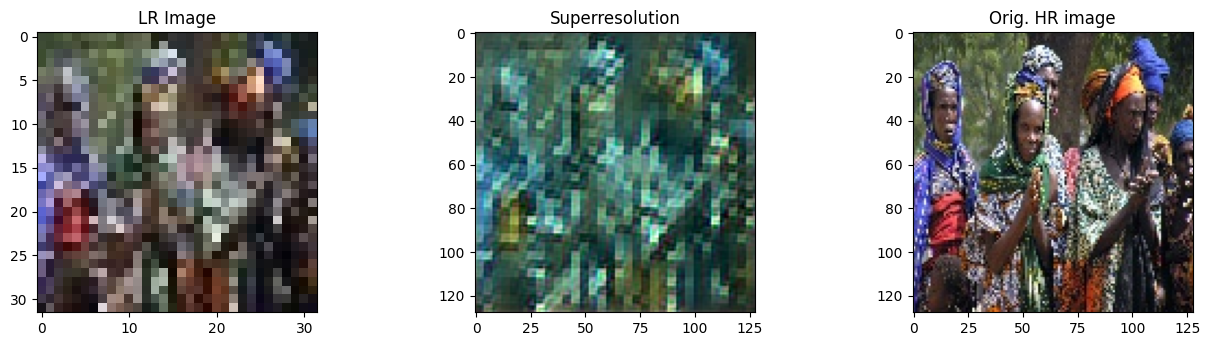

1/1 [==============================] - 0s 300ms/step


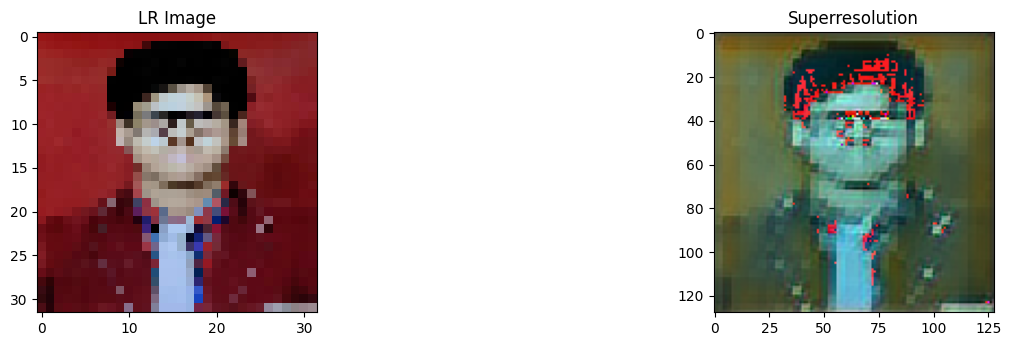

In [19]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

# cv2.imshow('Image', gen_image[0,:,:,:])
# cv2.waitKey()
# cv2.destroyAllWindow()


################################################
sreeni_lr = cv2.imread("D:/Documents/Random/archit_photo.jpg")
# sreeni_hr = cv2.imread("D:/Desktop/Improv/Formal Coding/Jupyter Notebooks/Minor Project/SRDataset/flickr30k_images/hr_5000/13327175.jpg")
sreeni_lr = cv2.resize(sreeni_lr,(32,32))
#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
# sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
# sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
# sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)
# generated_sreeni_hr = cv2.cvtColor(generated_sreeni_hr, cv2.COLOR_BGR2RGB)


# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.title('LR Image')
plt.imshow((sreeni_lr[0,:,:,:] * 255).astype(np.uint8))
plt.subplot(222)
plt.title('Superresolution')
plt.imshow((generated_sreeni_hr[0,:,:,:]* 255).astype(np.uint8))
# plt.subplot(233)
# plt.title('Orig. HR image')
# plt.imshow((sreeni_hr[0,:,:,:]* 255).astype(np.uint8))

plt.show()